In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

class PositionalEncoding(layers.Layer):
    def __init__(self, input_size, hidden_size):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self._get_positional_encoding(input_size, hidden_size)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

    def _get_positional_encoding(self, input_size, hidden_size):
        angle_rads = self._get_angles(input_size, hidden_size)

        # Apply sin to even indices in the array
        angle_rads[:, 0::2] = tf.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array
        angle_rads[:, 1::2] = tf.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def _get_angles(self, input_size, hidden_size):
        positions = np.arange(input_size)[:, np.newaxis]
        indices = np.arange(hidden_size)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (indices // 2)) / np.float32(hidden_size))
        return positions * angle_rates


class TransformerLayer(layers.Layer):
    def __init__(self, hidden_size, num_heads):
        super(TransformerLayer, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads, hidden_size)
        self.dropout = layers.Dropout(0.1)
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = keras.Sequential(
            [layers.Dense(hidden_size, activation="relu"), layers.Dense(hidden_size)]
        )

    def call(self, x, training):
        attn_output = self.mha(x, x, training=training)
        attn_output = self.dropout(attn_output, training=training)
        out1 = self.norm(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout(ffn_output, training=training)
        return self.norm(out1 + ffn_output)


class Transformer(tf.keras.Model):
    def __init__(self, input_size, hidden_size, num_layers, num_heads):
        super(Transformer, self).__init__()

        self.embedding = layers.Embedding(input_size, hidden_size)
        self.pos_encoding = PositionalEncoding(input_size, hidden_size)
        self.encoder = [TransformerLayer(hidden_size, num_heads) for _ in range(num_layers)]
        self.decoder = [TransformerLayer(hidden_size, num_heads) for _ in range(num_layers)]
        self.output_layer = layers.Dense(input_size)

    def call(self, src, tgt, training=True):
        src_embedding = self.embedding(src)
        src_embedding = self.pos_encoding(src_embedding)
        tgt_embedding = self.embedding(tgt)
        tgt_embedding = self.pos_encoding(tgt_embedding)

        for encoder_layer in self.encoder:
            src_embedding = encoder_layer(src_embedding, training)

        for decoder_layer in self.decoder:
            tgt_embedding = decoder_layer(tgt_embedding, training)

        output = self.output_layer(tgt_embedding)

        return output


In [18]:
import random

# Hyperparameters
input_size = 50  # Example: Range of input numbers
hidden_size = 64
num_layers = 2
num_heads = 4
learning_rate = 0.001
num_epochs = 5000

# Define the loss function and optimizer
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

# Create the transformer model
model = Transformer(input_size, hidden_size, num_layers, num_heads)


In [19]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('/Users/saschacaron/Downloads/experiment_2d_noisy-1-to-20-tracks/events_all/hits_and_tracks_2d_events_all.csv')

# Print the contents of the DataFrame
print(df.head())


ImportError: this version of pandas is incompatible with numpy < 1.20.3
your numpy version is 1.19.5.
Please upgrade numpy to >= 1.20.3 to use this pandas version

In [20]:
import matplotlib.pyplot as plt

# Lists to store the loss values and epochs
loss_history = []
epoch_history = []

# Training loop
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:

        # here we make the training data, we generate a sequence of random numbers as coordintes of hits
        # and then we below we assign classes to those numbers
        n = random.randint(2,10) # Define the length of your lists
        start = random.uniform(0, input_size - 21)  # Start with a random integer
        training_data = [start + 2*i for i in range(n)]

        # the target values are just classes, computed with the modulo from the coordinates that are the inputs
        #target_values = [x + 2 for x in training_data]
        N = 10  # Number of classes
        target_values = [int(x) % N + 1 for x in training_data]
    
#        n = 10-1  # Define the length of your lists
#        start = random.randint(0, input_size - 3)  # Start with a random integer
#        training_data = [start + 2*i for i in range(n)]
#        target_values = [x + 2 for x in training_data]

        print (training_data)
        print (target_values)
        
        # Convert training data to tensors
        src = tf.constant([training_data])
        tgt = tf.constant([target_values])

        # Reset the initial prediction value for each epoch
        tgt_input = tgt[:, :-1]  # Exclude last target value during training
        real_tgt = tgt[:, 1:]    # Calculate loss with target shifted by one

        # Forward pass
        output = model(src, tgt_input, training=True)

        # Calculate loss
        loss = loss_function(real_tgt, output)
        # Append the loss and epoch to the history lists
        loss_history.append(loss.numpy())
        epoch_history.append(epoch + 1)


    # Perform gradient descent
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.numpy():.4f}")


[21.391574408556732, 23.391574408556732, 25.391574408556732, 27.391574408556732, 29.391574408556732]
[2, 4, 6, 8, 10]
[6.613900609536052, 8.613900609536053, 10.613900609536053, 12.613900609536053, 14.613900609536053, 16.613900609536053, 18.613900609536053]
[7, 9, 1, 3, 5, 7, 9]
[0.46931069589805685, 2.4693106958980566, 4.469310695898057]
[1, 3, 5]
[22.407693778045633, 24.407693778045633, 26.407693778045633]
[3, 5, 7]
[25.919432715917996, 27.919432715917996, 29.919432715917996, 31.919432715917996, 33.91943271591799, 35.91943271591799, 37.91943271591799]
[6, 8, 10, 2, 4, 6, 8]


[22.42565811642627, 24.42565811642627, 26.42565811642627, 28.42565811642627]
[3, 5, 7, 9]
[2.609637457650688, 4.609637457650688]
[3, 5]
[20.536813819361004, 22.536813819361004, 24.536813819361004, 26.536813819361004, 28.536813819361004]
[1, 3, 5, 7, 9]
[11.10762024514152, 13.10762024514152, 15.10762024514152, 17.10762024514152, 19.10762024514152, 21.10762024514152, 23.10762024514152, 25.10762024514152]
[2, 4, 6, 8, 10, 2, 4, 6]
[23.726825809719866, 25.726825809719866, 27.726825809719866, 29.726825809719866, 31.726825809719866, 33.72682580971987, 35.72682580971987, 37.72682580971987, 39.72682580971987]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [10/5000], Loss: 3.1686
[21.178399966848442, 23.178399966848442, 25.178399966848442, 27.178399966848442]
[2, 4, 6, 8]
[8.992926384873787, 10.992926384873787, 12.992926384873787, 14.992926384873787, 16.992926384873787, 18.992926384873787]
[9, 1, 3, 5, 7, 9]
[12.471160207773174, 14.471160207773174, 16.471160207773174, 18.471160207773174, 20.471160207773174, 22.471160207773174, 24.471160207773174]
[3, 5, 7, 9, 1, 3, 5]
[0.43455541852516055, 2.4345554185251608, 4.434555418525161, 6.434555418525161]
[1, 3, 5, 7]
[13.642902632658844, 15.642902632658844, 17.642902632658846, 19.642902632658846]
[4, 6, 8, 10]


[12.082635196897806, 14.082635196897806, 16.082635196897805, 18.082635196897805, 20.082635196897805]
[3, 5, 7, 9, 1]
[18.20298932577417, 20.20298932577417, 22.20298932577417, 24.20298932577417, 26.20298932577417]
[9, 1, 3, 5, 7]
[14.915107547440499, 16.9151075474405, 18.9151075474405, 20.9151075474405, 22.9151075474405, 24.9151075474405, 26.9151075474405, 28.9151075474405, 30.9151075474405]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[13.184213938639852, 15.184213938639852, 17.18421393863985, 19.18421393863985, 21.18421393863985, 23.18421393863985, 25.18421393863985, 27.18421393863985]
[4, 6, 8, 10, 2, 4, 6, 8]
[21.19726417936978, 23.19726417936978, 25.19726417936978, 27.19726417936978, 29.19726417936978]
[2, 4, 6, 8, 10]


Epoch [20/5000], Loss: 2.5500
[10.038009248352635, 12.038009248352635, 14.038009248352635, 16.038009248352637]
[1, 3, 5, 7]
[10.407327969543612, 12.407327969543612, 14.407327969543612, 16.407327969543612, 18.407327969543612, 20.407327969543612, 22.407327969543612]
[1, 3, 5, 7, 9, 1, 3]
[11.454538710355582, 13.454538710355582, 15.454538710355582, 17.454538710355582, 19.454538710355582]
[2, 4, 6, 8, 10]
[11.51524413761194, 13.51524413761194, 15.51524413761194, 17.51524413761194, 19.51524413761194]
[2, 4, 6, 8, 10]
[5.670866638707863, 7.670866638707863, 9.670866638707864, 11.670866638707864, 13.670866638707864, 15.670866638707864, 17.670866638707864, 19.670866638707864, 21.670866638707864, 23.670866638707864]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[12.05145761909217, 14.05145761909217, 16.05145761909217, 18.05145761909217]
[3, 5, 7, 9]
[17.329292884439766, 19.329292884439766, 21.329292884439766, 23.329292884439766, 25.329292884439766]
[8, 10, 2, 4, 6]
[26.9640360462221, 28.9640360462221, 30.9640360462221, 32.9640360462221, 34.9640360462221, 36.9640360462221, 38.9640360462221]
[7, 9, 1, 3, 5, 7, 9]
[12.279322313944842, 14.279322313944842, 16.279322313944842, 18.279322313944842, 20.279322313944842, 22.279322313944842]
[3, 5, 7, 9, 1, 3]
[20.56239358973488, 22.56239358973488, 24.56239358973488, 26.56239358973488, 28.56239358973488]
[1, 3, 5, 7, 9]


Epoch [30/5000], Loss: 2.2237
[1.0419650311101618, 3.041965031110162, 5.041965031110162, 7.041965031110162, 9.041965031110163, 11.041965031110163, 13.041965031110163, 15.041965031110163, 17.041965031110163]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.4874116761937612, 4.487411676193761, 6.487411676193761, 8.487411676193762, 10.487411676193762, 12.487411676193762, 14.487411676193762, 16.487411676193762]
[3, 5, 7, 9, 1, 3, 5, 7]
[27.465726715370504, 29.465726715370504, 31.465726715370504, 33.46572671537051, 35.46572671537051, 37.46572671537051, 39.46572671537051]
[8, 10, 2, 4, 6, 8, 10]
[26.648613562665062, 28.648613562665062, 30.648613562665062, 32.64861356266506, 34.64861356266506, 36.64861356266506, 38.64861356266506, 40.64861356266506]
[7, 9, 1, 3, 5, 7, 9, 1]
[7.34707302923071, 9.34707302923071, 11.34707302923071, 13.34707302923071]
[8, 10, 2, 4]


[20.989452996036434, 22.989452996036434, 24.989452996036434, 26.989452996036434, 28.989452996036434, 30.989452996036434, 32.989452996036434, 34.989452996036434, 36.989452996036434, 38.989452996036434]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[16.57490565051279, 18.57490565051279, 20.57490565051279, 22.57490565051279]
[7, 9, 1, 3]
[17.889180435788763, 19.889180435788763, 21.889180435788763, 23.889180435788763, 25.889180435788763, 27.889180435788763, 29.889180435788763]
[8, 10, 2, 4, 6, 8, 10]
[24.52253045799955, 26.52253045799955, 28.52253045799955, 30.52253045799955, 32.52253045799955, 34.52253045799955]
[5, 7, 9, 1, 3, 5]
[13.031346675556586, 15.031346675556586, 17.031346675556584, 19.031346675556584, 21.031346675556584, 23.031346675556584, 25.031346675556584, 27.031346675556584, 29.031346675556584]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [40/5000], Loss: 2.6108
[12.555384820179203, 14.555384820179203, 16.555384820179203, 18.555384820179203, 20.555384820179203, 22.555384820179203]
[3, 5, 7, 9, 1, 3]
[13.441307067448992, 15.441307067448992, 17.441307067448992, 19.441307067448992, 21.441307067448992, 23.441307067448992, 25.441307067448992, 27.441307067448992]
[4, 6, 8, 10, 2, 4, 6, 8]
[5.644282856520253, 7.644282856520253, 9.644282856520253, 11.644282856520253, 13.644282856520253, 15.644282856520253, 17.644282856520253]
[6, 8, 10, 2, 4, 6, 8]
[5.221965620652703, 7.221965620652703, 9.221965620652703, 11.221965620652703, 13.221965620652703, 15.221965620652703, 17.221965620652703, 19.221965620652703, 21.221965620652703]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[24.093383184565386, 26.093383184565386, 28.093383184565386, 30.093383184565386, 32.09338318456538, 34.09338318456538]
[5, 7, 9, 1, 3, 5]


[20.743823154520847, 22.743823154520847, 24.743823154520847, 26.743823154520847, 28.743823154520847, 30.743823154520847, 32.74382315452085, 34.74382315452085, 36.74382315452085]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[7.82246985509832, 9.82246985509832]
[8, 10]
[19.56333014106254, 21.56333014106254, 23.56333014106254, 25.56333014106254, 27.56333014106254, 29.56333014106254, 31.56333014106254]
[10, 2, 4, 6, 8, 10, 2]
[20.58882482760001, 22.58882482760001, 24.58882482760001, 26.58882482760001]
[1, 3, 5, 7]
[21.801915764439798, 23.801915764439798, 25.801915764439798, 27.801915764439798, 29.801915764439798]
[2, 4, 6, 8, 10]


Epoch [50/5000], Loss: 2.4892
[2.3541879093229734, 4.354187909322974]
[3, 5]
[20.995981230891807, 22.995981230891807, 24.995981230891807, 26.995981230891807, 28.995981230891807, 30.995981230891807, 32.99598123089181, 34.99598123089181, 36.99598123089181, 38.99598123089181]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[8.442280785832441, 10.442280785832441, 12.442280785832441]
[9, 1, 3]
[6.6160258670244145, 8.616025867024415, 10.616025867024415, 12.616025867024415, 14.616025867024415, 16.616025867024415, 18.616025867024415, 20.616025867024415, 22.616025867024415]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[17.29355418464691, 19.29355418464691, 21.29355418464691, 23.29355418464691, 25.29355418464691, 27.29355418464691, 29.29355418464691]
[8, 10, 2, 4, 6, 8, 10]


[26.36934068406736, 28.36934068406736, 30.36934068406736, 32.36934068406736, 34.36934068406736, 36.36934068406736, 38.36934068406736, 40.36934068406736]
[7, 9, 1, 3, 5, 7, 9, 1]
[16.45644634583916, 18.45644634583916, 20.45644634583916, 22.45644634583916, 24.45644634583916]
[7, 9, 1, 3, 5]
[27.633649108055515, 29.633649108055515, 31.633649108055515, 33.633649108055515, 35.633649108055515, 37.633649108055515, 39.633649108055515, 41.633649108055515]
[8, 10, 2, 4, 6, 8, 10, 2]
[6.435191274105425, 8.435191274105424, 10.435191274105424]
[7, 9, 1]
[7.540486925328184, 9.540486925328185, 11.540486925328185]
[8, 10, 2]


Epoch [60/5000], Loss: 2.7551
[18.448740294005656, 20.448740294005656, 22.448740294005656, 24.448740294005656, 26.448740294005656, 28.448740294005656]
[9, 1, 3, 5, 7, 9]
[0.7762640414515714, 2.7762640414515714]
[1, 3]
[27.36074335196434, 29.36074335196434, 31.36074335196434]
[8, 10, 2]
[11.57103589240539, 13.57103589240539, 15.57103589240539, 17.57103589240539, 19.57103589240539]
[2, 4, 6, 8, 10]
[9.781807267943753, 11.781807267943753]
[10, 2]


[11.908879030776719, 13.908879030776719, 15.908879030776719, 17.908879030776717, 19.908879030776717]
[2, 4, 6, 8, 10]
[4.317992284630868, 6.317992284630868, 8.317992284630868, 10.317992284630868, 12.317992284630868, 14.317992284630868, 16.31799228463087, 18.31799228463087]
[5, 7, 9, 1, 3, 5, 7, 9]
[1.3102777176510916, 3.3102777176510916, 5.310277717651092, 7.310277717651092, 9.310277717651092, 11.310277717651092, 13.310277717651092]
[2, 4, 6, 8, 10, 2, 4]
[24.196225796701878, 26.196225796701878, 28.196225796701878, 30.196225796701878, 32.19622579670188, 34.19622579670188, 36.19622579670188, 38.19622579670188, 40.19622579670188, 42.19622579670188]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[15.854314457533748, 17.854314457533746, 19.854314457533746, 21.854314457533746, 23.854314457533746, 25.854314457533746, 27.854314457533746, 29.854314457533746, 31.854314457533746, 33.85431445753375]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [70/5000], Loss: 2.2144
[0.28046002491190136, 2.2804600249119016, 4.280460024911902, 6.280460024911902, 8.280460024911902, 10.280460024911902, 12.280460024911902, 14.280460024911902, 16.2804600249119, 18.2804600249119]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[0.5101276903144261, 2.510127690314426, 4.510127690314426, 6.510127690314426, 8.510127690314427]
[1, 3, 5, 7, 9]
[5.193537571551091, 7.193537571551091, 9.19353757155109, 11.19353757155109, 13.19353757155109, 15.19353757155109, 17.19353757155109, 19.19353757155109, 21.19353757155109, 23.19353757155109]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[24.76745325159711, 26.76745325159711, 28.76745325159711, 30.76745325159711, 32.76745325159711, 34.76745325159711]
[5, 7, 9, 1, 3, 5]
[20.204877953289007, 22.204877953289007, 24.204877953289007, 26.204877953289007, 28.204877953289007, 30.204877953289007, 32.20487795328901, 34.20487795328901, 36.20487795328901, 38.20487795328901]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[20.604437153730704, 22.604437153730704, 24.604437153730704]
[1, 3, 5]
[18.722409751021978, 20.722409751021978, 22.722409751021978, 24.722409751021978, 26.722409751021978, 28.722409751021978, 30.722409751021978, 32.72240975102198, 34.72240975102198, 36.72240975102198]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[26.16106301503846, 28.16106301503846, 30.16106301503846]
[7, 9, 1]
[26.834880110630852, 28.834880110630852, 30.834880110630852, 32.83488011063085, 34.83488011063085, 36.83488011063085, 38.83488011063085, 40.83488011063085]
[7, 9, 1, 3, 5, 7, 9, 1]
[26.1624210551177, 28.1624210551177, 30.1624210551177, 32.162421055117704, 34.162421055117704, 36.162421055117704, 38.162421055117704, 40.162421055117704, 42.162421055117704]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [80/5000], Loss: 2.1938
[18.174989029480486, 20.174989029480486, 22.174989029480486, 24.174989029480486, 26.174989029480486, 28.174989029480486, 30.174989029480486, 32.174989029480486, 34.174989029480486, 36.174989029480486]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[4.618144413296434, 6.618144413296434, 8.618144413296434, 10.618144413296434, 12.618144413296434]
[5, 7, 9, 1, 3]
[2.356586393550601, 4.356586393550601, 6.356586393550601, 8.3565863935506, 10.3565863935506, 12.3565863935506, 14.3565863935506, 16.3565863935506, 18.3565863935506, 20.3565863935506]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[25.40289323769583, 27.40289323769583, 29.40289323769583]
[6, 8, 10]
[15.493749099871904, 17.493749099871906, 19.493749099871906, 21.493749099871906, 23.493749099871906, 25.493749099871906, 27.493749099871906, 29.493749099871906, 31.493749099871906, 33.493749099871906]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[27.620967084659533, 29.620967084659533, 31.620967084659533, 33.62096708465953, 35.62096708465953, 37.62096708465953, 39.62096708465953, 41.62096708465953, 43.62096708465953]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[27.668168341139918, 29.668168341139918, 31.668168341139918, 33.66816834113992, 35.66816834113992, 37.66816834113992]
[8, 10, 2, 4, 6, 8]
[1.6923459794627946, 3.692345979462795, 5.692345979462795, 7.692345979462795, 9.692345979462795, 11.692345979462795, 13.692345979462795, 15.692345979462795, 17.692345979462793, 19.692345979462793]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.656751539906224, 23.656751539906224, 25.656751539906224, 27.656751539906224, 29.656751539906224]
[2, 4, 6, 8, 10]
[10.915077936803726, 12.915077936803726, 14.915077936803726]
[1, 3, 5]


Epoch [90/5000], Loss: 1.8510
[2.9984712532606643, 4.998471253260664, 6.998471253260664, 8.998471253260664, 10.998471253260664, 12.998471253260664]
[3, 5, 7, 9, 1, 3]
[7.48067618118554, 9.48067618118554]
[8, 10]
[13.68473541790927, 15.68473541790927, 17.68473541790927, 19.68473541790927, 21.68473541790927, 23.68473541790927, 25.68473541790927]
[4, 6, 8, 10, 2, 4, 6]
[27.917590208523663, 29.917590208523663, 31.917590208523663, 33.91759020852366, 35.91759020852366, 37.91759020852366, 39.91759020852366, 41.91759020852366, 43.91759020852366]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[1.464867343628498, 3.464867343628498]
[2, 4]


[9.551131280496143, 11.551131280496143, 13.551131280496143, 15.551131280496143, 17.551131280496143, 19.551131280496143]
[10, 2, 4, 6, 8, 10]
[27.950339006535916, 29.950339006535916, 31.950339006535916]
[8, 10, 2]
[5.021829422478263, 7.021829422478263]
[6, 8]
[13.602229833971556, 15.602229833971556, 17.602229833971556]
[4, 6, 8]
[13.80771531234924, 15.80771531234924, 17.807715312349238, 19.807715312349238, 21.807715312349238, 23.807715312349238, 25.807715312349238]
[4, 6, 8, 10, 2, 4, 6]


Epoch [100/5000], Loss: 2.3379
[27.39146778126689, 29.39146778126689, 31.39146778126689, 33.39146778126689, 35.39146778126689, 37.39146778126689, 39.39146778126689]
[8, 10, 2, 4, 6, 8, 10]
[13.36696314116798, 15.36696314116798, 17.36696314116798, 19.36696314116798, 21.36696314116798, 23.36696314116798, 25.36696314116798]
[4, 6, 8, 10, 2, 4, 6]
[3.0843663290526573, 5.084366329052657, 7.084366329052657, 9.084366329052656, 11.084366329052656, 13.084366329052656, 15.084366329052656, 17.084366329052656, 19.084366329052656, 21.084366329052656]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[22.22651700155587, 24.22651700155587, 26.22651700155587, 28.22651700155587, 30.22651700155587]
[3, 5, 7, 9, 1]
[7.593238818441006, 9.593238818441005, 11.593238818441005, 13.593238818441005, 15.593238818441005, 17.593238818441005, 19.593238818441005, 21.593238818441005]
[8, 10, 2, 4, 6, 8, 10, 2]


[18.585241846151497, 20.585241846151497, 22.585241846151497, 24.585241846151497]
[9, 1, 3, 5]
[20.550747516479692, 22.550747516479692, 24.550747516479692, 26.550747516479692, 28.550747516479692, 30.550747516479692, 32.55074751647969, 34.55074751647969]
[1, 3, 5, 7, 9, 1, 3, 5]
[17.12352188403087, 19.12352188403087, 21.12352188403087, 23.12352188403087, 25.12352188403087, 27.12352188403087]
[8, 10, 2, 4, 6, 8]
[12.650758681336164, 14.650758681336164, 16.650758681336164, 18.650758681336164, 20.650758681336164, 22.650758681336164, 24.650758681336164, 26.650758681336164]
[3, 5, 7, 9, 1, 3, 5, 7]
[13.03349932830327, 15.03349932830327, 17.03349932830327, 19.03349932830327, 21.03349932830327]
[4, 6, 8, 10, 2]


Epoch [110/5000], Loss: 1.6379
[3.1329109513439506, 5.13291095134395, 7.13291095134395, 9.13291095134395, 11.13291095134395, 13.13291095134395]
[4, 6, 8, 10, 2, 4]
[11.266705649719666, 13.266705649719666, 15.266705649719666, 17.26670564971967, 19.26670564971967, 21.26670564971967, 23.26670564971967, 25.26670564971967, 27.26670564971967]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[22.672838124287786, 24.672838124287786, 26.672838124287786]
[3, 5, 7]
[14.626241963281979, 16.626241963281977]
[5, 7]
[0.24911572477973354, 2.2491157247797338, 4.249115724779734, 6.249115724779734]
[1, 3, 5, 7]


[15.570104392438711, 17.57010439243871, 19.57010439243871, 21.57010439243871, 23.57010439243871, 25.57010439243871, 27.57010439243871, 29.57010439243871, 31.57010439243871]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[18.462176480160444, 20.462176480160444]
[9, 1]
[10.32951337601093, 12.32951337601093, 14.32951337601093, 16.32951337601093, 18.32951337601093, 20.32951337601093, 22.32951337601093, 24.32951337601093, 26.32951337601093]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[21.970337662502786, 23.970337662502786, 25.970337662502786]
[2, 4, 6]
[10.906458100754259, 12.906458100754259]
[1, 3]


Epoch [120/5000], Loss: 3.2707
[10.41587772842044, 12.41587772842044, 14.41587772842044, 16.41587772842044, 18.41587772842044, 20.41587772842044, 22.41587772842044, 24.41587772842044, 26.41587772842044, 28.41587772842044]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[18.347085369953874, 20.347085369953874, 22.347085369953874, 24.347085369953874, 26.347085369953874, 28.347085369953874, 30.347085369953874, 32.347085369953874, 34.347085369953874]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.5282250397421939, 2.528225039742194, 4.528225039742194, 6.528225039742194, 8.528225039742194, 10.528225039742194, 12.528225039742194, 14.528225039742194, 16.528225039742193, 18.528225039742193]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[3.459053520249044, 5.459053520249044, 7.459053520249044, 9.459053520249043, 11.459053520249043, 13.459053520249043, 15.459053520249043, 17.459053520249043, 19.459053520249043, 21.459053520249043]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[1.6186290080868608, 3.618629008086861, 5.618629008086861, 7.618629008086861, 9.

[13.884633970248407, 15.884633970248407, 17.88463397024841, 19.88463397024841]
[4, 6, 8, 10]
[21.129434674715604, 23.129434674715604, 25.129434674715604, 27.129434674715604, 29.129434674715604, 31.129434674715604, 33.129434674715604, 35.129434674715604, 37.129434674715604]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[5.598938184154026, 7.598938184154026, 9.598938184154026, 11.598938184154026, 13.598938184154026, 15.598938184154026]
[6, 8, 10, 2, 4, 6]
[11.709749379508398, 13.709749379508398]
[2, 4]
[25.616092780442127, 27.616092780442127, 29.616092780442127, 31.616092780442127, 33.61609278044213, 35.61609278044213, 37.61609278044213, 39.61609278044213, 41.61609278044213, 43.61609278044213]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [130/5000], Loss: 2.4294
[6.0901352607927, 8.0901352607927, 10.0901352607927, 12.0901352607927, 14.0901352607927, 16.0901352607927, 18.0901352607927, 20.0901352607927, 22.0901352607927, 24.0901352607927]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[20.501182257697813, 22.501182257697813, 24.501182257697813, 26.501182257697813, 28.501182257697813]
[1, 3, 5, 7, 9]
[25.713428675618907, 27.713428675618907, 29.713428675618907, 31.713428675618907, 33.71342867561891, 35.71342867561891, 37.71342867561891, 39.71342867561891, 41.71342867561891, 43.71342867561891]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[21.80760502680357, 23.80760502680357, 25.80760502680357, 27.80760502680357, 29.80760502680357, 31.80760502680357]
[2, 4, 6, 8, 10, 2]
[21.97759779573513, 23.97759779573513, 25.97759779573513, 27.97759779573513, 29.97759779573513, 31.97759779573513, 33.97759779573513, 35.97759779573513, 37.97759779573513, 39.97759779573513]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[19.15687944355314, 21.15687944355314, 23.15687944355314]
[10, 2, 4]
[21.186317326266412, 23.186317326266412, 25.186317326266412, 27.186317326266412, 29.186317326266412]
[2, 4, 6, 8, 10]
[6.207052086016493, 8.207052086016493]
[7, 9]
[19.29926735563617, 21.29926735563617]
[10, 2]
[22.359218199592075, 24.359218199592075, 26.359218199592075, 28.359218199592075, 30.359218199592075]
[3, 5, 7, 9, 1]


Epoch [140/5000], Loss: 2.7332
[17.327779724829547, 19.327779724829547, 21.327779724829547, 23.327779724829547, 25.327779724829547, 27.327779724829547, 29.327779724829547]
[8, 10, 2, 4, 6, 8, 10]
[5.46895208097778, 7.46895208097778, 9.468952080977779]
[6, 8, 10]
[12.866891375225112, 14.866891375225112, 16.866891375225112, 18.866891375225112, 20.866891375225112, 22.866891375225112]
[3, 5, 7, 9, 1, 3]
[25.910664560093785, 27.910664560093785, 29.910664560093785, 31.910664560093785, 33.910664560093785, 35.910664560093785]
[6, 8, 10, 2, 4, 6]
[7.358272261585053, 9.358272261585054, 11.358272261585054]
[8, 10, 2]


[22.31859951302395, 24.31859951302395, 26.31859951302395, 28.31859951302395, 30.31859951302395, 32.318599513023955, 34.318599513023955]
[3, 5, 7, 9, 1, 3, 5]
[20.331697271430606, 22.331697271430606, 24.331697271430606, 26.331697271430606, 28.331697271430606]
[1, 3, 5, 7, 9]
[13.693062441227625, 15.693062441227625, 17.693062441227625]
[4, 6, 8]
[8.909992690239001, 10.909992690239001, 12.909992690239001, 14.909992690239001, 16.909992690239, 18.909992690239, 20.909992690239, 22.909992690239, 24.909992690239, 26.909992690239]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[0.6196255738270988, 2.619625573827099, 4.619625573827099, 6.619625573827099, 8.619625573827099, 10.619625573827099]
[1, 3, 5, 7, 9, 1]


Epoch [150/5000], Loss: 2.5619
[10.877371776481018, 12.877371776481018, 14.877371776481018, 16.87737177648102, 18.87737177648102, 20.87737177648102, 22.87737177648102, 24.87737177648102, 26.87737177648102]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[20.273588578856543, 22.273588578856543, 24.273588578856543, 26.273588578856543, 28.273588578856543, 30.273588578856543]
[1, 3, 5, 7, 9, 1]
[24.884702921388406, 26.884702921388406, 28.884702921388406, 30.884702921388406, 32.88470292138841, 34.88470292138841, 36.88470292138841]
[5, 7, 9, 1, 3, 5, 7]
[5.415257800892551, 7.415257800892551, 9.415257800892551, 11.415257800892551, 13.415257800892551, 15.415257800892551, 17.41525780089255, 19.41525780089255, 21.41525780089255]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.388015541380355, 14.388015541380355]
[3, 5]


[14.411109927547592, 16.411109927547592, 18.411109927547592, 20.411109927547592, 22.411109927547592, 24.411109927547592]
[5, 7, 9, 1, 3, 5]
[15.178064918241159, 17.17806491824116, 19.17806491824116, 21.17806491824116, 23.17806491824116]
[6, 8, 10, 2, 4]
[8.940381461264296, 10.940381461264296, 12.940381461264296, 14.940381461264296, 16.940381461264295, 18.940381461264295, 20.940381461264295, 22.940381461264295, 24.940381461264295, 26.940381461264295]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[26.894576271522876, 28.894576271522876]
[7, 9]
[4.645873968414421, 6.645873968414421, 8.64587396841442, 10.64587396841442, 12.64587396841442, 14.64587396841442, 16.64587396841442, 18.64587396841442, 20.64587396841442]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [160/5000], Loss: 2.2972
[19.7701785894866, 21.7701785894866, 23.7701785894866, 25.7701785894866, 27.7701785894866]
[10, 2, 4, 6, 8]
[17.089001759311554, 19.089001759311554, 21.089001759311554, 23.089001759311554, 25.089001759311554]
[8, 10, 2, 4, 6]
[17.875031554198763, 19.875031554198763, 21.875031554198763, 23.875031554198763, 25.875031554198763, 27.875031554198763, 29.875031554198763, 31.875031554198763, 33.87503155419876, 35.87503155419876]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[24.782595588832486, 26.782595588832486, 28.782595588832486, 30.782595588832486, 32.782595588832486, 34.782595588832486]
[5, 7, 9, 1, 3, 5]
[25.41682116432817, 27.41682116432817, 29.41682116432817, 31.41682116432817, 33.41682116432817, 35.41682116432817, 37.41682116432817]
[6, 8, 10, 2, 4, 6, 8]


[18.829115029554522, 20.829115029554522, 22.829115029554522, 24.829115029554522, 26.829115029554522]
[9, 1, 3, 5, 7]
[21.644907998494322, 23.644907998494322, 25.644907998494322, 27.644907998494322, 29.644907998494322, 31.644907998494322, 33.64490799849432, 35.64490799849432, 37.64490799849432, 39.64490799849432]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[27.6062588893617, 29.6062588893617, 31.6062588893617, 33.6062588893617, 35.6062588893617]
[8, 10, 2, 4, 6]
[14.991357360859213, 16.99135736085921, 18.99135736085921, 20.99135736085921]
[5, 7, 9, 1]
[8.140187251944926, 10.140187251944926, 12.140187251944926, 14.140187251944926, 16.140187251944926, 18.140187251944926, 20.140187251944926]
[9, 1, 3, 5, 7, 9, 1]


Epoch [170/5000], Loss: 2.0041
[4.66741032085549, 6.66741032085549, 8.66741032085549, 10.66741032085549, 12.66741032085549, 14.66741032085549, 16.66741032085549, 18.66741032085549]
[5, 7, 9, 1, 3, 5, 7, 9]
[10.811147840979856, 12.811147840979856, 14.811147840979856, 16.811147840979856, 18.811147840979856, 20.811147840979856, 22.811147840979856]
[1, 3, 5, 7, 9, 1, 3]
[26.91442464414713, 28.91442464414713]
[7, 9]
[19.647400286806455, 21.647400286806455, 23.647400286806455, 25.647400286806455, 27.647400286806455, 29.647400286806455, 31.647400286806455, 33.64740028680646, 35.64740028680646]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[7.841777497908888, 9.841777497908888, 11.841777497908888, 13.841777497908888, 15.841777497908888, 17.841777497908886]
[8, 10, 2, 4, 6, 8]


[21.67917255324618, 23.67917255324618, 25.67917255324618, 27.67917255324618, 29.67917255324618]
[2, 4, 6, 8, 10]
[18.75381076124507, 20.75381076124507, 22.75381076124507]
[9, 1, 3]
[9.15839124643209, 11.15839124643209, 13.15839124643209]
[10, 2, 4]
[24.69744915348558, 26.69744915348558, 28.69744915348558, 30.69744915348558]
[5, 7, 9, 1]
[10.586456090407943, 12.586456090407943, 14.586456090407943, 16.586456090407943, 18.586456090407943, 20.586456090407943]
[1, 3, 5, 7, 9, 1]


Epoch [180/5000], Loss: 2.2528
[12.202409634370467, 14.202409634370467, 16.20240963437047, 18.20240963437047, 20.20240963437047]
[3, 5, 7, 9, 1]
[28.663784819154237, 30.663784819154237, 32.66378481915424, 34.66378481915424, 36.66378481915424]
[9, 1, 3, 5, 7]
[17.415739028771913, 19.415739028771913, 21.415739028771913, 23.415739028771913, 25.415739028771913]
[8, 10, 2, 4, 6]
[15.909422913676014, 17.909422913676014, 19.909422913676014, 21.909422913676014, 23.909422913676014, 25.909422913676014, 27.909422913676014, 29.909422913676014, 31.909422913676014]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[25.785161586320854, 27.785161586320854, 29.785161586320854, 31.785161586320854, 33.785161586320854, 35.785161586320854]
[6, 8, 10, 2, 4, 6]


[1.1061385406611772, 3.1061385406611772, 5.106138540661178, 7.106138540661178, 9.106138540661178, 11.106138540661178, 13.106138540661178, 15.106138540661178, 17.106138540661178, 19.106138540661178]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.184893797100937, 23.184893797100937, 25.184893797100937, 27.184893797100937, 29.184893797100937, 31.184893797100937, 33.18489379710094, 35.18489379710094, 37.18489379710094, 39.18489379710094]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.6951958404470717, 2.695195840447072, 4.695195840447072, 6.695195840447072, 8.695195840447072, 10.695195840447072, 12.695195840447072]
[1, 3, 5, 7, 9, 1, 3]
[4.95691045164289, 6.95691045164289, 8.95691045164289, 10.95691045164289, 12.95691045164289, 14.95691045164289, 16.95691045164289, 18.95691045164289]
[5, 7, 9, 1, 3, 5, 7, 9]
[15.932027443230124, 17.932027443230126, 19.932027443230126, 21.932027443230126, 23.932027443230126, 25.932027443230126, 27.932027443230126, 29.932027443230126, 31.932027443230126]
[6, 8, 10, 2, 4, 6, 8, 1

Epoch [190/5000], Loss: 1.7030
[23.893803598359817, 25.893803598359817, 27.893803598359817]
[4, 6, 8]
[28.848017341711248, 30.848017341711248]
[9, 1]
[26.175633748123314, 28.175633748123314, 30.175633748123314, 32.17563374812332, 34.17563374812332, 36.17563374812332, 38.17563374812332, 40.17563374812332]
[7, 9, 1, 3, 5, 7, 9, 1]
[3.593823241733974, 5.593823241733974, 7.593823241733974, 9.593823241733974, 11.593823241733974, 13.593823241733974, 15.593823241733974, 17.593823241733975]
[4, 6, 8, 10, 2, 4, 6, 8]
[2.9233372910884747, 4.923337291088474, 6.923337291088474, 8.923337291088474, 10.923337291088474, 12.923337291088474]
[3, 5, 7, 9, 1, 3]


[22.03870996304958, 24.03870996304958, 26.03870996304958, 28.03870996304958, 30.03870996304958, 32.038709963049584, 34.038709963049584, 36.038709963049584]
[3, 5, 7, 9, 1, 3, 5, 7]
[24.73881091700258, 26.73881091700258, 28.73881091700258, 30.73881091700258, 32.73881091700258, 34.73881091700258, 36.73881091700258, 38.73881091700258]
[5, 7, 9, 1, 3, 5, 7, 9]
[21.159791856034268, 23.159791856034268, 25.159791856034268, 27.159791856034268, 29.159791856034268, 31.159791856034268, 33.15979185603427]
[2, 4, 6, 8, 10, 2, 4]
[17.161749340745654, 19.161749340745654, 21.161749340745654, 23.161749340745654]
[8, 10, 2, 4]
[16.052527314857656, 18.052527314857656, 20.052527314857656, 22.052527314857656, 24.052527314857656, 26.052527314857656, 28.052527314857656]
[7, 9, 1, 3, 5, 7, 9]


Epoch [200/5000], Loss: 1.7668
[24.47086589666233, 26.47086589666233, 28.47086589666233, 30.47086589666233, 32.47086589666233, 34.47086589666233]
[5, 7, 9, 1, 3, 5]
[19.46354984167509, 21.46354984167509]
[10, 2]
[22.93350457107446, 24.93350457107446, 26.93350457107446, 28.93350457107446]
[3, 5, 7, 9]
[21.713113334235736, 23.713113334235736, 25.713113334235736, 27.713113334235736, 29.713113334235736, 31.713113334235736, 33.713113334235736]
[2, 4, 6, 8, 10, 2, 4]
[6.59869548990203, 8.598695489902031, 10.598695489902031, 12.598695489902031]
[7, 9, 1, 3]


[14.464878498918523, 16.464878498918523, 18.464878498918523, 20.464878498918523, 22.464878498918523, 24.464878498918523, 26.464878498918523, 28.464878498918523, 30.464878498918523]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[26.067357689630164, 28.067357689630164]
[7, 9]
[11.991032371790745, 13.991032371790745, 15.991032371790745]
[2, 4, 6]
[11.843523684246493, 13.843523684246493, 15.843523684246493]
[2, 4, 6]
[13.980811236495391, 15.980811236495391]
[4, 6]


Epoch [210/5000], Loss: 0.6475
[13.609916422541344, 15.609916422541344, 17.609916422541346, 19.609916422541346]
[4, 6, 8, 10]
[0.6591603972490168, 2.6591603972490168, 4.659160397249017, 6.659160397249017, 8.659160397249018, 10.659160397249018, 12.659160397249018]
[1, 3, 5, 7, 9, 1, 3]
[16.254940970523407, 18.254940970523407]
[7, 9]
[9.713454032802394, 11.713454032802394, 13.713454032802394, 15.713454032802394, 17.713454032802396, 19.713454032802396, 21.713454032802396, 23.713454032802396, 25.713454032802396, 27.713454032802396]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[24.598581759447377, 26.598581759447377, 28.598581759447377, 30.598581759447377, 32.59858175944738, 34.59858175944738]
[5, 7, 9, 1, 3, 5]


[22.26933141827539, 24.26933141827539, 26.26933141827539, 28.26933141827539, 30.26933141827539, 32.269331418275385, 34.269331418275385, 36.269331418275385]
[3, 5, 7, 9, 1, 3, 5, 7]
[0.3933499458241586, 2.3933499458241587, 4.393349945824158]
[1, 3, 5]
[1.2570107053439812, 3.257010705343981, 5.257010705343982, 7.257010705343982]
[2, 4, 6, 8]
[0.6593368167154002, 2.6593368167154003, 4.6593368167154, 6.6593368167154, 8.6593368167154, 10.6593368167154, 12.6593368167154, 14.6593368167154, 16.6593368167154, 18.6593368167154]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[14.080346903650767, 16.080346903650767, 18.080346903650767]
[5, 7, 9]


Epoch [220/5000], Loss: 1.2579
[6.893492773316218, 8.893492773316218, 10.893492773316218]
[7, 9, 1]
[7.231952666276934, 9.231952666276934, 11.231952666276934, 13.231952666276934]
[8, 10, 2, 4]
[20.779674718469092, 22.779674718469092]
[1, 3]
[20.855355944500314, 22.855355944500314, 24.855355944500314, 26.855355944500314, 28.855355944500314, 30.855355944500314]
[1, 3, 5, 7, 9, 1]
[16.82119690735341, 18.82119690735341, 20.82119690735341, 22.82119690735341, 24.82119690735341, 26.82119690735341, 28.82119690735341, 30.82119690735341, 32.82119690735341, 34.82119690735341]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


[28.818375177699682, 30.818375177699682, 32.81837517769968, 34.81837517769968, 36.81837517769968, 38.81837517769968, 40.81837517769968]
[9, 1, 3, 5, 7, 9, 1]
[15.470728945515202, 17.4707289455152, 19.4707289455152, 21.4707289455152, 23.4707289455152]
[6, 8, 10, 2, 4]
[27.954463153920283, 29.954463153920283, 31.954463153920283]
[8, 10, 2]
[15.27353088845809, 17.27353088845809, 19.27353088845809, 21.27353088845809, 23.27353088845809, 25.27353088845809]
[6, 8, 10, 2, 4, 6]
[7.459745977887281, 9.45974597788728, 11.45974597788728, 13.45974597788728, 15.45974597788728]
[8, 10, 2, 4, 6]


Epoch [230/5000], Loss: 1.5285
[2.419570568083868, 4.419570568083868]
[3, 5]
[23.64471349267908, 25.64471349267908, 27.64471349267908, 29.64471349267908, 31.64471349267908, 33.64471349267908]
[4, 6, 8, 10, 2, 4]
[15.120806947845606, 17.120806947845608, 19.120806947845608, 21.120806947845608, 23.120806947845608]
[6, 8, 10, 2, 4]
[5.5243019771471324, 7.5243019771471324]
[6, 8]
[26.555898452609153, 28.555898452609153, 30.555898452609153]
[7, 9, 1]


[9.479154442785605, 11.479154442785605, 13.479154442785605, 15.479154442785605, 17.479154442785607, 19.479154442785607, 21.479154442785607, 23.479154442785607, 25.479154442785607, 27.479154442785607]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[25.28228622437701, 27.28228622437701, 29.28228622437701, 31.28228622437701, 33.28228622437701]
[6, 8, 10, 2, 4]
[22.935232223634053, 24.935232223634053, 26.935232223634053, 28.935232223634053, 30.935232223634053, 32.93523222363405]
[3, 5, 7, 9, 1, 3]
[4.387324171130752, 6.387324171130752, 8.387324171130752, 10.387324171130752]
[5, 7, 9, 1]
[13.051713291922493, 15.051713291922493]
[4, 6]


Epoch [240/5000], Loss: 1.8854
[12.670818719528908, 14.670818719528908, 16.67081871952891, 18.67081871952891]
[3, 5, 7, 9]
[28.744102216983457, 30.744102216983457, 32.74410221698346, 34.74410221698346, 36.74410221698346]
[9, 1, 3, 5, 7]
[0.9835999819123062, 2.983599981912306, 4.983599981912306]
[1, 3, 5]
[10.221782800640575, 12.221782800640575, 14.221782800640575, 16.221782800640575]
[1, 3, 5, 7]
[3.760698262008198, 5.760698262008198, 7.760698262008198, 9.760698262008198, 11.760698262008198, 13.760698262008198, 15.760698262008198]
[4, 6, 8, 10, 2, 4, 6]


[2.0462558120984284, 4.046255812098428, 6.046255812098428, 8.046255812098428, 10.046255812098428, 12.046255812098428]
[3, 5, 7, 9, 1, 3]
[6.563138355618541, 8.563138355618541, 10.563138355618541]
[7, 9, 1]
[20.87481685228242, 22.87481685228242, 24.87481685228242, 26.87481685228242]
[1, 3, 5, 7]
[1.160705143799067, 3.160705143799067, 5.160705143799067, 7.160705143799067, 9.160705143799067, 11.160705143799067, 13.160705143799067, 15.160705143799067, 17.160705143799067, 19.160705143799067]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[2.810696385907825, 4.810696385907825, 6.810696385907825, 8.810696385907825, 10.810696385907825, 12.810696385907825]
[3, 5, 7, 9, 1, 3]


Epoch [250/5000], Loss: 0.9565
[14.793766728740149, 16.79376672874015, 18.79376672874015, 20.79376672874015, 22.79376672874015, 24.79376672874015, 26.79376672874015, 28.79376672874015, 30.79376672874015, 32.79376672874015]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[14.598355690305425, 16.598355690305425, 18.598355690305425, 20.598355690305425, 22.598355690305425, 24.598355690305425, 26.598355690305425, 28.598355690305425, 30.598355690305425]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.985044033404108, 26.985044033404108]
[5, 7]
[3.187890647463189, 5.187890647463189]
[4, 6]
[10.649603287595891, 12.649603287595891, 14.649603287595891, 16.64960328759589, 18.64960328759589, 20.64960328759589, 22.64960328759589, 24.64960328759589, 26.64960328759589]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[4.653914814897247, 6.653914814897247, 8.653914814897247, 10.653914814897247, 12.653914814897247, 14.653914814897247]
[5, 7, 9, 1, 3, 5]
[27.886959242070233, 29.886959242070233, 31.886959242070233, 33.88695924207023]
[8, 10, 2, 4]
[26.027354788891493, 28.027354788891493, 30.027354788891493, 32.02735478889149, 34.02735478889149, 36.02735478889149, 38.02735478889149, 40.02735478889149, 42.02735478889149, 44.02735478889149]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[9.226586622630006, 11.226586622630006]
[10, 2]
[27.79070692159167, 29.79070692159167, 31.79070692159167, 33.79070692159167, 35.79070692159167, 37.79070692159167, 39.79070692159167, 41.79070692159167, 43.79070692159167]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [260/5000], Loss: 1.1808
[19.1138538570844, 21.1138538570844, 23.1138538570844, 25.1138538570844, 27.1138538570844, 29.1138538570844, 31.1138538570844]
[10, 2, 4, 6, 8, 10, 2]
[19.45689661283276, 21.45689661283276, 23.45689661283276, 25.45689661283276, 27.45689661283276, 29.45689661283276, 31.45689661283276, 33.456896612832765]
[10, 2, 4, 6, 8, 10, 2, 4]
[18.285531672028977, 20.285531672028977, 22.285531672028977, 24.285531672028977]
[9, 1, 3, 5]
[24.524335417858875, 26.524335417858875, 28.524335417858875, 30.524335417858875, 32.52433541785888, 34.52433541785888, 36.52433541785888]
[5, 7, 9, 1, 3, 5, 7]
[16.680775486340185, 18.680775486340185, 20.680775486340185, 22.680775486340185]
[7, 9, 1, 3]


[7.995409030621403, 9.995409030621403, 11.995409030621403, 13.995409030621403, 15.995409030621403, 17.995409030621403]
[8, 10, 2, 4, 6, 8]
[28.157694504714968, 30.157694504714968]
[9, 1]
[17.954647419641915, 19.954647419641915]
[8, 10]
[8.892878573228115, 10.892878573228115]
[9, 1]
[15.201236703507671, 17.20123670350767, 19.20123670350767, 21.20123670350767, 23.20123670350767, 25.20123670350767, 27.20123670350767]
[6, 8, 10, 2, 4, 6, 8]


Epoch [270/5000], Loss: 0.9216
[27.52235969584146, 29.52235969584146, 31.52235969584146, 33.52235969584146, 35.52235969584146, 37.52235969584146, 39.52235969584146, 41.52235969584146, 43.52235969584146]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[25.532537458057725, 27.532537458057725, 29.532537458057725, 31.532537458057725, 33.532537458057725, 35.532537458057725]
[6, 8, 10, 2, 4, 6]
[18.874540324764688, 20.874540324764688, 22.874540324764688, 24.874540324764688, 26.874540324764688, 28.874540324764688, 30.874540324764688, 32.87454032476469]
[9, 1, 3, 5, 7, 9, 1, 3]
[7.259106048542255, 9.259106048542254, 11.259106048542254, 13.259106048542254, 15.259106048542254, 17.259106048542254, 19.259106048542254]
[8, 10, 2, 4, 6, 8, 10]
[13.994639582989644, 15.994639582989644, 17.99463958298964, 19.99463958298964]
[4, 6, 8, 10]


[2.329750482937203, 4.329750482937203]
[3, 5]
[7.13095742205791, 9.13095742205791, 11.13095742205791, 13.13095742205791, 15.13095742205791, 17.13095742205791, 19.13095742205791, 21.13095742205791, 23.13095742205791, 25.13095742205791]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[24.201015607397935, 26.201015607397935, 28.201015607397935]
[5, 7, 9]
[10.835259647009325, 12.835259647009325]
[1, 3]
[23.869121709081092, 25.869121709081092, 27.869121709081092, 29.869121709081092, 31.869121709081092, 33.86912170908109, 35.86912170908109, 37.86912170908109, 39.86912170908109]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [280/5000], Loss: 0.9000
[4.683094154677962, 6.683094154677962, 8.683094154677962, 10.683094154677962, 12.683094154677962, 14.683094154677962, 16.68309415467796, 18.68309415467796, 20.68309415467796, 22.68309415467796]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.4236451987375, 26.4236451987375, 28.4236451987375, 30.4236451987375, 32.4236451987375, 34.4236451987375, 36.4236451987375, 38.4236451987375]
[5, 7, 9, 1, 3, 5, 7, 9]
[6.8498662240013966, 8.849866224001396, 10.849866224001396, 12.849866224001396, 14.849866224001396]
[7, 9, 1, 3, 5]
[26.2027028045303, 28.2027028045303, 30.2027028045303, 32.202702804530304, 34.202702804530304, 36.202702804530304, 38.202702804530304, 40.202702804530304]
[7, 9, 1, 3, 5, 7, 9, 1]
[14.23972884937753, 16.239728849377528, 18.239728849377528, 20.239728849377528, 22.239728849377528, 24.239728849377528]
[5, 7, 9, 1, 3, 5]


[3.5045697250871446, 5.504569725087144, 7.504569725087144]
[4, 6, 8]
[9.182465114378159, 11.182465114378159, 13.182465114378159, 15.182465114378159, 17.18246511437816, 19.18246511437816]
[10, 2, 4, 6, 8, 10]
[7.94556435127857, 9.94556435127857, 11.94556435127857, 13.94556435127857, 15.94556435127857, 17.94556435127857, 19.94556435127857, 21.94556435127857]
[8, 10, 2, 4, 6, 8, 10, 2]
[22.042023823633432, 24.042023823633432, 26.042023823633432]
[3, 5, 7]
[18.337088195654264, 20.337088195654264, 22.337088195654264, 24.337088195654264, 26.337088195654264, 28.337088195654264, 30.337088195654264, 32.33708819565426, 34.33708819565426]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [290/5000], Loss: 0.5802
[17.123812302444822, 19.123812302444822, 21.123812302444822, 23.123812302444822, 25.123812302444822, 27.123812302444822, 29.123812302444822, 31.123812302444822, 33.12381230244482]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[8.737479791817437, 10.737479791817437, 12.737479791817437, 14.737479791817437, 16.737479791817435, 18.737479791817435, 20.737479791817435, 22.737479791817435]
[9, 1, 3, 5, 7, 9, 1, 3]
[2.7945944191165992, 4.794594419116599, 6.794594419116599]
[3, 5, 7]
[27.8112976642757, 29.8112976642757, 31.8112976642757, 33.8112976642757, 35.8112976642757, 37.8112976642757]
[8, 10, 2, 4, 6, 8]
[12.162621643514322, 14.162621643514322, 16.16262164351432, 18.16262164351432, 20.16262164351432, 22.16262164351432]
[3, 5, 7, 9, 1, 3]


[4.44184391631364, 6.44184391631364, 8.44184391631364, 10.44184391631364, 12.44184391631364, 14.44184391631364, 16.44184391631364]
[5, 7, 9, 1, 3, 5, 7]
[0.13546097202570084, 2.135460972025701]
[1, 3]
[6.141820625208041, 8.141820625208041, 10.141820625208041]
[7, 9, 1]
[8.81209511276232, 10.81209511276232, 12.81209511276232, 14.81209511276232, 16.81209511276232, 18.81209511276232, 20.81209511276232, 22.81209511276232]
[9, 1, 3, 5, 7, 9, 1, 3]
[7.493308819197393, 9.493308819197393, 11.493308819197393, 13.493308819197393, 15.493308819197393]
[8, 10, 2, 4, 6]


Epoch [300/5000], Loss: 0.3731
[19.950579285658424, 21.950579285658424, 23.950579285658424, 25.950579285658424, 27.950579285658424, 29.950579285658424]
[10, 2, 4, 6, 8, 10]
[17.542411902014422, 19.542411902014422]
[8, 10]
[27.94906406273469, 29.94906406273469]
[8, 10]
[12.179377179656857, 14.179377179656857, 16.179377179656857, 18.179377179656857, 20.179377179656857, 22.179377179656857, 24.179377179656857, 26.179377179656857]
[3, 5, 7, 9, 1, 3, 5, 7]
[13.767818550338836, 15.767818550338836, 17.767818550338838, 19.767818550338838, 21.767818550338838, 23.767818550338838, 25.767818550338838]
[4, 6, 8, 10, 2, 4, 6]


[8.706518346372855, 10.706518346372855, 12.706518346372855, 14.706518346372855, 16.706518346372853, 18.706518346372853]
[9, 1, 3, 5, 7, 9]
[14.18853296364115, 16.18853296364115, 18.18853296364115, 20.18853296364115, 22.18853296364115, 24.18853296364115, 26.18853296364115, 28.18853296364115]
[5, 7, 9, 1, 3, 5, 7, 9]
[7.3265653926789645, 9.326565392678965, 11.326565392678965, 13.326565392678965, 15.326565392678965]
[8, 10, 2, 4, 6]
[10.812007064309721, 12.812007064309721, 14.812007064309721, 16.81200706430972, 18.81200706430972, 20.81200706430972, 22.81200706430972]
[1, 3, 5, 7, 9, 1, 3]
[19.58757328047365, 21.58757328047365, 23.58757328047365, 25.58757328047365]
[10, 2, 4, 6]


Epoch [310/5000], Loss: 0.3626
[0.6997815220052546, 2.699781522005255, 4.699781522005255, 6.699781522005255, 8.699781522005255, 10.699781522005255, 12.699781522005255, 14.699781522005255, 16.699781522005253]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[3.648194242463819, 5.648194242463819, 7.648194242463819, 9.64819424246382, 11.64819424246382, 13.64819424246382, 15.64819424246382, 17.64819424246382, 19.64819424246382]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[27.306421350161234, 29.306421350161234, 31.306421350161234, 33.30642135016123, 35.30642135016123, 37.30642135016123]
[8, 10, 2, 4, 6, 8]
[12.072134902153746, 14.072134902153746, 16.072134902153746]
[3, 5, 7]
[10.531992188933913, 12.531992188933913, 14.531992188933913, 16.531992188933913, 18.531992188933913, 20.531992188933913, 22.531992188933913]
[1, 3, 5, 7, 9, 1, 3]


[6.670360773968035, 8.670360773968035, 10.670360773968035]
[7, 9, 1]
[27.98128639606178, 29.98128639606178, 31.98128639606178, 33.981286396061776, 35.981286396061776, 37.981286396061776, 39.981286396061776, 41.981286396061776]
[8, 10, 2, 4, 6, 8, 10, 2]
[6.2183020472151025, 8.218302047215102, 10.218302047215102, 12.218302047215102]
[7, 9, 1, 3]
[19.94747155961405, 21.94747155961405, 23.94747155961405, 25.94747155961405]
[10, 2, 4, 6]
[27.452273981539705, 29.452273981539705, 31.452273981539705]
[8, 10, 2]


Epoch [320/5000], Loss: 0.0720
[1.8317403181178689, 3.831740318117869, 5.831740318117869, 7.831740318117869, 9.83174031811787, 11.83174031811787, 13.83174031811787, 15.83174031811787]
[2, 4, 6, 8, 10, 2, 4, 6]
[1.3530265897800722, 3.353026589780072, 5.353026589780072, 7.353026589780072]
[2, 4, 6, 8]
[16.921250427090218, 18.921250427090218, 20.921250427090218, 22.921250427090218]
[7, 9, 1, 3]
[9.550795837258532, 11.550795837258532, 13.550795837258532, 15.550795837258532, 17.550795837258534, 19.550795837258534]
[10, 2, 4, 6, 8, 10]
[17.734345935702944, 19.734345935702944, 21.734345935702944, 23.734345935702944, 25.734345935702944]
[8, 10, 2, 4, 6]


[5.612075216134874, 7.612075216134874, 9.612075216134874, 11.612075216134874, 13.612075216134874, 15.612075216134874, 17.612075216134876]
[6, 8, 10, 2, 4, 6, 8]
[7.8468841871867685, 9.846884187186769, 11.846884187186769, 13.846884187186769, 15.846884187186769, 17.846884187186767, 19.846884187186767, 21.846884187186767, 23.846884187186767]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[8.884073628793283, 10.884073628793283, 12.884073628793283, 14.884073628793283, 16.88407362879328]
[9, 1, 3, 5, 7]
[6.933793904937161, 8.933793904937161, 10.933793904937161, 12.933793904937161, 14.933793904937161]
[7, 9, 1, 3, 5]
[21.235358351984587, 23.235358351984587, 25.235358351984587, 27.235358351984587, 29.235358351984587, 31.235358351984587, 33.23535835198459]
[2, 4, 6, 8, 10, 2, 4]


Epoch [330/5000], Loss: 0.1737
[25.196151791691783, 27.196151791691783, 29.196151791691783]
[6, 8, 10]
[3.463710475092283, 5.463710475092283, 7.463710475092283, 9.463710475092283, 11.463710475092283, 13.463710475092283, 15.463710475092283, 17.463710475092284, 19.463710475092284, 21.463710475092284]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[24.078085483017198, 26.078085483017198, 28.078085483017198, 30.078085483017198, 32.0780854830172, 34.0780854830172, 36.0780854830172, 38.0780854830172, 40.0780854830172]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[26.258043236722994, 28.258043236722994, 30.258043236722994, 32.258043236723, 34.258043236723, 36.258043236723, 38.258043236723, 40.258043236723, 42.258043236723]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[2.7229458819269317, 4.722945881926932, 6.722945881926932, 8.722945881926933, 10.722945881926933, 12.722945881926933, 14.722945881926933, 16.722945881926933, 18.722945881926933, 20.722945881926933]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[0.6870710617959818, 2.6870710617959817, 4.687071061795982, 6.687071061795982, 8.687071061795981]
[1, 3, 5, 7, 9]
[21.791451171372014, 23.791451171372014, 25.791451171372014, 27.791451171372014]
[2, 4, 6, 8]
[5.435956245728508, 7.435956245728508, 9.435956245728509, 11.435956245728509, 13.435956245728509]
[6, 8, 10, 2, 4]
[28.982113751992973, 30.982113751992973, 32.98211375199297, 34.98211375199297, 36.98211375199297, 38.98211375199297, 40.98211375199297, 42.98211375199297]
[9, 1, 3, 5, 7, 9, 1, 3]
[13.38729309669844, 15.38729309669844, 17.38729309669844, 19.38729309669844, 21.38729309669844, 23.38729309669844, 25.38729309669844, 27.38729309669844, 29.38729309669844, 31.38729309669844]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [340/5000], Loss: 0.1430
[20.517557766738236, 22.517557766738236, 24.517557766738236, 26.517557766738236, 28.517557766738236, 30.517557766738236, 32.517557766738236, 34.517557766738236, 36.517557766738236, 38.517557766738236]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[15.108331464006914, 17.108331464006916, 19.108331464006916, 21.108331464006916, 23.108331464006916, 25.108331464006916, 27.108331464006916]
[6, 8, 10, 2, 4, 6, 8]
[14.782950063114418, 16.78295006311442, 18.78295006311442, 20.78295006311442, 22.78295006311442, 24.78295006311442, 26.78295006311442, 28.78295006311442, 30.78295006311442]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[2.851205151160883, 4.851205151160883, 6.851205151160883, 8.851205151160883, 10.851205151160883]
[3, 5, 7, 9, 1]
[3.978202067573857, 5.978202067573857, 7.978202067573857, 9.978202067573857]
[4, 6, 8, 10]


[26.58438579543856, 28.58438579543856, 30.58438579543856, 32.584385795438564, 34.584385795438564, 36.584385795438564]
[7, 9, 1, 3, 5, 7]
[15.922457954066582, 17.92245795406658, 19.92245795406658, 21.92245795406658, 23.92245795406658, 25.92245795406658, 27.92245795406658, 29.92245795406658, 31.92245795406658, 33.92245795406658]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[17.782934846199588, 19.782934846199588, 21.782934846199588, 23.782934846199588, 25.782934846199588]
[8, 10, 2, 4, 6]
[27.498042201523393, 29.498042201523393, 31.498042201523393, 33.49804220152339, 35.49804220152339, 37.49804220152339, 39.49804220152339, 41.49804220152339]
[8, 10, 2, 4, 6, 8, 10, 2]
[15.950725500470554, 17.950725500470554, 19.950725500470554, 21.950725500470554, 23.950725500470554, 25.950725500470554, 27.950725500470554, 29.950725500470554]
[6, 8, 10, 2, 4, 6, 8, 10]


Epoch [350/5000], Loss: 0.0893
[1.7207271874681678, 3.7207271874681678]
[2, 4]
[20.926498730325967, 22.926498730325967, 24.926498730325967, 26.926498730325967]
[1, 3, 5, 7]
[13.309675788608516, 15.309675788608516, 17.309675788608516, 19.309675788608516]
[4, 6, 8, 10]
[21.32840441657599, 23.32840441657599, 25.32840441657599, 27.32840441657599, 29.32840441657599]
[2, 4, 6, 8, 10]
[16.314291893156597, 18.314291893156597, 20.314291893156597]
[7, 9, 1]


[14.273206090758867, 16.27320609075887, 18.27320609075887, 20.27320609075887, 22.27320609075887, 24.27320609075887, 26.27320609075887, 28.27320609075887, 30.27320609075887, 32.27320609075887]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.999517339046832, 26.999517339046832]
[5, 7]
[7.592948960857566, 9.592948960857566, 11.592948960857566, 13.592948960857566]
[8, 10, 2, 4]
[18.663192102419472, 20.663192102419472, 22.663192102419472, 24.663192102419472, 26.663192102419472, 28.663192102419472, 30.663192102419472, 32.66319210241947]
[9, 1, 3, 5, 7, 9, 1, 3]
[6.378953483396062, 8.378953483396062, 10.378953483396062, 12.378953483396062, 14.378953483396062, 16.37895348339606]
[7, 9, 1, 3, 5, 7]


Epoch [360/5000], Loss: 0.0380
[18.364604500912403, 20.364604500912403, 22.364604500912403, 24.364604500912403, 26.364604500912403, 28.364604500912403, 30.364604500912403, 32.36460450091241, 34.36460450091241]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[5.391444977843895, 7.391444977843895, 9.391444977843895, 11.391444977843895, 13.391444977843895, 15.391444977843895, 17.391444977843896, 19.391444977843896]
[6, 8, 10, 2, 4, 6, 8, 10]
[11.683957625418914, 13.683957625418914, 15.683957625418914, 17.683957625418913]
[2, 4, 6, 8]
[11.68263936404031, 13.68263936404031, 15.68263936404031, 17.682639364040313, 19.682639364040313]
[2, 4, 6, 8, 10]
[23.985700739644464, 25.985700739644464, 27.985700739644464, 29.985700739644464, 31.985700739644464, 33.985700739644464]
[4, 6, 8, 10, 2, 4]


[14.283862105079262, 16.283862105079262, 18.283862105079262, 20.283862105079262, 22.283862105079262, 24.283862105079262, 26.283862105079262]
[5, 7, 9, 1, 3, 5, 7]
[7.7051178190050775, 9.705117819005078, 11.705117819005078, 13.705117819005078, 15.705117819005078, 17.70511781900508, 19.70511781900508, 21.70511781900508, 23.70511781900508]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[1.0524432264940873, 3.0524432264940873, 5.052443226494088, 7.052443226494088]
[2, 4, 6, 8]
[9.67695894535757, 11.67695894535757, 13.67695894535757, 15.67695894535757, 17.67695894535757, 19.67695894535757]
[10, 2, 4, 6, 8, 10]
[10.28820601840175, 12.28820601840175, 14.28820601840175, 16.288206018401752, 18.288206018401752]
[1, 3, 5, 7, 9]


Epoch [370/5000], Loss: 0.0429
[9.751055959357974, 11.751055959357974]
[10, 2]
[5.964342146360294, 7.964342146360294, 9.964342146360295, 11.964342146360295]
[6, 8, 10, 2]
[13.091680001105694, 15.091680001105694]
[4, 6]
[25.95085338043543, 27.95085338043543, 29.95085338043543, 31.95085338043543, 33.95085338043543]
[6, 8, 10, 2, 4]
[2.1803843299397045, 4.180384329939704]
[3, 5]


[7.578547601533856, 9.578547601533856, 11.578547601533856, 13.578547601533856, 15.578547601533856, 17.578547601533856, 19.578547601533856]
[8, 10, 2, 4, 6, 8, 10]
[1.4703422286770258, 3.470342228677026, 5.470342228677026, 7.470342228677026, 9.470342228677026, 11.470342228677026, 13.470342228677026, 15.470342228677026]
[2, 4, 6, 8, 10, 2, 4, 6]
[22.84574439933943, 24.84574439933943, 26.84574439933943, 28.84574439933943, 30.84574439933943]
[3, 5, 7, 9, 1]
[12.10497491961789, 14.10497491961789, 16.104974919617888, 18.104974919617888, 20.104974919617888, 22.104974919617888]
[3, 5, 7, 9, 1, 3]
[23.92081410801227, 25.92081410801227, 27.92081410801227, 29.92081410801227, 31.92081410801227, 33.920814108012266, 35.920814108012266, 37.920814108012266]
[4, 6, 8, 10, 2, 4, 6, 8]


Epoch [380/5000], Loss: 0.0902
[0.6001276034544766, 2.6001276034544767, 4.600127603454476, 6.600127603454476, 8.600127603454476, 10.600127603454476, 12.600127603454476]
[1, 3, 5, 7, 9, 1, 3]
[21.473292050209707, 23.473292050209707, 25.473292050209707, 27.473292050209707, 29.473292050209707, 31.473292050209707, 33.47329205020971, 35.47329205020971, 37.47329205020971]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[16.30431380072521, 18.30431380072521, 20.30431380072521, 22.30431380072521, 24.30431380072521, 26.30431380072521, 28.30431380072521, 30.30431380072521, 32.30431380072521]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[12.325121110554887, 14.325121110554887, 16.32512111055489, 18.32512111055489]
[3, 5, 7, 9]
[20.71159064427472, 22.71159064427472, 24.71159064427472, 26.71159064427472, 28.71159064427472, 30.71159064427472, 32.71159064427472, 34.71159064427472]
[1, 3, 5, 7, 9, 1, 3, 5]


[21.554044440822583, 23.554044440822583, 25.554044440822583, 27.554044440822583]
[2, 4, 6, 8]
[2.010378667565406, 4.010378667565406, 6.010378667565406, 8.010378667565405, 10.010378667565405, 12.010378667565405, 14.010378667565405, 16.010378667565405, 18.010378667565405, 20.010378667565405]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[6.199068545690763, 8.199068545690764, 10.199068545690764, 12.199068545690764, 14.199068545690764, 16.199068545690764, 18.199068545690764, 20.199068545690764, 22.199068545690764, 24.199068545690764]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[27.72457935438226, 29.72457935438226, 31.72457935438226, 33.72457935438226, 35.72457935438226, 37.72457935438226, 39.72457935438226, 41.72457935438226]
[8, 10, 2, 4, 6, 8, 10, 2]
[27.304805020842313, 29.304805020842313, 31.304805020842313, 33.30480502084231]
[8, 10, 2, 4]


Epoch [390/5000], Loss: 0.0272
[7.316454484653793, 9.316454484653793, 11.316454484653793]
[8, 10, 2]
[8.754858203290112, 10.754858203290112, 12.754858203290112, 14.754858203290112, 16.754858203290112, 18.754858203290112, 20.754858203290112, 22.754858203290112, 24.754858203290112, 26.754858203290112]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[24.49582102703728, 26.49582102703728, 28.49582102703728, 30.49582102703728, 32.49582102703728]
[5, 7, 9, 1, 3]
[25.517844632822964, 27.517844632822964]
[6, 8]
[18.83689256355252, 20.83689256355252, 22.83689256355252]
[9, 1, 3]


[1.6503707895340423, 3.6503707895340423, 5.650370789534042, 7.650370789534042, 9.650370789534042, 11.650370789534042, 13.650370789534042]
[2, 4, 6, 8, 10, 2, 4]
[20.843410245173015, 22.843410245173015, 24.843410245173015, 26.843410245173015, 28.843410245173015, 30.843410245173015, 32.84341024517302, 34.84341024517302]
[1, 3, 5, 7, 9, 1, 3, 5]
[7.405853566693334, 9.405853566693334, 11.405853566693334, 13.405853566693334, 15.405853566693334]
[8, 10, 2, 4, 6]
[12.102394744579723, 14.102394744579723, 16.102394744579723, 18.102394744579723, 20.102394744579723]
[3, 5, 7, 9, 1]
[18.00410137116681, 20.00410137116681, 22.00410137116681, 24.00410137116681, 26.00410137116681, 28.00410137116681, 30.00410137116681]
[9, 1, 3, 5, 7, 9, 1]


Epoch [400/5000], Loss: 0.0355
[19.541341260151665, 21.541341260151665, 23.541341260151665, 25.541341260151665]
[10, 2, 4, 6]
[2.827513020112005, 4.827513020112005, 6.827513020112005, 8.827513020112004, 10.827513020112004, 12.827513020112004, 14.827513020112004, 16.827513020112004, 18.827513020112004, 20.827513020112004]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[14.812068084223222, 16.81206808422322, 18.81206808422322, 20.81206808422322]
[5, 7, 9, 1]
[20.78128055443261, 22.78128055443261, 24.78128055443261, 26.78128055443261, 28.78128055443261]
[1, 3, 5, 7, 9]
[3.3384289984758264, 5.338428998475827, 7.338428998475827, 9.338428998475827, 11.338428998475827, 13.338428998475827, 15.338428998475827, 17.338428998475827]
[4, 6, 8, 10, 2, 4, 6, 8]


[20.24720270950687, 22.24720270950687, 24.24720270950687, 26.24720270950687]
[1, 3, 5, 7]
[16.554540020317507, 18.554540020317507]
[7, 9]
[4.427393504715062, 6.427393504715062]
[5, 7]
[6.713736576313457, 8.713736576313458, 10.713736576313458, 12.713736576313458]
[7, 9, 1, 3]
[24.031227463968012, 26.031227463968012, 28.031227463968012, 30.031227463968012, 32.03122746396801, 34.03122746396801, 36.03122746396801, 38.03122746396801, 40.03122746396801]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [410/5000], Loss: 0.0270
[17.948358224489258, 19.948358224489258]
[8, 10]
[15.470485539599865, 17.470485539599864, 19.470485539599864, 21.470485539599864, 23.470485539599864, 25.470485539599864]
[6, 8, 10, 2, 4, 6]
[6.676474478320578, 8.676474478320578]
[7, 9]
[1.1105115720867444, 3.1105115720867444, 5.110511572086745, 7.110511572086745, 9.110511572086745, 11.110511572086745, 13.110511572086745, 15.110511572086745, 17.110511572086743, 19.110511572086743]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[10.361583787711536, 12.361583787711536, 14.361583787711536, 16.361583787711538, 18.361583787711538, 20.361583787711538, 22.361583787711538, 24.361583787711538, 26.361583787711538]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[9.958150495541311, 11.958150495541311, 13.958150495541311, 15.958150495541311]
[10, 2, 4, 6]
[10.502127395960695, 12.502127395960695]
[1, 3]
[25.95626404664674, 27.95626404664674, 29.95626404664674, 31.95626404664674, 33.95626404664674, 35.95626404664674, 37.95626404664674, 39.95626404664674]
[6, 8, 10, 2, 4, 6, 8, 10]
[7.150331491120201, 9.150331491120202, 11.150331491120202, 13.150331491120202, 15.150331491120202]
[8, 10, 2, 4, 6]
[15.914139422061528, 17.914139422061528, 19.914139422061528]
[6, 8, 10]


Epoch [420/5000], Loss: 0.0270
[11.335924650435926, 13.335924650435926, 15.335924650435926, 17.335924650435928, 19.335924650435928, 21.335924650435928, 23.335924650435928, 25.335924650435928, 27.335924650435928, 29.335924650435928]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[1.8875270272852895, 3.8875270272852895, 5.887527027285289, 7.887527027285289, 9.887527027285289, 11.887527027285289]
[2, 4, 6, 8, 10, 2]
[18.511059778686146, 20.511059778686146, 22.511059778686146, 24.511059778686146, 26.511059778686146]
[9, 1, 3, 5, 7]
[0.7492100396675622, 2.7492100396675623, 4.749210039667562, 6.749210039667562, 8.749210039667561]
[1, 3, 5, 7, 9]
[15.717978943481391, 17.71797894348139]
[6, 8]


[0.24703005265480593, 2.247030052654806, 4.2470300526548055, 6.2470300526548055]
[1, 3, 5, 7]
[4.109001824377071, 6.109001824377071]
[5, 7]
[24.474397398573654, 26.474397398573654, 28.474397398573654, 30.474397398573654]
[5, 7, 9, 1]
[7.449175312234881, 9.449175312234882, 11.449175312234882, 13.449175312234882, 15.449175312234882, 17.449175312234882]
[8, 10, 2, 4, 6, 8]
[11.751818782662781, 13.751818782662781, 15.751818782662781, 17.75181878266278, 19.75181878266278, 21.75181878266278]
[2, 4, 6, 8, 10, 2]


Epoch [430/5000], Loss: 0.0252
[4.024358631297452, 6.024358631297452]
[5, 7]
[3.123331367594129, 5.12333136759413, 7.12333136759413, 9.12333136759413, 11.12333136759413, 13.12333136759413, 15.12333136759413, 17.12333136759413]
[4, 6, 8, 10, 2, 4, 6, 8]
[1.8251171473603325, 3.8251171473603325, 5.8251171473603325, 7.8251171473603325, 9.825117147360332, 11.825117147360332]
[2, 4, 6, 8, 10, 2]
[11.43689522047371, 13.43689522047371]
[2, 4]
[3.5344403017653665, 5.5344403017653665, 7.5344403017653665, 9.534440301765366, 11.534440301765366]
[4, 6, 8, 10, 2]


[0.1773018891452357, 2.1773018891452356]
[1, 3]
[7.161650364955239, 9.16165036495524, 11.16165036495524, 13.16165036495524, 15.16165036495524]
[8, 10, 2, 4, 6]
[8.80660642300666, 10.80660642300666, 12.80660642300666, 14.80660642300666, 16.80660642300666, 18.80660642300666, 20.80660642300666, 22.80660642300666, 24.80660642300666]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[4.397506532925046, 6.397506532925046, 8.397506532925046, 10.397506532925046]
[5, 7, 9, 1]
[24.618798137105006, 26.618798137105006, 28.618798137105006, 30.618798137105006, 32.618798137105, 34.618798137105, 36.618798137105]
[5, 7, 9, 1, 3, 5, 7]


Epoch [440/5000], Loss: 0.0216
[17.89505730879244, 19.89505730879244, 21.89505730879244, 23.89505730879244]
[8, 10, 2, 4]
[1.8031897275201592, 3.8031897275201594, 5.803189727520159, 7.803189727520159, 9.80318972752016, 11.80318972752016, 13.80318972752016, 15.80318972752016, 17.80318972752016, 19.80318972752016]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[9.448612871686356, 11.448612871686356, 13.448612871686356, 15.448612871686356]
[10, 2, 4, 6]
[22.13926028438639, 24.13926028438639, 26.13926028438639]
[3, 5, 7]
[15.874940021927245, 17.874940021927245, 19.874940021927245, 21.874940021927245, 23.874940021927245, 25.874940021927245, 27.874940021927245]
[6, 8, 10, 2, 4, 6, 8]


[7.754893659064347, 9.754893659064347, 11.754893659064347, 13.754893659064347, 15.754893659064347, 17.754893659064347, 19.754893659064347, 21.754893659064347, 23.754893659064347]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[18.368307350927722, 20.368307350927722, 22.368307350927722, 24.368307350927722, 26.368307350927722, 28.368307350927722, 30.368307350927722, 32.36830735092772, 34.36830735092772, 36.36830735092772]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[18.485352563040585, 20.485352563040585]
[9, 1]
[3.1027309490135693, 5.102730949013569, 7.102730949013569, 9.10273094901357, 11.10273094901357, 13.10273094901357, 15.10273094901357, 17.10273094901357, 19.10273094901357, 21.10273094901357]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[28.561190014354153, 30.561190014354153, 32.56119001435415, 34.56119001435415, 36.56119001435415, 38.56119001435415]
[9, 1, 3, 5, 7, 9]


Epoch [450/5000], Loss: 0.0197
[16.123092960402584, 18.123092960402584, 20.123092960402584, 22.123092960402584, 24.123092960402584, 26.123092960402584, 28.123092960402584, 30.123092960402584, 32.12309296040259]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[17.092035212509874, 19.092035212509874, 21.092035212509874]
[8, 10, 2]
[2.9775550588865336, 4.977555058886534, 6.977555058886534, 8.977555058886534]
[3, 5, 7, 9]
[9.26923332658984, 11.26923332658984, 13.26923332658984, 15.26923332658984, 17.26923332658984, 19.26923332658984]
[10, 2, 4, 6, 8, 10]
[9.626589755300042, 11.626589755300042]
[10, 2]


[19.568067988359086, 21.568067988359086, 23.568067988359086]
[10, 2, 4]
[9.585314977794509, 11.585314977794509, 13.585314977794509, 15.585314977794509, 17.58531497779451]
[10, 2, 4, 6, 8]
[8.703940099835132, 10.703940099835132, 12.703940099835132, 14.703940099835132, 16.70394009983513, 18.70394009983513, 20.70394009983513, 22.70394009983513]
[9, 1, 3, 5, 7, 9, 1, 3]
[6.387442307130199, 8.387442307130199]
[7, 9]
[17.510770617952378, 19.510770617952378, 21.510770617952378, 23.510770617952378]
[8, 10, 2, 4]


Epoch [460/5000], Loss: 0.0136
[3.403024204054625, 5.403024204054625, 7.403024204054625, 9.403024204054624, 11.403024204054624, 13.403024204054624, 15.403024204054624, 17.403024204054624]
[4, 6, 8, 10, 2, 4, 6, 8]
[3.120376071574049, 5.120376071574049]
[4, 6]
[17.63752284107698, 19.63752284107698, 21.63752284107698]
[8, 10, 2]
[12.313653037302197, 14.313653037302197]
[3, 5]
[22.473073173749192, 24.473073173749192, 26.473073173749192, 28.473073173749192]
[3, 5, 7, 9]


[19.932577211860153, 21.932577211860153, 23.932577211860153, 25.932577211860153, 27.932577211860153, 29.932577211860153, 31.932577211860153, 33.93257721186015]
[10, 2, 4, 6, 8, 10, 2, 4]
[1.5212839677120606, 3.5212839677120606, 5.52128396771206, 7.52128396771206, 9.52128396771206, 11.52128396771206, 13.52128396771206, 15.52128396771206]
[2, 4, 6, 8, 10, 2, 4, 6]
[12.421375385813992, 14.421375385813992, 16.42137538581399, 18.42137538581399, 20.42137538581399]
[3, 5, 7, 9, 1]
[5.869124696166024, 7.869124696166024, 9.869124696166024]
[6, 8, 10]
[15.765461346937366, 17.765461346937364, 19.765461346937364, 21.765461346937364, 23.765461346937364, 25.765461346937364, 27.765461346937364, 29.765461346937364, 31.765461346937364]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [470/5000], Loss: 0.0324
[1.6825010006572678, 3.682501000657268, 5.682501000657268, 7.682501000657268, 9.682501000657268, 11.682501000657268, 13.682501000657268, 15.682501000657268]
[2, 4, 6, 8, 10, 2, 4, 6]
[9.73088063159376, 11.73088063159376]
[10, 2]
[23.544114694693864, 25.544114694693864, 27.544114694693864, 29.544114694693864]
[4, 6, 8, 10]
[18.218939611187878, 20.218939611187878, 22.218939611187878, 24.218939611187878, 26.218939611187878, 28.218939611187878, 30.218939611187878, 32.21893961118788, 34.21893961118788, 36.21893961118788]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[22.13317613254663, 24.13317613254663, 26.13317613254663, 28.13317613254663, 30.13317613254663, 32.13317613254663, 34.13317613254663]
[3, 5, 7, 9, 1, 3, 5]


[23.180491249359825, 25.180491249359825, 27.180491249359825, 29.180491249359825, 31.180491249359825, 33.180491249359825, 35.180491249359825]
[4, 6, 8, 10, 2, 4, 6]
[18.198122480385102, 20.198122480385102, 22.198122480385102, 24.198122480385102, 26.198122480385102, 28.198122480385102, 30.198122480385102, 32.1981224803851]
[9, 1, 3, 5, 7, 9, 1, 3]
[14.571469200588641, 16.57146920058864, 18.57146920058864, 20.57146920058864, 22.57146920058864, 24.57146920058864, 26.57146920058864]
[5, 7, 9, 1, 3, 5, 7]
[9.583368490940249, 11.583368490940249, 13.583368490940249]
[10, 2, 4]
[25.26833483104388, 27.26833483104388, 29.26833483104388, 31.26833483104388, 33.26833483104388, 35.26833483104388]
[6, 8, 10, 2, 4, 6]


Epoch [480/5000], Loss: 0.0208
[7.65240997566056, 9.65240997566056, 11.65240997566056, 13.65240997566056, 15.65240997566056, 17.65240997566056]
[8, 10, 2, 4, 6, 8]
[2.5352450961990587, 4.535245096199059, 6.535245096199059, 8.53524509619906, 10.53524509619906, 12.53524509619906, 14.53524509619906, 16.53524509619906, 18.53524509619906, 20.53524509619906]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.629816955083005, 26.629816955083005, 28.629816955083005]
[5, 7, 9]
[1.5269691532377796, 3.5269691532377796, 5.526969153237779, 7.526969153237779, 9.52696915323778, 11.52696915323778, 13.52696915323778, 15.52696915323778, 17.52696915323778]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[10.422073088886451, 12.422073088886451, 14.422073088886451, 16.42207308888645, 18.42207308888645, 20.42207308888645, 22.42207308888645, 24.42207308888645, 26.42207308888645, 28.42207308888645]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[1.774324732320713, 3.774324732320713, 5.7743247323207125]
[2, 4, 6]
[21.14608546440453, 23.14608546440453, 25.14608546440453, 27.14608546440453, 29.14608546440453, 31.14608546440453]
[2, 4, 6, 8, 10, 2]
[5.619942420650531, 7.619942420650531, 9.619942420650531, 11.619942420650531, 13.619942420650531, 15.619942420650531, 17.61994242065053, 19.61994242065053, 21.61994242065053, 23.61994242065053]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[27.09147888512387, 29.09147888512387, 31.09147888512387, 33.09147888512387, 35.09147888512387, 37.09147888512387, 39.09147888512387, 41.09147888512387, 43.09147888512387]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[24.898683972284736, 26.898683972284736, 28.898683972284736, 30.898683972284736, 32.898683972284736, 34.898683972284736, 36.898683972284736]
[5, 7, 9, 1, 3, 5, 7]


Epoch [490/5000], Loss: 0.0177
[16.71232855935878, 18.71232855935878, 20.71232855935878]
[7, 9, 1]
[16.17551079192169, 18.17551079192169, 20.17551079192169, 22.17551079192169, 24.17551079192169, 26.17551079192169, 28.17551079192169]
[7, 9, 1, 3, 5, 7, 9]
[26.520415739504198, 28.520415739504198, 30.520415739504198]
[7, 9, 1]
[2.354365039419409, 4.3543650394194096, 6.3543650394194096, 8.35436503941941]
[3, 5, 7, 9]
[12.250216176249792, 14.250216176249792]
[3, 5]


[20.241805230723106, 22.241805230723106, 24.241805230723106, 26.241805230723106, 28.241805230723106, 30.241805230723106]
[1, 3, 5, 7, 9, 1]
[1.4076547057748303, 3.4076547057748305, 5.4076547057748305, 7.4076547057748305, 9.40765470577483, 11.40765470577483, 13.40765470577483, 15.40765470577483, 17.40765470577483]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[10.25584611398613, 12.25584611398613, 14.25584611398613, 16.25584611398613, 18.25584611398613, 20.25584611398613, 22.25584611398613, 24.25584611398613]
[1, 3, 5, 7, 9, 1, 3, 5]
[7.351570923042027, 9.351570923042027, 11.351570923042027, 13.351570923042027, 15.351570923042027, 17.351570923042026, 19.351570923042026]
[8, 10, 2, 4, 6, 8, 10]
[15.358737825993401, 17.3587378259934]
[6, 8]


Epoch [500/5000], Loss: 0.0193
[0.20901392621465442, 2.2090139262146544, 4.209013926214654, 6.209013926214654, 8.209013926214654, 10.209013926214654]
[1, 3, 5, 7, 9, 1]
[19.694836570973813, 21.694836570973813, 23.694836570973813, 25.694836570973813, 27.694836570973813, 29.694836570973813, 31.694836570973813, 33.69483657097381, 35.69483657097381, 37.69483657097381]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[25.526929406414474, 27.526929406414474, 29.526929406414474, 31.526929406414474, 33.526929406414474, 35.526929406414474, 37.526929406414474]
[6, 8, 10, 2, 4, 6, 8]
[18.157277408323484, 20.157277408323484, 22.157277408323484, 24.157277408323484, 26.157277408323484, 28.157277408323484, 30.157277408323484, 32.15727740832348]
[9, 1, 3, 5, 7, 9, 1, 3]
[16.951847753696082, 18.951847753696082, 20.951847753696082, 22.951847753696082, 24.951847753696082, 26.951847753696082, 28.951847753696082, 30.951847753696082, 32.951847753696086, 34.951847753696086]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


[28.12419393150924, 30.12419393150924, 32.12419393150924, 34.12419393150924, 36.12419393150924, 38.12419393150924, 40.12419393150924, 42.12419393150924]
[9, 1, 3, 5, 7, 9, 1, 3]
[0.05155360764964123, 2.051553607649641, 4.051553607649641]
[1, 3, 5]
[10.36411709046576, 12.36411709046576, 14.36411709046576]
[1, 3, 5]
[13.672836228693935, 15.672836228693935, 17.672836228693935, 19.672836228693935, 21.672836228693935, 23.672836228693935, 25.672836228693935, 27.672836228693935, 29.672836228693935]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[18.268378249382796, 20.268378249382796, 22.268378249382796, 24.268378249382796, 26.268378249382796, 28.268378249382796, 30.268378249382796, 32.26837824938279]
[9, 1, 3, 5, 7, 9, 1, 3]


Epoch [510/5000], Loss: 0.0157
[5.508274876845867, 7.508274876845867]
[6, 8]
[19.23766918111178, 21.23766918111178, 23.23766918111178, 25.23766918111178, 27.23766918111178]
[10, 2, 4, 6, 8]
[8.007719889099356, 10.007719889099356]
[9, 1]
[26.558009300868683, 28.558009300868683, 30.558009300868683, 32.55800930086868, 34.55800930086868, 36.55800930086868, 38.55800930086868, 40.55800930086868, 42.55800930086868, 44.55800930086868]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[25.42278654666672, 27.42278654666672, 29.42278654666672, 31.42278654666672]
[6, 8, 10, 2]


[15.031834492267883, 17.031834492267883]
[6, 8]
[17.58629903459075, 19.58629903459075, 21.58629903459075, 23.58629903459075, 25.58629903459075]
[8, 10, 2, 4, 6]
[12.758281331965657, 14.758281331965657]
[3, 5]
[15.459840885729074, 17.459840885729072, 19.459840885729072, 21.459840885729072, 23.459840885729072, 25.459840885729072, 27.459840885729072, 29.459840885729072, 31.459840885729072, 33.45984088572907]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[11.79909330037923, 13.79909330037923, 15.79909330037923, 17.79909330037923, 19.79909330037923, 21.79909330037923]
[2, 4, 6, 8, 10, 2]


Epoch [520/5000], Loss: 0.0168
[18.204200849369435, 20.204200849369435, 22.204200849369435, 24.204200849369435]
[9, 1, 3, 5]
[1.2990505578664995, 3.2990505578664995]
[2, 4]
[17.639147388559095, 19.639147388559095, 21.639147388559095, 23.639147388559095, 25.639147388559095]
[8, 10, 2, 4, 6]
[13.383029617245928, 15.383029617245928, 17.383029617245928, 19.383029617245928]
[4, 6, 8, 10]
[19.054918052726126, 21.054918052726126, 23.054918052726126, 25.054918052726126, 27.054918052726126]
[10, 2, 4, 6, 8]


[1.071859849357386, 3.071859849357386, 5.071859849357386, 7.071859849357386, 9.071859849357386, 11.071859849357386, 13.071859849357386]
[2, 4, 6, 8, 10, 2, 4]
[20.847357138087855, 22.847357138087855, 24.847357138087855, 26.847357138087855, 28.847357138087855, 30.847357138087855]
[1, 3, 5, 7, 9, 1]
[24.343231834436562, 26.343231834436562]
[5, 7]
[0.16994502778764775, 2.169945027787648, 4.169945027787648, 6.169945027787648, 8.169945027787648, 10.169945027787648, 12.169945027787648, 14.169945027787648]
[1, 3, 5, 7, 9, 1, 3, 5]
[27.419505314198616, 29.419505314198616, 31.419505314198616, 33.41950531419862, 35.41950531419862, 37.41950531419862, 39.41950531419862, 41.41950531419862]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [530/5000], Loss: 0.0170
[22.330925666240496, 24.330925666240496, 26.330925666240496]
[3, 5, 7]
[4.484856406809173, 6.484856406809173, 8.484856406809172, 10.484856406809172, 12.484856406809172, 14.484856406809172, 16.484856406809172, 18.484856406809172, 20.484856406809172, 22.484856406809172]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.2839353382775, 26.2839353382775, 28.2839353382775, 30.2839353382775, 32.2839353382775, 34.2839353382775, 36.2839353382775]
[5, 7, 9, 1, 3, 5, 7]
[25.322198663551564, 27.322198663551564, 29.322198663551564, 31.322198663551564, 33.32219866355156, 35.32219866355156, 37.32219866355156, 39.32219866355156, 41.32219866355156]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[17.887092099705956, 19.887092099705956, 21.887092099705956]
[8, 10, 2]


[18.679173041261834, 20.679173041261834, 22.679173041261834, 24.679173041261834, 26.679173041261834, 28.679173041261834]
[9, 1, 3, 5, 7, 9]
[0.8099603276453272, 2.809960327645327, 4.809960327645327, 6.809960327645327, 8.809960327645328, 10.809960327645328, 12.809960327645328, 14.809960327645328]
[1, 3, 5, 7, 9, 1, 3, 5]
[13.103190485081113, 15.103190485081113, 17.103190485081115, 19.103190485081115, 21.103190485081115]
[4, 6, 8, 10, 2]
[6.8378936374610335, 8.837893637461033, 10.837893637461033, 12.837893637461033]
[7, 9, 1, 3]
[3.5505805289366625, 5.5505805289366625, 7.5505805289366625, 9.550580528936663, 11.550580528936663, 13.550580528936663]
[4, 6, 8, 10, 2, 4]


Epoch [540/5000], Loss: 0.0140
[26.988214563379366, 28.988214563379366, 30.988214563379366, 32.988214563379366, 34.988214563379366, 36.988214563379366, 38.988214563379366, 40.988214563379366, 42.988214563379366, 44.988214563379366]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[3.6819190889160396, 5.68191908891604, 7.68191908891604, 9.68191908891604, 11.68191908891604, 13.68191908891604, 15.68191908891604]
[4, 6, 8, 10, 2, 4, 6]
[20.792180317804526, 22.792180317804526, 24.792180317804526]
[1, 3, 5]
[7.250914599126739, 9.25091459912674, 11.25091459912674, 13.25091459912674, 15.25091459912674, 17.250914599126737, 19.250914599126737, 21.250914599126737, 23.250914599126737, 25.250914599126737]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[27.31917375128063, 29.31917375128063, 31.31917375128063, 33.31917375128063, 35.31917375128063, 37.31917375128063, 39.31917375128063, 41.31917375128063, 43.31917375128063]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[1.3822765819268596, 3.3822765819268596, 5.38227658192686]
[2, 4, 6]
[16.155040545281945, 18.155040545281945, 20.155040545281945, 22.155040545281945, 24.155040545281945, 26.155040545281945]
[7, 9, 1, 3, 5, 7]
[28.866467708291328, 30.866467708291328, 32.866467708291324]
[9, 1, 3]
[15.061908510759208, 17.06190851075921, 19.06190851075921, 21.06190851075921, 23.06190851075921, 25.06190851075921]
[6, 8, 10, 2, 4, 6]
[24.050116673061922, 26.050116673061922, 28.050116673061922]
[5, 7, 9]


Epoch [550/5000], Loss: 0.0176
[25.066149969791674, 27.066149969791674, 29.066149969791674, 31.066149969791674, 33.066149969791674, 35.066149969791674, 37.066149969791674]
[6, 8, 10, 2, 4, 6, 8]
[24.32170184581317, 26.32170184581317, 28.32170184581317, 30.32170184581317, 32.321701845813166, 34.321701845813166, 36.321701845813166, 38.321701845813166, 40.321701845813166, 42.321701845813166]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[20.30103571023701, 22.30103571023701]
[1, 3]
[1.1686724152520267, 3.1686724152520265, 5.1686724152520265, 7.1686724152520265, 9.168672415252027, 11.168672415252027, 13.168672415252027]
[2, 4, 6, 8, 10, 2, 4]
[23.231590336147654, 25.231590336147654, 27.231590336147654]
[4, 6, 8]


[11.043675927967884, 13.043675927967884, 15.043675927967884]
[2, 4, 6]
[9.533516259254105, 11.533516259254105]
[10, 2]
[28.90609360683942, 30.90609360683942, 32.90609360683942, 34.90609360683942, 36.90609360683942]
[9, 1, 3, 5, 7]
[8.42171108340063, 10.42171108340063, 12.42171108340063, 14.42171108340063, 16.42171108340063, 18.42171108340063, 20.42171108340063, 22.42171108340063, 24.42171108340063]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[7.846037371258314, 9.846037371258314]
[8, 10]


Epoch [560/5000], Loss: 0.0075
[25.83734891505699, 27.83734891505699, 29.83734891505699]
[6, 8, 10]
[16.001166162471726, 18.001166162471726, 20.001166162471726, 22.001166162471726, 24.001166162471726]
[7, 9, 1, 3, 5]
[5.572024975001317, 7.572024975001317, 9.572024975001316, 11.572024975001316, 13.572024975001316, 15.572024975001316, 17.572024975001316, 19.572024975001316, 21.572024975001316, 23.572024975001316]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[22.254035468969693, 24.254035468969693, 26.254035468969693, 28.254035468969693, 30.254035468969693, 32.25403546896969, 34.25403546896969, 36.25403546896969, 38.25403546896969, 40.25403546896969]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[10.031472347071357, 12.031472347071357, 14.031472347071357, 16.031472347071357, 18.031472347071357, 20.031472347071357]
[1, 3, 5, 7, 9, 1]


[28.449592214883186, 30.449592214883186, 32.44959221488318]
[9, 1, 3]
[24.72151270667226, 26.72151270667226]
[5, 7]
[21.991966628626663, 23.991966628626663, 25.991966628626663, 27.991966628626663, 29.991966628626663]
[2, 4, 6, 8, 10]
[2.116464801795437, 4.116464801795437]
[3, 5]
[11.382136398068287, 13.382136398068287, 15.382136398068287, 17.382136398068287, 19.382136398068287, 21.382136398068287]
[2, 4, 6, 8, 10, 2]


Epoch [570/5000], Loss: 0.0181
[9.211871893266968, 11.211871893266968, 13.211871893266968, 15.211871893266968, 17.211871893266967, 19.211871893266967, 21.211871893266967, 23.211871893266967, 25.211871893266967]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[23.777813996422413, 25.777813996422413]
[4, 6]
[23.049238333609374, 25.049238333609374, 27.049238333609374, 29.049238333609374, 31.049238333609374]
[4, 6, 8, 10, 2]
[3.9293289455343876, 5.929328945534388, 7.929328945534388, 9.929328945534387, 11.929328945534387]
[4, 6, 8, 10, 2]
[9.57980469297198, 11.57980469297198, 13.57980469297198, 15.57980469297198, 17.57980469297198, 19.57980469297198, 21.57980469297198, 23.57980469297198, 25.57980469297198]
[10, 2, 4, 6, 8, 10, 2, 4, 6]


[19.67721433762112, 21.67721433762112, 23.67721433762112, 25.67721433762112, 27.67721433762112, 29.67721433762112]
[10, 2, 4, 6, 8, 10]
[12.112103137746908, 14.112103137746908, 16.112103137746907, 18.112103137746907, 20.112103137746907]
[3, 5, 7, 9, 1]
[6.903378412938748, 8.903378412938748, 10.903378412938748]
[7, 9, 1]
[16.785191773946387, 18.785191773946387, 20.785191773946387, 22.785191773946387, 24.785191773946387]
[7, 9, 1, 3, 5]
[13.797519332533366, 15.797519332533366, 17.797519332533366, 19.797519332533366, 21.797519332533366, 23.797519332533366]
[4, 6, 8, 10, 2, 4]


Epoch [580/5000], Loss: 0.0107
[13.209608272870978, 15.209608272870978, 17.20960827287098]
[4, 6, 8]
[5.019943297371885, 7.019943297371885]
[6, 8]
[22.235162770126195, 24.235162770126195, 26.235162770126195, 28.235162770126195, 30.235162770126195, 32.235162770126195, 34.235162770126195, 36.235162770126195, 38.235162770126195, 40.235162770126195]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[0.38742374923203626, 2.3874237492320365, 4.3874237492320365, 6.3874237492320365]
[1, 3, 5, 7]
[7.524931484398246, 9.524931484398246, 11.524931484398246, 13.524931484398246, 15.524931484398246, 17.524931484398245, 19.524931484398245, 21.524931484398245, 23.524931484398245, 25.524931484398245]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[2.348207285292682, 4.348207285292682, 6.348207285292682, 8.348207285292682, 10.348207285292682, 12.348207285292682, 14.348207285292682, 16.34820728529268, 18.34820728529268, 20.34820728529268]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[9.061926607361908, 11.061926607361908, 13.061926607361908, 15.061926607361908, 17.061926607361908, 19.061926607361908]
[10, 2, 4, 6, 8, 10]
[4.41607389266529, 6.41607389266529, 8.41607389266529, 10.41607389266529, 12.41607389266529, 14.41607389266529, 16.41607389266529, 18.41607389266529, 20.41607389266529, 22.41607389266529]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[1.1353668684333216, 3.1353668684333216, 5.135366868433321, 7.135366868433321]
[2, 4, 6, 8]
[3.5574773375257136, 5.557477337525714, 7.557477337525714, 9.557477337525714, 11.557477337525714, 13.557477337525714, 15.557477337525714]
[4, 6, 8, 10, 2, 4, 6]


Epoch [590/5000], Loss: 0.0200
[20.11347587860054, 22.11347587860054, 24.11347587860054, 26.11347587860054, 28.11347587860054, 30.11347587860054]
[1, 3, 5, 7, 9, 1]
[22.859186674193424, 24.859186674193424, 26.859186674193424]
[3, 5, 7]
[4.98813858137871, 6.98813858137871, 8.98813858137871, 10.98813858137871]
[5, 7, 9, 1]
[1.3783433109553522, 3.3783433109553522, 5.378343310955352, 7.378343310955352]
[2, 4, 6, 8]
[25.66490365099116, 27.66490365099116, 29.66490365099116, 31.66490365099116]
[6, 8, 10, 2]


[28.624015726463696, 30.624015726463696, 32.624015726463696, 34.624015726463696, 36.624015726463696, 38.624015726463696, 40.624015726463696, 42.624015726463696, 44.624015726463696]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[23.767063192940718, 25.767063192940718]
[4, 6]
[14.303222286025564, 16.303222286025566, 18.303222286025566, 20.303222286025566, 22.303222286025566, 24.303222286025566]
[5, 7, 9, 1, 3, 5]
[2.1347331862398953, 4.134733186239895, 6.134733186239895, 8.134733186239895, 10.134733186239895, 12.134733186239895, 14.134733186239895, 16.134733186239895]
[3, 5, 7, 9, 1, 3, 5, 7]
[25.11790790663276, 27.11790790663276, 29.11790790663276]
[6, 8, 10]


Epoch [600/5000], Loss: 0.0087
[13.960786020363782, 15.960786020363782]
[4, 6]
[6.327499960927337, 8.327499960927337, 10.327499960927337, 12.327499960927337, 14.327499960927337, 16.327499960927337, 18.327499960927337, 20.327499960927337]
[7, 9, 1, 3, 5, 7, 9, 1]
[14.83305455024055, 16.83305455024055, 18.83305455024055, 20.83305455024055, 22.83305455024055, 24.83305455024055, 26.83305455024055, 28.83305455024055]
[5, 7, 9, 1, 3, 5, 7, 9]
[15.125946576575261, 17.12594657657526]
[6, 8]
[26.1600436772596, 28.1600436772596, 30.1600436772596, 32.1600436772596]
[7, 9, 1, 3]


[3.3092072049152614, 5.309207204915261, 7.309207204915261, 9.30920720491526, 11.30920720491526]
[4, 6, 8, 10, 2]
[0.3297195341179796, 2.3297195341179795, 4.32971953411798, 6.32971953411798, 8.329719534117979, 10.329719534117979, 12.329719534117979, 14.329719534117979, 16.32971953411798]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[23.289172927494796, 25.289172927494796, 27.289172927494796]
[4, 6, 8]
[6.023767331312886, 8.023767331312886, 10.023767331312886, 12.023767331312886, 14.023767331312886]
[7, 9, 1, 3, 5]
[27.035905096050314, 29.035905096050314, 31.035905096050314, 33.035905096050314, 35.035905096050314, 37.035905096050314]
[8, 10, 2, 4, 6, 8]


Epoch [610/5000], Loss: 0.0090
[26.33331803683156, 28.33331803683156, 30.33331803683156, 32.33331803683156]
[7, 9, 1, 3]
[28.567772092503347, 30.567772092503347, 32.56777209250335, 34.56777209250335, 36.56777209250335, 38.56777209250335, 40.56777209250335, 42.56777209250335, 44.56777209250335, 46.56777209250335]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[18.427540333377088, 20.427540333377088, 22.427540333377088]
[9, 1, 3]
[5.714076328063551, 7.714076328063551, 9.714076328063552, 11.714076328063552]
[6, 8, 10, 2]
[18.66418053936739, 20.66418053936739, 22.66418053936739, 24.66418053936739, 26.66418053936739, 28.66418053936739, 30.66418053936739]
[9, 1, 3, 5, 7, 9, 1]


[5.7758817267229166, 7.7758817267229166, 9.775881726722917, 11.775881726722917, 13.775881726722917, 15.775881726722917, 17.775881726722915, 19.775881726722915, 21.775881726722915]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[17.267598525592348, 19.267598525592348]
[8, 10]
[23.859633247328823, 25.859633247328823, 27.859633247328823, 29.859633247328823]
[4, 6, 8, 10]
[9.813735457037295, 11.813735457037295, 13.813735457037295, 15.813735457037295, 17.813735457037296, 19.813735457037296]
[10, 2, 4, 6, 8, 10]
[15.616582842342059, 17.61658284234206]
[6, 8]


Epoch [620/5000], Loss: 0.0146
[4.166169496786861, 6.166169496786861, 8.16616949678686, 10.16616949678686]
[5, 7, 9, 1]
[28.453677900980676, 30.453677900980676, 32.45367790098068, 34.45367790098068, 36.45367790098068, 38.45367790098068]
[9, 1, 3, 5, 7, 9]
[3.391941806778762, 5.391941806778762, 7.391941806778762, 9.391941806778762, 11.391941806778762, 13.391941806778762, 15.391941806778762, 17.39194180677876, 19.39194180677876]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[6.309373161645738, 8.309373161645738, 10.309373161645738, 12.309373161645738, 14.309373161645738]
[7, 9, 1, 3, 5]
[5.810196399117423, 7.810196399117423, 9.810196399117423, 11.810196399117423, 13.810196399117423, 15.810196399117423, 17.810196399117423, 19.810196399117423, 21.810196399117423, 23.810196399117423]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[19.72555233128732, 21.72555233128732, 23.72555233128732, 25.72555233128732, 27.72555233128732, 29.72555233128732]
[10, 2, 4, 6, 8, 10]
[0.8713806673853557, 2.8713806673853557, 4.871380667385356, 6.871380667385356]
[1, 3, 5, 7]
[8.554659271465535, 10.554659271465535, 12.554659271465535, 14.554659271465535, 16.554659271465535, 18.554659271465535, 20.554659271465535, 22.554659271465535, 24.554659271465535]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.5219006714210749, 2.5219006714210748, 4.521900671421075, 6.521900671421075, 8.521900671421076, 10.521900671421076, 12.521900671421076, 14.521900671421076, 16.521900671421076, 18.521900671421076]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.380771028809766, 13.380771028809766, 15.380771028809766, 17.380771028809768, 19.380771028809768, 21.380771028809768]
[2, 4, 6, 8, 10, 2]


Epoch [630/5000], Loss: 0.0144
[1.2773094759984513, 3.277309475998451, 5.277309475998451, 7.277309475998451, 9.277309475998452, 11.277309475998452, 13.277309475998452, 15.277309475998452, 17.27730947599845, 19.27730947599845]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[5.909494055806415, 7.909494055806415, 9.909494055806416, 11.909494055806416, 13.909494055806416, 15.909494055806416, 17.909494055806416, 19.909494055806416, 21.909494055806416, 23.909494055806416]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[5.357831497250664, 7.357831497250664, 9.357831497250665, 11.357831497250665, 13.357831497250665, 15.357831497250665, 17.357831497250665]
[6, 8, 10, 2, 4, 6, 8]
[6.003223013797849, 8.00322301379785, 10.00322301379785]
[7, 9, 1]
[18.432328210592594, 20.432328210592594, 22.432328210592594, 24.432328210592594, 26.432328210592594, 28.432328210592594]
[9, 1, 3, 5, 7, 9]


[8.938323628503412, 10.938323628503412, 12.938323628503412, 14.938323628503412]
[9, 1, 3, 5]
[16.94120038639378, 18.94120038639378, 20.94120038639378, 22.94120038639378, 24.94120038639378, 26.94120038639378]
[7, 9, 1, 3, 5, 7]
[8.684805738442488, 10.684805738442488, 12.684805738442488, 14.684805738442488, 16.68480573844249, 18.68480573844249, 20.68480573844249, 22.68480573844249, 24.68480573844249, 26.68480573844249]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[13.133119489734534, 15.133119489734534, 17.133119489734533, 19.133119489734533, 21.133119489734533, 23.133119489734533, 25.133119489734533, 27.133119489734533, 29.133119489734533]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[17.93518144961214, 19.93518144961214, 21.93518144961214, 23.93518144961214, 25.93518144961214, 27.93518144961214, 29.93518144961214, 31.93518144961214, 33.935181449612145, 35.935181449612145]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [640/5000], Loss: 0.0158
[5.476793353930861, 7.476793353930861, 9.476793353930862, 11.476793353930862]
[6, 8, 10, 2]
[3.475429890824927, 5.475429890824927]
[4, 6]
[15.909915244218269, 17.90991524421827, 19.90991524421827, 21.90991524421827, 23.90991524421827, 25.90991524421827, 27.90991524421827]
[6, 8, 10, 2, 4, 6, 8]
[4.658708047913653, 6.658708047913653, 8.658708047913652, 10.658708047913652, 12.658708047913652]
[5, 7, 9, 1, 3]
[7.374553364216504, 9.374553364216503, 11.374553364216503, 13.374553364216503, 15.374553364216503]
[8, 10, 2, 4, 6]


[21.03001956576019, 23.03001956576019, 25.03001956576019]
[2, 4, 6]
[22.701375134569766, 24.701375134569766, 26.701375134569766]
[3, 5, 7]
[0.028378395220596042, 2.028378395220596, 4.028378395220596, 6.028378395220596]
[1, 3, 5, 7]
[7.0108126764742895, 9.01081267647429, 11.01081267647429, 13.01081267647429, 15.01081267647429]
[8, 10, 2, 4, 6]
[12.128265329048455, 14.128265329048455]
[3, 5]


Epoch [650/5000], Loss: 0.0050
[3.7051923540374587, 5.705192354037459, 7.705192354037459, 9.70519235403746, 11.70519235403746]
[4, 6, 8, 10, 2]
[15.439564306968132, 17.43956430696813, 19.43956430696813, 21.43956430696813, 23.43956430696813, 25.43956430696813, 27.43956430696813]
[6, 8, 10, 2, 4, 6, 8]
[10.684088882756978, 12.684088882756978, 14.684088882756978, 16.684088882756978, 18.684088882756978]
[1, 3, 5, 7, 9]
[24.879908705825745, 26.879908705825745, 28.879908705825745, 30.879908705825745, 32.87990870582574, 34.87990870582574]
[5, 7, 9, 1, 3, 5]
[12.975465243427555, 14.975465243427555]
[3, 5]


[18.234938649202707, 20.234938649202707, 22.234938649202707]
[9, 1, 3]
[18.14687069219498, 20.14687069219498, 22.14687069219498]
[9, 1, 3]
[22.448270998303283, 24.448270998303283, 26.448270998303283, 28.448270998303283, 30.448270998303283, 32.448270998303286, 34.448270998303286, 36.448270998303286, 38.448270998303286, 40.448270998303286]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[27.18333470889395, 29.18333470889395]
[8, 10]
[0.3015278232966725, 2.3015278232966727]
[1, 3]


Epoch [660/5000], Loss: 0.0102
[18.03777426267628, 20.03777426267628, 22.03777426267628, 24.03777426267628]
[9, 1, 3, 5]
[5.387303579654191, 7.387303579654191, 9.38730357965419, 11.38730357965419, 13.38730357965419, 15.38730357965419, 17.38730357965419, 19.38730357965419, 21.38730357965419]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[11.720333697663282, 13.720333697663282, 15.720333697663282]
[2, 4, 6]
[17.833774992589206, 19.833774992589206, 21.833774992589206, 23.833774992589206]
[8, 10, 2, 4]
[15.284144366894521, 17.284144366894523, 19.284144366894523, 21.284144366894523, 23.284144366894523, 25.284144366894523, 27.284144366894523, 29.284144366894523]
[6, 8, 10, 2, 4, 6, 8, 10]


[18.760650526085126, 20.760650526085126, 22.760650526085126, 24.760650526085126, 26.760650526085126, 28.760650526085126, 30.760650526085126, 32.76065052608513, 34.76065052608513, 36.76065052608513]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[2.7736338258745485, 4.7736338258745485, 6.7736338258745485, 8.773633825874548, 10.773633825874548]
[3, 5, 7, 9, 1]
[12.333617503586357, 14.333617503586357]
[3, 5]
[2.346705726714738, 4.346705726714738, 6.346705726714738]
[3, 5, 7]
[14.586441548905295, 16.586441548905295]
[5, 7]


Epoch [670/5000], Loss: 0.0113
[17.60949935003087, 19.60949935003087, 21.60949935003087, 23.60949935003087, 25.60949935003087, 27.60949935003087, 29.60949935003087, 31.60949935003087, 33.60949935003087, 35.60949935003087]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[16.891030573783407, 18.891030573783407, 20.891030573783407, 22.891030573783407, 24.891030573783407, 26.891030573783407, 28.891030573783407]
[7, 9, 1, 3, 5, 7, 9]
[3.799306591999284, 5.799306591999284, 7.799306591999284, 9.799306591999283, 11.799306591999283, 13.799306591999283]
[4, 6, 8, 10, 2, 4]
[0.8252168271403992, 2.825216827140399, 4.825216827140399, 6.825216827140399, 8.8252168271404, 10.8252168271404]
[1, 3, 5, 7, 9, 1]
[2.9673609244211425, 4.9673609244211425, 6.9673609244211425, 8.967360924421143, 10.967360924421143, 12.967360924421143, 14.967360924421143]
[3, 5, 7, 9, 1, 3, 5]


[18.840695192925086, 20.840695192925086, 22.840695192925086, 24.840695192925086, 26.840695192925086, 28.840695192925086, 30.840695192925086, 32.84069519292508]
[9, 1, 3, 5, 7, 9, 1, 3]
[17.204064163284432, 19.204064163284432, 21.204064163284432, 23.204064163284432, 25.204064163284432, 27.204064163284432, 29.204064163284432, 31.204064163284432]
[8, 10, 2, 4, 6, 8, 10, 2]
[24.347102032282347, 26.347102032282347, 28.347102032282347, 30.347102032282347]
[5, 7, 9, 1]
[17.11941061021229, 19.11941061021229, 21.11941061021229, 23.11941061021229, 25.11941061021229, 27.11941061021229]
[8, 10, 2, 4, 6, 8]
[28.849387542769737, 30.849387542769737, 32.84938754276973, 34.84938754276973, 36.84938754276973]
[9, 1, 3, 5, 7]


Epoch [680/5000], Loss: 0.0088
[11.51600939794752, 13.51600939794752, 15.51600939794752, 17.51600939794752, 19.51600939794752]
[2, 4, 6, 8, 10]
[21.685250013970194, 23.685250013970194]
[2, 4]
[3.81302696374172, 5.81302696374172, 7.81302696374172, 9.81302696374172, 11.81302696374172, 13.81302696374172, 15.81302696374172]
[4, 6, 8, 10, 2, 4, 6]
[15.169110517533566, 17.169110517533568, 19.169110517533568, 21.169110517533568, 23.169110517533568]
[6, 8, 10, 2, 4]
[22.397153394476824, 24.397153394476824, 26.397153394476824, 28.397153394476824, 30.397153394476824, 32.397153394476824, 34.397153394476824, 36.397153394476824]
[3, 5, 7, 9, 1, 3, 5, 7]


[22.069671788094162, 24.069671788094162, 26.069671788094162, 28.069671788094162, 30.069671788094162, 32.06967178809416, 34.06967178809416]
[3, 5, 7, 9, 1, 3, 5]
[17.404409431005394, 19.404409431005394, 21.404409431005394, 23.404409431005394, 25.404409431005394, 27.404409431005394, 29.404409431005394, 31.404409431005394, 33.40440943100539, 35.40440943100539]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[5.482754825850359, 7.482754825850359]
[6, 8]
[17.63433967619328, 19.63433967619328, 21.63433967619328, 23.63433967619328, 25.63433967619328, 27.63433967619328, 29.63433967619328, 31.63433967619328]
[8, 10, 2, 4, 6, 8, 10, 2]
[6.420707991288687, 8.420707991288687, 10.420707991288687, 12.420707991288687, 14.420707991288687, 16.420707991288687, 18.420707991288687]
[7, 9, 1, 3, 5, 7, 9]


Epoch [690/5000], Loss: 0.0090
[13.520877642757943, 15.520877642757943, 17.520877642757945, 19.520877642757945, 21.520877642757945, 23.520877642757945]
[4, 6, 8, 10, 2, 4]
[8.028439428459041, 10.028439428459041, 12.028439428459041, 14.028439428459041, 16.02843942845904, 18.02843942845904, 20.02843942845904, 22.02843942845904, 24.02843942845904, 26.02843942845904]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[2.196843403904237, 4.1968434039042375, 6.1968434039042375, 8.196843403904237, 10.196843403904237, 12.196843403904237, 14.196843403904237]
[3, 5, 7, 9, 1, 3, 5]
[21.67212395605407, 23.67212395605407, 25.67212395605407, 27.67212395605407]
[2, 4, 6, 8]
[10.608532681491635, 12.608532681491635, 14.608532681491635, 16.608532681491635, 18.608532681491635, 20.608532681491635, 22.608532681491635, 24.608532681491635, 26.608532681491635, 28.608532681491635]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[21.05184949314619, 23.05184949314619, 25.05184949314619, 27.05184949314619, 29.05184949314619, 31.05184949314619]
[2, 4, 6, 8, 10, 2]
[4.4115695868122815, 6.4115695868122815, 8.41156958681228, 10.41156958681228, 12.41156958681228, 14.41156958681228, 16.41156958681228, 18.41156958681228]
[5, 7, 9, 1, 3, 5, 7, 9]
[15.968880734606698, 17.9688807346067, 19.9688807346067, 21.9688807346067, 23.9688807346067, 25.9688807346067, 27.9688807346067, 29.9688807346067, 31.9688807346067]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[23.15108195526772, 25.15108195526772, 27.15108195526772, 29.15108195526772, 31.15108195526772, 33.15108195526772, 35.15108195526772]
[4, 6, 8, 10, 2, 4, 6]
[18.795705465086485, 20.795705465086485, 22.795705465086485, 24.795705465086485, 26.795705465086485]
[9, 1, 3, 5, 7]


Epoch [700/5000], Loss: 0.0127
[3.1282007588382506, 5.1282007588382506, 7.1282007588382506, 9.12820075883825, 11.12820075883825, 13.12820075883825, 15.12820075883825, 17.12820075883825, 19.12820075883825]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[26.730014754979017, 28.730014754979017, 30.730014754979017, 32.73001475497902, 34.73001475497902, 36.73001475497902, 38.73001475497902, 40.73001475497902, 42.73001475497902, 44.73001475497902]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[6.920388677402363, 8.920388677402363, 10.920388677402363, 12.920388677402363, 14.920388677402363, 16.920388677402364, 18.920388677402364]
[7, 9, 1, 3, 5, 7, 9]
[21.06614730071784, 23.06614730071784, 25.06614730071784, 27.06614730071784]
[2, 4, 6, 8]
[26.937944521565072, 28.937944521565072, 30.937944521565072, 32.93794452156507, 34.93794452156507, 36.93794452156507]
[7, 9, 1, 3, 5, 7]


[23.589765776205606, 25.589765776205606, 27.589765776205606]
[4, 6, 8]
[9.216251042691123, 11.216251042691123, 13.216251042691123, 15.216251042691123, 17.216251042691123, 19.216251042691123, 21.216251042691123, 23.216251042691123, 25.216251042691123, 27.216251042691123]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.276151790666252, 4.276151790666252, 6.276151790666252, 8.276151790666251, 10.276151790666251, 12.276151790666251, 14.276151790666251, 16.27615179066625, 18.27615179066625, 20.27615179066625]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.258387200635532, 26.258387200635532, 28.258387200635532, 30.258387200635532, 32.25838720063553, 34.25838720063553]
[5, 7, 9, 1, 3, 5]
[14.942223156096164, 16.942223156096162, 18.942223156096162, 20.942223156096162, 22.942223156096162, 24.942223156096162]
[5, 7, 9, 1, 3, 5]


Epoch [710/5000], Loss: 0.0115
[2.4985687029192882, 4.498568702919288, 6.498568702919288, 8.498568702919288]
[3, 5, 7, 9]
[7.2159992236721076, 9.215999223672107, 11.215999223672107]
[8, 10, 2]
[20.689718214442667, 22.689718214442667, 24.689718214442667, 26.689718214442667, 28.689718214442667, 30.689718214442667, 32.689718214442664]
[1, 3, 5, 7, 9, 1, 3]
[28.5158004966291, 30.5158004966291, 32.5158004966291, 34.5158004966291, 36.5158004966291]
[9, 1, 3, 5, 7]
[25.1062550918985, 27.1062550918985, 29.1062550918985, 31.1062550918985, 33.106255091898504, 35.106255091898504, 37.106255091898504]
[6, 8, 10, 2, 4, 6, 8]


[23.421393226759157, 25.421393226759157, 27.421393226759157, 29.421393226759157, 31.421393226759157, 33.42139322675916, 35.42139322675916, 37.42139322675916, 39.42139322675916]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[23.952246428618004, 25.952246428618004, 27.952246428618004, 29.952246428618004, 31.952246428618004, 33.952246428618004]
[4, 6, 8, 10, 2, 4]
[8.793153778343804, 10.793153778343804, 12.793153778343804, 14.793153778343804, 16.793153778343804, 18.793153778343804, 20.793153778343804, 22.793153778343804]
[9, 1, 3, 5, 7, 9, 1, 3]
[27.948278670710174, 29.948278670710174, 31.948278670710174, 33.948278670710174, 35.948278670710174, 37.948278670710174, 39.948278670710174, 41.948278670710174, 43.948278670710174, 45.948278670710174]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[4.143246995392246, 6.143246995392246, 8.143246995392246, 10.143246995392246, 12.143246995392246, 14.143246995392246, 16.143246995392246, 18.143246995392246, 20.143246995392246]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [720/5000], Loss: 0.0094
[20.32448484381292, 22.32448484381292]
[1, 3]
[17.667938730483705, 19.667938730483705]
[8, 10]
[28.19323664385659, 30.19323664385659, 32.193236643856594, 34.193236643856594, 36.193236643856594, 38.193236643856594, 40.193236643856594, 42.193236643856594, 44.193236643856594]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[6.947794885724488, 8.947794885724488, 10.947794885724488]
[7, 9, 1]
[7.294066516438506, 9.294066516438505, 11.294066516438505, 13.294066516438505, 15.294066516438505]
[8, 10, 2, 4, 6]


[16.277075206389522, 18.277075206389522, 20.277075206389522, 22.277075206389522, 24.277075206389522, 26.277075206389522, 28.277075206389522, 30.277075206389522, 32.277075206389526, 34.277075206389526]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[7.27786481108331, 9.27786481108331, 11.27786481108331, 13.27786481108331, 15.27786481108331, 17.27786481108331]
[8, 10, 2, 4, 6, 8]
[11.474164615810636, 13.474164615810636, 15.474164615810636, 17.474164615810636, 19.474164615810636, 21.474164615810636, 23.474164615810636, 25.474164615810636]
[2, 4, 6, 8, 10, 2, 4, 6]
[6.420668688278828, 8.420668688278827, 10.420668688278827, 12.420668688278827]
[7, 9, 1, 3]
[21.751698671371237, 23.751698671371237, 25.751698671371237, 27.751698671371237, 29.751698671371237, 31.751698671371237, 33.75169867137124, 35.75169867137124, 37.75169867137124]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [730/5000], Loss: 0.0116
[15.652854389237222, 17.65285438923722, 19.65285438923722, 21.65285438923722]
[6, 8, 10, 2]
[24.455575239981986, 26.455575239981986, 28.455575239981986]
[5, 7, 9]
[25.7348385923173, 27.7348385923173, 29.7348385923173, 31.7348385923173, 33.7348385923173, 35.7348385923173, 37.7348385923173, 39.7348385923173, 41.7348385923173, 43.7348385923173]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[26.173007826630883, 28.173007826630883, 30.173007826630883, 32.17300782663088, 34.17300782663088, 36.17300782663088, 38.17300782663088, 40.17300782663088]
[7, 9, 1, 3, 5, 7, 9, 1]
[20.054703783505623, 22.054703783505623, 24.054703783505623, 26.054703783505623, 28.054703783505623, 30.054703783505623, 32.05470378350562]
[1, 3, 5, 7, 9, 1, 3]


[20.194109796319864, 22.194109796319864, 24.194109796319864, 26.194109796319864, 28.194109796319864, 30.194109796319864, 32.194109796319864]
[1, 3, 5, 7, 9, 1, 3]
[6.429257815687617, 8.429257815687617, 10.429257815687617, 12.429257815687617, 14.429257815687617, 16.429257815687617, 18.429257815687617, 20.429257815687617]
[7, 9, 1, 3, 5, 7, 9, 1]
[4.345764295543943, 6.345764295543943]
[5, 7]
[1.048392937079428, 3.048392937079428, 5.048392937079428, 7.048392937079428, 9.048392937079427, 11.048392937079427, 13.048392937079427]
[2, 4, 6, 8, 10, 2, 4]
[12.029597726589905, 14.029597726589905, 16.029597726589905, 18.029597726589905, 20.029597726589905]
[3, 5, 7, 9, 1]


Epoch [740/5000], Loss: 0.0067
[9.68349071198507, 11.68349071198507, 13.68349071198507, 15.68349071198507, 17.683490711985073, 19.683490711985073, 21.683490711985073, 23.683490711985073, 25.683490711985073]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[5.492923957933918, 7.492923957933918, 9.492923957933918, 11.492923957933918, 13.492923957933918, 15.492923957933918, 17.492923957933918, 19.492923957933918]
[6, 8, 10, 2, 4, 6, 8, 10]
[24.06097129202694, 26.06097129202694, 28.06097129202694]
[5, 7, 9]
[3.0946570971264356, 5.0946570971264356, 7.0946570971264356, 9.094657097126436, 11.094657097126436, 13.094657097126436, 15.094657097126436]
[4, 6, 8, 10, 2, 4, 6]
[23.364237699185495, 25.364237699185495, 27.364237699185495, 29.364237699185495, 31.364237699185495, 33.364237699185495]
[4, 6, 8, 10, 2, 4]


[4.0267074325582675, 6.0267074325582675, 8.026707432558268, 10.026707432558268, 12.026707432558268, 14.026707432558268, 16.02670743255827, 18.02670743255827, 20.02670743255827, 22.02670743255827]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[5.4545054964504445, 7.4545054964504445, 9.454505496450444, 11.454505496450444, 13.454505496450444, 15.454505496450444, 17.454505496450444]
[6, 8, 10, 2, 4, 6, 8]
[23.452536107139604, 25.452536107139604, 27.452536107139604]
[4, 6, 8]
[0.9246996000926722, 2.924699600092672, 4.924699600092672, 6.924699600092672, 8.924699600092673, 10.924699600092673]
[1, 3, 5, 7, 9, 1]
[14.673102966581997, 16.673102966581997]
[5, 7]


Epoch [750/5000], Loss: 0.0131
[24.22723636745542, 26.22723636745542]
[5, 7]
[26.500134485017057, 28.500134485017057, 30.500134485017057, 32.50013448501706, 34.50013448501706, 36.50013448501706, 38.50013448501706, 40.50013448501706, 42.50013448501706]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[6.114952898167736, 8.114952898167736, 10.114952898167736, 12.114952898167736, 14.114952898167736, 16.114952898167736, 18.114952898167736, 20.114952898167736, 22.114952898167736, 24.114952898167736]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[10.083177488142551, 12.083177488142551, 14.083177488142551, 16.083177488142553]
[1, 3, 5, 7]
[13.747990686824586, 15.747990686824586, 17.747990686824586, 19.747990686824586, 21.747990686824586, 23.747990686824586, 25.747990686824586, 27.747990686824586]
[4, 6, 8, 10, 2, 4, 6, 8]


[16.183281236687186, 18.183281236687186, 20.183281236687186, 22.183281236687186, 24.183281236687186, 26.183281236687186]
[7, 9, 1, 3, 5, 7]
[17.299737540164482, 19.299737540164482, 21.299737540164482, 23.299737540164482, 25.299737540164482, 27.299737540164482, 29.299737540164482, 31.299737540164482, 33.299737540164486, 35.299737540164486]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[18.124798787672383, 20.124798787672383, 22.124798787672383, 24.124798787672383, 26.124798787672383]
[9, 1, 3, 5, 7]
[7.056388008162261, 9.056388008162262, 11.056388008162262, 13.056388008162262, 15.056388008162262, 17.056388008162262, 19.056388008162262, 21.056388008162262]
[8, 10, 2, 4, 6, 8, 10, 2]
[0.9480016581035617, 2.9480016581035615, 4.9480016581035615, 6.9480016581035615, 8.948001658103562]
[1, 3, 5, 7, 9]


Epoch [760/5000], Loss: 0.0069
[22.304742914397423, 24.304742914397423, 26.304742914397423, 28.304742914397423, 30.304742914397423, 32.30474291439742, 34.30474291439742]
[3, 5, 7, 9, 1, 3, 5]
[26.20958460303101, 28.20958460303101, 30.20958460303101, 32.20958460303101]
[7, 9, 1, 3]
[25.587860282772763, 27.587860282772763, 29.587860282772763, 31.587860282772763, 33.587860282772766, 35.587860282772766]
[6, 8, 10, 2, 4, 6]
[9.631025786973817, 11.631025786973817, 13.631025786973817, 15.631025786973817, 17.631025786973815, 19.631025786973815, 21.631025786973815]
[10, 2, 4, 6, 8, 10, 2]
[18.946877071056676, 20.946877071056676, 22.946877071056676, 24.946877071056676, 26.946877071056676, 28.946877071056676]
[9, 1, 3, 5, 7, 9]


[11.706451044577065, 13.706451044577065, 15.706451044577065, 17.706451044577065, 19.706451044577065, 21.706451044577065, 23.706451044577065, 25.706451044577065]
[2, 4, 6, 8, 10, 2, 4, 6]
[5.89177267031954, 7.89177267031954, 9.89177267031954, 11.89177267031954, 13.89177267031954, 15.89177267031954, 17.89177267031954]
[6, 8, 10, 2, 4, 6, 8]
[24.285622658001206, 26.285622658001206, 28.285622658001206, 30.285622658001206, 32.2856226580012, 34.2856226580012, 36.2856226580012]
[5, 7, 9, 1, 3, 5, 7]
[1.4056153931622761, 3.405615393162276, 5.405615393162276]
[2, 4, 6]
[12.103079450372046, 14.103079450372046, 16.103079450372046, 18.103079450372046, 20.103079450372046, 22.103079450372046, 24.103079450372046]
[3, 5, 7, 9, 1, 3, 5]


Epoch [770/5000], Loss: 0.0076
[2.8676041030468804, 4.86760410304688, 6.86760410304688, 8.86760410304688, 10.86760410304688, 12.86760410304688, 14.86760410304688, 16.86760410304688]
[3, 5, 7, 9, 1, 3, 5, 7]
[3.2468865522492365, 5.2468865522492365, 7.2468865522492365, 9.246886552249237, 11.246886552249237, 13.246886552249237, 15.246886552249237, 17.246886552249237, 19.246886552249237]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[20.172515474585143, 22.172515474585143, 24.172515474585143, 26.172515474585143, 28.172515474585143]
[1, 3, 5, 7, 9]
[17.98110904234057, 19.98110904234057]
[8, 10]
[19.385495337754982, 21.385495337754982, 23.385495337754982, 25.385495337754982, 27.385495337754982, 29.385495337754982, 31.385495337754982, 33.38549533775498, 35.38549533775498, 37.38549533775498]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]


[9.071354285155502, 11.071354285155502, 13.071354285155502, 15.071354285155502, 17.0713542851555, 19.0713542851555]
[10, 2, 4, 6, 8, 10]
[1.825229669422193, 3.825229669422193, 5.825229669422193, 7.825229669422193, 9.825229669422193]
[2, 4, 6, 8, 10]
[8.380134764807252, 10.380134764807252, 12.380134764807252, 14.380134764807252, 16.380134764807252, 18.380134764807252, 20.380134764807252, 22.380134764807252, 24.380134764807252, 26.380134764807252]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[19.50451801193908, 21.50451801193908, 23.50451801193908, 25.50451801193908, 27.50451801193908, 29.50451801193908, 31.50451801193908]
[10, 2, 4, 6, 8, 10, 2]
[7.901754984008215, 9.901754984008214, 11.901754984008214, 13.901754984008214, 15.901754984008214]
[8, 10, 2, 4, 6]


Epoch [780/5000], Loss: 0.0056
[27.082753390242033, 29.082753390242033, 31.082753390242033]
[8, 10, 2]
[6.19035126386973, 8.19035126386973]
[7, 9]
[9.914197871483134, 11.914197871483134, 13.914197871483134, 15.914197871483134]
[10, 2, 4, 6]
[20.019352302428214, 22.019352302428214, 24.019352302428214, 26.019352302428214, 28.019352302428214, 30.019352302428214, 32.01935230242822, 34.01935230242822]
[1, 3, 5, 7, 9, 1, 3, 5]
[0.8779718296895035, 2.8779718296895034, 4.877971829689503, 6.877971829689503, 8.877971829689503, 10.877971829689503, 12.877971829689503, 14.877971829689503]
[1, 3, 5, 7, 9, 1, 3, 5]


[1.7182348558276415, 3.7182348558276415, 5.7182348558276415, 7.7182348558276415, 9.718234855827642, 11.718234855827642, 13.718234855827642, 15.718234855827642, 17.718234855827642]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[7.874535694145028, 9.874535694145028]
[8, 10]
[25.260335762250318, 27.260335762250318, 29.260335762250318]
[6, 8, 10]
[10.394839161206924, 12.394839161206924, 14.394839161206924, 16.394839161206924, 18.394839161206924, 20.394839161206924, 22.394839161206924, 24.394839161206924, 26.394839161206924, 28.394839161206924]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.927182657039242, 8.927182657039243, 10.927182657039243, 12.927182657039243, 14.927182657039243]
[7, 9, 1, 3, 5]


Epoch [790/5000], Loss: 0.0080
[2.1452997387862593, 4.145299738786259, 6.145299738786259]
[3, 5, 7]
[25.992110347344962, 27.992110347344962, 29.992110347344962, 31.992110347344962]
[6, 8, 10, 2]
[25.818499019974066, 27.818499019974066, 29.818499019974066, 31.818499019974066, 33.81849901997407]
[6, 8, 10, 2, 4]
[17.157647743963285, 19.157647743963285]
[8, 10]
[15.980087651109235, 17.980087651109237, 19.980087651109237, 21.980087651109237, 23.980087651109237, 25.980087651109237, 27.980087651109237, 29.980087651109237, 31.980087651109237]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[14.968458812206771, 16.96845881220677, 18.96845881220677, 20.96845881220677, 22.96845881220677, 24.96845881220677, 26.96845881220677, 28.96845881220677, 30.96845881220677, 32.96845881220677]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[3.6028809260553527, 5.602880926055352, 7.602880926055352, 9.602880926055352, 11.602880926055352, 13.602880926055352]
[4, 6, 8, 10, 2, 4]
[16.06814307316935, 18.06814307316935, 20.06814307316935, 22.06814307316935]
[7, 9, 1, 3]
[16.534120170468817, 18.534120170468817, 20.534120170468817, 22.534120170468817, 24.534120170468817, 26.534120170468817]
[7, 9, 1, 3, 5, 7]
[1.4916983844632685, 3.4916983844632687, 5.491698384463269, 7.491698384463269, 9.491698384463268, 11.491698384463268, 13.491698384463268, 15.491698384463268]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [800/5000], Loss: 0.0084
[13.538129417809195, 15.538129417809195, 17.538129417809195, 19.538129417809195, 21.538129417809195, 23.538129417809195, 25.538129417809195, 27.538129417809195, 29.538129417809195, 31.538129417809195]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[7.570684294744652, 9.570684294744652, 11.570684294744652, 13.570684294744652, 15.570684294744652, 17.57068429474465, 19.57068429474465, 21.57068429474465]
[8, 10, 2, 4, 6, 8, 10, 2]
[6.5287451897116435, 8.528745189711643, 10.528745189711643, 12.528745189711643, 14.528745189711643, 16.528745189711643, 18.528745189711643, 20.528745189711643, 22.528745189711643]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.34510388931655, 26.34510388931655]
[5, 7]
[13.57948260542848, 15.57948260542848, 17.57948260542848, 19.57948260542848, 21.57948260542848, 23.57948260542848, 25.57948260542848]
[4, 6, 8, 10, 2, 4, 6]


[4.35192815156311, 6.35192815156311, 8.35192815156311, 10.35192815156311, 12.35192815156311, 14.35192815156311, 16.351928151563108, 18.351928151563108, 20.351928151563108, 22.351928151563108]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[8.82557606126923, 10.82557606126923, 12.82557606126923, 14.82557606126923, 16.82557606126923, 18.82557606126923, 20.82557606126923, 22.82557606126923, 24.82557606126923]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[6.3129324038654655, 8.312932403865466, 10.312932403865466, 12.312932403865466, 14.312932403865466, 16.312932403865467, 18.312932403865467]
[7, 9, 1, 3, 5, 7, 9]
[13.876505002100831, 15.876505002100831, 17.87650500210083, 19.87650500210083, 21.87650500210083, 23.87650500210083, 25.87650500210083]
[4, 6, 8, 10, 2, 4, 6]
[13.869828392724923, 15.869828392724923, 17.869828392724923, 19.869828392724923, 21.869828392724923]
[4, 6, 8, 10, 2]


Epoch [810/5000], Loss: 0.0077
[23.60872032720647, 25.60872032720647, 27.60872032720647, 29.60872032720647, 31.60872032720647, 33.60872032720647, 35.60872032720647, 37.60872032720647]
[4, 6, 8, 10, 2, 4, 6, 8]
[24.310906571274177, 26.310906571274177, 28.310906571274177, 30.310906571274177, 32.310906571274174, 34.310906571274174]
[5, 7, 9, 1, 3, 5]
[24.99394147889457, 26.99394147889457, 28.99394147889457, 30.99394147889457, 32.99394147889457, 34.99394147889457, 36.99394147889457, 38.99394147889457, 40.99394147889457, 42.99394147889457]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[10.006231952428061, 12.006231952428061, 14.006231952428061, 16.00623195242806, 18.00623195242806, 20.00623195242806]
[1, 3, 5, 7, 9, 1]
[13.275176659208013, 15.275176659208013, 17.275176659208014, 19.275176659208014, 21.275176659208014]
[4, 6, 8, 10, 2]


[2.9912551379269336, 4.991255137926934, 6.991255137926934, 8.991255137926935, 10.991255137926935, 12.991255137926935]
[3, 5, 7, 9, 1, 3]
[23.241964876405163, 25.241964876405163, 27.241964876405163, 29.241964876405163, 31.241964876405163, 33.24196487640516]
[4, 6, 8, 10, 2, 4]
[23.17737738154514, 25.17737738154514, 27.17737738154514, 29.17737738154514, 31.17737738154514, 33.17737738154514, 35.17737738154514, 37.17737738154514, 39.17737738154514]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[1.100478849978323, 3.100478849978323, 5.100478849978323, 7.100478849978323, 9.100478849978323, 11.100478849978323, 13.100478849978323, 15.100478849978323, 17.100478849978323]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[5.307392664100836, 7.307392664100836, 9.307392664100835, 11.307392664100835, 13.307392664100835, 15.307392664100835, 17.307392664100835]
[6, 8, 10, 2, 4, 6, 8]


Epoch [820/5000], Loss: 0.0087
[23.677843682771773, 25.677843682771773, 27.677843682771773]
[4, 6, 8]
[11.584012823502205, 13.584012823502205, 15.584012823502205, 17.584012823502206, 19.584012823502206, 21.584012823502206, 23.584012823502206, 25.584012823502206]
[2, 4, 6, 8, 10, 2, 4, 6]
[5.343327155321042, 7.343327155321042, 9.343327155321042]
[6, 8, 10]
[18.277258170534317, 20.277258170534317, 22.277258170534317, 24.277258170534317, 26.277258170534317, 28.277258170534317, 30.277258170534317]
[9, 1, 3, 5, 7, 9, 1]
[19.384157621316685, 21.384157621316685, 23.384157621316685]
[10, 2, 4]


[25.389752196368676, 27.389752196368676]
[6, 8]
[15.472122185367, 17.472122185367, 19.472122185367, 21.472122185367, 23.472122185367, 25.472122185367, 27.472122185367]
[6, 8, 10, 2, 4, 6, 8]
[11.720575754714783, 13.720575754714783, 15.720575754714783, 17.720575754714783, 19.720575754714783, 21.720575754714783, 23.720575754714783, 25.720575754714783]
[2, 4, 6, 8, 10, 2, 4, 6]
[6.769211056562028, 8.769211056562028, 10.769211056562028, 12.769211056562028, 14.769211056562028, 16.76921105656203, 18.76921105656203, 20.76921105656203]
[7, 9, 1, 3, 5, 7, 9, 1]
[14.697879361345674, 16.697879361345674, 18.697879361345674]
[5, 7, 9]


Epoch [830/5000], Loss: 0.0098
[2.025867309306884, 4.025867309306884, 6.025867309306884, 8.025867309306884]
[3, 5, 7, 9]
[24.058176975759537, 26.058176975759537, 28.058176975759537, 30.058176975759537, 32.05817697575954, 34.05817697575954, 36.05817697575954, 38.05817697575954, 40.05817697575954]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[14.099097611630645, 16.099097611630647, 18.099097611630647, 20.099097611630647]
[5, 7, 9, 1]
[11.578146279288275, 13.578146279288275, 15.578146279288275, 17.578146279288276, 19.578146279288276, 21.578146279288276, 23.578146279288276, 25.578146279288276, 27.578146279288276, 29.578146279288276]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[4.675220680517904, 6.675220680517904]
[5, 7]


[9.224501537884764, 11.224501537884764, 13.224501537884764, 15.224501537884764, 17.224501537884763]
[10, 2, 4, 6, 8]
[18.37653871495165, 20.37653871495165]
[9, 1]
[15.92388721407286, 17.92388721407286, 19.92388721407286, 21.92388721407286, 23.92388721407286, 25.92388721407286, 27.92388721407286, 29.92388721407286, 31.92388721407286, 33.92388721407286]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[5.35549545834198, 7.35549545834198, 9.35549545834198, 11.35549545834198, 13.35549545834198, 15.35549545834198, 17.35549545834198, 19.35549545834198]
[6, 8, 10, 2, 4, 6, 8, 10]
[8.756435973132147, 10.756435973132147, 12.756435973132147, 14.756435973132147, 16.75643597313215, 18.75643597313215, 20.75643597313215, 22.75643597313215, 24.75643597313215, 26.75643597313215]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [840/5000], Loss: 0.0085
[15.982607982864183, 17.98260798286418, 19.98260798286418, 21.98260798286418, 23.98260798286418, 25.98260798286418, 27.98260798286418, 29.98260798286418, 31.98260798286418, 33.98260798286418]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[27.117242997156087, 29.117242997156087, 31.117242997156087]
[8, 10, 2]
[12.124329903010214, 14.124329903010214, 16.124329903010214, 18.124329903010214, 20.124329903010214, 22.124329903010214, 24.124329903010214, 26.124329903010214, 28.124329903010214, 30.124329903010214]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[7.718316421904504, 9.718316421904504, 11.718316421904504, 13.718316421904504, 15.718316421904504]
[8, 10, 2, 4, 6]
[28.082177926132058, 30.082177926132058, 32.08217792613206, 34.08217792613206, 36.08217792613206, 38.08217792613206, 40.08217792613206]
[9, 1, 3, 5, 7, 9, 1]


[12.833227744987054, 14.833227744987054, 16.833227744987056, 18.833227744987056]
[3, 5, 7, 9]
[9.758099212985854, 11.758099212985854, 13.758099212985854, 15.758099212985854]
[10, 2, 4, 6]
[19.104165826314564, 21.104165826314564, 23.104165826314564, 25.104165826314564, 27.104165826314564, 29.104165826314564]
[10, 2, 4, 6, 8, 10]
[10.418506560272402, 12.418506560272402, 14.418506560272402, 16.4185065602724]
[1, 3, 5, 7]
[22.27266941081525, 24.27266941081525, 26.27266941081525]
[3, 5, 7]


Epoch [850/5000], Loss: 0.0056
[13.165413176534413, 15.165413176534413, 17.165413176534415, 19.165413176534415]
[4, 6, 8, 10]
[27.75896152742186, 29.75896152742186, 31.75896152742186, 33.75896152742186, 35.75896152742186]
[8, 10, 2, 4, 6]
[17.491814305256085, 19.491814305256085, 21.491814305256085, 23.491814305256085, 25.491814305256085, 27.491814305256085, 29.491814305256085]
[8, 10, 2, 4, 6, 8, 10]
[5.447121714077654, 7.447121714077654, 9.447121714077653, 11.447121714077653, 13.447121714077653, 15.447121714077653, 17.447121714077653, 19.447121714077653, 21.447121714077653]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[23.37981682451809, 25.37981682451809]
[4, 6]


[9.076675705607249, 11.076675705607249, 13.076675705607249, 15.076675705607249, 17.07667570560725]
[10, 2, 4, 6, 8]
[28.156804148472432, 30.156804148472432, 32.15680414847243]
[9, 1, 3]
[22.79890072686655, 24.79890072686655, 26.79890072686655]
[3, 5, 7]
[12.83523542661948, 14.83523542661948, 16.83523542661948, 18.83523542661948]
[3, 5, 7, 9]
[1.2559037212695676, 3.2559037212695676, 5.255903721269568, 7.255903721269568, 9.255903721269569, 11.255903721269569, 13.255903721269569, 15.255903721269569]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [860/5000], Loss: 0.0104
[8.232926721811353, 10.232926721811353, 12.232926721811353, 14.232926721811353, 16.232926721811353, 18.232926721811353, 20.232926721811353]
[9, 1, 3, 5, 7, 9, 1]
[7.645903490911622, 9.645903490911621, 11.645903490911621, 13.645903490911621, 15.645903490911621, 17.64590349091162, 19.64590349091162, 21.64590349091162, 23.64590349091162]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[19.26475615248953, 21.26475615248953, 23.26475615248953, 25.26475615248953, 27.26475615248953, 29.26475615248953, 31.26475615248953]
[10, 2, 4, 6, 8, 10, 2]
[25.464404642964055, 27.464404642964055, 29.464404642964055, 31.464404642964055, 33.464404642964055, 35.464404642964055, 37.464404642964055]
[6, 8, 10, 2, 4, 6, 8]
[15.49490148373518, 17.49490148373518, 19.49490148373518, 21.49490148373518]
[6, 8, 10, 2]


[7.74906503946908, 9.74906503946908, 11.74906503946908, 13.74906503946908, 15.74906503946908]
[8, 10, 2, 4, 6]
[8.68383991989867, 10.68383991989867, 12.68383991989867, 14.68383991989867, 16.68383991989867, 18.68383991989867]
[9, 1, 3, 5, 7, 9]
[12.415780476705732, 14.415780476705732, 16.415780476705734, 18.415780476705734, 20.415780476705734, 22.415780476705734, 24.415780476705734]
[3, 5, 7, 9, 1, 3, 5]
[14.80322995948089, 16.803229959480888]
[5, 7]
[10.509828737592175, 12.509828737592175, 14.509828737592175, 16.509828737592173, 18.509828737592173, 20.509828737592173, 22.509828737592173]
[1, 3, 5, 7, 9, 1, 3]


Epoch [870/5000], Loss: 0.0066
[10.844534947138603, 12.844534947138603, 14.844534947138603, 16.844534947138605, 18.844534947138605, 20.844534947138605]
[1, 3, 5, 7, 9, 1]
[27.787646185516635, 29.787646185516635, 31.787646185516635, 33.787646185516635, 35.787646185516635, 37.787646185516635, 39.787646185516635, 41.787646185516635, 43.787646185516635]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.163453691403099, 9.163453691403099, 11.163453691403099, 13.163453691403099, 15.163453691403099, 17.1634536914031, 19.1634536914031]
[8, 10, 2, 4, 6, 8, 10]
[17.828481407394687, 19.828481407394687, 21.828481407394687, 23.828481407394687, 25.828481407394687, 27.828481407394687, 29.828481407394687, 31.828481407394687, 33.82848140739469]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[28.167118864103653, 30.167118864103653, 32.16711886410366, 34.16711886410366, 36.16711886410366, 38.16711886410366, 40.16711886410366]
[9, 1, 3, 5, 7, 9, 1]


[14.772233364587205, 16.772233364587205, 18.772233364587205, 20.772233364587205, 22.772233364587205, 24.772233364587205, 26.772233364587205, 28.772233364587205]
[5, 7, 9, 1, 3, 5, 7, 9]
[14.820497489958427, 16.820497489958427, 18.820497489958427]
[5, 7, 9]
[17.906838415640983, 19.906838415640983, 21.906838415640983]
[8, 10, 2]
[6.6225804484157695, 8.62258044841577]
[7, 9]
[28.295485682142175, 30.295485682142175, 32.29548568214217, 34.29548568214217, 36.29548568214217, 38.29548568214217, 40.29548568214217, 42.29548568214217, 44.29548568214217]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [880/5000], Loss: 0.0077
[10.610478682074568, 12.610478682074568, 14.610478682074568]
[1, 3, 5]
[10.209122388294892, 12.209122388294892, 14.209122388294892, 16.209122388294894, 18.209122388294894, 20.209122388294894]
[1, 3, 5, 7, 9, 1]
[25.18199053418082, 27.18199053418082, 29.18199053418082, 31.18199053418082]
[6, 8, 10, 2]
[9.056256347771962, 11.056256347771962, 13.056256347771962, 15.056256347771962, 17.056256347771964]
[10, 2, 4, 6, 8]
[23.770929212126, 25.770929212126, 27.770929212126, 29.770929212126, 31.770929212126, 33.770929212126]
[4, 6, 8, 10, 2, 4]


[13.845473412590467, 15.845473412590467, 17.845473412590465, 19.845473412590465, 21.845473412590465, 23.845473412590465, 25.845473412590465, 27.845473412590465, 29.845473412590465, 31.845473412590465]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[16.094743797570583, 18.094743797570583, 20.094743797570583, 22.094743797570583, 24.094743797570583, 26.094743797570583, 28.094743797570583, 30.094743797570583, 32.09474379757059, 34.09474379757059]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[16.147420490578927, 18.147420490578927]
[7, 9]
[22.82230907475621, 24.82230907475621, 26.82230907475621, 28.82230907475621, 30.82230907475621, 32.822309074756205, 34.822309074756205, 36.822309074756205, 38.822309074756205, 40.822309074756205]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[5.013275604314933, 7.013275604314933, 9.013275604314934, 11.013275604314934]
[6, 8, 10, 2]


Epoch [890/5000], Loss: 0.0080
[20.817568038821804, 22.817568038821804, 24.817568038821804, 26.817568038821804, 28.817568038821804, 30.817568038821804]
[1, 3, 5, 7, 9, 1]
[2.242945757101751, 4.242945757101751, 6.242945757101751, 8.24294575710175, 10.24294575710175, 12.24294575710175, 14.24294575710175, 16.24294575710175, 18.24294575710175]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[23.642476906139404, 25.642476906139404, 27.642476906139404, 29.642476906139404, 31.642476906139404, 33.64247690613941, 35.64247690613941, 37.64247690613941]
[4, 6, 8, 10, 2, 4, 6, 8]
[19.825348006231447, 21.825348006231447, 23.825348006231447, 25.825348006231447, 27.825348006231447]
[10, 2, 4, 6, 8]
[7.7000227181439715, 9.700022718143972, 11.700022718143972]
[8, 10, 2]


[19.48496042699682, 21.48496042699682, 23.48496042699682, 25.48496042699682, 27.48496042699682]
[10, 2, 4, 6, 8]
[7.1107206995455545, 9.110720699545555, 11.110720699545555, 13.110720699545555, 15.110720699545555, 17.110720699545553]
[8, 10, 2, 4, 6, 8]
[28.202203207557282, 30.202203207557282, 32.20220320755728, 34.20220320755728, 36.20220320755728, 38.20220320755728, 40.20220320755728, 42.20220320755728]
[9, 1, 3, 5, 7, 9, 1, 3]
[14.760839000029131, 16.76083900002913, 18.76083900002913, 20.76083900002913, 22.76083900002913, 24.76083900002913]
[5, 7, 9, 1, 3, 5]
[20.105838461779737, 22.105838461779737, 24.105838461779737, 26.105838461779737, 28.105838461779737, 30.105838461779737, 32.10583846177974, 34.10583846177974]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [900/5000], Loss: 0.0077
[6.259833925918027, 8.259833925918027, 10.259833925918027, 12.259833925918027, 14.259833925918027, 16.259833925918027, 18.259833925918027]
[7, 9, 1, 3, 5, 7, 9]
[24.347628084635684, 26.347628084635684, 28.347628084635684, 30.347628084635684, 32.34762808463569]
[5, 7, 9, 1, 3]
[11.827772868788632, 13.827772868788632, 15.827772868788632, 17.82777286878863, 19.82777286878863, 21.82777286878863, 23.82777286878863, 25.82777286878863, 27.82777286878863]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.661029650823812, 14.661029650823812, 16.661029650823814, 18.661029650823814, 20.661029650823814, 22.661029650823814, 24.661029650823814, 26.661029650823814, 28.661029650823814]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[14.24589174075675, 16.24589174075675, 18.24589174075675, 20.24589174075675, 22.24589174075675, 24.24589174075675, 26.24589174075675, 28.24589174075675]
[5, 7, 9, 1, 3, 5, 7, 9]


[1.2406145085345783, 3.2406145085345783, 5.240614508534579, 7.240614508534579]
[2, 4, 6, 8]
[1.3417270476740069, 3.3417270476740066, 5.341727047674007, 7.341727047674007]
[2, 4, 6, 8]
[14.992081770098116, 16.992081770098117, 18.992081770098117, 20.992081770098117, 22.992081770098117, 24.992081770098117]
[5, 7, 9, 1, 3, 5]
[12.250395608568795, 14.250395608568795, 16.250395608568795, 18.250395608568795, 20.250395608568795, 22.250395608568795, 24.250395608568795]
[3, 5, 7, 9, 1, 3, 5]
[20.20609590632195, 22.20609590632195, 24.20609590632195, 26.20609590632195, 28.20609590632195, 30.20609590632195, 32.20609590632195, 34.20609590632195, 36.20609590632195]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [910/5000], Loss: 0.0082
[5.152980055713146, 7.152980055713146, 9.152980055713147, 11.152980055713147, 13.152980055713147, 15.152980055713147, 17.152980055713147, 19.152980055713147, 21.152980055713147]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[27.442971890810615, 29.442971890810615, 31.442971890810615, 33.44297189081061, 35.44297189081061, 37.44297189081061]
[8, 10, 2, 4, 6, 8]
[19.159293884996075, 21.159293884996075, 23.159293884996075, 25.159293884996075, 27.159293884996075, 29.159293884996075, 31.159293884996075, 33.159293884996075, 35.159293884996075]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[10.546367644786471, 12.546367644786471, 14.546367644786471, 16.54636764478647, 18.54636764478647, 20.54636764478647, 22.54636764478647, 24.54636764478647, 26.54636764478647, 28.54636764478647]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[19.30518976512596, 21.30518976512596, 23.30518976512596, 25.30518976512596]
[10, 2, 4, 6]


[9.92241570731284, 11.92241570731284, 13.92241570731284, 15.92241570731284, 17.92241570731284, 19.92241570731284, 21.92241570731284, 23.92241570731284, 25.92241570731284]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[20.48009411588219, 22.48009411588219, 24.48009411588219, 26.48009411588219, 28.48009411588219, 30.48009411588219, 32.48009411588219]
[1, 3, 5, 7, 9, 1, 3]
[15.332670111340224, 17.332670111340224, 19.332670111340224, 21.332670111340224, 23.332670111340224, 25.332670111340224, 27.332670111340224, 29.332670111340224, 31.332670111340224]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[20.926202309003, 22.926202309003, 24.926202309003, 26.926202309003]
[1, 3, 5, 7]
[15.104695691498984, 17.104695691498982, 19.104695691498982, 21.104695691498982, 23.104695691498982, 25.104695691498982, 27.104695691498982, 29.104695691498982, 31.104695691498982, 33.10469569149898]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [920/5000], Loss: 0.0077
[7.7132354525604905, 9.71323545256049, 11.71323545256049, 13.71323545256049, 15.71323545256049, 17.71323545256049, 19.71323545256049, 21.71323545256049]
[8, 10, 2, 4, 6, 8, 10, 2]
[15.264972146138746, 17.264972146138746, 19.264972146138746, 21.264972146138746]
[6, 8, 10, 2]
[8.753991466198048, 10.753991466198048, 12.753991466198048, 14.753991466198048, 16.75399146619805, 18.75399146619805, 20.75399146619805, 22.75399146619805]
[9, 1, 3, 5, 7, 9, 1, 3]
[14.32546739339205, 16.32546739339205, 18.32546739339205, 20.32546739339205, 22.32546739339205, 24.32546739339205, 26.32546739339205, 28.32546739339205]
[5, 7, 9, 1, 3, 5, 7, 9]
[2.7963515964921197, 4.796351596492119, 6.796351596492119, 8.79635159649212, 10.79635159649212, 12.79635159649212, 14.79635159649212, 16.79635159649212, 18.79635159649212, 20.79635159649212]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[7.513054471601065, 9.513054471601066, 11.513054471601066]
[8, 10, 2]
[14.574941866645684, 16.574941866645684, 18.574941866645684, 20.574941866645684]
[5, 7, 9, 1]
[19.85395215331715, 21.85395215331715, 23.85395215331715, 25.85395215331715, 27.85395215331715, 29.85395215331715, 31.85395215331715, 33.85395215331715]
[10, 2, 4, 6, 8, 10, 2, 4]
[25.11641379960737, 27.11641379960737, 29.11641379960737]
[6, 8, 10]
[21.664771354982637, 23.664771354982637, 25.664771354982637]
[2, 4, 6]


Epoch [930/5000], Loss: 0.0048
[12.748498251374386, 14.748498251374386, 16.748498251374386, 18.748498251374386, 20.748498251374386, 22.748498251374386, 24.748498251374386, 26.748498251374386, 28.748498251374386]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[28.186119495359584, 30.186119495359584, 32.186119495359584]
[9, 1, 3]
[4.295993926167894, 6.295993926167894, 8.295993926167894, 10.295993926167894, 12.295993926167894, 14.295993926167894, 16.295993926167895, 18.295993926167895, 20.295993926167895]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[13.617294485418292, 15.617294485418292, 17.61729448541829, 19.61729448541829, 21.61729448541829]
[4, 6, 8, 10, 2]
[11.316251225656229, 13.316251225656229]
[2, 4]


[9.472596031611115, 11.472596031611115, 13.472596031611115, 15.472596031611115]
[10, 2, 4, 6]
[10.325311517995058, 12.325311517995058, 14.325311517995058, 16.325311517995058]
[1, 3, 5, 7]
[9.227413068421432, 11.227413068421432, 13.227413068421432, 15.227413068421432, 17.227413068421434, 19.227413068421434, 21.227413068421434]
[10, 2, 4, 6, 8, 10, 2]
[21.52025987612461, 23.52025987612461, 25.52025987612461, 27.52025987612461, 29.52025987612461, 31.52025987612461, 33.52025987612461]
[2, 4, 6, 8, 10, 2, 4]
[17.70045861758231, 19.70045861758231, 21.70045861758231, 23.70045861758231, 25.70045861758231, 27.70045861758231, 29.70045861758231, 31.70045861758231]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [940/5000], Loss: 0.0043
[14.094085390241467, 16.094085390241467, 18.094085390241467, 20.094085390241467, 22.094085390241467, 24.094085390241467, 26.094085390241467, 28.094085390241467, 30.094085390241467]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[18.479216112278586, 20.479216112278586, 22.479216112278586, 24.479216112278586, 26.479216112278586]
[9, 1, 3, 5, 7]
[14.353667130168091, 16.35366713016809, 18.35366713016809, 20.35366713016809, 22.35366713016809, 24.35366713016809, 26.35366713016809, 28.35366713016809, 30.35366713016809]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[2.277679267620946, 4.277679267620946, 6.277679267620946]
[3, 5, 7]
[20.102238119646756, 22.102238119646756, 24.102238119646756, 26.102238119646756, 28.102238119646756]
[1, 3, 5, 7, 9]


[9.626346887741809, 11.626346887741809, 13.626346887741809, 15.626346887741809, 17.62634688774181, 19.62634688774181, 21.62634688774181]
[10, 2, 4, 6, 8, 10, 2]
[13.422284456292964, 15.422284456292964, 17.422284456292964, 19.422284456292964, 21.422284456292964]
[4, 6, 8, 10, 2]
[5.139348907332367, 7.139348907332367, 9.139348907332366, 11.139348907332366, 13.139348907332366, 15.139348907332366, 17.139348907332366]
[6, 8, 10, 2, 4, 6, 8]
[22.297035088724428, 24.297035088724428, 26.297035088724428, 28.297035088724428, 30.297035088724428, 32.29703508872443, 34.29703508872443, 36.29703508872443, 38.29703508872443]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[9.773711239993023, 11.773711239993023, 13.773711239993023]
[10, 2, 4]


Epoch [950/5000], Loss: 0.0040
[18.847380613891854, 20.847380613891854, 22.847380613891854, 24.847380613891854, 26.847380613891854, 28.847380613891854]
[9, 1, 3, 5, 7, 9]
[0.9938668993876304, 2.9938668993876303, 4.993866899387631]
[1, 3, 5]
[28.967992818031917, 30.967992818031917, 32.96799281803192, 34.96799281803192]
[9, 1, 3, 5]
[28.424462829906748, 30.424462829906748, 32.424462829906744, 34.424462829906744, 36.424462829906744, 38.424462829906744, 40.424462829906744]
[9, 1, 3, 5, 7, 9, 1]
[10.579603714716042, 12.579603714716042, 14.579603714716042, 16.579603714716043, 18.579603714716043]
[1, 3, 5, 7, 9]


[18.09242276842771, 20.09242276842771]
[9, 1]
[28.02855865506367, 30.02855865506367, 32.02855865506367, 34.02855865506367, 36.02855865506367, 38.02855865506367, 40.02855865506367, 42.02855865506367, 44.02855865506367]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[9.200570354408338, 11.200570354408338, 13.200570354408338, 15.200570354408338, 17.200570354408338, 19.200570354408338]
[10, 2, 4, 6, 8, 10]
[7.748764820259694, 9.748764820259694, 11.748764820259694, 13.748764820259694, 15.748764820259694, 17.748764820259694]
[8, 10, 2, 4, 6, 8]
[24.235983237348353, 26.235983237348353, 28.235983237348353, 30.235983237348353, 32.23598323734835, 34.23598323734835, 36.23598323734835, 38.23598323734835, 40.23598323734835, 42.23598323734835]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [960/5000], Loss: 0.0081
[15.096705243646785, 17.096705243646785, 19.096705243646785, 21.096705243646785, 23.096705243646785, 25.096705243646785, 27.096705243646785, 29.096705243646785, 31.096705243646785, 33.09670524364678]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[5.69615523073955, 7.69615523073955, 9.69615523073955, 11.69615523073955, 13.69615523073955, 15.69615523073955, 17.69615523073955]
[6, 8, 10, 2, 4, 6, 8]
[8.951244679971726, 10.951244679971726, 12.951244679971726, 14.951244679971726]
[9, 1, 3, 5]
[9.766880011026633, 11.766880011026633, 13.766880011026633, 15.766880011026633, 17.766880011026633]
[10, 2, 4, 6, 8]
[6.107148061855339, 8.107148061855339, 10.107148061855339, 12.107148061855339, 14.107148061855339]
[7, 9, 1, 3, 5]


[9.502397948534437, 11.502397948534437, 13.502397948534437, 15.502397948534437, 17.502397948534437]
[10, 2, 4, 6, 8]
[28.214790649100856, 30.214790649100856, 32.214790649100856, 34.214790649100856]
[9, 1, 3, 5]
[12.641483521160193, 14.641483521160193, 16.641483521160193, 18.641483521160193, 20.641483521160193, 22.641483521160193, 24.641483521160193, 26.641483521160193]
[3, 5, 7, 9, 1, 3, 5, 7]
[9.02662906929083, 11.02662906929083, 13.02662906929083, 15.02662906929083, 17.02662906929083, 19.02662906929083, 21.02662906929083, 23.02662906929083, 25.02662906929083]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[0.48386213206796524, 2.4838621320679652]
[1, 3]


Epoch [970/5000], Loss: 0.0124
[18.560357493836467, 20.560357493836467, 22.560357493836467]
[9, 1, 3]
[5.22645010479493, 7.22645010479493, 9.22645010479493, 11.22645010479493, 13.22645010479493, 15.22645010479493, 17.226450104794928, 19.226450104794928]
[6, 8, 10, 2, 4, 6, 8, 10]
[2.4933022362597437, 4.493302236259744, 6.493302236259744, 8.493302236259744]
[3, 5, 7, 9]
[16.63823912327858, 18.63823912327858, 20.63823912327858, 22.63823912327858, 24.63823912327858, 26.63823912327858, 28.63823912327858, 30.63823912327858, 32.63823912327858, 34.63823912327858]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[21.593824669756675, 23.593824669756675, 25.593824669756675]
[2, 4, 6]


[5.129509654212138, 7.129509654212138]
[6, 8]
[8.48165869915057, 10.48165869915057, 12.48165869915057, 14.48165869915057, 16.48165869915057, 18.48165869915057, 20.48165869915057, 22.48165869915057]
[9, 1, 3, 5, 7, 9, 1, 3]
[9.986495859728016, 11.986495859728016, 13.986495859728016, 15.986495859728016, 17.986495859728016, 19.986495859728016, 21.986495859728016, 23.986495859728016, 25.986495859728016]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[22.991030726358662, 24.991030726358662, 26.991030726358662, 28.991030726358662]
[3, 5, 7, 9]
[18.336499359448343, 20.336499359448343, 22.336499359448343, 24.336499359448343, 26.336499359448343, 28.336499359448343]
[9, 1, 3, 5, 7, 9]


Epoch [980/5000], Loss: 0.0049
[0.4253460740897118, 2.425346074089712, 4.4253460740897115, 6.4253460740897115, 8.425346074089711, 10.425346074089711, 12.425346074089711]
[1, 3, 5, 7, 9, 1, 3]
[19.752869399144828, 21.752869399144828, 23.752869399144828, 25.752869399144828, 27.752869399144828]
[10, 2, 4, 6, 8]
[28.51227151067251, 30.51227151067251, 32.512271510672505, 34.512271510672505, 36.512271510672505]
[9, 1, 3, 5, 7]
[13.858362745784957, 15.858362745784957, 17.85836274578496, 19.85836274578496, 21.85836274578496, 23.85836274578496, 25.85836274578496]
[4, 6, 8, 10, 2, 4, 6]
[6.42592306745742, 8.42592306745742, 10.42592306745742, 12.42592306745742, 14.42592306745742, 16.42592306745742, 18.42592306745742, 20.42592306745742, 22.42592306745742]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


[7.405041378262961, 9.405041378262961, 11.405041378262961, 13.405041378262961, 15.405041378262961, 17.40504137826296, 19.40504137826296, 21.40504137826296, 23.40504137826296, 25.40504137826296]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[11.289127690939985, 13.289127690939985, 15.289127690939985, 17.289127690939985, 19.289127690939985, 21.289127690939985, 23.289127690939985, 25.289127690939985, 27.289127690939985]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.134555372500613, 4.134555372500612, 6.134555372500612, 8.134555372500612, 10.134555372500612, 12.134555372500612, 14.134555372500612, 16.134555372500614]
[3, 5, 7, 9, 1, 3, 5, 7]
[19.65941985895758, 21.65941985895758, 23.65941985895758, 25.65941985895758, 27.65941985895758, 29.65941985895758, 31.65941985895758, 33.65941985895758]
[10, 2, 4, 6, 8, 10, 2, 4]
[22.64826118232232, 24.64826118232232, 26.64826118232232, 28.64826118232232, 30.64826118232232]
[3, 5, 7, 9, 1]


Epoch [990/5000], Loss: 0.0041
[11.547495615276409, 13.547495615276409, 15.547495615276409, 17.54749561527641]
[2, 4, 6, 8]
[5.010497231268447, 7.010497231268447, 9.010497231268447, 11.010497231268447, 13.010497231268447, 15.010497231268447, 17.010497231268445]
[6, 8, 10, 2, 4, 6, 8]
[6.0838167311839095, 8.083816731183909, 10.083816731183909, 12.083816731183909, 14.083816731183909, 16.08381673118391, 18.08381673118391, 20.08381673118391]
[7, 9, 1, 3, 5, 7, 9, 1]
[28.63765254133194, 30.63765254133194, 32.63765254133194, 34.63765254133194, 36.63765254133194, 38.63765254133194, 40.63765254133194, 42.63765254133194, 44.63765254133194]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[10.802517524057262, 12.802517524057262, 14.802517524057262, 16.80251752405726, 18.80251752405726]
[1, 3, 5, 7, 9]


[2.247646560152734, 4.2476465601527345, 6.2476465601527345, 8.247646560152734, 10.247646560152734]
[3, 5, 7, 9, 1]
[17.202157102838953, 19.202157102838953, 21.202157102838953, 23.202157102838953, 25.202157102838953]
[8, 10, 2, 4, 6]
[0.6957019984478328, 2.6957019984478325, 4.6957019984478325]
[1, 3, 5]
[11.13038404854713, 13.13038404854713, 15.13038404854713, 17.13038404854713, 19.13038404854713]
[2, 4, 6, 8, 10]
[27.93097706143593, 29.93097706143593, 31.93097706143593]
[8, 10, 2]


Epoch [1000/5000], Loss: 0.0064
[2.205970960425322, 4.205970960425322, 6.205970960425322, 8.205970960425322]
[3, 5, 7, 9]
[21.926261783547304, 23.926261783547304, 25.926261783547304]
[2, 4, 6]
[23.069407011403882, 25.069407011403882, 27.069407011403882, 29.069407011403882, 31.069407011403882]
[4, 6, 8, 10, 2]
[6.358399047173646, 8.358399047173645, 10.358399047173645, 12.358399047173645, 14.358399047173645]
[7, 9, 1, 3, 5]
[4.089465752090955, 6.089465752090955, 8.089465752090955, 10.089465752090955, 12.089465752090955, 14.089465752090955, 16.089465752090955]
[5, 7, 9, 1, 3, 5, 7]


[2.417579198526809, 4.417579198526809]
[3, 5]
[12.411071600602343, 14.411071600602343, 16.41107160060234, 18.41107160060234]
[3, 5, 7, 9]
[5.102546385377869, 7.102546385377869, 9.10254638537787, 11.10254638537787, 13.10254638537787, 15.10254638537787]
[6, 8, 10, 2, 4, 6]
[1.8768926421086054, 3.876892642108605, 5.876892642108605, 7.876892642108605, 9.876892642108606]
[2, 4, 6, 8, 10]
[25.81273747140437, 27.81273747140437, 29.81273747140437, 31.81273747140437, 33.81273747140437, 35.81273747140437, 37.81273747140437, 39.81273747140437, 41.81273747140437]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [1010/5000], Loss: 0.0061
[19.22210615478158, 21.22210615478158, 23.22210615478158]
[10, 2, 4]
[6.677216961811098, 8.677216961811098, 10.677216961811098]
[7, 9, 1]
[9.472988489883157, 11.472988489883157, 13.472988489883157, 15.472988489883157, 17.472988489883157, 19.472988489883157, 21.472988489883157, 23.472988489883157]
[10, 2, 4, 6, 8, 10, 2, 4]
[17.190890874467087, 19.190890874467087, 21.190890874467087, 23.190890874467087, 25.190890874467087, 27.190890874467087, 29.190890874467087, 31.190890874467087, 33.19089087446709]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[4.577866237946129, 6.577866237946129, 8.577866237946129]
[5, 7, 9]


[9.02710641357805, 11.02710641357805, 13.02710641357805, 15.02710641357805, 17.02710641357805, 19.02710641357805]
[10, 2, 4, 6, 8, 10]
[25.232258969840725, 27.232258969840725, 29.232258969840725, 31.232258969840725, 33.23225896984073, 35.23225896984073, 37.23225896984073]
[6, 8, 10, 2, 4, 6, 8]
[15.924628784431631, 17.924628784431633, 19.924628784431633]
[6, 8, 10]
[5.85004610500221, 7.85004610500221]
[6, 8]
[3.1483148901460343, 5.148314890146034, 7.148314890146034]
[4, 6, 8]


Epoch [1020/5000], Loss: 0.0062
[1.089135339044208, 3.089135339044208, 5.0891353390442085]
[2, 4, 6]
[0.9434105460190638, 2.943410546019064, 4.943410546019064]
[1, 3, 5]
[19.946315251629883, 21.946315251629883, 23.946315251629883, 25.946315251629883, 27.946315251629883]
[10, 2, 4, 6, 8]
[15.59423850863784, 17.59423850863784, 19.59423850863784, 21.59423850863784, 23.59423850863784, 25.59423850863784, 27.59423850863784, 29.59423850863784, 31.59423850863784, 33.594238508637844]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[5.155324042229516, 7.155324042229516, 9.155324042229516, 11.155324042229516, 13.155324042229516, 15.155324042229516, 17.155324042229516]
[6, 8, 10, 2, 4, 6, 8]


[15.709223788107357, 17.70922378810736, 19.70922378810736, 21.70922378810736]
[6, 8, 10, 2]
[0.5556670099096392, 2.555667009909639, 4.555667009909639, 6.555667009909639, 8.555667009909639, 10.555667009909639, 12.555667009909639, 14.555667009909639]
[1, 3, 5, 7, 9, 1, 3, 5]
[15.136330765805303, 17.136330765805305, 19.136330765805305, 21.136330765805305, 23.136330765805305, 25.136330765805305, 27.136330765805305, 29.136330765805305, 31.136330765805305]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[22.688605662682555, 24.688605662682555, 26.688605662682555, 28.688605662682555, 30.688605662682555, 32.688605662682555, 34.688605662682555, 36.688605662682555, 38.688605662682555]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[1.8177404255757037, 3.8177404255757037, 5.817740425575703, 7.817740425575703, 9.817740425575703, 11.817740425575703, 13.817740425575703, 15.817740425575703, 17.817740425575703, 19.817740425575703]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1030/5000], Loss: 0.0093
[25.48657096296148, 27.48657096296148, 29.48657096296148]
[6, 8, 10]
[23.559390281659155, 25.559390281659155, 27.559390281659155, 29.559390281659155, 31.559390281659155]
[4, 6, 8, 10, 2]
[17.455114640331384, 19.455114640331384, 21.455114640331384]
[8, 10, 2]
[21.66059547169177, 23.66059547169177, 25.66059547169177, 27.66059547169177, 29.66059547169177, 31.66059547169177, 33.66059547169177]
[2, 4, 6, 8, 10, 2, 4]
[13.804205824340539, 15.804205824340539, 17.80420582434054, 19.80420582434054, 21.80420582434054, 23.80420582434054, 25.80420582434054, 27.80420582434054]
[4, 6, 8, 10, 2, 4, 6, 8]


[25.570669934084314, 27.570669934084314, 29.570669934084314, 31.570669934084314, 33.570669934084314, 35.570669934084314]
[6, 8, 10, 2, 4, 6]
[12.366446264042697, 14.366446264042697, 16.366446264042697, 18.366446264042697, 20.366446264042697, 22.366446264042697]
[3, 5, 7, 9, 1, 3]
[10.629129633396051, 12.629129633396051, 14.629129633396051]
[1, 3, 5]
[6.658014853761393, 8.658014853761394, 10.658014853761394, 12.658014853761394, 14.658014853761394]
[7, 9, 1, 3, 5]
[16.688310637333217, 18.688310637333217]
[7, 9]


Epoch [1040/5000], Loss: 0.0035
[9.016232425718602, 11.016232425718602, 13.016232425718602]
[10, 2, 4]
[4.373778183889643, 6.373778183889643, 8.373778183889643, 10.373778183889643, 12.373778183889643, 14.373778183889643, 16.37377818388964]
[5, 7, 9, 1, 3, 5, 7]
[13.281015467504115, 15.281015467504115, 17.281015467504115]
[4, 6, 8]
[18.789083061482174, 20.789083061482174, 22.789083061482174, 24.789083061482174, 26.789083061482174, 28.789083061482174, 30.789083061482174, 32.789083061482174, 34.789083061482174]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[13.406407235213909, 15.406407235213909, 17.40640723521391]
[4, 6, 8]


[10.836959684331037, 12.836959684331037, 14.836959684331037, 16.836959684331035]
[1, 3, 5, 7]
[13.549241037888912, 15.549241037888912, 17.549241037888912, 19.549241037888912, 21.549241037888912, 23.549241037888912, 25.549241037888912, 27.549241037888912, 29.549241037888912, 31.549241037888912]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[6.642243346623977, 8.642243346623978, 10.642243346623978, 12.642243346623978, 14.642243346623978, 16.642243346623978, 18.642243346623978, 20.642243346623978, 22.642243346623978]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[27.621488836775253, 29.621488836775253, 31.621488836775253, 33.62148883677526, 35.62148883677526, 37.62148883677526]
[8, 10, 2, 4, 6, 8]
[21.790626827928854, 23.790626827928854, 25.790626827928854, 27.790626827928854, 29.790626827928854, 31.790626827928854, 33.790626827928854, 35.790626827928854, 37.790626827928854, 39.790626827928854]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1050/5000], Loss: 0.0077
[17.26507990330356, 19.26507990330356, 21.26507990330356, 23.26507990330356, 25.26507990330356, 27.26507990330356, 29.26507990330356, 31.26507990330356]
[8, 10, 2, 4, 6, 8, 10, 2]
[2.0473911851510573, 4.047391185151057, 6.047391185151057, 8.047391185151056, 10.047391185151056, 12.047391185151056, 14.047391185151056]
[3, 5, 7, 9, 1, 3, 5]
[7.041322679780368, 9.041322679780368, 11.041322679780368, 13.041322679780368, 15.041322679780368, 17.041322679780368, 19.041322679780368]
[8, 10, 2, 4, 6, 8, 10]
[15.77721634943922, 17.77721634943922, 19.77721634943922, 21.77721634943922, 23.77721634943922, 25.77721634943922, 27.77721634943922, 29.77721634943922]
[6, 8, 10, 2, 4, 6, 8, 10]
[11.670013025000413, 13.670013025000413, 15.670013025000413, 17.670013025000415, 19.670013025000415, 21.670013025000415]
[2, 4, 6, 8, 10, 2]


[21.654180740623143, 23.654180740623143, 25.654180740623143, 27.654180740623143, 29.654180740623143]
[2, 4, 6, 8, 10]
[20.609116476731046, 22.609116476731046, 24.609116476731046]
[1, 3, 5]
[5.2510775069101365, 7.2510775069101365, 9.251077506910136, 11.251077506910136, 13.251077506910136, 15.251077506910136, 17.251077506910136]
[6, 8, 10, 2, 4, 6, 8]
[0.6945389699669079, 2.694538969966908, 4.694538969966908, 6.694538969966908, 8.694538969966908, 10.694538969966908, 12.694538969966908]
[1, 3, 5, 7, 9, 1, 3]
[0.41150654822940214, 2.411506548229402]
[1, 3]


Epoch [1060/5000], Loss: 0.0049
[1.7562156773948208, 3.7562156773948208, 5.75621567739482, 7.75621567739482, 9.75621567739482, 11.75621567739482, 13.75621567739482, 15.75621567739482, 17.75621567739482, 19.75621567739482]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[6.824470919412948, 8.82447091941295, 10.82447091941295, 12.82447091941295, 14.82447091941295, 16.82447091941295, 18.82447091941295, 20.82447091941295, 22.82447091941295, 24.82447091941295]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[14.667135952207483, 16.66713595220748, 18.66713595220748, 20.66713595220748, 22.66713595220748, 24.66713595220748, 26.66713595220748, 28.66713595220748, 30.66713595220748]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[16.506972997222242, 18.506972997222242, 20.506972997222242, 22.506972997222242, 24.506972997222242]
[7, 9, 1, 3, 5]
[0.3176450288857272, 2.3176450288857273, 4.317645028885727, 6.317645028885727, 8.317645028885726]
[1, 3, 5, 7, 9]


[17.840752306667564, 19.840752306667564, 21.840752306667564, 23.840752306667564, 25.840752306667564, 27.840752306667564, 29.840752306667564, 31.840752306667564, 33.84075230666757]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[25.273978920075997, 27.273978920075997, 29.273978920075997, 31.273978920075997, 33.273978920076, 35.273978920076, 37.273978920076]
[6, 8, 10, 2, 4, 6, 8]
[3.488546899857837, 5.4885468998578375, 7.4885468998578375, 9.488546899857838, 11.488546899857838]
[4, 6, 8, 10, 2]
[12.769999003967856, 14.769999003967856]
[3, 5]
[0.5899304590553878, 2.5899304590553878, 4.589930459055388, 6.589930459055388, 8.589930459055388, 10.589930459055388, 12.589930459055388, 14.589930459055388]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [1070/5000], Loss: 0.0056
[19.173401462546348, 21.173401462546348, 23.173401462546348, 25.173401462546348]
[10, 2, 4, 6]
[27.406932499854882, 29.406932499854882, 31.406932499854882]
[8, 10, 2]
[6.97546946693435, 8.97546946693435, 10.97546946693435, 12.97546946693435, 14.97546946693435, 16.97546946693435, 18.97546946693435, 20.97546946693435]
[7, 9, 1, 3, 5, 7, 9, 1]
[23.974691116377198, 25.974691116377198, 27.974691116377198, 29.974691116377198, 31.974691116377198, 33.9746911163772]
[4, 6, 8, 10, 2, 4]
[26.97093379193795, 28.97093379193795, 30.97093379193795, 32.97093379193795, 34.97093379193795, 36.97093379193795, 38.97093379193795]
[7, 9, 1, 3, 5, 7, 9]


[15.40801709787607, 17.40801709787607, 19.40801709787607, 21.40801709787607, 23.40801709787607, 25.40801709787607, 27.40801709787607, 29.40801709787607, 31.40801709787607, 33.40801709787607]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[24.612847035060366, 26.612847035060366, 28.612847035060366, 30.612847035060366]
[5, 7, 9, 1]
[19.114139927408793, 21.114139927408793, 23.114139927408793, 25.114139927408793, 27.114139927408793, 29.114139927408793, 31.114139927408793, 33.11413992740879, 35.11413992740879, 37.11413992740879]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[13.742375918221065, 15.742375918221065, 17.742375918221065, 19.742375918221065, 21.742375918221065, 23.742375918221065, 25.742375918221065]
[4, 6, 8, 10, 2, 4, 6]
[25.88420907511776, 27.88420907511776, 29.88420907511776]
[6, 8, 10]


Epoch [1080/5000], Loss: 0.0045
[16.271102915366516, 18.271102915366516, 20.271102915366516, 22.271102915366516]
[7, 9, 1, 3]
[12.884039528312428, 14.884039528312428, 16.884039528312428, 18.884039528312428, 20.884039528312428, 22.884039528312428]
[3, 5, 7, 9, 1, 3]
[12.649062817056299, 14.649062817056299, 16.649062817056297, 18.649062817056297, 20.649062817056297, 22.649062817056297, 24.649062817056297]
[3, 5, 7, 9, 1, 3, 5]
[13.141763478425958, 15.141763478425958, 17.141763478425958, 19.141763478425958, 21.141763478425958, 23.141763478425958, 25.141763478425958, 27.141763478425958]
[4, 6, 8, 10, 2, 4, 6, 8]
[10.775817812803197, 12.775817812803197, 14.775817812803197, 16.775817812803197, 18.775817812803197]
[1, 3, 5, 7, 9]


[15.002335748871728, 17.00233574887173, 19.00233574887173, 21.00233574887173, 23.00233574887173]
[6, 8, 10, 2, 4]
[7.0188039633416945, 9.018803963341695, 11.018803963341695, 13.018803963341695, 15.018803963341695, 17.018803963341696, 19.018803963341696, 21.018803963341696, 23.018803963341696, 25.018803963341696]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[15.906626627775017, 17.90662662777502, 19.90662662777502, 21.90662662777502, 23.90662662777502]
[6, 8, 10, 2, 4]
[22.976618855617996, 24.976618855617996, 26.976618855617996, 28.976618855617996, 30.976618855617996]
[3, 5, 7, 9, 1]
[19.70547825868514, 21.70547825868514, 23.70547825868514, 25.70547825868514, 27.70547825868514, 29.70547825868514, 31.70547825868514, 33.70547825868514, 35.70547825868514, 37.70547825868514]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [1090/5000], Loss: 0.0074
[26.53994153476106, 28.53994153476106, 30.53994153476106, 32.539941534761056]
[7, 9, 1, 3]
[20.819946098655215, 22.819946098655215]
[1, 3]
[8.799179944580542, 10.799179944580542, 12.799179944580542, 14.799179944580542, 16.799179944580544, 18.799179944580544, 20.799179944580544, 22.799179944580544]
[9, 1, 3, 5, 7, 9, 1, 3]
[11.21526400862068, 13.21526400862068, 15.21526400862068, 17.21526400862068]
[2, 4, 6, 8]
[10.008294526384024, 12.008294526384024]
[1, 3]


[26.558066839055417, 28.558066839055417]
[7, 9]
[1.9039998984440034, 3.9039998984440034, 5.903999898444003, 7.903999898444003]
[2, 4, 6, 8]
[1.0441102770983997, 3.0441102770983997, 5.044110277098399]
[2, 4, 6]
[3.3492959844305523, 5.349295984430553, 7.349295984430553]
[4, 6, 8]
[18.808183042357264, 20.808183042357264]
[9, 1]


Epoch [1100/5000], Loss: 0.0093
[25.837559751172872, 27.837559751172872, 29.837559751172872, 31.837559751172872, 33.837559751172876, 35.837559751172876, 37.837559751172876]
[6, 8, 10, 2, 4, 6, 8]
[25.068152937769085, 27.068152937769085, 29.068152937769085, 31.068152937769085, 33.068152937769085, 35.068152937769085, 37.068152937769085]
[6, 8, 10, 2, 4, 6, 8]
[14.8891590231821, 16.8891590231821, 18.8891590231821, 20.8891590231821, 22.8891590231821, 24.8891590231821, 26.8891590231821, 28.8891590231821, 30.8891590231821]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[6.618225500235385, 8.618225500235386, 10.618225500235386]
[7, 9, 1]
[14.752665548266759, 16.75266554826676, 18.75266554826676, 20.75266554826676, 22.75266554826676]
[5, 7, 9, 1, 3]


[4.345798197502571, 6.345798197502571, 8.345798197502571]
[5, 7, 9]
[0.5808847946288476, 2.5808847946288473, 4.580884794628847, 6.580884794628847, 8.580884794628847, 10.580884794628847, 12.580884794628847, 14.580884794628847, 16.580884794628847]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[18.51226623754716, 20.51226623754716, 22.51226623754716, 24.51226623754716, 26.51226623754716, 28.51226623754716]
[9, 1, 3, 5, 7, 9]
[10.883278128637114, 12.883278128637114, 14.883278128637114, 16.883278128637116, 18.883278128637116, 20.883278128637116, 22.883278128637116, 24.883278128637116, 26.883278128637116, 28.883278128637116]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.961869171584777, 13.961869171584777, 15.961869171584777, 17.961869171584777]
[2, 4, 6, 8]


Epoch [1110/5000], Loss: 0.0058
[17.485242893068005, 19.485242893068005, 21.485242893068005, 23.485242893068005, 25.485242893068005, 27.485242893068005, 29.485242893068005, 31.485242893068005, 33.485242893068005]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[14.688304959693895, 16.688304959693895, 18.688304959693895, 20.688304959693895, 22.688304959693895, 24.688304959693895, 26.688304959693895, 28.688304959693895, 30.688304959693895]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[21.739673734464095, 23.739673734464095]
[2, 4]
[1.988594697365179, 3.988594697365179, 5.988594697365179, 7.988594697365179, 9.98859469736518, 11.98859469736518, 13.98859469736518, 15.98859469736518, 17.98859469736518]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[21.395759327437034, 23.395759327437034, 25.395759327437034, 27.395759327437034, 29.395759327437034, 31.395759327437034, 33.395759327437034, 35.395759327437034, 37.395759327437034, 39.395759327437034]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[2.3870510935731133, 4.387051093573113]
[3, 5]
[10.328275003701714, 12.328275003701714, 14.328275003701714, 16.328275003701712, 18.328275003701712, 20.328275003701712, 22.328275003701712, 24.328275003701712]
[1, 3, 5, 7, 9, 1, 3, 5]
[6.770851229098206, 8.770851229098206, 10.770851229098206, 12.770851229098206, 14.770851229098206]
[7, 9, 1, 3, 5]
[13.90149508172729, 15.90149508172729, 17.90149508172729, 19.90149508172729, 21.90149508172729, 23.90149508172729, 25.90149508172729, 27.90149508172729, 29.90149508172729]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[11.718363430106137, 13.718363430106137]
[2, 4]


Epoch [1120/5000], Loss: 0.0074
[21.893215059142097, 23.893215059142097, 25.893215059142097, 27.893215059142097, 29.893215059142097, 31.893215059142097, 33.89321505914209]
[2, 4, 6, 8, 10, 2, 4]
[18.774818985471786, 20.774818985471786, 22.774818985471786]
[9, 1, 3]
[9.014400093483864, 11.014400093483864]
[10, 2]
[8.289181427581866, 10.289181427581866, 12.289181427581866, 14.289181427581866, 16.289181427581866, 18.289181427581866, 20.289181427581866]
[9, 1, 3, 5, 7, 9, 1]
[28.992218640286747, 30.992218640286747, 32.99221864028675, 34.99221864028675, 36.99221864028675, 38.99221864028675, 40.99221864028675, 42.99221864028675]
[9, 1, 3, 5, 7, 9, 1, 3]


[16.77723876543672, 18.77723876543672, 20.77723876543672, 22.77723876543672, 24.77723876543672]
[7, 9, 1, 3, 5]
[24.24394543721992, 26.24394543721992, 28.24394543721992, 30.24394543721992, 32.24394543721992, 34.24394543721992, 36.24394543721992, 38.24394543721992, 40.24394543721992, 42.24394543721992]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.972714873767984, 13.972714873767984, 15.972714873767984, 17.972714873767984, 19.972714873767984, 21.972714873767984, 23.972714873767984, 25.972714873767984, 27.972714873767984, 29.972714873767984]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[25.813111472577244, 27.813111472577244, 29.813111472577244, 31.813111472577244, 33.81311147257725, 35.81311147257725, 37.81311147257725, 39.81311147257725, 41.81311147257725, 43.81311147257725]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[25.187599726578195, 27.187599726578195, 29.187599726578195, 31.187599726578195, 33.1875997265782, 35.1875997265782, 37.1875997265782, 39.1875997265782, 41.1875997265782, 43.1875997265782]
[6, 8, 10, 2, 4

Epoch [1130/5000], Loss: 0.0040
[24.439071760433944, 26.439071760433944, 28.439071760433944]
[5, 7, 9]
[4.113578985123115, 6.113578985123115, 8.113578985123116, 10.113578985123116, 12.113578985123116, 14.113578985123116, 16.113578985123116, 18.113578985123116, 20.113578985123116]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[15.032849754271625, 17.032849754271624, 19.032849754271624, 21.032849754271624]
[6, 8, 10, 2]
[9.408179782199996, 11.408179782199996, 13.408179782199996, 15.408179782199996]
[10, 2, 4, 6]
[9.527004360098271, 11.527004360098271]
[10, 2]


[27.757251633307163, 29.757251633307163, 31.757251633307163, 33.75725163330716]
[8, 10, 2, 4]
[5.349924610563565, 7.349924610563565, 9.349924610563566, 11.349924610563566]
[6, 8, 10, 2]
[5.315617040858704, 7.315617040858704, 9.315617040858704, 11.315617040858704, 13.315617040858704, 15.315617040858704, 17.315617040858704, 19.315617040858704, 21.315617040858704, 23.315617040858704]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.075913316346375, 12.075913316346375, 14.075913316346375, 16.075913316346373, 18.075913316346373]
[1, 3, 5, 7, 9]
[2.3848175535279545, 4.384817553527954]
[3, 5]


Epoch [1140/5000], Loss: 0.0044
[18.453730522413707, 20.453730522413707, 22.453730522413707]
[9, 1, 3]
[14.115953471540838, 16.115953471540838]
[5, 7]
[1.8547631444505177, 3.8547631444505175]
[2, 4]
[13.709805233518297, 15.709805233518297, 17.709805233518296, 19.709805233518296, 21.709805233518296]
[4, 6, 8, 10, 2]
[0.27826060091645244, 2.2782606009164525, 4.278260600916452, 6.278260600916452, 8.278260600916452, 10.278260600916452, 12.278260600916452, 14.278260600916452]
[1, 3, 5, 7, 9, 1, 3, 5]


[8.65349854358539, 10.65349854358539, 12.65349854358539, 14.65349854358539, 16.653498543585393]
[9, 1, 3, 5, 7]
[9.729409741350919, 11.729409741350919, 13.729409741350919, 15.729409741350919, 17.72940974135092, 19.72940974135092, 21.72940974135092, 23.72940974135092, 25.72940974135092]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[25.91388112618598, 27.91388112618598]
[6, 8]
[15.326655728317721, 17.32665572831772, 19.32665572831772, 21.32665572831772, 23.32665572831772, 25.32665572831772, 27.32665572831772, 29.32665572831772, 31.32665572831772]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[2.6575386590770806, 4.657538659077081, 6.657538659077081, 8.65753865907708, 10.65753865907708, 12.65753865907708, 14.65753865907708, 16.65753865907708, 18.65753865907708, 20.65753865907708]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [1150/5000], Loss: 0.0040
[9.669941146863778, 11.669941146863778, 13.669941146863778, 15.669941146863778]
[10, 2, 4, 6]
[27.88015009098546, 29.88015009098546, 31.88015009098546, 33.88015009098546, 35.88015009098546, 37.88015009098546, 39.88015009098546, 41.88015009098546, 43.88015009098546, 45.88015009098546]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[7.974889035612785, 9.974889035612785, 11.974889035612785, 13.974889035612785, 15.974889035612785, 17.974889035612783, 19.974889035612783, 21.974889035612783, 23.974889035612783]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.978852107435432, 9.978852107435433, 11.978852107435433, 13.978852107435433, 15.978852107435433, 17.978852107435433]
[8, 10, 2, 4, 6, 8]
[9.589457867152928, 11.589457867152928, 13.589457867152928, 15.589457867152928, 17.58945786715293, 19.58945786715293]
[10, 2, 4, 6, 8, 10]


[13.149113677608993, 15.149113677608993, 17.149113677608995]
[4, 6, 8]
[24.631647807643, 26.631647807643, 28.631647807643, 30.631647807643, 32.631647807643, 34.631647807643]
[5, 7, 9, 1, 3, 5]
[5.90571749661994, 7.90571749661994, 9.905717496619939, 11.905717496619939]
[6, 8, 10, 2]
[18.806979031746835, 20.806979031746835, 22.806979031746835]
[9, 1, 3]
[7.992028628404947, 9.992028628404947, 11.992028628404947, 13.992028628404947, 15.992028628404947, 17.992028628404945]
[8, 10, 2, 4, 6, 8]


Epoch [1160/5000], Loss: 0.0033
[23.429337268236058, 25.429337268236058, 27.429337268236058, 29.429337268236058, 31.429337268236058, 33.429337268236054, 35.429337268236054]
[4, 6, 8, 10, 2, 4, 6]
[10.750504899163959, 12.750504899163959, 14.750504899163959, 16.750504899163957, 18.750504899163957, 20.750504899163957, 22.750504899163957]
[1, 3, 5, 7, 9, 1, 3]
[4.596316995900417, 6.596316995900417, 8.596316995900416, 10.596316995900416, 12.596316995900416, 14.596316995900416, 16.596316995900416]
[5, 7, 9, 1, 3, 5, 7]
[20.932568821370204, 22.932568821370204, 24.932568821370204, 26.932568821370204, 28.932568821370204, 30.932568821370204, 32.932568821370204, 34.932568821370204]
[1, 3, 5, 7, 9, 1, 3, 5]
[25.931420946358863, 27.931420946358863, 29.931420946358863, 31.931420946358863, 33.93142094635886, 35.93142094635886, 37.93142094635886, 39.93142094635886]
[6, 8, 10, 2, 4, 6, 8, 10]


[22.325761349650527, 24.325761349650527, 26.325761349650527, 28.325761349650527]
[3, 5, 7, 9]
[1.379253521087179, 3.379253521087179, 5.379253521087179, 7.379253521087179, 9.379253521087179, 11.379253521087179, 13.379253521087179, 15.379253521087179, 17.37925352108718]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[0.13535302842053454, 2.1353530284205346, 4.135353028420535]
[1, 3, 5]
[18.70014796921152, 20.70014796921152, 22.70014796921152, 24.70014796921152, 26.70014796921152, 28.70014796921152, 30.70014796921152, 32.70014796921152]
[9, 1, 3, 5, 7, 9, 1, 3]
[21.732476777954947, 23.732476777954947, 25.732476777954947, 27.732476777954947, 29.732476777954947, 31.732476777954947, 33.73247677795494, 35.73247677795494]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [1170/5000], Loss: 0.0047
[8.747951834541317, 10.747951834541317, 12.747951834541317, 14.747951834541317, 16.74795183454132, 18.74795183454132]
[9, 1, 3, 5, 7, 9]
[18.87545263445398, 20.87545263445398]
[9, 1]
[25.707547836450694, 27.707547836450694, 29.707547836450694, 31.707547836450694, 33.70754783645069]
[6, 8, 10, 2, 4]
[9.099505875347946, 11.099505875347946]
[10, 2]
[26.20827903056596, 28.20827903056596, 30.20827903056596, 32.20827903056596, 34.20827903056596, 36.20827903056596, 38.20827903056596, 40.20827903056596]
[7, 9, 1, 3, 5, 7, 9, 1]


[19.45212224158745, 21.45212224158745, 23.45212224158745, 25.45212224158745, 27.45212224158745, 29.45212224158745]
[10, 2, 4, 6, 8, 10]
[12.614820879862373, 14.614820879862373, 16.61482087986237, 18.61482087986237, 20.61482087986237, 22.61482087986237, 24.61482087986237, 26.61482087986237, 28.61482087986237]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[15.24124102411439, 17.241241024114387]
[6, 8]
[23.335830045346366, 25.335830045346366, 27.335830045346366, 29.335830045346366, 31.335830045346366, 33.33583004534637, 35.33583004534637, 37.33583004534637, 39.33583004534637, 41.33583004534637]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[6.907970936481922, 8.907970936481922, 10.907970936481922, 12.907970936481922]
[7, 9, 1, 3]


Epoch [1180/5000], Loss: 0.0043
[6.689135227744311, 8.68913522774431, 10.68913522774431, 12.68913522774431, 14.68913522774431]
[7, 9, 1, 3, 5]
[28.165781074603878, 30.165781074603878, 32.16578107460388]
[9, 1, 3]
[2.414669728027569, 4.414669728027569, 6.414669728027569]
[3, 5, 7]
[24.810990720555658, 26.810990720555658, 28.810990720555658, 30.810990720555658, 32.81099072055566]
[5, 7, 9, 1, 3]
[21.46851150666051, 23.46851150666051]
[2, 4]


[7.21086930271844, 9.21086930271844, 11.21086930271844, 13.21086930271844, 15.21086930271844]
[8, 10, 2, 4, 6]
[22.229107542568602, 24.229107542568602, 26.229107542568602, 28.229107542568602, 30.229107542568602, 32.2291075425686]
[3, 5, 7, 9, 1, 3]
[15.331936641379881, 17.331936641379883, 19.331936641379883, 21.331936641379883, 23.331936641379883, 25.331936641379883, 27.331936641379883]
[6, 8, 10, 2, 4, 6, 8]
[25.283212233135007, 27.283212233135007, 29.283212233135007, 31.283212233135007, 33.283212233135, 35.283212233135, 37.283212233135]
[6, 8, 10, 2, 4, 6, 8]
[26.984355463504713, 28.984355463504713, 30.984355463504713, 32.98435546350471]
[7, 9, 1, 3]


Epoch [1190/5000], Loss: 0.0037
[6.400518437483084, 8.400518437483084, 10.400518437483084, 12.400518437483084, 14.400518437483084]
[7, 9, 1, 3, 5]
[9.76289484007997, 11.76289484007997, 13.76289484007997, 15.76289484007997, 17.76289484007997]
[10, 2, 4, 6, 8]
[21.268339224112005, 23.268339224112005, 25.268339224112005, 27.268339224112005]
[2, 4, 6, 8]
[26.21424306221512, 28.21424306221512]
[7, 9]
[21.066160307749826, 23.066160307749826, 25.066160307749826, 27.066160307749826, 29.066160307749826]
[2, 4, 6, 8, 10]


[8.213608077822476, 10.213608077822476, 12.213608077822476, 14.213608077822476, 16.213608077822478, 18.213608077822478, 20.213608077822478, 22.213608077822478]
[9, 1, 3, 5, 7, 9, 1, 3]
[25.2343994748548, 27.2343994748548, 29.2343994748548, 31.2343994748548, 33.2343994748548, 35.2343994748548]
[6, 8, 10, 2, 4, 6]
[9.904478778640593, 11.904478778640593, 13.904478778640593, 15.904478778640593, 17.904478778640595, 19.904478778640595, 21.904478778640595]
[10, 2, 4, 6, 8, 10, 2]
[0.35064753112764735, 2.350647531127647, 4.350647531127647, 6.350647531127647, 8.350647531127647, 10.350647531127647, 12.350647531127647, 14.350647531127647]
[1, 3, 5, 7, 9, 1, 3, 5]
[24.995900831322082, 26.995900831322082]
[5, 7]


Epoch [1200/5000], Loss: 0.0074
[27.371365674569443, 29.371365674569443, 31.371365674569443, 33.37136567456945, 35.37136567456945, 37.37136567456945, 39.37136567456945]
[8, 10, 2, 4, 6, 8, 10]
[5.893108162340625, 7.893108162340625]
[6, 8]
[15.461719689650307, 17.46171968965031, 19.46171968965031, 21.46171968965031, 23.46171968965031, 25.46171968965031]
[6, 8, 10, 2, 4, 6]
[4.129235451505775, 6.129235451505775, 8.129235451505775, 10.129235451505775, 12.129235451505775, 14.129235451505775, 16.129235451505775, 18.129235451505775, 20.129235451505775]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[17.40010742559294, 19.40010742559294, 21.40010742559294, 23.40010742559294, 25.40010742559294, 27.40010742559294, 29.40010742559294]
[8, 10, 2, 4, 6, 8, 10]


[13.888774513206595, 15.888774513206595]
[4, 6]
[23.9954738380857, 25.9954738380857, 27.9954738380857, 29.9954738380857, 31.9954738380857]
[4, 6, 8, 10, 2]
[13.031817982128366, 15.031817982128366, 17.031817982128366]
[4, 6, 8]
[21.790929375833954, 23.790929375833954]
[2, 4]
[28.431580437951578, 30.431580437951578, 32.43158043795158]
[9, 1, 3]


Epoch [1210/5000], Loss: 0.0031
[15.590543570807727, 17.590543570807725, 19.590543570807725, 21.590543570807725, 23.590543570807725, 25.590543570807725, 27.590543570807725, 29.590543570807725, 31.590543570807725]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[13.421458460872381, 15.421458460872381, 17.42145846087238]
[4, 6, 8]
[4.480431338820228, 6.480431338820228, 8.480431338820228, 10.480431338820228, 12.480431338820228]
[5, 7, 9, 1, 3]
[5.3642338875772815, 7.3642338875772815, 9.364233887577281]
[6, 8, 10]
[12.237999139069606, 14.237999139069606, 16.237999139069608]
[3, 5, 7]


[24.71992517853197, 26.71992517853197, 28.71992517853197, 30.71992517853197, 32.719925178531966, 34.719925178531966, 36.719925178531966, 38.719925178531966]
[5, 7, 9, 1, 3, 5, 7, 9]
[24.668683245343864, 26.668683245343864, 28.668683245343864, 30.668683245343864, 32.668683245343864, 34.668683245343864]
[5, 7, 9, 1, 3, 5]
[6.816839164811626, 8.816839164811626, 10.816839164811626, 12.816839164811626, 14.816839164811626]
[7, 9, 1, 3, 5]
[15.582883594666223, 17.58288359466622, 19.58288359466622, 21.58288359466622, 23.58288359466622, 25.58288359466622, 27.58288359466622, 29.58288359466622, 31.58288359466622, 33.58288359466622]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[26.6694829779019, 28.6694829779019, 30.6694829779019, 32.6694829779019, 34.6694829779019, 36.6694829779019, 38.6694829779019]
[7, 9, 1, 3, 5, 7, 9]


Epoch [1220/5000], Loss: 0.0052
[11.56188046429181, 13.56188046429181, 15.56188046429181, 17.56188046429181, 19.56188046429181, 21.56188046429181, 23.56188046429181, 25.56188046429181]
[2, 4, 6, 8, 10, 2, 4, 6]
[2.4842969265743324, 4.484296926574332, 6.484296926574332, 8.484296926574332, 10.484296926574332, 12.484296926574332, 14.484296926574332, 16.48429692657433, 18.48429692657433]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[9.155292888097225, 11.155292888097225, 13.155292888097225, 15.155292888097225, 17.155292888097225, 19.155292888097225, 21.155292888097225, 23.155292888097225, 25.155292888097225]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[0.10970605610745965, 2.1097060561074596, 4.109706056107459, 6.109706056107459, 8.10970605610746, 10.10970605610746, 12.10970605610746]
[1, 3, 5, 7, 9, 1, 3]
[23.912637918675877, 25.912637918675877, 27.912637918675877, 29.912637918675877, 31.912637918675877, 33.91263791867588, 35.91263791867588, 37.91263791867588]
[4, 6, 8, 10, 2, 4, 6, 8]


[27.781801778741894, 29.781801778741894, 31.781801778741894, 33.781801778741894, 35.781801778741894, 37.781801778741894, 39.781801778741894, 41.781801778741894]
[8, 10, 2, 4, 6, 8, 10, 2]
[8.031731941664125, 10.031731941664125, 12.031731941664125, 14.031731941664125, 16.031731941664127, 18.031731941664127, 20.031731941664127, 22.031731941664127, 24.031731941664127, 26.031731941664127]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[0.3735614616989996, 2.3735614616989995, 4.3735614616989995, 6.3735614616989995]
[1, 3, 5, 7]
[21.20473634653972, 23.20473634653972]
[2, 4]
[26.47493162783078, 28.47493162783078, 30.47493162783078, 32.474931627830784, 34.474931627830784, 36.474931627830784]
[7, 9, 1, 3, 5, 7]


Epoch [1230/5000], Loss: 0.0035
[24.28488749241955, 26.28488749241955, 28.28488749241955, 30.28488749241955, 32.28488749241955, 34.28488749241955, 36.28488749241955, 38.28488749241955]
[5, 7, 9, 1, 3, 5, 7, 9]
[27.669500846782345, 29.669500846782345, 31.669500846782345, 33.66950084678234, 35.66950084678234, 37.66950084678234, 39.66950084678234, 41.66950084678234, 43.66950084678234]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[24.100607605408396, 26.100607605408396]
[5, 7]
[20.85562914930119, 22.85562914930119, 24.85562914930119, 26.85562914930119, 28.85562914930119]
[1, 3, 5, 7, 9]
[10.12714796410084, 12.12714796410084]
[1, 3]


[12.937918404959957, 14.937918404959957]
[3, 5]
[28.290867374832228, 30.290867374832228]
[9, 1]
[26.036552218713982, 28.036552218713982, 30.036552218713982, 32.03655221871398, 34.03655221871398, 36.03655221871398]
[7, 9, 1, 3, 5, 7]
[28.137198680521838, 30.137198680521838, 32.137198680521834, 34.137198680521834]
[9, 1, 3, 5]
[2.3560428145941508, 4.356042814594151, 6.356042814594151, 8.35604281459415, 10.35604281459415, 12.35604281459415, 14.35604281459415]
[3, 5, 7, 9, 1, 3, 5]


Epoch [1240/5000], Loss: 0.0035
[15.485067988224866, 17.485067988224866, 19.485067988224866, 21.485067988224866, 23.485067988224866, 25.485067988224866]
[6, 8, 10, 2, 4, 6]
[13.80921978673189, 15.80921978673189, 17.80921978673189, 19.80921978673189, 21.80921978673189, 23.80921978673189, 25.80921978673189, 27.80921978673189]
[4, 6, 8, 10, 2, 4, 6, 8]
[13.418878887027061, 15.418878887027061, 17.418878887027063, 19.418878887027063, 21.418878887027063, 23.418878887027063]
[4, 6, 8, 10, 2, 4]
[18.45649994620192, 20.45649994620192, 22.45649994620192, 24.45649994620192, 26.45649994620192, 28.45649994620192]
[9, 1, 3, 5, 7, 9]
[2.233646252908265, 4.233646252908265, 6.233646252908265]
[3, 5, 7]


[2.0565553807901593, 4.05655538079016, 6.05655538079016, 8.05655538079016, 10.05655538079016, 12.05655538079016, 14.05655538079016, 16.056555380790158, 18.056555380790158, 20.056555380790158]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[27.798498612653983, 29.798498612653983, 31.798498612653983, 33.79849861265399, 35.79849861265399]
[8, 10, 2, 4, 6]
[23.53673470581387, 25.53673470581387, 27.53673470581387, 29.53673470581387, 31.53673470581387, 33.53673470581387]
[4, 6, 8, 10, 2, 4]
[15.391721252355827, 17.39172125235583, 19.39172125235583, 21.39172125235583, 23.39172125235583, 25.39172125235583, 27.39172125235583]
[6, 8, 10, 2, 4, 6, 8]
[21.752445405413198, 23.752445405413198, 25.752445405413198, 27.752445405413198, 29.752445405413198, 31.752445405413198, 33.7524454054132]
[2, 4, 6, 8, 10, 2, 4]


Epoch [1250/5000], Loss: 0.0032
[15.275205816939888, 17.275205816939888, 19.275205816939888, 21.275205816939888]
[6, 8, 10, 2]
[27.557072229999726, 29.557072229999726, 31.557072229999726, 33.557072229999726]
[8, 10, 2, 4]
[16.68829604648407, 18.68829604648407, 20.68829604648407, 22.68829604648407, 24.68829604648407, 26.68829604648407, 28.68829604648407, 30.68829604648407, 32.68829604648407]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[16.68399730437947, 18.68399730437947, 20.68399730437947, 22.68399730437947, 24.68399730437947, 26.68399730437947, 28.68399730437947, 30.68399730437947, 32.683997304379474, 34.683997304379474]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[2.6864460865196453, 4.686446086519645, 6.686446086519645, 8.686446086519645, 10.686446086519645, 12.686446086519645, 14.686446086519645, 16.686446086519645, 18.686446086519645, 20.686446086519645]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[7.011417408400355, 9.011417408400355, 11.011417408400355, 13.011417408400355, 15.011417408400355]
[8, 10, 2, 4, 6]
[24.9198140802745, 26.9198140802745, 28.9198140802745, 30.9198140802745, 32.9198140802745, 34.9198140802745, 36.9198140802745]
[5, 7, 9, 1, 3, 5, 7]
[19.37806621982744, 21.37806621982744, 23.37806621982744, 25.37806621982744, 27.37806621982744, 29.37806621982744, 31.37806621982744]
[10, 2, 4, 6, 8, 10, 2]
[16.67208692638639, 18.67208692638639, 20.67208692638639, 22.67208692638639, 24.67208692638639, 26.67208692638639, 28.67208692638639, 30.67208692638639, 32.672086926386385]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[23.643506880884267, 25.643506880884267, 27.643506880884267, 29.643506880884267, 31.643506880884267, 33.64350688088427, 35.64350688088427]
[4, 6, 8, 10, 2, 4, 6]


Epoch [1260/5000], Loss: 0.0039
[1.0098629583951335, 3.0098629583951335, 5.009862958395134, 7.009862958395134, 9.009862958395134, 11.009862958395134, 13.009862958395134, 15.009862958395134, 17.009862958395132, 19.009862958395132]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[3.784928790781631, 5.784928790781631, 7.784928790781631, 9.784928790781631]
[4, 6, 8, 10]
[4.915482180237453, 6.915482180237453, 8.915482180237454, 10.915482180237454, 12.915482180237454, 14.915482180237454, 16.915482180237454, 18.915482180237454, 20.915482180237454, 22.915482180237454]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[5.206899494075912, 7.206899494075912]
[6, 8]
[10.180535086821536, 12.180535086821536, 14.180535086821536]
[1, 3, 5]


[10.948266523985996, 12.948266523985996, 14.948266523985996, 16.948266523985996, 18.948266523985996, 20.948266523985996, 22.948266523985996, 24.948266523985996]
[1, 3, 5, 7, 9, 1, 3, 5]
[1.3850650321758506, 3.3850650321758504, 5.38506503217585, 7.38506503217585, 9.38506503217585]
[2, 4, 6, 8, 10]
[14.494625424914082, 16.494625424914084, 18.494625424914084]
[5, 7, 9]
[3.141511250872383, 5.141511250872383, 7.141511250872383, 9.141511250872384, 11.141511250872384, 13.141511250872384]
[4, 6, 8, 10, 2, 4]
[22.454392746799492, 24.454392746799492, 26.454392746799492]
[3, 5, 7]


Epoch [1270/5000], Loss: 0.0035
[3.8850302283867073, 5.885030228386707, 7.885030228386707, 9.885030228386707, 11.885030228386707, 13.885030228386707, 15.885030228386707, 17.885030228386707, 19.885030228386707]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[2.15470531139757, 4.15470531139757, 6.15470531139757, 8.15470531139757, 10.15470531139757, 12.15470531139757, 14.15470531139757, 16.15470531139757, 18.15470531139757]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[14.67662932667541, 16.67662932667541, 18.67662932667541, 20.67662932667541, 22.67662932667541, 24.67662932667541, 26.67662932667541, 28.67662932667541, 30.67662932667541]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[25.80729055791304, 27.80729055791304, 29.80729055791304]
[6, 8, 10]
[3.6793229963845127, 5.679322996384513, 7.679322996384513, 9.679322996384514, 11.679322996384514]
[4, 6, 8, 10, 2]


[7.51792094139025, 9.517920941390251, 11.517920941390251, 13.517920941390251, 15.517920941390251, 17.51792094139025]
[8, 10, 2, 4, 6, 8]
[15.615825037389696, 17.615825037389698, 19.615825037389698, 21.615825037389698, 23.615825037389698, 25.615825037389698, 27.615825037389698, 29.615825037389698]
[6, 8, 10, 2, 4, 6, 8, 10]
[26.073769626690822, 28.073769626690822, 30.073769626690822, 32.07376962669082, 34.07376962669082, 36.07376962669082, 38.07376962669082, 40.07376962669082, 42.07376962669082]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[4.090198414813588, 6.090198414813588, 8.090198414813589, 10.090198414813589, 12.090198414813589, 14.090198414813589, 16.09019841481359, 18.09019841481359, 20.09019841481359]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[9.158603527857998, 11.158603527857998, 13.158603527857998, 15.158603527857998, 17.158603527858, 19.158603527858, 21.158603527858, 23.158603527858]
[10, 2, 4, 6, 8, 10, 2, 4]


Epoch [1280/5000], Loss: 0.0045
[1.9259012781380807, 3.9259012781380807, 5.925901278138081, 7.925901278138081, 9.925901278138081, 11.925901278138081]
[2, 4, 6, 8, 10, 2]
[6.687735532955275, 8.687735532955275, 10.687735532955275]
[7, 9, 1]
[5.177473476121682, 7.177473476121682, 9.177473476121682, 11.177473476121682]
[6, 8, 10, 2]
[17.312619667220048, 19.312619667220048, 21.312619667220048, 23.312619667220048, 25.312619667220048, 27.312619667220048, 29.312619667220048, 31.312619667220048, 33.31261966722005]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.7217967670482714, 9.721796767048271]
[8, 10]


[10.329916525426171, 12.329916525426171]
[1, 3]
[14.398712699478526, 16.398712699478526, 18.398712699478526, 20.398712699478526, 22.398712699478526, 24.398712699478526, 26.398712699478526, 28.398712699478526, 30.398712699478526]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[12.820335884323027, 14.820335884323027, 16.82033588432303, 18.82033588432303, 20.82033588432303, 22.82033588432303, 24.82033588432303, 26.82033588432303, 28.82033588432303, 30.82033588432303]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[20.815098639350577, 22.815098639350577, 24.815098639350577, 26.815098639350577, 28.815098639350577, 30.815098639350577]
[1, 3, 5, 7, 9, 1]
[25.277926629007826, 27.277926629007826, 29.277926629007826, 31.277926629007826, 33.27792662900782, 35.27792662900782, 37.27792662900782, 39.27792662900782, 41.27792662900782, 43.27792662900782]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [1290/5000], Loss: 0.0036
[9.870027388475508, 11.870027388475508, 13.870027388475508, 15.870027388475508, 17.870027388475506, 19.870027388475506, 21.870027388475506, 23.870027388475506, 25.870027388475506]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[12.335767893525334, 14.335767893525334, 16.335767893525336, 18.335767893525336, 20.335767893525336, 22.335767893525336, 24.335767893525336, 26.335767893525336, 28.335767893525336]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[21.924886334145334, 23.924886334145334, 25.924886334145334, 27.924886334145334, 29.924886334145334]
[2, 4, 6, 8, 10]
[26.612444720834848, 28.612444720834848, 30.612444720834848, 32.612444720834844, 34.612444720834844, 36.612444720834844, 38.612444720834844]
[7, 9, 1, 3, 5, 7, 9]
[27.524843244943124, 29.524843244943124, 31.524843244943124, 33.52484324494313, 35.52484324494313, 37.52484324494313, 39.52484324494313, 41.52484324494313, 43.52484324494313, 45.52484324494313]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[14.70478716968941, 16.70478716968941]
[5, 7]
[9.764027918045336, 11.764027918045336, 13.764027918045336, 15.764027918045336, 17.764027918045336, 19.764027918045336, 21.764027918045336]
[10, 2, 4, 6, 8, 10, 2]
[9.636661539845585, 11.636661539845585, 13.636661539845585, 15.636661539845585, 17.636661539845583, 19.636661539845583, 21.636661539845583, 23.636661539845583]
[10, 2, 4, 6, 8, 10, 2, 4]
[5.025474767663556, 7.025474767663556]
[6, 8]
[19.988796172269243, 21.988796172269243, 23.988796172269243, 25.988796172269243, 27.988796172269243, 29.988796172269243]
[10, 2, 4, 6, 8, 10]


Epoch [1300/5000], Loss: 0.0042
[12.881153332306853, 14.881153332306853, 16.88115333230685, 18.88115333230685, 20.88115333230685]
[3, 5, 7, 9, 1]
[7.28751522749145, 9.28751522749145, 11.28751522749145, 13.28751522749145, 15.28751522749145, 17.28751522749145]
[8, 10, 2, 4, 6, 8]
[21.976286904658764, 23.976286904658764, 25.976286904658764, 27.976286904658764, 29.976286904658764, 31.976286904658764, 33.976286904658764, 35.976286904658764, 37.976286904658764]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[3.9995696572642574, 5.999569657264257, 7.999569657264257, 9.999569657264257, 11.999569657264257, 13.999569657264257]
[4, 6, 8, 10, 2, 4]
[16.940109273159646, 18.940109273159646, 20.940109273159646, 22.940109273159646]
[7, 9, 1, 3]


[26.204066203157414, 28.204066203157414, 30.204066203157414]
[7, 9, 1]
[27.90357279946169, 29.90357279946169, 31.90357279946169, 33.903572799461685, 35.903572799461685, 37.903572799461685, 39.903572799461685, 41.903572799461685, 43.903572799461685]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.648640799670764, 12.648640799670764, 14.648640799670764, 16.648640799670765, 18.648640799670765, 20.648640799670765, 22.648640799670765, 24.648640799670765, 26.648640799670765]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[10.306664294019768, 12.306664294019768, 14.306664294019768, 16.306664294019768, 18.306664294019768, 20.306664294019768, 22.306664294019768, 24.306664294019768]
[1, 3, 5, 7, 9, 1, 3, 5]
[25.09795342343752, 27.09795342343752, 29.09795342343752, 31.09795342343752, 33.09795342343752, 35.09795342343752, 37.09795342343752]
[6, 8, 10, 2, 4, 6, 8]


Epoch [1310/5000], Loss: 0.0037
[23.10088492498237, 25.10088492498237, 27.10088492498237, 29.10088492498237, 31.10088492498237, 33.10088492498237, 35.10088492498237]
[4, 6, 8, 10, 2, 4, 6]
[5.715692105696246, 7.715692105696246, 9.715692105696245, 11.715692105696245]
[6, 8, 10, 2]
[8.63922492825569, 10.63922492825569, 12.63922492825569, 14.63922492825569]
[9, 1, 3, 5]
[8.505482228597774, 10.505482228597774, 12.505482228597774, 14.505482228597774, 16.505482228597774, 18.505482228597774, 20.505482228597774]
[9, 1, 3, 5, 7, 9, 1]
[2.955527906098181, 4.955527906098181, 6.955527906098181, 8.955527906098181, 10.955527906098181, 12.955527906098181, 14.955527906098181, 16.95552790609818]
[3, 5, 7, 9, 1, 3, 5, 7]


[8.132230454471673, 10.132230454471673, 12.132230454471673, 14.132230454471673, 16.132230454471674, 18.132230454471674]
[9, 1, 3, 5, 7, 9]
[15.192641321164642, 17.192641321164643, 19.192641321164643, 21.192641321164643, 23.192641321164643]
[6, 8, 10, 2, 4]
[6.4874882609408, 8.4874882609408, 10.4874882609408]
[7, 9, 1]
[15.539626445606466, 17.539626445606466, 19.539626445606466]
[6, 8, 10]
[0.1860467883459962, 2.186046788345996]
[1, 3]


Epoch [1320/5000], Loss: 0.0046
[14.481245504615936, 16.481245504615934, 18.481245504615934, 20.481245504615934, 22.481245504615934]
[5, 7, 9, 1, 3]
[19.381760241612653, 21.381760241612653, 23.381760241612653, 25.381760241612653, 27.381760241612653]
[10, 2, 4, 6, 8]
[28.774649654234995, 30.774649654234995, 32.77464965423499, 34.77464965423499, 36.77464965423499, 38.77464965423499, 40.77464965423499, 42.77464965423499]
[9, 1, 3, 5, 7, 9, 1, 3]
[12.087229371345233, 14.087229371345233, 16.08722937134523, 18.08722937134523, 20.08722937134523, 22.08722937134523, 24.08722937134523, 26.08722937134523]
[3, 5, 7, 9, 1, 3, 5, 7]
[17.106824345282412, 19.106824345282412, 21.106824345282412, 23.106824345282412]
[8, 10, 2, 4]


[7.404642374108632, 9.404642374108633, 11.404642374108633]
[8, 10, 2]
[22.371490009078833, 24.371490009078833, 26.371490009078833, 28.371490009078833, 30.371490009078833, 32.37149000907883, 34.37149000907883]
[3, 5, 7, 9, 1, 3, 5]
[1.065557536441013, 3.065557536441013, 5.065557536441013, 7.065557536441013, 9.065557536441013, 11.065557536441013, 13.065557536441013, 15.065557536441013, 17.065557536441013, 19.065557536441013]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[6.043823549415378, 8.043823549415379, 10.043823549415379, 12.043823549415379]
[7, 9, 1, 3]
[18.977302253456877, 20.977302253456877, 22.977302253456877, 24.977302253456877, 26.977302253456877]
[9, 1, 3, 5, 7]


Epoch [1330/5000], Loss: 0.0034
[1.1851595518187048, 3.185159551818705, 5.185159551818705, 7.185159551818705, 9.185159551818705, 11.185159551818705, 13.185159551818705]
[2, 4, 6, 8, 10, 2, 4]
[14.412307131407545, 16.412307131407545]
[5, 7]
[13.551073994392537, 15.551073994392537, 17.55107399439254]
[4, 6, 8]
[7.797459208108903, 9.797459208108904]
[8, 10]
[13.173501968789656, 15.173501968789656, 17.173501968789658, 19.173501968789658, 21.173501968789658, 23.173501968789658]
[4, 6, 8, 10, 2, 4]


[8.38657570898517, 10.38657570898517]
[9, 1]
[16.093345371659225, 18.093345371659225, 20.093345371659225, 22.093345371659225]
[7, 9, 1, 3]
[20.471832544057538, 22.471832544057538, 24.471832544057538, 26.471832544057538, 28.471832544057538, 30.471832544057538]
[1, 3, 5, 7, 9, 1]
[7.082682331502805, 9.082682331502806, 11.082682331502806, 13.082682331502806, 15.082682331502806, 17.082682331502806, 19.082682331502806, 21.082682331502806, 23.082682331502806]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[21.640200236898288, 23.640200236898288, 25.640200236898288, 27.640200236898288, 29.640200236898288, 31.640200236898288, 33.64020023689829, 35.64020023689829, 37.64020023689829, 39.64020023689829]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1340/5000], Loss: 0.0067
[27.45197237868387, 29.45197237868387, 31.45197237868387, 33.45197237868387, 35.45197237868387, 37.45197237868387, 39.45197237868387]
[8, 10, 2, 4, 6, 8, 10]
[1.6363279609171242, 3.636327960917124, 5.636327960917124, 7.636327960917124, 9.636327960917125, 11.636327960917125, 13.636327960917125, 15.636327960917125]
[2, 4, 6, 8, 10, 2, 4, 6]
[19.287980991331874, 21.287980991331874, 23.287980991331874, 25.287980991331874, 27.287980991331874, 29.287980991331874]
[10, 2, 4, 6, 8, 10]
[11.203431267115247, 13.203431267115247, 15.203431267115247, 17.20343126711525, 19.20343126711525, 21.20343126711525, 23.20343126711525]
[2, 4, 6, 8, 10, 2, 4]
[16.385252370493426, 18.385252370493426, 20.385252370493426, 22.385252370493426, 24.385252370493426, 26.385252370493426, 28.385252370493426]
[7, 9, 1, 3, 5, 7, 9]


[2.4772663050056223, 4.477266305005623, 6.477266305005623, 8.477266305005623, 10.477266305005623, 12.477266305005623, 14.477266305005623]
[3, 5, 7, 9, 1, 3, 5]
[13.44735348141852, 15.44735348141852, 17.44735348141852, 19.44735348141852]
[4, 6, 8, 10]
[12.273400536562685, 14.273400536562685, 16.273400536562683, 18.273400536562683, 20.273400536562683, 22.273400536562683]
[3, 5, 7, 9, 1, 3]
[13.198092158886753, 15.198092158886753, 17.19809215888675, 19.19809215888675]
[4, 6, 8, 10]
[15.550737309315695, 17.550737309315693]
[6, 8]


Epoch [1350/5000], Loss: 0.0021
[15.636164661072895, 17.636164661072897, 19.636164661072897, 21.636164661072897, 23.636164661072897, 25.636164661072897, 27.636164661072897]
[6, 8, 10, 2, 4, 6, 8]
[20.035267179764393, 22.035267179764393, 24.035267179764393, 26.035267179764393, 28.035267179764393, 30.035267179764393, 32.03526717976439, 34.03526717976439, 36.03526717976439, 38.03526717976439]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[23.822919424098156, 25.822919424098156, 27.822919424098156, 29.822919424098156, 31.822919424098156, 33.82291942409816, 35.82291942409816, 37.82291942409816]
[4, 6, 8, 10, 2, 4, 6, 8]
[4.38103878430966, 6.38103878430966, 8.38103878430966, 10.38103878430966, 12.38103878430966, 14.38103878430966]
[5, 7, 9, 1, 3, 5]
[0.008005384273260696, 2.0080053842732606, 4.008005384273261, 6.008005384273261, 8.008005384273261, 10.008005384273261, 12.008005384273261, 14.008005384273261, 16.00800538427326]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[3.6358625242738927, 5.635862524273893, 7.635862524273893, 9.635862524273893, 11.635862524273893, 13.635862524273893, 15.635862524273893, 17.635862524273893]
[4, 6, 8, 10, 2, 4, 6, 8]
[4.558682359122478, 6.558682359122478, 8.558682359122479, 10.558682359122479, 12.558682359122479, 14.558682359122479, 16.55868235912248, 18.55868235912248, 20.55868235912248, 22.55868235912248]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.444358558795871, 13.444358558795871, 15.444358558795871, 17.44435855879587, 19.44435855879587, 21.44435855879587, 23.44435855879587, 25.44435855879587, 27.44435855879587]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[22.859642803472955, 24.859642803472955, 26.859642803472955, 28.859642803472955, 30.859642803472955, 32.85964280347295]
[3, 5, 7, 9, 1, 3]
[7.755262192185234, 9.755262192185235, 11.755262192185235, 13.755262192185235]
[8, 10, 2, 4]


Epoch [1360/5000], Loss: 0.0025
[28.318881798929972, 30.318881798929972, 32.31888179892997, 34.31888179892997, 36.31888179892997]
[9, 1, 3, 5, 7]
[15.578336478420574, 17.578336478420574, 19.578336478420574]
[6, 8, 10]
[0.461350104279429, 2.461350104279429]
[1, 3]
[10.088624565112069, 12.088624565112069]
[1, 3]
[8.524224727494675, 10.524224727494675, 12.524224727494675, 14.524224727494675, 16.524224727494676, 18.524224727494676, 20.524224727494676, 22.524224727494676, 24.524224727494676]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


[7.494782747514253, 9.494782747514254]
[8, 10]
[25.903355296002143, 27.903355296002143, 29.903355296002143, 31.903355296002143]
[6, 8, 10, 2]
[5.3400392562687715, 7.3400392562687715, 9.34003925626877, 11.34003925626877, 13.34003925626877]
[6, 8, 10, 2, 4]
[13.73186694995648, 15.73186694995648, 17.73186694995648, 19.73186694995648, 21.73186694995648, 23.73186694995648, 25.73186694995648, 27.73186694995648, 29.73186694995648, 31.73186694995648]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[9.540222199309557, 11.540222199309557, 13.540222199309557]
[10, 2, 4]


Epoch [1370/5000], Loss: 0.0022
[17.84029814765136, 19.84029814765136, 21.84029814765136, 23.84029814765136, 25.84029814765136]
[8, 10, 2, 4, 6]
[16.854989167780367, 18.854989167780367, 20.854989167780367, 22.854989167780367, 24.854989167780367, 26.854989167780367, 28.854989167780367, 30.854989167780367, 32.85498916778037]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[19.695344315647382, 21.695344315647382, 23.695344315647382, 25.695344315647382, 27.695344315647382, 29.695344315647382, 31.695344315647382, 33.69534431564738, 35.69534431564738]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[15.504713506565544, 17.504713506565544]
[6, 8]
[28.042025972256383, 30.042025972256383, 32.04202597225638, 34.04202597225638, 36.04202597225638]
[9, 1, 3, 5, 7]


[13.521217124654369, 15.521217124654369, 17.52121712465437, 19.52121712465437, 21.52121712465437]
[4, 6, 8, 10, 2]
[3.1289805299313627, 5.128980529931363, 7.128980529931363, 9.128980529931363, 11.128980529931363]
[4, 6, 8, 10, 2]
[17.91644179523078, 19.91644179523078, 21.91644179523078, 23.91644179523078, 25.91644179523078, 27.91644179523078, 29.91644179523078, 31.91644179523078, 33.91644179523078]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[17.70666255250026, 19.70666255250026, 21.70666255250026, 23.70666255250026, 25.70666255250026, 27.70666255250026]
[8, 10, 2, 4, 6, 8]
[11.28854611197903, 13.28854611197903, 15.28854611197903, 17.28854611197903, 19.28854611197903, 21.28854611197903, 23.28854611197903, 25.28854611197903]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [1380/5000], Loss: 0.0038
[25.68139478101174, 27.68139478101174, 29.68139478101174, 31.68139478101174, 33.68139478101174]
[6, 8, 10, 2, 4]
[0.41377764135759953, 2.4137776413575995, 4.4137776413575995, 6.4137776413575995]
[1, 3, 5, 7]
[20.060432079909233, 22.060432079909233, 24.060432079909233, 26.060432079909233, 28.060432079909233, 30.060432079909233]
[1, 3, 5, 7, 9, 1]
[1.4011452811687857, 3.4011452811687857]
[2, 4]
[6.4945152748280535, 8.494515274828053, 10.494515274828053, 12.494515274828053, 14.494515274828053, 16.494515274828053]
[7, 9, 1, 3, 5, 7]


[14.508969334108583, 16.508969334108585, 18.508969334108585, 20.508969334108585, 22.508969334108585, 24.508969334108585]
[5, 7, 9, 1, 3, 5]
[9.273036193899474, 11.273036193899474, 13.273036193899474, 15.273036193899474, 17.273036193899472, 19.273036193899472]
[10, 2, 4, 6, 8, 10]
[22.000366103100056, 24.000366103100056, 26.000366103100056, 28.000366103100056, 30.000366103100056, 32.000366103100056, 34.000366103100056, 36.000366103100056, 38.000366103100056]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.3747674476127, 13.3747674476127, 15.3747674476127, 17.374767447612697, 19.374767447612697, 21.374767447612697, 23.374767447612697]
[2, 4, 6, 8, 10, 2, 4]
[0.2294736902968897, 2.2294736902968895, 4.2294736902968895]
[1, 3, 5]


Epoch [1390/5000], Loss: 0.0045
[4.79213910978029, 6.79213910978029, 8.79213910978029, 10.79213910978029, 12.79213910978029, 14.79213910978029, 16.79213910978029, 18.79213910978029, 20.79213910978029, 22.79213910978029]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[26.00926870546992, 28.00926870546992]
[7, 9]
[7.3642551167505745, 9.364255116750574, 11.364255116750574]
[8, 10, 2]
[13.268055085289914, 15.268055085289914, 17.268055085289916, 19.268055085289916, 21.268055085289916, 23.268055085289916, 25.268055085289916]
[4, 6, 8, 10, 2, 4, 6]
[4.685834987922845, 6.685834987922845, 8.685834987922846, 10.685834987922846, 12.685834987922846, 14.685834987922846, 16.685834987922846, 18.685834987922846]
[5, 7, 9, 1, 3, 5, 7, 9]


[14.461924571515514, 16.461924571515514, 18.461924571515514, 20.461924571515514]
[5, 7, 9, 1]
[16.126585582154828, 18.126585582154828, 20.126585582154828, 22.126585582154828, 24.126585582154828, 26.126585582154828, 28.126585582154828, 30.126585582154828, 32.12658558215483]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[4.101911171028702, 6.101911171028702, 8.101911171028702]
[5, 7, 9]
[13.489141938395367, 15.489141938395367, 17.489141938395367, 19.489141938395367, 21.489141938395367]
[4, 6, 8, 10, 2]
[9.832755830448356, 11.832755830448356, 13.832755830448356, 15.832755830448356, 17.832755830448356, 19.832755830448356]
[10, 2, 4, 6, 8, 10]


Epoch [1400/5000], Loss: 0.0028
[19.394935126228777, 21.394935126228777, 23.394935126228777]
[10, 2, 4]
[1.1143147975369811, 3.114314797536981, 5.114314797536981]
[2, 4, 6]
[22.433004354284613, 24.433004354284613, 26.433004354284613, 28.433004354284613, 30.433004354284613, 32.43300435428461, 34.43300435428461, 36.43300435428461, 38.43300435428461, 40.43300435428461]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[16.9967739221907, 18.9967739221907]
[7, 9]
[15.762486700846301, 17.762486700846303, 19.762486700846303, 21.762486700846303]
[6, 8, 10, 2]


[0.28082971622695874, 2.280829716226959, 4.280829716226958, 6.280829716226958, 8.28082971622696]
[1, 3, 5, 7, 9]
[27.896741676124464, 29.896741676124464, 31.896741676124464, 33.89674167612446]
[8, 10, 2, 4]
[10.748937775580618, 12.748937775580618, 14.748937775580618, 16.748937775580618, 18.748937775580618, 20.748937775580618, 22.748937775580618, 24.748937775580618, 26.748937775580618]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[10.383422170164588, 12.383422170164588, 14.383422170164588, 16.383422170164586, 18.383422170164586, 20.383422170164586]
[1, 3, 5, 7, 9, 1]
[16.99597230689064, 18.99597230689064, 20.99597230689064, 22.99597230689064]
[7, 9, 1, 3]


Epoch [1410/5000], Loss: 0.0038
[27.948604170466535, 29.948604170466535, 31.948604170466535, 33.94860417046654, 35.94860417046654, 37.94860417046654]
[8, 10, 2, 4, 6, 8]
[22.156641769923283, 24.156641769923283, 26.156641769923283, 28.156641769923283, 30.156641769923283, 32.15664176992328, 34.15664176992328, 36.15664176992328, 38.15664176992328, 40.15664176992328]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[23.20638945043485, 25.20638945043485]
[4, 6]
[26.56792827139859, 28.56792827139859, 30.56792827139859, 32.567928271398586, 34.567928271398586, 36.567928271398586]
[7, 9, 1, 3, 5, 7]
[3.246739901911515, 5.246739901911515, 7.246739901911515]
[4, 6, 8]


[9.625274216999387, 11.625274216999387, 13.625274216999387, 15.625274216999387]
[10, 2, 4, 6]
[13.89070607262509, 15.89070607262509, 17.89070607262509, 19.89070607262509, 21.89070607262509, 23.89070607262509, 25.89070607262509, 27.89070607262509]
[4, 6, 8, 10, 2, 4, 6, 8]
[7.156946561132047, 9.156946561132047, 11.156946561132047]
[8, 10, 2]
[6.399852675354417, 8.399852675354417, 10.399852675354417, 12.399852675354417]
[7, 9, 1, 3]
[1.4096461416149024, 3.4096461416149024, 5.409646141614902, 7.409646141614902, 9.409646141614903]
[2, 4, 6, 8, 10]


Epoch [1420/5000], Loss: 0.0030
[13.789445066621592, 15.789445066621592, 17.789445066621592, 19.789445066621592]
[4, 6, 8, 10]
[16.436095556169825, 18.436095556169825, 20.436095556169825, 22.436095556169825, 24.436095556169825]
[7, 9, 1, 3, 5]
[27.730208336568186, 29.730208336568186, 31.730208336568186, 33.73020833656818]
[8, 10, 2, 4]
[20.13741250348441, 22.13741250348441, 24.13741250348441, 26.13741250348441, 28.13741250348441, 30.13741250348441]
[1, 3, 5, 7, 9, 1]
[17.991850698770516, 19.991850698770516, 21.991850698770516, 23.991850698770516, 25.991850698770516, 27.991850698770516, 29.991850698770516, 31.991850698770516]
[8, 10, 2, 4, 6, 8, 10, 2]


[20.95780419364538, 22.95780419364538, 24.95780419364538]
[1, 3, 5]
[26.85828819041589, 28.85828819041589, 30.85828819041589, 32.85828819041589, 34.85828819041589, 36.85828819041589, 38.85828819041589, 40.85828819041589, 42.85828819041589, 44.85828819041589]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[22.505332400887692, 24.505332400887692, 26.505332400887692, 28.505332400887692, 30.505332400887692, 32.505332400887696, 34.505332400887696, 36.505332400887696, 38.505332400887696, 40.505332400887696]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[23.33847842747223, 25.33847842747223, 27.33847842747223, 29.33847842747223, 31.33847842747223, 33.338478427472225, 35.338478427472225, 37.338478427472225, 39.338478427472225]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[17.910992189459215, 19.910992189459215, 21.910992189459215, 23.910992189459215, 25.910992189459215, 27.910992189459215, 29.910992189459215, 31.910992189459215, 33.910992189459215, 35.910992189459215]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [1430/5000], Loss: 0.0030
[2.7480408056784373, 4.748040805678437, 6.748040805678437, 8.748040805678437, 10.748040805678437, 12.748040805678437, 14.748040805678437, 16.748040805678436, 18.748040805678436, 20.748040805678436]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[9.960151953348584, 11.960151953348584, 13.960151953348584, 15.960151953348584, 17.960151953348586]
[10, 2, 4, 6, 8]
[25.673669063288457, 27.673669063288457]
[6, 8]
[6.884950873170181, 8.884950873170181, 10.884950873170181]
[7, 9, 1]
[10.156644758045797, 12.156644758045797, 14.156644758045797, 16.156644758045797, 18.156644758045797, 20.156644758045797]
[1, 3, 5, 7, 9, 1]


[23.949101911400795, 25.949101911400795]
[4, 6]
[23.35752869072769, 25.35752869072769, 27.35752869072769, 29.35752869072769]
[4, 6, 8, 10]
[0.547185205799613, 2.547185205799613, 4.547185205799613, 6.547185205799613, 8.547185205799613]
[1, 3, 5, 7, 9]
[17.092831762675704, 19.092831762675704, 21.092831762675704, 23.092831762675704, 25.092831762675704, 27.092831762675704]
[8, 10, 2, 4, 6, 8]
[11.385346041474502, 13.385346041474502, 15.385346041474502]
[2, 4, 6]


Epoch [1440/5000], Loss: 0.0041
[28.81274509921995, 30.81274509921995, 32.81274509921995, 34.81274509921995, 36.81274509921995, 38.81274509921995, 40.81274509921995, 42.81274509921995, 44.81274509921995]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[3.1724127276970275, 5.1724127276970275, 7.1724127276970275]
[4, 6, 8]
[9.176055861893564, 11.176055861893564, 13.176055861893564, 15.176055861893564, 17.176055861893566, 19.176055861893566, 21.176055861893566, 23.176055861893566, 25.176055861893566, 27.176055861893566]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[25.40634222879899, 27.40634222879899, 29.40634222879899, 31.40634222879899, 33.40634222879899, 35.40634222879899, 37.40634222879899, 39.40634222879899, 41.40634222879899]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[24.923290533336026, 26.923290533336026, 28.923290533336026, 30.923290533336026, 32.92329053333603, 34.92329053333603, 36.92329053333603, 38.92329053333603, 40.92329053333603, 42.92329053333603]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


[28.149825595356717, 30.149825595356717]
[9, 1]
[5.379118423612372, 7.379118423612372, 9.379118423612372, 11.379118423612372, 13.379118423612372, 15.379118423612372, 17.379118423612372, 19.379118423612372, 21.379118423612372]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[26.347373064337436, 28.347373064337436, 30.347373064337436, 32.34737306433743, 34.34737306433743, 36.34737306433743]
[7, 9, 1, 3, 5, 7]
[1.1870840204486004, 3.1870840204486006, 5.187084020448601, 7.187084020448601, 9.1870840204486]
[2, 4, 6, 8, 10]
[20.062501937103736, 22.062501937103736, 24.062501937103736, 26.062501937103736, 28.062501937103736, 30.062501937103736]
[1, 3, 5, 7, 9, 1]


Epoch [1450/5000], Loss: 0.0028
[4.893061879643247, 6.893061879643247, 8.893061879643247, 10.893061879643247, 12.893061879643247, 14.893061879643247, 16.89306187964325, 18.89306187964325]
[5, 7, 9, 1, 3, 5, 7, 9]
[22.333271230451235, 24.333271230451235, 26.333271230451235]
[3, 5, 7]
[8.604582203323933, 10.604582203323933, 12.604582203323933, 14.604582203323933, 16.604582203323933, 18.604582203323933, 20.604582203323933, 22.604582203323933]
[9, 1, 3, 5, 7, 9, 1, 3]
[17.85955195783373, 19.85955195783373, 21.85955195783373, 23.85955195783373, 25.85955195783373, 27.85955195783373, 29.85955195783373, 31.85955195783373, 33.85955195783373]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.50797659517794, 9.50797659517794, 11.50797659517794, 13.50797659517794, 15.50797659517794, 17.50797659517794, 19.50797659517794, 21.50797659517794, 23.50797659517794]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[23.511025918361852, 25.511025918361852, 27.511025918361852, 29.511025918361852, 31.511025918361852, 33.51102591836185, 35.51102591836185, 37.51102591836185]
[4, 6, 8, 10, 2, 4, 6, 8]
[22.734384659937334, 24.734384659937334, 26.734384659937334, 28.734384659937334, 30.734384659937334, 32.734384659937334, 34.734384659937334, 36.734384659937334, 38.734384659937334, 40.734384659937334]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[13.089630290386458, 15.089630290386458, 17.08963029038646, 19.08963029038646, 21.08963029038646, 23.08963029038646, 25.08963029038646, 27.08963029038646]
[4, 6, 8, 10, 2, 4, 6, 8]
[26.58195178576211, 28.58195178576211]
[7, 9]
[21.096271059379646, 23.096271059379646, 25.096271059379646, 27.096271059379646, 29.096271059379646, 31.096271059379646, 33.096271059379646, 35.096271059379646, 37.096271059379646]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [1460/5000], Loss: 0.0034
[26.04890525898491, 28.04890525898491, 30.04890525898491, 32.04890525898491, 34.04890525898491]
[7, 9, 1, 3, 5]
[2.5612772502157917, 4.561277250215792, 6.561277250215792, 8.561277250215792]
[3, 5, 7, 9]
[0.33865900508566693, 2.338659005085667]
[1, 3]
[15.043817229719634, 17.043817229719636]
[6, 8]
[3.105646907770142, 5.105646907770142]
[4, 6]


[24.536626251429883, 26.536626251429883, 28.536626251429883, 30.536626251429883, 32.53662625142988, 34.53662625142988, 36.53662625142988, 38.53662625142988, 40.53662625142988]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[12.287850454406074, 14.287850454406074, 16.287850454406076, 18.287850454406076, 20.287850454406076, 22.287850454406076, 24.287850454406076, 26.287850454406076]
[3, 5, 7, 9, 1, 3, 5, 7]
[12.702385652287038, 14.702385652287038, 16.702385652287038, 18.702385652287038, 20.702385652287038, 22.702385652287038, 24.702385652287038, 26.702385652287038]
[3, 5, 7, 9, 1, 3, 5, 7]
[22.49732400932743, 24.49732400932743, 26.49732400932743, 28.49732400932743, 30.49732400932743, 32.49732400932743, 34.49732400932743, 36.49732400932743, 38.49732400932743, 40.49732400932743]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[2.9569723052147205, 4.9569723052147205, 6.9569723052147205, 8.95697230521472, 10.95697230521472]
[3, 5, 7, 9, 1]


Epoch [1470/5000], Loss: 0.0019
[4.662539722083437, 6.662539722083437, 8.662539722083437, 10.662539722083437, 12.662539722083437]
[5, 7, 9, 1, 3]
[5.240119593887822, 7.240119593887822, 9.240119593887822, 11.240119593887822, 13.240119593887822, 15.240119593887822, 17.240119593887822, 19.240119593887822, 21.240119593887822, 23.240119593887822]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[24.01927653922712, 26.01927653922712, 28.01927653922712, 30.01927653922712]
[5, 7, 9, 1]
[23.630260226453743, 25.630260226453743, 27.630260226453743]
[4, 6, 8]
[2.8841310588965463, 4.884131058896546, 6.884131058896546, 8.884131058896546, 10.884131058896546, 12.884131058896546, 14.884131058896546, 16.884131058896546, 18.884131058896546]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


[6.136115646075132, 8.136115646075133, 10.136115646075133, 12.136115646075133, 14.136115646075133, 16.136115646075133, 18.136115646075133, 20.136115646075133]
[7, 9, 1, 3, 5, 7, 9, 1]
[0.3700930695303043, 2.3700930695303044]
[1, 3]
[3.240624869970218, 5.240624869970218, 7.240624869970218, 9.240624869970219]
[4, 6, 8, 10]
[5.826058401028217, 7.826058401028217, 9.826058401028217, 11.826058401028217]
[6, 8, 10, 2]
[16.90228781026974, 18.90228781026974, 20.90228781026974, 22.90228781026974, 24.90228781026974, 26.90228781026974, 28.90228781026974]
[7, 9, 1, 3, 5, 7, 9]


Epoch [1480/5000], Loss: 0.0025
[6.160583838990683, 8.160583838990682, 10.160583838990682, 12.160583838990682]
[7, 9, 1, 3]
[4.110337188866263, 6.110337188866263, 8.110337188866264, 10.110337188866264, 12.110337188866264]
[5, 7, 9, 1, 3]
[27.299806941799837, 29.299806941799837, 31.299806941799837, 33.29980694179984, 35.29980694179984]
[8, 10, 2, 4, 6]
[17.42639855282234, 19.42639855282234, 21.42639855282234]
[8, 10, 2]
[2.730867051202419, 4.730867051202419, 6.730867051202419, 8.73086705120242, 10.73086705120242, 12.73086705120242, 14.73086705120242, 16.73086705120242, 18.73086705120242]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


[25.3519356747835, 27.3519356747835, 29.3519356747835, 31.3519356747835, 33.351935674783505, 35.351935674783505]
[6, 8, 10, 2, 4, 6]
[3.1634578267587474, 5.163457826758748, 7.163457826758748, 9.163457826758748, 11.163457826758748, 13.163457826758748, 15.163457826758748, 17.163457826758748, 19.163457826758748, 21.163457826758748]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[9.87307604284784, 11.87307604284784, 13.87307604284784, 15.87307604284784, 17.873076042847842, 19.873076042847842, 21.873076042847842]
[10, 2, 4, 6, 8, 10, 2]
[12.73005010797711, 14.73005010797711]
[3, 5]
[13.934375426067815, 15.934375426067815]
[4, 6]


Epoch [1490/5000], Loss: 0.0040
[5.571070423013031, 7.571070423013031, 9.57107042301303, 11.57107042301303, 13.57107042301303]
[6, 8, 10, 2, 4]
[2.3276377096429544, 4.327637709642954, 6.327637709642954, 8.327637709642953, 10.327637709642953, 12.327637709642953, 14.327637709642953, 16.327637709642953, 18.327637709642953, 20.327637709642953]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[18.449152288175597, 20.449152288175597, 22.449152288175597, 24.449152288175597, 26.449152288175597, 28.449152288175597, 30.449152288175597]
[9, 1, 3, 5, 7, 9, 1]
[7.091166625087183, 9.091166625087183, 11.091166625087183, 13.091166625087183, 15.091166625087183, 17.091166625087183, 19.091166625087183, 21.091166625087183, 23.091166625087183]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.622158756177608, 12.622158756177608, 14.622158756177608]
[1, 3, 5]


[18.944509491452788, 20.944509491452788, 22.944509491452788, 24.944509491452788]
[9, 1, 3, 5]
[15.979605560681343, 17.979605560681343, 19.979605560681343, 21.979605560681343, 23.979605560681343, 25.979605560681343, 27.979605560681343, 29.979605560681343, 31.979605560681343, 33.97960556068134]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[0.513059861595471, 2.513059861595471, 4.513059861595471, 6.513059861595471]
[1, 3, 5, 7]
[11.435753219814215, 13.435753219814215, 15.435753219814215, 17.435753219814217, 19.435753219814217, 21.435753219814217, 23.435753219814217]
[2, 4, 6, 8, 10, 2, 4]
[28.173281941802635, 30.173281941802635, 32.173281941802635, 34.173281941802635, 36.173281941802635, 38.173281941802635, 40.173281941802635, 42.173281941802635, 44.173281941802635]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [1500/5000], Loss: 0.0024
[17.845696037546382, 19.845696037546382]
[8, 10]
[11.47579857833421, 13.47579857833421, 15.47579857833421, 17.47579857833421, 19.47579857833421, 21.47579857833421, 23.47579857833421, 25.47579857833421, 27.47579857833421, 29.47579857833421]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[23.74687474523032, 25.74687474523032, 27.74687474523032, 29.74687474523032, 31.74687474523032, 33.746874745230315]
[4, 6, 8, 10, 2, 4]
[10.46173827020287, 12.46173827020287, 14.46173827020287, 16.461738270202872, 18.461738270202872]
[1, 3, 5, 7, 9]
[1.0324031242875524, 3.032403124287552, 5.032403124287552]
[2, 4, 6]


[8.758071786581166, 10.758071786581166, 12.758071786581166]
[9, 1, 3]
[2.6283418193231496, 4.62834181932315, 6.62834181932315]
[3, 5, 7]
[6.1418975338367785, 8.14189753383678, 10.14189753383678, 12.14189753383678, 14.14189753383678, 16.14189753383678, 18.14189753383678]
[7, 9, 1, 3, 5, 7, 9]
[28.07603805956943, 30.07603805956943, 32.07603805956943, 34.07603805956943, 36.07603805956943, 38.07603805956943, 40.07603805956943, 42.07603805956943]
[9, 1, 3, 5, 7, 9, 1, 3]
[5.0736955889067135, 7.0736955889067135, 9.073695588906713, 11.073695588906713, 13.073695588906713, 15.073695588906713, 17.073695588906713, 19.073695588906713, 21.073695588906713]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [1510/5000], Loss: 0.0023
[7.795171995556422, 9.795171995556423]
[8, 10]
[18.02626647033555, 20.02626647033555, 22.02626647033555, 24.02626647033555, 26.02626647033555, 28.02626647033555]
[9, 1, 3, 5, 7, 9]
[27.909795518165954, 29.909795518165954, 31.909795518165954, 33.90979551816595, 35.90979551816595, 37.90979551816595]
[8, 10, 2, 4, 6, 8]
[0.46990765148185265, 2.4699076514818525, 4.4699076514818525, 6.4699076514818525, 8.469907651481853, 10.469907651481853]
[1, 3, 5, 7, 9, 1]
[11.481951647546415, 13.481951647546415, 15.481951647546415]
[2, 4, 6]


[15.525127730351027, 17.525127730351027, 19.525127730351027, 21.525127730351027, 23.525127730351027, 25.525127730351027, 27.525127730351027, 29.525127730351027, 31.525127730351027]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[6.341336610240759, 8.34133661024076, 10.34133661024076, 12.34133661024076, 14.34133661024076, 16.34133661024076, 18.34133661024076]
[7, 9, 1, 3, 5, 7, 9]
[7.272957773980306, 9.272957773980306, 11.272957773980306, 13.272957773980306, 15.272957773980306, 17.272957773980306, 19.272957773980306, 21.272957773980306, 23.272957773980306]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[28.105639918313514, 30.105639918313514]
[9, 1]
[23.003277709438994, 25.003277709438994, 27.003277709438994, 29.003277709438994, 31.003277709438994, 33.00327770943899, 35.00327770943899, 37.00327770943899, 39.00327770943899]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1520/5000], Loss: 0.0034
[23.92899977725452, 25.92899977725452, 27.92899977725452, 29.92899977725452, 31.92899977725452, 33.92899977725452]
[4, 6, 8, 10, 2, 4]
[4.391733174410034, 6.391733174410034, 8.391733174410035, 10.391733174410035]
[5, 7, 9, 1]
[25.237156813367463, 27.237156813367463, 29.237156813367463]
[6, 8, 10]
[21.622896298099114, 23.622896298099114, 25.622896298099114, 27.622896298099114, 29.622896298099114]
[2, 4, 6, 8, 10]
[26.530199212505863, 28.530199212505863, 30.530199212505863]
[7, 9, 1]


[13.533252120233612, 15.533252120233612, 17.533252120233612, 19.533252120233612, 21.533252120233612, 23.533252120233612, 25.533252120233612, 27.533252120233612, 29.533252120233612]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[16.817726840682806, 18.817726840682806, 20.817726840682806, 22.817726840682806, 24.817726840682806, 26.817726840682806, 28.817726840682806]
[7, 9, 1, 3, 5, 7, 9]
[1.8638506015539877, 3.8638506015539877, 5.863850601553988, 7.863850601553988]
[2, 4, 6, 8]
[24.187155239618303, 26.187155239618303, 28.187155239618303, 30.187155239618303, 32.187155239618306, 34.187155239618306, 36.187155239618306, 38.187155239618306, 40.187155239618306, 42.187155239618306]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[13.309934362300377, 15.309934362300377, 17.309934362300375, 19.309934362300375, 21.309934362300375]
[4, 6, 8, 10, 2]


Epoch [1530/5000], Loss: 0.0028
[19.753739574709265, 21.753739574709265, 23.753739574709265, 25.753739574709265, 27.753739574709265]
[10, 2, 4, 6, 8]
[9.528373736856247, 11.528373736856247, 13.528373736856247, 15.528373736856247, 17.528373736856246, 19.528373736856246, 21.528373736856246, 23.528373736856246, 25.528373736856246, 27.528373736856246]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.37166036186201, 14.37166036186201, 16.37166036186201]
[3, 5, 7]
[2.711685797848765, 4.711685797848765]
[3, 5]
[1.5280133261554656, 3.528013326155466, 5.528013326155466, 7.528013326155466, 9.528013326155465, 11.528013326155465, 13.528013326155465, 15.528013326155465, 17.528013326155467, 19.528013326155467]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[21.651730184243387, 23.651730184243387, 25.651730184243387, 27.651730184243387, 29.651730184243387, 31.651730184243387]
[2, 4, 6, 8, 10, 2]
[27.15895337000908, 29.15895337000908, 31.15895337000908, 33.15895337000908, 35.15895337000908, 37.15895337000908, 39.15895337000908, 41.15895337000908, 43.15895337000908, 45.15895337000908]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[19.48861714595833, 21.48861714595833, 23.48861714595833, 25.48861714595833, 27.48861714595833, 29.48861714595833, 31.48861714595833, 33.48861714595833]
[10, 2, 4, 6, 8, 10, 2, 4]
[1.7024180135386124, 3.7024180135386127, 5.702418013538613, 7.702418013538613, 9.702418013538612, 11.702418013538612, 13.702418013538612, 15.702418013538612, 17.70241801353861, 19.70241801353861]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[20.376720037344768, 22.376720037344768, 24.376720037344768, 26.376720037344768, 28.376720037344768, 30.376720037344768]
[1, 3, 5, 7, 9, 1]


Epoch [1540/5000], Loss: 0.0022
[15.345278466124487, 17.345278466124487, 19.345278466124487, 21.345278466124487, 23.345278466124487, 25.345278466124487, 27.345278466124487, 29.345278466124487]
[6, 8, 10, 2, 4, 6, 8, 10]
[24.831781901896342, 26.831781901896342, 28.831781901896342, 30.831781901896342, 32.83178190189634, 34.83178190189634, 36.83178190189634, 38.83178190189634, 40.83178190189634]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.688582343285876, 26.688582343285876, 28.688582343285876, 30.688582343285876]
[5, 7, 9, 1]
[16.010930544259818, 18.010930544259818, 20.010930544259818, 22.010930544259818, 24.010930544259818, 26.010930544259818, 28.010930544259818]
[7, 9, 1, 3, 5, 7, 9]
[21.43469566046656, 23.43469566046656, 25.43469566046656, 27.43469566046656, 29.43469566046656, 31.43469566046656, 33.43469566046656, 35.43469566046656]
[2, 4, 6, 8, 10, 2, 4, 6]


[21.360953887857004, 23.360953887857004, 25.360953887857004, 27.360953887857004, 29.360953887857004, 31.360953887857004, 33.36095388785701]
[2, 4, 6, 8, 10, 2, 4]
[16.764487419805075, 18.764487419805075]
[7, 9]
[14.17661685473265, 16.17661685473265, 18.17661685473265, 20.17661685473265]
[5, 7, 9, 1]
[26.895848778106494, 28.895848778106494]
[7, 9]
[26.939653333895016, 28.939653333895016, 30.939653333895016, 32.939653333895016, 34.939653333895016, 36.939653333895016, 38.939653333895016, 40.939653333895016, 42.939653333895016]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [1550/5000], Loss: 0.0032
[13.842999319967234, 15.842999319967234, 17.842999319967234, 19.842999319967234, 21.842999319967234]
[4, 6, 8, 10, 2]
[10.711188132353842, 12.711188132353842, 14.711188132353842, 16.71118813235384, 18.71118813235384, 20.71118813235384, 22.71118813235384, 24.71118813235384]
[1, 3, 5, 7, 9, 1, 3, 5]
[8.975690904611811, 10.975690904611811, 12.975690904611811, 14.975690904611811, 16.97569090461181, 18.97569090461181, 20.97569090461181, 22.97569090461181]
[9, 1, 3, 5, 7, 9, 1, 3]
[1.8780547762509088, 3.8780547762509086, 5.8780547762509086, 7.8780547762509086]
[2, 4, 6, 8]
[16.31163922245708, 18.31163922245708, 20.31163922245708, 22.31163922245708, 24.31163922245708, 26.31163922245708, 28.31163922245708]
[7, 9, 1, 3, 5, 7, 9]


[1.4501223671578767, 3.450122367157877, 5.450122367157877, 7.450122367157877, 9.450122367157876, 11.450122367157876, 13.450122367157876, 15.450122367157876, 17.450122367157878]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[14.973605465258819, 16.97360546525882, 18.97360546525882, 20.97360546525882, 22.97360546525882, 24.97360546525882, 26.97360546525882, 28.97360546525882]
[5, 7, 9, 1, 3, 5, 7, 9]
[24.844625061741255, 26.844625061741255, 28.844625061741255]
[5, 7, 9]
[15.678033956939611, 17.67803395693961, 19.67803395693961, 21.67803395693961, 23.67803395693961, 25.67803395693961, 27.67803395693961]
[6, 8, 10, 2, 4, 6, 8]
[26.054293267032744, 28.054293267032744, 30.054293267032744, 32.05429326703275, 34.05429326703275]
[7, 9, 1, 3, 5]


Epoch [1560/5000], Loss: 0.0021
[13.451008542985601, 15.451008542985601]
[4, 6]
[4.319872046443201, 6.319872046443201, 8.319872046443201, 10.319872046443201, 12.319872046443201, 14.319872046443201, 16.3198720464432, 18.3198720464432]
[5, 7, 9, 1, 3, 5, 7, 9]
[18.63148890696183, 20.63148890696183, 22.63148890696183, 24.63148890696183, 26.63148890696183, 28.63148890696183, 30.63148890696183, 32.631488906961835]
[9, 1, 3, 5, 7, 9, 1, 3]
[14.424095445968591, 16.42409544596859]
[5, 7]
[8.018963939339649, 10.018963939339649]
[9, 1]


[12.364226447005253, 14.364226447005253, 16.36422644700525, 18.36422644700525, 20.36422644700525, 22.36422644700525, 24.36422644700525, 26.36422644700525, 28.36422644700525]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.006349299999542, 8.006349299999542, 10.006349299999542]
[7, 9, 1]
[19.5626579656614, 21.5626579656614, 23.5626579656614]
[10, 2, 4]
[23.121512261481847, 25.121512261481847, 27.121512261481847, 29.121512261481847, 31.121512261481847, 33.12151226148185, 35.12151226148185, 37.12151226148185]
[4, 6, 8, 10, 2, 4, 6, 8]
[3.696617102585974, 5.696617102585974, 7.696617102585974, 9.696617102585975]
[4, 6, 8, 10]


Epoch [1570/5000], Loss: 0.0028
[1.2581103922032686, 3.2581103922032684, 5.258110392203268, 7.258110392203268, 9.25811039220327, 11.25811039220327]
[2, 4, 6, 8, 10, 2]
[20.698876281031808, 22.698876281031808, 24.698876281031808, 26.698876281031808, 28.698876281031808, 30.698876281031808, 32.69887628103181, 34.69887628103181, 36.69887628103181]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[20.27591180354638, 22.27591180354638, 24.27591180354638, 26.27591180354638, 28.27591180354638, 30.27591180354638, 32.27591180354638, 34.27591180354638, 36.27591180354638]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[24.39436784258189, 26.39436784258189, 28.39436784258189, 30.39436784258189, 32.394367842581886]
[5, 7, 9, 1, 3]
[6.04132062403362, 8.04132062403362, 10.04132062403362, 12.04132062403362, 14.04132062403362, 16.04132062403362, 18.04132062403362, 20.04132062403362, 22.04132062403362, 24.04132062403362]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


[23.671324909140424, 25.671324909140424, 27.671324909140424, 29.671324909140424, 31.671324909140424, 33.671324909140424, 35.671324909140424, 37.671324909140424, 39.671324909140424]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[10.729495515284007, 12.729495515284007, 14.729495515284007, 16.729495515284007, 18.729495515284007, 20.729495515284007, 22.729495515284007, 24.729495515284007, 26.729495515284007, 28.729495515284007]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[0.9986499558330553, 2.9986499558330553, 4.998649955833056, 6.998649955833056, 8.998649955833056, 10.998649955833056, 12.998649955833056, 14.998649955833056]
[1, 3, 5, 7, 9, 1, 3, 5]
[2.333167735119373, 4.333167735119373, 6.333167735119373, 8.333167735119373, 10.333167735119373, 12.333167735119373]
[3, 5, 7, 9, 1, 3]
[24.056894395193112, 26.056894395193112, 28.056894395193112, 30.056894395193112, 32.05689439519311, 34.05689439519311]
[5, 7, 9, 1, 3, 5]


Epoch [1580/5000], Loss: 0.0035
[18.979177786177164, 20.979177786177164, 22.979177786177164, 24.979177786177164, 26.979177786177164, 28.979177786177164, 30.979177786177164, 32.97917778617716]
[9, 1, 3, 5, 7, 9, 1, 3]
[2.382030277190509, 4.382030277190509, 6.382030277190509, 8.382030277190509, 10.382030277190509, 12.382030277190509]
[3, 5, 7, 9, 1, 3]
[4.702756180576967, 6.702756180576967, 8.702756180576966, 10.702756180576966, 12.702756180576966, 14.702756180576966, 16.702756180576966, 18.702756180576966, 20.702756180576966, 22.702756180576966]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[1.4463297536072992, 3.446329753607299, 5.4463297536073, 7.4463297536073]
[2, 4, 6, 8]
[13.529239349309071, 15.529239349309071, 17.529239349309073, 19.529239349309073]
[4, 6, 8, 10]


[20.615459432923444, 22.615459432923444, 24.615459432923444, 26.615459432923444, 28.615459432923444, 30.615459432923444]
[1, 3, 5, 7, 9, 1]
[0.6493979599163031, 2.6493979599163033]
[1, 3]
[26.507816426293985, 28.507816426293985, 30.507816426293985, 32.507816426293985, 34.507816426293985, 36.507816426293985, 38.507816426293985, 40.507816426293985, 42.507816426293985]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[0.7269352850869704, 2.72693528508697]
[1, 3]
[16.16484519236749, 18.16484519236749, 20.16484519236749, 22.16484519236749]
[7, 9, 1, 3]


Epoch [1590/5000], Loss: 0.0021
[20.609784592149126, 22.609784592149126, 24.609784592149126, 26.609784592149126, 28.609784592149126, 30.609784592149126, 32.609784592149126]
[1, 3, 5, 7, 9, 1, 3]
[26.406554777924345, 28.406554777924345, 30.406554777924345, 32.40655477792434, 34.40655477792434, 36.40655477792434, 38.40655477792434]
[7, 9, 1, 3, 5, 7, 9]
[18.900597459893778, 20.900597459893778, 22.900597459893778]
[9, 1, 3]
[23.356957414601084, 25.356957414601084]
[4, 6]
[28.35610722133199, 30.35610722133199, 32.35610722133199, 34.35610722133199]
[9, 1, 3, 5]


[19.418374371872126, 21.418374371872126, 23.418374371872126, 25.418374371872126, 27.418374371872126, 29.418374371872126, 31.418374371872126, 33.418374371872126]
[10, 2, 4, 6, 8, 10, 2, 4]
[9.777658396345117, 11.777658396345117, 13.777658396345117, 15.777658396345117, 17.777658396345117, 19.777658396345117, 21.777658396345117, 23.777658396345117, 25.777658396345117]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[14.836391769108848, 16.83639176910885, 18.83639176910885, 20.83639176910885, 22.83639176910885, 24.83639176910885, 26.83639176910885]
[5, 7, 9, 1, 3, 5, 7]
[24.07552450220579, 26.07552450220579, 28.07552450220579, 30.07552450220579]
[5, 7, 9, 1]
[27.521556390928325, 29.521556390928325, 31.521556390928325, 33.521556390928325, 35.521556390928325, 37.521556390928325, 39.521556390928325, 41.521556390928325]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [1600/5000], Loss: 0.0019
[4.837433330007454, 6.837433330007454, 8.837433330007453]
[5, 7, 9]
[22.52244975876003, 24.52244975876003, 26.52244975876003, 28.52244975876003, 30.52244975876003]
[3, 5, 7, 9, 1]
[3.8356858798071922, 5.835685879807192, 7.835685879807192]
[4, 6, 8]
[28.986388997175254, 30.986388997175254]
[9, 1]
[16.325650375068143, 18.325650375068143, 20.325650375068143]
[7, 9, 1]


[9.652878421818441, 11.652878421818441, 13.652878421818441, 15.652878421818441, 17.652878421818443]
[10, 2, 4, 6, 8]
[16.607061226816906, 18.607061226816906, 20.607061226816906, 22.607061226816906, 24.607061226816906, 26.607061226816906, 28.607061226816906, 30.607061226816906]
[7, 9, 1, 3, 5, 7, 9, 1]
[20.189316335799322, 22.189316335799322, 24.189316335799322, 26.189316335799322, 28.189316335799322, 30.189316335799322, 32.18931633579932]
[1, 3, 5, 7, 9, 1, 3]
[18.01526297052699, 20.01526297052699, 22.01526297052699, 24.01526297052699, 26.01526297052699, 28.01526297052699, 30.01526297052699, 32.01526297052699]
[9, 1, 3, 5, 7, 9, 1, 3]
[1.2447389488457445, 3.2447389488457445]
[2, 4]


Epoch [1610/5000], Loss: 0.0029
[20.308400199594388, 22.308400199594388, 24.308400199594388]
[1, 3, 5]
[18.391282007800466, 20.391282007800466, 22.391282007800466, 24.391282007800466, 26.391282007800466, 28.391282007800466, 30.391282007800466, 32.39128200780047]
[9, 1, 3, 5, 7, 9, 1, 3]
[24.45755224524871, 26.45755224524871, 28.45755224524871, 30.45755224524871, 32.457552245248706, 34.457552245248706, 36.457552245248706]
[5, 7, 9, 1, 3, 5, 7]
[3.809535292521687, 5.809535292521687, 7.809535292521687, 9.809535292521687, 11.809535292521687, 13.809535292521687, 15.809535292521687, 17.809535292521687, 19.809535292521687, 21.809535292521687]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[14.203516208372834, 16.203516208372832, 18.203516208372832, 20.203516208372832]
[5, 7, 9, 1]


[27.180680166781528, 29.180680166781528, 31.180680166781528, 33.18068016678153]
[8, 10, 2, 4]
[7.99656539999103, 9.99656539999103]
[8, 10]
[19.20030668828108, 21.20030668828108, 23.20030668828108]
[10, 2, 4]
[1.1904472375278292, 3.190447237527829, 5.190447237527829, 7.190447237527829, 9.19044723752783, 11.19044723752783, 13.19044723752783, 15.19044723752783]
[2, 4, 6, 8, 10, 2, 4, 6]
[6.606148994792898, 8.606148994792898, 10.606148994792898, 12.606148994792898, 14.606148994792898]
[7, 9, 1, 3, 5]


Epoch [1620/5000], Loss: 0.0031
[0.6289962017236953, 2.6289962017236954]
[1, 3]
[9.975708157323737, 11.975708157323737, 13.975708157323737, 15.975708157323737, 17.975708157323737, 19.975708157323737, 21.975708157323737]
[10, 2, 4, 6, 8, 10, 2]
[22.387660313730095, 24.387660313730095, 26.387660313730095, 28.387660313730095, 30.387660313730095, 32.387660313730095, 34.387660313730095, 36.387660313730095, 38.387660313730095]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[17.291085460261268, 19.291085460261268, 21.291085460261268, 23.291085460261268]
[8, 10, 2, 4]
[6.5814351634877974, 8.581435163487797, 10.581435163487797, 12.581435163487797, 14.581435163487797, 16.581435163487797]
[7, 9, 1, 3, 5, 7]


[5.437659089063247, 7.437659089063247, 9.437659089063246, 11.437659089063246, 13.437659089063246, 15.437659089063246, 17.437659089063246, 19.437659089063246, 21.437659089063246]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[25.20086625234924, 27.20086625234924]
[6, 8]
[6.654692635921656, 8.654692635921656, 10.654692635921656, 12.654692635921656, 14.654692635921656, 16.654692635921656, 18.654692635921656]
[7, 9, 1, 3, 5, 7, 9]
[14.199331031131132, 16.19933103113113, 18.19933103113113, 20.19933103113113, 22.19933103113113, 24.19933103113113, 26.19933103113113]
[5, 7, 9, 1, 3, 5, 7]
[0.642623782250529, 2.6426237822505287, 4.642623782250529, 6.642623782250529, 8.64262378225053, 10.64262378225053, 12.64262378225053, 14.64262378225053, 16.642623782250528, 18.642623782250528]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [1630/5000], Loss: 0.0025
[28.659796270419545, 30.659796270419545, 32.65979627041955, 34.65979627041955, 36.65979627041955, 38.65979627041955, 40.65979627041955, 42.65979627041955, 44.65979627041955]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.9870122401366899, 2.98701224013669, 4.98701224013669, 6.98701224013669, 8.98701224013669, 10.98701224013669, 12.98701224013669, 14.98701224013669]
[1, 3, 5, 7, 9, 1, 3, 5]
[19.398009597242027, 21.398009597242027, 23.398009597242027, 25.398009597242027, 27.398009597242027, 29.398009597242027, 31.398009597242027, 33.39800959724202, 35.39800959724202, 37.39800959724202]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[3.0122871381526877, 5.012287138152688, 7.012287138152688, 9.012287138152688, 11.012287138152688, 13.012287138152688, 15.012287138152688]
[4, 6, 8, 10, 2, 4, 6]
[27.540732447498122, 29.540732447498122, 31.540732447498122]
[8, 10, 2]


[28.560890494213517, 30.560890494213517, 32.56089049421352]
[9, 1, 3]
[7.228650915418054, 9.228650915418054, 11.228650915418054, 13.228650915418054, 15.228650915418054, 17.228650915418054]
[8, 10, 2, 4, 6, 8]
[5.38753230379381, 7.38753230379381]
[6, 8]
[21.9870592869709, 23.9870592869709, 25.9870592869709, 27.9870592869709, 29.9870592869709, 31.9870592869709, 33.987059286970904]
[2, 4, 6, 8, 10, 2, 4]
[24.376646176186505, 26.376646176186505, 28.376646176186505, 30.376646176186505, 32.376646176186505, 34.376646176186505, 36.376646176186505, 38.376646176186505, 40.376646176186505]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [1640/5000], Loss: 0.0026
[11.599549182404381, 13.599549182404381, 15.599549182404381, 17.59954918240438, 19.59954918240438, 21.59954918240438, 23.59954918240438, 25.59954918240438]
[2, 4, 6, 8, 10, 2, 4, 6]
[10.702628729804792, 12.702628729804792, 14.702628729804792, 16.702628729804793]
[1, 3, 5, 7]
[13.722111902826889, 15.722111902826889]
[4, 6]
[0.45596502611322165, 2.4559650261132218, 4.455965026113222, 6.455965026113222, 8.45596502611322, 10.45596502611322, 12.45596502611322, 14.45596502611322]
[1, 3, 5, 7, 9, 1, 3, 5]
[12.82967370567032, 14.82967370567032, 16.82967370567032, 18.82967370567032, 20.82967370567032]
[3, 5, 7, 9, 1]


[4.1529596537482165, 6.1529596537482165, 8.152959653748216, 10.152959653748216, 12.152959653748216]
[5, 7, 9, 1, 3]
[6.900699691220995, 8.900699691220995, 10.900699691220995]
[7, 9, 1]
[27.36427001166497, 29.36427001166497, 31.36427001166497, 33.36427001166497]
[8, 10, 2, 4]
[21.87767449009306, 23.87767449009306, 25.87767449009306, 27.87767449009306, 29.87767449009306, 31.87767449009306, 33.87767449009306, 35.87767449009306, 37.87767449009306]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[3.6775982806566985, 5.6775982806566985]
[4, 6]


Epoch [1650/5000], Loss: 0.0023
[27.763944052441147, 29.763944052441147, 31.763944052441147, 33.76394405244115]
[8, 10, 2, 4]
[20.663519155632077, 22.663519155632077, 24.663519155632077, 26.663519155632077, 28.663519155632077, 30.663519155632077, 32.66351915563207, 34.66351915563207, 36.66351915563207, 38.66351915563207]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[8.467527229767503, 10.467527229767503, 12.467527229767503, 14.467527229767503]
[9, 1, 3, 5]
[25.49251010994343, 27.49251010994343, 29.49251010994343]
[6, 8, 10]
[24.264421932525757, 26.264421932525757, 28.264421932525757, 30.264421932525757]
[5, 7, 9, 1]


[4.736040719781715, 6.736040719781715, 8.736040719781716, 10.736040719781716, 12.736040719781716, 14.736040719781716, 16.736040719781716, 18.736040719781716, 20.736040719781716]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[8.947673831531453, 10.947673831531453, 12.947673831531453, 14.947673831531453, 16.947673831531453, 18.947673831531453, 20.947673831531453]
[9, 1, 3, 5, 7, 9, 1]
[20.70264691029674, 22.70264691029674, 24.70264691029674, 26.70264691029674, 28.70264691029674, 30.70264691029674, 32.702646910296735, 34.702646910296735]
[1, 3, 5, 7, 9, 1, 3, 5]
[24.72706953950587, 26.72706953950587, 28.72706953950587, 30.72706953950587, 32.72706953950587, 34.72706953950587, 36.72706953950587]
[5, 7, 9, 1, 3, 5, 7]
[18.62490051708823, 20.62490051708823, 22.62490051708823, 24.62490051708823, 26.62490051708823, 28.62490051708823, 30.62490051708823, 32.62490051708823, 34.62490051708823]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [1660/5000], Loss: 0.0025
[28.64168523867009, 30.64168523867009, 32.64168523867009, 34.64168523867009, 36.64168523867009, 38.64168523867009, 40.64168523867009, 42.64168523867009, 44.64168523867009]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[7.388858145457162, 9.388858145457162, 11.388858145457162, 13.388858145457162, 15.388858145457162]
[8, 10, 2, 4, 6]
[1.4588596240912557, 3.4588596240912555, 5.4588596240912555, 7.4588596240912555, 9.458859624091255, 11.458859624091255]
[2, 4, 6, 8, 10, 2]
[3.0763069886881906, 5.076306988688191, 7.076306988688191, 9.076306988688192, 11.076306988688192, 13.076306988688192, 15.076306988688192, 17.07630698868819, 19.07630698868819, 21.07630698868819]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[4.535962625396447, 6.535962625396447, 8.535962625396447, 10.535962625396447, 12.535962625396447, 14.535962625396447, 16.535962625396447, 18.535962625396447, 20.535962625396447, 22.535962625396447]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


[22.22922670980732, 24.22922670980732, 26.22922670980732, 28.22922670980732, 30.22922670980732, 32.22922670980732]
[3, 5, 7, 9, 1, 3]
[7.077644853398364, 9.077644853398365, 11.077644853398365]
[8, 10, 2]
[3.700098689640134, 5.700098689640134, 7.700098689640134, 9.700098689640134, 11.700098689640134, 13.700098689640134, 15.700098689640134, 17.700098689640136]
[4, 6, 8, 10, 2, 4, 6, 8]
[6.659113907576533, 8.659113907576533, 10.659113907576533, 12.659113907576533]
[7, 9, 1, 3]
[0.3385366602261153, 2.338536660226115, 4.338536660226115, 6.338536660226115, 8.338536660226115]
[1, 3, 5, 7, 9]


Epoch [1670/5000], Loss: 0.0024
[5.332505470914174, 7.332505470914174, 9.332505470914175, 11.332505470914175, 13.332505470914175, 15.332505470914175, 17.332505470914175, 19.332505470914175]
[6, 8, 10, 2, 4, 6, 8, 10]
[9.480296890830374, 11.480296890830374, 13.480296890830374, 15.480296890830374]
[10, 2, 4, 6]
[8.137474852131378, 10.137474852131378, 12.137474852131378, 14.137474852131378]
[9, 1, 3, 5]
[2.7219356296650865, 4.7219356296650865, 6.7219356296650865, 8.721935629665087, 10.721935629665087, 12.721935629665087, 14.721935629665087]
[3, 5, 7, 9, 1, 3, 5]
[18.543675310160992, 20.543675310160992, 22.543675310160992, 24.543675310160992]
[9, 1, 3, 5]


[9.97472295611842, 11.97472295611842, 13.97472295611842, 15.97472295611842, 17.97472295611842]
[10, 2, 4, 6, 8]
[8.80364917159299, 10.80364917159299, 12.80364917159299]
[9, 1, 3]
[17.144545723788973, 19.144545723788973, 21.144545723788973, 23.144545723788973, 25.144545723788973]
[8, 10, 2, 4, 6]
[15.394952747662085, 17.394952747662085, 19.394952747662085, 21.394952747662085, 23.394952747662085, 25.394952747662085]
[6, 8, 10, 2, 4, 6]
[10.449547238533242, 12.449547238533242, 14.449547238533242, 16.449547238533242, 18.449547238533242, 20.449547238533242, 22.449547238533242, 24.449547238533242, 26.449547238533242, 28.449547238533242]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [1680/5000], Loss: 0.0030
[27.567487459671437, 29.567487459671437, 31.567487459671437, 33.56748745967144, 35.56748745967144, 37.56748745967144, 39.56748745967144, 41.56748745967144, 43.56748745967144, 45.56748745967144]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[28.915673683181343, 30.915673683181343, 32.91567368318134, 34.91567368318134, 36.91567368318134, 38.91567368318134]
[9, 1, 3, 5, 7, 9]
[24.544283735143786, 26.544283735143786, 28.544283735143786]
[5, 7, 9]
[17.109639424056006, 19.109639424056006]
[8, 10]
[9.09248230242934, 11.09248230242934, 13.09248230242934, 15.09248230242934, 17.09248230242934, 19.09248230242934, 21.09248230242934, 23.09248230242934]
[10, 2, 4, 6, 8, 10, 2, 4]


[9.018321927781056, 11.018321927781056, 13.018321927781056]
[10, 2, 4]
[10.7099222939317, 12.7099222939317]
[1, 3]
[19.14486931401239, 21.14486931401239, 23.14486931401239, 25.14486931401239, 27.14486931401239, 29.14486931401239]
[10, 2, 4, 6, 8, 10]
[4.620710814423118, 6.620710814423118, 8.620710814423118, 10.620710814423118, 12.620710814423118, 14.620710814423118, 16.62071081442312, 18.62071081442312, 20.62071081442312, 22.62071081442312]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[13.459405848169675, 15.459405848169675, 17.459405848169673, 19.459405848169673]
[4, 6, 8, 10]


Epoch [1690/5000], Loss: 0.0020
[0.9026086242248436, 2.9026086242248437, 4.902608624224843, 6.902608624224843]
[1, 3, 5, 7]
[8.305944178018546, 10.305944178018546]
[9, 1]
[27.68891136381939, 29.68891136381939, 31.68891136381939]
[8, 10, 2]
[1.8788537669241814, 3.8788537669241814, 5.878853766924181, 7.878853766924181]
[2, 4, 6, 8]
[18.803212475315867, 20.803212475315867]
[9, 1]


[24.045873620280865, 26.045873620280865, 28.045873620280865, 30.045873620280865, 32.045873620280865, 34.045873620280865]
[5, 7, 9, 1, 3, 5]
[21.71705285184171, 23.71705285184171, 25.71705285184171, 27.71705285184171, 29.71705285184171, 31.71705285184171, 33.717052851841714]
[2, 4, 6, 8, 10, 2, 4]
[27.171069720270317, 29.171069720270317, 31.171069720270317, 33.17106972027032, 35.17106972027032, 37.17106972027032, 39.17106972027032, 41.17106972027032]
[8, 10, 2, 4, 6, 8, 10, 2]
[15.71580939748329, 17.71580939748329, 19.71580939748329, 21.71580939748329, 23.71580939748329, 25.71580939748329, 27.71580939748329]
[6, 8, 10, 2, 4, 6, 8]
[5.530382147578622, 7.530382147578622, 9.53038214757862, 11.53038214757862, 13.53038214757862, 15.53038214757862, 17.53038214757862]
[6, 8, 10, 2, 4, 6, 8]


Epoch [1700/5000], Loss: 0.0024
[14.175415059210689, 16.17541505921069, 18.17541505921069, 20.17541505921069, 22.17541505921069, 24.17541505921069, 26.17541505921069, 28.17541505921069]
[5, 7, 9, 1, 3, 5, 7, 9]
[16.255824908046225, 18.255824908046225, 20.255824908046225, 22.255824908046225, 24.255824908046225, 26.255824908046225, 28.255824908046225]
[7, 9, 1, 3, 5, 7, 9]
[22.57973756987957, 24.57973756987957, 26.57973756987957, 28.57973756987957, 30.57973756987957]
[3, 5, 7, 9, 1]
[3.9341660352611805, 5.93416603526118, 7.93416603526118]
[4, 6, 8]
[24.324638567482747, 26.324638567482747, 28.324638567482747, 30.324638567482747, 32.32463856748275]
[5, 7, 9, 1, 3]


[5.2920469004190185, 7.2920469004190185, 9.292046900419018, 11.292046900419018, 13.292046900419018, 15.292046900419018, 17.292046900419017]
[6, 8, 10, 2, 4, 6, 8]
[16.59008403712678, 18.59008403712678, 20.59008403712678, 22.59008403712678, 24.59008403712678, 26.59008403712678, 28.59008403712678, 30.59008403712678]
[7, 9, 1, 3, 5, 7, 9, 1]
[8.681832124064567, 10.681832124064567, 12.681832124064567, 14.681832124064567, 16.681832124064567]
[9, 1, 3, 5, 7]
[6.595824988499113, 8.595824988499114, 10.595824988499114, 12.595824988499114, 14.595824988499114, 16.595824988499114, 18.595824988499114]
[7, 9, 1, 3, 5, 7, 9]
[26.412318810081036, 28.412318810081036, 30.412318810081036, 32.41231881008103, 34.41231881008103, 36.41231881008103, 38.41231881008103, 40.41231881008103, 42.41231881008103]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [1710/5000], Loss: 0.0040
[12.344284870567062, 14.344284870567062, 16.344284870567062, 18.344284870567062, 20.344284870567062, 22.344284870567062, 24.344284870567062, 26.344284870567062, 28.344284870567062, 30.344284870567062]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[27.07674851703309, 29.07674851703309, 31.07674851703309, 33.07674851703309, 35.07674851703309, 37.07674851703309, 39.07674851703309]
[8, 10, 2, 4, 6, 8, 10]
[2.0749417543598603, 4.074941754359861, 6.074941754359861]
[3, 5, 7]
[2.065976537169389, 4.065976537169389]
[3, 5]
[1.9664306782264331, 3.966430678226433, 5.966430678226433, 7.966430678226433]
[2, 4, 6, 8]


[13.116351187904822, 15.116351187904822]
[4, 6]
[11.012389084886752, 13.012389084886752, 15.012389084886752, 17.012389084886752, 19.012389084886752]
[2, 4, 6, 8, 10]
[25.653456012399943, 27.653456012399943, 29.653456012399943, 31.653456012399943, 33.65345601239994, 35.65345601239994, 37.65345601239994, 39.65345601239994, 41.65345601239994]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[25.795014274086064, 27.795014274086064, 29.795014274086064, 31.795014274086064, 33.795014274086064, 35.795014274086064, 37.795014274086064, 39.795014274086064, 41.795014274086064]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[11.170031956589417, 13.170031956589417]
[2, 4]


Epoch [1720/5000], Loss: 0.0014
[17.702465122352226, 19.702465122352226, 21.702465122352226, 23.702465122352226, 25.702465122352226, 27.702465122352226, 29.702465122352226, 31.702465122352226, 33.70246512235222]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[13.137368501411917, 15.137368501411917, 17.137368501411917, 19.137368501411917, 21.137368501411917, 23.137368501411917]
[4, 6, 8, 10, 2, 4]
[23.799304315669996, 25.799304315669996, 27.799304315669996, 29.799304315669996, 31.799304315669996, 33.79930431567, 35.79930431567, 37.79930431567]
[4, 6, 8, 10, 2, 4, 6, 8]
[23.966389091387953, 25.966389091387953, 27.966389091387953, 29.966389091387953]
[4, 6, 8, 10]
[15.074323483392599, 17.074323483392597, 19.074323483392597, 21.074323483392597, 23.074323483392597, 25.074323483392597, 27.074323483392597, 29.074323483392597, 31.074323483392597]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[3.0169945798807203, 5.01699457988072, 7.01699457988072]
[4, 6, 8]
[17.514040812547826, 19.514040812547826, 21.514040812547826, 23.514040812547826, 25.514040812547826]
[8, 10, 2, 4, 6]
[9.706252728975757, 11.706252728975757, 13.706252728975757, 15.706252728975757, 17.706252728975755, 19.706252728975755, 21.706252728975755]
[10, 2, 4, 6, 8, 10, 2]
[20.484331283333397, 22.484331283333397, 24.484331283333397]
[1, 3, 5]
[6.572722424210353, 8.572722424210353, 10.572722424210353, 12.572722424210353, 14.572722424210353, 16.572722424210355, 18.572722424210355]
[7, 9, 1, 3, 5, 7, 9]


Epoch [1730/5000], Loss: 0.0022
[25.67003373929377, 27.67003373929377, 29.67003373929377, 31.67003373929377]
[6, 8, 10, 2]
[12.400603803602339, 14.400603803602339]
[3, 5]
[0.9179987334047246, 2.9179987334047244, 4.917998733404724, 6.917998733404724, 8.917998733404724, 10.917998733404724, 12.917998733404724, 14.917998733404724, 16.917998733404726]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[17.13534238386015, 19.13534238386015, 21.13534238386015, 23.13534238386015, 25.13534238386015, 27.13534238386015, 29.13534238386015, 31.13534238386015]
[8, 10, 2, 4, 6, 8, 10, 2]
[13.477947118342767, 15.477947118342767, 17.47794711834277, 19.47794711834277, 21.47794711834277, 23.47794711834277, 25.47794711834277, 27.47794711834277]
[4, 6, 8, 10, 2, 4, 6, 8]


[5.70090475943517, 7.70090475943517, 9.70090475943517, 11.70090475943517]
[6, 8, 10, 2]
[2.0021895145940705, 4.00218951459407, 6.00218951459407, 8.00218951459407, 10.00218951459407, 12.00218951459407, 14.00218951459407, 16.002189514594072, 18.002189514594072]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[15.689150137806829, 17.689150137806827, 19.689150137806827, 21.689150137806827, 23.689150137806827]
[6, 8, 10, 2, 4]
[11.075936481126744, 13.075936481126744]
[2, 4]
[0.8045711327963165, 2.8045711327963163, 4.804571132796316, 6.804571132796316]
[1, 3, 5, 7]


Epoch [1740/5000], Loss: 0.0025
[25.80458074407389, 27.80458074407389, 29.80458074407389, 31.80458074407389, 33.80458074407389, 35.80458074407389, 37.80458074407389, 39.80458074407389]
[6, 8, 10, 2, 4, 6, 8, 10]
[25.862251666063393, 27.862251666063393, 29.862251666063393, 31.862251666063393, 33.86225166606339, 35.86225166606339, 37.86225166606339]
[6, 8, 10, 2, 4, 6, 8]
[13.977775426751947, 15.977775426751947, 17.977775426751947]
[4, 6, 8]
[15.156395039327975, 17.156395039327975, 19.156395039327975, 21.156395039327975, 23.156395039327975, 25.156395039327975, 27.156395039327975, 29.156395039327975, 31.156395039327975]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[9.216294951243459, 11.216294951243459]
[10, 2]


[24.911687256298965, 26.911687256298965, 28.911687256298965, 30.911687256298965]
[5, 7, 9, 1]
[2.6589496561138795, 4.6589496561138795, 6.6589496561138795, 8.65894965611388, 10.65894965611388, 12.65894965611388, 14.65894965611388]
[3, 5, 7, 9, 1, 3, 5]
[23.351061635823527, 25.351061635823527, 27.351061635823527, 29.351061635823527, 31.351061635823527, 33.35106163582353, 35.35106163582353, 37.35106163582353, 39.35106163582353, 41.35106163582353]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[9.904961696048352, 11.904961696048352, 13.904961696048352, 15.904961696048352, 17.904961696048353, 19.904961696048353]
[10, 2, 4, 6, 8, 10]
[7.551052297651445, 9.551052297651445, 11.551052297651445]
[8, 10, 2]


Epoch [1750/5000], Loss: 0.0016
[23.712175349527385, 25.712175349527385, 27.712175349527385, 29.712175349527385]
[4, 6, 8, 10]
[17.505747336995814, 19.505747336995814]
[8, 10]
[5.012069518186597, 7.012069518186597, 9.012069518186596]
[6, 8, 10]
[12.239799582515937, 14.239799582515937, 16.239799582515936, 18.239799582515936, 20.239799582515936]
[3, 5, 7, 9, 1]
[4.984041384139454, 6.984041384139454, 8.984041384139454]
[5, 7, 9]


[13.198021881023672, 15.198021881023672, 17.19802188102367, 19.19802188102367, 21.19802188102367, 23.19802188102367]
[4, 6, 8, 10, 2, 4]
[19.889987492169993, 21.889987492169993, 23.889987492169993]
[10, 2, 4]
[5.793338871885581, 7.793338871885581, 9.793338871885581, 11.793338871885581]
[6, 8, 10, 2]
[0.10029799087505309, 2.100297990875053, 4.100297990875053, 6.100297990875053, 8.100297990875053]
[1, 3, 5, 7, 9]
[8.266986528815654, 10.266986528815654, 12.266986528815654, 14.266986528815654, 16.266986528815654, 18.266986528815654]
[9, 1, 3, 5, 7, 9]


Epoch [1760/5000], Loss: 0.0016
[13.074544245556687, 15.074544245556687, 17.074544245556687, 19.074544245556687, 21.074544245556687]
[4, 6, 8, 10, 2]
[18.6244057356847, 20.6244057356847]
[9, 1]
[17.49608856334407, 19.49608856334407, 21.49608856334407, 23.49608856334407, 25.49608856334407, 27.49608856334407, 29.49608856334407, 31.49608856334407, 33.496088563344074]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[4.894782788917334, 6.894782788917334, 8.894782788917334, 10.894782788917334, 12.894782788917334, 14.894782788917334, 16.894782788917333]
[5, 7, 9, 1, 3, 5, 7]
[7.130234739310602, 9.130234739310602, 11.130234739310602, 13.130234739310602, 15.130234739310602, 17.130234739310602]
[8, 10, 2, 4, 6, 8]


[19.335923536604056, 21.335923536604056, 23.335923536604056, 25.335923536604056, 27.335923536604056, 29.335923536604056, 31.335923536604056, 33.33592353660406, 35.33592353660406, 37.33592353660406]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.694792260625664, 4.694792260625664, 6.694792260625664, 8.694792260625665, 10.694792260625665]
[3, 5, 7, 9, 1]
[13.533071875083364, 15.533071875083364, 17.533071875083365]
[4, 6, 8]
[2.097087088818313, 4.097087088818313, 6.097087088818313, 8.097087088818313]
[3, 5, 7, 9]
[18.775873771097316, 20.775873771097316, 22.775873771097316, 24.775873771097316]
[9, 1, 3, 5]


Epoch [1770/5000], Loss: 0.0017
[8.255779120014926, 10.255779120014926, 12.255779120014926, 14.255779120014926, 16.255779120014928, 18.255779120014928, 20.255779120014928]
[9, 1, 3, 5, 7, 9, 1]
[16.959918810654813, 18.959918810654813, 20.959918810654813, 22.959918810654813, 24.959918810654813, 26.959918810654813, 28.959918810654813, 30.959918810654813, 32.95991881065481, 34.95991881065481]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.43897074117388424, 2.4389707411738843, 4.438970741173884, 6.438970741173884, 8.438970741173884, 10.438970741173884, 12.438970741173884, 14.438970741173884, 16.438970741173883, 18.438970741173883]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[16.677961012265058, 18.677961012265058, 20.677961012265058, 22.677961012265058, 24.677961012265058, 26.677961012265058]
[7, 9, 1, 3, 5, 7]
[13.068831893083551, 15.068831893083551, 17.06883189308355, 19.06883189308355, 21.06883189308355, 23.06883189308355]
[4, 6, 8, 10, 2, 4]


[23.181418086229165, 25.181418086229165, 27.181418086229165, 29.181418086229165, 31.181418086229165, 33.181418086229165, 35.181418086229165, 37.181418086229165, 39.181418086229165, 41.181418086229165]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[20.971883881119094, 22.971883881119094]
[1, 3]
[20.515744261120645, 22.515744261120645]
[1, 3]
[4.049749124759072, 6.049749124759072, 8.049749124759071, 10.049749124759071, 12.049749124759071, 14.049749124759071, 16.04974912475907, 18.04974912475907, 20.04974912475907, 22.04974912475907]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[13.034633310177998, 15.034633310177998, 17.034633310178, 19.034633310178, 21.034633310178, 23.034633310178, 25.034633310178, 27.034633310178, 29.034633310178, 31.034633310178]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [1780/5000], Loss: 0.0026
[26.961071545254736, 28.961071545254736, 30.961071545254736, 32.96107154525474, 34.96107154525474, 36.96107154525474, 38.96107154525474]
[7, 9, 1, 3, 5, 7, 9]
[15.023662102473066, 17.023662102473068, 19.023662102473068, 21.023662102473068, 23.023662102473068]
[6, 8, 10, 2, 4]
[17.988875853095312, 19.988875853095312, 21.988875853095312, 23.988875853095312, 25.988875853095312, 27.988875853095312]
[8, 10, 2, 4, 6, 8]
[13.063415342298429, 15.063415342298429, 17.063415342298427, 19.063415342298427, 21.063415342298427, 23.063415342298427, 25.063415342298427, 27.063415342298427, 29.063415342298427]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[24.675830436911955, 26.675830436911955, 28.675830436911955, 30.675830436911955, 32.67583043691195]
[5, 7, 9, 1, 3]


[8.390302630966879, 10.390302630966879, 12.390302630966879, 14.390302630966879]
[9, 1, 3, 5]
[14.005943053154791, 16.00594305315479, 18.00594305315479, 20.00594305315479, 22.00594305315479, 24.00594305315479, 26.00594305315479]
[5, 7, 9, 1, 3, 5, 7]
[20.165402177725362, 22.165402177725362, 24.165402177725362, 26.165402177725362, 28.165402177725362]
[1, 3, 5, 7, 9]
[20.50272472795839, 22.50272472795839, 24.50272472795839, 26.50272472795839, 28.50272472795839, 30.50272472795839]
[1, 3, 5, 7, 9, 1]
[4.159244694558348, 6.159244694558348, 8.159244694558348, 10.159244694558348, 12.159244694558348, 14.159244694558348, 16.159244694558346]
[5, 7, 9, 1, 3, 5, 7]


Epoch [1790/5000], Loss: 0.0018
[10.145163371212949, 12.145163371212949, 14.145163371212949, 16.14516337121295, 18.14516337121295, 20.14516337121295, 22.14516337121295, 24.14516337121295, 26.14516337121295, 28.14516337121295]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[27.66784484574628, 29.66784484574628, 31.66784484574628, 33.66784484574628, 35.66784484574628, 37.66784484574628, 39.66784484574628, 41.66784484574628]
[8, 10, 2, 4, 6, 8, 10, 2]
[1.1488239735413062, 3.1488239735413064, 5.148823973541306]
[2, 4, 6]
[2.787332138636283, 4.787332138636283, 6.787332138636283, 8.787332138636284, 10.787332138636284]
[3, 5, 7, 9, 1]
[17.62132959103748, 19.62132959103748, 21.62132959103748, 23.62132959103748, 25.62132959103748, 27.62132959103748, 29.62132959103748, 31.62132959103748, 33.62132959103748, 35.62132959103748]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[20.020565692157287, 22.020565692157287, 24.020565692157287, 26.020565692157287, 28.020565692157287, 30.020565692157287, 32.02056569215729]
[1, 3, 5, 7, 9, 1, 3]
[9.496305434321675, 11.496305434321675, 13.496305434321675]
[10, 2, 4]
[26.960033456744032, 28.960033456744032, 30.960033456744032, 32.96003345674403, 34.96003345674403, 36.96003345674403, 38.96003345674403]
[7, 9, 1, 3, 5, 7, 9]
[27.237045398475598, 29.237045398475598, 31.237045398475598, 33.2370453984756, 35.2370453984756, 37.2370453984756]
[8, 10, 2, 4, 6, 8]
[7.357231904147852, 9.357231904147852, 11.357231904147852, 13.357231904147852, 15.357231904147852]
[8, 10, 2, 4, 6]


Epoch [1800/5000], Loss: 0.0016
[20.77222503407485, 22.77222503407485, 24.77222503407485]
[1, 3, 5]
[14.646943177216006, 16.646943177216006, 18.646943177216006]
[5, 7, 9]
[20.70862682263671, 22.70862682263671, 24.70862682263671, 26.70862682263671, 28.70862682263671, 30.70862682263671, 32.70862682263671, 34.70862682263671, 36.70862682263671]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[11.371301720242734, 13.371301720242734, 15.371301720242734, 17.371301720242734, 19.371301720242734, 21.371301720242734, 23.371301720242734, 25.371301720242734, 27.371301720242734]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[1.8026140065464222, 3.8026140065464222, 5.802614006546422, 7.802614006546422, 9.802614006546422, 11.802614006546422, 13.802614006546422, 15.802614006546422, 17.80261400654642]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[12.178586426045701, 14.178586426045701, 16.1785864260457]
[3, 5, 7]
[11.92025605937592, 13.92025605937592, 15.92025605937592, 17.92025605937592, 19.92025605937592, 21.92025605937592]
[2, 4, 6, 8, 10, 2]
[4.1626961211721305, 6.1626961211721305, 8.16269612117213, 10.16269612117213, 12.16269612117213, 14.16269612117213]
[5, 7, 9, 1, 3, 5]
[9.605833748125086, 11.605833748125086, 13.605833748125086, 15.605833748125086, 17.605833748125086, 19.605833748125086, 21.605833748125086, 23.605833748125086]
[10, 2, 4, 6, 8, 10, 2, 4]
[19.829899203544343, 21.829899203544343, 23.829899203544343]
[10, 2, 4]


Epoch [1810/5000], Loss: 0.0012
[28.8748389154509, 30.8748389154509, 32.8748389154509, 34.8748389154509, 36.8748389154509, 38.8748389154509, 40.8748389154509, 42.8748389154509, 44.8748389154509, 46.8748389154509]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[12.378948577730007, 14.378948577730007, 16.378948577730007, 18.378948577730007, 20.378948577730007, 22.378948577730007]
[3, 5, 7, 9, 1, 3]
[28.260832738947176, 30.260832738947176, 32.26083273894717, 34.26083273894717, 36.26083273894717, 38.26083273894717, 40.26083273894717, 42.26083273894717, 44.26083273894717, 46.26083273894717]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[14.713300767079705, 16.713300767079705, 18.713300767079705, 20.713300767079705, 22.713300767079705, 24.713300767079705, 26.713300767079705]
[5, 7, 9, 1, 3, 5, 7]
[1.7197209232353252, 3.719720923235325, 5.719720923235325, 7.719720923235325, 9.719720923235325, 11.719720923235325, 13.719720923235325, 15.719720923235325]
[2, 4, 6, 8, 10, 2, 4, 6]


[8.39005768314185, 10.39005768314185, 12.39005768314185, 14.39005768314185, 16.390057683141848]
[9, 1, 3, 5, 7]
[21.08491859141772, 23.08491859141772, 25.08491859141772, 27.08491859141772, 29.08491859141772, 31.08491859141772]
[2, 4, 6, 8, 10, 2]
[3.311838566099916, 5.311838566099916, 7.311838566099916, 9.311838566099915, 11.311838566099915, 13.311838566099915, 15.311838566099915, 17.311838566099915, 19.311838566099915, 21.311838566099915]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[11.747065580122579, 13.747065580122579, 15.747065580122579, 17.74706558012258, 19.74706558012258, 21.74706558012258, 23.74706558012258, 25.74706558012258]
[2, 4, 6, 8, 10, 2, 4, 6]
[4.668542104478, 6.668542104478, 8.668542104478, 10.668542104478, 12.668542104478, 14.668542104478]
[5, 7, 9, 1, 3, 5]


Epoch [1820/5000], Loss: 0.0017
[25.38042800339697, 27.38042800339697, 29.38042800339697, 31.38042800339697, 33.38042800339697, 35.38042800339697, 37.38042800339697, 39.38042800339697]
[6, 8, 10, 2, 4, 6, 8, 10]
[7.214027698426015, 9.214027698426015, 11.214027698426015, 13.214027698426015, 15.214027698426015]
[8, 10, 2, 4, 6]
[5.3746279971624435, 7.3746279971624435, 9.374627997162444, 11.374627997162444, 13.374627997162444, 15.374627997162444]
[6, 8, 10, 2, 4, 6]
[21.379613982795213, 23.379613982795213]
[2, 4]
[8.558462788387097, 10.558462788387097, 12.558462788387097]
[9, 1, 3]


[8.559269059390799, 10.559269059390799, 12.559269059390799, 14.559269059390799]
[9, 1, 3, 5]
[27.412253771497767, 29.412253771497767, 31.412253771497767, 33.41225377149777, 35.41225377149777, 37.41225377149777, 39.41225377149777, 41.41225377149777, 43.41225377149777, 45.41225377149777]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[23.47150280913784, 25.47150280913784, 27.47150280913784]
[4, 6, 8]
[19.892376437435964, 21.892376437435964, 23.892376437435964, 25.892376437435964, 27.892376437435964, 29.892376437435964, 31.892376437435964, 33.89237643743596, 35.89237643743596]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[28.84540889670753, 30.84540889670753, 32.845408896707525]
[9, 1, 3]


Epoch [1830/5000], Loss: 0.0013
[7.715139723591569, 9.71513972359157, 11.71513972359157, 13.71513972359157, 15.71513972359157, 17.71513972359157, 19.71513972359157]
[8, 10, 2, 4, 6, 8, 10]
[6.20400212032372, 8.20400212032372, 10.20400212032372, 12.20400212032372, 14.20400212032372, 16.20400212032372, 18.20400212032372]
[7, 9, 1, 3, 5, 7, 9]
[3.3192118654559906, 5.319211865455991, 7.319211865455991, 9.31921186545599]
[4, 6, 8, 10]
[5.004601394967836, 7.004601394967836, 9.004601394967835, 11.004601394967835, 13.004601394967835, 15.004601394967835, 17.004601394967835, 19.004601394967835]
[6, 8, 10, 2, 4, 6, 8, 10]
[1.5160143719984434, 3.5160143719984434, 5.516014371998443, 7.516014371998443, 9.516014371998443, 11.516014371998443, 13.516014371998443]
[2, 4, 6, 8, 10, 2, 4]


[24.447363073255985, 26.447363073255985, 28.447363073255985, 30.447363073255985, 32.447363073255985, 34.447363073255985, 36.447363073255985, 38.447363073255985, 40.447363073255985]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[10.325012730243738, 12.325012730243738, 14.325012730243738, 16.32501273024374, 18.32501273024374, 20.32501273024374, 22.32501273024374, 24.32501273024374]
[1, 3, 5, 7, 9, 1, 3, 5]
[27.14031807390114, 29.14031807390114, 31.14031807390114, 33.14031807390114, 35.14031807390114, 37.14031807390114, 39.14031807390114, 41.14031807390114]
[8, 10, 2, 4, 6, 8, 10, 2]
[8.102747553051433, 10.102747553051433, 12.102747553051433, 14.102747553051433, 16.102747553051433]
[9, 1, 3, 5, 7]
[7.439107318794789, 9.43910731879479, 11.43910731879479, 13.43910731879479, 15.43910731879479, 17.43910731879479, 19.43910731879479]
[8, 10, 2, 4, 6, 8, 10]


Epoch [1840/5000], Loss: 0.0021
[12.191935522059339, 14.191935522059339, 16.19193552205934]
[3, 5, 7]
[9.003937954857292, 11.003937954857292, 13.003937954857292, 15.003937954857292]
[10, 2, 4, 6]
[7.269383399159768, 9.269383399159768, 11.269383399159768, 13.269383399159768, 15.269383399159768, 17.269383399159768, 19.269383399159768, 21.269383399159768, 23.269383399159768, 25.269383399159768]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[21.150374470123822, 23.150374470123822, 25.150374470123822, 27.150374470123822, 29.150374470123822, 31.150374470123822]
[2, 4, 6, 8, 10, 2]
[25.52661320414919, 27.52661320414919, 29.52661320414919, 31.52661320414919, 33.526613204149186, 35.526613204149186, 37.526613204149186, 39.526613204149186, 41.526613204149186]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[19.937582935770273, 21.937582935770273, 23.937582935770273, 25.937582935770273, 27.937582935770273]
[10, 2, 4, 6, 8]
[18.415491047504403, 20.415491047504403, 22.415491047504403, 24.415491047504403, 26.415491047504403, 28.415491047504403, 30.415491047504403, 32.4154910475044, 34.4154910475044, 36.4154910475044]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[15.633753682169873, 17.633753682169875, 19.633753682169875, 21.633753682169875, 23.633753682169875, 25.633753682169875, 27.633753682169875]
[6, 8, 10, 2, 4, 6, 8]
[4.948513148513127, 6.948513148513127, 8.948513148513127, 10.948513148513127, 12.948513148513127, 14.948513148513127, 16.94851314851313]
[5, 7, 9, 1, 3, 5, 7]
[12.278012883495215, 14.278012883495215, 16.278012883495215, 18.278012883495215]
[3, 5, 7, 9]


Epoch [1850/5000], Loss: 0.0017
[10.042402809636666, 12.042402809636666, 14.042402809636666, 16.042402809636666, 18.042402809636666, 20.042402809636666, 22.042402809636666]
[1, 3, 5, 7, 9, 1, 3]
[10.530544776399074, 12.530544776399074, 14.530544776399074, 16.530544776399076]
[1, 3, 5, 7]
[7.1444989329605795, 9.14449893296058]
[8, 10]
[19.399799363844515, 21.399799363844515, 23.399799363844515, 25.399799363844515, 27.399799363844515]
[10, 2, 4, 6, 8]
[5.1749466049203585, 7.1749466049203585, 9.174946604920358, 11.174946604920358, 13.174946604920358, 15.174946604920358]
[6, 8, 10, 2, 4, 6]


[1.016926706774436, 3.016926706774436, 5.016926706774436, 7.016926706774436, 9.016926706774436, 11.016926706774436, 13.016926706774436]
[2, 4, 6, 8, 10, 2, 4]
[9.725607096794915, 11.725607096794915, 13.725607096794915, 15.725607096794915]
[10, 2, 4, 6]
[19.72802635077265, 21.72802635077265]
[10, 2]
[11.311760802822803, 13.311760802822803, 15.311760802822803]
[2, 4, 6]
[13.910892539031817, 15.910892539031817, 17.910892539031817, 19.910892539031817, 21.910892539031817, 23.910892539031817, 25.910892539031817, 27.910892539031817]
[4, 6, 8, 10, 2, 4, 6, 8]


Epoch [1860/5000], Loss: 0.0016
[20.695225655341915, 22.695225655341915, 24.695225655341915, 26.695225655341915]
[1, 3, 5, 7]
[3.3987397786792393, 5.398739778679239, 7.398739778679239, 9.39873977867924, 11.39873977867924, 13.39873977867924]
[4, 6, 8, 10, 2, 4]
[21.97620459511628, 23.97620459511628, 25.97620459511628]
[2, 4, 6]
[14.618763589890479, 16.618763589890477, 18.618763589890477, 20.618763589890477]
[5, 7, 9, 1]
[23.626926674579234, 25.626926674579234, 27.626926674579234, 29.626926674579234, 31.626926674579234, 33.62692667457924, 35.62692667457924, 37.62692667457924]
[4, 6, 8, 10, 2, 4, 6, 8]


[2.6842821440424287, 4.684282144042429, 6.684282144042429, 8.68428214404243, 10.68428214404243, 12.68428214404243, 14.68428214404243, 16.684282144042427, 18.684282144042427]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[19.64965946313198, 21.64965946313198, 23.64965946313198, 25.64965946313198, 27.64965946313198]
[10, 2, 4, 6, 8]
[23.649573098517898, 25.649573098517898, 27.649573098517898, 29.649573098517898, 31.649573098517898, 33.6495730985179, 35.6495730985179, 37.6495730985179, 39.6495730985179]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[3.830987655203426, 5.830987655203426, 7.830987655203426, 9.830987655203426, 11.830987655203426, 13.830987655203426, 15.830987655203426]
[4, 6, 8, 10, 2, 4, 6]
[9.30510637015387, 11.30510637015387]
[10, 2]


Epoch [1870/5000], Loss: 0.0019
[9.705550316927216, 11.705550316927216, 13.705550316927216]
[10, 2, 4]
[19.469739533406244, 21.469739533406244, 23.469739533406244, 25.469739533406244, 27.469739533406244, 29.469739533406244, 31.469739533406244, 33.46973953340624, 35.46973953340624]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[2.317829662516675, 4.317829662516675, 6.317829662516675, 8.317829662516676, 10.317829662516676, 12.317829662516676, 14.317829662516676]
[3, 5, 7, 9, 1, 3, 5]
[21.84987583704569, 23.84987583704569, 25.84987583704569, 27.84987583704569, 29.84987583704569, 31.84987583704569, 33.84987583704569, 35.84987583704569]
[2, 4, 6, 8, 10, 2, 4, 6]
[13.639429104851951, 15.639429104851951, 17.63942910485195, 19.63942910485195]
[4, 6, 8, 10]


[12.547972794776102, 14.547972794776102, 16.5479727947761, 18.5479727947761]
[3, 5, 7, 9]
[20.030918285361867, 22.030918285361867, 24.030918285361867, 26.030918285361867, 28.030918285361867, 30.030918285361867, 32.030918285361864, 34.030918285361864, 36.030918285361864, 38.030918285361864]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[14.068436071085209, 16.06843607108521, 18.06843607108521, 20.06843607108521, 22.06843607108521, 24.06843607108521, 26.06843607108521, 28.06843607108521, 30.06843607108521]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.200673342959703, 26.200673342959703, 28.200673342959703, 30.200673342959703, 32.2006733429597, 34.2006733429597, 36.2006733429597]
[5, 7, 9, 1, 3, 5, 7]
[25.728705463563642, 27.728705463563642, 29.728705463563642, 31.728705463563642, 33.72870546356364]
[6, 8, 10, 2, 4]


Epoch [1880/5000], Loss: 0.0019
[6.920029954915058, 8.920029954915059, 10.920029954915059]
[7, 9, 1]
[4.6621386626531836, 6.6621386626531836, 8.662138662653184, 10.662138662653184, 12.662138662653184, 14.662138662653184]
[5, 7, 9, 1, 3, 5]
[19.849060074836736, 21.849060074836736, 23.849060074836736, 25.849060074836736, 27.849060074836736, 29.849060074836736]
[10, 2, 4, 6, 8, 10]
[15.643468784042136, 17.643468784042135]
[6, 8]
[7.619019268345609, 9.619019268345609, 11.619019268345609, 13.619019268345609, 15.619019268345609]
[8, 10, 2, 4, 6]


[23.30562463787381, 25.30562463787381]
[4, 6]
[22.234457979812422, 24.234457979812422, 26.234457979812422, 28.234457979812422, 30.234457979812422, 32.23445797981242, 34.23445797981242, 36.23445797981242, 38.23445797981242, 40.23445797981242]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[2.6346107068861273, 4.634610706886127, 6.634610706886127, 8.634610706886127]
[3, 5, 7, 9]
[24.58491431720221, 26.58491431720221, 28.58491431720221, 30.58491431720221, 32.584914317202205, 34.584914317202205, 36.584914317202205]
[5, 7, 9, 1, 3, 5, 7]
[18.285432144489167, 20.285432144489167, 22.285432144489167]
[9, 1, 3]


Epoch [1890/5000], Loss: 0.0017
[16.36639570244082, 18.36639570244082, 20.36639570244082, 22.36639570244082, 24.36639570244082, 26.36639570244082]
[7, 9, 1, 3, 5, 7]
[20.521817640309628, 22.521817640309628]
[1, 3]
[0.48002238215482607, 2.480022382154826, 4.480022382154826, 6.480022382154826, 8.480022382154827, 10.480022382154827, 12.480022382154827, 14.480022382154827, 16.480022382154825, 18.480022382154825]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[14.056430822291325, 16.056430822291325, 18.056430822291325, 20.056430822291325, 22.056430822291325, 24.056430822291325]
[5, 7, 9, 1, 3, 5]
[21.86484758640439, 23.86484758640439, 25.86484758640439, 27.86484758640439, 29.86484758640439, 31.86484758640439, 33.864847586404395, 35.864847586404395, 37.864847586404395]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[25.092841535756076, 27.092841535756076, 29.092841535756076, 31.092841535756076, 33.09284153575608, 35.09284153575608, 37.09284153575608, 39.09284153575608]
[6, 8, 10, 2, 4, 6, 8, 10]
[27.313658264307843, 29.313658264307843, 31.313658264307843]
[8, 10, 2]
[14.89342256095509, 16.893422560955088, 18.893422560955088, 20.893422560955088, 22.893422560955088, 24.893422560955088, 26.893422560955088, 28.893422560955088, 30.893422560955088]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[20.654682094224945, 22.654682094224945, 24.654682094224945, 26.654682094224945, 28.654682094224945, 30.654682094224945]
[1, 3, 5, 7, 9, 1]
[28.284244639051284, 30.284244639051284, 32.28424463905128, 34.28424463905128, 36.28424463905128, 38.28424463905128, 40.28424463905128, 42.28424463905128, 44.28424463905128]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [1900/5000], Loss: 0.0020
[10.91411708553507, 12.91411708553507, 14.91411708553507]
[1, 3, 5]
[27.553408755577294, 29.553408755577294]
[8, 10]
[8.78435346928532, 10.78435346928532, 12.78435346928532, 14.78435346928532, 16.78435346928532, 18.78435346928532, 20.78435346928532, 22.78435346928532]
[9, 1, 3, 5, 7, 9, 1, 3]
[25.63532967895147, 27.63532967895147, 29.63532967895147, 31.63532967895147, 33.63532967895147, 35.63532967895147, 37.63532967895147, 39.63532967895147, 41.63532967895147]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[26.270056718414327, 28.270056718414327, 30.270056718414327, 32.270056718414324, 34.270056718414324, 36.270056718414324, 38.270056718414324, 40.270056718414324]
[7, 9, 1, 3, 5, 7, 9, 1]


[8.91717036266757, 10.91717036266757, 12.91717036266757]
[9, 1, 3]
[12.447559632809913, 14.447559632809913]
[3, 5]
[0.8424762573120698, 2.84247625731207, 4.84247625731207, 6.84247625731207, 8.84247625731207]
[1, 3, 5, 7, 9]
[10.514826071616177, 12.514826071616177]
[1, 3]
[23.783551945072883, 25.783551945072883, 27.783551945072883, 29.783551945072883, 31.783551945072883, 33.78355194507289]
[4, 6, 8, 10, 2, 4]


Epoch [1910/5000], Loss: 0.0013
[25.229167007314448, 27.229167007314448, 29.229167007314448, 31.229167007314448, 33.229167007314445, 35.229167007314445, 37.229167007314445, 39.229167007314445]
[6, 8, 10, 2, 4, 6, 8, 10]
[15.490200953205164, 17.490200953205164, 19.490200953205164, 21.490200953205164, 23.490200953205164, 25.490200953205164, 27.490200953205164, 29.490200953205164, 31.490200953205164]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[2.411092117812896, 4.4110921178128955, 6.4110921178128955, 8.411092117812895, 10.411092117812895, 12.411092117812895, 14.411092117812895, 16.411092117812895, 18.411092117812895, 20.411092117812895]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[20.52747323870597, 22.52747323870597, 24.52747323870597, 26.52747323870597]
[1, 3, 5, 7]
[20.267634775781936, 22.267634775781936, 24.267634775781936, 26.267634775781936, 28.267634775781936, 30.267634775781936]
[1, 3, 5, 7, 9, 1]


[9.820404934133432, 11.820404934133432, 13.820404934133432]
[10, 2, 4]
[17.711400901342575, 19.711400901342575, 21.711400901342575, 23.711400901342575, 25.711400901342575, 27.711400901342575]
[8, 10, 2, 4, 6, 8]
[25.276330719470725, 27.276330719470725]
[6, 8]
[4.739798741678821, 6.739798741678821, 8.739798741678822, 10.739798741678822, 12.739798741678822, 14.739798741678822]
[5, 7, 9, 1, 3, 5]
[7.649127475010074, 9.649127475010074, 11.649127475010074, 13.649127475010074, 15.649127475010074, 17.649127475010076, 19.649127475010076, 21.649127475010076]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [1920/5000], Loss: 0.0016
[15.584624144950793, 17.584624144950794, 19.584624144950794, 21.584624144950794, 23.584624144950794, 25.584624144950794]
[6, 8, 10, 2, 4, 6]
[8.366219885559403, 10.366219885559403, 12.366219885559403, 14.366219885559403, 16.366219885559403, 18.366219885559403, 20.366219885559403, 22.366219885559403, 24.366219885559403, 26.366219885559403]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[6.587264417529666, 8.587264417529667, 10.587264417529667, 12.587264417529667, 14.587264417529667, 16.587264417529667, 18.587264417529667, 20.587264417529667, 22.587264417529667, 24.587264417529667]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[25.377480415954214, 27.377480415954214, 29.377480415954214, 31.377480415954214, 33.37748041595421, 35.37748041595421, 37.37748041595421]
[6, 8, 10, 2, 4, 6, 8]
[28.586593773626213, 30.586593773626213]
[9, 1]


[1.0291585528368514, 3.0291585528368516, 5.029158552836852, 7.029158552836852, 9.02915855283685]
[2, 4, 6, 8, 10]
[20.990863365951473, 22.990863365951473, 24.990863365951473, 26.990863365951473, 28.990863365951473, 30.990863365951473, 32.99086336595147]
[1, 3, 5, 7, 9, 1, 3]
[28.9714464066789, 30.9714464066789, 32.9714464066789, 34.9714464066789, 36.9714464066789, 38.9714464066789, 40.9714464066789, 42.9714464066789]
[9, 1, 3, 5, 7, 9, 1, 3]
[0.26542525859010857, 2.2654252585901085, 4.265425258590109, 6.265425258590109, 8.265425258590108, 10.265425258590108, 12.265425258590108, 14.265425258590108, 16.26542525859011, 18.26542525859011]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[8.912219628526513, 10.912219628526513]
[9, 1]


Epoch [1930/5000], Loss: 0.0019
[0.15431634995648236, 2.154316349956482]
[1, 3]
[6.729860297754262, 8.72986029775426, 10.72986029775426, 12.72986029775426, 14.72986029775426, 16.72986029775426, 18.72986029775426, 20.72986029775426]
[7, 9, 1, 3, 5, 7, 9, 1]
[26.42363817636161, 28.42363817636161, 30.42363817636161]
[7, 9, 1]
[7.9781010049934125, 9.978101004993412, 11.978101004993412, 13.978101004993412, 15.978101004993412, 17.978101004993412, 19.978101004993412]
[8, 10, 2, 4, 6, 8, 10]
[26.782934493610355, 28.782934493610355, 30.782934493610355, 32.782934493610355, 34.782934493610355, 36.782934493610355, 38.782934493610355]
[7, 9, 1, 3, 5, 7, 9]


[17.702519704433456, 19.702519704433456, 21.702519704433456, 23.702519704433456, 25.702519704433456, 27.702519704433456, 29.702519704433456, 31.702519704433456]
[8, 10, 2, 4, 6, 8, 10, 2]
[1.3822659132981734, 3.3822659132981734, 5.382265913298173, 7.382265913298173, 9.382265913298173, 11.382265913298173, 13.382265913298173, 15.382265913298173]
[2, 4, 6, 8, 10, 2, 4, 6]
[12.722343874400645, 14.722343874400645, 16.722343874400643, 18.722343874400643, 20.722343874400643, 22.722343874400643, 24.722343874400643, 26.722343874400643, 28.722343874400643, 30.722343874400643]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[13.346681790774337, 15.346681790774337, 17.346681790774337, 19.346681790774337, 21.346681790774337, 23.346681790774337, 25.346681790774337, 27.346681790774337]
[4, 6, 8, 10, 2, 4, 6, 8]
[2.512002424932638, 4.512002424932637, 6.512002424932637, 8.512002424932637, 10.512002424932637, 12.512002424932637]
[3, 5, 7, 9, 1, 3]


Epoch [1940/5000], Loss: 0.0018
[7.9953566143720005, 9.995356614372, 11.995356614372, 13.995356614372]
[8, 10, 2, 4]
[1.65313574951855, 3.65313574951855, 5.65313574951855, 7.65313574951855, 9.65313574951855, 11.65313574951855, 13.65313574951855, 15.65313574951855, 17.65313574951855]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[3.2039571984729536, 5.203957198472954, 7.203957198472954, 9.203957198472953, 11.203957198472953, 13.203957198472953, 15.203957198472953, 17.203957198472953, 19.203957198472953, 21.203957198472953]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[20.52187441634722, 22.52187441634722, 24.52187441634722]
[1, 3, 5]
[23.494887508408084, 25.494887508408084, 27.494887508408084, 29.494887508408084, 31.494887508408084]
[4, 6, 8, 10, 2]


[3.6929489053675155, 5.6929489053675155, 7.6929489053675155, 9.692948905367516, 11.692948905367516, 13.692948905367516, 15.692948905367516, 17.692948905367516]
[4, 6, 8, 10, 2, 4, 6, 8]
[21.084553545953597, 23.084553545953597, 25.084553545953597]
[2, 4, 6]
[1.6863160490878126, 3.6863160490878126, 5.686316049087813, 7.686316049087813, 9.686316049087813]
[2, 4, 6, 8, 10]
[21.866637488317643, 23.866637488317643, 25.866637488317643, 27.866637488317643, 29.866637488317643, 31.866637488317643, 33.86663748831764, 35.86663748831764, 37.86663748831764, 39.86663748831764]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[11.664946187060195, 13.664946187060195, 15.664946187060195, 17.664946187060195]
[2, 4, 6, 8]


Epoch [1950/5000], Loss: 0.0032
[5.858578938173138, 7.858578938173138, 9.858578938173139, 11.858578938173139, 13.858578938173139, 15.858578938173139]
[6, 8, 10, 2, 4, 6]
[18.742384262278513, 20.742384262278513, 22.742384262278513, 24.742384262278513]
[9, 1, 3, 5]
[7.1773808877305365, 9.177380887730536, 11.177380887730536]
[8, 10, 2]
[10.324694315312174, 12.324694315312174, 14.324694315312174, 16.324694315312172, 18.324694315312172, 20.324694315312172, 22.324694315312172, 24.324694315312172, 26.324694315312172, 28.324694315312172]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[26.812887970073216, 28.812887970073216, 30.812887970073216, 32.81288797007322, 34.81288797007322, 36.81288797007322, 38.81288797007322, 40.81288797007322]
[7, 9, 1, 3, 5, 7, 9, 1]


[10.902237764022873, 12.902237764022873, 14.902237764022873, 16.90223776402287, 18.90223776402287]
[1, 3, 5, 7, 9]
[14.854491594326449, 16.854491594326447, 18.854491594326447, 20.854491594326447, 22.854491594326447, 24.854491594326447, 26.854491594326447, 28.854491594326447]
[5, 7, 9, 1, 3, 5, 7, 9]
[6.601979925580781, 8.601979925580782, 10.601979925580782, 12.601979925580782, 14.601979925580782, 16.601979925580782, 18.601979925580782, 20.601979925580782, 22.601979925580782, 24.601979925580782]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[17.517651746460665, 19.517651746460665, 21.517651746460665, 23.517651746460665, 25.517651746460665, 27.517651746460665, 29.517651746460665, 31.517651746460665]
[8, 10, 2, 4, 6, 8, 10, 2]
[11.56026457956902, 13.56026457956902, 15.56026457956902, 17.560264579569022, 19.560264579569022, 21.560264579569022, 23.560264579569022, 25.560264579569022, 27.560264579569022, 29.560264579569022]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [1960/5000], Loss: 0.0025
[13.520729926298069, 15.520729926298069, 17.520729926298067, 19.520729926298067, 21.520729926298067, 23.520729926298067, 25.520729926298067]
[4, 6, 8, 10, 2, 4, 6]
[0.6721978195773515, 2.6721978195773515, 4.6721978195773515, 6.6721978195773515]
[1, 3, 5, 7]
[5.25519973834492, 7.25519973834492]
[6, 8]
[4.847304658355589, 6.847304658355589, 8.84730465835559, 10.84730465835559, 12.84730465835559, 14.84730465835559, 16.84730465835559, 18.84730465835559, 20.84730465835559]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[25.01196939494366, 27.01196939494366, 29.01196939494366, 31.01196939494366, 33.01196939494366, 35.01196939494366, 37.01196939494366, 39.01196939494366, 41.01196939494366, 43.01196939494366]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[12.126724634283871, 14.126724634283871, 16.12672463428387]
[3, 5, 7]
[18.168704988443455, 20.168704988443455, 22.168704988443455, 24.168704988443455, 26.168704988443455, 28.168704988443455, 30.168704988443455]
[9, 1, 3, 5, 7, 9, 1]
[13.619644763517362, 15.619644763517362, 17.619644763517364, 19.619644763517364, 21.619644763517364, 23.619644763517364, 25.619644763517364]
[4, 6, 8, 10, 2, 4, 6]
[12.338473966304614, 14.338473966304614, 16.338473966304612, 18.338473966304612, 20.338473966304612, 22.338473966304612, 24.338473966304612, 26.338473966304612]
[3, 5, 7, 9, 1, 3, 5, 7]
[0.8953189113053216, 2.8953189113053215, 4.8953189113053215, 6.8953189113053215, 8.895318911305322, 10.895318911305322, 12.895318911305322, 14.895318911305322, 16.89531891130532]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [1970/5000], Loss: 0.0035
[28.646174212802034, 30.646174212802034]
[9, 1]
[11.473484818760777, 13.473484818760777, 15.473484818760777, 17.473484818760777, 19.473484818760777, 21.473484818760777]
[2, 4, 6, 8, 10, 2]
[9.895141425822516, 11.895141425822516, 13.895141425822516, 15.895141425822516, 17.895141425822516, 19.895141425822516]
[10, 2, 4, 6, 8, 10]
[8.339694461652382, 10.339694461652382]
[9, 1]
[18.482776093015847, 20.482776093015847, 22.482776093015847, 24.482776093015847, 26.482776093015847, 28.482776093015847, 30.482776093015847, 32.48277609301584]
[9, 1, 3, 5, 7, 9, 1, 3]


[28.545332750414577, 30.545332750414577]
[9, 1]
[13.757677133242492, 15.757677133242492, 17.757677133242492]
[4, 6, 8]
[10.551016229233857, 12.551016229233857, 14.551016229233857]
[1, 3, 5]
[12.364268394974196, 14.364268394974196, 16.364268394974196]
[3, 5, 7]
[5.002296450802777, 7.002296450802777, 9.002296450802778, 11.002296450802778, 13.002296450802778, 15.002296450802778, 17.002296450802778, 19.002296450802778, 21.002296450802778, 23.002296450802778]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [1980/5000], Loss: 0.0018
[28.93019474765042, 30.93019474765042, 32.93019474765042]
[9, 1, 3]
[0.6154415173040255, 2.6154415173040255, 4.615441517304026, 6.615441517304026, 8.615441517304026, 10.615441517304026, 12.615441517304026, 14.615441517304026, 16.615441517304024]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[16.37540360189833, 18.37540360189833, 20.37540360189833, 22.37540360189833, 24.37540360189833, 26.37540360189833, 28.37540360189833, 30.37540360189833, 32.37540360189833]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[0.7227151669641565, 2.7227151669641563, 4.722715166964156, 6.722715166964156, 8.722715166964157, 10.722715166964157, 12.722715166964157, 14.722715166964157]
[1, 3, 5, 7, 9, 1, 3, 5]
[5.333410501846906, 7.333410501846906, 9.333410501846906, 11.333410501846906, 13.333410501846906, 15.333410501846906]
[6, 8, 10, 2, 4, 6]


[27.788739775769542, 29.788739775769542, 31.788739775769542, 33.78873977576954, 35.78873977576954, 37.78873977576954, 39.78873977576954, 41.78873977576954, 43.78873977576954]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[14.008208918987018, 16.008208918987016, 18.008208918987016, 20.008208918987016, 22.008208918987016, 24.008208918987016, 26.008208918987016, 28.008208918987016, 30.008208918987016]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.532422744062142, 26.532422744062142, 28.532422744062142, 30.532422744062142, 32.532422744062146, 34.532422744062146, 36.532422744062146, 38.532422744062146]
[5, 7, 9, 1, 3, 5, 7, 9]
[8.38503582814658, 10.38503582814658]
[9, 1]
[23.82442897216833, 25.82442897216833, 27.82442897216833, 29.82442897216833, 31.82442897216833, 33.824428972168334]
[4, 6, 8, 10, 2, 4]


Epoch [1990/5000], Loss: 0.0019
[27.345723352797474, 29.345723352797474, 31.345723352797474, 33.34572335279748, 35.34572335279748]
[8, 10, 2, 4, 6]
[20.984977945880097, 22.984977945880097, 24.984977945880097]
[1, 3, 5]
[8.709883531673949, 10.709883531673949, 12.709883531673949]
[9, 1, 3]
[21.155444181665075, 23.155444181665075, 25.155444181665075, 27.155444181665075]
[2, 4, 6, 8]
[15.655304259684177, 17.65530425968418, 19.65530425968418, 21.65530425968418, 23.65530425968418, 25.65530425968418, 27.65530425968418]
[6, 8, 10, 2, 4, 6, 8]


[23.805561234080134, 25.805561234080134, 27.805561234080134, 29.805561234080134, 31.805561234080134, 33.80556123408013, 35.80556123408013, 37.80556123408013]
[4, 6, 8, 10, 2, 4, 6, 8]
[6.926049348471438, 8.926049348471437, 10.926049348471437, 12.926049348471437, 14.926049348471437, 16.926049348471437, 18.926049348471437, 20.926049348471437]
[7, 9, 1, 3, 5, 7, 9, 1]
[16.88253063520742, 18.88253063520742, 20.88253063520742, 22.88253063520742, 24.88253063520742]
[7, 9, 1, 3, 5]
[4.812793600428769, 6.812793600428769, 8.812793600428769, 10.812793600428769, 12.812793600428769]
[5, 7, 9, 1, 3]
[23.328495723944073, 25.328495723944073, 27.328495723944073, 29.328495723944073, 31.328495723944073, 33.32849572394407, 35.32849572394407, 37.32849572394407]
[4, 6, 8, 10, 2, 4, 6, 8]


Epoch [2000/5000], Loss: 0.0014
[15.438945332613994, 17.438945332613994, 19.438945332613994, 21.438945332613994, 23.438945332613994, 25.438945332613994, 27.438945332613994, 29.438945332613994, 31.438945332613994]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.908628167732151, 5.908628167732151, 7.908628167732151, 9.90862816773215, 11.90862816773215, 13.90862816773215, 15.90862816773215, 17.90862816773215, 19.90862816773215, 21.90862816773215]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[8.185113757566729, 10.185113757566729, 12.185113757566729]
[9, 1, 3]
[9.36372497005213, 11.36372497005213, 13.36372497005213, 15.36372497005213, 17.363724970052132, 19.363724970052132, 21.363724970052132, 23.363724970052132]
[10, 2, 4, 6, 8, 10, 2, 4]
[25.51848274348565, 27.51848274348565, 29.51848274348565, 31.51848274348565]
[6, 8, 10, 2]


[9.403583530160557, 11.403583530160557, 13.403583530160557, 15.403583530160557, 17.403583530160557]
[10, 2, 4, 6, 8]
[2.1014815488704586, 4.101481548870458, 6.101481548870458, 8.101481548870458, 10.101481548870458, 12.101481548870458]
[3, 5, 7, 9, 1, 3]
[17.686023033107997, 19.686023033107997, 21.686023033107997, 23.686023033107997, 25.686023033107997, 27.686023033107997, 29.686023033107997, 31.686023033107997, 33.686023033108]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[7.41592998450951, 9.41592998450951, 11.41592998450951, 13.41592998450951, 15.41592998450951, 17.41592998450951, 19.41592998450951, 21.41592998450951, 23.41592998450951]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[18.33042832977073, 20.33042832977073, 22.33042832977073, 24.33042832977073, 26.33042832977073, 28.33042832977073, 30.33042832977073, 32.330428329770726, 34.330428329770726, 36.330428329770726]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [2010/5000], Loss: 0.0022
[21.63922660940336, 23.63922660940336, 25.63922660940336, 27.63922660940336, 29.63922660940336, 31.63922660940336, 33.63922660940336]
[2, 4, 6, 8, 10, 2, 4]
[19.870191751282842, 21.870191751282842, 23.870191751282842]
[10, 2, 4]
[22.277453285626994, 24.277453285626994, 26.277453285626994, 28.277453285626994, 30.277453285626994, 32.27745328562699]
[3, 5, 7, 9, 1, 3]
[20.69625153529841, 22.69625153529841, 24.69625153529841, 26.69625153529841, 28.69625153529841, 30.69625153529841, 32.69625153529841, 34.69625153529841]
[1, 3, 5, 7, 9, 1, 3, 5]
[12.856696010836899, 14.856696010836899]
[3, 5]


[28.24789370747402, 30.24789370747402, 32.24789370747402, 34.24789370747402, 36.24789370747402, 38.24789370747402, 40.24789370747402, 42.24789370747402]
[9, 1, 3, 5, 7, 9, 1, 3]
[23.246087826883535, 25.246087826883535, 27.246087826883535, 29.246087826883535, 31.246087826883535, 33.24608782688354, 35.24608782688354]
[4, 6, 8, 10, 2, 4, 6]
[22.070809894106247, 24.070809894106247, 26.070809894106247, 28.070809894106247, 30.070809894106247, 32.07080989410625, 34.07080989410625, 36.07080989410625, 38.07080989410625]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[9.508065846981316, 11.508065846981316, 13.508065846981316, 15.508065846981316, 17.508065846981317, 19.508065846981317, 21.508065846981317, 23.508065846981317, 25.508065846981317]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[15.537573498598036, 17.537573498598036, 19.537573498598036, 21.537573498598036, 23.537573498598036, 25.537573498598036, 27.537573498598036, 29.537573498598036]
[6, 8, 10, 2, 4, 6, 8, 10]


Epoch [2020/5000], Loss: 0.0017
[1.1637539404892308, 3.1637539404892308, 5.163753940489231, 7.163753940489231, 9.163753940489231, 11.163753940489231, 13.163753940489231, 15.163753940489231]
[2, 4, 6, 8, 10, 2, 4, 6]
[5.341272717165001, 7.341272717165001, 9.341272717165001, 11.341272717165001, 13.341272717165001, 15.341272717165001, 17.341272717165, 19.341272717165, 21.341272717165, 23.341272717165]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[5.561138645844374, 7.561138645844374, 9.561138645844373, 11.561138645844373, 13.561138645844373]
[6, 8, 10, 2, 4]
[16.262727131932248, 18.262727131932248, 20.262727131932248, 22.262727131932248, 24.262727131932248, 26.262727131932248, 28.262727131932248, 30.262727131932248]
[7, 9, 1, 3, 5, 7, 9, 1]
[21.04677908823545, 23.04677908823545, 25.04677908823545, 27.04677908823545, 29.04677908823545, 31.04677908823545, 33.04677908823545, 35.04677908823545, 37.04677908823545, 39.04677908823545]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[19.80366381431668, 21.80366381431668, 23.80366381431668, 25.80366381431668, 27.80366381431668, 29.80366381431668, 31.80366381431668, 33.80366381431668, 35.80366381431668]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[19.004496915669513, 21.004496915669513, 23.004496915669513, 25.004496915669513, 27.004496915669513, 29.004496915669513, 31.004496915669513, 33.00449691566951, 35.00449691566951]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[17.199118658870983, 19.199118658870983]
[8, 10]
[22.29824364214533, 24.29824364214533]
[3, 5]
[2.389597340341431, 4.389597340341431, 6.389597340341431, 8.389597340341432, 10.389597340341432, 12.389597340341432, 14.389597340341432, 16.38959734034143]
[3, 5, 7, 9, 1, 3, 5, 7]


Epoch [2030/5000], Loss: 0.0016
[23.15756145289621, 25.15756145289621, 27.15756145289621, 29.15756145289621, 31.15756145289621, 33.15756145289621, 35.15756145289621, 37.15756145289621, 39.15756145289621]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[20.329376755640435, 22.329376755640435]
[1, 3]
[20.14260095165348, 22.14260095165348, 24.14260095165348, 26.14260095165348, 28.14260095165348, 30.14260095165348, 32.14260095165348, 34.14260095165348]
[1, 3, 5, 7, 9, 1, 3, 5]
[9.854507834291198, 11.854507834291198, 13.854507834291198, 15.854507834291198, 17.854507834291198, 19.854507834291198, 21.854507834291198]
[10, 2, 4, 6, 8, 10, 2]
[22.946922712201307, 24.946922712201307, 26.946922712201307]
[3, 5, 7]


[14.802787511019243, 16.802787511019243, 18.802787511019243, 20.802787511019243, 22.802787511019243, 24.802787511019243, 26.802787511019243, 28.802787511019243]
[5, 7, 9, 1, 3, 5, 7, 9]
[17.713652637847996, 19.713652637847996, 21.713652637847996, 23.713652637847996, 25.713652637847996, 27.713652637847996]
[8, 10, 2, 4, 6, 8]
[12.29888431502612, 14.29888431502612, 16.298884315026122, 18.298884315026122]
[3, 5, 7, 9]
[12.615916343632268, 14.615916343632268, 16.615916343632268, 18.615916343632268, 20.615916343632268, 22.615916343632268, 24.615916343632268, 26.615916343632268]
[3, 5, 7, 9, 1, 3, 5, 7]
[20.19195326131272, 22.19195326131272, 24.19195326131272, 26.19195326131272, 28.19195326131272, 30.19195326131272]
[1, 3, 5, 7, 9, 1]


Epoch [2040/5000], Loss: 0.0012
[9.396566302901777, 11.396566302901777, 13.396566302901777, 15.396566302901777, 17.396566302901775, 19.396566302901775, 21.396566302901775]
[10, 2, 4, 6, 8, 10, 2]
[16.820598757164333, 18.820598757164333, 20.820598757164333, 22.820598757164333, 24.820598757164333, 26.820598757164333, 28.820598757164333, 30.820598757164333]
[7, 9, 1, 3, 5, 7, 9, 1]
[16.56454343391589, 18.56454343391589, 20.56454343391589, 22.56454343391589, 24.56454343391589]
[7, 9, 1, 3, 5]
[24.466318919035363, 26.466318919035363, 28.466318919035363, 30.466318919035363, 32.46631891903536]
[5, 7, 9, 1, 3]
[5.503939900568829, 7.503939900568829, 9.50393990056883, 11.50393990056883, 13.50393990056883]
[6, 8, 10, 2, 4]


[11.122291924480113, 13.122291924480113, 15.122291924480113, 17.122291924480113]
[2, 4, 6, 8]
[21.20568054340756, 23.20568054340756, 25.20568054340756, 27.20568054340756, 29.20568054340756]
[2, 4, 6, 8, 10]
[0.2918283319909909, 2.291828331990991, 4.291828331990991, 6.291828331990991, 8.291828331990992, 10.291828331990992, 12.291828331990992, 14.291828331990992]
[1, 3, 5, 7, 9, 1, 3, 5]
[2.161201482204554, 4.161201482204554, 6.161201482204554, 8.161201482204554, 10.161201482204554, 12.161201482204554, 14.161201482204554, 16.161201482204554, 18.161201482204554, 20.161201482204554]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[15.966394550495353, 17.96639455049535, 19.96639455049535, 21.96639455049535]
[6, 8, 10, 2]


Epoch [2050/5000], Loss: 0.0017
[3.597110661523658, 5.597110661523658, 7.597110661523658]
[4, 6, 8]
[26.185163669823698, 28.185163669823698, 30.185163669823698, 32.185163669823694, 34.185163669823694, 36.185163669823694]
[7, 9, 1, 3, 5, 7]
[18.204094550564033, 20.204094550564033, 22.204094550564033, 24.204094550564033]
[9, 1, 3, 5]
[18.212919554576615, 20.212919554576615, 22.212919554576615, 24.212919554576615, 26.212919554576615]
[9, 1, 3, 5, 7]
[10.121454734742084, 12.121454734742084, 14.121454734742084]
[1, 3, 5]


[0.20968136097206735, 2.209681360972067, 4.209681360972067, 6.209681360972067, 8.209681360972068, 10.209681360972068, 12.209681360972068, 14.209681360972068]
[1, 3, 5, 7, 9, 1, 3, 5]
[11.335303589884662, 13.335303589884662, 15.335303589884662]
[2, 4, 6]
[24.57124099834674, 26.57124099834674, 28.57124099834674, 30.57124099834674, 32.57124099834674]
[5, 7, 9, 1, 3]
[15.535196992389855, 17.535196992389857, 19.535196992389857]
[6, 8, 10]
[23.58356997914238, 25.58356997914238, 27.58356997914238, 29.58356997914238, 31.58356997914238, 33.58356997914238, 35.58356997914238]
[4, 6, 8, 10, 2, 4, 6]


Epoch [2060/5000], Loss: 0.0013
[22.77021338985328, 24.77021338985328]
[3, 5]
[20.53243290812578, 22.53243290812578, 24.53243290812578, 26.53243290812578, 28.53243290812578, 30.53243290812578]
[1, 3, 5, 7, 9, 1]
[10.489140724201224, 12.489140724201224, 14.489140724201224]
[1, 3, 5]
[11.098491896002159, 13.098491896002159, 15.098491896002159, 17.09849189600216, 19.09849189600216, 21.09849189600216, 23.09849189600216]
[2, 4, 6, 8, 10, 2, 4]
[16.32074928525905, 18.32074928525905, 20.32074928525905]
[7, 9, 1]


[6.393958128682803, 8.393958128682803, 10.393958128682803]
[7, 9, 1]
[8.428242875500592, 10.428242875500592, 12.428242875500592, 14.428242875500592, 16.428242875500594, 18.428242875500594]
[9, 1, 3, 5, 7, 9]
[22.664853391850997, 24.664853391850997, 26.664853391850997, 28.664853391850997, 30.664853391850997, 32.664853391851, 34.664853391851, 36.664853391851, 38.664853391851]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[13.922926240752743, 15.922926240752743]
[4, 6]
[16.97695490951003, 18.97695490951003, 20.97695490951003, 22.97695490951003, 24.97695490951003, 26.97695490951003, 28.97695490951003, 30.97695490951003, 32.97695490951003]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [2070/5000], Loss: 0.0015
[5.668202021905814, 7.668202021905814, 9.668202021905813, 11.668202021905813, 13.668202021905813]
[6, 8, 10, 2, 4]
[16.636317277356447, 18.636317277356447, 20.636317277356447, 22.636317277356447, 24.636317277356447, 26.636317277356447, 28.636317277356447, 30.636317277356447]
[7, 9, 1, 3, 5, 7, 9, 1]
[3.756939151845077, 5.756939151845077, 7.756939151845077, 9.756939151845078]
[4, 6, 8, 10]
[12.343864639688771, 14.343864639688771, 16.34386463968877, 18.34386463968877, 20.34386463968877, 22.34386463968877, 24.34386463968877, 26.34386463968877, 28.34386463968877]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[25.24621833116706, 27.24621833116706, 29.24621833116706]
[6, 8, 10]


[23.400851807239256, 25.400851807239256, 27.400851807239256, 29.400851807239256, 31.400851807239256]
[4, 6, 8, 10, 2]
[6.303067775280307, 8.303067775280308, 10.303067775280308, 12.303067775280308, 14.303067775280308, 16.303067775280308, 18.303067775280308, 20.303067775280308, 22.303067775280308]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[12.610628050840209, 14.610628050840209, 16.61062805084021, 18.61062805084021, 20.61062805084021, 22.61062805084021, 24.61062805084021, 26.61062805084021, 28.61062805084021, 30.61062805084021]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[20.904775130101264, 22.904775130101264, 24.904775130101264, 26.904775130101264, 28.904775130101264, 30.904775130101264, 32.904775130101264]
[1, 3, 5, 7, 9, 1, 3]
[22.000640168272152, 24.000640168272152, 26.000640168272152]
[3, 5, 7]


Epoch [2080/5000], Loss: 0.0020
[15.53849815028756, 17.53849815028756, 19.53849815028756, 21.53849815028756, 23.53849815028756, 25.53849815028756, 27.53849815028756, 29.53849815028756]
[6, 8, 10, 2, 4, 6, 8, 10]
[22.971303546866977, 24.971303546866977]
[3, 5]
[28.417668941669028, 30.417668941669028, 32.41766894166903, 34.41766894166903, 36.41766894166903, 38.41766894166903, 40.41766894166903]
[9, 1, 3, 5, 7, 9, 1]
[19.038622884342516, 21.038622884342516, 23.038622884342516]
[10, 2, 4]
[18.66593556620011, 20.66593556620011, 22.66593556620011, 24.66593556620011, 26.66593556620011]
[9, 1, 3, 5, 7]


[1.8718989937704928, 3.871898993770493, 5.871898993770493, 7.871898993770493, 9.871898993770493, 11.871898993770493, 13.871898993770493, 15.871898993770493]
[2, 4, 6, 8, 10, 2, 4, 6]
[27.158941308347273, 29.158941308347273, 31.158941308347273]
[8, 10, 2]
[0.4966633377939128, 2.4966633377939127, 4.496663337793913, 6.496663337793913, 8.496663337793914, 10.496663337793914, 12.496663337793914]
[1, 3, 5, 7, 9, 1, 3]
[14.032025188330536, 16.032025188330536, 18.032025188330536, 20.032025188330536, 22.032025188330536, 24.032025188330536, 26.032025188330536, 28.032025188330536, 30.032025188330536, 32.032025188330536]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[1.4890069414338212, 3.4890069414338214, 5.489006941433821, 7.489006941433821, 9.489006941433821, 11.489006941433821]
[2, 4, 6, 8, 10, 2]


Epoch [2090/5000], Loss: 0.0016
[23.479687600922617, 25.479687600922617, 27.479687600922617, 29.479687600922617, 31.479687600922617, 33.47968760092262]
[4, 6, 8, 10, 2, 4]
[17.978786232399898, 19.978786232399898, 21.978786232399898, 23.978786232399898, 25.978786232399898, 27.978786232399898, 29.978786232399898]
[8, 10, 2, 4, 6, 8, 10]
[11.792439135477323, 13.792439135477323]
[2, 4]
[9.451758652704365, 11.451758652704365, 13.451758652704365, 15.451758652704365, 17.451758652704363, 19.451758652704363, 21.451758652704363]
[10, 2, 4, 6, 8, 10, 2]
[10.22637676236943, 12.22637676236943, 14.22637676236943, 16.22637676236943, 18.22637676236943]
[1, 3, 5, 7, 9]


[10.489198671599075, 12.489198671599075, 14.489198671599075]
[1, 3, 5]
[17.679588053157527, 19.679588053157527, 21.679588053157527, 23.679588053157527, 25.679588053157527, 27.679588053157527, 29.679588053157527, 31.679588053157527]
[8, 10, 2, 4, 6, 8, 10, 2]
[10.956557926473161, 12.956557926473161]
[1, 3]
[19.328408978177556, 21.328408978177556, 23.328408978177556]
[10, 2, 4]
[27.61899058480372, 29.61899058480372]
[8, 10]


Epoch [2100/5000], Loss: 0.0012
[1.4192656635312981, 3.419265663531298, 5.419265663531299, 7.419265663531299, 9.419265663531299, 11.419265663531299, 13.419265663531299, 15.419265663531299]
[2, 4, 6, 8, 10, 2, 4, 6]
[7.016459310666635, 9.016459310666635, 11.016459310666635]
[8, 10, 2]
[6.225894168768676, 8.225894168768676]
[7, 9]
[8.32817606776112, 10.32817606776112, 12.32817606776112, 14.32817606776112, 16.32817606776112, 18.32817606776112, 20.32817606776112]
[9, 1, 3, 5, 7, 9, 1]
[1.0093422986713216, 3.0093422986713216, 5.009342298671322, 7.009342298671322, 9.00934229867132, 11.00934229867132, 13.00934229867132, 15.00934229867132, 17.00934229867132]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[24.533334556026816, 26.533334556026816, 28.533334556026816, 30.533334556026816, 32.533334556026816, 34.533334556026816, 36.533334556026816, 38.533334556026816, 40.533334556026816, 42.533334556026816]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[16.36708579285896, 18.36708579285896, 20.36708579285896, 22.36708579285896, 24.36708579285896]
[7, 9, 1, 3, 5]
[25.43177252995213, 27.43177252995213, 29.43177252995213, 31.43177252995213, 33.43177252995213, 35.43177252995213, 37.43177252995213, 39.43177252995213, 41.43177252995213]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.5384277137545, 5.5384277137544995, 7.5384277137544995, 9.5384277137545]
[4, 6, 8, 10]
[11.536987017819264, 13.536987017819264, 15.536987017819264, 17.536987017819264]
[2, 4, 6, 8]


Epoch [2110/5000], Loss: 0.0015
[13.774625316900009, 15.774625316900009, 17.774625316900007, 19.774625316900007, 21.774625316900007]
[4, 6, 8, 10, 2]
[3.6326126239559224, 5.632612623955922, 7.632612623955922, 9.632612623955922]
[4, 6, 8, 10]
[8.02935322565229, 10.02935322565229, 12.02935322565229, 14.02935322565229, 16.02935322565229, 18.02935322565229]
[9, 1, 3, 5, 7, 9]
[17.067530182113554, 19.067530182113554]
[8, 10]
[11.94305012719255, 13.94305012719255, 15.94305012719255, 17.94305012719255, 19.94305012719255]
[2, 4, 6, 8, 10]


[3.630169131207116, 5.630169131207116, 7.630169131207116]
[4, 6, 8]
[15.387263465329776, 17.387263465329774, 19.387263465329774, 21.387263465329774]
[6, 8, 10, 2]
[23.84349858841371, 25.84349858841371, 27.84349858841371, 29.84349858841371, 31.84349858841371, 33.84349858841371, 35.84349858841371, 37.84349858841371, 39.84349858841371]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[9.645092178649751, 11.645092178649751, 13.645092178649751, 15.645092178649751, 17.64509217864975, 19.64509217864975]
[10, 2, 4, 6, 8, 10]
[18.213631800367192, 20.213631800367192, 22.213631800367192, 24.213631800367192, 26.213631800367192, 28.213631800367192, 30.213631800367192, 32.213631800367196, 34.213631800367196]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [2120/5000], Loss: 0.0015
[20.701431984916734, 22.701431984916734]
[1, 3]
[18.75113100056823, 20.75113100056823, 22.75113100056823, 24.75113100056823, 26.75113100056823]
[9, 1, 3, 5, 7]
[11.16683684474841, 13.16683684474841, 15.16683684474841, 17.16683684474841, 19.16683684474841, 21.16683684474841, 23.16683684474841, 25.16683684474841, 27.16683684474841]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.6715946918652627, 4.671594691865263, 6.671594691865263, 8.671594691865263]
[3, 5, 7, 9]
[8.722794103359302, 10.722794103359302, 12.722794103359302]
[9, 1, 3]


[18.208993909509662, 20.208993909509662, 22.208993909509662, 24.208993909509662, 26.208993909509662, 28.208993909509662, 30.208993909509662, 32.20899390950966]
[9, 1, 3, 5, 7, 9, 1, 3]
[19.28871362194915, 21.28871362194915, 23.28871362194915, 25.28871362194915, 27.28871362194915, 29.28871362194915, 31.28871362194915, 33.28871362194915, 35.28871362194915]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[26.940594262063957, 28.940594262063957, 30.940594262063957, 32.940594262063954, 34.940594262063954, 36.940594262063954, 38.940594262063954, 40.940594262063954]
[7, 9, 1, 3, 5, 7, 9, 1]
[11.838943849431546, 13.838943849431546, 15.838943849431546, 17.838943849431544, 19.838943849431544, 21.838943849431544, 23.838943849431544, 25.838943849431544, 27.838943849431544, 29.838943849431544]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[17.401312491928266, 19.401312491928266, 21.401312491928266, 23.401312491928266, 25.401312491928266, 27.401312491928266, 29.401312491928266, 31.401312491928266, 33.401312491928266]
[8, 10, 2, 4

Epoch [2130/5000], Loss: 0.0012
[18.398396530426485, 20.398396530426485, 22.398396530426485, 24.398396530426485, 26.398396530426485, 28.398396530426485, 30.398396530426485, 32.39839653042648]
[9, 1, 3, 5, 7, 9, 1, 3]
[15.312103423785949, 17.31210342378595, 19.31210342378595, 21.31210342378595, 23.31210342378595, 25.31210342378595, 27.31210342378595, 29.31210342378595, 31.31210342378595]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[0.6191295851606027, 2.6191295851606027, 4.619129585160603, 6.619129585160603, 8.619129585160604, 10.619129585160604, 12.619129585160604]
[1, 3, 5, 7, 9, 1, 3]
[13.106402126776114, 15.106402126776114, 17.106402126776114, 19.106402126776114, 21.106402126776114]
[4, 6, 8, 10, 2]
[23.373731497972546, 25.373731497972546, 27.373731497972546, 29.373731497972546, 31.373731497972546, 33.37373149797254]
[4, 6, 8, 10, 2, 4]


[18.332538777918007, 20.332538777918007]
[9, 1]
[15.553356490577583, 17.553356490577585, 19.553356490577585]
[6, 8, 10]
[14.09037119604524, 16.09037119604524, 18.09037119604524, 20.09037119604524, 22.09037119604524, 24.09037119604524]
[5, 7, 9, 1, 3, 5]
[20.99863636783762, 22.99863636783762]
[1, 3]
[4.5563056202701935, 6.5563056202701935, 8.556305620270194, 10.556305620270194]
[5, 7, 9, 1]


Epoch [2140/5000], Loss: 0.0013
[7.024468980278708, 9.024468980278709, 11.024468980278709, 13.024468980278709, 15.024468980278709, 17.02446898027871, 19.02446898027871]
[8, 10, 2, 4, 6, 8, 10]
[15.368536986365598, 17.368536986365598]
[6, 8]
[15.055862577885044, 17.055862577885044, 19.055862577885044, 21.055862577885044, 23.055862577885044, 25.055862577885044, 27.055862577885044]
[6, 8, 10, 2, 4, 6, 8]
[20.318063944210845, 22.318063944210845, 24.318063944210845, 26.318063944210845, 28.318063944210845, 30.318063944210845, 32.31806394421085, 34.31806394421085, 36.31806394421085, 38.31806394421085]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[20.9528426558974, 22.9528426558974, 24.9528426558974]
[1, 3, 5]


[22.951907819742488, 24.951907819742488, 26.951907819742488, 28.951907819742488, 30.951907819742488, 32.95190781974249, 34.95190781974249, 36.95190781974249, 38.95190781974249, 40.95190781974249]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[15.395754264827994, 17.395754264827993, 19.395754264827993, 21.395754264827993, 23.395754264827993]
[6, 8, 10, 2, 4]
[5.821364042244252, 7.821364042244252, 9.821364042244252, 11.821364042244252]
[6, 8, 10, 2]
[7.699751513240693, 9.699751513240692, 11.699751513240692, 13.699751513240692, 15.699751513240692, 17.69975151324069, 19.69975151324069, 21.69975151324069]
[8, 10, 2, 4, 6, 8, 10, 2]
[5.962479926525858, 7.962479926525858, 9.962479926525859, 11.962479926525859]
[6, 8, 10, 2]


Epoch [2150/5000], Loss: 0.0019
[22.61569900726031, 24.61569900726031, 26.61569900726031, 28.61569900726031, 30.61569900726031]
[3, 5, 7, 9, 1]
[26.632377161129984, 28.632377161129984, 30.632377161129984, 32.63237716112998, 34.63237716112998, 36.63237716112998, 38.63237716112998, 40.63237716112998, 42.63237716112998, 44.63237716112998]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[26.785347411691923, 28.785347411691923, 30.785347411691923, 32.78534741169192, 34.78534741169192]
[7, 9, 1, 3, 5]
[25.026554146389003, 27.026554146389003, 29.026554146389003, 31.026554146389003, 33.026554146389, 35.026554146389, 37.026554146389, 39.026554146389]
[6, 8, 10, 2, 4, 6, 8, 10]
[8.801910798496417, 10.801910798496417, 12.801910798496417, 14.801910798496417, 16.801910798496415]
[9, 1, 3, 5, 7]


[28.284105198450707, 30.284105198450707, 32.2841051984507, 34.2841051984507, 36.2841051984507, 38.2841051984507, 40.2841051984507]
[9, 1, 3, 5, 7, 9, 1]
[17.820807514871113, 19.820807514871113, 21.820807514871113, 23.820807514871113, 25.820807514871113, 27.820807514871113]
[8, 10, 2, 4, 6, 8]
[8.447413862282582, 10.447413862282582, 12.447413862282582]
[9, 1, 3]
[19.279267324898132, 21.279267324898132, 23.279267324898132, 25.279267324898132, 27.279267324898132, 29.279267324898132]
[10, 2, 4, 6, 8, 10]
[15.052056467392076, 17.052056467392077, 19.052056467392077, 21.052056467392077]
[6, 8, 10, 2]


Epoch [2160/5000], Loss: 0.0015
[14.837373969794305, 16.837373969794307]
[5, 7]
[2.7866502979888628, 4.786650297988863, 6.786650297988863, 8.786650297988864, 10.786650297988864, 12.786650297988864, 14.786650297988864, 16.786650297988864, 18.786650297988864, 20.786650297988864]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[12.864816219912104, 14.864816219912104, 16.864816219912104, 18.864816219912104, 20.864816219912104, 22.864816219912104, 24.864816219912104, 26.864816219912104]
[3, 5, 7, 9, 1, 3, 5, 7]
[19.516889236226923, 21.516889236226923]
[10, 2]
[28.903533874371643, 30.903533874371643, 32.90353387437165, 34.90353387437165]
[9, 1, 3, 5]


[3.535056458778071, 5.535056458778071, 7.535056458778071, 9.53505645877807]
[4, 6, 8, 10]
[15.063659873215945, 17.063659873215947, 19.063659873215947, 21.063659873215947, 23.063659873215947, 25.063659873215947, 27.063659873215947, 29.063659873215947]
[6, 8, 10, 2, 4, 6, 8, 10]
[23.988293030118445, 25.988293030118445, 27.988293030118445, 29.988293030118445, 31.988293030118445, 33.98829303011844]
[4, 6, 8, 10, 2, 4]
[17.308794924116857, 19.308794924116857, 21.308794924116857, 23.308794924116857, 25.308794924116857]
[8, 10, 2, 4, 6]
[23.750395679717226, 25.750395679717226, 27.750395679717226, 29.750395679717226]
[4, 6, 8, 10]


Epoch [2170/5000], Loss: 0.0011
[23.287320864060046, 25.287320864060046]
[4, 6]
[3.896027702511265, 5.896027702511265, 7.896027702511265]
[4, 6, 8]
[7.780605938629267, 9.780605938629268, 11.780605938629268, 13.780605938629268, 15.780605938629268, 17.780605938629268, 19.780605938629268, 21.780605938629268, 23.780605938629268, 25.780605938629268]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[7.6834918318607235, 9.683491831860724]
[8, 10]
[28.883489823856962, 30.883489823856962, 32.88348982385696, 34.88348982385696]
[9, 1, 3, 5]


[9.544363722573848, 11.544363722573848, 13.544363722573848, 15.544363722573848, 17.54436372257385, 19.54436372257385, 21.54436372257385, 23.54436372257385, 25.54436372257385]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[7.621992159040829, 9.621992159040829, 11.621992159040829, 13.621992159040829, 15.621992159040829, 17.62199215904083, 19.62199215904083]
[8, 10, 2, 4, 6, 8, 10]
[26.249751147466245, 28.249751147466245, 30.249751147466245, 32.24975114746624, 34.24975114746624]
[7, 9, 1, 3, 5]
[21.263680822003774, 23.263680822003774, 25.263680822003774, 27.263680822003774, 29.263680822003774, 31.263680822003774, 33.26368082200378, 35.26368082200378, 37.26368082200378, 39.26368082200378]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[24.693366130126908, 26.693366130126908, 28.693366130126908, 30.693366130126908, 32.693366130126904, 34.693366130126904, 36.693366130126904]
[5, 7, 9, 1, 3, 5, 7]


Epoch [2180/5000], Loss: 0.0014
[11.766240792910517, 13.766240792910517, 15.766240792910517]
[2, 4, 6]
[5.251357316385887, 7.251357316385887, 9.251357316385887, 11.251357316385887, 13.251357316385887, 15.251357316385887, 17.251357316385885]
[6, 8, 10, 2, 4, 6, 8]
[24.402923900971608, 26.402923900971608, 28.402923900971608, 30.402923900971608, 32.40292390097161, 34.40292390097161]
[5, 7, 9, 1, 3, 5]
[16.559308592882196, 18.559308592882196, 20.559308592882196, 22.559308592882196, 24.559308592882196, 26.559308592882196, 28.559308592882196, 30.559308592882196, 32.559308592882196, 34.559308592882196]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[13.542439256310317, 15.542439256310317, 17.542439256310317, 19.542439256310317, 21.542439256310317, 23.542439256310317]
[4, 6, 8, 10, 2, 4]


[14.508303298262396, 16.508303298262398, 18.508303298262398, 20.508303298262398, 22.508303298262398]
[5, 7, 9, 1, 3]
[11.74238277019371, 13.74238277019371, 15.74238277019371, 17.74238277019371, 19.74238277019371, 21.74238277019371, 23.74238277019371]
[2, 4, 6, 8, 10, 2, 4]
[0.14792286435219482, 2.1479228643521946, 4.147922864352195, 6.147922864352195, 8.147922864352195, 10.147922864352195, 12.147922864352195, 14.147922864352195, 16.147922864352196]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[26.742859589132856, 28.742859589132856, 30.742859589132856, 32.742859589132856, 34.742859589132856, 36.742859589132856]
[7, 9, 1, 3, 5, 7]
[11.092203781059073, 13.092203781059073, 15.092203781059073, 17.092203781059073, 19.092203781059073, 21.092203781059073, 23.092203781059073, 25.092203781059073, 27.092203781059073, 29.092203781059073]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [2190/5000], Loss: 0.0021
[16.809406342097116, 18.809406342097116, 20.809406342097116, 22.809406342097116, 24.809406342097116, 26.809406342097116]
[7, 9, 1, 3, 5, 7]
[20.165123630291994, 22.165123630291994]
[1, 3]
[0.4457731652207998, 2.4457731652207997]
[1, 3]
[3.4145495410898468, 5.414549541089847, 7.414549541089847, 9.414549541089848, 11.414549541089848, 13.414549541089848, 15.414549541089848, 17.414549541089848, 19.414549541089848]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[25.925505901990917, 27.925505901990917, 29.925505901990917, 31.925505901990917, 33.92550590199092, 35.92550590199092, 37.92550590199092, 39.92550590199092, 41.92550590199092]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[14.273047523065339, 16.273047523065337, 18.273047523065337, 20.273047523065337, 22.273047523065337, 24.273047523065337, 26.273047523065337, 28.273047523065337, 30.273047523065337]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[2.061781149137711, 4.061781149137711, 6.061781149137711, 8.061781149137712]
[3, 5, 7, 9]
[21.595401535802473, 23.595401535802473, 25.595401535802473, 27.595401535802473, 29.595401535802473, 31.595401535802473]
[2, 4, 6, 8, 10, 2]
[11.929710935576077, 13.929710935576077, 15.929710935576077, 17.929710935576075, 19.929710935576075, 21.929710935576075, 23.929710935576075, 25.929710935576075]
[2, 4, 6, 8, 10, 2, 4, 6]
[18.258840883376763, 20.258840883376763, 22.258840883376763]
[9, 1, 3]


Epoch [2200/5000], Loss: 0.0009
[25.33495623515032, 27.33495623515032, 29.33495623515032, 31.33495623515032]
[6, 8, 10, 2]
[25.282591760666282, 27.282591760666282, 29.282591760666282, 31.282591760666282, 33.28259176066628]
[6, 8, 10, 2, 4]
[13.867574902511418, 15.867574902511418, 17.867574902511418, 19.867574902511418, 21.867574902511418]
[4, 6, 8, 10, 2]
[2.5812958396016725, 4.5812958396016725, 6.5812958396016725, 8.581295839601673, 10.581295839601673, 12.581295839601673]
[3, 5, 7, 9, 1, 3]
[22.161623586342625, 24.161623586342625, 26.161623586342625]
[3, 5, 7]


[4.143602319629315, 6.143602319629315, 8.143602319629315, 10.143602319629315, 12.143602319629315, 14.143602319629315, 16.143602319629316, 18.143602319629316, 20.143602319629316, 22.143602319629316]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[23.46037426258195, 25.46037426258195, 27.46037426258195]
[4, 6, 8]
[10.53801768675592, 12.53801768675592, 14.53801768675592]
[1, 3, 5]
[14.766911847848489, 16.76691184784849, 18.76691184784849, 20.76691184784849, 22.76691184784849, 24.76691184784849, 26.76691184784849, 28.76691184784849, 30.76691184784849]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[25.036935505685072, 27.036935505685072, 29.036935505685072]
[6, 8, 10]


Epoch [2210/5000], Loss: 0.0017
[20.912820548859127, 22.912820548859127, 24.912820548859127, 26.912820548859127, 28.912820548859127, 30.912820548859127, 32.91282054885913, 34.91282054885913, 36.91282054885913, 38.91282054885913]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[25.362770156123233, 27.362770156123233, 29.362770156123233, 31.362770156123233, 33.36277015612323, 35.36277015612323, 37.36277015612323, 39.36277015612323]
[6, 8, 10, 2, 4, 6, 8, 10]
[0.7780877504033256, 2.7780877504033255, 4.7780877504033255, 6.7780877504033255, 8.778087750403326, 10.778087750403326, 12.778087750403326, 14.778087750403326, 16.778087750403326]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[18.178342359523445, 20.178342359523445, 22.178342359523445, 24.178342359523445]
[9, 1, 3, 5]
[19.670546036674388, 21.670546036674388, 23.670546036674388, 25.670546036674388]
[10, 2, 4, 6]


[0.6238240896373833, 2.6238240896373832, 4.623824089637384, 6.623824089637384, 8.623824089637383, 10.623824089637383]
[1, 3, 5, 7, 9, 1]
[12.468964192858802, 14.468964192858802, 16.468964192858802]
[3, 5, 7]
[5.530490749582625, 7.530490749582625, 9.530490749582626, 11.530490749582626, 13.530490749582626]
[6, 8, 10, 2, 4]
[2.3661332259212915, 4.366133225921292, 6.366133225921292, 8.366133225921292, 10.366133225921292, 12.366133225921292, 14.366133225921292, 16.366133225921292, 18.366133225921292, 20.366133225921292]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[15.030735562704185, 17.030735562704187, 19.030735562704187, 21.030735562704187, 23.030735562704187, 25.030735562704187]
[6, 8, 10, 2, 4, 6]


Epoch [2220/5000], Loss: 0.0015
[8.506757906392318, 10.506757906392318, 12.506757906392318, 14.506757906392318, 16.506757906392316, 18.506757906392316, 20.506757906392316, 22.506757906392316, 24.506757906392316, 26.506757906392316]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[7.937804824976105, 9.937804824976105, 11.937804824976105, 13.937804824976105, 15.937804824976105, 17.937804824976105, 19.937804824976105, 21.937804824976105]
[8, 10, 2, 4, 6, 8, 10, 2]
[23.44881679398201, 25.44881679398201, 27.44881679398201, 29.44881679398201, 31.44881679398201, 33.44881679398201, 35.44881679398201, 37.44881679398201, 39.44881679398201]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[6.349228964344812, 8.349228964344812]
[7, 9]
[8.544502852966385, 10.544502852966385, 12.544502852966385, 14.544502852966385, 16.544502852966385, 18.544502852966385]
[9, 1, 3, 5, 7, 9]


[6.328889767758901, 8.328889767758902, 10.328889767758902, 12.328889767758902]
[7, 9, 1, 3]
[15.583494773720123, 17.583494773720123, 19.583494773720123, 21.583494773720123, 23.583494773720123, 25.583494773720123, 27.583494773720123, 29.583494773720123, 31.583494773720123]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[7.024629378728342, 9.024629378728342, 11.024629378728342, 13.024629378728342, 15.024629378728342, 17.024629378728342, 19.024629378728342]
[8, 10, 2, 4, 6, 8, 10]
[16.34307285237807, 18.34307285237807, 20.34307285237807, 22.34307285237807, 24.34307285237807, 26.34307285237807, 28.34307285237807, 30.34307285237807, 32.34307285237807]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[18.370766318055338, 20.370766318055338]
[9, 1]


Epoch [2230/5000], Loss: 0.0011
[22.1050741395985, 24.1050741395985, 26.1050741395985, 28.1050741395985, 30.1050741395985, 32.1050741395985]
[3, 5, 7, 9, 1, 3]
[1.6712340658494895, 3.6712340658494895, 5.6712340658494895, 7.6712340658494895, 9.67123406584949, 11.67123406584949, 13.67123406584949]
[2, 4, 6, 8, 10, 2, 4]
[23.802644124605276, 25.802644124605276, 27.802644124605276, 29.802644124605276, 31.802644124605276]
[4, 6, 8, 10, 2]
[18.970279335534293, 20.970279335534293, 22.970279335534293, 24.970279335534293, 26.970279335534293, 28.970279335534293, 30.970279335534293, 32.97027933553429, 34.97027933553429, 36.97027933553429]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[27.82956548940841, 29.82956548940841, 31.82956548940841]
[8, 10, 2]


[7.152087517901176, 9.152087517901176, 11.152087517901176, 13.152087517901176, 15.152087517901176, 17.152087517901176, 19.152087517901176]
[8, 10, 2, 4, 6, 8, 10]
[27.391847759739456, 29.391847759739456, 31.391847759739456, 33.391847759739456, 35.391847759739456, 37.391847759739456]
[8, 10, 2, 4, 6, 8]
[8.642992281049914, 10.642992281049914, 12.642992281049914]
[9, 1, 3]
[13.056809331532927, 15.056809331532927, 17.056809331532925, 19.056809331532925, 21.056809331532925, 23.056809331532925, 25.056809331532925, 27.056809331532925, 29.056809331532925, 31.056809331532925]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[21.901960211096725, 23.901960211096725, 25.901960211096725, 27.901960211096725, 29.901960211096725]
[2, 4, 6, 8, 10]


Epoch [2240/5000], Loss: 0.0011
[8.425348928191967, 10.425348928191967, 12.425348928191967, 14.425348928191967]
[9, 1, 3, 5]
[26.76283561315164, 28.76283561315164, 30.76283561315164, 32.76283561315164, 34.76283561315164, 36.76283561315164, 38.76283561315164]
[7, 9, 1, 3, 5, 7, 9]
[18.12855219516901, 20.12855219516901, 22.12855219516901, 24.12855219516901, 26.12855219516901]
[9, 1, 3, 5, 7]
[16.091867800396223, 18.091867800396223, 20.091867800396223, 22.091867800396223, 24.091867800396223, 26.091867800396223, 28.091867800396223]
[7, 9, 1, 3, 5, 7, 9]
[27.689044505798023, 29.689044505798023, 31.689044505798023, 33.68904450579802, 35.68904450579802]
[8, 10, 2, 4, 6]


[28.158957207381526, 30.158957207381526, 32.158957207381526, 34.158957207381526, 36.158957207381526]
[9, 1, 3, 5, 7]
[18.718006082137133, 20.718006082137133, 22.718006082137133, 24.718006082137133, 26.718006082137133, 28.718006082137133, 30.718006082137133]
[9, 1, 3, 5, 7, 9, 1]
[21.903042883545176, 23.903042883545176, 25.903042883545176, 27.903042883545176]
[2, 4, 6, 8]
[26.277914459277866, 28.277914459277866, 30.277914459277866, 32.277914459277866, 34.277914459277866, 36.277914459277866]
[7, 9, 1, 3, 5, 7]
[13.676433344860381, 15.676433344860381, 17.67643334486038, 19.67643334486038, 21.67643334486038, 23.67643334486038, 25.67643334486038, 27.67643334486038]
[4, 6, 8, 10, 2, 4, 6, 8]


Epoch [2250/5000], Loss: 0.0011
[22.848305703853047, 24.848305703853047, 26.848305703853047, 28.848305703853047, 30.848305703853047, 32.84830570385304, 34.84830570385304, 36.84830570385304, 38.84830570385304]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[8.440693615850419, 10.440693615850419, 12.440693615850419, 14.440693615850419, 16.44069361585042, 18.44069361585042, 20.44069361585042, 22.44069361585042, 24.44069361585042]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[24.0047110122339, 26.0047110122339, 28.0047110122339]
[5, 7, 9]
[26.340790269971837, 28.340790269971837, 30.340790269971837]
[7, 9, 1]
[15.756199916468912, 17.756199916468912, 19.756199916468912, 21.756199916468912]
[6, 8, 10, 2]


[0.7069334603039767, 2.7069334603039765, 4.7069334603039765, 6.7069334603039765, 8.706933460303977, 10.706933460303977, 12.706933460303977, 14.706933460303977, 16.706933460303976]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[26.567136319961477, 28.567136319961477, 30.567136319961477, 32.56713631996148, 34.56713631996148, 36.56713631996148, 38.56713631996148]
[7, 9, 1, 3, 5, 7, 9]
[4.842240209489, 6.842240209489, 8.842240209488999, 10.842240209488999]
[5, 7, 9, 1]
[16.05988734557173, 18.05988734557173, 20.05988734557173, 22.05988734557173, 24.05988734557173, 26.05988734557173, 28.05988734557173]
[7, 9, 1, 3, 5, 7, 9]
[27.8376174060306, 29.8376174060306, 31.8376174060306]
[8, 10, 2]


Epoch [2260/5000], Loss: 0.0013
[20.839280901408422, 22.839280901408422, 24.839280901408422, 26.839280901408422, 28.839280901408422, 30.839280901408422, 32.83928090140842, 34.83928090140842]
[1, 3, 5, 7, 9, 1, 3, 5]
[14.779491673605278, 16.77949167360528, 18.77949167360528]
[5, 7, 9]
[26.598374554383444, 28.598374554383444, 30.598374554383444, 32.59837455438344, 34.59837455438344, 36.59837455438344, 38.59837455438344, 40.59837455438344, 42.59837455438344, 44.59837455438344]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[9.633833056996785, 11.633833056996785, 13.633833056996785]
[10, 2, 4]
[15.646044158200647, 17.646044158200645, 19.646044158200645, 21.646044158200645, 23.646044158200645, 25.646044158200645, 27.646044158200645, 29.646044158200645, 31.646044158200645, 33.646044158200645]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[28.74326977584866, 30.74326977584866, 32.74326977584866]
[9, 1, 3]
[13.987435091341787, 15.987435091341787, 17.987435091341787, 19.987435091341787, 21.987435091341787, 23.987435091341787, 25.987435091341787, 27.987435091341787, 29.987435091341787]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[20.201258513607723, 22.201258513607723, 24.201258513607723, 26.201258513607723, 28.201258513607723, 30.201258513607723, 32.201258513607726, 34.201258513607726]
[1, 3, 5, 7, 9, 1, 3, 5]
[25.630980077739885, 27.630980077739885, 29.630980077739885, 31.630980077739885, 33.630980077739885, 35.630980077739885, 37.630980077739885, 39.630980077739885]
[6, 8, 10, 2, 4, 6, 8, 10]
[17.76564546143906, 19.76564546143906, 21.76564546143906]
[8, 10, 2]


Epoch [2270/5000], Loss: 0.0009
[3.592669583130463, 5.592669583130463, 7.592669583130463]
[4, 6, 8]
[9.358053420020967, 11.358053420020967]
[10, 2]
[26.260804139831, 28.260804139831]
[7, 9]
[21.791349013586522, 23.791349013586522, 25.791349013586522, 27.791349013586522, 29.791349013586522, 31.791349013586522, 33.791349013586526, 35.791349013586526, 37.791349013586526]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.0933617780625995, 4.093361778062599, 6.093361778062599, 8.093361778062599, 10.093361778062599, 12.093361778062599]
[3, 5, 7, 9, 1, 3]


[2.0929414770073675, 4.0929414770073675]
[3, 5]
[21.669735503623986, 23.669735503623986, 25.669735503623986, 27.669735503623986, 29.669735503623986, 31.669735503623986]
[2, 4, 6, 8, 10, 2]
[6.509832898204738, 8.509832898204738, 10.509832898204738, 12.509832898204738, 14.509832898204738, 16.50983289820474, 18.50983289820474, 20.50983289820474, 22.50983289820474]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[20.875214529119344, 22.875214529119344, 24.875214529119344, 26.875214529119344, 28.875214529119344, 30.875214529119344, 32.87521452911935, 34.87521452911935]
[1, 3, 5, 7, 9, 1, 3, 5]
[21.838649075286792, 23.838649075286792, 25.838649075286792, 27.838649075286792]
[2, 4, 6, 8]


Epoch [2280/5000], Loss: 0.0013
[16.7995399737893, 18.7995399737893, 20.7995399737893, 22.7995399737893, 24.7995399737893, 26.7995399737893, 28.7995399737893, 30.7995399737893, 32.7995399737893, 34.7995399737893]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[4.5807015052907145, 6.5807015052907145]
[5, 7]
[4.527034753356242, 6.527034753356242, 8.527034753356242, 10.527034753356242, 12.527034753356242, 14.527034753356242]
[5, 7, 9, 1, 3, 5]
[1.7392986032108124, 3.7392986032108126, 5.739298603210813, 7.739298603210813]
[2, 4, 6, 8]
[21.36733262340539, 23.36733262340539, 25.36733262340539, 27.36733262340539, 29.36733262340539, 31.36733262340539, 33.36733262340539]
[2, 4, 6, 8, 10, 2, 4]


[17.090041375806624, 19.090041375806624, 21.090041375806624, 23.090041375806624, 25.090041375806624]
[8, 10, 2, 4, 6]
[2.349641678619912, 4.349641678619912, 6.349641678619912, 8.349641678619912, 10.349641678619912, 12.349641678619912, 14.349641678619912]
[3, 5, 7, 9, 1, 3, 5]
[1.0940942409580146, 3.0940942409580146, 5.0940942409580146, 7.0940942409580146, 9.094094240958015, 11.094094240958015]
[2, 4, 6, 8, 10, 2]
[22.909512044327418, 24.909512044327418, 26.909512044327418, 28.909512044327418, 30.909512044327418, 32.909512044327414, 34.909512044327414]
[3, 5, 7, 9, 1, 3, 5]
[15.633377116304782, 17.633377116304782, 19.633377116304782]
[6, 8, 10]


Epoch [2290/5000], Loss: 0.0013
[11.591118104403211, 13.591118104403211, 15.591118104403211, 17.59111810440321, 19.59111810440321, 21.59111810440321, 23.59111810440321, 25.59111810440321, 27.59111810440321, 29.59111810440321]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.9314763498342015, 2.9314763498342016, 4.931476349834202, 6.931476349834202]
[1, 3, 5, 7]
[14.225867154837683, 16.225867154837683, 18.225867154837683, 20.225867154837683]
[5, 7, 9, 1]
[7.101717071798764, 9.101717071798763, 11.101717071798763, 13.101717071798763, 15.101717071798763, 17.101717071798763, 19.101717071798763, 21.101717071798763]
[8, 10, 2, 4, 6, 8, 10, 2]
[15.122828734840658, 17.12282873484066, 19.12282873484066, 21.12282873484066, 23.12282873484066, 25.12282873484066, 27.12282873484066]
[6, 8, 10, 2, 4, 6, 8]


[15.806987648546034, 17.806987648546034, 19.806987648546034]
[6, 8, 10]
[15.254684065617047, 17.25468406561705, 19.25468406561705, 21.25468406561705, 23.25468406561705, 25.25468406561705]
[6, 8, 10, 2, 4, 6]
[26.702864309994897, 28.702864309994897, 30.702864309994897, 32.702864309994894]
[7, 9, 1, 3]
[11.371324058617672, 13.371324058617672]
[2, 4]
[25.6458419894242, 27.6458419894242, 29.6458419894242, 31.6458419894242]
[6, 8, 10, 2]


Epoch [2300/5000], Loss: 0.0013
[25.235198692546735, 27.235198692546735, 29.235198692546735, 31.235198692546735, 33.23519869254673, 35.23519869254673, 37.23519869254673, 39.23519869254673, 41.23519869254673]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[2.839194523441529, 4.839194523441529, 6.839194523441529, 8.83919452344153, 10.83919452344153, 12.83919452344153, 14.83919452344153, 16.839194523441527, 18.839194523441527, 20.839194523441527]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[13.129462396950656, 15.129462396950656, 17.129462396950657, 19.129462396950657, 21.129462396950657, 23.129462396950657, 25.129462396950657, 27.129462396950657]
[4, 6, 8, 10, 2, 4, 6, 8]
[22.87206289618204, 24.87206289618204]
[3, 5]
[12.31871917731109, 14.31871917731109, 16.31871917731109, 18.31871917731109, 20.31871917731109, 22.31871917731109, 24.31871917731109, 26.31871917731109]
[3, 5, 7, 9, 1, 3, 5, 7]


[2.7803334703469855, 4.780333470346985, 6.780333470346985]
[3, 5, 7]
[19.991311808800713, 21.991311808800713, 23.991311808800713, 25.991311808800713]
[10, 2, 4, 6]
[6.432299692535054, 8.432299692535054, 10.432299692535054, 12.432299692535054, 14.432299692535054, 16.432299692535054, 18.432299692535054, 20.432299692535054]
[7, 9, 1, 3, 5, 7, 9, 1]
[21.11821268229474, 23.11821268229474, 25.11821268229474, 27.11821268229474, 29.11821268229474, 31.11821268229474, 33.11821268229474, 35.11821268229474]
[2, 4, 6, 8, 10, 2, 4, 6]
[23.900865644663742, 25.900865644663742, 27.900865644663742, 29.900865644663742, 31.900865644663742, 33.90086564466374, 35.90086564466374, 37.90086564466374, 39.90086564466374, 41.90086564466374]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [2310/5000], Loss: 0.0018
[23.49540570820929, 25.49540570820929, 27.49540570820929, 29.49540570820929, 31.49540570820929, 33.49540570820929, 35.49540570820929, 37.49540570820929, 39.49540570820929, 41.49540570820929]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[25.598033099820377, 27.598033099820377, 29.598033099820377, 31.598033099820377, 33.59803309982038, 35.59803309982038, 37.59803309982038, 39.59803309982038, 41.59803309982038]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[27.749456420590185, 29.749456420590185, 31.749456420590185, 33.749456420590185, 35.749456420590185, 37.749456420590185, 39.749456420590185, 41.749456420590185]
[8, 10, 2, 4, 6, 8, 10, 2]
[12.024964611086544, 14.024964611086544, 16.024964611086546, 18.024964611086546, 20.024964611086546]
[3, 5, 7, 9, 1]
[26.654730918461386, 28.654730918461386, 30.654730918461386, 32.65473091846138, 34.65473091846138]
[7, 9, 1, 3, 5]


[13.154290609180533, 15.154290609180533, 17.154290609180535, 19.154290609180535, 21.154290609180535, 23.154290609180535, 25.154290609180535, 27.154290609180535]
[4, 6, 8, 10, 2, 4, 6, 8]
[13.804726534387788, 15.804726534387788, 17.80472653438779]
[4, 6, 8]
[9.891850346202732, 11.891850346202732, 13.891850346202732, 15.891850346202732, 17.89185034620273, 19.89185034620273, 21.89185034620273, 23.89185034620273]
[10, 2, 4, 6, 8, 10, 2, 4]
[8.675935808354064, 10.675935808354064, 12.675935808354064, 14.675935808354064, 16.675935808354062, 18.675935808354062]
[9, 1, 3, 5, 7, 9]
[15.733217921738094, 17.733217921738095, 19.733217921738095, 21.733217921738095, 23.733217921738095, 25.733217921738095, 27.733217921738095, 29.733217921738095, 31.733217921738095]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [2320/5000], Loss: 0.0013
[22.183186098149218, 24.183186098149218, 26.183186098149218, 28.183186098149218, 30.183186098149218, 32.18318609814922, 34.18318609814922, 36.18318609814922, 38.18318609814922, 40.18318609814922]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[15.590901896496018, 17.590901896496018, 19.590901896496018]
[6, 8, 10]
[0.9900263066931585, 2.9900263066931583]
[1, 3]
[0.3848731641903457, 2.3848731641903456, 4.384873164190346, 6.384873164190346, 8.384873164190346, 10.384873164190346, 12.384873164190346, 14.384873164190346, 16.384873164190346, 18.384873164190346]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[2.2768763542610158, 4.276876354261016, 6.276876354261016, 8.276876354261017]
[3, 5, 7, 9]


[5.363268752944153, 7.363268752944153, 9.363268752944153, 11.363268752944153, 13.363268752944153, 15.363268752944153, 17.36326875294415]
[6, 8, 10, 2, 4, 6, 8]
[6.962448886739877, 8.962448886739878, 10.962448886739878]
[7, 9, 1]
[16.041479554395025, 18.041479554395025, 20.041479554395025, 22.041479554395025, 24.041479554395025, 26.041479554395025, 28.041479554395025]
[7, 9, 1, 3, 5, 7, 9]
[28.067991358398654, 30.067991358398654, 32.06799135839866]
[9, 1, 3]
[23.014566698878482, 25.014566698878482, 27.014566698878482, 29.014566698878482, 31.014566698878482]
[4, 6, 8, 10, 2]


Epoch [2330/5000], Loss: 0.0013
[14.779343306690787, 16.779343306690787, 18.779343306690787, 20.779343306690787, 22.779343306690787, 24.779343306690787, 26.779343306690787]
[5, 7, 9, 1, 3, 5, 7]
[8.615687465716055, 10.615687465716055, 12.615687465716055, 14.615687465716055, 16.615687465716057, 18.615687465716057, 20.615687465716057, 22.615687465716057, 24.615687465716057]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[27.151588236462647, 29.151588236462647, 31.151588236462647]
[8, 10, 2]
[16.733338549468908, 18.733338549468908, 20.733338549468908, 22.733338549468908, 24.733338549468908, 26.733338549468908, 28.733338549468908, 30.733338549468908]
[7, 9, 1, 3, 5, 7, 9, 1]
[11.805486674441697, 13.805486674441697, 15.805486674441697, 17.805486674441696, 19.805486674441696, 21.805486674441696]
[2, 4, 6, 8, 10, 2]


[4.692440405652984, 6.692440405652984]
[5, 7]
[14.577397142018969, 16.577397142018967, 18.577397142018967, 20.577397142018967, 22.577397142018967, 24.577397142018967, 26.577397142018967, 28.577397142018967]
[5, 7, 9, 1, 3, 5, 7, 9]
[25.791795195518805, 27.791795195518805, 29.791795195518805, 31.791795195518805, 33.7917951955188, 35.7917951955188]
[6, 8, 10, 2, 4, 6]
[22.53809720588932, 24.53809720588932, 26.53809720588932, 28.53809720588932, 30.53809720588932]
[3, 5, 7, 9, 1]
[2.6967021190670843, 4.696702119067084, 6.696702119067084, 8.696702119067083, 10.696702119067083, 12.696702119067083]
[3, 5, 7, 9, 1, 3]


Epoch [2340/5000], Loss: 0.0012
[24.05504056073252, 26.05504056073252, 28.05504056073252, 30.05504056073252, 32.05504056073252]
[5, 7, 9, 1, 3]
[7.036124406837859, 9.036124406837859, 11.036124406837859, 13.036124406837859, 15.036124406837859, 17.036124406837857, 19.036124406837857, 21.036124406837857]
[8, 10, 2, 4, 6, 8, 10, 2]
[17.530979080908807, 19.530979080908807, 21.530979080908807, 23.530979080908807, 25.530979080908807, 27.530979080908807, 29.530979080908807, 31.530979080908807, 33.53097908090881, 35.53097908090881]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[13.0972511060027, 15.0972511060027, 17.0972511060027, 19.0972511060027, 21.0972511060027, 23.0972511060027, 25.0972511060027, 27.0972511060027, 29.0972511060027, 31.0972511060027]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[20.11259539075235, 22.11259539075235, 24.11259539075235, 26.11259539075235, 28.11259539075235, 30.11259539075235, 32.11259539075235]
[1, 3, 5, 7, 9, 1, 3]


[19.074957800649713, 21.074957800649713, 23.074957800649713, 25.074957800649713]
[10, 2, 4, 6]
[27.170753525680354, 29.170753525680354, 31.170753525680354, 33.170753525680354, 35.170753525680354, 37.170753525680354, 39.170753525680354]
[8, 10, 2, 4, 6, 8, 10]
[5.455885459522453, 7.455885459522453, 9.455885459522452, 11.455885459522452, 13.455885459522452, 15.455885459522452, 17.455885459522452]
[6, 8, 10, 2, 4, 6, 8]
[2.243156741243438, 4.243156741243438, 6.243156741243438, 8.243156741243439, 10.243156741243439, 12.243156741243439, 14.243156741243439]
[3, 5, 7, 9, 1, 3, 5]
[16.321130844415634, 18.321130844415634, 20.321130844415634, 22.321130844415634, 24.321130844415634, 26.321130844415634]
[7, 9, 1, 3, 5, 7]


Epoch [2350/5000], Loss: 0.0011
[20.8169402092502, 22.8169402092502, 24.8169402092502, 26.8169402092502]
[1, 3, 5, 7]
[1.8184265917293414, 3.8184265917293416, 5.818426591729342, 7.818426591729342, 9.818426591729342]
[2, 4, 6, 8, 10]
[18.227549115765477, 20.227549115765477, 22.227549115765477, 24.227549115765477, 26.227549115765477, 28.227549115765477]
[9, 1, 3, 5, 7, 9]
[1.1764468763142242, 3.176446876314224, 5.176446876314224, 7.176446876314224, 9.176446876314223, 11.176446876314223, 13.176446876314223, 15.176446876314223, 17.176446876314223]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[4.05207461900245, 6.05207461900245, 8.05207461900245, 10.05207461900245]
[5, 7, 9, 1]


[16.48551883882615, 18.48551883882615, 20.48551883882615, 22.48551883882615]
[7, 9, 1, 3]
[26.25325175055647, 28.25325175055647, 30.25325175055647, 32.25325175055647, 34.25325175055647, 36.25325175055647, 38.25325175055647, 40.25325175055647, 42.25325175055647]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[15.424137311388364, 17.424137311388364]
[6, 8]
[20.18106132819544, 22.18106132819544, 24.18106132819544]
[1, 3, 5]
[12.117275074188951, 14.117275074188951, 16.117275074188953, 18.117275074188953]
[3, 5, 7, 9]


Epoch [2360/5000], Loss: 0.0010
[26.753849320671474, 28.753849320671474, 30.753849320671474, 32.75384932067148]
[7, 9, 1, 3]
[16.035494377138964, 18.035494377138964, 20.035494377138964, 22.035494377138964]
[7, 9, 1, 3]
[20.052821302050315, 22.052821302050315, 24.052821302050315, 26.052821302050315, 28.052821302050315, 30.052821302050315, 32.05282130205032, 34.05282130205032]
[1, 3, 5, 7, 9, 1, 3, 5]
[11.531492624637089, 13.531492624637089, 15.531492624637089]
[2, 4, 6]
[19.148269907551363, 21.148269907551363, 23.148269907551363, 25.148269907551363, 27.148269907551363, 29.148269907551363]
[10, 2, 4, 6, 8, 10]


[7.687657795010253, 9.687657795010253, 11.687657795010253, 13.687657795010253, 15.687657795010253, 17.687657795010253, 19.687657795010253, 21.687657795010253, 23.687657795010253, 25.687657795010253]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[9.962168740616162, 11.962168740616162, 13.962168740616162, 15.962168740616162, 17.962168740616164]
[10, 2, 4, 6, 8]
[18.49721637472081, 20.49721637472081, 22.49721637472081, 24.49721637472081, 26.49721637472081, 28.49721637472081]
[9, 1, 3, 5, 7, 9]
[16.943106932089155, 18.943106932089155, 20.943106932089155, 22.943106932089155, 24.943106932089155, 26.943106932089155, 28.943106932089155, 30.943106932089155, 32.94310693208915, 34.94310693208915]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[24.338465862976506, 26.338465862976506, 28.338465862976506, 30.338465862976506, 32.338465862976506, 34.338465862976506, 36.338465862976506]
[5, 7, 9, 1, 3, 5, 7]


Epoch [2370/5000], Loss: 0.0012
[5.527219472723026, 7.527219472723026, 9.527219472723026, 11.527219472723026, 13.527219472723026]
[6, 8, 10, 2, 4]
[5.855454437063374, 7.855454437063374, 9.855454437063374, 11.855454437063374]
[6, 8, 10, 2]
[13.960280703231911, 15.960280703231911, 17.96028070323191, 19.96028070323191, 21.96028070323191, 23.96028070323191, 25.96028070323191, 27.96028070323191]
[4, 6, 8, 10, 2, 4, 6, 8]
[17.413745264429107, 19.413745264429107, 21.413745264429107, 23.413745264429107, 25.413745264429107, 27.413745264429107, 29.413745264429107, 31.413745264429107, 33.41374526442911]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[22.850812396285775, 24.850812396285775, 26.850812396285775, 28.850812396285775, 30.850812396285775, 32.850812396285775, 34.850812396285775, 36.850812396285775, 38.850812396285775, 40.850812396285775]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[3.445738089544027, 5.445738089544027, 7.445738089544027, 9.445738089544026, 11.445738089544026, 13.445738089544026, 15.445738089544026]
[4, 6, 8, 10, 2, 4, 6]
[8.313482915939108, 10.313482915939108, 12.313482915939108, 14.313482915939108, 16.313482915939108, 18.313482915939108, 20.313482915939108, 22.313482915939108]
[9, 1, 3, 5, 7, 9, 1, 3]
[6.871012905752576, 8.871012905752576, 10.871012905752576]
[7, 9, 1]
[23.261246180328396, 25.261246180328396, 27.261246180328396, 29.261246180328396, 31.261246180328396, 33.2612461803284, 35.2612461803284, 37.2612461803284, 39.2612461803284, 41.2612461803284]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[26.304947308160372, 28.304947308160372, 30.304947308160372]
[7, 9, 1]


Epoch [2380/5000], Loss: 0.0010
[15.952072025612175, 17.952072025612175]
[6, 8]
[28.225177046516468, 30.225177046516468, 32.225177046516464, 34.225177046516464, 36.225177046516464, 38.225177046516464, 40.225177046516464, 42.225177046516464]
[9, 1, 3, 5, 7, 9, 1, 3]
[1.9731466042050254, 3.9731466042050254, 5.973146604205025]
[2, 4, 6]
[13.706914072817312, 15.706914072817312, 17.706914072817312, 19.706914072817312, 21.706914072817312, 23.706914072817312, 25.706914072817312, 27.706914072817312, 29.706914072817312]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[18.633887940257303, 20.633887940257303]
[9, 1]


[11.446130386062709, 13.446130386062709, 15.446130386062709, 17.44613038606271]
[2, 4, 6, 8]
[1.6372899461675, 3.6372899461675, 5.6372899461675, 7.6372899461675, 9.637289946167499, 11.637289946167499, 13.637289946167499]
[2, 4, 6, 8, 10, 2, 4]
[2.957299198944644, 4.957299198944645, 6.957299198944645, 8.957299198944645, 10.957299198944645, 12.957299198944645, 14.957299198944645, 16.957299198944643]
[3, 5, 7, 9, 1, 3, 5, 7]
[8.737224202453971, 10.737224202453971, 12.737224202453971, 14.737224202453971, 16.737224202453973, 18.737224202453973, 20.737224202453973, 22.737224202453973, 24.737224202453973]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[28.063495161990716, 30.063495161990716, 32.063495161990716, 34.063495161990716, 36.063495161990716]
[9, 1, 3, 5, 7]


Epoch [2390/5000], Loss: 0.0012
[3.5769999608968557, 5.576999960896856, 7.576999960896856, 9.576999960896856, 11.576999960896856]
[4, 6, 8, 10, 2]
[14.948770309961258, 16.948770309961258, 18.948770309961258, 20.948770309961258, 22.948770309961258, 24.948770309961258]
[5, 7, 9, 1, 3, 5]
[24.012660305165113, 26.012660305165113, 28.012660305165113, 30.012660305165113, 32.01266030516511, 34.01266030516511, 36.01266030516511]
[5, 7, 9, 1, 3, 5, 7]
[17.5721319651678, 19.5721319651678, 21.5721319651678, 23.5721319651678, 25.5721319651678, 27.5721319651678]
[8, 10, 2, 4, 6, 8]
[7.084856574449756, 9.084856574449756, 11.084856574449756, 13.084856574449756]
[8, 10, 2, 4]


[26.696745932579628, 28.696745932579628, 30.696745932579628, 32.69674593257963, 34.69674593257963, 36.69674593257963, 38.69674593257963, 40.69674593257963, 42.69674593257963]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[28.370795461854613, 30.370795461854613, 32.37079546185461, 34.37079546185461, 36.37079546185461, 38.37079546185461, 40.37079546185461, 42.37079546185461, 44.37079546185461, 46.37079546185461]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[3.294438061569675, 5.294438061569675]
[4, 6]
[15.983944296507593, 17.983944296507595, 19.983944296507595, 21.983944296507595, 23.983944296507595]
[6, 8, 10, 2, 4]
[13.137511096716475, 15.137511096716475, 17.137511096716473, 19.137511096716473]
[4, 6, 8, 10]


Epoch [2400/5000], Loss: 0.0013
[14.170387833323867, 16.170387833323865, 18.170387833323865, 20.170387833323865, 22.170387833323865, 24.170387833323865, 26.170387833323865, 28.170387833323865]
[5, 7, 9, 1, 3, 5, 7, 9]
[0.16442631311010303, 2.164426313110103, 4.164426313110103]
[1, 3, 5]
[25.106874499480853, 27.106874499480853, 29.106874499480853, 31.106874499480853, 33.10687449948085, 35.10687449948085]
[6, 8, 10, 2, 4, 6]
[23.405582370867183, 25.405582370867183]
[4, 6]
[5.755744664559878, 7.755744664559878, 9.755744664559877, 11.755744664559877, 13.755744664559877, 15.755744664559877, 17.755744664559877]
[6, 8, 10, 2, 4, 6, 8]


[21.24769598649687, 23.24769598649687, 25.24769598649687, 27.24769598649687, 29.24769598649687, 31.24769598649687]
[2, 4, 6, 8, 10, 2]
[4.537229898034079, 6.537229898034079]
[5, 7]
[4.908089517555981, 6.908089517555981, 8.90808951755598, 10.90808951755598, 12.90808951755598, 14.90808951755598, 16.90808951755598, 18.90808951755598, 20.90808951755598, 22.90808951755598]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[1.8161139998841236, 3.8161139998841236, 5.816113999884124, 7.816113999884124]
[2, 4, 6, 8]
[22.801161689429613, 24.801161689429613, 26.801161689429613, 28.801161689429613]
[3, 5, 7, 9]


Epoch [2410/5000], Loss: 0.0012
[22.456304152775164, 24.456304152775164, 26.456304152775164]
[3, 5, 7]
[3.2780288832363658, 5.278028883236366, 7.278028883236366]
[4, 6, 8]
[8.190870520071236, 10.190870520071236, 12.190870520071236, 14.190870520071236]
[9, 1, 3, 5]
[1.438052249291627, 3.4380522492916272]
[2, 4]
[1.0125357164699544, 3.012535716469954, 5.012535716469954, 7.012535716469954, 9.012535716469955, 11.012535716469955, 13.012535716469955, 15.012535716469955, 17.012535716469955, 19.012535716469955]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[24.722510390189836, 26.722510390189836, 28.722510390189836]
[5, 7, 9]
[13.432745727967443, 15.432745727967443, 17.432745727967443, 19.432745727967443, 21.432745727967443, 23.432745727967443, 25.432745727967443, 27.432745727967443]
[4, 6, 8, 10, 2, 4, 6, 8]
[4.254339197937806, 6.254339197937806, 8.254339197937806, 10.254339197937806, 12.254339197937806, 14.254339197937806, 16.254339197937806, 18.254339197937806]
[5, 7, 9, 1, 3, 5, 7, 9]
[7.868855987510956, 9.868855987510955, 11.868855987510955]
[8, 10, 2]
[2.021776946084234, 4.021776946084234]
[3, 5]


Epoch [2420/5000], Loss: 0.0015
[15.769860278495726, 17.769860278495727, 19.769860278495727, 21.769860278495727]
[6, 8, 10, 2]
[12.353742950757862, 14.353742950757862, 16.353742950757862, 18.353742950757862, 20.353742950757862, 22.353742950757862, 24.353742950757862, 26.353742950757862]
[3, 5, 7, 9, 1, 3, 5, 7]
[8.353358040837012, 10.353358040837012, 12.353358040837012, 14.353358040837012, 16.353358040837012, 18.353358040837012, 20.353358040837012, 22.353358040837012, 24.353358040837012]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[2.37055852401473, 4.37055852401473]
[3, 5]
[24.827147112682766, 26.827147112682766]
[5, 7]


[3.3703607396091844, 5.370360739609184, 7.370360739609184, 9.370360739609184, 11.370360739609184]
[4, 6, 8, 10, 2]
[13.026367995329121, 15.026367995329121, 17.02636799532912, 19.02636799532912, 21.02636799532912, 23.02636799532912, 25.02636799532912]
[4, 6, 8, 10, 2, 4, 6]
[25.58674696860351, 27.58674696860351, 29.58674696860351, 31.58674696860351, 33.58674696860351, 35.58674696860351, 37.58674696860351, 39.58674696860351]
[6, 8, 10, 2, 4, 6, 8, 10]
[4.630391402163142, 6.630391402163142, 8.630391402163141, 10.630391402163141, 12.630391402163141, 14.630391402163141, 16.63039140216314, 18.63039140216314, 20.63039140216314, 22.63039140216314]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[4.624026825781269, 6.624026825781269]
[5, 7]


Epoch [2430/5000], Loss: 0.0014
[25.27502168554531, 27.27502168554531]
[6, 8]
[14.555038886703556, 16.555038886703556, 18.555038886703556, 20.555038886703556]
[5, 7, 9, 1]
[14.962867372850535, 16.962867372850535, 18.962867372850535, 20.962867372850535, 22.962867372850535, 24.962867372850535, 26.962867372850535, 28.962867372850535]
[5, 7, 9, 1, 3, 5, 7, 9]
[23.30050531481244, 25.30050531481244, 27.30050531481244, 29.30050531481244, 31.30050531481244, 33.30050531481244, 35.30050531481244]
[4, 6, 8, 10, 2, 4, 6]
[23.603165087670586, 25.603165087670586, 27.603165087670586, 29.603165087670586, 31.603165087670586, 33.60316508767059, 35.60316508767059]
[4, 6, 8, 10, 2, 4, 6]


[13.145386383963189, 15.145386383963189, 17.14538638396319, 19.14538638396319, 21.14538638396319, 23.14538638396319]
[4, 6, 8, 10, 2, 4]
[1.2811094403108245, 3.2811094403108245, 5.281109440310825, 7.281109440310825, 9.281109440310825, 11.281109440310825, 13.281109440310825, 15.281109440310825, 17.281109440310825]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[21.13996532359757, 23.13996532359757, 25.13996532359757, 27.13996532359757, 29.13996532359757]
[2, 4, 6, 8, 10]
[8.98672601661435, 10.98672601661435, 12.98672601661435]
[9, 1, 3]
[12.77337553841122, 14.77337553841122, 16.77337553841122, 18.77337553841122, 20.77337553841122, 22.77337553841122]
[3, 5, 7, 9, 1, 3]


Epoch [2440/5000], Loss: 0.0016
[12.75986842654648, 14.75986842654648]
[3, 5]
[10.130036162335662, 12.130036162335662, 14.130036162335662, 16.130036162335664, 18.130036162335664]
[1, 3, 5, 7, 9]
[8.070794652961569, 10.070794652961569, 12.070794652961569, 14.070794652961569, 16.070794652961567, 18.070794652961567, 20.070794652961567, 22.070794652961567, 24.070794652961567, 26.070794652961567]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[20.614045260934585, 22.614045260934585, 24.614045260934585, 26.614045260934585, 28.614045260934585, 30.614045260934585]
[1, 3, 5, 7, 9, 1]
[15.652165980297482, 17.652165980297482, 19.652165980297482, 21.652165980297482]
[6, 8, 10, 2]


[12.352208189305584, 14.352208189305584, 16.352208189305586, 18.352208189305586, 20.352208189305586, 22.352208189305586, 24.352208189305586, 26.352208189305586, 28.352208189305586, 30.352208189305586]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[26.932325269354436, 28.932325269354436, 30.932325269354436, 32.932325269354436, 34.932325269354436, 36.932325269354436, 38.932325269354436, 40.932325269354436]
[7, 9, 1, 3, 5, 7, 9, 1]
[27.559042855302017, 29.559042855302017, 31.559042855302017, 33.55904285530202, 35.55904285530202, 37.55904285530202, 39.55904285530202, 41.55904285530202]
[8, 10, 2, 4, 6, 8, 10, 2]
[2.41877265211013, 4.41877265211013, 6.41877265211013, 8.41877265211013, 10.41877265211013]
[3, 5, 7, 9, 1]
[5.169571572623298, 7.169571572623298, 9.169571572623298, 11.169571572623298, 13.169571572623298, 15.169571572623298]
[6, 8, 10, 2, 4, 6]


Epoch [2450/5000], Loss: 0.0010
[26.332915584870793, 28.332915584870793, 30.332915584870793, 32.33291558487079, 34.33291558487079, 36.33291558487079, 38.33291558487079]
[7, 9, 1, 3, 5, 7, 9]
[10.697238172739823, 12.697238172739823, 14.697238172739823, 16.697238172739823, 18.697238172739823, 20.697238172739823, 22.697238172739823, 24.697238172739823, 26.697238172739823, 28.697238172739823]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[4.284136837840997, 6.284136837840997, 8.284136837840997]
[5, 7, 9]
[16.700388291600913, 18.700388291600913, 20.700388291600913]
[7, 9, 1]
[21.223527729401546, 23.223527729401546, 25.223527729401546, 27.223527729401546, 29.223527729401546, 31.223527729401546, 33.223527729401546, 35.223527729401546, 37.223527729401546]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[7.300959219902482, 9.30095921990248, 11.30095921990248, 13.30095921990248, 15.30095921990248, 17.30095921990248, 19.30095921990248]
[8, 10, 2, 4, 6, 8, 10]
[3.191196187052212, 5.191196187052212]
[4, 6]
[21.96868455122586, 23.96868455122586]
[2, 4]
[9.817768693713411, 11.817768693713411, 13.817768693713411, 15.817768693713411]
[10, 2, 4, 6]
[9.419199559970032, 11.419199559970032, 13.419199559970032]
[10, 2, 4]


Epoch [2460/5000], Loss: 0.0012
[0.8483031178163226, 2.8483031178163225, 4.8483031178163225, 6.8483031178163225, 8.848303117816323, 10.848303117816323, 12.848303117816323, 14.848303117816323]
[1, 3, 5, 7, 9, 1, 3, 5]
[12.357292280249164, 14.357292280249164, 16.357292280249162, 18.357292280249162, 20.357292280249162, 22.357292280249162, 24.357292280249162, 26.357292280249162]
[3, 5, 7, 9, 1, 3, 5, 7]
[18.396792473535175, 20.396792473535175, 22.396792473535175, 24.396792473535175, 26.396792473535175, 28.396792473535175, 30.396792473535175]
[9, 1, 3, 5, 7, 9, 1]
[11.741028057360499, 13.741028057360499, 15.741028057360499, 17.7410280573605, 19.7410280573605, 21.7410280573605, 23.7410280573605]
[2, 4, 6, 8, 10, 2, 4]
[28.012441865665306, 30.012441865665306, 32.01244186566531, 34.01244186566531, 36.01244186566531, 38.01244186566531, 40.01244186566531]
[9, 1, 3, 5, 7, 9, 1]


[23.609263837029506, 25.609263837029506, 27.609263837029506, 29.609263837029506]
[4, 6, 8, 10]
[21.683560907565052, 23.683560907565052, 25.683560907565052, 27.683560907565052]
[2, 4, 6, 8]
[6.689395264562183, 8.689395264562183, 10.689395264562183, 12.689395264562183, 14.689395264562183]
[7, 9, 1, 3, 5]
[25.074288659157116, 27.074288659157116, 29.074288659157116, 31.074288659157116, 33.07428865915712]
[6, 8, 10, 2, 4]
[26.566197568216577, 28.566197568216577, 30.566197568216577, 32.56619756821658, 34.56619756821658, 36.56619756821658, 38.56619756821658]
[7, 9, 1, 3, 5, 7, 9]


Epoch [2470/5000], Loss: 0.0014
[19.593102124456813, 21.593102124456813, 23.593102124456813, 25.593102124456813, 27.593102124456813]
[10, 2, 4, 6, 8]
[3.248793233453224, 5.248793233453224, 7.248793233453224, 9.248793233453224, 11.248793233453224, 13.248793233453224, 15.248793233453224, 17.248793233453224, 19.248793233453224, 21.248793233453224]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[4.276211921358026, 6.276211921358026, 8.276211921358026, 10.276211921358026, 12.276211921358026, 14.276211921358026, 16.276211921358026, 18.276211921358026, 20.276211921358026]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[28.731031445747774, 30.731031445747774, 32.731031445747774, 34.731031445747774]
[9, 1, 3, 5]
[25.203064386501705, 27.203064386501705, 29.203064386501705, 31.203064386501705, 33.20306438650171, 35.20306438650171, 37.20306438650171, 39.20306438650171, 41.20306438650171]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[28.615193856264472, 30.615193856264472]
[9, 1]
[12.95658203889954, 14.95658203889954, 16.95658203889954, 18.95658203889954, 20.95658203889954, 22.95658203889954, 24.95658203889954]
[3, 5, 7, 9, 1, 3, 5]
[21.83884506557759, 23.83884506557759, 25.83884506557759]
[2, 4, 6]
[9.164694382969158, 11.164694382969158, 13.164694382969158, 15.164694382969158, 17.16469438296916, 19.16469438296916, 21.16469438296916]
[10, 2, 4, 6, 8, 10, 2]
[12.294158471561474, 14.294158471561474, 16.294158471561474, 18.294158471561474, 20.294158471561474, 22.294158471561474, 24.294158471561474, 26.294158471561474, 28.294158471561474, 30.294158471561474]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [2480/5000], Loss: 0.0013
[26.170393377815518, 28.170393377815518, 30.170393377815518, 32.170393377815515, 34.170393377815515, 36.170393377815515, 38.170393377815515, 40.170393377815515, 42.170393377815515]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[6.346573788742909, 8.346573788742909, 10.346573788742909, 12.346573788742909, 14.346573788742909]
[7, 9, 1, 3, 5]
[17.768174441158987, 19.768174441158987, 21.768174441158987, 23.768174441158987, 25.768174441158987, 27.768174441158987, 29.768174441158987, 31.768174441158987]
[8, 10, 2, 4, 6, 8, 10, 2]
[22.363315801020736, 24.363315801020736]
[3, 5]
[20.774226847446094, 22.774226847446094, 24.774226847446094, 26.774226847446094, 28.774226847446094]
[1, 3, 5, 7, 9]


[10.396223180708963, 12.396223180708963, 14.396223180708963]
[1, 3, 5]
[3.0916480626732525, 5.0916480626732525, 7.0916480626732525, 9.091648062673253, 11.091648062673253, 13.091648062673253, 15.091648062673253]
[4, 6, 8, 10, 2, 4, 6]
[26.98960625722452, 28.98960625722452, 30.98960625722452, 32.98960625722452, 34.98960625722452, 36.98960625722452]
[7, 9, 1, 3, 5, 7]
[18.191420947205, 20.191420947205, 22.191420947205, 24.191420947205, 26.191420947205, 28.191420947205, 30.191420947205]
[9, 1, 3, 5, 7, 9, 1]
[25.82184465236206, 27.82184465236206, 29.82184465236206, 31.82184465236206, 33.82184465236206, 35.82184465236206]
[6, 8, 10, 2, 4, 6]


Epoch [2490/5000], Loss: 0.0011
[23.38537850134379, 25.38537850134379, 27.38537850134379, 29.38537850134379, 31.38537850134379]
[4, 6, 8, 10, 2]
[0.8919095821401932, 2.891909582140193]
[1, 3]
[12.318706709323909, 14.318706709323909, 16.31870670932391, 18.31870670932391]
[3, 5, 7, 9]
[15.607867659458103, 17.6078676594581, 19.6078676594581]
[6, 8, 10]
[19.561241180205748, 21.561241180205748]
[10, 2]


[25.22572998429821, 27.22572998429821, 29.22572998429821]
[6, 8, 10]
[14.543091967801946, 16.543091967801946, 18.543091967801946, 20.543091967801946, 22.543091967801946, 24.543091967801946]
[5, 7, 9, 1, 3, 5]
[12.127046367666141, 14.127046367666141, 16.12704636766614]
[3, 5, 7]
[22.419800391610497, 24.419800391610497, 26.419800391610497, 28.419800391610497, 30.419800391610497, 32.419800391610494]
[3, 5, 7, 9, 1, 3]
[14.951548446425226, 16.951548446425228, 18.951548446425228, 20.951548446425228, 22.951548446425228, 24.951548446425228, 26.951548446425228, 28.951548446425228]
[5, 7, 9, 1, 3, 5, 7, 9]


Epoch [2500/5000], Loss: 0.0010
[8.54437871999713, 10.54437871999713, 12.54437871999713, 14.54437871999713, 16.54437871999713, 18.54437871999713]
[9, 1, 3, 5, 7, 9]
[14.036828623858762, 16.03682862385876, 18.03682862385876, 20.03682862385876, 22.03682862385876, 24.03682862385876, 26.03682862385876, 28.03682862385876, 30.03682862385876, 32.03682862385876]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.291331400378379, 13.291331400378379, 15.291331400378379, 17.29133140037838, 19.29133140037838, 21.29133140037838, 23.29133140037838, 25.29133140037838]
[2, 4, 6, 8, 10, 2, 4, 6]
[3.0123443030661416, 5.012344303066142, 7.012344303066142, 9.012344303066142, 11.012344303066142, 13.012344303066142]
[4, 6, 8, 10, 2, 4]
[1.5506859122935706, 3.5506859122935706]
[2, 4]


[8.317561417070685, 10.317561417070685, 12.317561417070685, 14.317561417070685, 16.317561417070685, 18.317561417070685, 20.317561417070685]
[9, 1, 3, 5, 7, 9, 1]
[27.176631370525833, 29.176631370525833, 31.176631370525833]
[8, 10, 2]
[15.770989630403577, 17.770989630403577, 19.770989630403577, 21.770989630403577, 23.770989630403577, 25.770989630403577, 27.770989630403577, 29.770989630403577]
[6, 8, 10, 2, 4, 6, 8, 10]
[17.86776381758375, 19.86776381758375, 21.86776381758375, 23.86776381758375, 25.86776381758375, 27.86776381758375]
[8, 10, 2, 4, 6, 8]
[16.097844048099518, 18.097844048099518, 20.097844048099518, 22.097844048099518, 24.097844048099518, 26.097844048099518]
[7, 9, 1, 3, 5, 7]


Epoch [2510/5000], Loss: 0.0010
[5.5185318128722205, 7.5185318128722205, 9.51853181287222, 11.51853181287222, 13.51853181287222, 15.51853181287222, 17.51853181287222]
[6, 8, 10, 2, 4, 6, 8]
[16.499785502096227, 18.499785502096227, 20.499785502096227]
[7, 9, 1]
[12.285979280582549, 14.285979280582549, 16.28597928058255, 18.28597928058255, 20.28597928058255, 22.28597928058255]
[3, 5, 7, 9, 1, 3]
[20.655423071936028, 22.655423071936028, 24.655423071936028]
[1, 3, 5]
[15.720986746416106, 17.720986746416106, 19.720986746416106, 21.720986746416106, 23.720986746416106, 25.720986746416106, 27.720986746416106]
[6, 8, 10, 2, 4, 6, 8]


[2.8786645772702486, 4.878664577270248, 6.878664577270248, 8.878664577270248, 10.878664577270248, 12.878664577270248, 14.878664577270248]
[3, 5, 7, 9, 1, 3, 5]
[24.155362346576464, 26.155362346576464]
[5, 7]
[4.310226659397102, 6.310226659397102, 8.310226659397102, 10.310226659397102]
[5, 7, 9, 1]
[16.40509829025561, 18.40509829025561, 20.40509829025561]
[7, 9, 1]
[4.7817588717702755, 6.7817588717702755, 8.781758871770275, 10.781758871770275, 12.781758871770275, 14.781758871770275]
[5, 7, 9, 1, 3, 5]


Epoch [2520/5000], Loss: 0.0010
[26.877926248722815, 28.877926248722815, 30.877926248722815, 32.877926248722815, 34.877926248722815, 36.877926248722815, 38.877926248722815, 40.877926248722815]
[7, 9, 1, 3, 5, 7, 9, 1]
[22.742546294847404, 24.742546294847404, 26.742546294847404, 28.742546294847404, 30.742546294847404, 32.7425462948474, 34.7425462948474, 36.7425462948474]
[3, 5, 7, 9, 1, 3, 5, 7]
[13.50483510288262, 15.50483510288262, 17.50483510288262]
[4, 6, 8]
[26.947371031045975, 28.947371031045975, 30.947371031045975, 32.947371031045975, 34.947371031045975, 36.947371031045975, 38.947371031045975, 40.947371031045975, 42.947371031045975]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[8.596955161064665, 10.596955161064665]
[9, 1]


[9.861467428676336, 11.861467428676336, 13.861467428676336]
[10, 2, 4]
[21.7508073822547, 23.7508073822547, 25.7508073822547, 27.7508073822547, 29.7508073822547, 31.7508073822547, 33.7508073822547, 35.7508073822547]
[2, 4, 6, 8, 10, 2, 4, 6]
[10.895178670246633, 12.895178670246633, 14.895178670246633, 16.895178670246633]
[1, 3, 5, 7]
[17.938448801179543, 19.938448801179543, 21.938448801179543, 23.938448801179543]
[8, 10, 2, 4]
[15.8801833184397, 17.8801833184397, 19.8801833184397, 21.8801833184397, 23.8801833184397, 25.8801833184397, 27.8801833184397, 29.8801833184397, 31.8801833184397, 33.8801833184397]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [2530/5000], Loss: 0.0013
[18.069922075252183, 20.069922075252183, 22.069922075252183, 24.069922075252183, 26.069922075252183, 28.069922075252183]
[9, 1, 3, 5, 7, 9]
[4.155808121960744, 6.155808121960744, 8.155808121960744, 10.155808121960744, 12.155808121960744, 14.155808121960744, 16.155808121960746, 18.155808121960746]
[5, 7, 9, 1, 3, 5, 7, 9]
[21.475345534484877, 23.475345534484877, 25.475345534484877, 27.475345534484877, 29.475345534484877, 31.475345534484877]
[2, 4, 6, 8, 10, 2]
[11.393455156950504, 13.393455156950504, 15.393455156950504, 17.393455156950502, 19.393455156950502, 21.393455156950502]
[2, 4, 6, 8, 10, 2]
[16.500487092723343, 18.500487092723343, 20.500487092723343, 22.500487092723343, 24.500487092723343, 26.500487092723343, 28.500487092723343]
[7, 9, 1, 3, 5, 7, 9]


[0.30579358041413074, 2.3057935804141305, 4.3057935804141305, 6.3057935804141305, 8.30579358041413, 10.30579358041413, 12.30579358041413, 14.30579358041413, 16.305793580414132, 18.305793580414132]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[21.41696825925629, 23.41696825925629, 25.41696825925629, 27.41696825925629, 29.41696825925629, 31.41696825925629, 33.41696825925629, 35.41696825925629, 37.41696825925629]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[7.115745780622641, 9.11574578062264, 11.11574578062264, 13.11574578062264, 15.11574578062264, 17.11574578062264, 19.11574578062264]
[8, 10, 2, 4, 6, 8, 10]
[1.5838424345635276, 3.5838424345635276, 5.583842434563527, 7.583842434563527]
[2, 4, 6, 8]
[15.091317798165434, 17.091317798165434]
[6, 8]


Epoch [2540/5000], Loss: 0.0007
[16.95597208335055, 18.95597208335055, 20.95597208335055, 22.95597208335055, 24.95597208335055, 26.95597208335055, 28.95597208335055, 30.95597208335055, 32.955972083350545]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.990145720227247, 26.990145720227247, 28.990145720227247, 30.990145720227247, 32.99014572022725]
[5, 7, 9, 1, 3]
[16.96146561064871, 18.96146561064871, 20.96146561064871, 22.96146561064871, 24.96146561064871, 26.96146561064871, 28.96146561064871]
[7, 9, 1, 3, 5, 7, 9]
[24.015712139384878, 26.015712139384878, 28.015712139384878, 30.015712139384878, 32.015712139384874]
[5, 7, 9, 1, 3]
[2.6874854086474946, 4.687485408647495, 6.687485408647495, 8.687485408647495, 10.687485408647495]
[3, 5, 7, 9, 1]


[24.8315657697564, 26.8315657697564, 28.8315657697564, 30.8315657697564, 32.831565769756395, 34.831565769756395]
[5, 7, 9, 1, 3, 5]
[19.414992650918855, 21.414992650918855, 23.414992650918855, 25.414992650918855, 27.414992650918855]
[10, 2, 4, 6, 8]
[12.967494923271664, 14.967494923271664, 16.967494923271666, 18.967494923271666, 20.967494923271666, 22.967494923271666, 24.967494923271666, 26.967494923271666, 28.967494923271666, 30.967494923271666]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[22.933102746577617, 24.933102746577617, 26.933102746577617, 28.933102746577617, 30.933102746577617, 32.93310274657762, 34.93310274657762, 36.93310274657762]
[3, 5, 7, 9, 1, 3, 5, 7]
[11.402548137929461, 13.402548137929461, 15.402548137929461, 17.40254813792946, 19.40254813792946, 21.40254813792946, 23.40254813792946, 25.40254813792946, 27.40254813792946]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [2550/5000], Loss: 0.0012
[7.93372341264469, 9.933723412644689, 11.933723412644689]
[8, 10, 2]
[0.1337252120885316, 2.1337252120885317, 4.133725212088532]
[1, 3, 5]
[26.697404777077924, 28.697404777077924, 30.697404777077924, 32.69740477707792, 34.69740477707792, 36.69740477707792, 38.69740477707792]
[7, 9, 1, 3, 5, 7, 9]
[28.49548149129326, 30.49548149129326, 32.49548149129326, 34.49548149129326, 36.49548149129326, 38.49548149129326]
[9, 1, 3, 5, 7, 9]
[11.168699387767074, 13.168699387767074, 15.168699387767074]
[2, 4, 6]


[23.9070093307622, 25.9070093307622]
[4, 6]
[24.078477877626966, 26.078477877626966, 28.078477877626966, 30.078477877626966, 32.078477877626966]
[5, 7, 9, 1, 3]
[24.417460561671675, 26.417460561671675, 28.417460561671675, 30.417460561671675, 32.417460561671675, 34.417460561671675]
[5, 7, 9, 1, 3, 5]
[22.51251354747233, 24.51251354747233, 26.51251354747233, 28.51251354747233, 30.51251354747233, 32.51251354747233]
[3, 5, 7, 9, 1, 3]
[0.41508463690656716, 2.4150846369065673, 4.415084636906567]
[1, 3, 5]


Epoch [2560/5000], Loss: 0.0012
[26.330709365372538, 28.330709365372538, 30.330709365372538, 32.33070936537254, 34.33070936537254, 36.33070936537254, 38.33070936537254, 40.33070936537254, 42.33070936537254, 44.33070936537254]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[22.574060056866227, 24.574060056866227, 26.574060056866227]
[3, 5, 7]
[18.75395225935708, 20.75395225935708, 22.75395225935708, 24.75395225935708, 26.75395225935708, 28.75395225935708, 30.75395225935708, 32.75395225935708, 34.75395225935708, 36.75395225935708]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[8.592747406752142, 10.592747406752142, 12.592747406752142, 14.592747406752142]
[9, 1, 3, 5]
[5.55456090578833, 7.55456090578833, 9.55456090578833, 11.55456090578833, 13.55456090578833, 15.55456090578833, 17.55456090578833]
[6, 8, 10, 2, 4, 6, 8]


[12.803231246269574, 14.803231246269574, 16.803231246269576, 18.803231246269576]
[3, 5, 7, 9]
[17.26008358908287, 19.26008358908287, 21.26008358908287, 23.26008358908287, 25.26008358908287]
[8, 10, 2, 4, 6]
[4.708014823411242, 6.708014823411242, 8.708014823411242, 10.708014823411242, 12.708014823411242, 14.708014823411242, 16.70801482341124]
[5, 7, 9, 1, 3, 5, 7]
[26.843532220379053, 28.843532220379053, 30.843532220379053]
[7, 9, 1]
[13.47760690979517, 15.47760690979517]
[4, 6]


Epoch [2570/5000], Loss: 0.0010
[4.773088606315987, 6.773088606315987, 8.773088606315987, 10.773088606315987, 12.773088606315987, 14.773088606315987, 16.773088606315987]
[5, 7, 9, 1, 3, 5, 7]
[3.7206958199025952, 5.720695819902595, 7.720695819902595, 9.720695819902595]
[4, 6, 8, 10]
[20.514833167807026, 22.514833167807026, 24.514833167807026, 26.514833167807026, 28.514833167807026, 30.514833167807026]
[1, 3, 5, 7, 9, 1]
[16.344135748797022, 18.344135748797022, 20.344135748797022, 22.344135748797022, 24.344135748797022, 26.344135748797022, 28.344135748797022, 30.344135748797022]
[7, 9, 1, 3, 5, 7, 9, 1]
[6.941534186569132, 8.941534186569132, 10.941534186569132, 12.941534186569132, 14.941534186569132, 16.941534186569132]
[7, 9, 1, 3, 5, 7]


[16.054746191954383, 18.054746191954383, 20.054746191954383, 22.054746191954383]
[7, 9, 1, 3]
[10.78205955997474, 12.78205955997474]
[1, 3]
[4.889139381047492, 6.889139381047492, 8.889139381047492, 10.889139381047492, 12.889139381047492, 14.889139381047492]
[5, 7, 9, 1, 3, 5]
[27.992793899943983, 29.992793899943983, 31.992793899943983, 33.99279389994398, 35.99279389994398, 37.99279389994398, 39.99279389994398, 41.99279389994398, 43.99279389994398, 45.99279389994398]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[13.288254705790328, 15.288254705790328, 17.28825470579033, 19.28825470579033, 21.28825470579033, 23.28825470579033, 25.28825470579033, 27.28825470579033]
[4, 6, 8, 10, 2, 4, 6, 8]


Epoch [2580/5000], Loss: 0.0010
[18.986152758559854, 20.986152758559854, 22.986152758559854, 24.986152758559854, 26.986152758559854, 28.986152758559854, 30.986152758559854, 32.986152758559854, 34.986152758559854, 36.986152758559854]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[8.657036555076727, 10.657036555076727, 12.657036555076727, 14.657036555076727, 16.65703655507673, 18.65703655507673]
[9, 1, 3, 5, 7, 9]
[1.2770393241756615, 3.2770393241756617]
[2, 4]
[21.569575239924212, 23.569575239924212, 25.569575239924212]
[2, 4, 6]
[17.39843208830409, 19.39843208830409, 21.39843208830409, 23.39843208830409, 25.39843208830409, 27.39843208830409]
[8, 10, 2, 4, 6, 8]


[18.51252466045905, 20.51252466045905, 22.51252466045905, 24.51252466045905, 26.51252466045905, 28.51252466045905, 30.51252466045905, 32.51252466045905]
[9, 1, 3, 5, 7, 9, 1, 3]
[10.0627994931218, 12.0627994931218, 14.0627994931218, 16.0627994931218, 18.0627994931218, 20.0627994931218, 22.0627994931218]
[1, 3, 5, 7, 9, 1, 3]
[8.43166718871509, 10.43166718871509, 12.43166718871509, 14.43166718871509, 16.43166718871509, 18.43166718871509, 20.43166718871509, 22.43166718871509, 24.43166718871509]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[18.697853529757698, 20.697853529757698, 22.697853529757698, 24.697853529757698]
[9, 1, 3, 5]
[22.896745225739533, 24.896745225739533, 26.896745225739533, 28.896745225739533, 30.896745225739533]
[3, 5, 7, 9, 1]


Epoch [2590/5000], Loss: 0.0010
[17.792963614422696, 19.792963614422696, 21.792963614422696, 23.792963614422696, 25.792963614422696, 27.792963614422696, 29.792963614422696]
[8, 10, 2, 4, 6, 8, 10]
[28.90629669689418, 30.90629669689418, 32.90629669689418, 34.90629669689418, 36.90629669689418]
[9, 1, 3, 5, 7]
[17.66372086555165, 19.66372086555165, 21.66372086555165, 23.66372086555165, 25.66372086555165, 27.66372086555165, 29.66372086555165]
[8, 10, 2, 4, 6, 8, 10]
[3.401039357594535, 5.401039357594534, 7.401039357594534, 9.401039357594534, 11.401039357594534, 13.401039357594534, 15.401039357594534, 17.401039357594534, 19.401039357594534, 21.401039357594534]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[22.398896662743724, 24.398896662743724, 26.398896662743724, 28.398896662743724]
[3, 5, 7, 9]


[13.712170279792636, 15.712170279792636, 17.712170279792637, 19.712170279792637, 21.712170279792637, 23.712170279792637, 25.712170279792637, 27.712170279792637, 29.712170279792637]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[27.66537409973748, 29.66537409973748, 31.66537409973748, 33.66537409973748, 35.66537409973748, 37.66537409973748, 39.66537409973748, 41.66537409973748, 43.66537409973748]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[1.1077868867767937, 3.1077868867767937, 5.107786886776793, 7.107786886776793]
[2, 4, 6, 8]
[1.0954662466494822, 3.0954662466494822, 5.095466246649482, 7.095466246649482, 9.095466246649483, 11.095466246649483, 13.095466246649483, 15.095466246649483, 17.095466246649483, 19.095466246649483]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[24.154305188923114, 26.154305188923114, 28.154305188923114, 30.154305188923114, 32.15430518892312, 34.15430518892312, 36.15430518892312, 38.15430518892312, 40.15430518892312, 42.15430518892312]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [2600/5000], Loss: 0.0012
[28.02502410211447, 30.02502410211447]
[9, 1]
[23.11278483441466, 25.11278483441466, 27.11278483441466, 29.11278483441466, 31.11278483441466, 33.11278483441466]
[4, 6, 8, 10, 2, 4]
[22.19580169744374, 24.19580169744374]
[3, 5]
[27.6028660478151, 29.6028660478151, 31.6028660478151, 33.6028660478151]
[8, 10, 2, 4]
[2.5207667870703183, 4.520766787070318, 6.520766787070318]
[3, 5, 7]


[24.23202881532866, 26.23202881532866, 28.23202881532866, 30.23202881532866, 32.23202881532866, 34.23202881532866]
[5, 7, 9, 1, 3, 5]
[8.607381777308824, 10.607381777308824, 12.607381777308824, 14.607381777308824]
[9, 1, 3, 5]
[8.935781863749202, 10.935781863749202, 12.935781863749202, 14.935781863749202, 16.935781863749202, 18.935781863749202, 20.935781863749202]
[9, 1, 3, 5, 7, 9, 1]
[27.71024929713084, 29.71024929713084, 31.71024929713084, 33.710249297130844]
[8, 10, 2, 4]
[3.6001838775013115, 5.600183877501312, 7.600183877501312, 9.600183877501312, 11.600183877501312, 13.600183877501312, 15.600183877501312, 17.600183877501312, 19.600183877501312, 21.600183877501312]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [2610/5000], Loss: 0.0012
[28.690787272129686, 30.690787272129686]
[9, 1]
[19.374360819807404, 21.374360819807404, 23.374360819807404]
[10, 2, 4]
[25.83735361272319, 27.83735361272319, 29.83735361272319, 31.83735361272319, 33.83735361272319, 35.83735361272319, 37.83735361272319, 39.83735361272319, 41.83735361272319, 43.83735361272319]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[21.813319705062618, 23.813319705062618, 25.813319705062618, 27.813319705062618, 29.813319705062618, 31.813319705062618]
[2, 4, 6, 8, 10, 2]
[28.284542578978158, 30.284542578978158, 32.28454257897816, 34.28454257897816, 36.28454257897816, 38.28454257897816, 40.28454257897816, 42.28454257897816]
[9, 1, 3, 5, 7, 9, 1, 3]


[28.85443227262106, 30.85443227262106, 32.85443227262106, 34.85443227262106, 36.85443227262106, 38.85443227262106, 40.85443227262106]
[9, 1, 3, 5, 7, 9, 1]
[4.518623536325534, 6.518623536325534, 8.518623536325535, 10.518623536325535]
[5, 7, 9, 1]
[21.616305515922715, 23.616305515922715, 25.616305515922715, 27.616305515922715, 29.616305515922715, 31.616305515922715, 33.61630551592272, 35.61630551592272]
[2, 4, 6, 8, 10, 2, 4, 6]
[8.928064003867357, 10.928064003867357, 12.928064003867357, 14.928064003867357]
[9, 1, 3, 5]
[17.130769499609357, 19.130769499609357, 21.130769499609357, 23.130769499609357, 25.130769499609357, 27.130769499609357, 29.130769499609357]
[8, 10, 2, 4, 6, 8, 10]


Epoch [2620/5000], Loss: 0.0010
[25.24877888615416, 27.24877888615416, 29.24877888615416, 31.24877888615416, 33.248778886154156, 35.248778886154156, 37.248778886154156, 39.248778886154156, 41.248778886154156]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.3334256022093376, 5.333425602209338, 7.333425602209338]
[4, 6, 8]
[2.2516984519703818, 4.251698451970382, 6.251698451970382, 8.251698451970382, 10.251698451970382, 12.251698451970382, 14.251698451970382, 16.25169845197038]
[3, 5, 7, 9, 1, 3, 5, 7]
[11.50131520596102, 13.50131520596102, 15.50131520596102, 17.50131520596102]
[2, 4, 6, 8]
[2.4581257961456244, 4.458125796145625, 6.458125796145625, 8.458125796145625, 10.458125796145625, 12.458125796145625, 14.458125796145625, 16.458125796145623, 18.458125796145623]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


[10.490746996130305, 12.490746996130305, 14.490746996130305, 16.490746996130305, 18.490746996130305, 20.490746996130305]
[1, 3, 5, 7, 9, 1]
[14.82532365822133, 16.82532365822133, 18.82532365822133]
[5, 7, 9]
[18.8793443169419, 20.8793443169419, 22.8793443169419, 24.8793443169419, 26.8793443169419, 28.8793443169419]
[9, 1, 3, 5, 7, 9]
[25.12629911715348, 27.12629911715348, 29.12629911715348, 31.12629911715348, 33.12629911715348, 35.12629911715348]
[6, 8, 10, 2, 4, 6]
[22.55151739908884, 24.55151739908884, 26.55151739908884, 28.55151739908884]
[3, 5, 7, 9]


Epoch [2630/5000], Loss: 0.0007
[21.5218805527765, 23.5218805527765, 25.5218805527765]
[2, 4, 6]
[17.74323209620542, 19.74323209620542, 21.74323209620542, 23.74323209620542, 25.74323209620542, 27.74323209620542, 29.74323209620542, 31.74323209620542, 33.74323209620542, 35.74323209620542]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[24.417113555811532, 26.417113555811532, 28.417113555811532, 30.417113555811532, 32.41711355581153, 34.41711355581153, 36.41711355581153, 38.41711355581153, 40.41711355581153, 42.41711355581153]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.803631281561001, 13.803631281561001, 15.803631281561001, 17.803631281561003, 19.803631281561003, 21.803631281561003, 23.803631281561003, 25.803631281561003, 27.803631281561003, 29.803631281561003]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[6.840498724892721, 8.840498724892722, 10.840498724892722, 12.840498724892722, 14.840498724892722, 16.840498724892722, 18.840498724892722, 20.840498724892722]
[7, 9, 1, 3, 5, 7, 9, 1]


[16.911825893868848, 18.911825893868848, 20.911825893868848]
[7, 9, 1]
[0.3645785739235724, 2.3645785739235725]
[1, 3]
[24.55416623261613, 26.55416623261613, 28.55416623261613, 30.55416623261613]
[5, 7, 9, 1]
[14.19541384861942, 16.19541384861942, 18.19541384861942, 20.19541384861942, 22.19541384861942, 24.19541384861942, 26.19541384861942]
[5, 7, 9, 1, 3, 5, 7]
[26.84399605056678, 28.84399605056678, 30.84399605056678, 32.84399605056678, 34.84399605056678, 36.84399605056678, 38.84399605056678]
[7, 9, 1, 3, 5, 7, 9]


Epoch [2640/5000], Loss: 0.0008
[3.9872157342569414, 5.987215734256941, 7.987215734256941, 9.987215734256942]
[4, 6, 8, 10]
[21.617827047867053, 23.617827047867053, 25.617827047867053, 27.617827047867053, 29.617827047867053]
[2, 4, 6, 8, 10]
[8.465768229355442, 10.465768229355442, 12.465768229355442, 14.465768229355442, 16.46576822935544, 18.46576822935544]
[9, 1, 3, 5, 7, 9]
[21.059248000801364, 23.059248000801364, 25.059248000801364, 27.059248000801364, 29.059248000801364, 31.059248000801364]
[2, 4, 6, 8, 10, 2]
[19.047574575882937, 21.047574575882937, 23.047574575882937, 25.047574575882937, 27.047574575882937, 29.047574575882937, 31.047574575882937, 33.04757457588293]
[10, 2, 4, 6, 8, 10, 2, 4]


[18.71908978626426, 20.71908978626426, 22.71908978626426, 24.71908978626426, 26.71908978626426, 28.71908978626426, 30.71908978626426, 32.71908978626426, 34.71908978626426, 36.71908978626426]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[0.7394453503696532, 2.739445350369653, 4.739445350369653, 6.739445350369653, 8.739445350369653, 10.739445350369653, 12.739445350369653, 14.739445350369653, 16.739445350369653, 18.739445350369653]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[15.051028392798175, 17.051028392798173, 19.051028392798173, 21.051028392798173, 23.051028392798173, 25.051028392798173, 27.051028392798173]
[6, 8, 10, 2, 4, 6, 8]
[19.32302482144252, 21.32302482144252, 23.32302482144252]
[10, 2, 4]
[6.429701887476812, 8.429701887476812, 10.429701887476812, 12.429701887476812, 14.429701887476812]
[7, 9, 1, 3, 5]


Epoch [2650/5000], Loss: 0.0010
[27.883330518332855, 29.883330518332855, 31.883330518332855, 33.883330518332855, 35.883330518332855]
[8, 10, 2, 4, 6]
[25.483561727213477, 27.483561727213477, 29.483561727213477]
[6, 8, 10]
[10.819761546022336, 12.819761546022336]
[1, 3]
[22.44321298425354, 24.44321298425354, 26.44321298425354]
[3, 5, 7]
[26.373792527594375, 28.373792527594375, 30.373792527594375, 32.373792527594375]
[7, 9, 1, 3]


[0.6537894506791115, 2.6537894506791115, 4.6537894506791115, 6.6537894506791115, 8.653789450679112, 10.653789450679112, 12.653789450679112, 14.653789450679112, 16.653789450679113, 18.653789450679113]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[16.00443329975324, 18.00443329975324, 20.00443329975324, 22.00443329975324]
[7, 9, 1, 3]
[3.675964058388268, 5.675964058388268, 7.675964058388268]
[4, 6, 8]
[25.02874097232714, 27.02874097232714, 29.02874097232714, 31.02874097232714, 33.02874097232714, 35.02874097232714, 37.02874097232714, 39.02874097232714, 41.02874097232714]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[14.434836097876792, 16.43483609787679, 18.43483609787679, 20.43483609787679, 22.43483609787679, 24.43483609787679, 26.43483609787679, 28.43483609787679, 30.43483609787679, 32.43483609787679]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [2660/5000], Loss: 0.0012
[14.73807465573561, 16.73807465573561, 18.73807465573561, 20.73807465573561, 22.73807465573561]
[5, 7, 9, 1, 3]
[17.747223734806873, 19.747223734806873, 21.747223734806873, 23.747223734806873, 25.747223734806873, 27.747223734806873, 29.747223734806873, 31.747223734806873, 33.74722373480687, 35.74722373480687]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[21.726742974850534, 23.726742974850534]
[2, 4]
[9.111324931553424, 11.111324931553424, 13.111324931553424, 15.111324931553424, 17.111324931553426, 19.111324931553426]
[10, 2, 4, 6, 8, 10]
[17.100122021562356, 19.100122021562356, 21.100122021562356, 23.100122021562356, 25.100122021562356, 27.100122021562356, 29.100122021562356, 31.100122021562356, 33.100122021562356, 35.100122021562356]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[15.304403685917581, 17.30440368591758, 19.30440368591758, 21.30440368591758, 23.30440368591758]
[6, 8, 10, 2, 4]
[3.1100772193538564, 5.110077219353856, 7.110077219353856, 9.110077219353856]
[4, 6, 8, 10]
[22.77831413386392, 24.77831413386392, 26.77831413386392]
[3, 5, 7]
[18.900025224907704, 20.900025224907704, 22.900025224907704, 24.900025224907704, 26.900025224907704, 28.900025224907704, 30.900025224907704, 32.90002522490771, 34.90002522490771]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[5.633286683863452, 7.633286683863452, 9.633286683863453, 11.633286683863453, 13.633286683863453, 15.633286683863453, 17.633286683863453, 19.633286683863453]
[6, 8, 10, 2, 4, 6, 8, 10]


Epoch [2670/5000], Loss: 0.0010
[22.050332723525052, 24.050332723525052, 26.050332723525052, 28.050332723525052, 30.050332723525052, 32.05033272352505, 34.05033272352505, 36.05033272352505]
[3, 5, 7, 9, 1, 3, 5, 7]
[22.696333279152547, 24.696333279152547, 26.696333279152547, 28.696333279152547, 30.696333279152547, 32.69633327915255, 34.69633327915255, 36.69633327915255]
[3, 5, 7, 9, 1, 3, 5, 7]
[17.422906130342486, 19.422906130342486, 21.422906130342486]
[8, 10, 2]
[11.006595412916282, 13.006595412916282, 15.006595412916282, 17.006595412916283, 19.006595412916283, 21.006595412916283, 23.006595412916283]
[2, 4, 6, 8, 10, 2, 4]
[28.762439583335684, 30.762439583335684, 32.762439583335684]
[9, 1, 3]


[24.596110950382318, 26.596110950382318, 28.596110950382318]
[5, 7, 9]
[1.3307557525341447, 3.3307557525341447, 5.330755752534145, 7.330755752534145, 9.330755752534145, 11.330755752534145, 13.330755752534145]
[2, 4, 6, 8, 10, 2, 4]
[19.79197053244048, 21.79197053244048, 23.79197053244048, 25.79197053244048, 27.79197053244048, 29.79197053244048, 31.79197053244048, 33.79197053244048, 35.79197053244048]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[5.414736000605995, 7.414736000605995, 9.414736000605995]
[6, 8, 10]
[6.124590507767511, 8.124590507767511, 10.124590507767511, 12.124590507767511]
[7, 9, 1, 3]


Epoch [2680/5000], Loss: 0.0007
[19.215182340780945, 21.215182340780945]
[10, 2]
[15.787866991320056, 17.787866991320058, 19.787866991320058]
[6, 8, 10]
[13.363582260552006, 15.363582260552006]
[4, 6]
[28.681881072471565, 30.681881072471565]
[9, 1]
[7.535877990441205, 9.535877990441204, 11.535877990441204, 13.535877990441204, 15.535877990441204, 17.535877990441204, 19.535877990441204, 21.535877990441204, 23.535877990441204]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[8.444477440775593, 10.444477440775593, 12.444477440775593, 14.444477440775593, 16.444477440775593, 18.444477440775593, 20.444477440775593, 22.444477440775593]
[9, 1, 3, 5, 7, 9, 1, 3]
[20.566229542562585, 22.566229542562585, 24.566229542562585, 26.566229542562585, 28.566229542562585, 30.566229542562585, 32.56622954256258]
[1, 3, 5, 7, 9, 1, 3]
[9.00745979560591, 11.00745979560591, 13.00745979560591, 15.00745979560591, 17.00745979560591, 19.00745979560591, 21.00745979560591, 23.00745979560591, 25.00745979560591, 27.00745979560591]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[16.354653418996957, 18.354653418996957, 20.354653418996957, 22.354653418996957, 24.354653418996957, 26.354653418996957, 28.354653418996957, 30.354653418996957]
[7, 9, 1, 3, 5, 7, 9, 1]
[25.691986312172787, 27.691986312172787, 29.691986312172787]
[6, 8, 10]


Epoch [2690/5000], Loss: 0.0007
[18.287239478980858, 20.287239478980858, 22.287239478980858]
[9, 1, 3]
[15.95862162940536, 17.95862162940536]
[6, 8]
[12.863511835931993, 14.863511835931993, 16.863511835931995, 18.863511835931995, 20.863511835931995, 22.863511835931995, 24.863511835931995, 26.863511835931995]
[3, 5, 7, 9, 1, 3, 5, 7]
[18.35334075046383, 20.35334075046383, 22.35334075046383, 24.35334075046383, 26.35334075046383, 28.35334075046383, 30.35334075046383]
[9, 1, 3, 5, 7, 9, 1]
[9.720292641472563, 11.720292641472563, 13.720292641472563, 15.720292641472563, 17.72029264147256]
[10, 2, 4, 6, 8]


[24.45316501933495, 26.45316501933495, 28.45316501933495]
[5, 7, 9]
[28.351358807742066, 30.351358807742066, 32.351358807742066]
[9, 1, 3]
[5.716205244408496, 7.716205244408496, 9.716205244408496, 11.716205244408496, 13.716205244408496, 15.716205244408496, 17.716205244408496, 19.716205244408496]
[6, 8, 10, 2, 4, 6, 8, 10]
[12.331412950454364, 14.331412950454364, 16.331412950454364, 18.331412950454364]
[3, 5, 7, 9]
[14.052209278275912, 16.05220927827591, 18.05220927827591, 20.05220927827591, 22.05220927827591, 24.05220927827591]
[5, 7, 9, 1, 3, 5]


Epoch [2700/5000], Loss: 0.0008
[13.132735238204285, 15.132735238204285, 17.132735238204283, 19.132735238204283, 21.132735238204283, 23.132735238204283, 25.132735238204283, 27.132735238204283, 29.132735238204283]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[2.3006621112429144, 4.300662111242914, 6.300662111242914, 8.300662111242914, 10.300662111242914, 12.300662111242914, 14.300662111242914, 16.300662111242914, 18.300662111242914]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[0.8482328300889136, 2.8482328300889135, 4.8482328300889135, 6.8482328300889135, 8.848232830088914, 10.848232830088914]
[1, 3, 5, 7, 9, 1]
[1.8542552818705245, 3.8542552818705245, 5.8542552818705245, 7.8542552818705245, 9.854255281870525, 11.854255281870525, 13.854255281870525, 15.854255281870525]
[2, 4, 6, 8, 10, 2, 4, 6]
[25.41748958279005, 27.41748958279005, 29.41748958279005, 31.41748958279005, 33.417489582790054, 35.417489582790054, 37.417489582790054]
[6, 8, 10, 2, 4, 6, 8]


[19.053435667230477, 21.053435667230477, 23.053435667230477, 25.053435667230477, 27.053435667230477, 29.053435667230477]
[10, 2, 4, 6, 8, 10]
[21.595360046044686, 23.595360046044686, 25.595360046044686, 27.595360046044686, 29.595360046044686]
[2, 4, 6, 8, 10]
[10.229179267265213, 12.229179267265213]
[1, 3]
[20.333020162564708, 22.333020162564708, 24.333020162564708, 26.333020162564708, 28.333020162564708, 30.333020162564708, 32.33302016256471, 34.33302016256471, 36.33302016256471]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[1.0948842323546089, 3.094884232354609, 5.094884232354609, 7.094884232354609]
[2, 4, 6, 8]


Epoch [2710/5000], Loss: 0.0009
[13.247863157731421, 15.247863157731421, 17.247863157731423, 19.247863157731423, 21.247863157731423, 23.247863157731423, 25.247863157731423]
[4, 6, 8, 10, 2, 4, 6]
[27.236942825916746, 29.236942825916746, 31.236942825916746, 33.23694282591674]
[8, 10, 2, 4]
[9.698750027649684, 11.698750027649684, 13.698750027649684, 15.698750027649684, 17.698750027649684, 19.698750027649684, 21.698750027649684, 23.698750027649684, 25.698750027649684, 27.698750027649684]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[23.45595396523673, 25.45595396523673, 27.45595396523673, 29.45595396523673]
[4, 6, 8, 10]
[10.886971792482345, 12.886971792482345, 14.886971792482345, 16.886971792482345, 18.886971792482345, 20.886971792482345, 22.886971792482345, 24.886971792482345, 26.886971792482345, 28.886971792482345]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[27.708122646014044, 29.708122646014044, 31.708122646014044]
[8, 10, 2]
[9.53658801173962, 11.53658801173962, 13.53658801173962, 15.53658801173962, 17.536588011739617]
[10, 2, 4, 6, 8]
[6.309111384459571, 8.309111384459571, 10.309111384459571, 12.309111384459571]
[7, 9, 1, 3]
[12.679456751574234, 14.679456751574234, 16.679456751574236, 18.679456751574236, 20.679456751574236, 22.679456751574236]
[3, 5, 7, 9, 1, 3]
[11.327098815896033, 13.327098815896033, 15.327098815896033, 17.327098815896033, 19.327098815896033, 21.327098815896033]
[2, 4, 6, 8, 10, 2]


Epoch [2720/5000], Loss: 0.0007
[27.179689161589454, 29.179689161589454, 31.179689161589454, 33.17968916158945, 35.17968916158945, 37.17968916158945, 39.17968916158945]
[8, 10, 2, 4, 6, 8, 10]
[2.8701570251609176, 4.870157025160918, 6.870157025160918]
[3, 5, 7]
[10.999712668029227, 12.999712668029227, 14.999712668029227, 16.999712668029225]
[1, 3, 5, 7]
[8.58702483634688, 10.58702483634688]
[9, 1]
[14.1256191449881, 16.1256191449881, 18.1256191449881, 20.1256191449881, 22.1256191449881, 24.1256191449881, 26.1256191449881]
[5, 7, 9, 1, 3, 5, 7]


[22.740597854955706, 24.740597854955706, 26.740597854955706, 28.740597854955706, 30.740597854955706, 32.74059785495571]
[3, 5, 7, 9, 1, 3]
[17.63547982966985, 19.63547982966985, 21.63547982966985, 23.63547982966985]
[8, 10, 2, 4]
[24.264917061297417, 26.264917061297417, 28.264917061297417, 30.264917061297417, 32.26491706129742, 34.26491706129742, 36.26491706129742, 38.26491706129742, 40.26491706129742, 42.26491706129742]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[22.250872162981942, 24.250872162981942, 26.250872162981942, 28.250872162981942, 30.250872162981942, 32.25087216298194, 34.25087216298194, 36.25087216298194, 38.25087216298194]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[17.605904757896138, 19.605904757896138, 21.605904757896138, 23.605904757896138, 25.605904757896138, 27.605904757896138]
[8, 10, 2, 4, 6, 8]


Epoch [2730/5000], Loss: 0.0009
[14.858279487339123, 16.858279487339125, 18.858279487339125]
[5, 7, 9]
[15.796491079632244, 17.796491079632244, 19.796491079632244, 21.796491079632244, 23.796491079632244, 25.796491079632244]
[6, 8, 10, 2, 4, 6]
[18.319292024918948, 20.319292024918948]
[9, 1]
[23.447278102952303, 25.447278102952303, 27.447278102952303, 29.447278102952303, 31.447278102952303, 33.4472781029523, 35.4472781029523]
[4, 6, 8, 10, 2, 4, 6]
[26.53462581632374, 28.53462581632374, 30.53462581632374, 32.53462581632374]
[7, 9, 1, 3]


[3.0949973003971607, 5.094997300397161, 7.094997300397161, 9.09499730039716, 11.09499730039716, 13.09499730039716, 15.09499730039716, 17.09499730039716, 19.09499730039716]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[2.900415152452215, 4.900415152452215, 6.900415152452215, 8.900415152452215]
[3, 5, 7, 9]
[19.02958094100856, 21.02958094100856]
[10, 2]
[0.2467606641781882, 2.246760664178188, 4.246760664178188, 6.246760664178188, 8.246760664178188, 10.246760664178188]
[1, 3, 5, 7, 9, 1]
[18.190232198357137, 20.190232198357137, 22.190232198357137, 24.190232198357137]
[9, 1, 3, 5]


Epoch [2740/5000], Loss: 0.0010
[26.612010607949333, 28.612010607949333, 30.612010607949333, 32.61201060794933, 34.61201060794933, 36.61201060794933, 38.61201060794933, 40.61201060794933, 42.61201060794933, 44.61201060794933]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[12.459847700964987, 14.459847700964987, 16.459847700964986, 18.459847700964986, 20.459847700964986, 22.459847700964986, 24.459847700964986, 26.459847700964986, 28.459847700964986, 30.459847700964986]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[10.071180809993407, 12.071180809993407, 14.071180809993407, 16.071180809993407, 18.071180809993407, 20.071180809993407]
[1, 3, 5, 7, 9, 1]
[25.214609717313806, 27.214609717313806, 29.214609717313806]
[6, 8, 10]
[15.556398169864563, 17.556398169864565, 19.556398169864565, 21.556398169864565, 23.556398169864565, 25.556398169864565]
[6, 8, 10, 2, 4, 6]


[0.3490213618836726, 2.349021361883673]
[1, 3]
[25.17474651976888, 27.17474651976888, 29.17474651976888]
[6, 8, 10]
[8.147248991828883, 10.147248991828883, 12.147248991828883, 14.147248991828883, 16.14724899182888]
[9, 1, 3, 5, 7]
[20.958919932136933, 22.958919932136933, 24.958919932136933, 26.958919932136933, 28.958919932136933]
[1, 3, 5, 7, 9]
[23.653866228519917, 25.653866228519917, 27.653866228519917, 29.653866228519917, 31.653866228519917]
[4, 6, 8, 10, 2]


Epoch [2750/5000], Loss: 0.0007
[14.578552074609208, 16.578552074609206, 18.578552074609206, 20.578552074609206, 22.578552074609206, 24.578552074609206, 26.578552074609206, 28.578552074609206, 30.578552074609206]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[16.098910444384675, 18.098910444384675, 20.098910444384675]
[7, 9, 1]
[13.019680536283797, 15.019680536283797]
[4, 6]
[13.71329158532229, 15.71329158532229, 17.71329158532229, 19.71329158532229]
[4, 6, 8, 10]
[9.42721945058311, 11.42721945058311, 13.42721945058311, 15.42721945058311]
[10, 2, 4, 6]


[15.731578381602292, 17.73157838160229, 19.73157838160229, 21.73157838160229, 23.73157838160229, 25.73157838160229, 27.73157838160229, 29.73157838160229]
[6, 8, 10, 2, 4, 6, 8, 10]
[18.982332579142824, 20.982332579142824, 22.982332579142824, 24.982332579142824, 26.982332579142824, 28.982332579142824]
[9, 1, 3, 5, 7, 9]
[21.7071480037472, 23.7071480037472, 25.7071480037472, 27.7071480037472, 29.7071480037472, 31.7071480037472, 33.7071480037472, 35.7071480037472, 37.7071480037472]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[9.10973739949602, 11.10973739949602, 13.10973739949602]
[10, 2, 4]
[6.548089227169465, 8.548089227169465, 10.548089227169465, 12.548089227169465, 14.548089227169465, 16.548089227169463, 18.548089227169463]
[7, 9, 1, 3, 5, 7, 9]


Epoch [2760/5000], Loss: 0.0007
[28.346131684807297, 30.346131684807297]
[9, 1]
[17.16706642397858, 19.16706642397858, 21.16706642397858, 23.16706642397858, 25.16706642397858, 27.16706642397858, 29.16706642397858, 31.16706642397858, 33.16706642397858]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[23.526175097555107, 25.526175097555107, 27.526175097555107, 29.526175097555107, 31.526175097555107, 33.52617509755511]
[4, 6, 8, 10, 2, 4]
[2.258635828049927, 4.258635828049927, 6.258635828049927]
[3, 5, 7]
[20.66349058809689, 22.66349058809689, 24.66349058809689]
[1, 3, 5]


[3.6161802412762634, 5.616180241276263, 7.616180241276263, 9.616180241276263, 11.616180241276263, 13.616180241276263, 15.616180241276263, 17.616180241276265]
[4, 6, 8, 10, 2, 4, 6, 8]
[5.742851763496088, 7.742851763496088, 9.742851763496088, 11.742851763496088, 13.742851763496088, 15.742851763496088, 17.742851763496088, 19.742851763496088, 21.742851763496088, 23.742851763496088]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[19.440526239393606, 21.440526239393606, 23.440526239393606, 25.440526239393606, 27.440526239393606, 29.440526239393606, 31.440526239393606]
[10, 2, 4, 6, 8, 10, 2]
[14.789940804948163, 16.789940804948163, 18.789940804948163]
[5, 7, 9]
[5.491118472932537, 7.491118472932537, 9.491118472932538, 11.491118472932538, 13.491118472932538, 15.491118472932538, 17.491118472932538, 19.491118472932538, 21.491118472932538, 23.491118472932538]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [2770/5000], Loss: 0.0009
[24.49853337883082, 26.49853337883082, 28.49853337883082, 30.49853337883082, 32.49853337883082, 34.49853337883082, 36.49853337883082, 38.49853337883082, 40.49853337883082, 42.49853337883082]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[4.177390434228683, 6.177390434228683, 8.177390434228684]
[5, 7, 9]
[9.283133078621008, 11.283133078621008, 13.283133078621008, 15.283133078621008]
[10, 2, 4, 6]
[15.415306295752675, 17.415306295752675, 19.415306295752675, 21.415306295752675, 23.415306295752675, 25.415306295752675, 27.415306295752675, 29.415306295752675, 31.415306295752675, 33.41530629575267]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[0.4129257025115244, 2.4129257025115245]
[1, 3]


[9.75956014541068, 11.75956014541068, 13.75956014541068, 15.75956014541068, 17.75956014541068, 19.75956014541068]
[10, 2, 4, 6, 8, 10]
[8.94573835180714, 10.94573835180714, 12.94573835180714, 14.94573835180714, 16.94573835180714, 18.94573835180714, 20.94573835180714, 22.94573835180714]
[9, 1, 3, 5, 7, 9, 1, 3]
[27.471622118274606, 29.471622118274606, 31.471622118274606, 33.47162211827461, 35.47162211827461, 37.47162211827461, 39.47162211827461, 41.47162211827461, 43.47162211827461]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[28.9676400657551, 30.9676400657551]
[9, 1]
[26.060164344878906, 28.060164344878906]
[7, 9]


Epoch [2780/5000], Loss: 0.0009
[6.2474715259211875, 8.247471525921188]
[7, 9]
[15.650060300915458, 17.650060300915456]
[6, 8]
[15.543522123896473, 17.543522123896473]
[6, 8]
[11.11359557613612, 13.11359557613612]
[2, 4]
[22.230469563855095, 24.230469563855095, 26.230469563855095, 28.230469563855095, 30.230469563855095, 32.230469563855095, 34.230469563855095, 36.230469563855095, 38.230469563855095, 40.230469563855095]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[23.48959131675648, 25.48959131675648, 27.48959131675648, 29.48959131675648, 31.48959131675648, 33.48959131675648, 35.48959131675648, 37.48959131675648, 39.48959131675648]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[16.101117828119083, 18.101117828119083, 20.101117828119083, 22.101117828119083, 24.101117828119083, 26.101117828119083, 28.101117828119083]
[7, 9, 1, 3, 5, 7, 9]
[0.16351373788588175, 2.1635137378858817, 4.163513737885882, 6.163513737885882, 8.163513737885882, 10.163513737885882, 12.163513737885882]
[1, 3, 5, 7, 9, 1, 3]
[3.5745454559258487, 5.574545455925849, 7.574545455925849, 9.574545455925849, 11.574545455925849, 13.574545455925849]
[4, 6, 8, 10, 2, 4]
[0.6396057342324065, 2.6396057342324064, 4.639605734232407, 6.639605734232407, 8.639605734232406, 10.639605734232406, 12.639605734232406, 14.639605734232406, 16.639605734232408]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [2790/5000], Loss: 0.0011
[21.72968640998961, 23.72968640998961, 25.72968640998961]
[2, 4, 6]
[14.049971411970807, 16.04997141197081, 18.04997141197081, 20.04997141197081, 22.04997141197081, 24.04997141197081, 26.04997141197081, 28.04997141197081, 30.04997141197081]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[18.406605753906316, 20.406605753906316]
[9, 1]
[14.071540346637583, 16.071540346637583, 18.071540346637583, 20.071540346637583, 22.071540346637583, 24.071540346637583, 26.071540346637583, 28.071540346637583, 30.071540346637583]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[0.5620935969123433, 2.5620935969123435]
[1, 3]


[12.97508031732252, 14.97508031732252, 16.975080317322522, 18.975080317322522, 20.975080317322522, 22.975080317322522]
[3, 5, 7, 9, 1, 3]
[17.040186832886384, 19.040186832886384, 21.040186832886384, 23.040186832886384, 25.040186832886384, 27.040186832886384]
[8, 10, 2, 4, 6, 8]
[5.946725425967631, 7.946725425967631, 9.946725425967632, 11.946725425967632, 13.946725425967632]
[6, 8, 10, 2, 4]
[22.854027922336094, 24.854027922336094, 26.854027922336094, 28.854027922336094, 30.854027922336094, 32.854027922336094, 34.854027922336094, 36.854027922336094]
[3, 5, 7, 9, 1, 3, 5, 7]
[15.043107127644225, 17.043107127644227, 19.043107127644227, 21.043107127644227, 23.043107127644227, 25.043107127644227, 27.043107127644227, 29.043107127644227, 31.043107127644227, 33.04310712764423]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [2800/5000], Loss: 0.0011
[17.855177415353605, 19.855177415353605, 21.855177415353605, 23.855177415353605, 25.855177415353605, 27.855177415353605, 29.855177415353605, 31.855177415353605, 33.85517741535361, 35.85517741535361]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[9.626138017206161, 11.626138017206161, 13.626138017206161, 15.626138017206161]
[10, 2, 4, 6]
[10.51531690695983, 12.51531690695983, 14.51531690695983, 16.515316906959832, 18.515316906959832, 20.515316906959832]
[1, 3, 5, 7, 9, 1]
[18.694700695352974, 20.694700695352974, 22.694700695352974, 24.694700695352974, 26.694700695352974, 28.694700695352974, 30.694700695352974, 32.69470069535298, 34.69470069535298]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[3.2798944063135638, 5.279894406313564, 7.279894406313564, 9.279894406313563]
[4, 6, 8, 10]


[16.97915903731978, 18.97915903731978, 20.97915903731978, 22.97915903731978, 24.97915903731978]
[7, 9, 1, 3, 5]
[0.7692141167492743, 2.769214116749274, 4.769214116749274]
[1, 3, 5]
[25.308551280094306, 27.308551280094306, 29.308551280094306, 31.308551280094306, 33.308551280094306]
[6, 8, 10, 2, 4]
[12.612075279328856, 14.612075279328856, 16.612075279328856, 18.612075279328856]
[3, 5, 7, 9]
[26.607192525136746, 28.607192525136746, 30.607192525136746, 32.607192525136746, 34.607192525136746]
[7, 9, 1, 3, 5]


Epoch [2810/5000], Loss: 0.0008
[2.6609979312505767, 4.660997931250577, 6.660997931250577, 8.660997931250577, 10.660997931250577, 12.660997931250577, 14.660997931250577, 16.660997931250577, 18.660997931250577]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[17.883958146707645, 19.883958146707645, 21.883958146707645, 23.883958146707645, 25.883958146707645, 27.883958146707645, 29.883958146707645, 31.883958146707645, 33.88395814670764, 35.88395814670764]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[17.20852768753905, 19.20852768753905, 21.20852768753905, 23.20852768753905]
[8, 10, 2, 4]
[12.718655848601442, 14.718655848601442, 16.718655848601443, 18.718655848601443, 20.718655848601443, 22.718655848601443, 24.718655848601443, 26.718655848601443, 28.718655848601443]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[9.366794051089368, 11.366794051089368, 13.366794051089368, 15.366794051089368, 17.366794051089368, 19.366794051089368, 21.366794051089368, 23.366794051089368, 25.366794051089368, 27.366794051089368]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 

[6.785147390745996, 8.785147390745996, 10.785147390745996, 12.785147390745996, 14.785147390745996, 16.785147390745998, 18.785147390745998, 20.785147390745998, 22.785147390745998]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[19.87635303220891, 21.87635303220891, 23.87635303220891, 25.87635303220891, 27.87635303220891, 29.87635303220891, 31.87635303220891, 33.87635303220891]
[10, 2, 4, 6, 8, 10, 2, 4]
[7.189913752066132, 9.189913752066133, 11.189913752066133, 13.189913752066133, 15.189913752066133, 17.189913752066133, 19.189913752066133, 21.189913752066133, 23.189913752066133]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[20.085050851732262, 22.085050851732262, 24.085050851732262, 26.085050851732262, 28.085050851732262, 30.085050851732262, 32.08505085173226]
[1, 3, 5, 7, 9, 1, 3]
[20.52529414071267, 22.52529414071267, 24.52529414071267, 26.52529414071267, 28.52529414071267, 30.52529414071267, 32.525294140712674, 34.525294140712674]
[1, 3, 5, 7, 9, 1, 3, 5]


Epoch [2820/5000], Loss: 0.0008
[3.4605596814920383, 5.460559681492038, 7.460559681492038, 9.460559681492038, 11.460559681492038]
[4, 6, 8, 10, 2]
[22.37830618265616, 24.37830618265616, 26.37830618265616, 28.37830618265616]
[3, 5, 7, 9]
[10.640065020348306, 12.640065020348306, 14.640065020348306]
[1, 3, 5]
[25.590239615790487, 27.590239615790487]
[6, 8]
[25.962208601831374, 27.962208601831374, 29.962208601831374]
[6, 8, 10]


[14.855958650056934, 16.855958650056934, 18.855958650056934, 20.855958650056934, 22.855958650056934, 24.855958650056934, 26.855958650056934]
[5, 7, 9, 1, 3, 5, 7]
[20.41864413134127, 22.41864413134127, 24.41864413134127, 26.41864413134127, 28.41864413134127, 30.41864413134127, 32.41864413134127]
[1, 3, 5, 7, 9, 1, 3]
[10.084054002982484, 12.084054002982484, 14.084054002982484, 16.084054002982484, 18.084054002982484, 20.084054002982484, 22.084054002982484, 24.084054002982484, 26.084054002982484, 28.084054002982484]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[3.3827257514178157, 5.382725751417816, 7.382725751417816, 9.382725751417816, 11.382725751417816, 13.382725751417816, 15.382725751417816, 17.382725751417816, 19.382725751417816]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[24.189166422432844, 26.189166422432844, 28.189166422432844, 30.189166422432844, 32.18916642243285, 34.18916642243285, 36.18916642243285]
[5, 7, 9, 1, 3, 5, 7]


Epoch [2830/5000], Loss: 0.0008
[20.138264665164815, 22.138264665164815, 24.138264665164815, 26.138264665164815, 28.138264665164815, 30.138264665164815, 32.13826466516481, 34.13826466516481, 36.13826466516481, 38.13826466516481]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[25.499030042915887, 27.499030042915887, 29.499030042915887, 31.499030042915887, 33.49903004291589, 35.49903004291589, 37.49903004291589]
[6, 8, 10, 2, 4, 6, 8]
[19.79474814717402, 21.79474814717402]
[10, 2]
[14.652302364863063, 16.65230236486306, 18.65230236486306]
[5, 7, 9]
[5.377482152538418, 7.377482152538418, 9.377482152538418]
[6, 8, 10]


[1.7087014708973878, 3.7087014708973878, 5.708701470897388, 7.708701470897388, 9.708701470897388, 11.708701470897388, 13.708701470897388, 15.708701470897388]
[2, 4, 6, 8, 10, 2, 4, 6]
[5.283753305390146, 7.283753305390146, 9.283753305390146, 11.283753305390146, 13.283753305390146, 15.283753305390146, 17.283753305390146, 19.283753305390146, 21.283753305390146]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.2880293763111124, 5.288029376311112]
[4, 6]
[10.043633067906034, 12.043633067906034, 14.043633067906034, 16.043633067906036, 18.043633067906036, 20.043633067906036, 22.043633067906036, 24.043633067906036, 26.043633067906036]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[15.425519354693119, 17.42551935469312, 19.42551935469312, 21.42551935469312, 23.42551935469312]
[6, 8, 10, 2, 4]


Epoch [2840/5000], Loss: 0.0007
[4.728152080703778, 6.728152080703778, 8.728152080703778, 10.728152080703778, 12.728152080703778, 14.728152080703778, 16.72815208070378]
[5, 7, 9, 1, 3, 5, 7]
[23.284065212343464, 25.284065212343464, 27.284065212343464, 29.284065212343464, 31.284065212343464, 33.284065212343464, 35.284065212343464, 37.284065212343464, 39.284065212343464, 41.284065212343464]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[1.1630222083097126, 3.1630222083097124, 5.163022208309712, 7.163022208309712, 9.163022208309712, 11.163022208309712]
[2, 4, 6, 8, 10, 2]
[7.575638947723053, 9.575638947723053, 11.575638947723053, 13.575638947723053]
[8, 10, 2, 4]
[22.804273122992047, 24.804273122992047, 26.804273122992047, 28.804273122992047, 30.804273122992047, 32.80427312299204, 34.80427312299204]
[3, 5, 7, 9, 1, 3, 5]


[8.414465773402346, 10.414465773402346, 12.414465773402346, 14.414465773402346, 16.41446577340235, 18.41446577340235]
[9, 1, 3, 5, 7, 9]
[25.972917131730046, 27.972917131730046, 29.972917131730046, 31.972917131730046, 33.97291713173004]
[6, 8, 10, 2, 4]
[15.863028549216764, 17.863028549216764, 19.863028549216764, 21.863028549216764, 23.863028549216764, 25.863028549216764, 27.863028549216764, 29.863028549216764, 31.863028549216764]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[26.076702712304538, 28.076702712304538, 30.076702712304538, 32.07670271230454, 34.07670271230454, 36.07670271230454, 38.07670271230454]
[7, 9, 1, 3, 5, 7, 9]
[22.759175203988853, 24.759175203988853, 26.759175203988853, 28.759175203988853, 30.759175203988853]
[3, 5, 7, 9, 1]


Epoch [2850/5000], Loss: 0.0008
[13.962754852735465, 15.962754852735465, 17.962754852735465, 19.962754852735465, 21.962754852735465, 23.962754852735465, 25.962754852735465, 27.962754852735465, 29.962754852735465]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[4.2721047148704265, 6.2721047148704265]
[5, 7]
[15.262166004771736, 17.262166004771736, 19.262166004771736, 21.262166004771736]
[6, 8, 10, 2]
[8.422145533099274, 10.422145533099274, 12.422145533099274, 14.422145533099274, 16.422145533099275, 18.422145533099275, 20.422145533099275, 22.422145533099275, 24.422145533099275, 26.422145533099275]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[12.082945331113592, 14.082945331113592, 16.082945331113592]
[3, 5, 7]


[0.4345829695117537, 2.434582969511754, 4.434582969511753, 6.434582969511753, 8.434582969511753, 10.434582969511753, 12.434582969511753]
[1, 3, 5, 7, 9, 1, 3]
[23.30789772721374, 25.30789772721374, 27.30789772721374, 29.30789772721374, 31.30789772721374, 33.30789772721374, 35.30789772721374, 37.30789772721374]
[4, 6, 8, 10, 2, 4, 6, 8]
[18.05034073989996, 20.05034073989996, 22.05034073989996, 24.05034073989996, 26.05034073989996, 28.05034073989996, 30.05034073989996]
[9, 1, 3, 5, 7, 9, 1]
[22.517446741311133, 24.517446741311133, 26.517446741311133, 28.517446741311133, 30.517446741311133, 32.51744674131113]
[3, 5, 7, 9, 1, 3]
[0.38272951204218164, 2.3827295120421814, 4.382729512042181, 6.382729512042181, 8.382729512042182]
[1, 3, 5, 7, 9]


Epoch [2860/5000], Loss: 0.0009
[13.319538000761302, 15.319538000761302, 17.319538000761302]
[4, 6, 8]
[5.509836245220988, 7.509836245220988, 9.509836245220988, 11.509836245220988, 13.509836245220988, 15.509836245220988]
[6, 8, 10, 2, 4, 6]
[12.27906171760735, 14.27906171760735, 16.279061717607348, 18.279061717607348, 20.279061717607348, 22.279061717607348, 24.279061717607348]
[3, 5, 7, 9, 1, 3, 5]
[16.101694811402687, 18.101694811402687, 20.101694811402687, 22.101694811402687, 24.101694811402687]
[7, 9, 1, 3, 5]
[23.236117536546757, 25.236117536546757, 27.236117536546757, 29.236117536546757, 31.236117536546757, 33.23611753654676, 35.23611753654676, 37.23611753654676]
[4, 6, 8, 10, 2, 4, 6, 8]


[0.5338943762406689, 2.533894376240669, 4.533894376240669, 6.533894376240669, 8.533894376240669, 10.533894376240669, 12.533894376240669, 14.533894376240669]
[1, 3, 5, 7, 9, 1, 3, 5]
[23.99056666536049, 25.99056666536049, 27.99056666536049, 29.99056666536049, 31.99056666536049, 33.99056666536049, 35.99056666536049]
[4, 6, 8, 10, 2, 4, 6]
[20.655738698049255, 22.655738698049255, 24.655738698049255, 26.655738698049255, 28.655738698049255, 30.655738698049255]
[1, 3, 5, 7, 9, 1]
[4.892681312320927, 6.892681312320927, 8.892681312320928, 10.892681312320928, 12.892681312320928, 14.892681312320928, 16.892681312320928]
[5, 7, 9, 1, 3, 5, 7]
[24.56718408437599, 26.56718408437599, 28.56718408437599, 30.56718408437599, 32.567184084375995, 34.567184084375995, 36.567184084375995, 38.567184084375995, 40.567184084375995]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [2870/5000], Loss: 0.0009
[14.104996183524303, 16.104996183524303, 18.104996183524303, 20.104996183524303]
[5, 7, 9, 1]
[0.24137272424423817, 2.241372724244238, 4.241372724244238, 6.241372724244238, 8.241372724244238, 10.241372724244238, 12.241372724244238, 14.241372724244238, 16.24137272424424]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[13.57851391030306, 15.57851391030306, 17.57851391030306, 19.57851391030306, 21.57851391030306, 23.57851391030306, 25.57851391030306]
[4, 6, 8, 10, 2, 4, 6]
[6.153131263902173, 8.153131263902173, 10.153131263902173, 12.153131263902173, 14.153131263902173]
[7, 9, 1, 3, 5]
[11.392016593634114, 13.392016593634114, 15.392016593634114, 17.392016593634114]
[2, 4, 6, 8]


[13.719895388911398, 15.719895388911398, 17.719895388911397, 19.719895388911397, 21.719895388911397, 23.719895388911397, 25.719895388911397, 27.719895388911397, 29.719895388911397, 31.719895388911397]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[10.327772291427612, 12.327772291427612, 14.327772291427612]
[1, 3, 5]
[25.291562132050004, 27.291562132050004, 29.291562132050004, 31.291562132050004, 33.291562132050004, 35.291562132050004, 37.291562132050004, 39.291562132050004, 41.291562132050004]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[5.39361249795419, 7.39361249795419, 9.39361249795419, 11.39361249795419]
[6, 8, 10, 2]
[7.562348255836751, 9.562348255836751, 11.562348255836751, 13.562348255836751, 15.562348255836751, 17.562348255836753]
[8, 10, 2, 4, 6, 8]


Epoch [2880/5000], Loss: 0.0008
[0.6136076338956257, 2.613607633895626]
[1, 3]
[23.126891438497395, 25.126891438497395, 27.126891438497395, 29.126891438497395, 31.126891438497395, 33.126891438497395, 35.126891438497395, 37.126891438497395, 39.126891438497395, 41.126891438497395]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[4.232780923685846, 6.232780923685846, 8.232780923685846, 10.232780923685846, 12.232780923685846, 14.232780923685846]
[5, 7, 9, 1, 3, 5]
[19.845954115540135, 21.845954115540135, 23.845954115540135, 25.845954115540135, 27.845954115540135, 29.845954115540135, 31.845954115540135, 33.84595411554014, 35.84595411554014]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[21.481703076346633, 23.481703076346633, 25.481703076346633, 27.481703076346633, 29.481703076346633, 31.481703076346633, 33.48170307634663, 35.48170307634663, 37.48170307634663, 39.48170307634663]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[0.09806749612729404, 2.0980674961272943, 4.098067496127294, 6.098067496127294, 8.098067496127294, 10.098067496127294, 12.098067496127294, 14.098067496127294]
[1, 3, 5, 7, 9, 1, 3, 5]
[25.28492134620743, 27.28492134620743, 29.28492134620743, 31.28492134620743]
[6, 8, 10, 2]
[4.8491228048310235, 6.8491228048310235, 8.849122804831023, 10.849122804831023, 12.849122804831023]
[5, 7, 9, 1, 3]
[1.2776213739314408, 3.277621373931441, 5.27762137393144, 7.27762137393144, 9.27762137393144, 11.27762137393144]
[2, 4, 6, 8, 10, 2]
[13.557804061578617, 15.557804061578617, 17.557804061578615, 19.557804061578615, 21.557804061578615, 23.557804061578615, 25.557804061578615, 27.557804061578615, 29.557804061578615]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [2890/5000], Loss: 0.0009
[2.286703924928563, 4.286703924928563]
[3, 5]
[24.721091763168186, 26.721091763168186, 28.721091763168186, 30.721091763168186]
[5, 7, 9, 1]
[17.558164744086554, 19.558164744086554, 21.558164744086554, 23.558164744086554, 25.558164744086554, 27.558164744086554, 29.558164744086554]
[8, 10, 2, 4, 6, 8, 10]
[0.20939201823959208, 2.2093920182395923, 4.209392018239592, 6.209392018239592, 8.209392018239592, 10.209392018239592, 12.209392018239592, 14.209392018239592]
[1, 3, 5, 7, 9, 1, 3, 5]
[6.995686771555221, 8.99568677155522, 10.99568677155522, 12.99568677155522, 14.99568677155522, 16.99568677155522, 18.99568677155522]
[7, 9, 1, 3, 5, 7, 9]


[8.283106929999775, 10.283106929999775, 12.283106929999775, 14.283106929999775, 16.283106929999775]
[9, 1, 3, 5, 7]
[26.69835554854125, 28.69835554854125, 30.69835554854125]
[7, 9, 1]
[4.235929900376132, 6.235929900376132, 8.235929900376131, 10.235929900376131, 12.235929900376131, 14.235929900376131, 16.23592990037613, 18.23592990037613, 20.23592990037613]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[1.890088455058278, 3.8900884550582777, 5.890088455058278, 7.890088455058278, 9.890088455058278, 11.890088455058278, 13.890088455058278, 15.890088455058278, 17.89008845505828]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[28.261792463549856, 30.261792463549856, 32.26179246354985, 34.26179246354985, 36.26179246354985, 38.26179246354985, 40.26179246354985, 42.26179246354985, 44.26179246354985]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [2900/5000], Loss: 0.0011
[8.746322729778626, 10.746322729778626, 12.746322729778626, 14.746322729778626, 16.746322729778626, 18.746322729778626, 20.746322729778626, 22.746322729778626]
[9, 1, 3, 5, 7, 9, 1, 3]
[21.06911119525184, 23.06911119525184, 25.06911119525184]
[2, 4, 6]
[24.07682473642545, 26.07682473642545, 28.07682473642545, 30.07682473642545, 32.07682473642545, 34.07682473642545, 36.07682473642545]
[5, 7, 9, 1, 3, 5, 7]
[16.477137548769207, 18.477137548769207, 20.477137548769207, 22.477137548769207, 24.477137548769207, 26.477137548769207]
[7, 9, 1, 3, 5, 7]
[15.468582331997915, 17.468582331997915, 19.468582331997915, 21.468582331997915]
[6, 8, 10, 2]


[24.114632086756597, 26.114632086756597, 28.114632086756597, 30.114632086756597, 32.1146320867566, 34.1146320867566, 36.1146320867566, 38.1146320867566]
[5, 7, 9, 1, 3, 5, 7, 9]
[25.055188635107122, 27.055188635107122, 29.055188635107122, 31.055188635107122, 33.05518863510712]
[6, 8, 10, 2, 4]
[9.679450244566082, 11.679450244566082]
[10, 2]
[25.2267690417646, 27.2267690417646, 29.2267690417646]
[6, 8, 10]
[1.6476997678769125, 3.6476997678769125]
[2, 4]


Epoch [2910/5000], Loss: 0.0026
[13.181789263257647, 15.181789263257647, 17.18178926325765, 19.18178926325765, 21.18178926325765, 23.18178926325765, 25.18178926325765, 27.18178926325765]
[4, 6, 8, 10, 2, 4, 6, 8]
[24.9975327982476, 26.9975327982476, 28.9975327982476]
[5, 7, 9]
[14.557593382816716, 16.557593382816716, 18.557593382816716, 20.557593382816716]
[5, 7, 9, 1]
[21.209512425389633, 23.209512425389633, 25.209512425389633, 27.209512425389633, 29.209512425389633, 31.209512425389633, 33.20951242538963]
[2, 4, 6, 8, 10, 2, 4]
[23.01773115629744, 25.01773115629744, 27.01773115629744, 29.01773115629744]
[4, 6, 8, 10]


[3.8796459925360076, 5.879645992536007, 7.879645992536007]
[4, 6, 8]
[28.64546291799832, 30.64546291799832, 32.645462917998316]
[9, 1, 3]
[15.70148465230002, 17.70148465230002, 19.70148465230002, 21.70148465230002, 23.70148465230002, 25.70148465230002, 27.70148465230002, 29.70148465230002, 31.70148465230002]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[14.37975198811624, 16.37975198811624, 18.37975198811624, 20.37975198811624, 22.37975198811624, 24.37975198811624, 26.37975198811624, 28.37975198811624]
[5, 7, 9, 1, 3, 5, 7, 9]
[16.934044731077186, 18.934044731077186, 20.934044731077186, 22.934044731077186, 24.934044731077186, 26.934044731077186, 28.934044731077186, 30.934044731077186, 32.934044731077186, 34.934044731077186]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [2920/5000], Loss: 0.0011
[8.308651320439632, 10.308651320439632]
[9, 1]
[10.297458405574343, 12.297458405574343, 14.297458405574343, 16.297458405574343]
[1, 3, 5, 7]
[27.497258000138117, 29.497258000138117, 31.497258000138117, 33.49725800013812, 35.49725800013812, 37.49725800013812, 39.49725800013812]
[8, 10, 2, 4, 6, 8, 10]
[28.30696369987064, 30.30696369987064]
[9, 1]
[13.616792502446142, 15.616792502446142, 17.616792502446142, 19.616792502446142, 21.616792502446142, 23.616792502446142, 25.616792502446142]
[4, 6, 8, 10, 2, 4, 6]


[27.929659238505696, 29.929659238505696, 31.929659238505696, 33.92965923850569, 35.92965923850569, 37.92965923850569, 39.92965923850569, 41.92965923850569, 43.92965923850569]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[23.017021258013088, 25.017021258013088, 27.017021258013088]
[4, 6, 8]
[19.021785345529256, 21.021785345529256, 23.021785345529256]
[10, 2, 4]
[6.621130568249854, 8.621130568249853, 10.621130568249853]
[7, 9, 1]
[7.687026928449054, 9.687026928449054, 11.687026928449054, 13.687026928449054, 15.687026928449054, 17.687026928449054, 19.687026928449054]
[8, 10, 2, 4, 6, 8, 10]


Epoch [2930/5000], Loss: 0.0008
[0.1922298638154878, 2.192229863815488, 4.192229863815488]
[1, 3, 5]
[11.860432066845254, 13.860432066845254, 15.860432066845254, 17.860432066845256, 19.860432066845256, 21.860432066845256, 23.860432066845256, 25.860432066845256, 27.860432066845256]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[6.959613325085838, 8.959613325085838, 10.959613325085838, 12.959613325085838, 14.959613325085838, 16.95961332508584, 18.95961332508584, 20.95961332508584, 22.95961332508584, 24.95961332508584]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[10.7014039856598, 12.7014039856598, 14.7014039856598, 16.701403985659802, 18.701403985659802, 20.701403985659802]
[1, 3, 5, 7, 9, 1]
[20.117445335113977, 22.117445335113977, 24.117445335113977, 26.117445335113977, 28.117445335113977, 30.117445335113977, 32.11744533511398, 34.11744533511398]
[1, 3, 5, 7, 9, 1, 3, 5]


[19.87122583929356, 21.87122583929356, 23.87122583929356]
[10, 2, 4]
[28.589098290042173, 30.589098290042173, 32.58909829004217, 34.58909829004217, 36.58909829004217, 38.58909829004217, 40.58909829004217]
[9, 1, 3, 5, 7, 9, 1]
[16.915271332338488, 18.915271332338488, 20.915271332338488, 22.915271332338488, 24.915271332338488, 26.915271332338488, 28.915271332338488, 30.915271332338488, 32.91527133233849]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[10.156236960791148, 12.156236960791148]
[1, 3]
[16.912593795792375, 18.912593795792375, 20.912593795792375, 22.912593795792375, 24.912593795792375]
[7, 9, 1, 3, 5]


Epoch [2940/5000], Loss: 0.0008
[4.190251244157255, 6.190251244157255, 8.190251244157256, 10.190251244157256, 12.190251244157256, 14.190251244157256, 16.190251244157256, 18.190251244157256]
[5, 7, 9, 1, 3, 5, 7, 9]
[8.214300655861354, 10.214300655861354, 12.214300655861354, 14.214300655861354, 16.214300655861354, 18.214300655861354, 20.214300655861354, 22.214300655861354, 24.214300655861354, 26.214300655861354]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[21.1233629278323, 23.1233629278323]
[2, 4]
[10.576520038079513, 12.576520038079513, 14.576520038079513, 16.576520038079515, 18.576520038079515, 20.576520038079515, 22.576520038079515, 24.576520038079515]
[1, 3, 5, 7, 9, 1, 3, 5]
[5.3477506151526715, 7.3477506151526715, 9.347750615152671, 11.347750615152671, 13.347750615152671, 15.347750615152671]
[6, 8, 10, 2, 4, 6]


[8.905681745925985, 10.905681745925985, 12.905681745925985]
[9, 1, 3]
[2.2319696001845917, 4.231969600184591, 6.231969600184591]
[3, 5, 7]
[25.142819150545265, 27.142819150545265, 29.142819150545265, 31.142819150545265, 33.142819150545265, 35.142819150545265, 37.142819150545265, 39.142819150545265]
[6, 8, 10, 2, 4, 6, 8, 10]
[19.593297073143386, 21.593297073143386, 23.593297073143386, 25.593297073143386, 27.593297073143386, 29.593297073143386, 31.593297073143386, 33.59329707314339, 35.59329707314339]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[20.8738949758592, 22.8738949758592, 24.8738949758592, 26.8738949758592, 28.8738949758592, 30.8738949758592, 32.8738949758592]
[1, 3, 5, 7, 9, 1, 3]


Epoch [2950/5000], Loss: 0.0008
[14.108907986799263, 16.108907986799263]
[5, 7]
[22.134331788834253, 24.134331788834253, 26.134331788834253, 28.134331788834253, 30.134331788834253, 32.13433178883425, 34.13433178883425]
[3, 5, 7, 9, 1, 3, 5]
[0.8083856817185878, 2.8083856817185877, 4.808385681718588, 6.808385681718588, 8.808385681718589]
[1, 3, 5, 7, 9]
[20.384676397238977, 22.384676397238977, 24.384676397238977, 26.384676397238977, 28.384676397238977, 30.384676397238977, 32.38467639723898, 34.38467639723898, 36.38467639723898]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[0.21910863857959262, 2.2191086385795926, 4.219108638579593, 6.219108638579593, 8.219108638579593, 10.219108638579593, 12.219108638579593, 14.219108638579593]
[1, 3, 5, 7, 9, 1, 3, 5]


[3.510273430982769, 5.510273430982769, 7.510273430982769, 9.51027343098277, 11.51027343098277, 13.51027343098277, 15.51027343098277, 17.510273430982767, 19.510273430982767]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[4.586864691495336, 6.586864691495336, 8.586864691495336, 10.586864691495336, 12.586864691495336]
[5, 7, 9, 1, 3]
[25.285919244215812, 27.285919244215812, 29.285919244215812]
[6, 8, 10]
[23.519937199844314, 25.519937199844314, 27.519937199844314, 29.519937199844314, 31.519937199844314, 33.519937199844314, 35.519937199844314, 37.519937199844314, 39.519937199844314, 41.519937199844314]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[27.461144521380298, 29.461144521380298, 31.461144521380298, 33.4611445213803, 35.4611445213803, 37.4611445213803, 39.4611445213803, 41.4611445213803, 43.4611445213803, 45.4611445213803]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [2960/5000], Loss: 0.0010
[25.770406413935902, 27.770406413935902]
[6, 8]
[11.652793327392763, 13.652793327392763, 15.652793327392763, 17.652793327392764, 19.652793327392764]
[2, 4, 6, 8, 10]
[5.770130150631379, 7.770130150631379, 9.77013015063138, 11.77013015063138, 13.77013015063138, 15.77013015063138]
[6, 8, 10, 2, 4, 6]
[14.55149471101559, 16.55149471101559, 18.55149471101559, 20.55149471101559, 22.55149471101559, 24.55149471101559]
[5, 7, 9, 1, 3, 5]
[20.817445862780158, 22.817445862780158, 24.817445862780158]
[1, 3, 5]


[8.041834101260001, 10.041834101260001, 12.041834101260001]
[9, 1, 3]
[24.458789515136296, 26.458789515136296, 28.458789515136296]
[5, 7, 9]
[28.486523324685056, 30.486523324685056, 32.48652332468505, 34.48652332468505, 36.48652332468505, 38.48652332468505, 40.48652332468505, 42.48652332468505, 44.48652332468505]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[5.998530214846278, 7.998530214846278, 9.998530214846278, 11.998530214846278, 13.998530214846278, 15.998530214846278, 17.998530214846276]
[6, 8, 10, 2, 4, 6, 8]
[19.566467830371426, 21.566467830371426, 23.566467830371426, 25.566467830371426, 27.566467830371426, 29.566467830371426]
[10, 2, 4, 6, 8, 10]


Epoch [2970/5000], Loss: 0.0008
[9.31370792356083, 11.31370792356083, 13.31370792356083]
[10, 2, 4]
[3.3094742846378518, 5.309474284637852, 7.309474284637852, 9.30947428463785, 11.30947428463785, 13.30947428463785, 15.30947428463785, 17.30947428463785, 19.30947428463785, 21.30947428463785]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[1.8423113431734723, 3.8423113431734723]
[2, 4]
[12.973934937167227, 14.973934937167227, 16.97393493716723, 18.97393493716723, 20.97393493716723, 22.97393493716723, 24.97393493716723, 26.97393493716723, 28.97393493716723]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[4.180781679433606, 6.180781679433606, 8.180781679433606, 10.180781679433606, 12.180781679433606, 14.180781679433606]
[5, 7, 9, 1, 3, 5]


[24.37965083410682, 26.37965083410682, 28.37965083410682, 30.37965083410682, 32.37965083410682, 34.37965083410682, 36.37965083410682, 38.37965083410682, 40.37965083410682]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[18.362743535097792, 20.362743535097792, 22.362743535097792, 24.362743535097792, 26.362743535097792, 28.362743535097792, 30.362743535097792, 32.36274353509779]
[9, 1, 3, 5, 7, 9, 1, 3]
[6.102720840373583, 8.102720840373582, 10.102720840373582, 12.102720840373582, 14.102720840373582, 16.102720840373582, 18.102720840373582, 20.102720840373582]
[7, 9, 1, 3, 5, 7, 9, 1]
[27.320799799291798, 29.320799799291798, 31.320799799291798, 33.3207997992918, 35.3207997992918]
[8, 10, 2, 4, 6]
[11.047477669479228, 13.047477669479228, 15.047477669479228, 17.04747766947923, 19.04747766947923, 21.04747766947923, 23.04747766947923, 25.04747766947923, 27.04747766947923]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [2980/5000], Loss: 0.0007
[22.33069530044208, 24.33069530044208, 26.33069530044208, 28.33069530044208, 30.33069530044208, 32.33069530044208, 34.33069530044208, 36.33069530044208, 38.33069530044208, 40.33069530044208]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[22.053534889584743, 24.053534889584743, 26.053534889584743]
[3, 5, 7]
[23.43891220386994, 25.43891220386994, 27.43891220386994]
[4, 6, 8]
[11.39103188821409, 13.39103188821409, 15.39103188821409]
[2, 4, 6]
[13.717970169105831, 15.717970169105831]
[4, 6]


[2.051950334446037, 4.051950334446037, 6.051950334446037, 8.051950334446037]
[3, 5, 7, 9]
[16.29110337539115, 18.29110337539115, 20.29110337539115, 22.29110337539115]
[7, 9, 1, 3]
[25.69386667678659, 27.69386667678659, 29.69386667678659, 31.69386667678659, 33.69386667678659, 35.69386667678659, 37.69386667678659, 39.69386667678659, 41.69386667678659]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[16.508511007417578, 18.508511007417578]
[7, 9]
[14.032620255468977, 16.032620255468977]
[5, 7]


Epoch [2990/5000], Loss: 0.0019
[22.194897673193633, 24.194897673193633, 26.194897673193633]
[3, 5, 7]
[1.6796562181001176, 3.6796562181001176, 5.679656218100117, 7.679656218100117, 9.679656218100117, 11.679656218100117]
[2, 4, 6, 8, 10, 2]
[24.482569182746833, 26.482569182746833, 28.482569182746833, 30.482569182746833]
[5, 7, 9, 1]
[13.870667394268022, 15.870667394268022, 17.870667394268022, 19.870667394268022, 21.870667394268022, 23.870667394268022]
[4, 6, 8, 10, 2, 4]
[1.3780671830828015, 3.3780671830828015, 5.378067183082802, 7.378067183082802]
[2, 4, 6, 8]


[21.510768860004028, 23.510768860004028, 25.510768860004028, 27.510768860004028]
[2, 4, 6, 8]
[11.16009537247499, 13.16009537247499, 15.16009537247499, 17.16009537247499, 19.16009537247499, 21.16009537247499, 23.16009537247499, 25.16009537247499, 27.16009537247499]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.722662022963394, 14.722662022963394, 16.722662022963394, 18.722662022963394, 20.722662022963394, 22.722662022963394, 24.722662022963394, 26.722662022963394, 28.722662022963394, 30.722662022963394]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[2.7553077729865016, 4.755307772986502, 6.755307772986502, 8.755307772986502, 10.755307772986502, 12.755307772986502, 14.755307772986502, 16.7553077729865, 18.7553077729865]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[10.300254486098677, 12.300254486098677, 14.300254486098677, 16.300254486098677, 18.300254486098677, 20.300254486098677, 22.300254486098677, 24.300254486098677, 26.300254486098677]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [3000/5000], Loss: 0.0008
[6.386594071229106, 8.386594071229105, 10.386594071229105, 12.386594071229105, 14.386594071229105, 16.386594071229105, 18.386594071229105]
[7, 9, 1, 3, 5, 7, 9]
[4.895843447146773, 6.895843447146773, 8.895843447146774]
[5, 7, 9]
[0.31529761347513785, 2.315297613475138]
[1, 3]
[11.406684998069395, 13.406684998069395, 15.406684998069395, 17.406684998069395, 19.406684998069395, 21.406684998069395, 23.406684998069395, 25.406684998069395, 27.406684998069395]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[6.038996994965085, 8.038996994965085]
[7, 9]


[19.983325553289955, 21.983325553289955]
[10, 2]
[12.894656776198278, 14.894656776198278, 16.89465677619828, 18.89465677619828, 20.89465677619828, 22.89465677619828, 24.89465677619828]
[3, 5, 7, 9, 1, 3, 5]
[27.532288833751757, 29.532288833751757, 31.532288833751757, 33.53228883375176, 35.53228883375176, 37.53228883375176, 39.53228883375176, 41.53228883375176, 43.53228883375176, 45.53228883375176]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[1.8890018381367186, 3.8890018381367186, 5.889001838136719, 7.889001838136719, 9.889001838136718, 11.889001838136718]
[2, 4, 6, 8, 10, 2]
[3.2537386664265693, 5.253738666426569, 7.253738666426569, 9.25373866642657]
[4, 6, 8, 10]


Epoch [3010/5000], Loss: 0.0006
[12.137197983497284, 14.137197983497284, 16.137197983497284, 18.137197983497284, 20.137197983497284]
[3, 5, 7, 9, 1]
[9.469068083066308, 11.469068083066308, 13.469068083066308, 15.469068083066308, 17.469068083066308]
[10, 2, 4, 6, 8]
[12.267566080448763, 14.267566080448763, 16.267566080448763, 18.267566080448763, 20.267566080448763, 22.267566080448763, 24.267566080448763]
[3, 5, 7, 9, 1, 3, 5]
[4.802568578451034, 6.802568578451034, 8.802568578451034, 10.802568578451034, 12.802568578451034, 14.802568578451034, 16.802568578451034, 18.802568578451034]
[5, 7, 9, 1, 3, 5, 7, 9]
[14.45467009415739, 16.45467009415739, 18.45467009415739, 20.45467009415739]
[5, 7, 9, 1]


[22.13288431351242, 24.13288431351242, 26.13288431351242, 28.13288431351242, 30.13288431351242, 32.13288431351242]
[3, 5, 7, 9, 1, 3]
[12.236395913765044, 14.236395913765044, 16.236395913765044, 18.236395913765044, 20.236395913765044, 22.236395913765044, 24.236395913765044, 26.236395913765044, 28.236395913765044, 30.236395913765044]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[8.353331477708961, 10.353331477708961, 12.353331477708961, 14.353331477708961, 16.353331477708963, 18.353331477708963]
[9, 1, 3, 5, 7, 9]
[8.930035400074676, 10.930035400074676, 12.930035400074676, 14.930035400074676, 16.930035400074676]
[9, 1, 3, 5, 7]
[4.789110443039797, 6.789110443039797]
[5, 7]


Epoch [3020/5000], Loss: 0.0011
[23.484829045907993, 25.484829045907993, 27.484829045907993, 29.484829045907993, 31.484829045907993, 33.48482904590799]
[4, 6, 8, 10, 2, 4]
[12.552958161502282, 14.552958161502282, 16.552958161502282, 18.552958161502282, 20.552958161502282]
[3, 5, 7, 9, 1]
[18.698301345671943, 20.698301345671943, 22.698301345671943, 24.698301345671943, 26.698301345671943, 28.698301345671943, 30.698301345671943, 32.69830134567194]
[9, 1, 3, 5, 7, 9, 1, 3]
[15.299749235091321, 17.29974923509132]
[6, 8]
[12.743404157476345, 14.743404157476345]
[3, 5]


[0.8293718399379157, 2.8293718399379157, 4.829371839937916, 6.829371839937916, 8.829371839937917]
[1, 3, 5, 7, 9]
[21.99446595112707, 23.99446595112707, 25.99446595112707, 27.99446595112707, 29.99446595112707]
[2, 4, 6, 8, 10]
[23.791896963500875, 25.791896963500875, 27.791896963500875, 29.791896963500875, 31.791896963500875, 33.791896963500875, 35.791896963500875, 37.791896963500875]
[4, 6, 8, 10, 2, 4, 6, 8]
[23.716877594011397, 25.716877594011397, 27.716877594011397, 29.716877594011397, 31.716877594011397, 33.71687759401139, 35.71687759401139]
[4, 6, 8, 10, 2, 4, 6]
[15.29909916373834, 17.29909916373834, 19.29909916373834, 21.29909916373834, 23.29909916373834, 25.29909916373834, 27.29909916373834, 29.29909916373834, 31.29909916373834]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3030/5000], Loss: 0.0008
[24.5774464979661, 26.5774464979661, 28.5774464979661, 30.5774464979661, 32.5774464979661]
[5, 7, 9, 1, 3]
[9.766867885180112, 11.766867885180112, 13.766867885180112, 15.766867885180112, 17.766867885180112, 19.766867885180112, 21.766867885180112, 23.766867885180112]
[10, 2, 4, 6, 8, 10, 2, 4]
[3.702309025832318, 5.702309025832318, 7.702309025832318]
[4, 6, 8]
[13.987290602534737, 15.987290602534737, 17.987290602534735, 19.987290602534735, 21.987290602534735, 23.987290602534735, 25.987290602534735, 27.987290602534735]
[4, 6, 8, 10, 2, 4, 6, 8]
[21.597549623967822, 23.597549623967822, 25.597549623967822, 27.597549623967822, 29.597549623967822, 31.597549623967822, 33.59754962396782, 35.59754962396782, 37.59754962396782]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[6.692046891067029, 8.69204689106703, 10.69204689106703, 12.69204689106703, 14.69204689106703, 16.69204689106703]
[7, 9, 1, 3, 5, 7]
[5.368840245861245, 7.368840245861245, 9.368840245861245, 11.368840245861245, 13.368840245861245, 15.368840245861245, 17.368840245861243]
[6, 8, 10, 2, 4, 6, 8]
[6.335613514691687, 8.335613514691687, 10.335613514691687, 12.335613514691687, 14.335613514691687, 16.335613514691687, 18.335613514691687, 20.335613514691687, 22.335613514691687]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[17.377738742341826, 19.377738742341826, 21.377738742341826, 23.377738742341826, 25.377738742341826, 27.377738742341826]
[8, 10, 2, 4, 6, 8]
[8.140800892176479, 10.140800892176479, 12.140800892176479, 14.140800892176479]
[9, 1, 3, 5]


Epoch [3040/5000], Loss: 0.0007
[1.397727876323986, 3.397727876323986, 5.3977278763239855, 7.3977278763239855, 9.397727876323986, 11.397727876323986, 13.397727876323986, 15.397727876323986]
[2, 4, 6, 8, 10, 2, 4, 6]
[10.227213973871564, 12.227213973871564, 14.227213973871564]
[1, 3, 5]
[6.74162117408127, 8.74162117408127, 10.74162117408127, 12.74162117408127, 14.74162117408127, 16.74162117408127, 18.74162117408127]
[7, 9, 1, 3, 5, 7, 9]
[17.198630378696244, 19.198630378696244, 21.198630378696244, 23.198630378696244, 25.198630378696244, 27.198630378696244, 29.198630378696244, 31.198630378696244, 33.198630378696244]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[20.820915871527554, 22.820915871527554, 24.820915871527554, 26.820915871527554, 28.820915871527554]
[1, 3, 5, 7, 9]


[0.38242877379092777, 2.3824287737909278, 4.382428773790927, 6.382428773790927, 8.382428773790927, 10.382428773790927]
[1, 3, 5, 7, 9, 1]
[20.52208089739739, 22.52208089739739]
[1, 3]
[28.833422309560284, 30.833422309560284, 32.833422309560284, 34.833422309560284, 36.833422309560284]
[9, 1, 3, 5, 7]
[14.952912614808195, 16.952912614808195, 18.952912614808195, 20.952912614808195, 22.952912614808195, 24.952912614808195, 26.952912614808195, 28.952912614808195, 30.952912614808195]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[26.051827517888814, 28.051827517888814, 30.051827517888814, 32.05182751788881]
[7, 9, 1, 3]


Epoch [3050/5000], Loss: 0.0007
[23.865166844706696, 25.865166844706696]
[4, 6]
[18.997922332215634, 20.997922332215634, 22.997922332215634, 24.997922332215634, 26.997922332215634]
[9, 1, 3, 5, 7]
[8.877621816658465, 10.877621816658465, 12.877621816658465, 14.877621816658465, 16.877621816658465, 18.877621816658465, 20.877621816658465]
[9, 1, 3, 5, 7, 9, 1]
[8.919503959573895, 10.919503959573895, 12.919503959573895]
[9, 1, 3]
[14.101635783871117, 16.101635783871117]
[5, 7]


[9.611740881669368, 11.611740881669368, 13.611740881669368, 15.611740881669368, 17.61174088166937, 19.61174088166937, 21.61174088166937]
[10, 2, 4, 6, 8, 10, 2]
[23.299045799782537, 25.299045799782537, 27.299045799782537, 29.299045799782537, 31.299045799782537, 33.29904579978253, 35.29904579978253, 37.29904579978253, 39.29904579978253]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[27.412894446362188, 29.412894446362188, 31.412894446362188, 33.41289444636219, 35.41289444636219, 37.41289444636219, 39.41289444636219, 41.41289444636219]
[8, 10, 2, 4, 6, 8, 10, 2]
[4.448113048208663, 6.448113048208663, 8.448113048208663]
[5, 7, 9]
[19.69827542734316, 21.69827542734316, 23.69827542734316]
[10, 2, 4]


Epoch [3060/5000], Loss: 0.0007
[17.743984156885837, 19.743984156885837, 21.743984156885837, 23.743984156885837, 25.743984156885837, 27.743984156885837, 29.743984156885837]
[8, 10, 2, 4, 6, 8, 10]
[1.4566075706358639, 3.456607570635864, 5.456607570635864, 7.456607570635864, 9.456607570635864, 11.456607570635864, 13.456607570635864]
[2, 4, 6, 8, 10, 2, 4]
[4.51342310766886, 6.51342310766886, 8.51342310766886, 10.51342310766886, 12.51342310766886, 14.51342310766886]
[5, 7, 9, 1, 3, 5]
[23.581179175597693, 25.581179175597693, 27.581179175597693, 29.581179175597693]
[4, 6, 8, 10]
[22.575888154834864, 24.575888154834864, 26.575888154834864, 28.575888154834864, 30.575888154834864, 32.575888154834864, 34.575888154834864]
[3, 5, 7, 9, 1, 3, 5]


[20.886796738511975, 22.886796738511975, 24.886796738511975, 26.886796738511975, 28.886796738511975, 30.886796738511975, 32.886796738511975, 34.886796738511975, 36.886796738511975]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[12.755129431202667, 14.755129431202667, 16.75512943120267, 18.75512943120267, 20.75512943120267, 22.75512943120267, 24.75512943120267, 26.75512943120267, 28.75512943120267]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[9.742071300382618, 11.742071300382618, 13.742071300382618, 15.742071300382618]
[10, 2, 4, 6]
[16.537096835225583, 18.537096835225583, 20.537096835225583, 22.537096835225583, 24.537096835225583, 26.537096835225583, 28.537096835225583]
[7, 9, 1, 3, 5, 7, 9]
[16.003720484498515, 18.003720484498515, 20.003720484498515, 22.003720484498515, 24.003720484498515, 26.003720484498515]
[7, 9, 1, 3, 5, 7]


Epoch [3070/5000], Loss: 0.0006
[26.301482440007284, 28.301482440007284, 30.301482440007284, 32.301482440007284, 34.301482440007284, 36.301482440007284, 38.301482440007284]
[7, 9, 1, 3, 5, 7, 9]
[6.797096382297353, 8.797096382297353, 10.797096382297353, 12.797096382297353, 14.797096382297353, 16.797096382297354, 18.797096382297354, 20.797096382297354]
[7, 9, 1, 3, 5, 7, 9, 1]
[23.004050120951696, 25.004050120951696, 27.004050120951696, 29.004050120951696]
[4, 6, 8, 10]
[9.454374301131896, 11.454374301131896, 13.454374301131896, 15.454374301131896]
[10, 2, 4, 6]
[5.631695833248522, 7.631695833248522, 9.631695833248521, 11.631695833248521, 13.631695833248521, 15.631695833248521, 17.63169583324852]
[6, 8, 10, 2, 4, 6, 8]


[1.7132293233866323, 3.7132293233866323, 5.713229323386632, 7.713229323386632, 9.713229323386631, 11.713229323386631, 13.713229323386631]
[2, 4, 6, 8, 10, 2, 4]
[8.746283632484577, 10.746283632484577, 12.746283632484577, 14.746283632484577]
[9, 1, 3, 5]
[12.215556492938541, 14.215556492938541, 16.21555649293854, 18.21555649293854, 20.21555649293854]
[3, 5, 7, 9, 1]
[20.476770380183517, 22.476770380183517, 24.476770380183517, 26.476770380183517, 28.476770380183517, 30.476770380183517]
[1, 3, 5, 7, 9, 1]
[21.70138495015955, 23.70138495015955, 25.70138495015955, 27.70138495015955]
[2, 4, 6, 8]


Epoch [3080/5000], Loss: 0.0010
[24.081635682130223, 26.081635682130223, 28.081635682130223, 30.081635682130223, 32.081635682130226, 34.081635682130226, 36.081635682130226, 38.081635682130226]
[5, 7, 9, 1, 3, 5, 7, 9]
[27.342157980409276, 29.342157980409276, 31.342157980409276, 33.342157980409276, 35.342157980409276, 37.342157980409276, 39.342157980409276, 41.342157980409276, 43.342157980409276]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[24.910834218828274, 26.910834218828274, 28.910834218828274, 30.910834218828274, 32.91083421882827, 34.91083421882827, 36.91083421882827]
[5, 7, 9, 1, 3, 5, 7]
[21.579326598075703, 23.579326598075703, 25.579326598075703, 27.579326598075703, 29.579326598075703]
[2, 4, 6, 8, 10]
[17.784289153814104, 19.784289153814104, 21.784289153814104]
[8, 10, 2]


[13.390128493322129, 15.390128493322129, 17.39012849332213, 19.39012849332213]
[4, 6, 8, 10]
[3.3047185104058503, 5.30471851040585, 7.30471851040585, 9.30471851040585, 11.30471851040585, 13.30471851040585, 15.30471851040585]
[4, 6, 8, 10, 2, 4, 6]
[13.936731581661407, 15.936731581661407, 17.936731581661405, 19.936731581661405, 21.936731581661405, 23.936731581661405, 25.936731581661405, 27.936731581661405, 29.936731581661405, 31.936731581661405]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[4.845460071365934, 6.845460071365934, 8.845460071365935, 10.845460071365935, 12.845460071365935]
[5, 7, 9, 1, 3]
[24.03340388973929, 26.03340388973929, 28.03340388973929, 30.03340388973929, 32.03340388973929, 34.03340388973929, 36.03340388973929]
[5, 7, 9, 1, 3, 5, 7]


Epoch [3090/5000], Loss: 0.0005
[7.889849607468181, 9.889849607468182, 11.889849607468182]
[8, 10, 2]
[0.6039307903930405, 2.6039307903930404, 4.603930790393041, 6.603930790393041, 8.60393079039304, 10.60393079039304, 12.60393079039304, 14.60393079039304, 16.60393079039304]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[4.951648721201218, 6.951648721201218, 8.951648721201218, 10.951648721201218, 12.951648721201218, 14.951648721201218, 16.951648721201217, 18.951648721201217, 20.951648721201217, 22.951648721201217]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[13.478289291377092, 15.478289291377092, 17.47828929137709, 19.47828929137709, 21.47828929137709]
[4, 6, 8, 10, 2]
[23.19930084666011, 25.19930084666011, 27.19930084666011, 29.19930084666011, 31.19930084666011]
[4, 6, 8, 10, 2]


[3.3876902211240196, 5.38769022112402, 7.38769022112402, 9.38769022112402, 11.38769022112402, 13.38769022112402, 15.38769022112402, 17.387690221124018, 19.387690221124018, 21.387690221124018]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.039442900804627, 5.039442900804627, 7.039442900804627]
[4, 6, 8]
[3.2797511415879095, 5.2797511415879095, 7.2797511415879095, 9.279751141587909, 11.279751141587909, 13.279751141587909, 15.279751141587909, 17.27975114158791, 19.27975114158791]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[26.335998420706552, 28.335998420706552, 30.335998420706552, 32.33599842070655, 34.33599842070655]
[7, 9, 1, 3, 5]
[18.496965441319947, 20.496965441319947, 22.496965441319947, 24.496965441319947, 26.496965441319947, 28.496965441319947, 30.496965441319947, 32.496965441319944, 34.496965441319944, 36.496965441319944]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [3100/5000], Loss: 0.0011
[26.28361333223917, 28.28361333223917, 30.28361333223917, 32.28361333223917, 34.28361333223917, 36.28361333223917]
[7, 9, 1, 3, 5, 7]
[11.072802948389054, 13.072802948389054, 15.072802948389054, 17.072802948389054, 19.072802948389054, 21.072802948389054, 23.072802948389054, 25.072802948389054, 27.072802948389054, 29.072802948389054]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[5.758846143560203, 7.758846143560203, 9.758846143560202, 11.758846143560202]
[6, 8, 10, 2]
[11.668685402398626, 13.668685402398626, 15.668685402398626]
[2, 4, 6]
[0.19400528871775302, 2.194005288717753, 4.194005288717753, 6.194005288717753]
[1, 3, 5, 7]


[24.151296567820513, 26.151296567820513, 28.151296567820513, 30.151296567820513, 32.15129656782051, 34.15129656782051, 36.15129656782051, 38.15129656782051, 40.15129656782051]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[14.183560376369758, 16.18356037636976, 18.18356037636976, 20.18356037636976, 22.18356037636976, 24.18356037636976]
[5, 7, 9, 1, 3, 5]
[13.166030998093543, 15.166030998093543, 17.166030998093543, 19.166030998093543, 21.166030998093543, 23.166030998093543]
[4, 6, 8, 10, 2, 4]
[25.76101376229381, 27.76101376229381, 29.76101376229381, 31.76101376229381, 33.761013762293814, 35.761013762293814, 37.761013762293814, 39.761013762293814, 41.761013762293814]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[28.174986641437382, 30.174986641437382]
[9, 1]


Epoch [3110/5000], Loss: 0.0009
[19.736090896467918, 21.736090896467918, 23.736090896467918, 25.736090896467918, 27.736090896467918, 29.736090896467918]
[10, 2, 4, 6, 8, 10]
[14.593454656951675, 16.593454656951675, 18.593454656951675, 20.593454656951675, 22.593454656951675]
[5, 7, 9, 1, 3]
[13.296244851678106, 15.296244851678106, 17.296244851678104, 19.296244851678104]
[4, 6, 8, 10]
[12.161132164138799, 14.161132164138799]
[3, 5]
[10.51037238408259, 12.51037238408259, 14.51037238408259]
[1, 3, 5]


[12.804103468068835, 14.804103468068835, 16.804103468068835, 18.804103468068835, 20.804103468068835, 22.804103468068835, 24.804103468068835, 26.804103468068835, 28.804103468068835, 30.804103468068835]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[12.297406080611456, 14.297406080611456, 16.297406080611456, 18.297406080611456, 20.297406080611456, 22.297406080611456]
[3, 5, 7, 9, 1, 3]
[21.58802396315367, 23.58802396315367, 25.58802396315367, 27.58802396315367, 29.58802396315367]
[2, 4, 6, 8, 10]
[19.164173837185842, 21.164173837185842, 23.164173837185842, 25.164173837185842, 27.164173837185842]
[10, 2, 4, 6, 8]
[2.568486326938408, 4.568486326938408, 6.568486326938408]
[3, 5, 7]


Epoch [3120/5000], Loss: 0.0009
[17.620099149564233, 19.620099149564233, 21.620099149564233, 23.620099149564233, 25.620099149564233, 27.620099149564233, 29.620099149564233, 31.620099149564233, 33.62009914956423]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[3.0557709037482796, 5.05577090374828, 7.05577090374828, 9.055770903748279, 11.055770903748279, 13.055770903748279, 15.055770903748279]
[4, 6, 8, 10, 2, 4, 6]
[2.900577953051502, 4.900577953051502, 6.900577953051502, 8.900577953051503, 10.900577953051503, 12.900577953051503, 14.900577953051503, 16.900577953051503]
[3, 5, 7, 9, 1, 3, 5, 7]
[6.2330973517982695, 8.23309735179827, 10.23309735179827, 12.23309735179827, 14.23309735179827]
[7, 9, 1, 3, 5]
[14.922528085765052, 16.92252808576505, 18.92252808576505, 20.92252808576505]
[5, 7, 9, 1]


[3.3194121015483193, 5.31941210154832, 7.31941210154832, 9.31941210154832, 11.31941210154832, 13.31941210154832, 15.31941210154832, 17.31941210154832]
[4, 6, 8, 10, 2, 4, 6, 8]
[16.570993913011883, 18.570993913011883, 20.570993913011883, 22.570993913011883, 24.570993913011883, 26.570993913011883, 28.570993913011883, 30.570993913011883, 32.57099391301188]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.877918496809034, 26.877918496809034, 28.877918496809034, 30.877918496809034, 32.87791849680903, 34.87791849680903, 36.87791849680903, 38.87791849680903]
[5, 7, 9, 1, 3, 5, 7, 9]
[18.42268697775404, 20.42268697775404, 22.42268697775404, 24.42268697775404, 26.42268697775404, 28.42268697775404, 30.42268697775404, 32.42268697775404, 34.42268697775404, 36.42268697775404]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[18.141263669095704, 20.141263669095704, 22.141263669095704]
[9, 1, 3]


Epoch [3130/5000], Loss: 0.0007
[17.230914822348137, 19.230914822348137, 21.230914822348137, 23.230914822348137, 25.230914822348137, 27.230914822348137, 29.230914822348137, 31.230914822348137]
[8, 10, 2, 4, 6, 8, 10, 2]
[20.55242421428849, 22.55242421428849, 24.55242421428849, 26.55242421428849, 28.55242421428849, 30.55242421428849]
[1, 3, 5, 7, 9, 1]
[3.3892301917400953, 5.389230191740095, 7.389230191740095, 9.389230191740095, 11.389230191740095, 13.389230191740095, 15.389230191740095]
[4, 6, 8, 10, 2, 4, 6]
[8.145775057537982, 10.145775057537982, 12.145775057537982]
[9, 1, 3]
[26.915313710932356, 28.915313710932356, 30.915313710932356, 32.91531371093235, 34.91531371093235, 36.91531371093235]
[7, 9, 1, 3, 5, 7]


[5.628862540240067, 7.628862540240067, 9.628862540240068, 11.628862540240068, 13.628862540240068, 15.628862540240068]
[6, 8, 10, 2, 4, 6]
[12.31004840930877, 14.31004840930877, 16.31004840930877, 18.31004840930877, 20.31004840930877, 22.31004840930877, 24.31004840930877, 26.31004840930877, 28.31004840930877, 30.31004840930877]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[22.52175980095972, 24.52175980095972, 26.52175980095972, 28.52175980095972, 30.52175980095972]
[3, 5, 7, 9, 1]
[20.070098649109802, 22.070098649109802, 24.070098649109802, 26.070098649109802, 28.070098649109802, 30.070098649109802, 32.0700986491098, 34.0700986491098, 36.0700986491098, 38.0700986491098]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[26.999560410548817, 28.999560410548817, 30.999560410548817, 32.99956041054882, 34.99956041054882, 36.99956041054882]
[7, 9, 1, 3, 5, 7]


Epoch [3140/5000], Loss: 0.0007
[4.996275112963299, 6.996275112963299, 8.9962751129633, 10.9962751129633]
[5, 7, 9, 1]
[2.0773059088114634, 4.077305908811463, 6.077305908811463, 8.077305908811464, 10.077305908811464, 12.077305908811464, 14.077305908811464, 16.077305908811464, 18.077305908811464, 20.077305908811464]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[1.5732765966903708, 3.573276596690371, 5.573276596690371, 7.573276596690371, 9.57327659669037, 11.57327659669037]
[2, 4, 6, 8, 10, 2]
[7.192364102447506, 9.192364102447506]
[8, 10]
[28.809750229969413, 30.809750229969413, 32.80975022996941, 34.80975022996941, 36.80975022996941, 38.80975022996941, 40.80975022996941, 42.80975022996941]
[9, 1, 3, 5, 7, 9, 1, 3]


[24.078052158829642, 26.078052158829642, 28.078052158829642, 30.078052158829642]
[5, 7, 9, 1]
[21.254372022468264, 23.254372022468264, 25.254372022468264, 27.254372022468264, 29.254372022468264, 31.254372022468264, 33.25437202246826, 35.25437202246826, 37.25437202246826, 39.25437202246826]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.26136004440285, 23.26136004440285, 25.26136004440285, 27.26136004440285, 29.26136004440285, 31.26136004440285, 33.26136004440285, 35.26136004440285, 37.26136004440285]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[5.569566310118784, 7.569566310118784, 9.569566310118784, 11.569566310118784, 13.569566310118784, 15.569566310118784, 17.569566310118784, 19.569566310118784, 21.569566310118784]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[22.197265718014155, 24.197265718014155, 26.197265718014155, 28.197265718014155, 30.197265718014155, 32.19726571801415, 34.19726571801415]
[3, 5, 7, 9, 1, 3, 5]


Epoch [3150/5000], Loss: 0.0007
[12.115440175050892, 14.115440175050892, 16.115440175050892]
[3, 5, 7]
[20.171785713640013, 22.171785713640013, 24.171785713640013, 26.171785713640013, 28.171785713640013, 30.171785713640013, 32.17178571364001, 34.17178571364001, 36.17178571364001]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[7.93679002989694, 9.93679002989694, 11.93679002989694, 13.93679002989694, 15.93679002989694, 17.93679002989694, 19.93679002989694]
[8, 10, 2, 4, 6, 8, 10]
[16.47714519790174, 18.47714519790174, 20.47714519790174, 22.47714519790174, 24.47714519790174, 26.47714519790174, 28.47714519790174, 30.47714519790174, 32.47714519790174, 34.47714519790174]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[0.7930791772324853, 2.793079177232485, 4.793079177232485, 6.793079177232485, 8.793079177232485, 10.793079177232485, 12.793079177232485, 14.793079177232485, 16.793079177232485]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[7.738823516369723, 9.738823516369724, 11.738823516369724, 13.738823516369724, 15.738823516369724, 17.738823516369724, 19.738823516369724, 21.738823516369724, 23.738823516369724]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[28.778961663159862, 30.778961663159862, 32.77896166315986, 34.77896166315986, 36.77896166315986]
[9, 1, 3, 5, 7]
[15.908743755382753, 17.90874375538275, 19.90874375538275, 21.90874375538275, 23.90874375538275, 25.90874375538275]
[6, 8, 10, 2, 4, 6]
[25.831484080077832, 27.831484080077832, 29.831484080077832, 31.831484080077832]
[6, 8, 10, 2]
[24.45125496200537, 26.45125496200537, 28.45125496200537, 30.45125496200537, 32.451254962005365, 34.451254962005365, 36.451254962005365, 38.451254962005365, 40.451254962005365, 42.451254962005365]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [3160/5000], Loss: 0.0009
[16.98211049035383, 18.98211049035383, 20.98211049035383, 22.98211049035383, 24.98211049035383, 26.98211049035383, 28.98211049035383, 30.98211049035383]
[7, 9, 1, 3, 5, 7, 9, 1]
[4.1995633097503875, 6.1995633097503875, 8.199563309750388, 10.199563309750388, 12.199563309750388, 14.199563309750388, 16.19956330975039]
[5, 7, 9, 1, 3, 5, 7]
[9.152706469016916, 11.152706469016916, 13.152706469016916, 15.152706469016916, 17.152706469016916, 19.152706469016916, 21.152706469016916, 23.152706469016916, 25.152706469016916, 27.152706469016916]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[26.88959274594115, 28.88959274594115, 30.88959274594115, 32.88959274594115, 34.88959274594115, 36.88959274594115, 38.88959274594115, 40.88959274594115, 42.88959274594115]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[7.0011791383864175, 9.001179138386417, 11.001179138386417, 13.001179138386417, 15.001179138386417, 17.00117913838642, 19.00117913838642]
[8, 10, 2, 4, 6, 8, 10]


[10.973319001901984, 12.973319001901984, 14.973319001901984, 16.973319001901984, 18.973319001901984, 20.973319001901984, 22.973319001901984, 24.973319001901984, 26.973319001901984, 28.973319001901984]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.09835161858756, 8.09835161858756, 10.09835161858756]
[7, 9, 1]
[1.6842101075610052, 3.684210107561005]
[2, 4]
[2.0119563421755524, 4.011956342175552, 6.011956342175552, 8.011956342175552, 10.011956342175552, 12.011956342175552, 14.011956342175552]
[3, 5, 7, 9, 1, 3, 5]
[20.391788890083664, 22.391788890083664]
[1, 3]


Epoch [3170/5000], Loss: 0.0008
[20.606379938880934, 22.606379938880934]
[1, 3]
[5.084471393907939, 7.084471393907939, 9.08447139390794, 11.08447139390794, 13.08447139390794, 15.08447139390794, 17.08447139390794]
[6, 8, 10, 2, 4, 6, 8]
[9.60236212821089, 11.60236212821089]
[10, 2]
[23.533003343200857, 25.533003343200857, 27.533003343200857, 29.533003343200857, 31.533003343200857]
[4, 6, 8, 10, 2]
[22.112872834530293, 24.112872834530293, 26.112872834530293, 28.112872834530293, 30.112872834530293, 32.11287283453029]
[3, 5, 7, 9, 1, 3]


[7.665215016267986, 9.665215016267986, 11.665215016267986, 13.665215016267986, 15.665215016267986]
[8, 10, 2, 4, 6]
[23.87092368387101, 25.87092368387101, 27.87092368387101, 29.87092368387101, 31.87092368387101]
[4, 6, 8, 10, 2]
[5.328933350465539, 7.328933350465539, 9.32893335046554, 11.32893335046554, 13.32893335046554, 15.32893335046554, 17.32893335046554]
[6, 8, 10, 2, 4, 6, 8]
[12.904944426100773, 14.904944426100773, 16.904944426100773]
[3, 5, 7]
[20.57834430277923, 22.57834430277923, 24.57834430277923]
[1, 3, 5]


Epoch [3180/5000], Loss: 0.0007
[5.298139894229023, 7.298139894229023, 9.298139894229024, 11.298139894229024, 13.298139894229024, 15.298139894229024, 17.298139894229024, 19.298139894229024, 21.298139894229024]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[21.783402111164172, 23.783402111164172, 25.783402111164172, 27.783402111164172, 29.783402111164172, 31.783402111164172, 33.78340211116417, 35.78340211116417, 37.78340211116417, 39.78340211116417]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[14.99639862643182, 16.99639862643182, 18.99639862643182, 20.99639862643182, 22.99639862643182, 24.99639862643182, 26.99639862643182, 28.99639862643182, 30.99639862643182]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[5.1693952828052, 7.1693952828052, 9.169395282805201, 11.169395282805201, 13.169395282805201]
[6, 8, 10, 2, 4]
[7.470574263073455, 9.470574263073456, 11.470574263073456, 13.470574263073456, 15.470574263073456, 17.470574263073456, 19.470574263073456, 21.470574263073456, 23.470574263073456, 25.470574263073456]
[8, 10, 2, 4, 6, 8, 

[18.361863753736873, 20.361863753736873, 22.361863753736873, 24.361863753736873]
[9, 1, 3, 5]
[14.472925656576036, 16.472925656576038, 18.472925656576038, 20.472925656576038, 22.472925656576038, 24.472925656576038]
[5, 7, 9, 1, 3, 5]
[20.488456082597217, 22.488456082597217, 24.488456082597217, 26.488456082597217, 28.488456082597217, 30.488456082597217, 32.48845608259722, 34.48845608259722, 36.48845608259722, 38.48845608259722]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[2.7610355826904502, 4.76103558269045, 6.76103558269045, 8.76103558269045, 10.76103558269045]
[3, 5, 7, 9, 1]
[21.718917861923266, 23.718917861923266]
[2, 4]


Epoch [3190/5000], Loss: 0.0010
[15.730667084386276, 17.730667084386276, 19.730667084386276, 21.730667084386276, 23.730667084386276]
[6, 8, 10, 2, 4]
[8.673911400926537, 10.673911400926537]
[9, 1]
[17.195935413629496, 19.195935413629496, 21.195935413629496, 23.195935413629496, 25.195935413629496, 27.195935413629496, 29.195935413629496, 31.195935413629496, 33.1959354136295]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[15.68008122451462, 17.68008122451462, 19.68008122451462, 21.68008122451462, 23.68008122451462, 25.68008122451462, 27.68008122451462, 29.68008122451462, 31.68008122451462]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[24.368961158437784, 26.368961158437784, 28.368961158437784, 30.368961158437784, 32.368961158437784, 34.368961158437784, 36.368961158437784, 38.368961158437784, 40.368961158437784]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


[13.896861391108994, 15.896861391108994, 17.89686139110899, 19.89686139110899, 21.89686139110899, 23.89686139110899, 25.89686139110899, 27.89686139110899, 29.89686139110899]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.803374414735497, 23.803374414735497, 25.803374414735497, 27.803374414735497, 29.803374414735497, 31.803374414735497]
[2, 4, 6, 8, 10, 2]
[20.810600220308974, 22.810600220308974, 24.810600220308974, 26.810600220308974, 28.810600220308974, 30.810600220308974, 32.81060022030897, 34.81060022030897, 36.81060022030897]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[10.267126529489234, 12.267126529489234, 14.267126529489234, 16.267126529489232, 18.267126529489232, 20.267126529489232]
[1, 3, 5, 7, 9, 1]
[8.13944527548145, 10.13944527548145, 12.13944527548145, 14.13944527548145, 16.13944527548145, 18.13944527548145, 20.13944527548145, 22.13944527548145, 24.13944527548145]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [3200/5000], Loss: 0.0007
[26.00600618387628, 28.00600618387628, 30.00600618387628, 32.00600618387628, 34.00600618387628, 36.00600618387628, 38.00600618387628, 40.00600618387628]
[7, 9, 1, 3, 5, 7, 9, 1]
[16.27301569579759, 18.27301569579759, 20.27301569579759]
[7, 9, 1]
[24.991262875362732, 26.991262875362732, 28.991262875362732]
[5, 7, 9]
[0.23601208162017806, 2.236012081620178, 4.236012081620178, 6.236012081620178, 8.236012081620178, 10.236012081620178, 12.236012081620178, 14.236012081620178, 16.236012081620178]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[25.45780990331056, 27.45780990331056, 29.45780990331056, 31.45780990331056, 33.45780990331056, 35.45780990331056, 37.45780990331056, 39.45780990331056, 41.45780990331056, 43.45780990331056]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[23.409765535569672, 25.409765535569672, 27.409765535569672, 29.409765535569672]
[4, 6, 8, 10]
[18.92963704608749, 20.92963704608749]
[9, 1]
[25.421345512337673, 27.421345512337673, 29.421345512337673, 31.421345512337673, 33.42134551233767, 35.42134551233767, 37.42134551233767, 39.42134551233767, 41.42134551233767]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[8.846553634310812, 10.846553634310812, 12.846553634310812, 14.846553634310812, 16.846553634310812, 18.846553634310812, 20.846553634310812]
[9, 1, 3, 5, 7, 9, 1]
[19.018963715455634, 21.018963715455634, 23.018963715455634, 25.018963715455634]
[10, 2, 4, 6]


Epoch [3210/5000], Loss: 0.0007
[27.087600405883176, 29.087600405883176]
[8, 10]
[14.33069085183769, 16.33069085183769, 18.33069085183769]
[5, 7, 9]
[25.60811778339986, 27.60811778339986, 29.60811778339986, 31.60811778339986, 33.60811778339986, 35.60811778339986, 37.60811778339986, 39.60811778339986, 41.60811778339986, 43.60811778339986]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[20.513316728327172, 22.513316728327172, 24.513316728327172, 26.513316728327172]
[1, 3, 5, 7]
[17.682113654740643, 19.682113654740643]
[8, 10]


[14.358090196053698, 16.3580901960537, 18.3580901960537, 20.3580901960537, 22.3580901960537, 24.3580901960537, 26.3580901960537, 28.3580901960537, 30.3580901960537, 32.358090196053695]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[21.170656950029183, 23.170656950029183, 25.170656950029183]
[2, 4, 6]
[16.059284657599743, 18.059284657599743, 20.059284657599743, 22.059284657599743, 24.059284657599743, 26.059284657599743]
[7, 9, 1, 3, 5, 7]
[25.756583135428606, 27.756583135428606, 29.756583135428606, 31.756583135428606, 33.756583135428606]
[6, 8, 10, 2, 4]
[2.130812177124417, 4.130812177124417, 6.130812177124417, 8.130812177124417, 10.130812177124417, 12.130812177124417, 14.130812177124417, 16.13081217712442, 18.13081217712442, 20.13081217712442]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [3220/5000], Loss: 0.0006
[28.658209507258036, 30.658209507258036, 32.658209507258036, 34.658209507258036, 36.658209507258036, 38.658209507258036, 40.658209507258036, 42.658209507258036, 44.658209507258036]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[8.945489910612805, 10.945489910612805, 12.945489910612805, 14.945489910612805, 16.945489910612807, 18.945489910612807, 20.945489910612807, 22.945489910612807, 24.945489910612807, 26.945489910612807]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[7.351351953167908, 9.351351953167908, 11.351351953167908, 13.351351953167908, 15.351351953167908, 17.351351953167907, 19.351351953167907, 21.351351953167907, 23.351351953167907, 25.351351953167907]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[20.958842500994674, 22.958842500994674, 24.958842500994674, 26.958842500994674, 28.958842500994674, 30.958842500994674, 32.95884250099468, 34.95884250099468, 36.95884250099468]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[7.863839766326304, 9.863839766326304, 11.863839766326304, 13.863839766326304, 15.86383976

[5.38090105097948, 7.38090105097948, 9.38090105097948, 11.38090105097948, 13.38090105097948, 15.38090105097948, 17.38090105097948, 19.38090105097948]
[6, 8, 10, 2, 4, 6, 8, 10]
[7.142377319056823, 9.142377319056823, 11.142377319056823, 13.142377319056823, 15.142377319056823, 17.142377319056823, 19.142377319056823, 21.142377319056823, 23.142377319056823]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[4.378784062147705, 6.378784062147705, 8.378784062147705, 10.378784062147705, 12.378784062147705, 14.378784062147705, 16.378784062147705, 18.378784062147705, 20.378784062147705]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[21.69803886064404, 23.69803886064404, 25.69803886064404, 27.69803886064404, 29.69803886064404, 31.69803886064404, 33.69803886064404, 35.69803886064404]
[2, 4, 6, 8, 10, 2, 4, 6]
[11.867793300035952, 13.867793300035952, 15.867793300035952, 17.867793300035952, 19.867793300035952, 21.867793300035952, 23.867793300035952, 25.867793300035952, 27.867793300035952]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [3230/5000], Loss: 0.0007
[28.481534462869035, 30.481534462869035, 32.481534462869035, 34.481534462869035]
[9, 1, 3, 5]
[2.8103585258511705, 4.8103585258511705, 6.8103585258511705, 8.810358525851171, 10.810358525851171]
[3, 5, 7, 9, 1]
[16.9620675045814, 18.9620675045814, 20.9620675045814, 22.9620675045814, 24.9620675045814, 26.9620675045814, 28.9620675045814, 30.9620675045814, 32.9620675045814, 34.9620675045814]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[1.5679877625931926, 3.5679877625931926, 5.567987762593193]
[2, 4, 6]
[16.84589164037079, 18.84589164037079, 20.84589164037079, 22.84589164037079]
[7, 9, 1, 3]


[7.53850799788236, 9.538507997882359, 11.538507997882359, 13.538507997882359, 15.538507997882359, 17.53850799788236, 19.53850799788236, 21.53850799788236, 23.53850799788236, 25.53850799788236]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[17.984993729442696, 19.984993729442696]
[8, 10]
[2.115480715739403, 4.1154807157394035, 6.1154807157394035, 8.115480715739404, 10.115480715739404, 12.115480715739404, 14.115480715739404]
[3, 5, 7, 9, 1, 3, 5]
[9.478085698002241, 11.478085698002241, 13.478085698002241, 15.478085698002241, 17.47808569800224]
[10, 2, 4, 6, 8]
[16.391252532065526, 18.391252532065526, 20.391252532065526, 22.391252532065526, 24.391252532065526, 26.391252532065526, 28.391252532065526, 30.391252532065526, 32.39125253206552]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [3240/5000], Loss: 0.0005
[11.992234815266292, 13.992234815266292, 15.992234815266292, 17.992234815266293, 19.992234815266293, 21.992234815266293]
[2, 4, 6, 8, 10, 2]
[21.032742307648327, 23.032742307648327, 25.032742307648327, 27.032742307648327, 29.032742307648327, 31.032742307648327, 33.03274230764833]
[2, 4, 6, 8, 10, 2, 4]
[17.972511806161126, 19.972511806161126, 21.972511806161126, 23.972511806161126, 25.972511806161126, 27.972511806161126, 29.972511806161126, 31.972511806161126]
[8, 10, 2, 4, 6, 8, 10, 2]
[11.561894584416802, 13.561894584416802, 15.561894584416802, 17.5618945844168, 19.5618945844168]
[2, 4, 6, 8, 10]
[15.829215761988188, 17.829215761988188]
[6, 8]


[11.785180390065994, 13.785180390065994, 15.785180390065994, 17.785180390065996, 19.785180390065996, 21.785180390065996, 23.785180390065996, 25.785180390065996]
[2, 4, 6, 8, 10, 2, 4, 6]
[27.97335469000078, 29.97335469000078, 31.97335469000078, 33.973354690000775, 35.973354690000775, 37.973354690000775, 39.973354690000775, 41.973354690000775, 43.973354690000775]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[23.652043587689977, 25.652043587689977, 27.652043587689977, 29.652043587689977, 31.652043587689977, 33.652043587689974]
[4, 6, 8, 10, 2, 4]
[6.17321328094882, 8.17321328094882, 10.17321328094882, 12.17321328094882]
[7, 9, 1, 3]
[22.11793103218215, 24.11793103218215, 26.11793103218215, 28.11793103218215, 30.11793103218215]
[3, 5, 7, 9, 1]


Epoch [3250/5000], Loss: 0.0006
[5.383839570533533, 7.383839570533533, 9.383839570533533, 11.383839570533533, 13.383839570533533]
[6, 8, 10, 2, 4]
[0.9683778295711962, 2.968377829571196, 4.968377829571196, 6.968377829571196]
[1, 3, 5, 7]
[9.588014551546898, 11.588014551546898, 13.588014551546898, 15.588014551546898, 17.588014551546898]
[10, 2, 4, 6, 8]
[18.741393053320706, 20.741393053320706, 22.741393053320706, 24.741393053320706]
[9, 1, 3, 5]
[1.617086232852465, 3.617086232852465, 5.617086232852465, 7.617086232852465, 9.617086232852465, 11.617086232852465]
[2, 4, 6, 8, 10, 2]


[19.410572342405416, 21.410572342405416, 23.410572342405416, 25.410572342405416, 27.410572342405416, 29.410572342405416, 31.410572342405416, 33.410572342405416, 35.410572342405416, 37.410572342405416]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[10.413784688269933, 12.413784688269933]
[1, 3]
[16.524503407185417, 18.524503407185417, 20.524503407185417, 22.524503407185417, 24.524503407185417, 26.524503407185417, 28.524503407185417, 30.524503407185417, 32.52450340718542, 34.52450340718542]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[13.861367308237869, 15.861367308237869, 17.861367308237867, 19.861367308237867, 21.861367308237867, 23.861367308237867, 25.861367308237867, 27.861367308237867]
[4, 6, 8, 10, 2, 4, 6, 8]
[16.571678002181105, 18.571678002181105, 20.571678002181105, 22.571678002181105, 24.571678002181105]
[7, 9, 1, 3, 5]


Epoch [3260/5000], Loss: 0.0006
[10.22337418035673, 12.22337418035673, 14.22337418035673]
[1, 3, 5]
[5.589005440478137, 7.589005440478137, 9.589005440478136, 11.589005440478136, 13.589005440478136]
[6, 8, 10, 2, 4]
[19.385819532817116, 21.385819532817116, 23.385819532817116]
[10, 2, 4]
[6.464028949536123, 8.464028949536123]
[7, 9]
[20.468083842817748, 22.468083842817748, 24.468083842817748, 26.468083842817748, 28.468083842817748]
[1, 3, 5, 7, 9]


[26.6208406894509, 28.6208406894509, 30.6208406894509, 32.6208406894509]
[7, 9, 1, 3]
[27.778586537941816, 29.778586537941816, 31.778586537941816, 33.77858653794182, 35.77858653794182, 37.77858653794182, 39.77858653794182, 41.77858653794182, 43.77858653794182, 45.77858653794182]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[12.954183376601538, 14.954183376601538, 16.954183376601538, 18.954183376601538, 20.954183376601538, 22.954183376601538]
[3, 5, 7, 9, 1, 3]
[3.3560146669371784, 5.356014666937178]
[4, 6]
[6.7238603152200636, 8.723860315220064, 10.723860315220064, 12.723860315220064]
[7, 9, 1, 3]


Epoch [3270/5000], Loss: 0.0005
[5.177060272287714, 7.177060272287714, 9.177060272287715, 11.177060272287715]
[6, 8, 10, 2]
[6.786222139598029, 8.786222139598028, 10.786222139598028, 12.786222139598028, 14.786222139598028]
[7, 9, 1, 3, 5]
[23.026538913485872, 25.026538913485872, 27.026538913485872, 29.026538913485872, 31.026538913485872, 33.02653891348587, 35.02653891348587, 37.02653891348587]
[4, 6, 8, 10, 2, 4, 6, 8]
[10.44027314403179, 12.44027314403179, 14.44027314403179]
[1, 3, 5]
[19.8200551066771, 21.8200551066771, 23.8200551066771, 25.8200551066771]
[10, 2, 4, 6]


[15.611395315080264, 17.611395315080266, 19.611395315080266, 21.611395315080266, 23.611395315080266, 25.611395315080266, 27.611395315080266, 29.611395315080266, 31.611395315080266, 33.611395315080266]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[20.833103899594448, 22.833103899594448]
[1, 3]
[9.416118199095111, 11.416118199095111, 13.416118199095111, 15.416118199095111, 17.41611819909511, 19.41611819909511, 21.41611819909511]
[10, 2, 4, 6, 8, 10, 2]
[10.354439180042316, 12.354439180042316, 14.354439180042316]
[1, 3, 5]
[8.587496983626904, 10.587496983626904]
[9, 1]


Epoch [3280/5000], Loss: 0.0004
[10.229518649746934, 12.229518649746934, 14.229518649746934, 16.229518649746936, 18.229518649746936, 20.229518649746936, 22.229518649746936]
[1, 3, 5, 7, 9, 1, 3]
[0.707634871262152, 2.707634871262152, 4.707634871262152, 6.707634871262152, 8.707634871262153, 10.707634871262153]
[1, 3, 5, 7, 9, 1]
[10.77888187732665, 12.77888187732665, 14.77888187732665, 16.77888187732665, 18.77888187732665, 20.77888187732665, 22.77888187732665, 24.77888187732665, 26.77888187732665]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[11.148559777481061, 13.148559777481061, 15.148559777481061, 17.14855977748106]
[2, 4, 6, 8]
[15.695087492381145, 17.695087492381145, 19.695087492381145, 21.695087492381145, 23.695087492381145]
[6, 8, 10, 2, 4]


[12.224973098682346, 14.224973098682346]
[3, 5]
[21.95569725543873, 23.95569725543873, 25.95569725543873, 27.95569725543873, 29.95569725543873, 31.95569725543873]
[2, 4, 6, 8, 10, 2]
[12.879169953934662, 14.879169953934662, 16.879169953934664, 18.879169953934664, 20.879169953934664]
[3, 5, 7, 9, 1]
[1.5980929724040425, 3.5980929724040425, 5.598092972404043, 7.598092972404043, 9.598092972404043, 11.598092972404043]
[2, 4, 6, 8, 10, 2]
[0.5637031478120735, 2.5637031478120735, 4.563703147812074, 6.563703147812074, 8.563703147812074, 10.563703147812074, 12.563703147812074, 14.563703147812074, 16.563703147812074, 18.563703147812074]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [3290/5000], Loss: 0.0009
[4.482955368753026, 6.482955368753026, 8.482955368753025, 10.482955368753025, 12.482955368753025, 14.482955368753025, 16.482955368753025]
[5, 7, 9, 1, 3, 5, 7]
[12.120269067815471, 14.120269067815471, 16.12026906781547, 18.12026906781547, 20.12026906781547, 22.12026906781547]
[3, 5, 7, 9, 1, 3]
[17.213181325849526, 19.213181325849526, 21.213181325849526, 23.213181325849526, 25.213181325849526, 27.213181325849526, 29.213181325849526, 31.213181325849526, 33.213181325849526, 35.213181325849526]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[21.89280186167317, 23.89280186167317, 25.89280186167317, 27.89280186167317, 29.89280186167317, 31.89280186167317, 33.89280186167317, 35.89280186167317, 37.89280186167317, 39.89280186167317]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.3069193561481759, 2.306919356148176]
[1, 3]


[5.825997420616782, 7.825997420616782, 9.825997420616783, 11.825997420616783, 13.825997420616783, 15.825997420616783]
[6, 8, 10, 2, 4, 6]
[23.52116274008731, 25.52116274008731, 27.52116274008731, 29.52116274008731, 31.52116274008731]
[4, 6, 8, 10, 2]
[0.8809420523780351, 2.8809420523780354, 4.880942052378035, 6.880942052378035, 8.880942052378035, 10.880942052378035]
[1, 3, 5, 7, 9, 1]
[5.771212558627224, 7.771212558627224]
[6, 8]
[11.9375244488072, 13.9375244488072, 15.9375244488072, 17.9375244488072]
[2, 4, 6, 8]


Epoch [3300/5000], Loss: 0.0006
[8.833849578693977, 10.833849578693977]
[9, 1]
[10.369369270303558, 12.369369270303558, 14.369369270303558, 16.369369270303558, 18.369369270303558, 20.369369270303558, 22.369369270303558]
[1, 3, 5, 7, 9, 1, 3]
[19.05921694427973, 21.05921694427973, 23.05921694427973, 25.05921694427973, 27.05921694427973]
[10, 2, 4, 6, 8]
[11.412388505639514, 13.412388505639514, 15.412388505639514, 17.412388505639512, 19.412388505639512]
[2, 4, 6, 8, 10]
[11.155773717755766, 13.155773717755766, 15.155773717755766, 17.155773717755764, 19.155773717755764, 21.155773717755764]
[2, 4, 6, 8, 10, 2]


[4.8500651369031145, 6.8500651369031145, 8.850065136903115, 10.850065136903115, 12.850065136903115, 14.850065136903115, 16.850065136903115]
[5, 7, 9, 1, 3, 5, 7]
[24.186261482768007, 26.186261482768007, 28.186261482768007, 30.186261482768007, 32.186261482768, 34.186261482768, 36.186261482768]
[5, 7, 9, 1, 3, 5, 7]
[24.00296761772976, 26.00296761772976, 28.00296761772976, 30.00296761772976, 32.00296761772976, 34.00296761772976]
[5, 7, 9, 1, 3, 5]
[23.729410943676207, 25.729410943676207, 27.729410943676207, 29.729410943676207, 31.729410943676207]
[4, 6, 8, 10, 2]
[0.7370024911022987, 2.7370024911022988, 4.737002491102299, 6.737002491102299, 8.737002491102299, 10.737002491102299, 12.737002491102299]
[1, 3, 5, 7, 9, 1, 3]


Epoch [3310/5000], Loss: 0.0006
[14.035325273613358, 16.03532527361336, 18.03532527361336]
[5, 7, 9]
[26.348961976540096, 28.348961976540096, 30.348961976540096, 32.348961976540096, 34.348961976540096]
[7, 9, 1, 3, 5]
[23.207911249914233, 25.207911249914233, 27.207911249914233, 29.207911249914233, 31.207911249914233, 33.20791124991423, 35.20791124991423, 37.20791124991423, 39.20791124991423]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[28.74427601973248, 30.74427601973248, 32.74427601973248]
[9, 1, 3]
[13.024838035654396, 15.024838035654396, 17.024838035654398, 19.024838035654398, 21.024838035654398, 23.024838035654398, 25.024838035654398, 27.024838035654398]
[4, 6, 8, 10, 2, 4, 6, 8]


[26.369173786003195, 28.369173786003195, 30.369173786003195, 32.369173786003195]
[7, 9, 1, 3]
[16.218800012364117, 18.218800012364117, 20.218800012364117, 22.218800012364117, 24.218800012364117]
[7, 9, 1, 3, 5]
[12.128246539542733, 14.128246539542733, 16.128246539542733]
[3, 5, 7]
[18.769041383714715, 20.769041383714715, 22.769041383714715, 24.769041383714715, 26.769041383714715, 28.769041383714715, 30.769041383714715, 32.769041383714715, 34.769041383714715, 36.769041383714715]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[1.4158312064691105, 3.4158312064691105, 5.415831206469111, 7.415831206469111, 9.415831206469111, 11.415831206469111]
[2, 4, 6, 8, 10, 2]


Epoch [3320/5000], Loss: 0.0006
[14.089210387800541, 16.08921038780054, 18.08921038780054, 20.08921038780054, 22.08921038780054, 24.08921038780054, 26.08921038780054]
[5, 7, 9, 1, 3, 5, 7]
[22.817553804540793, 24.817553804540793]
[3, 5]
[27.54296586284804, 29.54296586284804, 31.54296586284804]
[8, 10, 2]
[9.548788813447375, 11.548788813447375, 13.548788813447375]
[10, 2, 4]
[3.559902165352366, 5.559902165352366, 7.559902165352366, 9.559902165352366, 11.559902165352366, 13.559902165352366, 15.559902165352366, 17.559902165352366, 19.559902165352366]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


[1.2508684381731638, 3.250868438173164, 5.250868438173164, 7.250868438173164, 9.250868438173164, 11.250868438173164, 13.250868438173164, 15.250868438173164]
[2, 4, 6, 8, 10, 2, 4, 6]
[15.200970485467497, 17.200970485467497, 19.200970485467497, 21.200970485467497, 23.200970485467497]
[6, 8, 10, 2, 4]
[27.011966847845414, 29.011966847845414, 31.011966847845414, 33.011966847845414, 35.011966847845414, 37.011966847845414, 39.011966847845414]
[8, 10, 2, 4, 6, 8, 10]
[19.940119650808153, 21.940119650808153, 23.940119650808153, 25.940119650808153, 27.940119650808153]
[10, 2, 4, 6, 8]
[19.269301377192793, 21.269301377192793, 23.269301377192793, 25.269301377192793]
[10, 2, 4, 6]


Epoch [3330/5000], Loss: 0.0009
[23.146001769706803, 25.146001769706803, 27.146001769706803]
[4, 6, 8]
[9.247641374633165, 11.247641374633165, 13.247641374633165, 15.247641374633165, 17.247641374633165, 19.247641374633165, 21.247641374633165, 23.247641374633165]
[10, 2, 4, 6, 8, 10, 2, 4]
[2.7421156962305795, 4.742115696230579]
[3, 5]
[1.4224531292865263, 3.4224531292865263, 5.422453129286526]
[2, 4, 6]
[23.09080748358835, 25.09080748358835, 27.09080748358835, 29.09080748358835]
[4, 6, 8, 10]


[15.444871221397227, 17.44487122139723, 19.44487122139723, 21.44487122139723, 23.44487122139723, 25.44487122139723, 27.44487122139723, 29.44487122139723]
[6, 8, 10, 2, 4, 6, 8, 10]
[4.018789761878682, 6.018789761878682, 8.018789761878683, 10.018789761878683, 12.018789761878683, 14.018789761878683, 16.018789761878683, 18.018789761878683]
[5, 7, 9, 1, 3, 5, 7, 9]
[23.35922058538149, 25.35922058538149, 27.35922058538149, 29.35922058538149, 31.35922058538149, 33.35922058538149, 35.35922058538149, 37.35922058538149, 39.35922058538149]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[7.487027970023774, 9.487027970023775, 11.487027970023775, 13.487027970023775, 15.487027970023775, 17.487027970023775, 19.487027970023775, 21.487027970023775, 23.487027970023775]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[14.544205154481872, 16.544205154481872, 18.544205154481872, 20.544205154481872, 22.544205154481872, 24.544205154481872, 26.544205154481872]
[5, 7, 9, 1, 3, 5, 7]


Epoch [3340/5000], Loss: 0.0006
[17.69502537756302, 19.69502537756302, 21.69502537756302]
[8, 10, 2]
[8.90132672383055, 10.90132672383055, 12.90132672383055, 14.90132672383055, 16.90132672383055, 18.90132672383055, 20.90132672383055, 22.90132672383055, 24.90132672383055]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[10.036914528457094, 12.036914528457094, 14.036914528457094, 16.036914528457096, 18.036914528457096, 20.036914528457096, 22.036914528457096, 24.036914528457096, 26.036914528457096, 28.036914528457096]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[21.70610189776028, 23.70610189776028, 25.70610189776028, 27.70610189776028, 29.70610189776028, 31.70610189776028, 33.70610189776028]
[2, 4, 6, 8, 10, 2, 4]
[22.894452312757807, 24.894452312757807, 26.894452312757807, 28.894452312757807, 30.894452312757807, 32.89445231275781, 34.89445231275781, 36.89445231275781, 38.89445231275781]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


[3.2574144173770394, 5.257414417377039, 7.257414417377039, 9.257414417377039, 11.257414417377039, 13.257414417377039]
[4, 6, 8, 10, 2, 4]
[19.921443551545124, 21.921443551545124, 23.921443551545124, 25.921443551545124, 27.921443551545124]
[10, 2, 4, 6, 8]
[4.630296398761943, 6.630296398761943, 8.630296398761942, 10.630296398761942, 12.630296398761942, 14.630296398761942, 16.630296398761942, 18.630296398761942, 20.630296398761942]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[10.709622481289559, 12.709622481289559, 14.709622481289559, 16.709622481289557, 18.709622481289557, 20.709622481289557, 22.709622481289557, 24.709622481289557]
[1, 3, 5, 7, 9, 1, 3, 5]
[15.796458908931353, 17.796458908931353, 19.796458908931353, 21.796458908931353, 23.796458908931353]
[6, 8, 10, 2, 4]


Epoch [3350/5000], Loss: 0.0005
[0.9939638653648833, 2.9939638653648832, 4.993963865364884, 6.993963865364884]
[1, 3, 5, 7]
[1.5068969766635214, 3.5068969766635214]
[2, 4]
[4.024539435725081, 6.024539435725081, 8.024539435725082, 10.024539435725082, 12.024539435725082]
[5, 7, 9, 1, 3]
[20.89619088341902, 22.89619088341902, 24.89619088341902, 26.89619088341902, 28.89619088341902]
[1, 3, 5, 7, 9]
[6.792726987634997, 8.792726987634996, 10.792726987634996, 12.792726987634996, 14.792726987634996, 16.792726987634996]
[7, 9, 1, 3, 5, 7]


[0.9106268342152157, 2.9106268342152157, 4.910626834215216, 6.910626834215216, 8.910626834215215, 10.910626834215215, 12.910626834215215, 14.910626834215215, 16.910626834215215, 18.910626834215215]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[28.67703526496425, 30.67703526496425, 32.677035264964246, 34.677035264964246, 36.677035264964246, 38.677035264964246, 40.677035264964246]
[9, 1, 3, 5, 7, 9, 1]
[13.788811218786691, 15.788811218786691, 17.78881121878669, 19.78881121878669]
[4, 6, 8, 10]
[17.101014022911833, 19.101014022911833, 21.101014022911833, 23.101014022911833, 25.101014022911833, 27.101014022911833, 29.101014022911833, 31.101014022911833, 33.10101402291183]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[5.679766546359854, 7.679766546359854, 9.679766546359854, 11.679766546359854]
[6, 8, 10, 2]


Epoch [3360/5000], Loss: 0.0008
[6.701855722828188, 8.701855722828189, 10.701855722828189, 12.701855722828189, 14.701855722828189, 16.70185572282819]
[7, 9, 1, 3, 5, 7]
[9.901981571225473, 11.901981571225473, 13.901981571225473, 15.901981571225473, 17.901981571225473, 19.901981571225473, 21.901981571225473, 23.901981571225473, 25.901981571225473]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[25.278585418562766, 27.278585418562766, 29.278585418562766]
[6, 8, 10]
[10.161708586113534, 12.161708586113534, 14.161708586113534, 16.161708586113534, 18.161708586113534, 20.161708586113534]
[1, 3, 5, 7, 9, 1]
[0.6678095890499364, 2.6678095890499365, 4.667809589049936, 6.667809589049936]
[1, 3, 5, 7]


[2.232629049154118, 4.232629049154118, 6.232629049154118, 8.232629049154118, 10.232629049154118, 12.232629049154118, 14.232629049154118, 16.232629049154117, 18.232629049154117, 20.232629049154117]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[4.8925157251912665, 6.8925157251912665, 8.892515725191267, 10.892515725191267, 12.892515725191267, 14.892515725191267, 16.892515725191267]
[5, 7, 9, 1, 3, 5, 7]
[7.817016611391096, 9.817016611391097, 11.817016611391097, 13.817016611391097, 15.817016611391097, 17.817016611391097]
[8, 10, 2, 4, 6, 8]
[8.774256760770797, 10.774256760770797, 12.774256760770797, 14.774256760770797]
[9, 1, 3, 5]
[8.056850491008149, 10.056850491008149, 12.056850491008149, 14.056850491008149, 16.05685049100815, 18.05685049100815, 20.05685049100815, 22.05685049100815]
[9, 1, 3, 5, 7, 9, 1, 3]


Epoch [3370/5000], Loss: 0.0008
[11.826923595113573, 13.826923595113573, 15.826923595113573, 17.826923595113573, 19.826923595113573, 21.826923595113573, 23.826923595113573, 25.826923595113573]
[2, 4, 6, 8, 10, 2, 4, 6]
[13.452022907310669, 15.452022907310669, 17.45202290731067, 19.45202290731067, 21.45202290731067, 23.45202290731067, 25.45202290731067, 27.45202290731067, 29.45202290731067, 31.45202290731067]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[9.818572354053947, 11.818572354053947, 13.818572354053947]
[10, 2, 4]
[10.120402793522441, 12.120402793522441, 14.120402793522441, 16.12040279352244, 18.12040279352244, 20.12040279352244]
[1, 3, 5, 7, 9, 1]
[21.11406521761752, 23.11406521761752, 25.11406521761752, 27.11406521761752, 29.11406521761752]
[2, 4, 6, 8, 10]


[23.05839397113001, 25.05839397113001, 27.05839397113001, 29.05839397113001]
[4, 6, 8, 10]
[4.3037479402635, 6.3037479402635, 8.3037479402635, 10.3037479402635, 12.3037479402635, 14.3037479402635, 16.3037479402635, 18.3037479402635]
[5, 7, 9, 1, 3, 5, 7, 9]
[8.77514733960746, 10.77514733960746, 12.77514733960746, 14.77514733960746, 16.77514733960746]
[9, 1, 3, 5, 7]
[2.7352081070688143, 4.735208107068814, 6.735208107068814, 8.735208107068814, 10.735208107068814]
[3, 5, 7, 9, 1]
[18.9539072944303, 20.9539072944303, 22.9539072944303, 24.9539072944303, 26.9539072944303]
[9, 1, 3, 5, 7]


Epoch [3380/5000], Loss: 0.0005
[13.475402832541038, 15.475402832541038, 17.475402832541036, 19.475402832541036, 21.475402832541036, 23.475402832541036, 25.475402832541036]
[4, 6, 8, 10, 2, 4, 6]
[15.908188896849245, 17.908188896849246]
[6, 8]
[24.405077151756966, 26.405077151756966, 28.405077151756966, 30.405077151756966, 32.40507715175697, 34.40507715175697, 36.40507715175697, 38.40507715175697, 40.40507715175697, 42.40507715175697]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[26.008938778068433, 28.008938778068433, 30.008938778068433, 32.00893877806843, 34.00893877806843, 36.00893877806843, 38.00893877806843, 40.00893877806843]
[7, 9, 1, 3, 5, 7, 9, 1]
[28.223679894261934, 30.223679894261934, 32.223679894261934, 34.223679894261934, 36.223679894261934, 38.223679894261934, 40.223679894261934, 42.223679894261934, 44.223679894261934]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


[19.7590453104069, 21.7590453104069, 23.7590453104069]
[10, 2, 4]
[5.674246495867777, 7.674246495867777, 9.674246495867777]
[6, 8, 10]
[28.27298254414771, 30.27298254414771, 32.27298254414771, 34.27298254414771, 36.27298254414771, 38.27298254414771, 40.27298254414771, 42.27298254414771, 44.27298254414771]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[20.412418348767932, 22.412418348767932, 24.412418348767932, 26.412418348767932, 28.412418348767932, 30.412418348767932, 32.41241834876793]
[1, 3, 5, 7, 9, 1, 3]
[9.38744579638472, 11.38744579638472]
[10, 2]


Epoch [3390/5000], Loss: 0.0008
[20.440707441111588, 22.440707441111588, 24.440707441111588, 26.440707441111588, 28.440707441111588, 30.440707441111588, 32.440707441111584, 34.440707441111584, 36.440707441111584, 38.440707441111584]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[12.785284275120238, 14.785284275120238, 16.78528427512024, 18.78528427512024, 20.78528427512024]
[3, 5, 7, 9, 1]
[14.364755181974914, 16.364755181974914]
[5, 7]
[20.34215979027541, 22.34215979027541, 24.34215979027541, 26.34215979027541, 28.34215979027541, 30.34215979027541]
[1, 3, 5, 7, 9, 1]
[16.889481381455298, 18.889481381455298, 20.889481381455298]
[7, 9, 1]


[16.40532665684946, 18.40532665684946, 20.40532665684946]
[7, 9, 1]
[28.393770194026317, 30.393770194026317, 32.39377019402632]
[9, 1, 3]
[27.253975647037613, 29.253975647037613, 31.253975647037613, 33.25397564703761, 35.25397564703761, 37.25397564703761, 39.25397564703761, 41.25397564703761, 43.25397564703761]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[2.2420705469313615, 4.2420705469313615, 6.2420705469313615, 8.242070546931362, 10.242070546931362, 12.242070546931362]
[3, 5, 7, 9, 1, 3]
[19.54817111485534, 21.54817111485534, 23.54817111485534, 25.54817111485534]
[10, 2, 4, 6]


Epoch [3400/5000], Loss: 0.0005
[10.456531625032259, 12.456531625032259, 14.456531625032259, 16.45653162503226, 18.45653162503226, 20.45653162503226, 22.45653162503226]
[1, 3, 5, 7, 9, 1, 3]
[19.474259002525912, 21.474259002525912, 23.474259002525912, 25.474259002525912, 27.474259002525912]
[10, 2, 4, 6, 8]
[10.325291564848307, 12.325291564848307, 14.325291564848307, 16.325291564848307, 18.325291564848307, 20.325291564848307, 22.325291564848307]
[1, 3, 5, 7, 9, 1, 3]
[21.583397255899364, 23.583397255899364, 25.583397255899364, 27.583397255899364, 29.583397255899364, 31.583397255899364, 33.583397255899364, 35.583397255899364, 37.583397255899364]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[0.9089061884680311, 2.908906188468031, 4.908906188468031, 6.908906188468031, 8.90890618846803, 10.90890618846803]
[1, 3, 5, 7, 9, 1]


[2.3102148733668084, 4.310214873366808, 6.310214873366808, 8.310214873366808, 10.310214873366808, 12.310214873366808]
[3, 5, 7, 9, 1, 3]
[21.191327829788122, 23.191327829788122, 25.191327829788122, 27.191327829788122]
[2, 4, 6, 8]
[25.76890086958523, 27.76890086958523, 29.76890086958523, 31.76890086958523, 33.76890086958523, 35.76890086958523, 37.76890086958523, 39.76890086958523]
[6, 8, 10, 2, 4, 6, 8, 10]
[17.489233638343038, 19.489233638343038, 21.489233638343038, 23.489233638343038, 25.489233638343038, 27.489233638343038, 29.489233638343038]
[8, 10, 2, 4, 6, 8, 10]
[18.29117352946043, 20.29117352946043, 22.29117352946043]
[9, 1, 3]


Epoch [3410/5000], Loss: 0.0006
[22.709706676520625, 24.709706676520625, 26.709706676520625, 28.709706676520625, 30.709706676520625]
[3, 5, 7, 9, 1]
[20.82171976397996, 22.82171976397996, 24.82171976397996, 26.82171976397996, 28.82171976397996, 30.82171976397996, 32.82171976397996]
[1, 3, 5, 7, 9, 1, 3]
[19.180025369813766, 21.180025369813766, 23.180025369813766, 25.180025369813766, 27.180025369813766, 29.180025369813766, 31.180025369813766, 33.18002536981376, 35.18002536981376, 37.18002536981376]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[2.5575341428931746, 4.557534142893175, 6.557534142893175, 8.557534142893175, 10.557534142893175, 12.557534142893175, 14.557534142893175, 16.557534142893175, 18.557534142893175, 20.557534142893175]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[1.3747685718557778, 3.374768571855778, 5.374768571855778, 7.374768571855778, 9.374768571855778]
[2, 4, 6, 8, 10]


[18.836036395130822, 20.836036395130822, 22.836036395130822, 24.836036395130822, 26.836036395130822, 28.836036395130822, 30.836036395130822, 32.83603639513082]
[9, 1, 3, 5, 7, 9, 1, 3]
[23.673921527758008, 25.673921527758008, 27.673921527758008, 29.673921527758008, 31.673921527758008]
[4, 6, 8, 10, 2]
[10.852014673454818, 12.852014673454818, 14.852014673454818, 16.852014673454818, 18.852014673454818, 20.852014673454818, 22.852014673454818]
[1, 3, 5, 7, 9, 1, 3]
[23.184656715084014, 25.184656715084014, 27.184656715084014, 29.184656715084014, 31.184656715084014, 33.18465671508402, 35.18465671508402, 37.18465671508402]
[4, 6, 8, 10, 2, 4, 6, 8]
[27.24996502601932, 29.24996502601932]
[8, 10]


Epoch [3420/5000], Loss: 0.0004
[17.118186122458486, 19.118186122458486, 21.118186122458486, 23.118186122458486, 25.118186122458486, 27.118186122458486, 29.118186122458486, 31.118186122458486]
[8, 10, 2, 4, 6, 8, 10, 2]
[17.131957944383846, 19.131957944383846, 21.131957944383846]
[8, 10, 2]
[19.354739718031013, 21.354739718031013, 23.354739718031013, 25.354739718031013]
[10, 2, 4, 6]
[5.272612649234182, 7.272612649234182, 9.272612649234182, 11.272612649234182, 13.272612649234182, 15.272612649234182]
[6, 8, 10, 2, 4, 6]
[8.970108947577513, 10.970108947577513, 12.970108947577513, 14.970108947577513, 16.970108947577515, 18.970108947577515]
[9, 1, 3, 5, 7, 9]


[8.704728846132141, 10.704728846132141, 12.704728846132141]
[9, 1, 3]
[20.49108471782704, 22.49108471782704, 24.49108471782704, 26.49108471782704]
[1, 3, 5, 7]
[27.5191986701619, 29.5191986701619, 31.5191986701619]
[8, 10, 2]
[19.11592608873051, 21.11592608873051, 23.11592608873051, 25.11592608873051, 27.11592608873051, 29.11592608873051]
[10, 2, 4, 6, 8, 10]
[13.672432730043772, 15.672432730043772, 17.672432730043774, 19.672432730043774, 21.672432730043774, 23.672432730043774, 25.672432730043774]
[4, 6, 8, 10, 2, 4, 6]


Epoch [3430/5000], Loss: 0.0005
[14.69587314211082, 16.69587314211082, 18.69587314211082, 20.69587314211082, 22.69587314211082, 24.69587314211082, 26.69587314211082, 28.69587314211082]
[5, 7, 9, 1, 3, 5, 7, 9]
[11.127991140022864, 13.127991140022864, 15.127991140022864, 17.127991140022864, 19.127991140022864]
[2, 4, 6, 8, 10]
[16.82838107207428, 18.82838107207428, 20.82838107207428, 22.82838107207428, 24.82838107207428, 26.82838107207428, 28.82838107207428, 30.82838107207428, 32.82838107207428, 34.82838107207428]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[9.140718966549937, 11.140718966549937, 13.140718966549937]
[10, 2, 4]
[24.03323250587368, 26.03323250587368, 28.03323250587368, 30.03323250587368, 32.033232505873684, 34.033232505873684, 36.033232505873684, 38.033232505873684]
[5, 7, 9, 1, 3, 5, 7, 9]


[6.881056344323361, 8.881056344323362]
[7, 9]
[4.998042792736441, 6.998042792736441, 8.998042792736442, 10.998042792736442, 12.998042792736442, 14.998042792736442, 16.99804279273644, 18.99804279273644, 20.99804279273644, 22.99804279273644]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[5.708239560542489, 7.708239560542489, 9.708239560542488, 11.708239560542488, 13.708239560542488, 15.708239560542488, 17.708239560542488, 19.708239560542488]
[6, 8, 10, 2, 4, 6, 8, 10]
[16.83090739728199, 18.83090739728199, 20.83090739728199, 22.83090739728199, 24.83090739728199, 26.83090739728199, 28.83090739728199]
[7, 9, 1, 3, 5, 7, 9]
[22.59946815879009, 24.59946815879009, 26.59946815879009, 28.59946815879009, 30.59946815879009, 32.59946815879009]
[3, 5, 7, 9, 1, 3]


Epoch [3440/5000], Loss: 0.0005
[15.861504796149012, 17.861504796149013, 19.861504796149013, 21.861504796149013, 23.861504796149013]
[6, 8, 10, 2, 4]
[20.39149692303503, 22.39149692303503, 24.39149692303503, 26.39149692303503, 28.39149692303503]
[1, 3, 5, 7, 9]
[12.414626267335464, 14.414626267335464, 16.414626267335464, 18.414626267335464]
[3, 5, 7, 9]
[27.49581636117426, 29.49581636117426, 31.49581636117426, 33.49581636117426, 35.49581636117426, 37.49581636117426, 39.49581636117426, 41.49581636117426, 43.49581636117426, 45.49581636117426]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[3.33996500127222, 5.33996500127222, 7.33996500127222]
[4, 6, 8]


[1.3932908583100667, 3.393290858310067, 5.393290858310067, 7.393290858310067, 9.393290858310067, 11.393290858310067]
[2, 4, 6, 8, 10, 2]
[19.513532214907052, 21.513532214907052, 23.513532214907052, 25.513532214907052]
[10, 2, 4, 6]
[22.53184768686069, 24.53184768686069, 26.53184768686069, 28.53184768686069, 30.53184768686069]
[3, 5, 7, 9, 1]
[27.008721108144442, 29.008721108144442, 31.008721108144442, 33.00872110814444]
[8, 10, 2, 4]
[27.26137782742283, 29.26137782742283]
[8, 10]


Epoch [3450/5000], Loss: 0.0003
[27.071164005358145, 29.071164005358145, 31.071164005358145, 33.07116400535814, 35.07116400535814, 37.07116400535814, 39.07116400535814, 41.07116400535814, 43.07116400535814, 45.07116400535814]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[5.241414202255154, 7.241414202255154, 9.241414202255154, 11.241414202255154, 13.241414202255154]
[6, 8, 10, 2, 4]
[12.52870400531288, 14.52870400531288, 16.528704005312882, 18.528704005312882]
[3, 5, 7, 9]
[1.09477904867923, 3.09477904867923, 5.09477904867923]
[2, 4, 6]
[8.874746322457879, 10.874746322457879, 12.874746322457879, 14.874746322457879, 16.87474632245788, 18.87474632245788]
[9, 1, 3, 5, 7, 9]


[25.408773706679064, 27.408773706679064, 29.408773706679064, 31.408773706679064]
[6, 8, 10, 2]
[14.007172457847329, 16.00717245784733, 18.00717245784733, 20.00717245784733, 22.00717245784733, 24.00717245784733, 26.00717245784733, 28.00717245784733, 30.00717245784733]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[0.5648454521007478, 2.564845452100748, 4.564845452100748, 6.564845452100748, 8.564845452100748, 10.564845452100748, 12.564845452100748, 14.564845452100748, 16.564845452100748]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[27.70717219540322, 29.70717219540322, 31.70717219540322, 33.70717219540322, 35.70717219540322, 37.70717219540322, 39.70717219540322, 41.70717219540322, 43.70717219540322, 45.70717219540322]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[16.785683609827814, 18.785683609827814, 20.785683609827814, 22.785683609827814, 24.785683609827814, 26.785683609827814, 28.785683609827814]
[7, 9, 1, 3, 5, 7, 9]


Epoch [3460/5000], Loss: 0.0007
[15.007443781033492, 17.007443781033494, 19.007443781033494, 21.007443781033494, 23.007443781033494, 25.007443781033494, 27.007443781033494, 29.007443781033494]
[6, 8, 10, 2, 4, 6, 8, 10]
[8.126176906012756, 10.126176906012756, 12.126176906012756, 14.126176906012756]
[9, 1, 3, 5]
[24.816391550895784, 26.816391550895784, 28.816391550895784, 30.816391550895784, 32.81639155089579, 34.81639155089579, 36.81639155089579, 38.81639155089579]
[5, 7, 9, 1, 3, 5, 7, 9]
[28.370408830070566, 30.370408830070566, 32.370408830070566, 34.370408830070566, 36.370408830070566, 38.370408830070566]
[9, 1, 3, 5, 7, 9]
[4.985132154512476, 6.985132154512476, 8.985132154512476, 10.985132154512476, 12.985132154512476]
[5, 7, 9, 1, 3]


[19.497627764287156, 21.497627764287156, 23.497627764287156, 25.497627764287156, 27.497627764287156, 29.497627764287156, 31.497627764287156, 33.49762776428716, 35.49762776428716]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[15.27976718288008, 17.27976718288008, 19.27976718288008, 21.27976718288008, 23.27976718288008]
[6, 8, 10, 2, 4]
[7.5187527825884155, 9.518752782588415, 11.518752782588415, 13.518752782588415, 15.518752782588415, 17.518752782588415]
[8, 10, 2, 4, 6, 8]
[5.499216609873689, 7.499216609873689, 9.499216609873688, 11.499216609873688, 13.499216609873688, 15.499216609873688, 17.499216609873688, 19.499216609873688]
[6, 8, 10, 2, 4, 6, 8, 10]
[28.847451881899513, 30.847451881899513, 32.84745188189952, 34.84745188189952, 36.84745188189952, 38.84745188189952, 40.84745188189952]
[9, 1, 3, 5, 7, 9, 1]


Epoch [3470/5000], Loss: 0.0005
[1.207065016277102, 3.207065016277102, 5.207065016277102, 7.207065016277102, 9.207065016277102, 11.207065016277102, 13.207065016277102, 15.207065016277102]
[2, 4, 6, 8, 10, 2, 4, 6]
[0.654723804702999, 2.654723804702999, 4.654723804702999]
[1, 3, 5]
[5.720597437436543, 7.720597437436543, 9.720597437436542, 11.720597437436542]
[6, 8, 10, 2]
[17.9071743624242, 19.9071743624242, 21.9071743624242, 23.9071743624242, 25.9071743624242, 27.9071743624242, 29.9071743624242, 31.9071743624242, 33.9071743624242]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[5.705035017833346, 7.705035017833346]
[6, 8]


[28.859268440561433, 30.859268440561433, 32.859268440561436]
[9, 1, 3]
[0.01570311371681843, 2.0157031137168184, 4.015703113716818, 6.015703113716818, 8.015703113716818, 10.015703113716818, 12.015703113716818, 14.015703113716818, 16.015703113716818]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[8.025181571042424, 10.025181571042424, 12.025181571042424, 14.025181571042424, 16.025181571042424, 18.025181571042424, 20.025181571042424, 22.025181571042424, 24.025181571042424]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[25.783697034805897, 27.783697034805897, 29.783697034805897, 31.783697034805897, 33.7836970348059]
[6, 8, 10, 2, 4]
[19.681863467851933, 21.681863467851933, 23.681863467851933, 25.681863467851933]
[10, 2, 4, 6]


Epoch [3480/5000], Loss: 0.0004
[14.611630268740134, 16.611630268740136, 18.611630268740136]
[5, 7, 9]
[26.496512898431995, 28.496512898431995]
[7, 9]
[7.149720426658018, 9.149720426658018, 11.149720426658018, 13.149720426658018, 15.149720426658018, 17.149720426658018, 19.149720426658018, 21.149720426658018]
[8, 10, 2, 4, 6, 8, 10, 2]
[24.104606055826817, 26.104606055826817, 28.104606055826817, 30.104606055826817, 32.10460605582682, 34.10460605582682, 36.10460605582682, 38.10460605582682, 40.10460605582682]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.98668342436204, 26.98668342436204, 28.98668342436204, 30.98668342436204, 32.98668342436204, 34.98668342436204, 36.98668342436204, 38.98668342436204, 40.98668342436204, 42.98668342436204]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


[24.60475743013005, 26.60475743013005]
[5, 7]
[22.860324589951738, 24.860324589951738, 26.860324589951738, 28.860324589951738, 30.860324589951738, 32.86032458995174, 34.86032458995174]
[3, 5, 7, 9, 1, 3, 5]
[25.016908060321917, 27.016908060321917, 29.016908060321917, 31.016908060321917, 33.01690806032192, 35.01690806032192, 37.01690806032192, 39.01690806032192]
[6, 8, 10, 2, 4, 6, 8, 10]
[12.913453241783406, 14.913453241783406, 16.913453241783408]
[3, 5, 7]
[4.797108390375352, 6.797108390375352, 8.797108390375353, 10.797108390375353, 12.797108390375353, 14.797108390375353, 16.797108390375353, 18.797108390375353]
[5, 7, 9, 1, 3, 5, 7, 9]


Epoch [3490/5000], Loss: 0.0005
[5.088989010263197, 7.088989010263197, 9.088989010263198, 11.088989010263198, 13.088989010263198, 15.088989010263198, 17.088989010263198, 19.088989010263198, 21.088989010263198, 23.088989010263198]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[2.540798583176937, 4.540798583176937, 6.540798583176937, 8.540798583176937, 10.540798583176937, 12.540798583176937, 14.540798583176937]
[3, 5, 7, 9, 1, 3, 5]
[19.161856777974187, 21.161856777974187]
[10, 2]
[13.27693002407351, 15.27693002407351, 17.276930024073508, 19.276930024073508, 21.276930024073508, 23.276930024073508, 25.276930024073508, 27.276930024073508]
[4, 6, 8, 10, 2, 4, 6, 8]
[18.406317956257034, 20.406317956257034, 22.406317956257034, 24.406317956257034, 26.406317956257034, 28.406317956257034, 30.406317956257034, 32.406317956257034, 34.406317956257034, 36.406317956257034]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


[0.1178412937568587, 2.1178412937568587, 4.117841293756859, 6.117841293756859, 8.11784129375686, 10.11784129375686, 12.11784129375686, 14.11784129375686, 16.117841293756857, 18.117841293756857]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[19.433723929108094, 21.433723929108094, 23.433723929108094, 25.433723929108094, 27.433723929108094, 29.433723929108094, 31.433723929108094, 33.4337239291081]
[10, 2, 4, 6, 8, 10, 2, 4]
[18.572448417732026, 20.572448417732026, 22.572448417732026, 24.572448417732026]
[9, 1, 3, 5]
[20.435182014990502, 22.435182014990502, 24.435182014990502, 26.435182014990502]
[1, 3, 5, 7]
[2.4529159850396054, 4.452915985039605, 6.452915985039605, 8.452915985039606, 10.452915985039606, 12.452915985039606, 14.452915985039606]
[3, 5, 7, 9, 1, 3, 5]


Epoch [3500/5000], Loss: 0.0005
[14.302472324991637, 16.302472324991637, 18.302472324991637, 20.302472324991637, 22.302472324991637, 24.302472324991637, 26.302472324991637, 28.302472324991637, 30.302472324991637]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[0.054318628426315185, 2.0543186284263153, 4.054318628426315, 6.054318628426315, 8.054318628426316, 10.054318628426316, 12.054318628426316]
[1, 3, 5, 7, 9, 1, 3]
[16.408206594694335, 18.408206594694335, 20.408206594694335, 22.408206594694335, 24.408206594694335, 26.408206594694335, 28.408206594694335, 30.408206594694335, 32.408206594694335, 34.408206594694335]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[28.032301818650485, 30.032301818650485, 32.03230181865048]
[9, 1, 3]
[18.293269052163204, 20.293269052163204, 22.293269052163204, 24.293269052163204, 26.293269052163204, 28.293269052163204, 30.293269052163204, 32.293269052163204, 34.293269052163204]
[9, 1, 3, 5, 7, 9, 1, 3, 5]


[1.3702694744478465, 3.3702694744478467, 5.370269474447847, 7.370269474447847]
[2, 4, 6, 8]
[21.28334047139247, 23.28334047139247, 25.28334047139247, 27.28334047139247, 29.28334047139247, 31.28334047139247, 33.28334047139247, 35.28334047139247, 37.28334047139247]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[27.631371643123764, 29.631371643123764]
[8, 10]
[12.599132374528356, 14.599132374528356, 16.599132374528356, 18.599132374528356, 20.599132374528356, 22.599132374528356, 24.599132374528356, 26.599132374528356, 28.599132374528356, 30.599132374528356]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[16.028319126658225, 18.028319126658225, 20.028319126658225, 22.028319126658225]
[7, 9, 1, 3]


Epoch [3510/5000], Loss: 0.0006
[4.420046654679448, 6.420046654679448, 8.420046654679448, 10.420046654679448, 12.420046654679448, 14.420046654679448, 16.420046654679446, 18.420046654679446, 20.420046654679446, 22.420046654679446]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[1.8535640356427576, 3.8535640356427576, 5.853564035642758, 7.853564035642758, 9.853564035642759]
[2, 4, 6, 8, 10]
[28.720405190508455, 30.720405190508455, 32.72040519050846, 34.72040519050846, 36.72040519050846, 38.72040519050846, 40.72040519050846, 42.72040519050846, 44.72040519050846, 46.72040519050846]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[21.145617149469402, 23.145617149469402, 25.145617149469402, 27.145617149469402, 29.145617149469402, 31.145617149469402]
[2, 4, 6, 8, 10, 2]
[18.57647229618269, 20.57647229618269, 22.57647229618269]
[9, 1, 3]


[24.28390953241328, 26.28390953241328, 28.28390953241328, 30.28390953241328, 32.283909532413276, 34.283909532413276, 36.283909532413276, 38.283909532413276]
[5, 7, 9, 1, 3, 5, 7, 9]
[13.417798662289774, 15.417798662289774, 17.417798662289776, 19.417798662289776, 21.417798662289776, 23.417798662289776, 25.417798662289776, 27.417798662289776, 29.417798662289776]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[28.873320654929174, 30.873320654929174, 32.873320654929174, 34.873320654929174]
[9, 1, 3, 5]
[19.15953623738435, 21.15953623738435, 23.15953623738435, 25.15953623738435, 27.15953623738435, 29.15953623738435, 31.15953623738435, 33.15953623738435, 35.15953623738435, 37.15953623738435]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[5.836437657098393, 7.836437657098393, 9.836437657098394]
[6, 8, 10]


Epoch [3520/5000], Loss: 0.0004
[13.173136271907147, 15.173136271907147, 17.173136271907147, 19.173136271907147, 21.173136271907147, 23.173136271907147]
[4, 6, 8, 10, 2, 4]
[4.197611671233416, 6.197611671233416, 8.197611671233416, 10.197611671233416, 12.197611671233416, 14.197611671233416, 16.197611671233417, 18.197611671233417]
[5, 7, 9, 1, 3, 5, 7, 9]
[24.22145796017349, 26.22145796017349]
[5, 7]
[16.334824926557346, 18.334824926557346, 20.334824926557346, 22.334824926557346, 24.334824926557346, 26.334824926557346, 28.334824926557346, 30.334824926557346]
[7, 9, 1, 3, 5, 7, 9, 1]
[8.001348089702658, 10.001348089702658, 12.001348089702658, 14.001348089702658]
[9, 1, 3, 5]


[27.600944142080202, 29.600944142080202, 31.600944142080202]
[8, 10, 2]
[11.051046713373237, 13.051046713373237]
[2, 4]
[26.90275378720081, 28.90275378720081, 30.90275378720081]
[7, 9, 1]
[18.864623993758315, 20.864623993758315]
[9, 1]
[25.932856289267484, 27.932856289267484, 29.932856289267484]
[6, 8, 10]


Epoch [3530/5000], Loss: 0.0005
[14.049669835261913, 16.049669835261913, 18.049669835261913, 20.049669835261913, 22.049669835261913, 24.049669835261913, 26.049669835261913, 28.049669835261913]
[5, 7, 9, 1, 3, 5, 7, 9]
[11.461296184948962, 13.461296184948962, 15.461296184948962, 17.461296184948964, 19.461296184948964, 21.461296184948964, 23.461296184948964, 25.461296184948964, 27.461296184948964, 29.461296184948964]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[13.668441774633559, 15.668441774633559, 17.668441774633557, 19.668441774633557, 21.668441774633557, 23.668441774633557, 25.668441774633557]
[4, 6, 8, 10, 2, 4, 6]
[20.93878471336091, 22.93878471336091, 24.93878471336091, 26.93878471336091]
[1, 3, 5, 7]
[26.46124342696417, 28.46124342696417, 30.46124342696417, 32.461243426964174, 34.461243426964174, 36.461243426964174]
[7, 9, 1, 3, 5, 7]


[28.210642699392576, 30.210642699392576, 32.21064269939258, 34.21064269939258, 36.21064269939258, 38.21064269939258, 40.21064269939258, 42.21064269939258, 44.21064269939258]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[20.123403600304837, 22.123403600304837, 24.123403600304837, 26.123403600304837, 28.123403600304837, 30.123403600304837, 32.12340360030484]
[1, 3, 5, 7, 9, 1, 3]
[24.273328965632572, 26.273328965632572, 28.273328965632572, 30.273328965632572, 32.27332896563257, 34.27332896563257, 36.27332896563257, 38.27332896563257]
[5, 7, 9, 1, 3, 5, 7, 9]
[20.083043975690146, 22.083043975690146, 24.083043975690146, 26.083043975690146, 28.083043975690146, 30.083043975690146]
[1, 3, 5, 7, 9, 1]
[22.944577376438037, 24.944577376438037, 26.944577376438037, 28.944577376438037]
[3, 5, 7, 9]


Epoch [3540/5000], Loss: 0.0004
[17.817138275630143, 19.817138275630143, 21.817138275630143, 23.817138275630143, 25.817138275630143]
[8, 10, 2, 4, 6]
[13.570182416119785, 15.570182416119785, 17.570182416119785, 19.570182416119785, 21.570182416119785, 23.570182416119785, 25.570182416119785, 27.570182416119785, 29.570182416119785]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[17.34654541127786, 19.34654541127786, 21.34654541127786, 23.34654541127786, 25.34654541127786]
[8, 10, 2, 4, 6]
[9.070024478471582, 11.070024478471582, 13.070024478471582, 15.070024478471582, 17.07002447847158, 19.07002447847158]
[10, 2, 4, 6, 8, 10]
[26.19611304452281, 28.19611304452281]
[7, 9]


[23.96761477084181, 25.96761477084181, 27.96761477084181, 29.96761477084181, 31.96761477084181]
[4, 6, 8, 10, 2]
[22.520847824824223, 24.520847824824223, 26.520847824824223, 28.520847824824223, 30.520847824824223, 32.52084782482422, 34.52084782482422, 36.52084782482422, 38.52084782482422, 40.52084782482422]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[9.66094796320254, 11.66094796320254]
[10, 2]
[25.287128937117224, 27.287128937117224, 29.287128937117224, 31.287128937117224]
[6, 8, 10, 2]
[27.884138189904395, 29.884138189904395, 31.884138189904395, 33.88413818990439, 35.88413818990439, 37.88413818990439, 39.88413818990439, 41.88413818990439]
[8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3550/5000], Loss: 0.0005
[9.267458793760868, 11.267458793760868, 13.267458793760868, 15.267458793760868, 17.267458793760866, 19.267458793760866, 21.267458793760866, 23.267458793760866]
[10, 2, 4, 6, 8, 10, 2, 4]
[3.26806745447688, 5.2680674544768795]
[4, 6]
[23.33111846370033, 25.33111846370033, 27.33111846370033]
[4, 6, 8]
[28.69866649067021, 30.69866649067021, 32.698666490670206, 34.698666490670206, 36.698666490670206, 38.698666490670206, 40.698666490670206, 42.698666490670206]
[9, 1, 3, 5, 7, 9, 1, 3]
[19.784309472327447, 21.784309472327447, 23.784309472327447]
[10, 2, 4]


[12.494220711783603, 14.494220711783603, 16.494220711783605, 18.494220711783605, 20.494220711783605, 22.494220711783605, 24.494220711783605, 26.494220711783605]
[3, 5, 7, 9, 1, 3, 5, 7]
[2.8414070404189378, 4.841407040418938, 6.841407040418938, 8.841407040418938, 10.841407040418938, 12.841407040418938]
[3, 5, 7, 9, 1, 3]
[2.1366743732187756, 4.136674373218776, 6.136674373218776, 8.136674373218776, 10.136674373218776]
[3, 5, 7, 9, 1]
[1.265468604158439, 3.265468604158439, 5.265468604158439, 7.265468604158439]
[2, 4, 6, 8]
[26.978116130529003, 28.978116130529003, 30.978116130529003, 32.978116130529, 34.978116130529, 36.978116130529]
[7, 9, 1, 3, 5, 7]


Epoch [3560/5000], Loss: 0.0004
[15.11456464406502, 17.11456464406502, 19.11456464406502, 21.11456464406502, 23.11456464406502, 25.11456464406502, 27.11456464406502, 29.11456464406502, 31.11456464406502, 33.11456464406502]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[16.229825996187337, 18.229825996187337, 20.229825996187337, 22.229825996187337, 24.229825996187337, 26.229825996187337, 28.229825996187337, 30.229825996187337, 32.22982599618734, 34.22982599618734]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[7.0729306032980155, 9.072930603298015, 11.072930603298015, 13.072930603298015, 15.072930603298015]
[8, 10, 2, 4, 6]
[0.095167524390384, 2.095167524390384, 4.095167524390384, 6.095167524390384, 8.095167524390384, 10.095167524390384, 12.095167524390384, 14.095167524390384, 16.095167524390384]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[2.684070554970148, 4.684070554970148, 6.684070554970148, 8.684070554970148, 10.684070554970148, 12.684070554970148]
[3, 5, 7, 9, 1, 3]


[1.7600370033650716, 3.7600370033650714, 5.760037003365071, 7.760037003365071, 9.760037003365072, 11.760037003365072, 13.760037003365072, 15.760037003365072, 17.76003700336507, 19.76003700336507]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[10.275240300828406, 12.275240300828406, 14.275240300828406, 16.275240300828408, 18.275240300828408, 20.275240300828408]
[1, 3, 5, 7, 9, 1]
[25.01489818754173, 27.01489818754173]
[6, 8]
[18.31767795707817, 20.31767795707817, 22.31767795707817, 24.31767795707817, 26.31767795707817, 28.31767795707817, 30.31767795707817, 32.317677957078175, 34.317677957078175]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[24.04838421110133, 26.04838421110133, 28.04838421110133, 30.04838421110133, 32.04838421110133, 34.04838421110133, 36.04838421110133]
[5, 7, 9, 1, 3, 5, 7]


Epoch [3570/5000], Loss: 0.0005
[20.117846741174613, 22.117846741174613, 24.117846741174613, 26.117846741174613]
[1, 3, 5, 7]
[12.526429073358075, 14.526429073358075, 16.526429073358074, 18.526429073358074, 20.526429073358074, 22.526429073358074, 24.526429073358074]
[3, 5, 7, 9, 1, 3, 5]
[12.83721562688011, 14.83721562688011]
[3, 5]
[26.007012013542145, 28.007012013542145, 30.007012013542145, 32.007012013542145, 34.007012013542145, 36.007012013542145, 38.007012013542145, 40.007012013542145, 42.007012013542145, 44.007012013542145]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[22.327350790268508, 24.327350790268508, 26.327350790268508, 28.327350790268508]
[3, 5, 7, 9]


[4.283951363662804, 6.283951363662804, 8.283951363662805, 10.283951363662805, 12.283951363662805, 14.283951363662805, 16.283951363662805, 18.283951363662805, 20.283951363662805, 22.283951363662805]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[5.497777174715191, 7.497777174715191]
[6, 8]
[6.81783888658503, 8.81783888658503, 10.81783888658503, 12.81783888658503, 14.81783888658503, 16.81783888658503, 18.81783888658503, 20.81783888658503]
[7, 9, 1, 3, 5, 7, 9, 1]
[26.278801734920286, 28.278801734920286, 30.278801734920286]
[7, 9, 1]
[14.21796986494377, 16.21796986494377, 18.21796986494377, 20.21796986494377, 22.21796986494377, 24.21796986494377, 26.21796986494377]
[5, 7, 9, 1, 3, 5, 7]


Epoch [3580/5000], Loss: 0.0004
[28.429244252426844, 30.429244252426844, 32.42924425242684, 34.42924425242684]
[9, 1, 3, 5]
[18.219714039661596, 20.219714039661596, 22.219714039661596]
[9, 1, 3]
[8.919123003933525, 10.919123003933525, 12.919123003933525, 14.919123003933525, 16.919123003933525, 18.919123003933525]
[9, 1, 3, 5, 7, 9]
[0.24276906171419144, 2.2427690617141915, 4.242769061714191, 6.242769061714191, 8.242769061714192, 10.242769061714192, 12.242769061714192]
[1, 3, 5, 7, 9, 1, 3]
[25.932252590153936, 27.932252590153936, 29.932252590153936, 31.932252590153936, 33.93225259015394, 35.93225259015394, 37.93225259015394, 39.93225259015394, 41.93225259015394, 43.93225259015394]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[21.441817857435183, 23.441817857435183]
[2, 4]
[24.018476459773368, 26.018476459773368, 28.018476459773368, 30.018476459773368, 32.01847645977337, 34.01847645977337]
[5, 7, 9, 1, 3, 5]
[9.554062150031156, 11.554062150031156, 13.554062150031156]
[10, 2, 4]
[16.52699045420837, 18.52699045420837, 20.52699045420837, 22.52699045420837, 24.52699045420837, 26.52699045420837]
[7, 9, 1, 3, 5, 7]
[21.687943359142523, 23.687943359142523, 25.687943359142523, 27.687943359142523, 29.687943359142523]
[2, 4, 6, 8, 10]


Epoch [3590/5000], Loss: 0.0005
[6.548143898788743, 8.548143898788743, 10.548143898788743]
[7, 9, 1]
[22.888855250754663, 24.888855250754663, 26.888855250754663]
[3, 5, 7]
[26.022693291312578, 28.022693291312578, 30.022693291312578, 32.02269329131258, 34.02269329131258, 36.02269329131258, 38.02269329131258, 40.02269329131258, 42.02269329131258, 44.02269329131258]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[2.8186061128695727, 4.818606112869572, 6.818606112869572, 8.818606112869572, 10.818606112869572]
[3, 5, 7, 9, 1]
[24.121501383423652, 26.121501383423652, 28.121501383423652, 30.121501383423652, 32.12150138342365, 34.12150138342365, 36.12150138342365, 38.12150138342365, 40.12150138342365]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


[22.756009560937095, 24.756009560937095]
[3, 5]
[1.0891843378193555, 3.0891843378193555, 5.089184337819356, 7.089184337819356]
[2, 4, 6, 8]
[21.717969562315155, 23.717969562315155, 25.717969562315155, 27.717969562315155, 29.717969562315155]
[2, 4, 6, 8, 10]
[27.978659808958895, 29.978659808958895, 31.978659808958895, 33.978659808958895, 35.978659808958895, 37.978659808958895, 39.978659808958895, 41.978659808958895, 43.978659808958895]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[23.124096491984496, 25.124096491984496, 27.124096491984496, 29.124096491984496, 31.124096491984496]
[4, 6, 8, 10, 2]


Epoch [3600/5000], Loss: 0.0004
[24.64948261668315, 26.64948261668315, 28.64948261668315, 30.64948261668315, 32.64948261668315, 34.64948261668315, 36.64948261668315, 38.64948261668315, 40.64948261668315, 42.64948261668315]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[22.167558108818017, 24.167558108818017, 26.167558108818017, 28.167558108818017]
[3, 5, 7, 9]
[21.738027275430888, 23.738027275430888, 25.738027275430888]
[2, 4, 6]
[27.388806836184138, 29.388806836184138, 31.388806836184138, 33.38880683618414, 35.38880683618414, 37.38880683618414, 39.38880683618414, 41.38880683618414, 43.38880683618414]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[1.8739249522187977, 3.8739249522187977, 5.873924952218798, 7.873924952218798, 9.873924952218797, 11.873924952218797]
[2, 4, 6, 8, 10, 2]


[13.615575873203344, 15.615575873203344]
[4, 6]
[23.75566735869504, 25.75566735869504, 27.75566735869504, 29.75566735869504]
[4, 6, 8, 10]
[5.465555382617592, 7.465555382617592, 9.465555382617591, 11.465555382617591, 13.465555382617591, 15.465555382617591, 17.46555538261759, 19.46555538261759, 21.46555538261759]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[6.413287399563228, 8.413287399563227, 10.413287399563227, 12.413287399563227, 14.413287399563227, 16.413287399563227, 18.413287399563227, 20.413287399563227, 22.413287399563227]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[2.526904039875267, 4.526904039875268, 6.526904039875268, 8.526904039875268, 10.526904039875268, 12.526904039875268, 14.526904039875268, 16.526904039875266, 18.526904039875266]
[3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [3610/5000], Loss: 0.0008
[1.0258136997913265, 3.0258136997913265, 5.0258136997913265, 7.0258136997913265]
[2, 4, 6, 8]
[25.486963113361913, 27.486963113361913, 29.486963113361913, 31.486963113361913]
[6, 8, 10, 2]
[6.661011573294888, 8.66101157329489, 10.66101157329489, 12.66101157329489, 14.66101157329489, 16.66101157329489, 18.66101157329489, 20.66101157329489]
[7, 9, 1, 3, 5, 7, 9, 1]
[25.517698086468567, 27.517698086468567, 29.517698086468567, 31.517698086468567, 33.51769808646857, 35.51769808646857, 37.51769808646857, 39.51769808646857, 41.51769808646857]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[21.32056319546949, 23.32056319546949, 25.32056319546949, 27.32056319546949, 29.32056319546949, 31.32056319546949, 33.32056319546949]
[2, 4, 6, 8, 10, 2, 4]


[26.459277378278344, 28.459277378278344, 30.459277378278344, 32.459277378278344, 34.459277378278344, 36.459277378278344, 38.459277378278344, 40.459277378278344, 42.459277378278344, 44.459277378278344]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[1.3627875384237353, 3.3627875384237353, 5.362787538423735]
[2, 4, 6]
[13.160494338790146, 15.160494338790146, 17.160494338790144, 19.160494338790144, 21.160494338790144, 23.160494338790144]
[4, 6, 8, 10, 2, 4]
[9.430557786073303, 11.430557786073303, 13.430557786073303, 15.430557786073303, 17.4305577860733, 19.4305577860733, 21.4305577860733, 23.4305577860733, 25.4305577860733]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[10.153791746588036, 12.153791746588036, 14.153791746588036, 16.153791746588034, 18.153791746588034, 20.153791746588034, 22.153791746588034, 24.153791746588034, 26.153791746588034, 28.153791746588034]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [3620/5000], Loss: 0.0006
[21.862648903999773, 23.862648903999773, 25.862648903999773, 27.862648903999773]
[2, 4, 6, 8]
[0.3117803233943157, 2.3117803233943155, 4.3117803233943155, 6.3117803233943155, 8.311780323394316, 10.311780323394316, 12.311780323394316, 14.311780323394316, 16.311780323394316]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[26.24593639962789, 28.24593639962789, 30.24593639962789, 32.245936399627894, 34.245936399627894, 36.245936399627894]
[7, 9, 1, 3, 5, 7]
[18.249919768342572, 20.249919768342572, 22.249919768342572, 24.249919768342572, 26.249919768342572, 28.249919768342572, 30.249919768342572, 32.24991976834257, 34.24991976834257, 36.24991976834257]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[17.24677802580572, 19.24677802580572, 21.24677802580572, 23.24677802580572, 25.24677802580572, 27.24677802580572, 29.24677802580572, 31.24677802580572, 33.246778025805725, 35.246778025805725]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[21.654615234973022, 23.654615234973022, 25.654615234973022, 27.654615234973022]
[2, 4, 6, 8]
[7.157622716339235, 9.157622716339235, 11.157622716339235, 13.157622716339235, 15.157622716339235, 17.157622716339233, 19.157622716339233, 21.157622716339233]
[8, 10, 2, 4, 6, 8, 10, 2]
[24.89303687197657, 26.89303687197657]
[5, 7]
[5.663638053416296, 7.663638053416296, 9.663638053416296, 11.663638053416296, 13.663638053416296, 15.663638053416296, 17.663638053416296]
[6, 8, 10, 2, 4, 6, 8]
[27.015548377882023, 29.015548377882023, 31.015548377882023, 33.01554837788203, 35.01554837788203]
[8, 10, 2, 4, 6]


Epoch [3630/5000], Loss: 0.0004
[13.326076466426143, 15.326076466426143, 17.326076466426144, 19.326076466426144, 21.326076466426144]
[4, 6, 8, 10, 2]
[24.634449788815353, 26.634449788815353, 28.634449788815353, 30.634449788815353, 32.63444978881535, 34.63444978881535, 36.63444978881535, 38.63444978881535, 40.63444978881535, 42.63444978881535]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[17.243523855509736, 19.243523855509736, 21.243523855509736, 23.243523855509736, 25.243523855509736, 27.243523855509736, 29.243523855509736, 31.243523855509736, 33.243523855509736]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[9.823909808748326, 11.823909808748326, 13.823909808748326, 15.823909808748326, 17.823909808748326]
[10, 2, 4, 6, 8]
[12.935707370761106, 14.935707370761106, 16.935707370761108, 18.935707370761108, 20.935707370761108, 22.935707370761108, 24.935707370761108]
[3, 5, 7, 9, 1, 3, 5]


[21.03645276907724, 23.03645276907724, 25.03645276907724, 27.03645276907724, 29.03645276907724, 31.03645276907724, 33.03645276907724, 35.03645276907724]
[2, 4, 6, 8, 10, 2, 4, 6]
[6.993118280863561, 8.99311828086356, 10.99311828086356, 12.99311828086356, 14.99311828086356, 16.993118280863563, 18.993118280863563, 20.993118280863563]
[7, 9, 1, 3, 5, 7, 9, 1]
[18.350684706614192, 20.350684706614192, 22.350684706614192, 24.350684706614192]
[9, 1, 3, 5]
[19.208094587997085, 21.208094587997085, 23.208094587997085, 25.208094587997085, 27.208094587997085, 29.208094587997085]
[10, 2, 4, 6, 8, 10]
[24.678381495049035, 26.678381495049035, 28.678381495049035, 30.678381495049035, 32.67838149504904, 34.67838149504904, 36.67838149504904, 38.67838149504904, 40.67838149504904, 42.67838149504904]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [3640/5000], Loss: 0.0006
[6.3011743985606845, 8.301174398560685, 10.301174398560685, 12.301174398560685]
[7, 9, 1, 3]
[2.1050549939326837, 4.105054993932684, 6.105054993932684, 8.105054993932683]
[3, 5, 7, 9]
[23.92061328144361, 25.92061328144361]
[4, 6]
[0.44425401787775354, 2.4442540178777534, 4.444254017877753, 6.444254017877753, 8.444254017877753, 10.444254017877753, 12.444254017877753]
[1, 3, 5, 7, 9, 1, 3]
[21.495016073013037, 23.495016073013037, 25.495016073013037, 27.495016073013037, 29.495016073013037, 31.495016073013037]
[2, 4, 6, 8, 10, 2]


[20.532587930847225, 22.532587930847225, 24.532587930847225, 26.532587930847225, 28.532587930847225, 30.532587930847225, 32.53258793084723, 34.53258793084723, 36.53258793084723]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[25.461455748562713, 27.461455748562713, 29.461455748562713]
[6, 8, 10]
[21.89934461131148, 23.89934461131148, 25.89934461131148]
[2, 4, 6]
[2.698141096278515, 4.6981410962785155, 6.6981410962785155, 8.698141096278516, 10.698141096278516, 12.698141096278516, 14.698141096278516]
[3, 5, 7, 9, 1, 3, 5]
[3.681934905516292, 5.681934905516292, 7.681934905516292, 9.681934905516293, 11.681934905516293, 13.681934905516293, 15.681934905516293, 17.681934905516293, 19.681934905516293, 21.681934905516293]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3650/5000], Loss: 0.0006
[2.243625393299751, 4.243625393299752, 6.243625393299752, 8.243625393299752, 10.243625393299752, 12.243625393299752]
[3, 5, 7, 9, 1, 3]
[3.6292215072872156, 5.629221507287216, 7.629221507287216, 9.629221507287216, 11.629221507287216]
[4, 6, 8, 10, 2]
[27.214304541028113, 29.214304541028113, 31.214304541028113, 33.21430454102811, 35.21430454102811, 37.21430454102811]
[8, 10, 2, 4, 6, 8]
[16.865885441267565, 18.865885441267565]
[7, 9]
[12.467466658274919, 14.467466658274919, 16.46746665827492]
[3, 5, 7]


[17.6126491815263, 19.6126491815263]
[8, 10]
[27.119741555960434, 29.119741555960434, 31.119741555960434, 33.11974155596043]
[8, 10, 2, 4]
[27.106354612579256, 29.106354612579256, 31.106354612579256, 33.10635461257925, 35.10635461257925, 37.10635461257925]
[8, 10, 2, 4, 6, 8]
[23.136021340166327, 25.136021340166327]
[4, 6]
[15.189193502806615, 17.189193502806617, 19.189193502806617, 21.189193502806617, 23.189193502806617, 25.189193502806617, 27.189193502806617, 29.189193502806617, 31.189193502806617]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3660/5000], Loss: 0.0006
[16.728271363413736, 18.728271363413736, 20.728271363413736, 22.728271363413736, 24.728271363413736, 26.728271363413736, 28.728271363413736]
[7, 9, 1, 3, 5, 7, 9]
[12.870464585157821, 14.870464585157821, 16.87046458515782, 18.87046458515782, 20.87046458515782]
[3, 5, 7, 9, 1]
[11.499164358903656, 13.499164358903656, 15.499164358903656, 17.499164358903656]
[2, 4, 6, 8]
[13.689853118134511, 15.689853118134511, 17.68985311813451, 19.68985311813451, 21.68985311813451]
[4, 6, 8, 10, 2]
[0.42163624109564035, 2.4216362410956402, 4.421636241095641, 6.421636241095641, 8.42163624109564]
[1, 3, 5, 7, 9]


[12.550777417581646, 14.550777417581646, 16.550777417581646, 18.550777417581646, 20.550777417581646]
[3, 5, 7, 9, 1]
[21.633473604149824, 23.633473604149824]
[2, 4]
[12.406271280688689, 14.406271280688689, 16.40627128068869, 18.40627128068869, 20.40627128068869]
[3, 5, 7, 9, 1]
[27.285776160342408, 29.285776160342408, 31.285776160342408, 33.28577616034241, 35.28577616034241, 37.28577616034241]
[8, 10, 2, 4, 6, 8]
[10.819538724219885, 12.819538724219885]
[1, 3]


Epoch [3670/5000], Loss: 0.0006
[12.722511932035829, 14.722511932035829, 16.72251193203583, 18.72251193203583, 20.72251193203583, 22.72251193203583]
[3, 5, 7, 9, 1, 3]
[7.12099963478403, 9.120999634784031]
[8, 10]
[22.641523288832893, 24.641523288832893, 26.641523288832893, 28.641523288832893, 30.641523288832893, 32.64152328883289, 34.64152328883289]
[3, 5, 7, 9, 1, 3, 5]
[25.265358645199925, 27.265358645199925, 29.265358645199925, 31.265358645199925]
[6, 8, 10, 2]
[6.912678915401743, 8.912678915401743, 10.912678915401743, 12.912678915401743, 14.912678915401743, 16.91267891540174, 18.91267891540174]
[7, 9, 1, 3, 5, 7, 9]


[4.165751710162211, 6.165751710162211]
[5, 7]
[2.2335379741101384, 4.233537974110138, 6.233537974110138, 8.233537974110138, 10.233537974110138, 12.233537974110138, 14.233537974110138, 16.23353797411014]
[3, 5, 7, 9, 1, 3, 5, 7]
[17.773799858410335, 19.773799858410335, 21.773799858410335, 23.773799858410335, 25.773799858410335, 27.773799858410335, 29.773799858410335]
[8, 10, 2, 4, 6, 8, 10]
[7.843542363707123, 9.843542363707122, 11.843542363707122]
[8, 10, 2]
[16.43623310264258, 18.43623310264258, 20.43623310264258, 22.43623310264258]
[7, 9, 1, 3]


Epoch [3680/5000], Loss: 0.0003
[25.80585061603754, 27.80585061603754, 29.80585061603754]
[6, 8, 10]
[6.423420596627728, 8.423420596627729, 10.423420596627729, 12.423420596627729, 14.423420596627729, 16.42342059662773, 18.42342059662773, 20.42342059662773]
[7, 9, 1, 3, 5, 7, 9, 1]
[3.7809670912837348, 5.780967091283735, 7.780967091283735]
[4, 6, 8]
[3.3066193640020303, 5.30661936400203, 7.30661936400203, 9.30661936400203]
[4, 6, 8, 10]
[18.192823867406613, 20.192823867406613, 22.192823867406613, 24.192823867406613]
[9, 1, 3, 5]


[9.419603979056713, 11.419603979056713, 13.419603979056713, 15.419603979056713, 17.419603979056713, 19.419603979056713]
[10, 2, 4, 6, 8, 10]
[27.27511425069073, 29.27511425069073, 31.27511425069073, 33.275114250690734, 35.275114250690734, 37.275114250690734, 39.275114250690734]
[8, 10, 2, 4, 6, 8, 10]
[12.03616525925757, 14.03616525925757]
[3, 5]
[5.054989180699721, 7.054989180699721, 9.054989180699721, 11.054989180699721, 13.054989180699721, 15.054989180699721]
[6, 8, 10, 2, 4, 6]
[4.12325472909512, 6.12325472909512, 8.12325472909512, 10.12325472909512, 12.12325472909512, 14.12325472909512]
[5, 7, 9, 1, 3, 5]


Epoch [3690/5000], Loss: 0.0004
[4.965148241854731, 6.965148241854731, 8.965148241854731, 10.965148241854731, 12.965148241854731, 14.965148241854731, 16.96514824185473, 18.96514824185473]
[5, 7, 9, 1, 3, 5, 7, 9]
[5.1711352640256845, 7.1711352640256845, 9.171135264025684, 11.171135264025684, 13.171135264025684, 15.171135264025684]
[6, 8, 10, 2, 4, 6]
[22.926644189807707, 24.926644189807707, 26.926644189807707, 28.926644189807707, 30.926644189807707]
[3, 5, 7, 9, 1]
[20.794631931628242, 22.794631931628242, 24.794631931628242, 26.794631931628242]
[1, 3, 5, 7]
[19.825628799046292, 21.825628799046292, 23.825628799046292]
[10, 2, 4]


[25.04963460022553, 27.04963460022553, 29.04963460022553, 31.04963460022553, 33.04963460022553, 35.04963460022553, 37.04963460022553, 39.04963460022553, 41.04963460022553]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[16.638871427494408, 18.638871427494408, 20.638871427494408, 22.638871427494408, 24.638871427494408, 26.638871427494408, 28.638871427494408, 30.638871427494408, 32.63887142749441, 34.63887142749441]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[15.848458999793738, 17.84845899979374]
[6, 8]
[26.321502252598556, 28.321502252598556]
[7, 9]
[10.95260473410951, 12.95260473410951, 14.95260473410951, 16.95260473410951, 18.95260473410951, 20.95260473410951, 22.95260473410951, 24.95260473410951, 26.95260473410951, 28.95260473410951]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


Epoch [3700/5000], Loss: 0.0005
[24.99657473373414, 26.99657473373414, 28.99657473373414, 30.99657473373414, 32.996574733734136, 34.996574733734136, 36.996574733734136]
[5, 7, 9, 1, 3, 5, 7]
[11.004109189543849, 13.004109189543849, 15.004109189543849, 17.004109189543847, 19.004109189543847, 21.004109189543847, 23.004109189543847, 25.004109189543847]
[2, 4, 6, 8, 10, 2, 4, 6]
[26.863159223752444, 28.863159223752444, 30.863159223752444]
[7, 9, 1]
[0.6232899638360424, 2.6232899638360423, 4.623289963836043, 6.623289963836043, 8.623289963836042, 10.623289963836042, 12.623289963836042]
[1, 3, 5, 7, 9, 1, 3]
[17.014617152043833, 19.014617152043833, 21.014617152043833, 23.014617152043833]
[8, 10, 2, 4]


[14.1771341396481, 16.1771341396481, 18.1771341396481, 20.1771341396481]
[5, 7, 9, 1]
[10.612211892310508, 12.612211892310508, 14.612211892310508, 16.61221189231051, 18.61221189231051, 20.61221189231051, 22.61221189231051, 24.61221189231051]
[1, 3, 5, 7, 9, 1, 3, 5]
[2.2846646637913155, 4.2846646637913155, 6.2846646637913155]
[3, 5, 7]
[21.12152136953478, 23.12152136953478, 25.12152136953478, 27.12152136953478, 29.12152136953478, 31.12152136953478, 33.121521369534776, 35.121521369534776, 37.121521369534776]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[4.815930269682751, 6.815930269682751, 8.81593026968275, 10.81593026968275, 12.81593026968275, 14.81593026968275, 16.815930269682752, 18.815930269682752]
[5, 7, 9, 1, 3, 5, 7, 9]


Epoch [3710/5000], Loss: 0.0006
[24.64575745696354, 26.64575745696354, 28.64575745696354, 30.64575745696354, 32.64575745696354, 34.64575745696354, 36.64575745696354, 38.64575745696354, 40.64575745696354]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[6.940681547853073, 8.940681547853073, 10.940681547853073]
[7, 9, 1]
[1.9568123176211638, 3.956812317621164, 5.956812317621164]
[2, 4, 6]
[16.394281955126228, 18.394281955126228, 20.394281955126228, 22.394281955126228, 24.394281955126228, 26.394281955126228]
[7, 9, 1, 3, 5, 7]
[4.250363094468982, 6.250363094468982, 8.250363094468982]
[5, 7, 9]


[24.76587315752295, 26.76587315752295, 28.76587315752295, 30.76587315752295]
[5, 7, 9, 1]
[16.134357104558863, 18.134357104558863, 20.134357104558863, 22.134357104558863, 24.134357104558863, 26.134357104558863, 28.134357104558863, 30.134357104558863, 32.13435710455886]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[25.035432920701087, 27.035432920701087, 29.035432920701087]
[6, 8, 10]
[2.9809086766578456, 4.980908676657846, 6.980908676657846, 8.980908676657846, 10.980908676657846]
[3, 5, 7, 9, 1]
[2.1267648010962685, 4.126764801096268, 6.126764801096268, 8.126764801096268, 10.126764801096268, 12.126764801096268, 14.126764801096268, 16.126764801096268, 18.126764801096268, 20.126764801096268]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [3720/5000], Loss: 0.0005
[10.568195363738832, 12.568195363738832, 14.568195363738832, 16.56819536373883, 18.56819536373883, 20.56819536373883, 22.56819536373883, 24.56819536373883, 26.56819536373883]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[16.204623384999113, 18.204623384999113, 20.204623384999113, 22.204623384999113, 24.204623384999113, 26.204623384999113, 28.204623384999113, 30.204623384999113, 32.20462338499911]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[9.403404788075013, 11.403404788075013, 13.403404788075013, 15.403404788075013, 17.403404788075015, 19.403404788075015, 21.403404788075015, 23.403404788075015, 25.403404788075015]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[11.083886513189997, 13.083886513189997, 15.083886513189997]
[2, 4, 6]
[20.436945279261693, 22.436945279261693, 24.436945279261693, 26.436945279261693, 28.436945279261693, 30.436945279261693, 32.43694527926169, 34.43694527926169, 36.43694527926169]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[25.294845052594255, 27.294845052594255, 29.294845052594255, 31.294845052594255]
[6, 8, 10, 2]
[11.73666231941994, 13.73666231941994, 15.73666231941994, 17.736662319419942, 19.736662319419942, 21.736662319419942]
[2, 4, 6, 8, 10, 2]
[17.20578495571568, 19.20578495571568, 21.20578495571568, 23.20578495571568]
[8, 10, 2, 4]
[11.871649533500443, 13.871649533500443, 15.871649533500443, 17.871649533500445, 19.871649533500445, 21.871649533500445, 23.871649533500445, 25.871649533500445, 27.871649533500445, 29.871649533500445]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[26.633501234560942, 28.633501234560942]
[7, 9]


Epoch [3730/5000], Loss: 0.0005
[1.7615097629777687, 3.7615097629777687]
[2, 4]
[5.233030715233474, 7.233030715233474, 9.233030715233474, 11.233030715233474, 13.233030715233474, 15.233030715233474, 17.233030715233475, 19.233030715233475, 21.233030715233475, 23.233030715233475]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[1.1326276076530937, 3.1326276076530934, 5.1326276076530934, 7.1326276076530934, 9.132627607653093]
[2, 4, 6, 8, 10]
[21.304780108093382, 23.304780108093382, 25.304780108093382]
[2, 4, 6]
[27.0136213709232, 29.0136213709232, 31.0136213709232, 33.013621370923204, 35.013621370923204, 37.013621370923204, 39.013621370923204, 41.013621370923204]
[8, 10, 2, 4, 6, 8, 10, 2]


[0.898418828621885, 2.8984188286218853, 4.898418828621885, 6.898418828621885, 8.898418828621885, 10.898418828621885, 12.898418828621885]
[1, 3, 5, 7, 9, 1, 3]
[6.762360418129578, 8.762360418129578, 10.762360418129578, 12.762360418129578, 14.762360418129578, 16.762360418129578, 18.762360418129578]
[7, 9, 1, 3, 5, 7, 9]
[9.839915955399839, 11.839915955399839, 13.839915955399839, 15.839915955399839, 17.83991595539984, 19.83991595539984, 21.83991595539984, 23.83991595539984, 25.83991595539984, 27.83991595539984]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[27.84356684099243, 29.84356684099243, 31.84356684099243, 33.84356684099243, 35.84356684099243, 37.84356684099243]
[8, 10, 2, 4, 6, 8]
[27.280798893962707, 29.280798893962707, 31.280798893962707, 33.28079889396271, 35.28079889396271, 37.28079889396271, 39.28079889396271, 41.28079889396271, 43.28079889396271, 45.28079889396271]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [3740/5000], Loss: 0.0006
[0.8768734155103152, 2.8768734155103153, 4.876873415510315, 6.876873415510315]
[1, 3, 5, 7]
[19.221738033175864, 21.221738033175864, 23.221738033175864, 25.221738033175864, 27.221738033175864, 29.221738033175864]
[10, 2, 4, 6, 8, 10]
[4.468753492013271, 6.468753492013271, 8.46875349201327, 10.46875349201327, 12.46875349201327, 14.46875349201327]
[5, 7, 9, 1, 3, 5]
[23.2126148601407, 25.2126148601407, 27.2126148601407, 29.2126148601407, 31.2126148601407, 33.212614860140704]
[4, 6, 8, 10, 2, 4]
[20.998264967840186, 22.998264967840186, 24.998264967840186, 26.998264967840186]
[1, 3, 5, 7]


[4.73844603039101, 6.73844603039101, 8.73844603039101, 10.73844603039101]
[5, 7, 9, 1]
[25.534888412731103, 27.534888412731103, 29.534888412731103]
[6, 8, 10]
[18.736799044293804, 20.736799044293804, 22.736799044293804, 24.736799044293804, 26.736799044293804, 28.736799044293804, 30.736799044293804]
[9, 1, 3, 5, 7, 9, 1]
[17.055983740717647, 19.055983740717647, 21.055983740717647, 23.055983740717647, 25.055983740717647, 27.055983740717647, 29.055983740717647, 31.055983740717647, 33.05598374071765]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[16.352425766969326, 18.352425766969326, 20.352425766969326]
[7, 9, 1]


Epoch [3750/5000], Loss: 0.0004
[14.704022219200048, 16.70402221920005, 18.70402221920005]
[5, 7, 9]
[18.305970866388147, 20.305970866388147, 22.305970866388147, 24.305970866388147, 26.305970866388147, 28.305970866388147, 30.305970866388147, 32.30597086638815, 34.30597086638815]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[18.281109337809813, 20.281109337809813, 22.281109337809813, 24.281109337809813, 26.281109337809813, 28.281109337809813, 30.281109337809813]
[9, 1, 3, 5, 7, 9, 1]
[4.452158635752802, 6.452158635752802, 8.452158635752802, 10.452158635752802, 12.452158635752802, 14.452158635752802, 16.452158635752802, 18.452158635752802]
[5, 7, 9, 1, 3, 5, 7, 9]
[16.843259349358465, 18.843259349358465, 20.843259349358465]
[7, 9, 1]


[22.98638241105918, 24.98638241105918, 26.98638241105918, 28.98638241105918, 30.98638241105918]
[3, 5, 7, 9, 1]
[3.678410260370491, 5.678410260370491, 7.678410260370491, 9.678410260370491, 11.678410260370491, 13.678410260370491, 15.678410260370491]
[4, 6, 8, 10, 2, 4, 6]
[11.644756005405851, 13.644756005405851, 15.644756005405851, 17.644756005405853, 19.644756005405853, 21.644756005405853, 23.644756005405853, 25.644756005405853, 27.644756005405853]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[7.02628012343792, 9.026280123437921, 11.026280123437921, 13.026280123437921, 15.026280123437921, 17.02628012343792, 19.02628012343792, 21.02628012343792, 23.02628012343792, 25.02628012343792]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[11.631415815185312, 13.631415815185312, 15.631415815185312, 17.631415815185314, 19.631415815185314, 21.631415815185314, 23.631415815185314, 25.631415815185314, 27.631415815185314, 29.631415815185314]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [3760/5000], Loss: 0.0008
[17.854350435597656, 19.854350435597656, 21.854350435597656, 23.854350435597656, 25.854350435597656, 27.854350435597656]
[8, 10, 2, 4, 6, 8]
[20.521502479621212, 22.521502479621212, 24.521502479621212, 26.521502479621212, 28.521502479621212]
[1, 3, 5, 7, 9]
[26.079374862036286, 28.079374862036286, 30.079374862036286, 32.07937486203629, 34.07937486203629, 36.07937486203629, 38.07937486203629, 40.07937486203629, 42.07937486203629]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[19.717111404683752, 21.717111404683752, 23.717111404683752, 25.717111404683752, 27.717111404683752, 29.717111404683752, 31.717111404683752]
[10, 2, 4, 6, 8, 10, 2]
[2.452743954796159, 4.4527439547961585, 6.4527439547961585]
[3, 5, 7]


[4.187201963508695, 6.187201963508695, 8.187201963508695]
[5, 7, 9]
[7.881216032882849, 9.881216032882849, 11.881216032882849, 13.881216032882849, 15.881216032882849, 17.881216032882847, 19.881216032882847, 21.881216032882847, 23.881216032882847]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[27.947077126811692, 29.947077126811692, 31.947077126811692, 33.94707712681169, 35.94707712681169, 37.94707712681169, 39.94707712681169, 41.94707712681169, 43.94707712681169]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[27.188491320164108, 29.188491320164108, 31.188491320164108, 33.188491320164104]
[8, 10, 2, 4]
[11.19449059126544, 13.19449059126544, 15.19449059126544, 17.194490591265442, 19.194490591265442, 21.194490591265442, 23.194490591265442, 25.194490591265442, 27.194490591265442]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [3770/5000], Loss: 0.0005
[27.867522311728973, 29.867522311728973, 31.867522311728973, 33.867522311728976, 35.867522311728976, 37.867522311728976, 39.867522311728976, 41.867522311728976]
[8, 10, 2, 4, 6, 8, 10, 2]
[4.925145958382406, 6.925145958382406, 8.925145958382405, 10.925145958382405, 12.925145958382405, 14.925145958382405, 16.925145958382405, 18.925145958382405]
[5, 7, 9, 1, 3, 5, 7, 9]
[7.340996179698558, 9.340996179698557, 11.340996179698557, 13.340996179698557, 15.340996179698557]
[8, 10, 2, 4, 6]
[21.926656020331876, 23.926656020331876, 25.926656020331876]
[2, 4, 6]
[12.829032802320956, 14.829032802320956, 16.829032802320956, 18.829032802320956, 20.829032802320956]
[3, 5, 7, 9, 1]


[26.632698917534757, 28.632698917534757, 30.632698917534757, 32.63269891753475, 34.63269891753475, 36.63269891753475]
[7, 9, 1, 3, 5, 7]
[13.430270213441677, 15.430270213441677, 17.430270213441677, 19.430270213441677]
[4, 6, 8, 10]
[4.685379124496201, 6.685379124496201]
[5, 7]
[2.2020409181386946, 4.202040918138694, 6.202040918138694, 8.202040918138694, 10.202040918138694, 12.202040918138694]
[3, 5, 7, 9, 1, 3]
[17.713704008069715, 19.713704008069715, 21.713704008069715, 23.713704008069715]
[8, 10, 2, 4]


Epoch [3780/5000], Loss: 0.0003
[15.608987385655231, 17.608987385655233, 19.608987385655233, 21.608987385655233]
[6, 8, 10, 2]
[20.028073327977523, 22.028073327977523, 24.028073327977523, 26.028073327977523, 28.028073327977523]
[1, 3, 5, 7, 9]
[12.838433950833648, 14.838433950833648, 16.838433950833647]
[3, 5, 7]
[2.2355732626674047, 4.235573262667405, 6.235573262667405, 8.235573262667405, 10.235573262667405, 12.235573262667405, 14.235573262667405, 16.235573262667405]
[3, 5, 7, 9, 1, 3, 5, 7]
[10.552041235476349, 12.552041235476349, 14.552041235476349, 16.55204123547635, 18.55204123547635, 20.55204123547635, 22.55204123547635, 24.55204123547635, 26.55204123547635]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[21.556492589422923, 23.556492589422923, 25.556492589422923, 27.556492589422923, 29.556492589422923, 31.556492589422923, 33.55649258942292, 35.55649258942292, 37.55649258942292, 39.55649258942292]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[10.59609021201399, 12.59609021201399, 14.59609021201399, 16.59609021201399]
[1, 3, 5, 7]
[12.528225022865458, 14.528225022865458, 16.528225022865456, 18.528225022865456, 20.528225022865456, 22.528225022865456, 24.528225022865456, 26.528225022865456, 28.528225022865456]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[20.61685479245779, 22.61685479245779, 24.61685479245779, 26.61685479245779, 28.61685479245779, 30.61685479245779, 32.61685479245779, 34.61685479245779]
[1, 3, 5, 7, 9, 1, 3, 5]
[21.66245281191094, 23.66245281191094]
[2, 4]


Epoch [3790/5000], Loss: 0.0007
[7.298660827995907, 9.298660827995906, 11.298660827995906, 13.298660827995906, 15.298660827995906]
[8, 10, 2, 4, 6]
[7.331223479116489, 9.331223479116488, 11.331223479116488, 13.331223479116488, 15.331223479116488, 17.33122347911649, 19.33122347911649, 21.33122347911649]
[8, 10, 2, 4, 6, 8, 10, 2]
[16.252011343450985, 18.252011343450985, 20.252011343450985, 22.252011343450985]
[7, 9, 1, 3]
[17.88200957015067, 19.88200957015067, 21.88200957015067, 23.88200957015067, 25.88200957015067, 27.88200957015067, 29.88200957015067, 31.88200957015067]
[8, 10, 2, 4, 6, 8, 10, 2]
[9.708885510803686, 11.708885510803686, 13.708885510803686, 15.708885510803686, 17.708885510803686, 19.708885510803686]
[10, 2, 4, 6, 8, 10]


[8.825886769079684, 10.825886769079684, 12.825886769079684]
[9, 1, 3]
[24.79597489241728, 26.79597489241728, 28.79597489241728, 30.79597489241728, 32.79597489241728, 34.79597489241728, 36.79597489241728, 38.79597489241728]
[5, 7, 9, 1, 3, 5, 7, 9]
[1.9204165767988515, 3.9204165767988517, 5.920416576798852, 7.920416576798852, 9.920416576798852]
[2, 4, 6, 8, 10]
[22.5641003389594, 24.5641003389594, 26.5641003389594, 28.5641003389594, 30.5641003389594, 32.5641003389594, 34.5641003389594, 36.5641003389594, 38.5641003389594, 40.5641003389594]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[25.760710573687327, 27.760710573687327, 29.760710573687327, 31.760710573687327, 33.76071057368733, 35.76071057368733, 37.76071057368733, 39.76071057368733]
[6, 8, 10, 2, 4, 6, 8, 10]


Epoch [3800/5000], Loss: 0.0005
[13.744661765416506, 15.744661765416506, 17.744661765416506, 19.744661765416506, 21.744661765416506, 23.744661765416506, 25.744661765416506, 27.744661765416506]
[4, 6, 8, 10, 2, 4, 6, 8]
[6.490970561490391, 8.490970561490391, 10.490970561490391]
[7, 9, 1]
[15.222580478564502, 17.222580478564502]
[6, 8]
[24.609469589877005, 26.609469589877005, 28.609469589877005, 30.609469589877005, 32.60946958987701, 34.60946958987701]
[5, 7, 9, 1, 3, 5]
[6.463126557352927, 8.463126557352927, 10.463126557352927, 12.463126557352927]
[7, 9, 1, 3]


[9.625672362838626, 11.625672362838626, 13.625672362838626, 15.625672362838626, 17.62567236283863, 19.62567236283863, 21.62567236283863]
[10, 2, 4, 6, 8, 10, 2]
[25.42402462489579, 27.42402462489579, 29.42402462489579, 31.42402462489579, 33.42402462489579, 35.42402462489579, 37.42402462489579]
[6, 8, 10, 2, 4, 6, 8]
[5.570304908718859, 7.570304908718859, 9.57030490871886, 11.57030490871886]
[6, 8, 10, 2]
[14.378134960958617, 16.37813496095862, 18.37813496095862, 20.37813496095862, 22.37813496095862, 24.37813496095862, 26.37813496095862, 28.37813496095862]
[5, 7, 9, 1, 3, 5, 7, 9]
[22.450228747657103, 24.450228747657103, 26.450228747657103, 28.450228747657103]
[3, 5, 7, 9]


Epoch [3810/5000], Loss: 0.0004
[20.188795219494285, 22.188795219494285]
[1, 3]
[17.881467582442326, 19.881467582442326, 21.881467582442326, 23.881467582442326, 25.881467582442326, 27.881467582442326, 29.881467582442326, 31.881467582442326, 33.881467582442326]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[27.14287799383765, 29.14287799383765, 31.14287799383765, 33.14287799383765, 35.14287799383765, 37.14287799383765, 39.14287799383765, 41.14287799383765]
[8, 10, 2, 4, 6, 8, 10, 2]
[0.7303883674819049, 2.730388367481905, 4.730388367481905, 6.730388367481905, 8.730388367481904, 10.730388367481904]
[1, 3, 5, 7, 9, 1]
[13.591068275346405, 15.591068275346405, 17.591068275346405, 19.591068275346405, 21.591068275346405, 23.591068275346405, 25.591068275346405]
[4, 6, 8, 10, 2, 4, 6]


[4.351119799409131, 6.351119799409131, 8.35111979940913]
[5, 7, 9]
[7.246651971656432, 9.246651971656432, 11.246651971656432, 13.246651971656432, 15.246651971656432, 17.246651971656433, 19.246651971656433, 21.246651971656433, 23.246651971656433]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[2.254436867491775, 4.2544368674917745, 6.2544368674917745, 8.254436867491775, 10.254436867491775, 12.254436867491775, 14.254436867491775, 16.254436867491776, 18.254436867491776]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[15.437538537697357, 17.437538537697357, 19.437538537697357, 21.437538537697357, 23.437538537697357, 25.437538537697357, 27.437538537697357, 29.437538537697357]
[6, 8, 10, 2, 4, 6, 8, 10]
[22.307625815624615, 24.307625815624615, 26.307625815624615, 28.307625815624615, 30.307625815624615, 32.30762581562462]
[3, 5, 7, 9, 1, 3]


Epoch [3820/5000], Loss: 0.0005
[24.85253613174792, 26.85253613174792, 28.85253613174792, 30.85253613174792, 32.852536131747925, 34.852536131747925, 36.852536131747925, 38.852536131747925, 40.852536131747925, 42.852536131747925]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[9.59573230603066, 11.59573230603066, 13.59573230603066, 15.59573230603066, 17.595732306030662, 19.595732306030662, 21.595732306030662, 23.595732306030662, 25.595732306030662]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[4.139666143913282, 6.139666143913282]
[5, 7]
[8.907961578124588, 10.907961578124588, 12.907961578124588, 14.907961578124588, 16.90796157812459, 18.90796157812459]
[9, 1, 3, 5, 7, 9]
[5.669487076329356, 7.669487076329356]
[6, 8]


[22.899355288673583, 24.899355288673583, 26.899355288673583]
[3, 5, 7]
[22.53387098023213, 24.53387098023213, 26.53387098023213, 28.53387098023213, 30.53387098023213]
[3, 5, 7, 9, 1]
[1.5844591818011216, 3.5844591818011216, 5.5844591818011216, 7.5844591818011216, 9.584459181801122, 11.584459181801122, 13.584459181801122, 15.584459181801122, 17.584459181801122, 19.584459181801122]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[22.15271957234587, 24.15271957234587, 26.15271957234587, 28.15271957234587, 30.15271957234587, 32.15271957234587, 34.15271957234587]
[3, 5, 7, 9, 1, 3, 5]
[20.66966478614644, 22.66966478614644, 24.66966478614644, 26.66966478614644, 28.66966478614644, 30.66966478614644]
[1, 3, 5, 7, 9, 1]


Epoch [3830/5000], Loss: 0.0005
[9.67233505396122, 11.67233505396122, 13.67233505396122, 15.67233505396122, 17.67233505396122, 19.67233505396122, 21.67233505396122, 23.67233505396122, 25.67233505396122]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[7.81501264759304, 9.81501264759304, 11.81501264759304, 13.81501264759304]
[8, 10, 2, 4]
[25.827297356339674, 27.827297356339674, 29.827297356339674, 31.827297356339674, 33.82729735633967, 35.82729735633967, 37.82729735633967, 39.82729735633967]
[6, 8, 10, 2, 4, 6, 8, 10]
[14.801921097466693, 16.801921097466693, 18.801921097466693, 20.801921097466693, 22.801921097466693, 24.801921097466693, 26.801921097466693, 28.801921097466693]
[5, 7, 9, 1, 3, 5, 7, 9]
[7.412061151655111, 9.412061151655111, 11.412061151655111, 13.412061151655111, 15.412061151655111, 17.41206115165511, 19.41206115165511, 21.41206115165511]
[8, 10, 2, 4, 6, 8, 10, 2]


[7.327831140875458, 9.327831140875457]
[8, 10]
[20.07656861680548, 22.07656861680548, 24.07656861680548, 26.07656861680548]
[1, 3, 5, 7]
[19.082260381805114, 21.082260381805114, 23.082260381805114, 25.082260381805114, 27.082260381805114, 29.082260381805114, 31.082260381805114, 33.08226038180511, 35.08226038180511, 37.08226038180511]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[6.138240979688382, 8.138240979688382, 10.138240979688382]
[7, 9, 1]
[22.01955134770254, 24.01955134770254]
[3, 5]


Epoch [3840/5000], Loss: 0.0006
[9.084317175344735, 11.084317175344735, 13.084317175344735]
[10, 2, 4]
[15.46336059322208, 17.463360593222077, 19.463360593222077]
[6, 8, 10]
[12.690320809889295, 14.690320809889295, 16.690320809889293, 18.690320809889293, 20.690320809889293, 22.690320809889293, 24.690320809889293, 26.690320809889293, 28.690320809889293]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[3.226854910822401, 5.226854910822401, 7.226854910822401, 9.2268549108224, 11.2268549108224, 13.2268549108224, 15.2268549108224, 17.2268549108224, 19.2268549108224, 21.2268549108224]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[18.701288467801696, 20.701288467801696, 22.701288467801696, 24.701288467801696, 26.701288467801696, 28.701288467801696, 30.701288467801696, 32.701288467801696, 34.701288467801696, 36.701288467801696]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]


[1.7751522830554598, 3.77515228305546, 5.77515228305546, 7.77515228305546]
[2, 4, 6, 8]
[7.568863771342203, 9.568863771342203, 11.568863771342203, 13.568863771342203]
[8, 10, 2, 4]
[17.743353425281693, 19.743353425281693, 21.743353425281693, 23.743353425281693, 25.743353425281693, 27.743353425281693, 29.743353425281693, 31.743353425281693, 33.7433534252817, 35.7433534252817]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[21.44541502840819, 23.44541502840819, 25.44541502840819, 27.44541502840819, 29.44541502840819, 31.44541502840819, 33.44541502840819, 35.44541502840819, 37.44541502840819, 39.44541502840819]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[1.1811991067473522, 3.181199106747352]
[2, 4]


Epoch [3850/5000], Loss: 0.0004
[15.000825471045552, 17.00082547104555, 19.00082547104555, 21.00082547104555, 23.00082547104555, 25.00082547104555, 27.00082547104555, 29.00082547104555, 31.00082547104555, 33.00082547104555]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[27.82437702883612, 29.82437702883612, 31.82437702883612, 33.824377028836125, 35.824377028836125, 37.824377028836125, 39.824377028836125, 41.824377028836125, 43.824377028836125, 45.824377028836125]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[12.030699280330223, 14.030699280330223]
[3, 5]
[15.119269838683726, 17.119269838683728, 19.119269838683728, 21.119269838683728, 23.119269838683728, 25.119269838683728, 27.119269838683728, 29.119269838683728]
[6, 8, 10, 2, 4, 6, 8, 10]
[5.271351552924265, 7.271351552924265, 9.271351552924266, 11.271351552924266, 13.271351552924266, 15.271351552924266, 17.271351552924266, 19.271351552924266, 21.271351552924266]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


[2.595369143110325, 4.595369143110325, 6.595369143110325]
[3, 5, 7]
[19.20312783766073, 21.20312783766073, 23.20312783766073, 25.20312783766073, 27.20312783766073, 29.20312783766073, 31.20312783766073, 33.20312783766073, 35.20312783766073]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[25.383812897788523, 27.383812897788523, 29.383812897788523, 31.383812897788523]
[6, 8, 10, 2]
[0.24188820863634375, 2.2418882086363436, 4.241888208636344, 6.241888208636344, 8.241888208636343, 10.241888208636343, 12.241888208636343, 14.241888208636343, 16.241888208636343, 18.241888208636343]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[26.556632954929942, 28.556632954929942, 30.556632954929942, 32.55663295492994, 34.55663295492994, 36.55663295492994, 38.55663295492994]
[7, 9, 1, 3, 5, 7, 9]


Epoch [3860/5000], Loss: 0.0003
[2.7775048082912877, 4.777504808291288, 6.777504808291288, 8.777504808291287, 10.777504808291287]
[3, 5, 7, 9, 1]
[27.115582923946288, 29.115582923946288]
[8, 10]
[20.793028502270797, 22.793028502270797, 24.793028502270797, 26.793028502270797, 28.793028502270797, 30.793028502270797, 32.7930285022708, 34.7930285022708, 36.7930285022708, 38.7930285022708]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[4.7171496782531275, 6.7171496782531275, 8.717149678253127, 10.717149678253127, 12.717149678253127, 14.717149678253127, 16.71714967825313]
[5, 7, 9, 1, 3, 5, 7]
[3.1702153612123727, 5.170215361212373, 7.170215361212373, 9.170215361212373, 11.170215361212373, 13.170215361212373, 15.170215361212373]
[4, 6, 8, 10, 2, 4, 6]


[26.026962271484503, 28.026962271484503, 30.026962271484503, 32.02696227148451, 34.02696227148451, 36.02696227148451, 38.02696227148451, 40.02696227148451]
[7, 9, 1, 3, 5, 7, 9, 1]
[2.8419006229566035, 4.8419006229566035]
[3, 5]
[1.9360134058489826, 3.936013405848983, 5.936013405848983, 7.936013405848983, 9.936013405848982]
[2, 4, 6, 8, 10]
[14.553838926705867, 16.553838926705865, 18.553838926705865, 20.553838926705865, 22.553838926705865, 24.553838926705865, 26.553838926705865, 28.553838926705865, 30.553838926705865, 32.553838926705865]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[0.5776721840177632, 2.5776721840177634, 4.577672184017763, 6.577672184017763, 8.577672184017763, 10.577672184017763]
[1, 3, 5, 7, 9, 1]


Epoch [3870/5000], Loss: 0.0004
[12.099215830082944, 14.099215830082944, 16.099215830082944, 18.099215830082944, 20.099215830082944, 22.099215830082944, 24.099215830082944, 26.099215830082944, 28.099215830082944, 30.099215830082944]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[12.745911442254176, 14.745911442254176, 16.745911442254176, 18.745911442254176, 20.745911442254176, 22.745911442254176]
[3, 5, 7, 9, 1, 3]
[3.8097235179903697, 5.80972351799037, 7.80972351799037, 9.80972351799037]
[4, 6, 8, 10]
[14.38153250353271, 16.38153250353271, 18.38153250353271, 20.38153250353271, 22.38153250353271, 24.38153250353271]
[5, 7, 9, 1, 3, 5]
[12.43047546810226, 14.43047546810226, 16.43047546810226, 18.43047546810226, 20.43047546810226, 22.43047546810226, 24.43047546810226, 26.43047546810226, 28.43047546810226, 30.43047546810226]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[11.085258292493988, 13.085258292493988, 15.085258292493988, 17.08525829249399, 19.08525829249399, 21.08525829249399, 23.08525829249399, 25.08525829249399]
[2, 4, 6, 8, 10, 2, 4, 6]
[25.00653448313965, 27.00653448313965, 29.00653448313965, 31.00653448313965, 33.006534483139646, 35.006534483139646, 37.006534483139646]
[6, 8, 10, 2, 4, 6, 8]
[26.045082876745703, 28.045082876745703, 30.045082876745703, 32.0450828767457, 34.0450828767457, 36.0450828767457, 38.0450828767457, 40.0450828767457, 42.0450828767457]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[21.639617259598005, 23.639617259598005, 25.639617259598005, 27.639617259598005, 29.639617259598005, 31.639617259598005, 33.639617259598005]
[2, 4, 6, 8, 10, 2, 4]
[14.670079595151568, 16.67007959515157, 18.67007959515157, 20.67007959515157, 22.67007959515157, 24.67007959515157, 26.67007959515157, 28.67007959515157, 30.67007959515157]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [3880/5000], Loss: 0.0005
[6.858466504892968, 8.858466504892968, 10.858466504892968, 12.858466504892968, 14.858466504892968, 16.858466504892966, 18.858466504892966, 20.858466504892966, 22.858466504892966]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[5.275601614227231, 7.275601614227231, 9.27560161422723, 11.27560161422723]
[6, 8, 10, 2]
[16.8259961311261, 18.8259961311261, 20.8259961311261, 22.8259961311261, 24.8259961311261, 26.8259961311261, 28.8259961311261, 30.8259961311261]
[7, 9, 1, 3, 5, 7, 9, 1]
[23.508288699968887, 25.508288699968887, 27.508288699968887]
[4, 6, 8]
[1.1345567018933873, 3.1345567018933873, 5.134556701893388, 7.134556701893388, 9.134556701893388, 11.134556701893388, 13.134556701893388, 15.134556701893388]
[2, 4, 6, 8, 10, 2, 4, 6]


[22.161401479319416, 24.161401479319416, 26.161401479319416, 28.161401479319416]
[3, 5, 7, 9]
[13.9188235075343, 15.9188235075343, 17.9188235075343, 19.9188235075343]
[4, 6, 8, 10]
[26.68953351914595, 28.68953351914595, 30.68953351914595, 32.689533519145954, 34.689533519145954, 36.689533519145954, 38.689533519145954]
[7, 9, 1, 3, 5, 7, 9]
[18.248269402608532, 20.248269402608532, 22.248269402608532, 24.248269402608532, 26.248269402608532, 28.248269402608532, 30.248269402608532, 32.24826940260853, 34.24826940260853]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[5.673291164152992, 7.673291164152992, 9.673291164152992, 11.673291164152992, 13.673291164152992, 15.673291164152992, 17.673291164152992, 19.673291164152992, 21.673291164152992, 23.673291164152992]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [3890/5000], Loss: 0.0005
[21.067482961354134, 23.067482961354134, 25.067482961354134]
[2, 4, 6]
[14.89170707457026, 16.89170707457026, 18.89170707457026, 20.89170707457026, 22.89170707457026, 24.89170707457026, 26.89170707457026, 28.89170707457026, 30.89170707457026, 32.89170707457026]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[20.41054994443703, 22.41054994443703, 24.41054994443703, 26.41054994443703, 28.41054994443703, 30.41054994443703, 32.41054994443703, 34.41054994443703, 36.41054994443703, 38.41054994443703]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[13.726973546377392, 15.726973546377392, 17.726973546377394, 19.726973546377394, 21.726973546377394, 23.726973546377394, 25.726973546377394, 27.726973546377394, 29.726973546377394, 31.726973546377394]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[16.87607240929664, 18.87607240929664, 20.87607240929664, 22.87607240929664, 24.87607240929664, 26.87607240929664, 28.87607240929664, 30.87607240929664, 32.87607240929664, 34.87607240929664]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 

[4.273061397014771, 6.273061397014771]
[5, 7]
[3.797129802472877, 5.7971298024728775, 7.7971298024728775, 9.797129802472877]
[4, 6, 8, 10]
[28.391129991870947, 30.391129991870947, 32.39112999187095, 34.39112999187095, 36.39112999187095]
[9, 1, 3, 5, 7]
[1.0175796404459212, 3.017579640445921]
[2, 4]
[20.36171693735883, 22.36171693735883, 24.36171693735883, 26.36171693735883, 28.36171693735883, 30.36171693735883]
[1, 3, 5, 7, 9, 1]


Epoch [3900/5000], Loss: 0.0004
[17.73954059677093, 19.73954059677093, 21.73954059677093, 23.73954059677093, 25.73954059677093]
[8, 10, 2, 4, 6]
[26.285209084047562, 28.285209084047562, 30.285209084047562, 32.285209084047565, 34.285209084047565, 36.285209084047565]
[7, 9, 1, 3, 5, 7]
[8.771695455514829, 10.771695455514829, 12.771695455514829, 14.771695455514829]
[9, 1, 3, 5]
[1.3123137988091096, 3.3123137988091096, 5.312313798809109, 7.312313798809109, 9.31231379880911, 11.31231379880911, 13.31231379880911, 15.31231379880911]
[2, 4, 6, 8, 10, 2, 4, 6]
[0.18853106146801613, 2.1885310614680162, 4.188531061468016, 6.188531061468016, 8.188531061468016]
[1, 3, 5, 7, 9]


[26.30043201505311, 28.30043201505311, 30.30043201505311, 32.30043201505311, 34.30043201505311]
[7, 9, 1, 3, 5]
[18.24568549904774, 20.24568549904774]
[9, 1]
[16.46549113266068, 18.46549113266068, 20.46549113266068, 22.46549113266068, 24.46549113266068, 26.46549113266068, 28.46549113266068, 30.46549113266068]
[7, 9, 1, 3, 5, 7, 9, 1]
[2.4048398264616315, 4.4048398264616315]
[3, 5]
[10.780046867230011, 12.780046867230011, 14.780046867230011]
[1, 3, 5]


Epoch [3910/5000], Loss: 0.0005
[4.860182999659643, 6.860182999659643, 8.860182999659642, 10.860182999659642, 12.860182999659642, 14.860182999659642, 16.860182999659642, 18.860182999659642]
[5, 7, 9, 1, 3, 5, 7, 9]
[0.6954531873703036, 2.695453187370304, 4.695453187370304, 6.695453187370304, 8.695453187370303, 10.695453187370303, 12.695453187370303, 14.695453187370303, 16.695453187370305]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[9.415228940138643, 11.415228940138643, 13.415228940138643, 15.415228940138643]
[10, 2, 4, 6]
[24.50427696070706, 26.50427696070706, 28.50427696070706, 30.50427696070706, 32.50427696070706]
[5, 7, 9, 1, 3]
[18.410666762643352, 20.410666762643352, 22.410666762643352, 24.410666762643352, 26.410666762643352]
[9, 1, 3, 5, 7]


[16.121492384708134, 18.121492384708134, 20.121492384708134, 22.121492384708134, 24.121492384708134]
[7, 9, 1, 3, 5]
[22.292189417987615, 24.292189417987615, 26.292189417987615, 28.292189417987615, 30.292189417987615, 32.292189417987615]
[3, 5, 7, 9, 1, 3]
[5.950522449835434, 7.950522449835434, 9.950522449835434, 11.950522449835434, 13.950522449835434, 15.950522449835434, 17.950522449835432, 19.950522449835432, 21.950522449835432, 23.950522449835432]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[13.94522987754873, 15.94522987754873, 17.94522987754873, 19.94522987754873, 21.94522987754873, 23.94522987754873]
[4, 6, 8, 10, 2, 4]
[22.97537175231501, 24.97537175231501, 26.97537175231501, 28.97537175231501, 30.97537175231501, 32.97537175231501]
[3, 5, 7, 9, 1, 3]


Epoch [3920/5000], Loss: 0.0004
[15.007695427344146, 17.007695427344146, 19.007695427344146, 21.007695427344146, 23.007695427344146, 25.007695427344146, 27.007695427344146, 29.007695427344146]
[6, 8, 10, 2, 4, 6, 8, 10]
[14.512566980150455, 16.512566980150453, 18.512566980150453, 20.512566980150453, 22.512566980150453, 24.512566980150453]
[5, 7, 9, 1, 3, 5]
[24.995872930989457, 26.995872930989457, 28.995872930989457, 30.995872930989457, 32.99587293098946, 34.99587293098946, 36.99587293098946, 38.99587293098946, 40.99587293098946]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[6.1730181742898536, 8.173018174289854, 10.173018174289854, 12.173018174289854, 14.173018174289854, 16.173018174289854, 18.173018174289854, 20.173018174289854, 22.173018174289854]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[6.279261144165758, 8.279261144165758]
[7, 9]


[5.949376199005366, 7.949376199005366, 9.949376199005366, 11.949376199005366, 13.949376199005366, 15.949376199005366, 17.949376199005364, 19.949376199005364, 21.949376199005364]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[6.4702892488637085, 8.470289248863708, 10.470289248863708, 12.470289248863708, 14.470289248863708, 16.470289248863708, 18.470289248863708]
[7, 9, 1, 3, 5, 7, 9]
[23.761837642664254, 25.761837642664254, 27.761837642664254, 29.761837642664254, 31.761837642664254, 33.761837642664254, 35.761837642664254, 37.761837642664254, 39.761837642664254, 41.761837642664254]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[18.744351431636684, 20.744351431636684, 22.744351431636684, 24.744351431636684, 26.744351431636684, 28.744351431636684, 30.744351431636684]
[9, 1, 3, 5, 7, 9, 1]
[23.60168945294533, 25.60168945294533, 27.60168945294533, 29.60168945294533, 31.60168945294533, 33.60168945294533, 35.60168945294533, 37.60168945294533, 39.60168945294533, 41.60168945294533]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [3930/5000], Loss: 0.0005
[25.937405953225216, 27.937405953225216, 29.937405953225216, 31.937405953225216, 33.937405953225216]
[6, 8, 10, 2, 4]
[9.436001334938714, 11.436001334938714, 13.436001334938714, 15.436001334938714, 17.436001334938716, 19.436001334938716, 21.436001334938716, 23.436001334938716, 25.436001334938716, 27.436001334938716]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[9.450434706356775, 11.450434706356775, 13.450434706356775, 15.450434706356775, 17.450434706356774, 19.450434706356774, 21.450434706356774, 23.450434706356774, 25.450434706356774, 27.450434706356774]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[3.900619498114657, 5.900619498114657, 7.900619498114657, 9.900619498114658, 11.900619498114658, 13.900619498114658]
[4, 6, 8, 10, 2, 4]
[24.599076175176375, 26.599076175176375, 28.599076175176375]
[5, 7, 9]


[11.837195360436326, 13.837195360436326, 15.837195360436326, 17.837195360436326, 19.837195360436326, 21.837195360436326, 23.837195360436326, 25.837195360436326, 27.837195360436326]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.147865088008524, 14.147865088008524, 16.147865088008523, 18.147865088008523, 20.147865088008523, 22.147865088008523, 24.147865088008523, 26.147865088008523, 28.147865088008523]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[19.289189773962605, 21.289189773962605, 23.289189773962605, 25.289189773962605, 27.289189773962605, 29.289189773962605, 31.289189773962605]
[10, 2, 4, 6, 8, 10, 2]
[27.189816123660506, 29.189816123660506, 31.189816123660506]
[8, 10, 2]
[11.011494129260344, 13.011494129260344, 15.011494129260344, 17.011494129260342, 19.011494129260342, 21.011494129260342, 23.011494129260342, 25.011494129260342, 27.011494129260342, 29.011494129260342]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [3940/5000], Loss: 0.0006
[16.728096569965697, 18.728096569965697, 20.728096569965697, 22.728096569965697, 24.728096569965697, 26.728096569965697, 28.728096569965697, 30.728096569965697, 32.7280965699657]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[4.525812046460594, 6.525812046460594, 8.525812046460594, 10.525812046460594, 12.525812046460594, 14.525812046460594, 16.525812046460594]
[5, 7, 9, 1, 3, 5, 7]
[4.317113175495876, 6.317113175495876, 8.317113175495876, 10.317113175495876, 12.317113175495876, 14.317113175495876, 16.317113175495876, 18.317113175495876, 20.317113175495876, 22.317113175495876]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[13.322177011995622, 15.322177011995622]
[4, 6]
[15.14605463584527, 17.146054635845267, 19.146054635845267, 21.146054635845267, 23.146054635845267, 25.146054635845267, 27.146054635845267, 29.146054635845267]
[6, 8, 10, 2, 4, 6, 8, 10]


[18.56276774315314, 20.56276774315314, 22.56276774315314, 24.56276774315314, 26.56276774315314, 28.56276774315314, 30.56276774315314, 32.562767743153145, 34.562767743153145, 36.562767743153145]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[27.01084112365938, 29.01084112365938, 31.01084112365938, 33.010841123659375, 35.010841123659375, 37.010841123659375, 39.010841123659375, 41.010841123659375]
[8, 10, 2, 4, 6, 8, 10, 2]
[11.212863987844155, 13.212863987844155, 15.212863987844155, 17.212863987844155, 19.212863987844155, 21.212863987844155, 23.212863987844155, 25.212863987844155]
[2, 4, 6, 8, 10, 2, 4, 6]
[24.844624094672252, 26.844624094672252, 28.844624094672252]
[5, 7, 9]
[23.0393762942539, 25.0393762942539, 27.0393762942539, 29.0393762942539, 31.0393762942539, 33.0393762942539, 35.0393762942539, 37.0393762942539, 39.0393762942539]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [3950/5000], Loss: 0.0004
[22.003211923682365, 24.003211923682365]
[3, 5]
[28.540666768495356, 30.540666768495356, 32.540666768495356]
[9, 1, 3]
[7.708932872823099, 9.708932872823098, 11.708932872823098]
[8, 10, 2]
[7.065588335650458, 9.065588335650457, 11.065588335650457, 13.065588335650457, 15.065588335650457]
[8, 10, 2, 4, 6]
[26.461383115181803, 28.461383115181803, 30.461383115181803, 32.4613831151818]
[7, 9, 1, 3]


[15.837994376864353, 17.83799437686435, 19.83799437686435, 21.83799437686435, 23.83799437686435]
[6, 8, 10, 2, 4]
[19.020044239946625, 21.020044239946625, 23.020044239946625, 25.020044239946625, 27.020044239946625]
[10, 2, 4, 6, 8]
[21.70341481761223, 23.70341481761223]
[2, 4]
[6.031046778554456, 8.031046778554456, 10.031046778554456, 12.031046778554456, 14.031046778554456, 16.031046778554455, 18.031046778554455, 20.031046778554455, 22.031046778554455, 24.031046778554455]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[16.496803126099525, 18.496803126099525, 20.496803126099525, 22.496803126099525, 24.496803126099525, 26.496803126099525]
[7, 9, 1, 3, 5, 7]


Epoch [3960/5000], Loss: 0.0003
[27.22190821558915, 29.22190821558915, 31.22190821558915, 33.22190821558915, 35.22190821558915, 37.22190821558915, 39.22190821558915, 41.22190821558915, 43.22190821558915]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[19.164747419699285, 21.164747419699285, 23.164747419699285, 25.164747419699285]
[10, 2, 4, 6]
[2.7022229051761197, 4.70222290517612, 6.70222290517612, 8.70222290517612, 10.70222290517612, 12.70222290517612, 14.70222290517612, 16.70222290517612, 18.70222290517612]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[8.744823877886173, 10.744823877886173, 12.744823877886173, 14.744823877886173]
[9, 1, 3, 5]
[17.351124040492603, 19.351124040492603, 21.351124040492603, 23.351124040492603]
[8, 10, 2, 4]


[26.38229051007289, 28.38229051007289, 30.38229051007289, 32.38229051007289, 34.38229051007289, 36.38229051007289]
[7, 9, 1, 3, 5, 7]
[23.996171101359018, 25.996171101359018, 27.996171101359018, 29.996171101359018, 31.996171101359018, 33.99617110135902, 35.99617110135902]
[4, 6, 8, 10, 2, 4, 6]
[11.263143503150104, 13.263143503150104, 15.263143503150104, 17.263143503150104, 19.263143503150104, 21.263143503150104, 23.263143503150104]
[2, 4, 6, 8, 10, 2, 4]
[6.135884573260036, 8.135884573260036, 10.135884573260036, 12.135884573260036, 14.135884573260036, 16.135884573260036, 18.135884573260036, 20.135884573260036, 22.135884573260036]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[7.418531558003512, 9.418531558003512, 11.418531558003512]
[8, 10, 2]


Epoch [3970/5000], Loss: 0.0004
[19.65641898251235, 21.65641898251235, 23.65641898251235, 25.65641898251235, 27.65641898251235, 29.65641898251235, 31.65641898251235]
[10, 2, 4, 6, 8, 10, 2]
[10.517633867232911, 12.517633867232911, 14.517633867232911, 16.51763386723291, 18.51763386723291, 20.51763386723291]
[1, 3, 5, 7, 9, 1]
[27.849319098960482, 29.849319098960482, 31.849319098960482, 33.84931909896048, 35.84931909896048]
[8, 10, 2, 4, 6]
[11.231264220560371, 13.231264220560371, 15.231264220560371, 17.23126422056037, 19.23126422056037, 21.23126422056037, 23.23126422056037, 25.23126422056037]
[2, 4, 6, 8, 10, 2, 4, 6]
[23.680669460407238, 25.680669460407238, 27.680669460407238]
[4, 6, 8]


[19.908452323454203, 21.908452323454203, 23.908452323454203, 25.908452323454203, 27.908452323454203, 29.908452323454203, 31.908452323454203, 33.9084523234542]
[10, 2, 4, 6, 8, 10, 2, 4]
[1.8219988860815297, 3.8219988860815297, 5.82199888608153, 7.82199888608153, 9.82199888608153, 11.82199888608153, 13.82199888608153]
[2, 4, 6, 8, 10, 2, 4]
[9.90282669210674, 11.90282669210674, 13.90282669210674]
[10, 2, 4]
[15.523439575968318, 17.523439575968318, 19.523439575968318, 21.523439575968318, 23.523439575968318, 25.523439575968318, 27.523439575968318, 29.523439575968318]
[6, 8, 10, 2, 4, 6, 8, 10]
[13.718659494652123, 15.718659494652123, 17.718659494652123]
[4, 6, 8]


Epoch [3980/5000], Loss: 0.0003
[3.7899684607930197, 5.78996846079302, 7.78996846079302, 9.78996846079302, 11.78996846079302, 13.78996846079302, 15.78996846079302]
[4, 6, 8, 10, 2, 4, 6]
[0.8462720182249486, 2.8462720182249486, 4.846272018224949, 6.846272018224949, 8.846272018224948]
[1, 3, 5, 7, 9]
[9.299618420850175, 11.299618420850175, 13.299618420850175, 15.299618420850175, 17.299618420850173, 19.299618420850173, 21.299618420850173, 23.299618420850173]
[10, 2, 4, 6, 8, 10, 2, 4]
[20.26693284104919, 22.26693284104919, 24.26693284104919, 26.26693284104919]
[1, 3, 5, 7]
[11.063851578763444, 13.063851578763444, 15.063851578763444, 17.063851578763444, 19.063851578763444, 21.063851578763444, 23.063851578763444, 25.063851578763444, 27.063851578763444]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[2.669122789671703, 4.669122789671703]
[3, 5]
[27.311910008949248, 29.311910008949248, 31.311910008949248, 33.31191000894925, 35.31191000894925, 37.31191000894925, 39.31191000894925, 41.31191000894925, 43.31191000894925, 45.31191000894925]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[24.323554706427515, 26.323554706427515, 28.323554706427515, 30.323554706427515]
[5, 7, 9, 1]
[18.513681781325303, 20.513681781325303, 22.513681781325303, 24.513681781325303, 26.513681781325303, 28.513681781325303, 30.513681781325303, 32.5136817813253]
[9, 1, 3, 5, 7, 9, 1, 3]
[11.588150439383414, 13.588150439383414, 15.588150439383414, 17.588150439383412, 19.588150439383412]
[2, 4, 6, 8, 10]


Epoch [3990/5000], Loss: 0.0004
[3.300816419293573, 5.300816419293573, 7.300816419293573, 9.300816419293573, 11.300816419293573, 13.300816419293573]
[4, 6, 8, 10, 2, 4]
[28.57232888849188, 30.57232888849188, 32.57232888849188, 34.57232888849188]
[9, 1, 3, 5]
[27.2468966739241, 29.2468966739241, 31.2468966739241, 33.2468966739241]
[8, 10, 2, 4]
[25.241056251736524, 27.241056251736524, 29.241056251736524, 31.241056251736524, 33.241056251736524, 35.241056251736524, 37.241056251736524, 39.241056251736524]
[6, 8, 10, 2, 4, 6, 8, 10]
[19.72835716602394, 21.72835716602394, 23.72835716602394, 25.72835716602394, 27.72835716602394, 29.72835716602394, 31.72835716602394, 33.72835716602394, 35.72835716602394, 37.72835716602394]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]


[3.687097159806754, 5.687097159806754, 7.687097159806754, 9.687097159806754, 11.687097159806754, 13.687097159806754, 15.687097159806754, 17.687097159806754]
[4, 6, 8, 10, 2, 4, 6, 8]
[0.35145366754719365, 2.3514536675471938, 4.351453667547194, 6.351453667547194, 8.351453667547194, 10.351453667547194, 12.351453667547194, 14.351453667547194, 16.351453667547194]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[1.8418467207574336, 3.8418467207574336, 5.841846720757434, 7.841846720757434, 9.841846720757434, 11.841846720757434, 13.841846720757434, 15.841846720757434, 17.841846720757434]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[8.202498478434137, 10.202498478434137, 12.202498478434137, 14.202498478434137]
[9, 1, 3, 5]
[27.03416786862435, 29.03416786862435, 31.03416786862435]
[8, 10, 2]


Epoch [4000/5000], Loss: 0.0003
[0.22976127116034983, 2.22976127116035, 4.22976127116035]
[1, 3, 5]
[27.278226414252, 29.278226414252, 31.278226414252, 33.278226414252, 35.278226414252, 37.278226414252]
[8, 10, 2, 4, 6, 8]
[11.377071354879025, 13.377071354879025, 15.377071354879025, 17.377071354879025, 19.377071354879025, 21.377071354879025, 23.377071354879025, 25.377071354879025]
[2, 4, 6, 8, 10, 2, 4, 6]
[17.08972449330644, 19.08972449330644, 21.08972449330644, 23.08972449330644, 25.08972449330644, 27.08972449330644]
[8, 10, 2, 4, 6, 8]
[6.0790417669796355, 8.079041766979635, 10.079041766979635]
[7, 9, 1]


[13.598295361228935, 15.598295361228935, 17.598295361228935, 19.598295361228935, 21.598295361228935, 23.598295361228935, 25.598295361228935, 27.598295361228935, 29.598295361228935]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[3.9935168109049894, 5.993516810904989, 7.993516810904989, 9.993516810904989, 11.993516810904989, 13.993516810904989, 15.993516810904989, 17.99351681090499, 19.99351681090499, 21.99351681090499]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[16.939032191682607, 18.939032191682607, 20.939032191682607, 22.939032191682607, 24.939032191682607, 26.939032191682607, 28.939032191682607]
[7, 9, 1, 3, 5, 7, 9]
[16.09906421776031, 18.09906421776031, 20.09906421776031, 22.09906421776031, 24.09906421776031, 26.09906421776031]
[7, 9, 1, 3, 5, 7]
[7.9338493460129875, 9.933849346012988, 11.933849346012988, 13.933849346012988, 15.933849346012988, 17.933849346012988, 19.933849346012988, 21.933849346012988, 23.933849346012988, 25.933849346012988]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [4010/5000], Loss: 0.0005
[27.811741120843617, 29.811741120843617, 31.811741120843617, 33.81174112084362, 35.81174112084362, 37.81174112084362, 39.81174112084362, 41.81174112084362]
[8, 10, 2, 4, 6, 8, 10, 2]
[16.70475744560514, 18.70475744560514, 20.70475744560514, 22.70475744560514, 24.70475744560514, 26.70475744560514, 28.70475744560514, 30.70475744560514, 32.70475744560514]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[26.017860968566218, 28.017860968566218, 30.017860968566218, 32.01786096856622, 34.01786096856622]
[7, 9, 1, 3, 5]
[10.294678277304493, 12.294678277304493, 14.294678277304493, 16.29467827730449, 18.29467827730449, 20.29467827730449, 22.29467827730449, 24.29467827730449, 26.29467827730449, 28.29467827730449]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[20.301415679753482, 22.301415679753482, 24.301415679753482, 26.301415679753482, 28.301415679753482, 30.301415679753482, 32.30141567975348, 34.30141567975348]
[1, 3, 5, 7, 9, 1, 3, 5]


[15.499512972181286, 17.499512972181286, 19.499512972181286, 21.499512972181286, 23.499512972181286, 25.499512972181286, 27.499512972181286, 29.499512972181286]
[6, 8, 10, 2, 4, 6, 8, 10]
[6.336194432350165, 8.336194432350165, 10.336194432350165, 12.336194432350165, 14.336194432350165, 16.336194432350165]
[7, 9, 1, 3, 5, 7]
[9.458656314331193, 11.458656314331193, 13.458656314331193, 15.458656314331193]
[10, 2, 4, 6]
[26.49836079820521, 28.49836079820521, 30.49836079820521, 32.49836079820521, 34.49836079820521]
[7, 9, 1, 3, 5]
[8.648322656440167, 10.648322656440167, 12.648322656440167, 14.648322656440167, 16.648322656440165, 18.648322656440165, 20.648322656440165]
[9, 1, 3, 5, 7, 9, 1]


Epoch [4020/5000], Loss: 0.0004
[3.077414676802931, 5.077414676802931, 7.077414676802931, 9.077414676802931]
[4, 6, 8, 10]
[1.349537254065683, 3.349537254065683, 5.349537254065683, 7.349537254065683, 9.349537254065684]
[2, 4, 6, 8, 10]
[23.675772021613433, 25.675772021613433, 27.675772021613433, 29.675772021613433, 31.675772021613433, 33.67577202161343, 35.67577202161343, 37.67577202161343, 39.67577202161343, 41.67577202161343]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[24.650796251756205, 26.650796251756205, 28.650796251756205, 30.650796251756205, 32.650796251756205]
[5, 7, 9, 1, 3]
[26.206307057821434, 28.206307057821434, 30.206307057821434, 32.206307057821434, 34.206307057821434, 36.206307057821434, 38.206307057821434, 40.206307057821434]
[7, 9, 1, 3, 5, 7, 9, 1]


[13.979218575046277, 15.979218575046277, 17.979218575046275, 19.979218575046275]
[4, 6, 8, 10]
[5.912529949261668, 7.912529949261668, 9.912529949261668, 11.912529949261668, 13.912529949261668, 15.912529949261668, 17.912529949261668, 19.912529949261668]
[6, 8, 10, 2, 4, 6, 8, 10]
[24.942253382572563, 26.942253382572563, 28.942253382572563, 30.942253382572563, 32.94225338257256]
[5, 7, 9, 1, 3]
[12.666214031307314, 14.666214031307314, 16.666214031307312, 18.666214031307312, 20.666214031307312, 22.666214031307312, 24.666214031307312, 26.666214031307312, 28.666214031307312, 30.666214031307312]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[1.2048358057045663, 3.2048358057045663, 5.204835805704566, 7.204835805704566, 9.204835805704565, 11.204835805704565]
[2, 4, 6, 8, 10, 2]


Epoch [4030/5000], Loss: 0.0003
[12.269157122209325, 14.269157122209325, 16.269157122209325]
[3, 5, 7]
[13.93658689168368, 15.93658689168368, 17.93658689168368, 19.93658689168368, 21.93658689168368, 23.93658689168368, 25.93658689168368, 27.93658689168368, 29.93658689168368, 31.93658689168368]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[14.141193522539044, 16.141193522539044, 18.141193522539044, 20.141193522539044, 22.141193522539044, 24.141193522539044, 26.141193522539044]
[5, 7, 9, 1, 3, 5, 7]
[17.322355412534236, 19.322355412534236, 21.322355412534236, 23.322355412534236, 25.322355412534236, 27.322355412534236, 29.322355412534236]
[8, 10, 2, 4, 6, 8, 10]
[26.12621333439145, 28.12621333439145, 30.12621333439145, 32.12621333439145]
[7, 9, 1, 3]


[12.645687653163094, 14.645687653163094, 16.645687653163094, 18.645687653163094, 20.645687653163094, 22.645687653163094, 24.645687653163094, 26.645687653163094, 28.645687653163094, 30.645687653163094]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[10.814862858724247, 12.814862858724247, 14.814862858724247, 16.814862858724247]
[1, 3, 5, 7]
[24.7605551999598, 26.7605551999598, 28.7605551999598]
[5, 7, 9]
[21.581490435728, 23.581490435728, 25.581490435728, 27.581490435728, 29.581490435728, 31.581490435728]
[2, 4, 6, 8, 10, 2]
[27.168073020844126, 29.168073020844126, 31.168073020844126, 33.168073020844126]
[8, 10, 2, 4]


Epoch [4040/5000], Loss: 0.0004
[5.452767847110545, 7.452767847110545, 9.452767847110545, 11.452767847110545, 13.452767847110545, 15.452767847110545, 17.452767847110543, 19.452767847110543, 21.452767847110543, 23.452767847110543]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[25.163655352969855, 27.163655352969855, 29.163655352969855, 31.163655352969855]
[6, 8, 10, 2]
[22.716038637294286, 24.716038637294286]
[3, 5]
[24.723615216312385, 26.723615216312385, 28.723615216312385, 30.723615216312385, 32.72361521631238, 34.72361521631238, 36.72361521631238, 38.72361521631238, 40.72361521631238]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[1.2208859697072314, 3.2208859697072314, 5.220885969707231, 7.220885969707231, 9.220885969707231, 11.220885969707231, 13.220885969707231]
[2, 4, 6, 8, 10, 2, 4]


[1.2491108914991071, 3.2491108914991074, 5.249110891499107, 7.249110891499107, 9.249110891499107, 11.249110891499107, 13.249110891499107, 15.249110891499107]
[2, 4, 6, 8, 10, 2, 4, 6]
[4.333401516877109, 6.333401516877109]
[5, 7]
[6.90788474809729, 8.90788474809729, 10.90788474809729, 12.90788474809729, 14.90788474809729, 16.90788474809729, 18.90788474809729, 20.90788474809729]
[7, 9, 1, 3, 5, 7, 9, 1]
[26.791172539292138, 28.791172539292138, 30.791172539292138, 32.791172539292134, 34.791172539292134, 36.791172539292134]
[7, 9, 1, 3, 5, 7]
[28.103319621458166, 30.103319621458166, 32.10331962145817, 34.10331962145817, 36.10331962145817, 38.10331962145817, 40.10331962145817]
[9, 1, 3, 5, 7, 9, 1]


Epoch [4050/5000], Loss: 0.0004
[23.490227879073135, 25.490227879073135, 27.490227879073135, 29.490227879073135, 31.490227879073135, 33.49022787907313]
[4, 6, 8, 10, 2, 4]
[23.709103304903167, 25.709103304903167, 27.709103304903167, 29.709103304903167, 31.709103304903167]
[4, 6, 8, 10, 2]
[11.079276683173141, 13.079276683173141]
[2, 4]
[23.306571305813506, 25.306571305813506]
[4, 6]
[4.368486281943951, 6.368486281943951, 8.368486281943952, 10.368486281943952, 12.368486281943952, 14.368486281943952, 16.36848628194395]
[5, 7, 9, 1, 3, 5, 7]


[13.541782738962267, 15.541782738962267, 17.54178273896227, 19.54178273896227, 21.54178273896227, 23.54178273896227, 25.54178273896227, 27.54178273896227]
[4, 6, 8, 10, 2, 4, 6, 8]
[15.085074119966254, 17.085074119966254, 19.085074119966254, 21.085074119966254, 23.085074119966254, 25.085074119966254, 27.085074119966254, 29.085074119966254, 31.085074119966254]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[10.832113180246537, 12.832113180246537, 14.832113180246537, 16.832113180246537]
[1, 3, 5, 7]
[28.008789273741048, 30.008789273741048, 32.008789273741044, 34.008789273741044, 36.008789273741044, 38.008789273741044]
[9, 1, 3, 5, 7, 9]
[9.158711778707831, 11.158711778707831, 13.158711778707831, 15.158711778707831, 17.158711778707833, 19.158711778707833]
[10, 2, 4, 6, 8, 10]


Epoch [4060/5000], Loss: 0.0004
[7.489406700330263, 9.489406700330264, 11.489406700330264, 13.489406700330264, 15.489406700330264]
[8, 10, 2, 4, 6]
[27.19061496231518, 29.19061496231518]
[8, 10]
[3.392615714406812, 5.392615714406812, 7.392615714406812, 9.392615714406812, 11.392615714406812, 13.392615714406812, 15.392615714406812]
[4, 6, 8, 10, 2, 4, 6]
[16.758220958971496, 18.758220958971496]
[7, 9]
[8.708343645548752, 10.708343645548752]
[9, 1]


[27.00084865913583, 29.00084865913583, 31.00084865913583, 33.000848659135826, 35.000848659135826, 37.000848659135826, 39.000848659135826, 41.000848659135826]
[8, 10, 2, 4, 6, 8, 10, 2]
[18.04087194087404, 20.04087194087404, 22.04087194087404]
[9, 1, 3]
[18.691015535489214, 20.691015535489214, 22.691015535489214, 24.691015535489214, 26.691015535489214, 28.691015535489214, 30.691015535489214, 32.691015535489214, 34.691015535489214]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[18.403966244382058, 20.403966244382058, 22.403966244382058, 24.403966244382058, 26.403966244382058, 28.403966244382058, 30.403966244382058, 32.40396624438206, 34.40396624438206, 36.40396624438206]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[18.180938894539434, 20.180938894539434, 22.180938894539434]
[9, 1, 3]


Epoch [4070/5000], Loss: 0.0003
[28.10045301495588, 30.10045301495588, 32.10045301495588]
[9, 1, 3]
[25.905930155639858, 27.905930155639858, 29.905930155639858, 31.905930155639858, 33.90593015563986, 35.90593015563986, 37.90593015563986]
[6, 8, 10, 2, 4, 6, 8]
[27.49647940023572, 29.49647940023572, 31.49647940023572, 33.49647940023572, 35.49647940023572, 37.49647940023572, 39.49647940023572]
[8, 10, 2, 4, 6, 8, 10]
[8.281653442613026, 10.281653442613026, 12.281653442613026, 14.281653442613026, 16.281653442613027, 18.281653442613027, 20.281653442613027, 22.281653442613027]
[9, 1, 3, 5, 7, 9, 1, 3]
[17.450416035864247, 19.450416035864247, 21.450416035864247, 23.450416035864247, 25.450416035864247]
[8, 10, 2, 4, 6]


[10.911171954609907, 12.911171954609907]
[1, 3]
[26.885549409065693, 28.885549409065693, 30.885549409065693]
[7, 9, 1]
[4.538603140791542, 6.538603140791542, 8.538603140791542, 10.538603140791542, 12.538603140791542]
[5, 7, 9, 1, 3]
[7.2400465876018, 9.2400465876018, 11.2400465876018, 13.2400465876018, 15.2400465876018, 17.2400465876018, 19.2400465876018, 21.2400465876018, 23.2400465876018, 25.2400465876018]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[12.141602088929226, 14.141602088929226, 16.141602088929226, 18.141602088929226, 20.141602088929226, 22.141602088929226, 24.141602088929226, 26.141602088929226, 28.141602088929226, 30.141602088929226]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [4080/5000], Loss: 0.0003
[11.45055443430483, 13.45055443430483, 15.45055443430483, 17.45055443430483]
[2, 4, 6, 8]
[9.440399680063566, 11.440399680063566, 13.440399680063566, 15.440399680063566, 17.440399680063564, 19.440399680063564, 21.440399680063564]
[10, 2, 4, 6, 8, 10, 2]
[27.40056096016774, 29.40056096016774, 31.40056096016774, 33.40056096016774, 35.40056096016774]
[8, 10, 2, 4, 6]
[1.706285764843605, 3.7062857648436047, 5.706285764843605, 7.706285764843605, 9.706285764843605]
[2, 4, 6, 8, 10]
[12.743211433164747, 14.743211433164747, 16.743211433164745, 18.743211433164745, 20.743211433164745, 22.743211433164745]
[3, 5, 7, 9, 1, 3]


[13.218698650757164, 15.218698650757164, 17.21869865075716]
[4, 6, 8]
[16.63303831462473, 18.63303831462473, 20.63303831462473, 22.63303831462473]
[7, 9, 1, 3]
[13.929747698075335, 15.929747698075335, 17.929747698075335, 19.929747698075335]
[4, 6, 8, 10]
[4.924617986993713, 6.924617986993713, 8.924617986993713, 10.924617986993713, 12.924617986993713, 14.924617986993713, 16.924617986993713, 18.924617986993713, 20.924617986993713, 22.924617986993713]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[22.584686534671146, 24.584686534671146, 26.584686534671146]
[3, 5, 7]


Epoch [4090/5000], Loss: 0.0005
[7.102592097644502, 9.102592097644502, 11.102592097644502, 13.102592097644502]
[8, 10, 2, 4]
[25.858962692255496, 27.858962692255496, 29.858962692255496, 31.858962692255496, 33.858962692255496, 35.858962692255496]
[6, 8, 10, 2, 4, 6]
[0.5353488043963668, 2.535348804396367, 4.535348804396367, 6.535348804396367, 8.535348804396367]
[1, 3, 5, 7, 9]
[17.644818763951573, 19.644818763951573, 21.644818763951573, 23.644818763951573]
[8, 10, 2, 4]
[27.110951390765308, 29.110951390765308, 31.110951390765308, 33.11095139076531, 35.11095139076531, 37.11095139076531, 39.11095139076531, 41.11095139076531, 43.11095139076531]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


[19.5476097532981, 21.5476097532981, 23.5476097532981, 25.5476097532981]
[10, 2, 4, 6]
[11.399604307072655, 13.399604307072655, 15.399604307072655, 17.399604307072657, 19.399604307072657, 21.399604307072657]
[2, 4, 6, 8, 10, 2]
[28.836608719931125, 30.836608719931125]
[9, 1]
[28.575177803880134, 30.575177803880134, 32.57517780388014, 34.57517780388014, 36.57517780388014, 38.57517780388014, 40.57517780388014, 42.57517780388014]
[9, 1, 3, 5, 7, 9, 1, 3]
[28.27392194357609, 30.27392194357609]
[9, 1]


Epoch [4100/5000], Loss: 0.0003
[19.176106535658366, 21.176106535658366, 23.176106535658366, 25.176106535658366]
[10, 2, 4, 6]
[4.935717292398111, 6.935717292398111, 8.935717292398111, 10.935717292398111, 12.935717292398111, 14.935717292398111, 16.93571729239811]
[5, 7, 9, 1, 3, 5, 7]
[0.5694671998279585, 2.5694671998279586, 4.569467199827958, 6.569467199827958, 8.569467199827958, 10.569467199827958, 12.569467199827958, 14.569467199827958, 16.569467199827958]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[17.871672194531712, 19.871672194531712, 21.871672194531712, 23.871672194531712, 25.871672194531712, 27.871672194531712, 29.871672194531712]
[8, 10, 2, 4, 6, 8, 10]
[17.19312654823403, 19.19312654823403, 21.19312654823403, 23.19312654823403]
[8, 10, 2, 4]


[14.066517000939895, 16.066517000939896, 18.066517000939896, 20.066517000939896, 22.066517000939896, 24.066517000939896, 26.066517000939896, 28.066517000939896, 30.066517000939896, 32.066517000939896]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[28.87189463576274, 30.87189463576274]
[9, 1]
[23.87482693267828, 25.87482693267828, 27.87482693267828, 29.87482693267828, 31.87482693267828]
[4, 6, 8, 10, 2]
[8.993367197764965, 10.993367197764965, 12.993367197764965, 14.993367197764965]
[9, 1, 3, 5]
[28.35636049516482, 30.35636049516482, 32.35636049516482]
[9, 1, 3]


Epoch [4110/5000], Loss: 0.0003
[24.118995965081858, 26.118995965081858, 28.118995965081858]
[5, 7, 9]
[4.8240241991019435, 6.8240241991019435, 8.824024199101943, 10.824024199101943, 12.824024199101943, 14.824024199101943, 16.82402419910194, 18.82402419910194, 20.82402419910194]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[21.376760975893244, 23.376760975893244, 25.376760975893244, 27.376760975893244, 29.376760975893244, 31.376760975893244, 33.37676097589325, 35.37676097589325, 37.37676097589325, 39.37676097589325]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[8.093058152716425, 10.093058152716425, 12.093058152716425, 14.093058152716425, 16.093058152716424, 18.093058152716424]
[9, 1, 3, 5, 7, 9]
[28.605949617284267, 30.605949617284267, 32.60594961728427, 34.60594961728427, 36.60594961728427]
[9, 1, 3, 5, 7]


[23.208507227319394, 25.208507227319394, 27.208507227319394]
[4, 6, 8]
[13.891817867329642, 15.891817867329642, 17.891817867329642, 19.891817867329642, 21.891817867329642, 23.891817867329642, 25.891817867329642, 27.891817867329642, 29.891817867329642, 31.891817867329642]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.717688593607031, 5.717688593607031, 7.717688593607031, 9.717688593607031, 11.717688593607031, 13.717688593607031, 15.717688593607031, 17.71768859360703]
[4, 6, 8, 10, 2, 4, 6, 8]
[11.049815504877653, 13.049815504877653, 15.049815504877653, 17.049815504877653, 19.049815504877653, 21.049815504877653, 23.049815504877653, 25.049815504877653, 27.049815504877653]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[21.380162713489995, 23.380162713489995, 25.380162713489995]
[2, 4, 6]


Epoch [4120/5000], Loss: 0.0008
[16.302728153747566, 18.302728153747566]
[7, 9]
[25.752361050202882, 27.752361050202882, 29.752361050202882, 31.752361050202882, 33.75236105020288, 35.75236105020288, 37.75236105020288, 39.75236105020288, 41.75236105020288, 43.75236105020288]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[11.758224229391304, 13.758224229391304, 15.758224229391304, 17.758224229391303, 19.758224229391303, 21.758224229391303, 23.758224229391303]
[2, 4, 6, 8, 10, 2, 4]
[20.799734014894256, 22.799734014894256, 24.799734014894256, 26.799734014894256, 28.799734014894256, 30.799734014894256, 32.799734014894256, 34.799734014894256, 36.799734014894256, 38.799734014894256]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.618853084572491, 8.61885308457249, 10.61885308457249, 12.61885308457249, 14.61885308457249]
[7, 9, 1, 3, 5]


[24.621999682072914, 26.621999682072914, 28.621999682072914, 30.621999682072914, 32.62199968207291, 34.62199968207291, 36.62199968207291, 38.62199968207291]
[5, 7, 9, 1, 3, 5, 7, 9]
[23.381242619538533, 25.381242619538533, 27.381242619538533, 29.381242619538533, 31.381242619538533, 33.38124261953853]
[4, 6, 8, 10, 2, 4]
[4.04273831758666, 6.04273831758666, 8.042738317586661, 10.042738317586661, 12.042738317586661, 14.042738317586661, 16.04273831758666, 18.04273831758666, 20.04273831758666, 22.04273831758666]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[2.7641559494363346, 4.764155949436335, 6.764155949436335, 8.764155949436335, 10.764155949436335, 12.764155949436335, 14.764155949436335]
[3, 5, 7, 9, 1, 3, 5]
[8.235276791760343, 10.235276791760343, 12.235276791760343, 14.235276791760343, 16.23527679176034, 18.23527679176034, 20.23527679176034, 22.23527679176034]
[9, 1, 3, 5, 7, 9, 1, 3]


Epoch [4130/5000], Loss: 0.0005
[26.850345063457482, 28.850345063457482, 30.850345063457482, 32.85034506345748]
[7, 9, 1, 3]
[28.648603268248348, 30.648603268248348, 32.64860326824835]
[9, 1, 3]
[17.161729229817638, 19.161729229817638, 21.161729229817638, 23.161729229817638, 25.161729229817638]
[8, 10, 2, 4, 6]
[27.96846486366047, 29.96846486366047]
[8, 10]
[11.515683506509562, 13.515683506509562, 15.515683506509562, 17.51568350650956, 19.51568350650956, 21.51568350650956, 23.51568350650956, 25.51568350650956, 27.51568350650956]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[10.601858250067295, 12.601858250067295, 14.601858250067295, 16.601858250067295, 18.601858250067295]
[1, 3, 5, 7, 9]
[23.60772930368306, 25.60772930368306, 27.60772930368306, 29.60772930368306, 31.60772930368306, 33.60772930368306, 35.60772930368306, 37.60772930368306, 39.60772930368306, 41.60772930368306]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[1.9085659235535615, 3.9085659235535615, 5.908565923553562, 7.908565923553562]
[2, 4, 6, 8]
[18.940851734888927, 20.940851734888927, 22.940851734888927, 24.940851734888927, 26.940851734888927]
[9, 1, 3, 5, 7]
[18.377813464960987, 20.377813464960987, 22.377813464960987, 24.377813464960987]
[9, 1, 3, 5]


Epoch [4140/5000], Loss: 0.0003
[26.986739903619533, 28.986739903619533, 30.986739903619533, 32.98673990361954, 34.98673990361954]
[7, 9, 1, 3, 5]
[21.285807553449192, 23.285807553449192, 25.285807553449192, 27.285807553449192, 29.285807553449192, 31.285807553449192, 33.28580755344919, 35.28580755344919, 37.28580755344919]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[26.21205107555905, 28.21205107555905, 30.21205107555905, 32.212051075559046, 34.212051075559046, 36.212051075559046, 38.212051075559046, 40.212051075559046, 42.212051075559046, 44.212051075559046]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[19.405160464919422, 21.405160464919422, 23.405160464919422, 25.405160464919422, 27.405160464919422, 29.405160464919422, 31.405160464919422, 33.40516046491942, 35.40516046491942]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[5.027864512253122, 7.027864512253122, 9.027864512253121, 11.027864512253121]
[6, 8, 10, 2]


[16.710785934463676, 18.710785934463676, 20.710785934463676, 22.710785934463676, 24.710785934463676, 26.710785934463676, 28.710785934463676, 30.710785934463676]
[7, 9, 1, 3, 5, 7, 9, 1]
[3.723263738475799, 5.723263738475799, 7.723263738475799, 9.723263738475799]
[4, 6, 8, 10]
[9.145639377800537, 11.145639377800537, 13.145639377800537, 15.145639377800537, 17.145639377800535, 19.145639377800535, 21.145639377800535]
[10, 2, 4, 6, 8, 10, 2]
[10.679252684390779, 12.679252684390779, 14.679252684390779, 16.67925268439078, 18.67925268439078]
[1, 3, 5, 7, 9]
[9.520923874903575, 11.520923874903575]
[10, 2]


Epoch [4150/5000], Loss: 0.0006
[5.848391807456596, 7.848391807456596, 9.848391807456597]
[6, 8, 10]
[2.2505733269758332, 4.250573326975833]
[3, 5]
[5.970389219911877, 7.970389219911877, 9.970389219911876, 11.970389219911876, 13.970389219911876]
[6, 8, 10, 2, 4]
[3.0782754259458, 5.0782754259458, 7.0782754259458, 9.078275425945801, 11.078275425945801, 13.078275425945801, 15.078275425945801, 17.0782754259458, 19.0782754259458]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[15.49916934561953, 17.499169345619528, 19.499169345619528, 21.499169345619528, 23.499169345619528, 25.499169345619528, 27.499169345619528]
[6, 8, 10, 2, 4, 6, 8]


[25.58983501438785, 27.58983501438785, 29.58983501438785, 31.58983501438785, 33.58983501438785, 35.58983501438785, 37.58983501438785, 39.58983501438785, 41.58983501438785]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[5.389556759287643, 7.389556759287643, 9.389556759287643, 11.389556759287643, 13.389556759287643, 15.389556759287643, 17.389556759287643, 19.389556759287643]
[6, 8, 10, 2, 4, 6, 8, 10]
[23.56052806061314, 25.56052806061314, 27.56052806061314, 29.56052806061314, 31.56052806061314, 33.56052806061314, 35.56052806061314, 37.56052806061314]
[4, 6, 8, 10, 2, 4, 6, 8]
[15.910994361476423, 17.910994361476423, 19.910994361476423, 21.910994361476423]
[6, 8, 10, 2]
[2.0204217002002216, 4.020421700200222, 6.020421700200222, 8.020421700200222, 10.020421700200222, 12.020421700200222, 14.020421700200222]
[3, 5, 7, 9, 1, 3, 5]


Epoch [4160/5000], Loss: 0.0004
[3.739649008553149, 5.739649008553149, 7.739649008553149, 9.73964900855315, 11.73964900855315, 13.73964900855315, 15.73964900855315, 17.739649008553148]
[4, 6, 8, 10, 2, 4, 6, 8]
[21.229740915631112, 23.229740915631112, 25.229740915631112, 27.229740915631112, 29.229740915631112, 31.229740915631112, 33.22974091563111]
[2, 4, 6, 8, 10, 2, 4]
[14.016923325650506, 16.016923325650506, 18.016923325650506, 20.016923325650506]
[5, 7, 9, 1]
[20.13308038197329, 22.13308038197329, 24.13308038197329, 26.13308038197329, 28.13308038197329, 30.13308038197329, 32.133080381973286]
[1, 3, 5, 7, 9, 1, 3]
[9.107866503328081, 11.107866503328081, 13.107866503328081]
[10, 2, 4]


[20.976629567487883, 22.976629567487883, 24.976629567487883, 26.976629567487883, 28.976629567487883, 30.976629567487883, 32.97662956748788, 34.97662956748788]
[1, 3, 5, 7, 9, 1, 3, 5]
[1.8489778820479503, 3.8489778820479503, 5.848977882047951, 7.848977882047951, 9.84897788204795, 11.84897788204795, 13.84897788204795, 15.84897788204795]
[2, 4, 6, 8, 10, 2, 4, 6]
[0.5211099633818219, 2.521109963381822, 4.5211099633818215, 6.5211099633818215, 8.521109963381821, 10.521109963381821, 12.521109963381821]
[1, 3, 5, 7, 9, 1, 3]
[25.989464441095077, 27.989464441095077, 29.989464441095077, 31.989464441095077, 33.98946444109508, 35.98946444109508, 37.98946444109508, 39.98946444109508, 41.98946444109508]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.821446344948077, 14.821446344948077, 16.82144634494808, 18.82144634494808, 20.82144634494808, 22.82144634494808]
[3, 5, 7, 9, 1, 3]


Epoch [4170/5000], Loss: 0.0003
[6.367846500116219, 8.367846500116219, 10.367846500116219]
[7, 9, 1]
[0.33705466112975113, 2.337054661129751, 4.337054661129751, 6.337054661129751, 8.337054661129752, 10.337054661129752, 12.337054661129752, 14.337054661129752, 16.337054661129752, 18.337054661129752]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[19.038715577031713, 21.038715577031713, 23.038715577031713]
[10, 2, 4]
[12.76971108898721, 14.76971108898721, 16.769711088987208, 18.769711088987208, 20.769711088987208, 22.769711088987208, 24.769711088987208, 26.769711088987208, 28.769711088987208, 30.769711088987208]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[19.140192001789483, 21.140192001789483, 23.140192001789483, 25.140192001789483, 27.140192001789483, 29.140192001789483, 31.140192001789483, 33.14019200178949]
[10, 2, 4, 6, 8, 10, 2, 4]


[4.675644940114301, 6.675644940114301, 8.675644940114301, 10.675644940114301, 12.675644940114301]
[5, 7, 9, 1, 3]
[27.469142441904324, 29.469142441904324, 31.469142441904324, 33.469142441904324]
[8, 10, 2, 4]
[20.245709928483546, 22.245709928483546]
[1, 3]
[13.449057449765293, 15.449057449765293, 17.44905744976529, 19.44905744976529, 21.44905744976529, 23.44905744976529, 25.44905744976529, 27.44905744976529, 29.44905744976529]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[16.42479767841357, 18.42479767841357, 20.42479767841357, 22.42479767841357, 24.42479767841357, 26.42479767841357, 28.42479767841357, 30.42479767841357]
[7, 9, 1, 3, 5, 7, 9, 1]


Epoch [4180/5000], Loss: 0.0003
[10.816807457557093, 12.816807457557093, 14.816807457557093, 16.816807457557093, 18.816807457557093, 20.816807457557093, 22.816807457557093, 24.816807457557093, 26.816807457557093, 28.816807457557093]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[6.938204838800733, 8.938204838800733, 10.938204838800733, 12.938204838800733, 14.938204838800733, 16.938204838800733]
[7, 9, 1, 3, 5, 7]
[20.091585137026456, 22.091585137026456, 24.091585137026456, 26.091585137026456, 28.091585137026456]
[1, 3, 5, 7, 9]
[15.128117029467854, 17.12811702946785, 19.12811702946785, 21.12811702946785, 23.12811702946785, 25.12811702946785, 27.12811702946785, 29.12811702946785, 31.12811702946785, 33.12811702946785]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[3.622477453149077, 5.622477453149077, 7.622477453149077]
[4, 6, 8]


[16.143532720034898, 18.143532720034898]
[7, 9]
[11.710268287936177, 13.710268287936177, 15.710268287936177, 17.710268287936177, 19.710268287936177, 21.710268287936177, 23.710268287936177, 25.710268287936177, 27.710268287936177, 29.710268287936177]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[23.150254046040615, 25.150254046040615, 27.150254046040615, 29.150254046040615, 31.150254046040615, 33.150254046040615, 35.150254046040615, 37.150254046040615, 39.150254046040615]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[22.284410031808218, 24.284410031808218, 26.284410031808218, 28.284410031808218, 30.284410031808218, 32.28441003180822, 34.28441003180822, 36.28441003180822]
[3, 5, 7, 9, 1, 3, 5, 7]
[27.743885224554024, 29.743885224554024, 31.743885224554024, 33.74388522455402]
[8, 10, 2, 4]


Epoch [4190/5000], Loss: 0.0003
[3.857594386284848, 5.857594386284848, 7.857594386284848, 9.857594386284848, 11.857594386284848, 13.857594386284848]
[4, 6, 8, 10, 2, 4]
[20.999750689464268, 22.999750689464268, 24.999750689464268, 26.999750689464268, 28.999750689464268]
[1, 3, 5, 7, 9]
[23.30973440534785, 25.30973440534785, 27.30973440534785, 29.30973440534785]
[4, 6, 8, 10]
[28.91570118341834, 30.91570118341834, 32.915701183418335, 34.915701183418335, 36.915701183418335, 38.915701183418335, 40.915701183418335, 42.915701183418335, 44.915701183418335, 46.915701183418335]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[16.31016879742697, 18.31016879742697, 20.31016879742697, 22.31016879742697, 24.31016879742697, 26.31016879742697, 28.31016879742697, 30.31016879742697, 32.31016879742697]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


[17.7762382163331, 19.7762382163331, 21.7762382163331, 23.7762382163331]
[8, 10, 2, 4]
[6.36437209050429, 8.36437209050429]
[7, 9]
[18.277901923790992, 20.277901923790992, 22.277901923790992, 24.277901923790992, 26.277901923790992, 28.277901923790992, 30.277901923790992, 32.27790192379099]
[9, 1, 3, 5, 7, 9, 1, 3]
[28.35396946211809, 30.35396946211809, 32.35396946211809, 34.35396946211809, 36.35396946211809, 38.35396946211809, 40.35396946211809, 42.35396946211809, 44.35396946211809]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[1.962237711441106, 3.962237711441106, 5.962237711441106, 7.962237711441106, 9.962237711441105, 11.962237711441105, 13.962237711441105, 15.962237711441105, 17.962237711441105]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [4200/5000], Loss: 0.0003
[23.459979636234568, 25.459979636234568]
[4, 6]
[14.34697757999554, 16.34697757999554, 18.34697757999554, 20.34697757999554, 22.34697757999554]
[5, 7, 9, 1, 3]
[10.637120037353244, 12.637120037353244, 14.637120037353244]
[1, 3, 5]
[11.39280977037014, 13.39280977037014, 15.39280977037014, 17.392809770370143, 19.392809770370143, 21.392809770370143, 23.392809770370143]
[2, 4, 6, 8, 10, 2, 4]
[10.225570407048096, 12.225570407048096, 14.225570407048096]
[1, 3, 5]


[8.528585019879294, 10.528585019879294]
[9, 1]
[3.8391563312449213, 5.839156331244921, 7.839156331244921, 9.839156331244922, 11.839156331244922, 13.839156331244922, 15.839156331244922, 17.839156331244922, 19.839156331244922]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[8.585858992941741, 10.585858992941741, 12.585858992941741, 14.585858992941741, 16.58585899294174]
[9, 1, 3, 5, 7]
[14.80165932211928, 16.801659322119278, 18.801659322119278, 20.801659322119278, 22.801659322119278, 24.801659322119278, 26.801659322119278, 28.801659322119278]
[5, 7, 9, 1, 3, 5, 7, 9]
[5.866422305242414, 7.866422305242414, 9.866422305242413, 11.866422305242413, 13.866422305242413, 15.866422305242413]
[6, 8, 10, 2, 4, 6]


Epoch [4210/5000], Loss: 0.0004
[1.2670699028133847, 3.2670699028133847, 5.267069902813384, 7.267069902813384, 9.267069902813384]
[2, 4, 6, 8, 10]
[9.526388412592077, 11.526388412592077, 13.526388412592077]
[10, 2, 4]
[9.411864504103713, 11.411864504103713, 13.411864504103713, 15.411864504103713, 17.41186450410371, 19.41186450410371, 21.41186450410371]
[10, 2, 4, 6, 8, 10, 2]
[28.297693651738303, 30.297693651738303, 32.2976936517383, 34.2976936517383, 36.2976936517383, 38.2976936517383]
[9, 1, 3, 5, 7, 9]
[12.316647611441008, 14.316647611441008, 16.316647611441006, 18.316647611441006, 20.316647611441006]
[3, 5, 7, 9, 1]


[13.073168692379783, 15.073168692379783, 17.07316869237978, 19.07316869237978, 21.07316869237978, 23.07316869237978, 25.07316869237978, 27.07316869237978, 29.07316869237978, 31.07316869237978]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[22.283683708766844, 24.283683708766844, 26.283683708766844, 28.283683708766844, 30.283683708766844, 32.283683708766844, 34.283683708766844, 36.283683708766844, 38.283683708766844]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[26.691677974211803, 28.691677974211803, 30.691677974211803, 32.6916779742118, 34.6916779742118, 36.6916779742118, 38.6916779742118]
[7, 9, 1, 3, 5, 7, 9]
[17.681078654709093, 19.681078654709093, 21.681078654709093]
[8, 10, 2]
[2.334423855324297, 4.334423855324297, 6.334423855324297, 8.334423855324296, 10.334423855324296]
[3, 5, 7, 9, 1]


Epoch [4220/5000], Loss: 0.0004
[3.0093389144837106, 5.009338914483711]
[4, 6]
[15.395702357719856, 17.395702357719856]
[6, 8]
[18.0435757810457, 20.0435757810457, 22.0435757810457, 24.0435757810457, 26.0435757810457, 28.0435757810457, 30.0435757810457, 32.0435757810457, 34.0435757810457, 36.0435757810457]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[12.46274333542599, 14.46274333542599, 16.46274333542599, 18.46274333542599, 20.46274333542599, 22.46274333542599, 24.46274333542599]
[3, 5, 7, 9, 1, 3, 5]
[15.118897120835605, 17.118897120835605, 19.118897120835605, 21.118897120835605]
[6, 8, 10, 2]


[27.454932754670082, 29.454932754670082, 31.454932754670082, 33.45493275467008, 35.45493275467008]
[8, 10, 2, 4, 6]
[10.377866396222005, 12.377866396222005, 14.377866396222005, 16.377866396222004, 18.377866396222004]
[1, 3, 5, 7, 9]
[8.025796403534985, 10.025796403534985, 12.025796403534985, 14.025796403534985, 16.025796403534983, 18.025796403534983, 20.025796403534983, 22.025796403534983, 24.025796403534983, 26.025796403534983]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[16.233603991799974, 18.233603991799974]
[7, 9]
[6.633909394199091, 8.63390939419909, 10.63390939419909, 12.63390939419909, 14.63390939419909, 16.63390939419909]
[7, 9, 1, 3, 5, 7]


Epoch [4230/5000], Loss: 0.0004
[0.918909031270609, 2.918909031270609, 4.9189090312706085, 6.9189090312706085, 8.918909031270609, 10.918909031270609, 12.918909031270609]
[1, 3, 5, 7, 9, 1, 3]
[21.09080614252358, 23.09080614252358]
[2, 4]
[5.127378148887472, 7.127378148887472, 9.127378148887473, 11.127378148887473, 13.127378148887473, 15.127378148887473, 17.127378148887473, 19.127378148887473, 21.127378148887473, 23.127378148887473]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[11.550744197371825, 13.550744197371825, 15.550744197371825, 17.550744197371827, 19.550744197371827, 21.550744197371827]
[2, 4, 6, 8, 10, 2]
[22.875183929021293, 24.875183929021293, 26.875183929021293, 28.875183929021293, 30.875183929021293, 32.87518392902129, 34.87518392902129]
[3, 5, 7, 9, 1, 3, 5]


[21.25126740482038, 23.25126740482038, 25.25126740482038, 27.25126740482038, 29.25126740482038, 31.25126740482038, 33.25126740482038]
[2, 4, 6, 8, 10, 2, 4]
[8.620828350915405, 10.620828350915405, 12.620828350915405, 14.620828350915405, 16.620828350915403, 18.620828350915403]
[9, 1, 3, 5, 7, 9]
[3.6271540559979516, 5.627154055997952, 7.627154055997952, 9.627154055997952, 11.627154055997952, 13.627154055997952, 15.627154055997952, 17.627154055997952, 19.627154055997952]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[14.591374515930916, 16.591374515930916]
[5, 7]
[4.8762580713363075, 6.8762580713363075, 8.876258071336308, 10.876258071336308, 12.876258071336308, 14.876258071336308, 16.87625807133631]
[5, 7, 9, 1, 3, 5, 7]


Epoch [4240/5000], Loss: 0.0003
[2.2377456832376654, 4.237745683237666, 6.237745683237666]
[3, 5, 7]
[11.488799411062146, 13.488799411062146, 15.488799411062146, 17.488799411062146, 19.488799411062146, 21.488799411062146, 23.488799411062146]
[2, 4, 6, 8, 10, 2, 4]
[13.788651319190583, 15.788651319190583, 17.788651319190585, 19.788651319190585, 21.788651319190585, 23.788651319190585, 25.788651319190585]
[4, 6, 8, 10, 2, 4, 6]
[24.06134729522656, 26.06134729522656, 28.06134729522656]
[5, 7, 9]
[17.39904108840688, 19.39904108840688, 21.39904108840688, 23.39904108840688, 25.39904108840688, 27.39904108840688, 29.39904108840688]
[8, 10, 2, 4, 6, 8, 10]


[28.95688812654993, 30.95688812654993, 32.95688812654993, 34.95688812654993, 36.95688812654993]
[9, 1, 3, 5, 7]
[21.33389286221408, 23.33389286221408, 25.33389286221408, 27.33389286221408, 29.33389286221408, 31.33389286221408, 33.33389286221408, 35.33389286221408, 37.33389286221408]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[25.833041925691553, 27.833041925691553, 29.833041925691553]
[6, 8, 10]
[12.866586005131019, 14.866586005131019, 16.86658600513102, 18.86658600513102, 20.86658600513102, 22.86658600513102]
[3, 5, 7, 9, 1, 3]
[11.78999868964239, 13.78999868964239, 15.78999868964239, 17.78999868964239, 19.78999868964239, 21.78999868964239]
[2, 4, 6, 8, 10, 2]


Epoch [4250/5000], Loss: 0.0004
[12.57470236831944, 14.57470236831944, 16.57470236831944, 18.57470236831944, 20.57470236831944]
[3, 5, 7, 9, 1]
[20.33582029274669, 22.33582029274669]
[1, 3]
[27.955256067417082, 29.955256067417082]
[8, 10]
[16.5284430429904, 18.5284430429904, 20.5284430429904, 22.5284430429904, 24.5284430429904, 26.5284430429904, 28.5284430429904, 30.5284430429904, 32.5284430429904, 34.5284430429904]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[27.349965438145134, 29.349965438145134, 31.349965438145134, 33.349965438145134, 35.349965438145134, 37.349965438145134]
[8, 10, 2, 4, 6, 8]


[3.346844451334832, 5.346844451334832, 7.346844451334832, 9.346844451334832, 11.346844451334832, 13.346844451334832, 15.346844451334832, 17.34684445133483, 19.34684445133483]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.6348326020160254, 2.6348326020160253, 4.634832602016026, 6.634832602016026, 8.634832602016026]
[1, 3, 5, 7, 9]
[15.313437527124176, 17.313437527124176, 19.313437527124176, 21.313437527124176, 23.313437527124176, 25.313437527124176, 27.313437527124176, 29.313437527124176, 31.313437527124176]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[15.71491275102693, 17.71491275102693, 19.71491275102693, 21.71491275102693, 23.71491275102693, 25.71491275102693, 27.71491275102693]
[6, 8, 10, 2, 4, 6, 8]
[0.45866174111579816, 2.4586617411157983]
[1, 3]


Epoch [4260/5000], Loss: 0.0009
[16.335737703210484, 18.335737703210484, 20.335737703210484, 22.335737703210484, 24.335737703210484, 26.335737703210484, 28.335737703210484, 30.335737703210484]
[7, 9, 1, 3, 5, 7, 9, 1]
[15.01168254967806, 17.01168254967806, 19.01168254967806, 21.01168254967806, 23.01168254967806, 25.01168254967806]
[6, 8, 10, 2, 4, 6]
[11.487016100297625, 13.487016100297625, 15.487016100297625]
[2, 4, 6]
[28.192776148221853, 30.192776148221853, 32.19277614822185, 34.19277614822185, 36.19277614822185, 38.19277614822185, 40.19277614822185, 42.19277614822185, 44.19277614822185, 46.19277614822185]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[11.043792841082285, 13.043792841082285, 15.043792841082285, 17.043792841082286, 19.043792841082286, 21.043792841082286, 23.043792841082286, 25.043792841082286, 27.043792841082286, 29.043792841082286]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[22.09234321058017, 24.09234321058017, 26.09234321058017, 28.09234321058017, 30.09234321058017, 32.09234321058017, 34.09234321058017]
[3, 5, 7, 9, 1, 3, 5]
[1.4596581576596177, 3.459658157659618, 5.459658157659618]
[2, 4, 6]
[10.262741202477095, 12.262741202477095, 14.262741202477095, 16.262741202477095]
[1, 3, 5, 7]
[16.213975492761133, 18.213975492761133, 20.213975492761133, 22.213975492761133, 24.213975492761133, 26.213975492761133, 28.213975492761133, 30.213975492761133]
[7, 9, 1, 3, 5, 7, 9, 1]
[11.607566048198557, 13.607566048198557, 15.607566048198557, 17.607566048198557, 19.607566048198557, 21.607566048198557, 23.607566048198557, 25.607566048198557, 27.607566048198557]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


Epoch [4270/5000], Loss: 0.0003
[2.01645654736891, 4.01645654736891, 6.01645654736891, 8.016456547368911, 10.016456547368911, 12.016456547368911]
[3, 5, 7, 9, 1, 3]
[16.11849683095846, 18.11849683095846, 20.11849683095846, 22.11849683095846, 24.11849683095846]
[7, 9, 1, 3, 5]
[10.355967830656882, 12.355967830656882]
[1, 3]
[17.017323240319556, 19.017323240319556]
[8, 10]
[16.685769128503463, 18.685769128503463, 20.685769128503463, 22.685769128503463, 24.685769128503463, 26.685769128503463, 28.685769128503463, 30.685769128503463, 32.685769128503466, 34.685769128503466]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


[21.257852523286807, 23.257852523286807, 25.257852523286807, 27.257852523286807, 29.257852523286807, 31.257852523286807, 33.25785252328681, 35.25785252328681, 37.25785252328681, 39.25785252328681]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[18.06054556749009, 20.06054556749009, 22.06054556749009, 24.06054556749009, 26.06054556749009, 28.06054556749009]
[9, 1, 3, 5, 7, 9]
[15.884373360503385, 17.884373360503385, 19.884373360503385, 21.884373360503385, 23.884373360503385, 25.884373360503385, 27.884373360503385, 29.884373360503385, 31.884373360503385]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[25.08905739029469, 27.08905739029469, 29.08905739029469]
[6, 8, 10]
[20.419606229233846, 22.419606229233846]
[1, 3]


Epoch [4280/5000], Loss: 0.0003
[28.70404078145298, 30.70404078145298, 32.70404078145298, 34.70404078145298, 36.70404078145298, 38.70404078145298, 40.70404078145298, 42.70404078145298, 44.70404078145298, 46.70404078145298]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[25.445775876067565, 27.445775876067565, 29.445775876067565, 31.445775876067565, 33.445775876067565, 35.445775876067565, 37.445775876067565, 39.445775876067565, 41.445775876067565]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.1278964015510247, 5.127896401551025, 7.127896401551025, 9.127896401551025, 11.127896401551025, 13.127896401551025]
[4, 6, 8, 10, 2, 4]
[9.357653965836828, 11.357653965836828, 13.357653965836828]
[10, 2, 4]
[1.953513477727508, 3.9535134777275083, 5.953513477727508, 7.953513477727508, 9.953513477727508, 11.953513477727508, 13.953513477727508]
[2, 4, 6, 8, 10, 2, 4]


[11.66841774936712, 13.66841774936712, 15.66841774936712, 17.66841774936712]
[2, 4, 6, 8]
[13.77314616543207, 15.77314616543207, 17.77314616543207]
[4, 6, 8]
[17.611398120301892, 19.611398120301892, 21.611398120301892, 23.611398120301892, 25.611398120301892, 27.611398120301892, 29.611398120301892, 31.611398120301892, 33.61139812030189]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[21.711568432986464, 23.711568432986464, 25.711568432986464, 27.711568432986464, 29.711568432986464, 31.711568432986464, 33.71156843298647, 35.71156843298647, 37.71156843298647, 39.71156843298647]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[12.184252231670127, 14.184252231670127, 16.18425223167013, 18.18425223167013, 20.18425223167013, 22.18425223167013]
[3, 5, 7, 9, 1, 3]


Epoch [4290/5000], Loss: 0.0003
[7.680808994558331, 9.68080899455833, 11.68080899455833, 13.68080899455833, 15.68080899455833]
[8, 10, 2, 4, 6]
[25.642454805254182, 27.642454805254182, 29.642454805254182, 31.642454805254182]
[6, 8, 10, 2]
[6.8608453858612855, 8.860845385861285, 10.860845385861285]
[7, 9, 1]
[14.170802349137386, 16.170802349137386, 18.170802349137386, 20.170802349137386, 22.170802349137386, 24.170802349137386]
[5, 7, 9, 1, 3, 5]
[9.886163886420096, 11.886163886420096, 13.886163886420096, 15.886163886420096, 17.886163886420096, 19.886163886420096, 21.886163886420096]
[10, 2, 4, 6, 8, 10, 2]


[3.8848440912137994, 5.884844091213799, 7.884844091213799, 9.8848440912138, 11.8848440912138, 13.8848440912138, 15.8848440912138]
[4, 6, 8, 10, 2, 4, 6]
[1.103755895552675, 3.103755895552675, 5.103755895552675, 7.103755895552675, 9.103755895552675, 11.103755895552675, 13.103755895552675, 15.103755895552675]
[2, 4, 6, 8, 10, 2, 4, 6]
[17.741315372345085, 19.741315372345085, 21.741315372345085]
[8, 10, 2]
[11.712816169116696, 13.712816169116696]
[2, 4]
[16.897711281523787, 18.897711281523787, 20.897711281523787, 22.897711281523787, 24.897711281523787, 26.897711281523787, 28.897711281523787, 30.897711281523787]
[7, 9, 1, 3, 5, 7, 9, 1]


Epoch [4300/5000], Loss: 0.0004
[0.014681736688413882, 2.0146817366884138, 4.014681736688414, 6.014681736688414, 8.014681736688415, 10.014681736688415]
[1, 3, 5, 7, 9, 1]
[25.884402321818687, 27.884402321818687, 29.884402321818687, 31.884402321818687]
[6, 8, 10, 2]
[15.08333400487009, 17.08333400487009, 19.08333400487009, 21.08333400487009, 23.08333400487009, 25.08333400487009, 27.08333400487009, 29.08333400487009, 31.08333400487009, 33.08333400487009]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[28.256093975918045, 30.256093975918045, 32.25609397591805, 34.25609397591805, 36.25609397591805, 38.25609397591805, 40.25609397591805]
[9, 1, 3, 5, 7, 9, 1]
[3.9971862260909052, 5.997186226090905, 7.997186226090905, 9.997186226090905, 11.997186226090905, 13.997186226090905, 15.997186226090905, 17.997186226090903, 19.997186226090903, 21.997186226090903]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


[9.66755083937099, 11.66755083937099, 13.66755083937099]
[10, 2, 4]
[4.710727460525399, 6.710727460525399, 8.710727460525398]
[5, 7, 9]
[0.47773148716404834, 2.477731487164048, 4.477731487164048, 6.477731487164048, 8.477731487164048, 10.477731487164048, 12.477731487164048]
[1, 3, 5, 7, 9, 1, 3]
[14.01804748789562, 16.018047487895622, 18.018047487895622, 20.018047487895622, 22.018047487895622, 24.018047487895622, 26.018047487895622, 28.018047487895622]
[5, 7, 9, 1, 3, 5, 7, 9]
[1.4800774597103838, 3.480077459710384, 5.480077459710384, 7.480077459710384, 9.480077459710383, 11.480077459710383, 13.480077459710383]
[2, 4, 6, 8, 10, 2, 4]


Epoch [4310/5000], Loss: 0.0003
[19.648787468065628, 21.648787468065628, 23.648787468065628, 25.648787468065628, 27.648787468065628, 29.648787468065628, 31.648787468065628, 33.64878746806563, 35.64878746806563]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[20.15903248772828, 22.15903248772828, 24.15903248772828, 26.15903248772828, 28.15903248772828, 30.15903248772828, 32.15903248772828, 34.15903248772828, 36.15903248772828]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[28.610120112958555, 30.610120112958555, 32.610120112958555, 34.610120112958555, 36.610120112958555, 38.610120112958555, 40.610120112958555, 42.610120112958555, 44.610120112958555]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[18.59806543135328, 20.59806543135328, 22.59806543135328, 24.59806543135328, 26.59806543135328, 28.59806543135328, 30.59806543135328, 32.59806543135328]
[9, 1, 3, 5, 7, 9, 1, 3]
[24.162140125875165, 26.162140125875165, 28.162140125875165]
[5, 7, 9]


[25.704361583511723, 27.704361583511723, 29.704361583511723, 31.704361583511723, 33.70436158351173, 35.70436158351173, 37.70436158351173, 39.70436158351173]
[6, 8, 10, 2, 4, 6, 8, 10]
[11.175949741307827, 13.175949741307827, 15.175949741307827, 17.175949741307825, 19.175949741307825, 21.175949741307825, 23.175949741307825, 25.175949741307825, 27.175949741307825]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[17.201670501893563, 19.201670501893563, 21.201670501893563, 23.201670501893563, 25.201670501893563, 27.201670501893563, 29.201670501893563]
[8, 10, 2, 4, 6, 8, 10]
[26.019243088865114, 28.019243088865114, 30.019243088865114, 32.01924308886511, 34.01924308886511]
[7, 9, 1, 3, 5]
[1.227680111864339, 3.227680111864339, 5.2276801118643395, 7.2276801118643395, 9.22768011186434]
[2, 4, 6, 8, 10]


Epoch [4320/5000], Loss: 0.0002
[5.158981883266919, 7.158981883266919, 9.158981883266918, 11.158981883266918, 13.158981883266918, 15.158981883266918, 17.158981883266918, 19.158981883266918]
[6, 8, 10, 2, 4, 6, 8, 10]
[5.593676515794469, 7.593676515794469, 9.593676515794469, 11.593676515794469, 13.593676515794469, 15.593676515794469, 17.59367651579447, 19.59367651579447, 21.59367651579447]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[13.196000426047357, 15.196000426047357, 17.196000426047355, 19.196000426047355, 21.196000426047355, 23.196000426047355, 25.196000426047355, 27.196000426047355, 29.196000426047355, 31.196000426047355]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[27.84587071237991, 29.84587071237991, 31.84587071237991, 33.845870712379906]
[8, 10, 2, 4]
[3.036180252964991, 5.036180252964991, 7.036180252964991, 9.036180252964991, 11.036180252964991, 13.036180252964991, 15.036180252964991, 17.03618025296499]
[4, 6, 8, 10, 2, 4, 6, 8]


[7.211938893971194, 9.211938893971194, 11.211938893971194, 13.211938893971194, 15.211938893971194, 17.211938893971194, 19.211938893971194, 21.211938893971194]
[8, 10, 2, 4, 6, 8, 10, 2]
[20.839885826438195, 22.839885826438195, 24.839885826438195, 26.839885826438195, 28.839885826438195, 30.839885826438195, 32.83988582643819, 34.83988582643819]
[1, 3, 5, 7, 9, 1, 3, 5]
[12.790673711518131, 14.790673711518131, 16.79067371151813, 18.79067371151813, 20.79067371151813, 22.79067371151813]
[3, 5, 7, 9, 1, 3]
[21.355438673469006, 23.355438673469006, 25.355438673469006, 27.355438673469006, 29.355438673469006, 31.355438673469006, 33.35543867346901, 35.35543867346901]
[2, 4, 6, 8, 10, 2, 4, 6]
[12.137285837879032, 14.137285837879032]
[3, 5]


Epoch [4330/5000], Loss: 0.0003
[24.169913363606852, 26.169913363606852]
[5, 7]
[23.420757278278764, 25.420757278278764, 27.420757278278764, 29.420757278278764, 31.420757278278764, 33.420757278278764]
[4, 6, 8, 10, 2, 4]
[19.68482503028854, 21.68482503028854, 23.68482503028854, 25.68482503028854, 27.68482503028854, 29.68482503028854, 31.68482503028854, 33.684825030288536, 35.684825030288536]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[26.149657697698473, 28.149657697698473, 30.149657697698473, 32.14965769769847, 34.14965769769847]
[7, 9, 1, 3, 5]
[6.127347607776298, 8.127347607776297, 10.127347607776297]
[7, 9, 1]


[27.09835390938067, 29.09835390938067, 31.09835390938067, 33.09835390938067, 35.09835390938067, 37.09835390938067]
[8, 10, 2, 4, 6, 8]
[18.859831486000516, 20.859831486000516, 22.859831486000516, 24.859831486000516, 26.859831486000516, 28.859831486000516, 30.859831486000516, 32.859831486000516]
[9, 1, 3, 5, 7, 9, 1, 3]
[21.502300674012925, 23.502300674012925, 25.502300674012925, 27.502300674012925, 29.502300674012925, 31.502300674012925, 33.50230067401293, 35.50230067401293, 37.50230067401293]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[1.1435789596765096, 3.1435789596765096, 5.14357895967651, 7.14357895967651, 9.14357895967651, 11.14357895967651, 13.14357895967651, 15.14357895967651, 17.14357895967651, 19.14357895967651]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[17.840948331929834, 19.840948331929834]
[8, 10]


Epoch [4340/5000], Loss: 0.0002
[10.825244413522805, 12.825244413522805, 14.825244413522805, 16.825244413522803, 18.825244413522803, 20.825244413522803, 22.825244413522803, 24.825244413522803, 26.825244413522803]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[28.595010006913817, 30.595010006913817, 32.59501000691382, 34.59501000691382]
[9, 1, 3, 5]
[6.32043220092548, 8.320432200925481, 10.320432200925481, 12.320432200925481, 14.320432200925481, 16.32043220092548, 18.32043220092548]
[7, 9, 1, 3, 5, 7, 9]
[26.9874360601093, 28.9874360601093, 30.9874360601093, 32.9874360601093, 34.9874360601093, 36.9874360601093, 38.9874360601093]
[7, 9, 1, 3, 5, 7, 9]
[28.799948281180292, 30.799948281180292, 32.79994828118029, 34.79994828118029]
[9, 1, 3, 5]


[10.484379889850436, 12.484379889850436, 14.484379889850436]
[1, 3, 5]
[10.765939801552042, 12.765939801552042, 14.765939801552042, 16.765939801552044, 18.765939801552044, 20.765939801552044, 22.765939801552044]
[1, 3, 5, 7, 9, 1, 3]
[1.073734041255179, 3.073734041255179, 5.073734041255179, 7.073734041255179, 9.073734041255179]
[2, 4, 6, 8, 10]
[7.944081894145188, 9.944081894145189, 11.944081894145189, 13.944081894145189, 15.944081894145189, 17.94408189414519, 19.94408189414519, 21.94408189414519, 23.94408189414519]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[1.793854638757654, 3.793854638757654, 5.793854638757654, 7.793854638757654, 9.793854638757654, 11.793854638757654, 13.793854638757654, 15.793854638757654, 17.793854638757654, 19.793854638757654]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [4350/5000], Loss: 0.0004
[11.2532711120111, 13.2532711120111, 15.2532711120111, 17.2532711120111]
[2, 4, 6, 8]
[15.202264929083237, 17.202264929083235, 19.202264929083235, 21.202264929083235]
[6, 8, 10, 2]
[2.80089632938453, 4.80089632938453, 6.80089632938453, 8.80089632938453, 10.80089632938453, 12.80089632938453, 14.80089632938453, 16.80089632938453, 18.80089632938453]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[0.20262044420069802, 2.202620444200698, 4.202620444200698, 6.202620444200698, 8.202620444200697, 10.202620444200697, 12.202620444200697]
[1, 3, 5, 7, 9, 1, 3]
[19.66090177827284, 21.66090177827284, 23.66090177827284]
[10, 2, 4]


[14.787401489170694, 16.787401489170694, 18.787401489170694, 20.787401489170694, 22.787401489170694, 24.787401489170694, 26.787401489170694]
[5, 7, 9, 1, 3, 5, 7]
[21.985547621304253, 23.985547621304253, 25.985547621304253, 27.985547621304253, 29.985547621304253, 31.985547621304253, 33.98554762130425, 35.98554762130425]
[2, 4, 6, 8, 10, 2, 4, 6]
[8.28807083870688, 10.28807083870688, 12.28807083870688, 14.28807083870688, 16.28807083870688, 18.28807083870688, 20.28807083870688, 22.28807083870688]
[9, 1, 3, 5, 7, 9, 1, 3]
[11.005695835329014, 13.005695835329014, 15.005695835329014, 17.005695835329014, 19.005695835329014, 21.005695835329014, 23.005695835329014]
[2, 4, 6, 8, 10, 2, 4]
[10.797241254072755, 12.797241254072755, 14.797241254072755, 16.797241254072755, 18.797241254072755, 20.797241254072755]
[1, 3, 5, 7, 9, 1]


Epoch [4360/5000], Loss: 0.0003
[21.45517691105041, 23.45517691105041, 25.45517691105041, 27.45517691105041, 29.45517691105041, 31.45517691105041, 33.45517691105041, 35.45517691105041]
[2, 4, 6, 8, 10, 2, 4, 6]
[10.462348313947944, 12.462348313947944, 14.462348313947944]
[1, 3, 5]
[2.1550628895876365, 4.1550628895876365, 6.1550628895876365]
[3, 5, 7]
[18.95753862001145, 20.95753862001145, 22.95753862001145, 24.95753862001145, 26.95753862001145, 28.95753862001145, 30.95753862001145, 32.95753862001145, 34.95753862001145, 36.95753862001145]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[9.391649861996685, 11.391649861996685, 13.391649861996685, 15.391649861996685, 17.391649861996683, 19.391649861996683]
[10, 2, 4, 6, 8, 10]


[25.19452714665952, 27.19452714665952, 29.19452714665952, 31.19452714665952]
[6, 8, 10, 2]
[8.172153553246773, 10.172153553246773, 12.172153553246773, 14.172153553246773, 16.172153553246773, 18.172153553246773, 20.172153553246773, 22.172153553246773, 24.172153553246773]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[22.206972627750933, 24.206972627750933, 26.206972627750933]
[3, 5, 7]
[28.968081487532523, 30.968081487532523, 32.96808148753252]
[9, 1, 3]
[11.582433192926437, 13.582433192926437, 15.582433192926437, 17.582433192926437, 19.582433192926437, 21.582433192926437]
[2, 4, 6, 8, 10, 2]


Epoch [4370/5000], Loss: 0.0003
[7.1273257813638695, 9.127325781363869, 11.127325781363869, 13.127325781363869, 15.127325781363869, 17.12732578136387, 19.12732578136387]
[8, 10, 2, 4, 6, 8, 10]
[25.240656732961103, 27.240656732961103, 29.240656732961103, 31.240656732961103, 33.2406567329611, 35.2406567329611, 37.2406567329611, 39.2406567329611, 41.2406567329611, 43.2406567329611]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[23.30277356678227, 25.30277356678227]
[4, 6]
[16.468139580258846, 18.468139580258846, 20.468139580258846, 22.468139580258846, 24.468139580258846, 26.468139580258846]
[7, 9, 1, 3, 5, 7]
[13.596339729071516, 15.596339729071516, 17.596339729071516, 19.596339729071516, 21.596339729071516, 23.596339729071516, 25.596339729071516, 27.596339729071516, 29.596339729071516]
[4, 6, 8, 10, 2, 4, 6, 8, 10]


[0.43451360583440746, 2.4345136058344075, 4.4345136058344075, 6.4345136058344075, 8.434513605834407, 10.434513605834407, 12.434513605834407, 14.434513605834407, 16.434513605834407]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[16.043256619492553, 18.043256619492553, 20.043256619492553, 22.043256619492553, 24.043256619492553, 26.043256619492553, 28.043256619492553, 30.043256619492553, 32.04325661949255]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[22.67418055893168, 24.67418055893168, 26.67418055893168]
[3, 5, 7]
[16.393874719861703, 18.393874719861703, 20.393874719861703, 22.393874719861703, 24.393874719861703, 26.393874719861703, 28.393874719861703, 30.393874719861703, 32.3938747198617, 34.3938747198617]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[27.402401103117136, 29.402401103117136, 31.402401103117136, 33.402401103117136]
[8, 10, 2, 4]


Epoch [4380/5000], Loss: 0.0003
[18.932947720490915, 20.932947720490915, 22.932947720490915, 24.932947720490915, 26.932947720490915, 28.932947720490915]
[9, 1, 3, 5, 7, 9]
[12.956327324853502, 14.956327324853502, 16.956327324853504, 18.956327324853504, 20.956327324853504, 22.956327324853504, 24.956327324853504, 26.956327324853504, 28.956327324853504, 30.956327324853504]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[26.178293338030716, 28.178293338030716]
[7, 9]
[18.725795711083556, 20.725795711083556, 22.725795711083556, 24.725795711083556, 26.725795711083556, 28.725795711083556, 30.725795711083556, 32.725795711083556]
[9, 1, 3, 5, 7, 9, 1, 3]
[26.545162023391455, 28.545162023391455, 30.545162023391455, 32.545162023391455, 34.545162023391455, 36.545162023391455, 38.545162023391455, 40.545162023391455]
[7, 9, 1, 3, 5, 7, 9, 1]


[27.697446917380965, 29.697446917380965, 31.697446917380965]
[8, 10, 2]
[14.030162704513234, 16.030162704513234, 18.030162704513234, 20.030162704513234, 22.030162704513234]
[5, 7, 9, 1, 3]
[9.95621569752027, 11.95621569752027, 13.95621569752027, 15.95621569752027, 17.95621569752027, 19.95621569752027, 21.95621569752027]
[10, 2, 4, 6, 8, 10, 2]
[6.320165482950543, 8.320165482950543, 10.320165482950543, 12.320165482950543, 14.320165482950543]
[7, 9, 1, 3, 5]
[14.071817521279657, 16.071817521279655, 18.071817521279655]
[5, 7, 9]


Epoch [4390/5000], Loss: 0.0004
[28.329678683695814, 30.329678683695814]
[9, 1]
[7.931436251326866, 9.931436251326865, 11.931436251326865, 13.931436251326865, 15.931436251326865]
[8, 10, 2, 4, 6]
[21.175492986803928, 23.175492986803928, 25.175492986803928, 27.175492986803928, 29.175492986803928, 31.175492986803928, 33.17549298680393, 35.17549298680393, 37.17549298680393]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.090814506448075, 14.090814506448075, 16.090814506448076]
[3, 5, 7]
[8.996011036252927, 10.996011036252927, 12.996011036252927, 14.996011036252927, 16.996011036252927, 18.996011036252927, 20.996011036252927]
[9, 1, 3, 5, 7, 9, 1]


[6.238575731987133, 8.238575731987133, 10.238575731987133, 12.238575731987133, 14.238575731987133, 16.238575731987133, 18.238575731987133]
[7, 9, 1, 3, 5, 7, 9]
[14.037486307674584, 16.037486307674584, 18.037486307674584]
[5, 7, 9]
[5.870552378080566, 7.870552378080566, 9.870552378080566, 11.870552378080566, 13.870552378080566, 15.870552378080566, 17.870552378080568, 19.870552378080568, 21.870552378080568, 23.870552378080568]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[11.569698599490359, 13.569698599490359, 15.569698599490359]
[2, 4, 6]
[24.749972565193023, 26.749972565193023, 28.749972565193023, 30.749972565193023]
[5, 7, 9, 1]


Epoch [4400/5000], Loss: 0.0003
[12.255807191378743, 14.255807191378743, 16.255807191378743, 18.255807191378743, 20.255807191378743, 22.255807191378743]
[3, 5, 7, 9, 1, 3]
[10.185191813228764, 12.185191813228764, 14.185191813228764, 16.185191813228762, 18.185191813228762, 20.185191813228762, 22.185191813228762]
[1, 3, 5, 7, 9, 1, 3]
[25.571500265244843, 27.571500265244843, 29.571500265244843, 31.571500265244843]
[6, 8, 10, 2]
[17.936704689974302, 19.936704689974302, 21.936704689974302, 23.936704689974302]
[8, 10, 2, 4]
[22.81976809434122, 24.81976809434122, 26.81976809434122, 28.81976809434122, 30.81976809434122]
[3, 5, 7, 9, 1]


[18.140233630131718, 20.140233630131718, 22.140233630131718, 24.140233630131718, 26.140233630131718, 28.140233630131718]
[9, 1, 3, 5, 7, 9]
[19.478687671615944, 21.478687671615944, 23.478687671615944, 25.478687671615944, 27.478687671615944, 29.478687671615944, 31.478687671615944, 33.478687671615944, 35.478687671615944, 37.478687671615944]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[23.175304601532822, 25.175304601532822, 27.175304601532822, 29.175304601532822, 31.175304601532822, 33.17530460153282, 35.17530460153282, 37.17530460153282, 39.17530460153282, 41.17530460153282]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[3.3865394111447094, 5.386539411144709, 7.386539411144709]
[4, 6, 8]
[21.9251785645112, 23.9251785645112, 25.9251785645112, 27.9251785645112, 29.9251785645112, 31.9251785645112, 33.9251785645112, 35.9251785645112]
[2, 4, 6, 8, 10, 2, 4, 6]


Epoch [4410/5000], Loss: 0.0003
[8.502808802102887, 10.502808802102887, 12.502808802102887]
[9, 1, 3]
[8.40380359852438, 10.40380359852438, 12.40380359852438]
[9, 1, 3]
[1.4157748208735466, 3.415774820873547, 5.415774820873547, 7.415774820873547, 9.415774820873546, 11.415774820873546, 13.415774820873546, 15.415774820873546, 17.415774820873548]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[12.263473905283037, 14.263473905283037, 16.263473905283035, 18.263473905283035, 20.263473905283035, 22.263473905283035, 24.263473905283035, 26.263473905283035, 28.263473905283035]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[4.546608269173733, 6.546608269173733, 8.546608269173733, 10.546608269173733, 12.546608269173733, 14.546608269173733]
[5, 7, 9, 1, 3, 5]


[10.677322488149303, 12.677322488149303, 14.677322488149303, 16.6773224881493, 18.6773224881493, 20.6773224881493, 22.6773224881493, 24.6773224881493]
[1, 3, 5, 7, 9, 1, 3, 5]
[26.468116818351398, 28.468116818351398]
[7, 9]
[1.2597443932743033, 3.2597443932743033, 5.259744393274303, 7.259744393274303, 9.259744393274303, 11.259744393274303, 13.259744393274303]
[2, 4, 6, 8, 10, 2, 4]
[18.00953934295844, 20.00953934295844, 22.00953934295844, 24.00953934295844]
[9, 1, 3, 5]
[2.8480788078605968, 4.848078807860597, 6.848078807860597, 8.848078807860597, 10.848078807860597, 12.848078807860597, 14.848078807860597, 16.848078807860595, 18.848078807860595, 20.848078807860595]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [4420/5000], Loss: 0.0003
[5.481994892211846, 7.481994892211846, 9.481994892211846, 11.481994892211846, 13.481994892211846, 15.481994892211846, 17.481994892211844, 19.481994892211844, 21.481994892211844]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[26.556480484282766, 28.556480484282766, 30.556480484282766, 32.556480484282766]
[7, 9, 1, 3]
[21.796430101777386, 23.796430101777386, 25.796430101777386, 27.796430101777386, 29.796430101777386, 31.796430101777386, 33.79643010177739, 35.79643010177739, 37.79643010177739]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[23.221025531487868, 25.221025531487868, 27.221025531487868, 29.221025531487868, 31.221025531487868, 33.22102553148787, 35.22102553148787, 37.22102553148787]
[4, 6, 8, 10, 2, 4, 6, 8]
[19.20021873624477, 21.20021873624477, 23.20021873624477, 25.20021873624477, 27.20021873624477]
[10, 2, 4, 6, 8]


[13.763508945540046, 15.763508945540046, 17.763508945540046, 19.763508945540046, 21.763508945540046]
[4, 6, 8, 10, 2]
[13.863571864463893, 15.863571864463893, 17.863571864463893, 19.863571864463893, 21.863571864463893, 23.863571864463893, 25.863571864463893]
[4, 6, 8, 10, 2, 4, 6]
[8.011439747950572, 10.011439747950572, 12.011439747950572, 14.011439747950572, 16.011439747950572, 18.011439747950572, 20.011439747950572]
[9, 1, 3, 5, 7, 9, 1]
[20.97311631839661, 22.97311631839661, 24.97311631839661, 26.97311631839661, 28.97311631839661, 30.97311631839661, 32.973116318396606]
[1, 3, 5, 7, 9, 1, 3]
[7.394181068469485, 9.394181068469486, 11.394181068469486, 13.394181068469486, 15.394181068469486, 17.394181068469486, 19.394181068469486, 21.394181068469486, 23.394181068469486]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [4430/5000], Loss: 0.0003
[18.608944025752443, 20.608944025752443]
[9, 1]
[14.989627598486516, 16.989627598486514, 18.989627598486514, 20.989627598486514, 22.989627598486514, 24.989627598486514]
[5, 7, 9, 1, 3, 5]
[25.889278735128403, 27.889278735128403, 29.889278735128403, 31.889278735128403]
[6, 8, 10, 2]
[12.901454181426722, 14.901454181426722, 16.901454181426722, 18.901454181426722, 20.901454181426722, 22.901454181426722, 24.901454181426722]
[3, 5, 7, 9, 1, 3, 5]
[16.123060323885397, 18.123060323885397, 20.123060323885397, 22.123060323885397, 24.123060323885397]
[7, 9, 1, 3, 5]


[18.55374343580392, 20.55374343580392, 22.55374343580392, 24.55374343580392, 26.55374343580392, 28.55374343580392, 30.55374343580392, 32.55374343580392, 34.55374343580392]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[20.53137897812137, 22.53137897812137, 24.53137897812137, 26.53137897812137, 28.53137897812137]
[1, 3, 5, 7, 9]
[21.11504854768128, 23.11504854768128]
[2, 4]
[1.1214408751850855, 3.1214408751850855, 5.121440875185085, 7.121440875185085, 9.121440875185085, 11.121440875185085, 13.121440875185085, 15.121440875185085, 17.121440875185087, 19.121440875185087]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[25.063775993132918, 27.063775993132918, 29.063775993132918, 31.063775993132918, 33.06377599313292, 35.06377599313292, 37.06377599313292, 39.06377599313292]
[6, 8, 10, 2, 4, 6, 8, 10]


Epoch [4440/5000], Loss: 0.0003
[2.8983326387101855, 4.898332638710185]
[3, 5]
[21.235425437653774, 23.235425437653774, 25.235425437653774, 27.235425437653774, 29.235425437653774, 31.235425437653774, 33.235425437653774, 35.235425437653774]
[2, 4, 6, 8, 10, 2, 4, 6]
[12.8991642086498, 14.8991642086498, 16.8991642086498, 18.8991642086498, 20.8991642086498, 22.8991642086498, 24.8991642086498, 26.8991642086498, 28.8991642086498, 30.8991642086498]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[15.745728806724392, 17.745728806724394, 19.745728806724394, 21.745728806724394, 23.745728806724394, 25.745728806724394]
[6, 8, 10, 2, 4, 6]
[20.74442697977482, 22.74442697977482, 24.74442697977482, 26.74442697977482, 28.74442697977482]
[1, 3, 5, 7, 9]


[19.865146336978796, 21.865146336978796, 23.865146336978796, 25.865146336978796, 27.865146336978796, 29.865146336978796, 31.865146336978796, 33.865146336978796, 35.865146336978796]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[3.009056015266862, 5.009056015266863]
[4, 6]
[28.992364972230398, 30.992364972230398, 32.9923649722304, 34.9923649722304]
[9, 1, 3, 5]
[15.79981856844461, 17.79981856844461, 19.79981856844461, 21.79981856844461, 23.79981856844461]
[6, 8, 10, 2, 4]
[20.299068780615464, 22.299068780615464, 24.299068780615464, 26.299068780615464, 28.299068780615464, 30.299068780615464]
[1, 3, 5, 7, 9, 1]


Epoch [4450/5000], Loss: 0.0002
[14.408173979740695, 16.408173979740695, 18.408173979740695]
[5, 7, 9]
[18.224719590605037, 20.224719590605037, 22.224719590605037, 24.224719590605037, 26.224719590605037, 28.224719590605037, 30.224719590605037, 32.224719590605034, 34.224719590605034]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[9.94357696449165, 11.94357696449165, 13.94357696449165, 15.94357696449165, 17.943576964491648]
[10, 2, 4, 6, 8]
[28.676482193983826, 30.676482193983826, 32.67648219398383, 34.67648219398383]
[9, 1, 3, 5]
[10.508058844667945, 12.508058844667945, 14.508058844667945, 16.508058844667943, 18.508058844667943, 20.508058844667943, 22.508058844667943, 24.508058844667943, 26.508058844667943, 28.508058844667943]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]


[27.010296284549952, 29.010296284549952, 31.010296284549952, 33.01029628454995]
[8, 10, 2, 4]
[22.05255738429792, 24.05255738429792]
[3, 5]
[25.711594505707243, 27.711594505707243, 29.711594505707243]
[6, 8, 10]
[3.235796729393671, 5.235796729393671]
[4, 6]
[24.275781288565636, 26.275781288565636, 28.275781288565636, 30.275781288565636, 32.27578128856564, 34.27578128856564, 36.27578128856564, 38.27578128856564, 40.27578128856564]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [4460/5000], Loss: 0.0003
[3.102169785500883, 5.102169785500883, 7.102169785500883, 9.102169785500884, 11.102169785500884, 13.102169785500884, 15.102169785500884, 17.102169785500884, 19.102169785500884, 21.102169785500884]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[20.32266378592984, 22.32266378592984]
[1, 3]
[9.932020442044067, 11.932020442044067, 13.932020442044067, 15.932020442044067, 17.932020442044067, 19.932020442044067, 21.932020442044067]
[10, 2, 4, 6, 8, 10, 2]
[17.993315258648394, 19.993315258648394, 21.993315258648394, 23.993315258648394]
[8, 10, 2, 4]
[12.23178349833424, 14.23178349833424, 16.231783498334238, 18.231783498334238, 20.231783498334238, 22.231783498334238, 24.231783498334238, 26.231783498334238, 28.231783498334238, 30.231783498334238]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


[25.338554638559362, 27.338554638559362]
[6, 8]
[13.704228965564596, 15.704228965564596, 17.704228965564596]
[4, 6, 8]
[7.123231813241935, 9.123231813241935, 11.123231813241935, 13.123231813241935, 15.123231813241935, 17.123231813241937, 19.123231813241937, 21.123231813241937, 23.123231813241937, 25.123231813241937]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[8.929795050749561, 10.929795050749561, 12.929795050749561, 14.929795050749561, 16.92979505074956, 18.92979505074956, 20.92979505074956]
[9, 1, 3, 5, 7, 9, 1]
[14.500086738462164, 16.500086738462166, 18.500086738462166, 20.500086738462166, 22.500086738462166, 24.500086738462166, 26.500086738462166, 28.500086738462166, 30.500086738462166, 32.500086738462166]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]


Epoch [4470/5000], Loss: 0.0004
[0.969054749427438, 2.969054749427438, 4.969054749427438, 6.969054749427438]
[1, 3, 5, 7]
[2.0744625276365944, 4.0744625276365944, 6.0744625276365944, 8.074462527636594, 10.074462527636594, 12.074462527636594, 14.074462527636594, 16.074462527636594, 18.074462527636594]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[26.753153530520397, 28.753153530520397, 30.753153530520397, 32.75315353052039, 34.75315353052039, 36.75315353052039]
[7, 9, 1, 3, 5, 7]
[1.3740238182690465, 3.3740238182690465, 5.3740238182690465]
[2, 4, 6]
[19.667877229989596, 21.667877229989596, 23.667877229989596, 25.667877229989596, 27.667877229989596, 29.667877229989596, 31.667877229989596, 33.6678772299896, 35.6678772299896]
[10, 2, 4, 6, 8, 10, 2, 4, 6]


[18.357127751393563, 20.357127751393563, 22.357127751393563, 24.357127751393563, 26.357127751393563, 28.357127751393563]
[9, 1, 3, 5, 7, 9]
[1.3123163941735647, 3.312316394173565]
[2, 4]
[16.934459348795876, 18.934459348795876, 20.934459348795876, 22.934459348795876]
[7, 9, 1, 3]
[4.031174623345916, 6.031174623345916]
[5, 7]
[12.663329551574584, 14.663329551574584, 16.663329551574584, 18.663329551574584, 20.663329551574584, 22.663329551574584, 24.663329551574584, 26.663329551574584]
[3, 5, 7, 9, 1, 3, 5, 7]


Epoch [4480/5000], Loss: 0.0003
[11.50719803744485, 13.50719803744485, 15.50719803744485, 17.50719803744485]
[2, 4, 6, 8]
[22.749842282561698, 24.749842282561698, 26.749842282561698, 28.749842282561698]
[3, 5, 7, 9]
[4.636976562376044, 6.636976562376044]
[5, 7]
[17.628348441138343, 19.628348441138343, 21.628348441138343, 23.628348441138343, 25.628348441138343, 27.628348441138343, 29.628348441138343, 31.628348441138343, 33.62834844113834, 35.62834844113834]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[6.2267412371301125, 8.226741237130113, 10.226741237130113, 12.226741237130113, 14.226741237130113, 16.226741237130113, 18.226741237130113, 20.226741237130113]
[7, 9, 1, 3, 5, 7, 9, 1]


[28.096649055733895, 30.096649055733895, 32.09664905573389, 34.09664905573389, 36.09664905573389, 38.09664905573389, 40.09664905573389, 42.09664905573389]
[9, 1, 3, 5, 7, 9, 1, 3]
[28.96085786774351, 30.96085786774351]
[9, 1]
[5.095543218641951, 7.095543218641951]
[6, 8]
[2.5970362279883705, 4.5970362279883705, 6.5970362279883705, 8.59703622798837, 10.59703622798837]
[3, 5, 7, 9, 1]
[28.791796844598807, 30.791796844598807, 32.79179684459881, 34.79179684459881, 36.79179684459881]
[9, 1, 3, 5, 7]


Epoch [4490/5000], Loss: 0.0003
[20.832806689763686, 22.832806689763686, 24.832806689763686, 26.832806689763686, 28.832806689763686, 30.832806689763686, 32.832806689763686]
[1, 3, 5, 7, 9, 1, 3]
[6.363474820947015, 8.363474820947015, 10.363474820947015, 12.363474820947015, 14.363474820947015, 16.363474820947015, 18.363474820947015, 20.363474820947015]
[7, 9, 1, 3, 5, 7, 9, 1]
[8.650860754478547, 10.650860754478547, 12.650860754478547, 14.650860754478547, 16.650860754478547, 18.650860754478547, 20.650860754478547]
[9, 1, 3, 5, 7, 9, 1]
[6.617051738041291, 8.61705173804129, 10.61705173804129, 12.61705173804129, 14.61705173804129, 16.61705173804129, 18.61705173804129, 20.61705173804129]
[7, 9, 1, 3, 5, 7, 9, 1]
[12.325094496599542, 14.325094496599542, 16.32509449659954, 18.32509449659954, 20.32509449659954, 22.32509449659954, 24.32509449659954, 26.32509449659954]
[3, 5, 7, 9, 1, 3, 5, 7]


[14.906942442054614, 16.906942442054614, 18.906942442054614, 20.906942442054614]
[5, 7, 9, 1]
[25.063365575384466, 27.063365575384466, 29.063365575384466]
[6, 8, 10]
[9.15468060837663, 11.15468060837663, 13.15468060837663, 15.15468060837663]
[10, 2, 4, 6]
[12.679712965600014, 14.679712965600014, 16.679712965600014]
[3, 5, 7]
[3.184260402247175, 5.184260402247175, 7.184260402247175, 9.184260402247176]
[4, 6, 8, 10]


Epoch [4500/5000], Loss: 0.0002
[24.854497259708246, 26.854497259708246, 28.854497259708246, 30.854497259708246, 32.854497259708246, 34.854497259708246]
[5, 7, 9, 1, 3, 5]
[14.089803504194222, 16.089803504194222, 18.089803504194222, 20.089803504194222, 22.089803504194222, 24.089803504194222]
[5, 7, 9, 1, 3, 5]
[20.30087267851218, 22.30087267851218, 24.30087267851218, 26.30087267851218, 28.30087267851218, 30.30087267851218, 32.30087267851218, 34.30087267851218]
[1, 3, 5, 7, 9, 1, 3, 5]
[27.147694397669124, 29.147694397669124, 31.147694397669124, 33.14769439766913, 35.14769439766913]
[8, 10, 2, 4, 6]
[28.26190234757304, 30.26190234757304, 32.26190234757304]
[9, 1, 3]


[20.448709233484255, 22.448709233484255, 24.448709233484255, 26.448709233484255, 28.448709233484255, 30.448709233484255, 32.44870923348425, 34.44870923348425, 36.44870923348425, 38.44870923348425]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[25.696664104027587, 27.696664104027587, 29.696664104027587]
[6, 8, 10]
[5.202201447051822, 7.202201447051822, 9.202201447051822, 11.202201447051822, 13.202201447051822, 15.202201447051822, 17.20220144705182, 19.20220144705182, 21.20220144705182]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[8.15576795991317, 10.15576795991317, 12.15576795991317, 14.15576795991317, 16.15576795991317, 18.15576795991317, 20.15576795991317, 22.15576795991317, 24.15576795991317, 26.15576795991317]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[24.458762076489737, 26.458762076489737, 28.458762076489737]
[5, 7, 9]


Epoch [4510/5000], Loss: 0.0003
[11.210372635211678, 13.210372635211678, 15.210372635211678, 17.210372635211677, 19.210372635211677, 21.210372635211677]
[2, 4, 6, 8, 10, 2]
[22.60555865843643, 24.60555865843643, 26.60555865843643, 28.60555865843643]
[3, 5, 7, 9]
[5.4566073114264375, 7.4566073114264375, 9.456607311426438, 11.456607311426438, 13.456607311426438, 15.456607311426438, 17.45660731142644, 19.45660731142644, 21.45660731142644, 23.45660731142644]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[20.765450670954706, 22.765450670954706, 24.765450670954706, 26.765450670954706, 28.765450670954706, 30.765450670954706]
[1, 3, 5, 7, 9, 1]
[20.4516981140828, 22.4516981140828, 24.4516981140828, 26.4516981140828, 28.4516981140828, 30.4516981140828]
[1, 3, 5, 7, 9, 1]


[4.79596449757294, 6.79596449757294, 8.795964497572939]
[5, 7, 9]
[22.282703911004685, 24.282703911004685, 26.282703911004685, 28.282703911004685, 30.282703911004685, 32.28270391100469, 34.28270391100469, 36.28270391100469, 38.28270391100469]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[7.891074894919316, 9.891074894919317, 11.891074894919317, 13.891074894919317, 15.891074894919317, 17.891074894919317, 19.891074894919317, 21.891074894919317, 23.891074894919317, 25.891074894919317]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[26.356242995713398, 28.356242995713398, 30.356242995713398, 32.3562429957134]
[7, 9, 1, 3]
[19.01592871226326, 21.01592871226326, 23.01592871226326, 25.01592871226326]
[10, 2, 4, 6]


Epoch [4520/5000], Loss: 0.0003
[8.897106468702475, 10.897106468702475, 12.897106468702475, 14.897106468702475, 16.897106468702475]
[9, 1, 3, 5, 7]
[11.470144584139328, 13.470144584139328, 15.470144584139328, 17.470144584139327, 19.470144584139327, 21.470144584139327, 23.470144584139327, 25.470144584139327, 27.470144584139327]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[16.143613602732025, 18.143613602732025, 20.143613602732025, 22.143613602732025, 24.143613602732025]
[7, 9, 1, 3, 5]
[21.327436244819793, 23.327436244819793, 25.327436244819793, 27.327436244819793, 29.327436244819793, 31.327436244819793]
[2, 4, 6, 8, 10, 2]
[25.836054077889106, 27.836054077889106, 29.836054077889106, 31.836054077889106, 33.8360540778891]
[6, 8, 10, 2, 4]


[22.745635154886816, 24.745635154886816, 26.745635154886816, 28.745635154886816, 30.745635154886816, 32.74563515488681, 34.74563515488681, 36.74563515488681, 38.74563515488681]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[7.487373298199138, 9.487373298199138, 11.487373298199138, 13.487373298199138, 15.487373298199138, 17.487373298199138]
[8, 10, 2, 4, 6, 8]
[8.242335447408719, 10.242335447408719, 12.242335447408719, 14.242335447408719, 16.24233544740872, 18.24233544740872, 20.24233544740872, 22.24233544740872]
[9, 1, 3, 5, 7, 9, 1, 3]
[13.600088711557444, 15.600088711557444, 17.600088711557444, 19.600088711557444, 21.600088711557444, 23.600088711557444, 25.600088711557444]
[4, 6, 8, 10, 2, 4, 6]
[2.871332799069431, 4.871332799069431, 6.871332799069431, 8.871332799069432, 10.871332799069432]
[3, 5, 7, 9, 1]


Epoch [4530/5000], Loss: 0.0003
[24.901558053259645, 26.901558053259645]
[5, 7]
[26.08767466377361, 28.08767466377361, 30.08767466377361, 32.08767466377361, 34.08767466377361, 36.08767466377361, 38.08767466377361, 40.08767466377361, 42.08767466377361, 44.08767466377361]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[1.0239737340827166, 3.0239737340827166, 5.023973734082716, 7.023973734082716]
[2, 4, 6, 8]
[16.16095427075428, 18.16095427075428, 20.16095427075428, 22.16095427075428, 24.16095427075428, 26.16095427075428, 28.16095427075428, 30.16095427075428, 32.16095427075428, 34.16095427075428]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[12.335664555210592, 14.335664555210592, 16.33566455521059, 18.33566455521059, 20.33566455521059, 22.33566455521059, 24.33566455521059, 26.33566455521059]
[3, 5, 7, 9, 1, 3, 5, 7]


[0.4955935768190247, 2.495593576819025, 4.495593576819025, 6.495593576819025, 8.495593576819024, 10.495593576819024, 12.495593576819024, 14.495593576819024, 16.495593576819026]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[1.5576958145273245, 3.5576958145273245, 5.5576958145273245]
[2, 4, 6]
[15.024191948529081, 17.02419194852908, 19.02419194852908, 21.02419194852908, 23.02419194852908, 25.02419194852908, 27.02419194852908, 29.02419194852908, 31.02419194852908]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[5.780502627377965, 7.780502627377965, 9.780502627377965]
[6, 8, 10]
[12.200675864918399, 14.200675864918399]
[3, 5]


Epoch [4540/5000], Loss: 0.0004
[19.758486153138485, 21.758486153138485, 23.758486153138485, 25.758486153138485, 27.758486153138485, 29.758486153138485, 31.758486153138485, 33.758486153138485, 35.758486153138485]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[15.97434116817066, 17.97434116817066, 19.97434116817066, 21.97434116817066, 23.97434116817066, 25.97434116817066, 27.97434116817066, 29.97434116817066, 31.97434116817066, 33.97434116817066]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[11.795753440601075, 13.795753440601075, 15.795753440601075, 17.795753440601075, 19.795753440601075, 21.795753440601075]
[2, 4, 6, 8, 10, 2]
[20.869794597277476, 22.869794597277476, 24.869794597277476, 26.869794597277476, 28.869794597277476, 30.869794597277476, 32.869794597277476, 34.869794597277476]
[1, 3, 5, 7, 9, 1, 3, 5]
[27.66665487881519, 29.66665487881519, 31.66665487881519, 33.666654878815194]
[8, 10, 2, 4]


[18.754437593597668, 20.754437593597668, 22.754437593597668, 24.754437593597668, 26.754437593597668]
[9, 1, 3, 5, 7]
[25.11878205348811, 27.11878205348811, 29.11878205348811, 31.11878205348811, 33.11878205348811, 35.11878205348811]
[6, 8, 10, 2, 4, 6]
[15.50364083999012, 17.50364083999012, 19.50364083999012, 21.50364083999012, 23.50364083999012, 25.50364083999012, 27.50364083999012]
[6, 8, 10, 2, 4, 6, 8]
[25.694892841087015, 27.694892841087015, 29.694892841087015, 31.694892841087015, 33.69489284108701, 35.69489284108701]
[6, 8, 10, 2, 4, 6]
[26.817998833718452, 28.817998833718452, 30.817998833718452]
[7, 9, 1]


Epoch [4550/5000], Loss: 0.0003
[3.7517212626558942, 5.751721262655894, 7.751721262655894, 9.751721262655895, 11.751721262655895, 13.751721262655895, 15.751721262655895, 17.751721262655895]
[4, 6, 8, 10, 2, 4, 6, 8]
[24.545555472368594, 26.545555472368594, 28.545555472368594, 30.545555472368594]
[5, 7, 9, 1]
[4.018011707899539, 6.018011707899539, 8.01801170789954]
[5, 7, 9]
[24.89269778810129, 26.89269778810129, 28.89269778810129, 30.89269778810129, 32.89269778810129, 34.89269778810129, 36.89269778810129]
[5, 7, 9, 1, 3, 5, 7]
[26.358461151787047, 28.358461151787047, 30.358461151787047, 32.35846115178705, 34.35846115178705]
[7, 9, 1, 3, 5]


[8.292891638182931, 10.292891638182931, 12.292891638182931, 14.292891638182931, 16.29289163818293, 18.29289163818293, 20.29289163818293, 22.29289163818293]
[9, 1, 3, 5, 7, 9, 1, 3]
[6.41113389309924, 8.41113389309924, 10.41113389309924, 12.41113389309924, 14.41113389309924, 16.41113389309924, 18.41113389309924, 20.41113389309924]
[7, 9, 1, 3, 5, 7, 9, 1]
[20.83200959693137, 22.83200959693137, 24.83200959693137]
[1, 3, 5]
[19.651354148526714, 21.651354148526714, 23.651354148526714, 25.651354148526714, 27.651354148526714, 29.651354148526714, 31.651354148526714, 33.651354148526714]
[10, 2, 4, 6, 8, 10, 2, 4]
[1.314427547337237, 3.314427547337237, 5.314427547337237]
[2, 4, 6]


Epoch [4560/5000], Loss: 0.0004
[4.072352759943189, 6.072352759943189]
[5, 7]
[4.770307201354379, 6.770307201354379, 8.77030720135438]
[5, 7, 9]
[25.737071117453937, 27.737071117453937, 29.737071117453937, 31.737071117453937, 33.73707111745394]
[6, 8, 10, 2, 4]
[11.618226483061214, 13.618226483061214, 15.618226483061214, 17.618226483061214, 19.618226483061214, 21.618226483061214, 23.618226483061214, 25.618226483061214]
[2, 4, 6, 8, 10, 2, 4, 6]
[14.054122176016682, 16.054122176016683, 18.054122176016683, 20.054122176016683, 22.054122176016683, 24.054122176016683, 26.054122176016683, 28.054122176016683, 30.054122176016683]
[5, 7, 9, 1, 3, 5, 7, 9, 1]


[12.021676449592812, 14.021676449592812, 16.02167644959281, 18.02167644959281, 20.02167644959281, 22.02167644959281, 24.02167644959281, 26.02167644959281, 28.02167644959281]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[19.338225664113637, 21.338225664113637, 23.338225664113637, 25.338225664113637, 27.338225664113637, 29.338225664113637, 31.338225664113637, 33.33822566411364]
[10, 2, 4, 6, 8, 10, 2, 4]
[21.886354137410635, 23.886354137410635, 25.886354137410635, 27.886354137410635, 29.886354137410635, 31.886354137410635, 33.886354137410635, 35.886354137410635]
[2, 4, 6, 8, 10, 2, 4, 6]
[9.105408152435299, 11.105408152435299, 13.105408152435299, 15.105408152435299, 17.1054081524353, 19.1054081524353, 21.1054081524353]
[10, 2, 4, 6, 8, 10, 2]
[3.790590278476586, 5.790590278476586, 7.790590278476586]
[4, 6, 8]


Epoch [4570/5000], Loss: 0.0003
[0.20861077203129585, 2.208610772031296, 4.208610772031296, 6.208610772031296, 8.208610772031296, 10.208610772031296]
[1, 3, 5, 7, 9, 1]
[28.23857314905189, 30.23857314905189, 32.23857314905189, 34.23857314905189, 36.23857314905189, 38.23857314905189, 40.23857314905189, 42.23857314905189, 44.23857314905189, 46.23857314905189]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[26.791257992400244, 28.791257992400244]
[7, 9]
[13.081884834769614, 15.081884834769614, 17.081884834769614, 19.081884834769614, 21.081884834769614, 23.081884834769614, 25.081884834769614, 27.081884834769614, 29.081884834769614, 31.081884834769614]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[0.5922252213237323, 2.5922252213237322, 4.592225221323733, 6.592225221323733, 8.592225221323732, 10.592225221323732, 12.592225221323732, 14.592225221323732, 16.592225221323734]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


[4.267174821181412, 6.267174821181412, 8.267174821181412, 10.267174821181412]
[5, 7, 9, 1]
[26.808989359196673, 28.808989359196673]
[7, 9]
[20.373057782478913, 22.373057782478913]
[1, 3]
[2.934617263316634, 4.934617263316634, 6.934617263316634, 8.934617263316634, 10.934617263316634, 12.934617263316634]
[3, 5, 7, 9, 1, 3]
[15.734672788757925, 17.734672788757926, 19.734672788757926, 21.734672788757926, 23.734672788757926, 25.734672788757926]
[6, 8, 10, 2, 4, 6]


Epoch [4580/5000], Loss: 0.0002
[11.407609700683786, 13.407609700683786, 15.407609700683786, 17.407609700683786, 19.407609700683786, 21.407609700683786, 23.407609700683786]
[2, 4, 6, 8, 10, 2, 4]
[14.012726270595815, 16.012726270595813, 18.012726270595813, 20.012726270595813, 22.012726270595813]
[5, 7, 9, 1, 3]
[2.229957717221625, 4.229957717221625, 6.229957717221625, 8.229957717221625, 10.229957717221625, 12.229957717221625, 14.229957717221625]
[3, 5, 7, 9, 1, 3, 5]
[4.539739854315807, 6.539739854315807, 8.539739854315808]
[5, 7, 9]
[23.94144569105827, 25.94144569105827, 27.94144569105827, 29.94144569105827, 31.94144569105827, 33.94144569105827, 35.94144569105827, 37.94144569105827, 39.94144569105827, 41.94144569105827]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]


[24.808409310915465, 26.808409310915465, 28.808409310915465, 30.808409310915465, 32.808409310915465, 34.808409310915465]
[5, 7, 9, 1, 3, 5]
[8.017998199344095, 10.017998199344095, 12.017998199344095, 14.017998199344095, 16.017998199344095]
[9, 1, 3, 5, 7]
[3.490020407902977, 5.490020407902977, 7.490020407902977, 9.490020407902977, 11.490020407902977, 13.490020407902977, 15.490020407902977, 17.49002040790298, 19.49002040790298, 21.49002040790298]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[10.289326138172521, 12.289326138172521, 14.289326138172521, 16.28932613817252, 18.28932613817252, 20.28932613817252, 22.28932613817252, 24.28932613817252]
[1, 3, 5, 7, 9, 1, 3, 5]
[11.03697020683819, 13.03697020683819, 15.03697020683819, 17.03697020683819, 19.03697020683819, 21.03697020683819, 23.03697020683819, 25.03697020683819, 27.03697020683819, 29.03697020683819]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [4590/5000], Loss: 0.0003
[13.617786974128624, 15.617786974128624, 17.617786974128624, 19.617786974128624]
[4, 6, 8, 10]
[21.070341728695418, 23.070341728695418, 25.070341728695418, 27.070341728695418, 29.070341728695418, 31.070341728695418, 33.07034172869542]
[2, 4, 6, 8, 10, 2, 4]
[0.4063273496408798, 2.40632734964088, 4.40632734964088, 6.40632734964088, 8.406327349640879, 10.406327349640879, 12.406327349640879, 14.406327349640879, 16.40632734964088]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[13.04678662554672, 15.04678662554672, 17.04678662554672, 19.04678662554672, 21.04678662554672, 23.04678662554672, 25.04678662554672, 27.04678662554672]
[4, 6, 8, 10, 2, 4, 6, 8]
[23.34374494041677, 25.34374494041677, 27.34374494041677, 29.34374494041677]
[4, 6, 8, 10]


[13.157096352153987, 15.157096352153987, 17.157096352153985, 19.157096352153985]
[4, 6, 8, 10]
[0.08350365654745484, 2.083503656547455, 4.083503656547455, 6.083503656547455]
[1, 3, 5, 7]
[13.954754621834063, 15.954754621834063, 17.954754621834063, 19.954754621834063, 21.954754621834063, 23.954754621834063, 25.954754621834063, 27.954754621834063]
[4, 6, 8, 10, 2, 4, 6, 8]
[14.147521815270158, 16.14752181527016, 18.14752181527016, 20.14752181527016, 22.14752181527016, 24.14752181527016, 26.14752181527016, 28.14752181527016]
[5, 7, 9, 1, 3, 5, 7, 9]
[24.025774492748116, 26.025774492748116, 28.025774492748116, 30.025774492748116, 32.02577449274811]
[5, 7, 9, 1, 3]


Epoch [4600/5000], Loss: 0.0003
[6.8680014055406335, 8.868001405540634, 10.868001405540634, 12.868001405540634]
[7, 9, 1, 3]
[7.355799825247747, 9.355799825247747]
[8, 10]
[22.747237685029134, 24.747237685029134, 26.747237685029134, 28.747237685029134, 30.747237685029134, 32.747237685029134, 34.747237685029134, 36.747237685029134]
[3, 5, 7, 9, 1, 3, 5, 7]
[18.320851353434463, 20.320851353434463]
[9, 1]
[28.707423100057447, 30.707423100057447, 32.70742310005745, 34.70742310005745, 36.70742310005745]
[9, 1, 3, 5, 7]


[24.69301560704851, 26.69301560704851]
[5, 7]
[7.802600659012912, 9.802600659012912, 11.802600659012912, 13.802600659012912, 15.802600659012912, 17.80260065901291, 19.80260065901291, 21.80260065901291, 23.80260065901291, 25.80260065901291]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[3.189816436980817, 5.189816436980816, 7.189816436980816, 9.189816436980816, 11.189816436980816, 13.189816436980816]
[4, 6, 8, 10, 2, 4]
[23.04810109390437, 25.04810109390437, 27.04810109390437, 29.04810109390437, 31.04810109390437, 33.04810109390437, 35.04810109390437, 37.04810109390437, 39.04810109390437]
[4, 6, 8, 10, 2, 4, 6, 8, 10]
[0.09871665431394394, 2.098716654313944, 4.098716654313944, 6.098716654313944, 8.098716654313943, 10.098716654313943, 12.098716654313943, 14.098716654313943, 16.098716654313943]
[1, 3, 5, 7, 9, 1, 3, 5, 7]


Epoch [4610/5000], Loss: 0.0003
[22.338738284266714, 24.338738284266714, 26.338738284266714]
[3, 5, 7]
[13.575470549944034, 15.575470549944034, 17.575470549944036]
[4, 6, 8]
[24.26542926746056, 26.26542926746056, 28.26542926746056, 30.26542926746056, 32.26542926746056]
[5, 7, 9, 1, 3]
[22.112210876995043, 24.112210876995043, 26.112210876995043, 28.112210876995043, 30.112210876995043]
[3, 5, 7, 9, 1]
[11.898254197205999, 13.898254197205999, 15.898254197205999, 17.898254197206, 19.898254197206, 21.898254197206, 23.898254197206]
[2, 4, 6, 8, 10, 2, 4]


[6.3759157386252, 8.3759157386252, 10.3759157386252, 12.3759157386252]
[7, 9, 1, 3]
[23.903077398894297, 25.903077398894297, 27.903077398894297, 29.903077398894297, 31.903077398894297, 33.9030773988943, 35.9030773988943, 37.9030773988943, 39.9030773988943, 41.9030773988943]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[12.701933691047966, 14.701933691047966, 16.701933691047966, 18.701933691047966, 20.701933691047966, 22.701933691047966]
[3, 5, 7, 9, 1, 3]
[15.678657025131688, 17.678657025131688, 19.678657025131688]
[6, 8, 10]
[27.537584260382463, 29.537584260382463, 31.537584260382463, 33.53758426038246, 35.53758426038246, 37.53758426038246, 39.53758426038246, 41.53758426038246, 43.53758426038246, 45.53758426038246]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


Epoch [4620/5000], Loss: 0.0004
[14.316908850995953, 16.31690885099595]
[5, 7]
[26.598814581698406, 28.598814581698406, 30.598814581698406, 32.598814581698406, 34.598814581698406, 36.598814581698406, 38.598814581698406, 40.598814581698406]
[7, 9, 1, 3, 5, 7, 9, 1]
[8.044833473345022, 10.044833473345022, 12.044833473345022, 14.044833473345022, 16.044833473345022, 18.044833473345022, 20.044833473345022, 22.044833473345022, 24.044833473345022, 26.044833473345022]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[4.8418631097384335, 6.8418631097384335, 8.841863109738433]
[5, 7, 9]
[16.474290887524507, 18.474290887524507]
[7, 9]


[12.23567695086195, 14.23567695086195, 16.23567695086195, 18.23567695086195, 20.23567695086195, 22.23567695086195, 24.23567695086195, 26.23567695086195, 28.23567695086195]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[22.647835437701826, 24.647835437701826]
[3, 5]
[3.457895835292566, 5.457895835292566, 7.457895835292566]
[4, 6, 8]
[13.29534290713372, 15.29534290713372, 17.295342907133723]
[4, 6, 8]
[1.3780001273244187, 3.3780001273244187, 5.378000127324419, 7.378000127324419, 9.37800012732442, 11.37800012732442, 13.37800012732442, 15.37800012732442, 17.37800012732442, 19.37800012732442]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


Epoch [4630/5000], Loss: 0.0004
[21.039379460362944, 23.039379460362944, 25.039379460362944, 27.039379460362944, 29.039379460362944, 31.039379460362944, 33.039379460362944, 35.039379460362944, 37.039379460362944]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[14.077442724526087, 16.077442724526087, 18.077442724526087, 20.077442724526087, 22.077442724526087, 24.077442724526087, 26.077442724526087]
[5, 7, 9, 1, 3, 5, 7]
[0.9303432886095253, 2.9303432886095253, 4.930343288609525, 6.930343288609525, 8.930343288609524]
[1, 3, 5, 7, 9]
[23.58982680229299, 25.58982680229299, 27.58982680229299, 29.58982680229299, 31.58982680229299, 33.58982680229299]
[4, 6, 8, 10, 2, 4]
[1.514914145910744, 3.514914145910744, 5.514914145910744, 7.514914145910744, 9.514914145910744, 11.514914145910744, 13.514914145910744]
[2, 4, 6, 8, 10, 2, 4]


[10.237756708138754, 12.237756708138754, 14.237756708138754, 16.237756708138754, 18.237756708138754, 20.237756708138754]
[1, 3, 5, 7, 9, 1]
[11.03767070140296, 13.03767070140296, 15.03767070140296, 17.03767070140296, 19.03767070140296, 21.03767070140296]
[2, 4, 6, 8, 10, 2]
[4.675221711069365, 6.675221711069365, 8.675221711069366, 10.675221711069366, 12.675221711069366, 14.675221711069366, 16.675221711069366, 18.675221711069366, 20.675221711069366]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[17.000047178899848, 19.000047178899848, 21.000047178899848, 23.000047178899848, 25.000047178899848, 27.000047178899848, 29.000047178899848, 31.000047178899848, 33.00004717889985]
[8, 10, 2, 4, 6, 8, 10, 2, 4]
[16.780250630797852, 18.780250630797852, 20.780250630797852, 22.780250630797852, 24.780250630797852, 26.780250630797852, 28.780250630797852, 30.780250630797852]
[7, 9, 1, 3, 5, 7, 9, 1]


Epoch [4640/5000], Loss: 0.0004
[8.918608043571375, 10.918608043571375, 12.918608043571375, 14.918608043571375, 16.918608043571375, 18.918608043571375, 20.918608043571375]
[9, 1, 3, 5, 7, 9, 1]
[26.10184788616846, 28.10184788616846, 30.10184788616846, 32.10184788616846, 34.10184788616846, 36.10184788616846, 38.10184788616846]
[7, 9, 1, 3, 5, 7, 9]
[13.576608684953003, 15.576608684953003]
[4, 6]
[10.879074398948896, 12.879074398948896, 14.879074398948896, 16.879074398948894, 18.879074398948894, 20.879074398948894]
[1, 3, 5, 7, 9, 1]
[26.910032786090515, 28.910032786090515, 30.910032786090515, 32.91003278609051, 34.91003278609051, 36.91003278609051, 38.91003278609051, 40.91003278609051, 42.91003278609051]
[7, 9, 1, 3, 5, 7, 9, 1, 3]


[19.177336671766323, 21.177336671766323, 23.177336671766323, 25.177336671766323, 27.177336671766323, 29.177336671766323, 31.177336671766323]
[10, 2, 4, 6, 8, 10, 2]
[26.20342654443142, 28.20342654443142, 30.20342654443142, 32.20342654443142, 34.20342654443142, 36.20342654443142, 38.20342654443142, 40.20342654443142, 42.20342654443142]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[9.141704992169316, 11.141704992169316, 13.141704992169316]
[10, 2, 4]
[13.101571010151, 15.101571010151, 17.101571010150998, 19.101571010150998, 21.101571010150998]
[4, 6, 8, 10, 2]
[22.16694850316868, 24.16694850316868]
[3, 5]


Epoch [4650/5000], Loss: 0.0003
[5.735683860170459, 7.735683860170459, 9.73568386017046]
[6, 8, 10]
[5.351680796462169, 7.351680796462169, 9.351680796462169, 11.351680796462169, 13.351680796462169, 15.351680796462169, 17.35168079646217]
[6, 8, 10, 2, 4, 6, 8]
[11.791433312813846, 13.791433312813846, 15.791433312813846, 17.791433312813844, 19.791433312813844, 21.791433312813844, 23.791433312813844]
[2, 4, 6, 8, 10, 2, 4]
[23.07622842722914, 25.07622842722914, 27.07622842722914, 29.07622842722914, 31.07622842722914, 33.07622842722914]
[4, 6, 8, 10, 2, 4]
[18.906408086820242, 20.906408086820242, 22.906408086820242]
[9, 1, 3]


[26.425812383470515, 28.425812383470515, 30.425812383470515, 32.425812383470515, 34.425812383470515, 36.425812383470515]
[7, 9, 1, 3, 5, 7]
[20.78967405250656, 22.78967405250656, 24.78967405250656, 26.78967405250656, 28.78967405250656, 30.78967405250656]
[1, 3, 5, 7, 9, 1]
[26.49528849716422, 28.49528849716422, 30.49528849716422, 32.495288497164225, 34.495288497164225, 36.495288497164225, 38.495288497164225]
[7, 9, 1, 3, 5, 7, 9]
[0.9053016370192339, 2.905301637019234, 4.9053016370192335]
[1, 3, 5]
[20.391604465276963, 22.391604465276963]
[1, 3]


Epoch [4660/5000], Loss: 0.0002
[7.781992048943931, 9.78199204894393, 11.78199204894393, 13.78199204894393, 15.78199204894393, 17.78199204894393, 19.78199204894393, 21.78199204894393]
[8, 10, 2, 4, 6, 8, 10, 2]
[15.471128482300532, 17.471128482300532, 19.471128482300532, 21.471128482300532, 23.471128482300532, 25.471128482300532, 27.471128482300532]
[6, 8, 10, 2, 4, 6, 8]
[16.920430570455242, 18.920430570455242, 20.920430570455242, 22.920430570455242, 24.920430570455242, 26.920430570455242, 28.920430570455242, 30.920430570455242, 32.92043057045524, 34.92043057045524]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[6.100968904671865, 8.100968904671866, 10.100968904671866, 12.100968904671866, 14.100968904671866, 16.100968904671866, 18.100968904671866, 20.100968904671866, 22.100968904671866]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[8.60545799741591, 10.60545799741591, 12.60545799741591, 14.60545799741591, 16.60545799741591, 18.60545799741591, 20.60545799741591, 22.60545799741591]
[9, 1, 3, 5, 7, 9, 1, 3]


[2.6641965208824283, 4.664196520882428, 6.664196520882428, 8.664196520882427, 10.664196520882427, 12.664196520882427]
[3, 5, 7, 9, 1, 3]
[16.049349523194557, 18.049349523194557, 20.049349523194557, 22.049349523194557, 24.049349523194557]
[7, 9, 1, 3, 5]
[14.870082417821177, 16.870082417821177]
[5, 7]
[18.71782582188778, 20.71782582188778, 22.71782582188778, 24.71782582188778, 26.71782582188778, 28.71782582188778]
[9, 1, 3, 5, 7, 9]
[9.784547621112567, 11.784547621112567, 13.784547621112567, 15.784547621112567, 17.784547621112566, 19.784547621112566]
[10, 2, 4, 6, 8, 10]


Epoch [4670/5000], Loss: 0.0003
[10.28039168240139, 12.28039168240139, 14.28039168240139, 16.28039168240139]
[1, 3, 5, 7]
[24.588959829050793, 26.588959829050793]
[5, 7]
[13.935537676851299, 15.935537676851299, 17.935537676851297, 19.935537676851297, 21.935537676851297, 23.935537676851297, 25.935537676851297, 27.935537676851297, 29.935537676851297, 31.935537676851297]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[11.104274683164597, 13.104274683164597, 15.104274683164597, 17.104274683164597, 19.104274683164597, 21.104274683164597, 23.104274683164597, 25.104274683164597]
[2, 4, 6, 8, 10, 2, 4, 6]
[14.865919245759326, 16.865919245759326, 18.865919245759326, 20.865919245759326, 22.865919245759326, 24.865919245759326, 26.865919245759326, 28.865919245759326]
[5, 7, 9, 1, 3, 5, 7, 9]


[0.7724650379332189, 2.7724650379332187, 4.772465037933219, 6.772465037933219]
[1, 3, 5, 7]
[11.92517799789758, 13.92517799789758, 15.92517799789758, 17.925177997897578, 19.925177997897578, 21.925177997897578, 23.925177997897578, 25.925177997897578]
[2, 4, 6, 8, 10, 2, 4, 6]
[0.643644118008293, 2.643644118008293, 4.643644118008293, 6.643644118008293, 8.643644118008293, 10.643644118008293, 12.643644118008293, 14.643644118008293, 16.643644118008293]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[12.549135761345582, 14.549135761345582]
[3, 5]
[6.786583985450104, 8.786583985450104, 10.786583985450104, 12.786583985450104]
[7, 9, 1, 3]


Epoch [4680/5000], Loss: 0.0002
[10.837485561588277, 12.837485561588277]
[1, 3]
[22.619729675221894, 24.619729675221894, 26.619729675221894, 28.619729675221894, 30.619729675221894, 32.61972967522189, 34.61972967522189]
[3, 5, 7, 9, 1, 3, 5]
[20.796142353462546, 22.796142353462546, 24.796142353462546, 26.796142353462546, 28.796142353462546, 30.796142353462546, 32.79614235346254, 34.79614235346254]
[1, 3, 5, 7, 9, 1, 3, 5]
[27.321850608496675, 29.321850608496675, 31.321850608496675, 33.321850608496675]
[8, 10, 2, 4]
[3.930943781495626, 5.9309437814956265, 7.9309437814956265, 9.930943781495627, 11.930943781495627, 13.930943781495627]
[4, 6, 8, 10, 2, 4]


[4.701829619666817, 6.701829619666817]
[5, 7]
[28.729414482804856, 30.729414482804856, 32.729414482804856, 34.729414482804856, 36.729414482804856, 38.729414482804856, 40.729414482804856, 42.729414482804856, 44.729414482804856, 46.729414482804856]
[9, 1, 3, 5, 7, 9, 1, 3, 5, 7]
[1.184995482676526, 3.184995482676526, 5.184995482676526, 7.184995482676526, 9.184995482676527, 11.184995482676527]
[2, 4, 6, 8, 10, 2]
[16.131013178048295, 18.131013178048295, 20.131013178048295, 22.131013178048295, 24.131013178048295, 26.131013178048295, 28.131013178048295, 30.131013178048295]
[7, 9, 1, 3, 5, 7, 9, 1]
[15.692096184095321, 17.69209618409532, 19.69209618409532, 21.69209618409532, 23.69209618409532]
[6, 8, 10, 2, 4]


Epoch [4690/5000], Loss: 0.0002
[4.182674239318758, 6.182674239318758, 8.182674239318757, 10.182674239318757, 12.182674239318757, 14.182674239318757, 16.182674239318757, 18.182674239318757]
[5, 7, 9, 1, 3, 5, 7, 9]
[5.465367772515947, 7.465367772515947, 9.465367772515947]
[6, 8, 10]
[22.230480041860435, 24.230480041860435, 26.230480041860435, 28.230480041860435, 30.230480041860435, 32.23048004186043, 34.23048004186043, 36.23048004186043, 38.23048004186043, 40.23048004186043]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[13.220228064319606, 15.220228064319606, 17.220228064319606, 19.220228064319606]
[4, 6, 8, 10]
[8.278316820473677, 10.278316820473677]
[9, 1]


[26.844946566132958, 28.844946566132958, 30.844946566132958, 32.84494656613296, 34.84494656613296, 36.84494656613296, 38.84494656613296]
[7, 9, 1, 3, 5, 7, 9]
[21.819763761828785, 23.819763761828785, 25.819763761828785, 27.819763761828785, 29.819763761828785]
[2, 4, 6, 8, 10]
[27.90637988218544, 29.90637988218544, 31.90637988218544, 33.90637988218544, 35.90637988218544, 37.90637988218544, 39.90637988218544, 41.90637988218544]
[8, 10, 2, 4, 6, 8, 10, 2]
[12.850835830103238, 14.850835830103238, 16.850835830103236, 18.850835830103236, 20.850835830103236, 22.850835830103236, 24.850835830103236, 26.850835830103236]
[3, 5, 7, 9, 1, 3, 5, 7]
[7.521839286042679, 9.52183928604268, 11.52183928604268, 13.52183928604268, 15.52183928604268, 17.521839286042677]
[8, 10, 2, 4, 6, 8]


Epoch [4700/5000], Loss: 0.0002
[27.024217649182837, 29.024217649182837, 31.024217649182837, 33.02421764918284, 35.02421764918284, 37.02421764918284]
[8, 10, 2, 4, 6, 8]
[12.871449642203508, 14.871449642203508, 16.87144964220351, 18.87144964220351, 20.87144964220351, 22.87144964220351, 24.87144964220351, 26.87144964220351]
[3, 5, 7, 9, 1, 3, 5, 7]
[23.747579523824157, 25.747579523824157]
[4, 6]
[19.721106889931292, 21.721106889931292, 23.721106889931292]
[10, 2, 4]
[14.742017446250607, 16.742017446250607, 18.742017446250607, 20.742017446250607]
[5, 7, 9, 1]


[22.71179127886199, 24.71179127886199, 26.71179127886199, 28.71179127886199, 30.71179127886199, 32.711791278861995, 34.711791278861995]
[3, 5, 7, 9, 1, 3, 5]
[21.241668084072494, 23.241668084072494]
[2, 4]
[2.1846456108688583, 4.184645610868858, 6.184645610868858, 8.18464561086886, 10.18464561086886, 12.18464561086886, 14.18464561086886, 16.18464561086886, 18.18464561086886]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[4.0197411497766895, 6.0197411497766895, 8.019741149776689, 10.019741149776689, 12.019741149776689, 14.019741149776689, 16.01974114977669, 18.01974114977669, 20.01974114977669]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[17.0096289734507, 19.0096289734507, 21.0096289734507, 23.0096289734507, 25.0096289734507, 27.0096289734507]
[8, 10, 2, 4, 6, 8]


Epoch [4710/5000], Loss: 0.0002
[20.54755552270469, 22.54755552270469, 24.54755552270469, 26.54755552270469, 28.54755552270469]
[1, 3, 5, 7, 9]
[19.59091661573598, 21.59091661573598, 23.59091661573598]
[10, 2, 4]
[22.37579790787797, 24.37579790787797]
[3, 5]
[18.069342645362163, 20.069342645362163, 22.069342645362163, 24.069342645362163, 26.069342645362163, 28.069342645362163, 30.069342645362163]
[9, 1, 3, 5, 7, 9, 1]
[27.745013642389164, 29.745013642389164, 31.745013642389164, 33.74501364238917, 35.74501364238917, 37.74501364238917, 39.74501364238917, 41.74501364238917, 43.74501364238917, 45.74501364238917]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]


[2.498700961290871, 4.49870096129087, 6.49870096129087, 8.49870096129087, 10.49870096129087, 12.49870096129087, 14.49870096129087]
[3, 5, 7, 9, 1, 3, 5]
[2.628546155522751, 4.628546155522751, 6.628546155522751, 8.628546155522752]
[3, 5, 7, 9]
[17.735015389187016, 19.735015389187016, 21.735015389187016, 23.735015389187016]
[8, 10, 2, 4]
[10.188316728854169, 12.188316728854169, 14.188316728854169, 16.18831672885417, 18.18831672885417, 20.18831672885417, 22.18831672885417, 24.18831672885417]
[1, 3, 5, 7, 9, 1, 3, 5]
[1.1969451457142233, 3.1969451457142233, 5.196945145714223]
[2, 4, 6]


Epoch [4720/5000], Loss: 0.0003
[9.201215254125682, 11.201215254125682, 13.201215254125682, 15.201215254125682, 17.20121525412568, 19.20121525412568, 21.20121525412568]
[10, 2, 4, 6, 8, 10, 2]
[25.304108624315496, 27.304108624315496, 29.304108624315496, 31.304108624315496, 33.3041086243155, 35.3041086243155, 37.3041086243155]
[6, 8, 10, 2, 4, 6, 8]
[21.61106692416057, 23.61106692416057, 25.61106692416057, 27.61106692416057, 29.61106692416057]
[2, 4, 6, 8, 10]
[19.78722014625611, 21.78722014625611, 23.78722014625611, 25.78722014625611, 27.78722014625611, 29.78722014625611, 31.78722014625611, 33.78722014625611, 35.78722014625611, 37.78722014625611]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[19.254841625696415, 21.254841625696415, 23.254841625696415, 25.254841625696415, 27.254841625696415, 29.254841625696415, 31.254841625696415, 33.254841625696415]
[10, 2, 4, 6, 8, 10, 2, 4]


[15.301683092263143, 17.301683092263143, 19.301683092263143, 21.301683092263143]
[6, 8, 10, 2]
[12.961698684992529, 14.961698684992529, 16.961698684992527, 18.961698684992527, 20.961698684992527, 22.961698684992527, 24.961698684992527, 26.961698684992527, 28.961698684992527]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[3.53838972601915, 5.53838972601915, 7.53838972601915, 9.538389726019151, 11.538389726019151, 13.538389726019151, 15.538389726019151, 17.53838972601915, 19.53838972601915, 21.53838972601915]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[9.86292432384761, 11.86292432384761, 13.86292432384761, 15.86292432384761, 17.862924323847608, 19.862924323847608, 21.862924323847608, 23.862924323847608, 25.862924323847608]
[10, 2, 4, 6, 8, 10, 2, 4, 6]
[20.70702005918652, 22.70702005918652, 24.70702005918652, 26.70702005918652, 28.70702005918652, 30.70702005918652, 32.70702005918652]
[1, 3, 5, 7, 9, 1, 3]


Epoch [4730/5000], Loss: 0.0003
[26.88916569284419, 28.88916569284419, 30.88916569284419, 32.88916569284419, 34.88916569284419, 36.88916569284419]
[7, 9, 1, 3, 5, 7]
[24.03442754696627, 26.03442754696627, 28.03442754696627, 30.03442754696627, 32.03442754696627, 34.03442754696627, 36.03442754696627]
[5, 7, 9, 1, 3, 5, 7]
[2.220014294441305, 4.220014294441305, 6.220014294441305, 8.220014294441306, 10.220014294441306, 12.220014294441306, 14.220014294441306, 16.220014294441306, 18.220014294441306, 20.220014294441306]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.988259340969837, 26.988259340969837, 28.988259340969837, 30.988259340969837]
[5, 7, 9, 1]
[10.338882509016582, 12.338882509016582, 14.338882509016582]
[1, 3, 5]


[16.28638845140002, 18.28638845140002, 20.28638845140002]
[7, 9, 1]
[21.04384832503325, 23.04384832503325, 25.04384832503325]
[2, 4, 6]
[19.238954313053647, 21.238954313053647, 23.238954313053647, 25.238954313053647, 27.238954313053647, 29.238954313053647, 31.238954313053647, 33.23895431305365, 35.23895431305365, 37.23895431305365]
[10, 2, 4, 6, 8, 10, 2, 4, 6, 8]
[6.166132472695124, 8.166132472695125, 10.166132472695125, 12.166132472695125, 14.166132472695125]
[7, 9, 1, 3, 5]
[5.723081620863425, 7.723081620863425, 9.723081620863425, 11.723081620863425, 13.723081620863425, 15.723081620863425, 17.723081620863425, 19.723081620863425, 21.723081620863425]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [4740/5000], Loss: 0.0003
[14.41699784319563, 16.41699784319563, 18.41699784319563, 20.41699784319563, 22.41699784319563, 24.41699784319563, 26.41699784319563, 28.41699784319563]
[5, 7, 9, 1, 3, 5, 7, 9]
[27.790716189288183, 29.790716189288183, 31.790716189288183, 33.79071618928818, 35.79071618928818, 37.79071618928818]
[8, 10, 2, 4, 6, 8]
[22.506739911747488, 24.506739911747488, 26.506739911747488, 28.506739911747488, 30.506739911747488, 32.50673991174749, 34.50673991174749, 36.50673991174749]
[3, 5, 7, 9, 1, 3, 5, 7]
[22.249512379097595, 24.249512379097595, 26.249512379097595, 28.249512379097595, 30.249512379097595]
[3, 5, 7, 9, 1]
[18.99175165893311, 20.99175165893311, 22.99175165893311, 24.99175165893311, 26.99175165893311, 28.99175165893311, 30.99175165893311]
[9, 1, 3, 5, 7, 9, 1]


[7.244326717946943, 9.244326717946944, 11.244326717946944, 13.244326717946944, 15.244326717946944, 17.244326717946944]
[8, 10, 2, 4, 6, 8]
[20.363723619025173, 22.363723619025173, 24.363723619025173, 26.363723619025173, 28.363723619025173, 30.363723619025173, 32.36372361902517, 34.36372361902517, 36.36372361902517, 38.36372361902517]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[14.918576175971896, 16.918576175971896, 18.918576175971896, 20.918576175971896, 22.918576175971896, 24.918576175971896, 26.918576175971896, 28.918576175971896, 30.918576175971896]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.603499362387883, 26.603499362387883, 28.603499362387883, 30.603499362387883, 32.60349936238788, 34.60349936238788, 36.60349936238788, 38.60349936238788, 40.60349936238788, 42.60349936238788]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[14.659517648839852, 16.659517648839852, 18.659517648839852, 20.659517648839852, 22.659517648839852]
[5, 7, 9, 1, 3]


Epoch [4750/5000], Loss: 0.0003
[18.179225458457676, 20.179225458457676, 22.179225458457676]
[9, 1, 3]
[1.1886685766819354, 3.1886685766819354, 5.188668576681936, 7.188668576681936, 9.188668576681936, 11.188668576681936, 13.188668576681936, 15.188668576681936, 17.188668576681934, 19.188668576681934]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[15.115232375256989, 17.115232375256987, 19.115232375256987, 21.115232375256987, 23.115232375256987, 25.115232375256987, 27.115232375256987, 29.115232375256987, 31.115232375256987, 33.11523237525699]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[18.454106298466918, 20.454106298466918, 22.454106298466918, 24.454106298466918, 26.454106298466918, 28.454106298466918, 30.454106298466918]
[9, 1, 3, 5, 7, 9, 1]
[1.0503661181510129, 3.050366118151013, 5.050366118151013, 7.050366118151013, 9.050366118151013, 11.050366118151013, 13.050366118151013, 15.050366118151013, 17.05036611815101]
[2, 4, 6, 8, 10, 2, 4, 6, 8]


[12.977871418788869, 14.977871418788869, 16.97787141878887, 18.97787141878887, 20.97787141878887, 22.97787141878887, 24.97787141878887]
[3, 5, 7, 9, 1, 3, 5]
[8.856038081061131, 10.856038081061131, 12.856038081061131, 14.856038081061131, 16.85603808106113, 18.85603808106113, 20.85603808106113, 22.85603808106113, 24.85603808106113]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[3.0880292434802734, 5.088029243480273, 7.088029243480273, 9.088029243480273]
[4, 6, 8, 10]
[13.966165284832298, 15.966165284832298, 17.9661652848323, 19.9661652848323, 21.9661652848323, 23.9661652848323]
[4, 6, 8, 10, 2, 4]
[27.957970848253662, 29.957970848253662]
[8, 10]


Epoch [4760/5000], Loss: 0.0002
[1.2872584512377332, 3.287258451237733, 5.287258451237733, 7.287258451237733]
[2, 4, 6, 8]
[1.6020246442786075, 3.6020246442786075, 5.6020246442786075, 7.6020246442786075, 9.602024644278607, 11.602024644278607, 13.602024644278607, 15.602024644278607]
[2, 4, 6, 8, 10, 2, 4, 6]
[9.89094613660032, 11.89094613660032, 13.89094613660032, 15.89094613660032, 17.89094613660032, 19.89094613660032, 21.89094613660032, 23.89094613660032]
[10, 2, 4, 6, 8, 10, 2, 4]
[24.632042256474687, 26.632042256474687, 28.632042256474687, 30.632042256474687, 32.63204225647469, 34.63204225647469, 36.63204225647469]
[5, 7, 9, 1, 3, 5, 7]
[21.839771695928313, 23.839771695928313, 25.839771695928313, 27.839771695928313]
[2, 4, 6, 8]


[19.528759808151705, 21.528759808151705, 23.528759808151705, 25.528759808151705]
[10, 2, 4, 6]
[5.3053078408718015, 7.3053078408718015, 9.305307840871802, 11.305307840871802, 13.305307840871802]
[6, 8, 10, 2, 4]
[6.705972384541767, 8.705972384541766, 10.705972384541766, 12.705972384541766]
[7, 9, 1, 3]
[15.098897076717014, 17.098897076717016, 19.098897076717016, 21.098897076717016]
[6, 8, 10, 2]
[11.316694781991764, 13.316694781991764, 15.316694781991764, 17.316694781991764, 19.316694781991764, 21.316694781991764]
[2, 4, 6, 8, 10, 2]


Epoch [4770/5000], Loss: 0.0003
[6.537134299234335, 8.537134299234335, 10.537134299234335, 12.537134299234335, 14.537134299234335, 16.537134299234335, 18.537134299234335, 20.537134299234335, 22.537134299234335, 24.537134299234335]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[6.012606306269485, 8.012606306269486, 10.012606306269486, 12.012606306269486, 14.012606306269486, 16.012606306269486, 18.012606306269486, 20.012606306269486, 22.012606306269486]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[14.377534064305635, 16.377534064305635, 18.377534064305635, 20.377534064305635, 22.377534064305635, 24.377534064305635]
[5, 7, 9, 1, 3, 5]
[18.28723155338903, 20.28723155338903, 22.28723155338903, 24.28723155338903, 26.28723155338903, 28.28723155338903]
[9, 1, 3, 5, 7, 9]
[27.09018772047357, 29.09018772047357]
[8, 10]


[4.856097298963478, 6.856097298963478, 8.856097298963478, 10.856097298963478, 12.856097298963478, 14.856097298963478, 16.856097298963476]
[5, 7, 9, 1, 3, 5, 7]
[21.273545715360388, 23.273545715360388, 25.273545715360388, 27.273545715360388]
[2, 4, 6, 8]
[2.6374672793428546, 4.637467279342855, 6.637467279342855, 8.637467279342854, 10.637467279342854, 12.637467279342854, 14.637467279342854, 16.637467279342854]
[3, 5, 7, 9, 1, 3, 5, 7]
[8.721940473728315, 10.721940473728315, 12.721940473728315, 14.721940473728315]
[9, 1, 3, 5]
[16.443607218141143, 18.443607218141143, 20.443607218141143, 22.443607218141143, 24.443607218141143]
[7, 9, 1, 3, 5]


Epoch [4780/5000], Loss: 0.0002
[14.487127702372375, 16.487127702372376, 18.487127702372376, 20.487127702372376, 22.487127702372376, 24.487127702372376, 26.487127702372376, 28.487127702372376, 30.487127702372376, 32.487127702372376]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[22.088833825336064, 24.088833825336064, 26.088833825336064, 28.088833825336064, 30.088833825336064, 32.08883382533607, 34.08883382533607, 36.08883382533607, 38.08883382533607]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[2.615664999619514, 4.615664999619514, 6.615664999619514]
[3, 5, 7]
[17.547381283824937, 19.547381283824937, 21.547381283824937, 23.547381283824937, 25.547381283824937, 27.547381283824937, 29.547381283824937, 31.547381283824937, 33.54738128382493, 35.54738128382493]
[8, 10, 2, 4, 6, 8, 10, 2, 4, 6]
[17.750881421790126, 19.750881421790126, 21.750881421790126, 23.750881421790126, 25.750881421790126, 27.750881421790126]
[8, 10, 2, 4, 6, 8]


[20.24255523194861, 22.24255523194861, 24.24255523194861]
[1, 3, 5]
[12.43654727624602, 14.43654727624602, 16.43654727624602, 18.43654727624602, 20.43654727624602, 22.43654727624602, 24.43654727624602, 26.43654727624602, 28.43654727624602, 30.43654727624602]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]
[24.991788394998117, 26.991788394998117, 28.991788394998117, 30.991788394998117, 32.99178839499812, 34.99178839499812, 36.99178839499812]
[5, 7, 9, 1, 3, 5, 7]
[22.618892885857345, 24.618892885857345, 26.618892885857345, 28.618892885857345, 30.618892885857345, 32.61889288585735]
[3, 5, 7, 9, 1, 3]
[22.49687024395587, 24.49687024395587, 26.49687024395587]
[3, 5, 7]


Epoch [4790/5000], Loss: 0.0002
[1.7162065181076724, 3.7162065181076724, 5.716206518107672, 7.716206518107672, 9.716206518107672]
[2, 4, 6, 8, 10]
[11.594272382234818, 13.594272382234818, 15.594272382234818, 17.59427238223482, 19.59427238223482, 21.59427238223482, 23.59427238223482, 25.59427238223482, 27.59427238223482]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[27.35674068903881, 29.35674068903881, 31.35674068903881, 33.35674068903881, 35.35674068903881, 37.35674068903881, 39.35674068903881]
[8, 10, 2, 4, 6, 8, 10]
[6.484602850694329, 8.48460285069433, 10.48460285069433, 12.48460285069433, 14.48460285069433]
[7, 9, 1, 3, 5]
[13.470750213576073, 15.470750213576073]
[4, 6]


[13.514934974498416, 15.514934974498416, 17.514934974498416]
[4, 6, 8]
[12.50148156258101, 14.50148156258101, 16.50148156258101, 18.50148156258101, 20.50148156258101]
[3, 5, 7, 9, 1]
[3.7966182156702697, 5.79661821567027, 7.79661821567027]
[4, 6, 8]
[0.3407407824331231, 2.340740782433123, 4.340740782433123, 6.340740782433123]
[1, 3, 5, 7]
[12.118247605744468, 14.118247605744468, 16.118247605744468, 18.118247605744468, 20.118247605744468, 22.118247605744468, 24.118247605744468, 26.118247605744468, 28.118247605744468, 30.118247605744468]
[3, 5, 7, 9, 1, 3, 5, 7, 9, 1]


Epoch [4800/5000], Loss: 0.0002
[22.002826145118846, 24.002826145118846, 26.002826145118846, 28.002826145118846, 30.002826145118846, 32.002826145118846, 34.002826145118846, 36.002826145118846]
[3, 5, 7, 9, 1, 3, 5, 7]
[20.86965578335876, 22.86965578335876, 24.86965578335876, 26.86965578335876, 28.86965578335876]
[1, 3, 5, 7, 9]
[10.086972986648052, 12.086972986648052, 14.086972986648052, 16.08697298664805, 18.08697298664805, 20.08697298664805, 22.08697298664805, 24.08697298664805, 26.08697298664805, 28.08697298664805]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[24.84828338227487, 26.84828338227487, 28.84828338227487, 30.84828338227487, 32.84828338227487, 34.84828338227487, 36.84828338227487]
[5, 7, 9, 1, 3, 5, 7]
[5.084745440220966, 7.084745440220966, 9.084745440220967, 11.084745440220967]
[6, 8, 10, 2]


[20.24161906175046, 22.24161906175046]
[1, 3]
[16.69513747261086, 18.69513747261086, 20.69513747261086, 22.69513747261086]
[7, 9, 1, 3]
[27.486377099381638, 29.486377099381638, 31.486377099381638, 33.48637709938164, 35.48637709938164]
[8, 10, 2, 4, 6]
[26.981325956803612, 28.981325956803612, 30.981325956803612, 32.981325956803616, 34.981325956803616, 36.981325956803616, 38.981325956803616, 40.981325956803616, 42.981325956803616, 44.981325956803616]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[18.253176616875702, 20.253176616875702, 22.253176616875702, 24.253176616875702, 26.253176616875702, 28.253176616875702]
[9, 1, 3, 5, 7, 9]


Epoch [4810/5000], Loss: 0.0002
[13.168755200787473, 15.168755200787473, 17.168755200787473, 19.168755200787473, 21.168755200787473, 23.168755200787473, 25.168755200787473]
[4, 6, 8, 10, 2, 4, 6]
[5.227855723368818, 7.227855723368818, 9.227855723368819, 11.227855723368819, 13.227855723368819]
[6, 8, 10, 2, 4]
[21.16482693558168, 23.16482693558168, 25.16482693558168, 27.16482693558168, 29.16482693558168, 31.16482693558168, 33.16482693558168, 35.16482693558168, 37.16482693558168]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[1.1488159283418378, 3.148815928341838, 5.148815928341838, 7.148815928341838, 9.148815928341838, 11.148815928341838]
[2, 4, 6, 8, 10, 2]
[15.65266774214021, 17.65266774214021, 19.65266774214021, 21.65266774214021, 23.65266774214021, 25.65266774214021, 27.65266774214021, 29.65266774214021, 31.65266774214021, 33.65266774214021]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]


[0.47643133494807577, 2.4764313349480758, 4.476431334948076, 6.476431334948076, 8.476431334948076]
[1, 3, 5, 7, 9]
[0.523451274628707, 2.523451274628707, 4.523451274628707, 6.523451274628707, 8.523451274628707]
[1, 3, 5, 7, 9]
[8.839989912230692, 10.839989912230692]
[9, 1]
[10.006092712579632, 12.006092712579632, 14.006092712579632, 16.00609271257963, 18.00609271257963, 20.00609271257963, 22.00609271257963, 24.00609271257963]
[1, 3, 5, 7, 9, 1, 3, 5]
[15.682060725822906, 17.682060725822907, 19.682060725822907, 21.682060725822907, 23.682060725822907, 25.682060725822907, 27.682060725822907, 29.682060725822907, 31.682060725822907]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [4820/5000], Loss: 0.0003
[23.008568349671318, 25.008568349671318, 27.008568349671318, 29.008568349671318, 31.008568349671318, 33.00856834967132, 35.00856834967132]
[4, 6, 8, 10, 2, 4, 6]
[21.70086454451437, 23.70086454451437, 25.70086454451437, 27.70086454451437, 29.70086454451437, 31.70086454451437, 33.700864544514374]
[2, 4, 6, 8, 10, 2, 4]
[24.922995134537196, 26.922995134537196, 28.922995134537196, 30.922995134537196, 32.922995134537196, 34.922995134537196, 36.922995134537196, 38.922995134537196, 40.922995134537196, 42.922995134537196]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[25.82863905551349, 27.82863905551349, 29.82863905551349, 31.82863905551349]
[6, 8, 10, 2]
[14.961910476078412, 16.961910476078412, 18.961910476078412]
[5, 7, 9]


[8.467485142149032, 10.467485142149032, 12.467485142149032, 14.467485142149032, 16.46748514214903, 18.46748514214903, 20.46748514214903, 22.46748514214903]
[9, 1, 3, 5, 7, 9, 1, 3]
[0.5169886025354105, 2.5169886025354105, 4.5169886025354105, 6.5169886025354105, 8.51698860253541, 10.51698860253541]
[1, 3, 5, 7, 9, 1]
[16.444022514540993, 18.444022514540993, 20.444022514540993, 22.444022514540993, 24.444022514540993, 26.444022514540993, 28.444022514540993]
[7, 9, 1, 3, 5, 7, 9]
[0.9911777383025011, 2.9911777383025013, 4.991177738302501, 6.991177738302501, 8.9911777383025, 10.9911777383025, 12.9911777383025, 14.9911777383025, 16.9911777383025, 18.9911777383025]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[22.696657503827154, 24.696657503827154]
[3, 5]


Epoch [4830/5000], Loss: 0.0004
[16.0705051107165, 18.0705051107165, 20.0705051107165, 22.0705051107165, 24.0705051107165, 26.0705051107165, 28.0705051107165, 30.0705051107165, 32.070505110716496]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[3.7990919963988286, 5.799091996398829, 7.799091996398829, 9.799091996398829, 11.799091996398829, 13.799091996398829, 15.799091996398829]
[4, 6, 8, 10, 2, 4, 6]
[20.111745028946224, 22.111745028946224, 24.111745028946224]
[1, 3, 5]
[12.434551077447013, 14.434551077447013, 16.43455107744701, 18.43455107744701]
[3, 5, 7, 9]
[13.700862526722757, 15.700862526722757, 17.70086252672276, 19.70086252672276]
[4, 6, 8, 10]


[4.021171389231691, 6.021171389231691, 8.021171389231691, 10.021171389231691, 12.021171389231691, 14.021171389231691, 16.02117138923169, 18.02117138923169]
[5, 7, 9, 1, 3, 5, 7, 9]
[27.899772303913583, 29.899772303913583, 31.899772303913583, 33.89977230391358, 35.89977230391358]
[8, 10, 2, 4, 6]
[3.5754093163107066, 5.575409316310706, 7.575409316310706, 9.575409316310706, 11.575409316310706, 13.575409316310706, 15.575409316310706, 17.575409316310708]
[4, 6, 8, 10, 2, 4, 6, 8]
[11.210697085974564, 13.210697085974564, 15.210697085974564, 17.210697085974566, 19.210697085974566, 21.210697085974566]
[2, 4, 6, 8, 10, 2]
[12.226297366477098, 14.226297366477098]
[3, 5]


Epoch [4840/5000], Loss: 0.0003
[0.732461122722451, 2.732461122722451, 4.732461122722451, 6.732461122722451]
[1, 3, 5, 7]
[21.615572200360045, 23.615572200360045, 25.615572200360045, 27.615572200360045]
[2, 4, 6, 8]
[25.752844949393637, 27.752844949393637, 29.752844949393637]
[6, 8, 10]
[3.4088131547746476, 5.408813154774648, 7.408813154774648, 9.408813154774649, 11.408813154774649, 13.408813154774649, 15.408813154774649, 17.40881315477465]
[4, 6, 8, 10, 2, 4, 6, 8]
[26.903910167727275, 28.903910167727275, 30.903910167727275, 32.903910167727275, 34.903910167727275]
[7, 9, 1, 3, 5]


[7.015310019978267, 9.015310019978267, 11.015310019978267, 13.015310019978267, 15.015310019978267]
[8, 10, 2, 4, 6]
[12.241251628959372, 14.241251628959372, 16.241251628959372, 18.241251628959372, 20.241251628959372, 22.241251628959372, 24.241251628959372, 26.241251628959372, 28.241251628959372]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[16.647164085849685, 18.647164085849685]
[7, 9]
[11.71623134494649, 13.71623134494649, 15.71623134494649, 17.71623134494649, 19.71623134494649]
[2, 4, 6, 8, 10]
[26.231209460473227, 28.231209460473227, 30.231209460473227, 32.231209460473224, 34.231209460473224, 36.231209460473224]
[7, 9, 1, 3, 5, 7]


Epoch [4850/5000], Loss: 0.0003
[4.939918597606725, 6.939918597606725, 8.939918597606724, 10.939918597606724, 12.939918597606724, 14.939918597606724]
[5, 7, 9, 1, 3, 5]
[7.3885934319347655, 9.388593431934765]
[8, 10]
[22.835538751019744, 24.835538751019744]
[3, 5]
[26.100287360861863, 28.100287360861863, 30.100287360861863, 32.10028736086186, 34.10028736086186, 36.10028736086186, 38.10028736086186]
[7, 9, 1, 3, 5, 7, 9]
[2.9542147281289615, 4.954214728128962]
[3, 5]


[21.57809589592465, 23.57809589592465, 25.57809589592465, 27.57809589592465, 29.57809589592465, 31.57809589592465, 33.57809589592465]
[2, 4, 6, 8, 10, 2, 4]
[0.27144138751501945, 2.2714413875150194, 4.2714413875150194, 6.2714413875150194, 8.271441387515019, 10.271441387515019, 12.271441387515019, 14.271441387515019, 16.27144138751502]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[10.246435537991054, 12.246435537991054, 14.246435537991054, 16.246435537991054, 18.246435537991054, 20.246435537991054]
[1, 3, 5, 7, 9, 1]
[3.403725692101154, 5.403725692101154, 7.403725692101154]
[4, 6, 8]
[28.361793971828142, 30.361793971828142]
[9, 1]


Epoch [4860/5000], Loss: 0.0002
[17.97430366982682, 19.97430366982682, 21.97430366982682]
[8, 10, 2]
[4.422980898848129, 6.422980898848129]
[5, 7]
[20.569919064539484, 22.569919064539484, 24.569919064539484, 26.569919064539484, 28.569919064539484, 30.569919064539484, 32.569919064539484, 34.569919064539484, 36.569919064539484, 38.569919064539484]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[2.0437396512078667, 4.043739651207867, 6.043739651207867, 8.043739651207867, 10.043739651207867]
[3, 5, 7, 9, 1]
[28.69565876101961, 30.69565876101961, 32.695658761019615, 34.695658761019615, 36.695658761019615, 38.695658761019615]
[9, 1, 3, 5, 7, 9]


[22.745055625912553, 24.745055625912553, 26.745055625912553, 28.745055625912553, 30.745055625912553]
[3, 5, 7, 9, 1]
[7.894504296408597, 9.894504296408597, 11.894504296408597]
[8, 10, 2]
[2.863222684810413, 4.863222684810413, 6.863222684810413, 8.863222684810413, 10.863222684810413, 12.863222684810413, 14.863222684810413, 16.863222684810413, 18.863222684810413]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[7.303607576910206, 9.303607576910206, 11.303607576910206, 13.303607576910206, 15.303607576910206, 17.303607576910206]
[8, 10, 2, 4, 6, 8]
[13.843779092864503, 15.843779092864503, 17.8437790928645, 19.8437790928645, 21.8437790928645]
[4, 6, 8, 10, 2]


Epoch [4870/5000], Loss: 0.0002
[6.827818030498147, 8.827818030498147, 10.827818030498147]
[7, 9, 1]
[13.07946757514513, 15.07946757514513, 17.07946757514513, 19.07946757514513]
[4, 6, 8, 10]
[2.3782370136342026, 4.378237013634203, 6.378237013634203]
[3, 5, 7]
[20.235161361178477, 22.235161361178477, 24.235161361178477]
[1, 3, 5]
[19.021165602917645, 21.021165602917645, 23.021165602917645, 25.021165602917645]
[10, 2, 4, 6]


[14.313118710948693, 16.313118710948693, 18.313118710948693, 20.313118710948693, 22.313118710948693, 24.313118710948693, 26.313118710948693, 28.313118710948693, 30.313118710948693, 32.31311871094869]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.352854712260108, 13.352854712260108, 15.352854712260108, 17.352854712260108, 19.352854712260108, 21.352854712260108, 23.352854712260108]
[2, 4, 6, 8, 10, 2, 4]
[9.696005511820873, 11.696005511820873, 13.696005511820873]
[10, 2, 4]
[10.684752915359695, 12.684752915359695, 14.684752915359695, 16.684752915359695, 18.684752915359695, 20.684752915359695, 22.684752915359695, 24.684752915359695, 26.684752915359695, 28.684752915359695]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[25.292765969743645, 27.292765969743645, 29.292765969743645, 31.292765969743645, 33.29276596974364]
[6, 8, 10, 2, 4]


Epoch [4880/5000], Loss: 0.0002
[14.025640151554668, 16.02564015155467, 18.02564015155467, 20.02564015155467, 22.02564015155467, 24.02564015155467]
[5, 7, 9, 1, 3, 5]
[25.114529548644075, 27.114529548644075, 29.114529548644075, 31.114529548644075, 33.11452954864407, 35.11452954864407, 37.11452954864407]
[6, 8, 10, 2, 4, 6, 8]
[8.238151998076857, 10.238151998076857, 12.238151998076857]
[9, 1, 3]
[17.648604214740974, 19.648604214740974, 21.648604214740974, 23.648604214740974, 25.648604214740974, 27.648604214740974, 29.648604214740974]
[8, 10, 2, 4, 6, 8, 10]
[3.131354925161144, 5.131354925161144]
[4, 6]


[14.606531651237677, 16.606531651237677, 18.606531651237677, 20.606531651237677, 22.606531651237677, 24.606531651237677]
[5, 7, 9, 1, 3, 5]
[13.285506809116004, 15.285506809116004, 17.285506809116004, 19.285506809116004, 21.285506809116004, 23.285506809116004, 25.285506809116004, 27.285506809116004, 29.285506809116004, 31.285506809116004]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[7.77002956578936, 9.770029565789361, 11.770029565789361, 13.770029565789361, 15.770029565789361, 17.77002956578936]
[8, 10, 2, 4, 6, 8]
[25.336466105320213, 27.336466105320213, 29.336466105320213, 31.336466105320213, 33.33646610532021, 35.33646610532021, 37.33646610532021]
[6, 8, 10, 2, 4, 6, 8]
[3.720471266791691, 5.720471266791691, 7.720471266791691]
[4, 6, 8]


Epoch [4890/5000], Loss: 0.0002
[24.258603649329185, 26.258603649329185, 28.258603649329185, 30.258603649329185, 32.25860364932919]
[5, 7, 9, 1, 3]
[28.19217217069012, 30.19217217069012, 32.19217217069012, 34.19217217069012, 36.19217217069012, 38.19217217069012]
[9, 1, 3, 5, 7, 9]
[14.224737577378324, 16.224737577378324]
[5, 7]
[2.2815154225320455, 4.2815154225320455, 6.2815154225320455, 8.281515422532046, 10.281515422532046, 12.281515422532046, 14.281515422532046, 16.281515422532046, 18.281515422532046]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[11.900478771711649, 13.900478771711649, 15.900478771711649, 17.900478771711647, 19.900478771711647]
[2, 4, 6, 8, 10]


[20.760105498987066, 22.760105498987066, 24.760105498987066, 26.760105498987066, 28.760105498987066, 30.760105498987066, 32.760105498987066, 34.760105498987066, 36.760105498987066]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[0.2556991974434383, 2.2556991974434384]
[1, 3]
[25.56192494781906, 27.56192494781906, 29.56192494781906, 31.56192494781906, 33.561924947819065, 35.561924947819065]
[6, 8, 10, 2, 4, 6]
[21.200270198393884, 23.200270198393884, 25.200270198393884, 27.200270198393884, 29.200270198393884, 31.200270198393884, 33.20027019839388, 35.20027019839388, 37.20027019839388]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[18.741901182346233, 20.741901182346233, 22.741901182346233, 24.741901182346233, 26.741901182346233]
[9, 1, 3, 5, 7]


Epoch [4900/5000], Loss: 0.0002
[16.46198079453131, 18.46198079453131, 20.46198079453131, 22.46198079453131, 24.46198079453131, 26.46198079453131, 28.46198079453131, 30.46198079453131, 32.461980794531314]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.474420622956627, 13.474420622956627, 15.474420622956627]
[2, 4, 6]
[10.390332227966061, 12.390332227966061, 14.390332227966061, 16.390332227966063, 18.390332227966063, 20.390332227966063, 22.390332227966063]
[1, 3, 5, 7, 9, 1, 3]
[19.578520575996027, 21.578520575996027, 23.578520575996027, 25.578520575996027, 27.578520575996027]
[10, 2, 4, 6, 8]
[27.625408173203883, 29.625408173203883, 31.625408173203883, 33.62540817320388, 35.62540817320388, 37.62540817320388]
[8, 10, 2, 4, 6, 8]


[26.56030083625844, 28.56030083625844, 30.56030083625844, 32.560300836258435, 34.560300836258435, 36.560300836258435, 38.560300836258435, 40.560300836258435, 42.560300836258435]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[5.316172697212339, 7.316172697212339, 9.31617269721234, 11.31617269721234, 13.31617269721234, 15.31617269721234, 17.316172697212338]
[6, 8, 10, 2, 4, 6, 8]
[14.684000427217528, 16.684000427217526, 18.684000427217526, 20.684000427217526, 22.684000427217526, 24.684000427217526, 26.684000427217526, 28.684000427217526, 30.684000427217526, 32.684000427217526]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[24.211933756221917, 26.211933756221917, 28.211933756221917, 30.211933756221917, 32.21193375622192, 34.21193375622192, 36.21193375622192, 38.21193375622192, 40.21193375622192]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[2.4137591318380816, 4.4137591318380816, 6.4137591318380816, 8.41375913183808, 10.41375913183808]
[3, 5, 7, 9, 1]


Epoch [4910/5000], Loss: 0.0002
[15.87200375848448, 17.87200375848448, 19.87200375848448, 21.87200375848448, 23.87200375848448, 25.87200375848448, 27.87200375848448, 29.87200375848448, 31.87200375848448, 33.87200375848448]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[10.743343625431633, 12.743343625431633, 14.743343625431633, 16.743343625431635, 18.743343625431635, 20.743343625431635]
[1, 3, 5, 7, 9, 1]
[14.498862433098903, 16.498862433098903]
[5, 7]
[8.284907257785768, 10.284907257785768, 12.284907257785768, 14.284907257785768, 16.28490725778577, 18.28490725778577, 20.28490725778577, 22.28490725778577]
[9, 1, 3, 5, 7, 9, 1, 3]
[26.63222017159738, 28.63222017159738, 30.63222017159738, 32.63222017159738, 34.63222017159738, 36.63222017159738, 38.63222017159738]
[7, 9, 1, 3, 5, 7, 9]


[22.58543112310421, 24.58543112310421, 26.58543112310421]
[3, 5, 7]
[10.188306188233968, 12.188306188233968, 14.188306188233968, 16.188306188233966, 18.188306188233966, 20.188306188233966, 22.188306188233966, 24.188306188233966, 26.188306188233966]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[14.21613774925408, 16.21613774925408, 18.21613774925408, 20.21613774925408, 22.21613774925408, 24.21613774925408, 26.21613774925408, 28.21613774925408]
[5, 7, 9, 1, 3, 5, 7, 9]
[5.795673857838312, 7.795673857838312]
[6, 8]
[27.459817472666035, 29.459817472666035, 31.459817472666035, 33.45981747266603, 35.45981747266603, 37.45981747266603, 39.45981747266603]
[8, 10, 2, 4, 6, 8, 10]


Epoch [4920/5000], Loss: 0.0002
[10.885495079303059, 12.885495079303059, 14.885495079303059, 16.88549507930306, 18.88549507930306, 20.88549507930306, 22.88549507930306, 24.88549507930306, 26.88549507930306, 28.88549507930306]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[26.211711015680688, 28.211711015680688, 30.211711015680688, 32.21171101568069, 34.21171101568069, 36.21171101568069, 38.21171101568069]
[7, 9, 1, 3, 5, 7, 9]
[21.907817332529902, 23.907817332529902, 25.907817332529902, 27.907817332529902, 29.907817332529902, 31.907817332529902, 33.9078173325299, 35.9078173325299, 37.9078173325299]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[5.676877628232587, 7.676877628232587, 9.676877628232587, 11.676877628232587, 13.676877628232587]
[6, 8, 10, 2, 4]
[0.6375118212841948, 2.637511821284195, 4.637511821284194, 6.637511821284194, 8.637511821284194]
[1, 3, 5, 7, 9]


[2.2558290503262537, 4.255829050326254, 6.255829050326254]
[3, 5, 7]
[20.64774651755659, 22.64774651755659, 24.64774651755659, 26.64774651755659, 28.64774651755659, 30.64774651755659, 32.64774651755659, 34.64774651755659]
[1, 3, 5, 7, 9, 1, 3, 5]
[14.973245682173713, 16.97324568217371, 18.97324568217371, 20.97324568217371, 22.97324568217371, 24.97324568217371, 26.97324568217371, 28.97324568217371, 30.97324568217371]
[5, 7, 9, 1, 3, 5, 7, 9, 1]
[1.762744901229775, 3.762744901229775, 5.762744901229775, 7.762744901229775, 9.762744901229775, 11.762744901229775, 13.762744901229775, 15.762744901229775, 17.762744901229773, 19.762744901229773]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[17.679361815126846, 19.679361815126846, 21.679361815126846, 23.679361815126846, 25.679361815126846]
[8, 10, 2, 4, 6]


Epoch [4930/5000], Loss: 0.0002
[9.38795177354214, 11.38795177354214]
[10, 2]
[7.072890831869584, 9.072890831869584, 11.072890831869584, 13.072890831869584, 15.072890831869584, 17.072890831869586, 19.072890831869586, 21.072890831869586]
[8, 10, 2, 4, 6, 8, 10, 2]
[17.181356100135527, 19.181356100135527, 21.181356100135527, 23.181356100135527, 25.181356100135527, 27.181356100135527, 29.181356100135527, 31.181356100135527]
[8, 10, 2, 4, 6, 8, 10, 2]
[26.621160813352322, 28.621160813352322, 30.621160813352322]
[7, 9, 1]
[20.180007282935538, 22.180007282935538]
[1, 3]


[14.284376319254578, 16.284376319254577]
[5, 7]
[3.490338543443305, 5.490338543443305, 7.490338543443305, 9.490338543443304, 11.490338543443304, 13.490338543443304, 15.490338543443304, 17.490338543443304, 19.490338543443304, 21.490338543443304]
[4, 6, 8, 10, 2, 4, 6, 8, 10, 2]
[23.192172179974346, 25.192172179974346, 27.192172179974346]
[4, 6, 8]
[11.590515398977196, 13.590515398977196, 15.590515398977196]
[2, 4, 6]
[24.733582251271244, 26.733582251271244, 28.733582251271244, 30.733582251271244, 32.733582251271244, 34.733582251271244, 36.733582251271244]
[5, 7, 9, 1, 3, 5, 7]


Epoch [4940/5000], Loss: 0.0002
[21.56992601413285, 23.56992601413285, 25.56992601413285, 27.56992601413285]
[2, 4, 6, 8]
[25.912516704230942, 27.912516704230942, 29.912516704230942]
[6, 8, 10]
[1.432706558502523, 3.432706558502523, 5.432706558502523, 7.432706558502523, 9.432706558502524, 11.432706558502524, 13.432706558502524, 15.432706558502524, 17.432706558502524]
[2, 4, 6, 8, 10, 2, 4, 6, 8]
[6.142104693383273, 8.142104693383274, 10.142104693383274, 12.142104693383274, 14.142104693383274, 16.142104693383274]
[7, 9, 1, 3, 5, 7]
[26.306097751201843, 28.306097751201843, 30.306097751201843, 32.30609775120185, 34.30609775120185, 36.30609775120185]
[7, 9, 1, 3, 5, 7]


[10.246218095452953, 12.246218095452953, 14.246218095452953, 16.246218095452953, 18.246218095452953, 20.246218095452953]
[1, 3, 5, 7, 9, 1]
[0.009828377658651966, 2.009828377658652, 4.009828377658652, 6.009828377658652]
[1, 3, 5, 7]
[20.261128225156998, 22.261128225156998, 24.261128225156998, 26.261128225156998, 28.261128225156998, 30.261128225156998, 32.261128225156995, 34.261128225156995, 36.261128225156995]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[10.644833806834344, 12.644833806834344, 14.644833806834344, 16.64483380683434, 18.64483380683434, 20.64483380683434, 22.64483380683434, 24.64483380683434, 26.64483380683434, 28.64483380683434]
[1, 3, 5, 7, 9, 1, 3, 5, 7, 9]
[27.817560052432857, 29.817560052432857, 31.817560052432857, 33.81756005243285, 35.81756005243285, 37.81756005243285, 39.81756005243285, 41.81756005243285, 43.81756005243285]
[8, 10, 2, 4, 6, 8, 10, 2, 4]


Epoch [4950/5000], Loss: 0.0003
[1.2609748329172628, 3.2609748329172628, 5.260974832917263, 7.260974832917263, 9.260974832917263, 11.260974832917263, 13.260974832917263, 15.260974832917263, 17.260974832917263, 19.260974832917263]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[21.901402839317672, 23.901402839317672, 25.901402839317672]
[2, 4, 6]
[5.683576047723644, 7.683576047723644, 9.683576047723644, 11.683576047723644, 13.683576047723644, 15.683576047723644, 17.683576047723644, 19.683576047723644]
[6, 8, 10, 2, 4, 6, 8, 10]
[18.779479857907106, 20.779479857907106, 22.779479857907106, 24.779479857907106, 26.779479857907106]
[9, 1, 3, 5, 7]
[14.132569823383962, 16.13256982338396, 18.13256982338396, 20.13256982338396, 22.13256982338396, 24.13256982338396]
[5, 7, 9, 1, 3, 5]


[10.48340030274028, 12.48340030274028]
[1, 3]
[17.878817530112336, 19.878817530112336, 21.878817530112336, 23.878817530112336, 25.878817530112336]
[8, 10, 2, 4, 6]
[22.3534450935914, 24.3534450935914, 26.3534450935914, 28.3534450935914, 30.3534450935914, 32.353445093591404, 34.353445093591404, 36.353445093591404, 38.353445093591404]
[3, 5, 7, 9, 1, 3, 5, 7, 9]
[25.15681230726772, 27.15681230726772, 29.15681230726772, 31.15681230726772, 33.15681230726772]
[6, 8, 10, 2, 4]
[18.078804359440326, 20.078804359440326, 22.078804359440326, 24.078804359440326, 26.078804359440326, 28.078804359440326, 30.078804359440326]
[9, 1, 3, 5, 7, 9, 1]


Epoch [4960/5000], Loss: 0.0002
[18.440940721689337, 20.440940721689337, 22.440940721689337, 24.440940721689337]
[9, 1, 3, 5]
[26.239223688345376, 28.239223688345376, 30.239223688345376, 32.239223688345376, 34.239223688345376, 36.239223688345376, 38.239223688345376, 40.239223688345376, 42.239223688345376, 44.239223688345376]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]
[5.023508490919915, 7.023508490919915, 9.023508490919916, 11.023508490919916, 13.023508490919916, 15.023508490919916, 17.023508490919916, 19.023508490919916, 21.023508490919916, 23.023508490919916]
[6, 8, 10, 2, 4, 6, 8, 10, 2, 4]
[20.658642260802786, 22.658642260802786, 24.658642260802786, 26.658642260802786, 28.658642260802786, 30.658642260802786, 32.658642260802786, 34.658642260802786]
[1, 3, 5, 7, 9, 1, 3, 5]
[13.063584716352514, 15.063584716352514, 17.063584716352516, 19.063584716352516]
[4, 6, 8, 10]


[12.19336207064841, 14.19336207064841, 16.193362070648412, 18.193362070648412]
[3, 5, 7, 9]
[3.7662713328345414, 5.766271332834542, 7.766271332834542, 9.766271332834542, 11.766271332834542, 13.766271332834542, 15.766271332834542]
[4, 6, 8, 10, 2, 4, 6]
[10.55620304025475, 12.55620304025475, 14.55620304025475, 16.55620304025475, 18.55620304025475]
[1, 3, 5, 7, 9]
[10.61390275047034, 12.61390275047034, 14.61390275047034, 16.613902750470338, 18.613902750470338, 20.613902750470338, 22.613902750470338]
[1, 3, 5, 7, 9, 1, 3]
[26.00489950129534, 28.00489950129534, 30.00489950129534, 32.00489950129534, 34.00489950129534, 36.00489950129534, 38.00489950129534, 40.00489950129534, 42.00489950129534, 44.00489950129534]
[7, 9, 1, 3, 5, 7, 9, 1, 3, 5]


Epoch [4970/5000], Loss: 0.0003
[25.572088795846973, 27.572088795846973, 29.572088795846973, 31.572088795846973, 33.57208879584697, 35.57208879584697, 37.57208879584697, 39.57208879584697, 41.57208879584697]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[2.2057465679687325, 4.205746567968733, 6.205746567968733, 8.205746567968733, 10.205746567968733, 12.205746567968733]
[3, 5, 7, 9, 1, 3]
[26.265510550423016, 28.265510550423016, 30.265510550423016, 32.265510550423016]
[7, 9, 1, 3]
[27.85731360339079, 29.85731360339079, 31.85731360339079]
[8, 10, 2]
[11.038358065449689, 13.038358065449689, 15.038358065449689, 17.03835806544969]
[2, 4, 6, 8]


[26.203084386673865, 28.203084386673865, 30.203084386673865, 32.203084386673865, 34.203084386673865, 36.203084386673865, 38.203084386673865, 40.203084386673865, 42.203084386673865]
[7, 9, 1, 3, 5, 7, 9, 1, 3]
[20.200844244938967, 22.200844244938967]
[1, 3]
[4.468570811201532, 6.468570811201532, 8.468570811201532, 10.468570811201532, 12.468570811201532, 14.468570811201532, 16.46857081120153, 18.46857081120153, 20.46857081120153, 22.46857081120153]
[5, 7, 9, 1, 3, 5, 7, 9, 1, 3]
[11.440977052887353, 13.440977052887353, 15.440977052887353, 17.440977052887355, 19.440977052887355, 21.440977052887355]
[2, 4, 6, 8, 10, 2]
[22.560594896732454, 24.560594896732454, 26.560594896732454, 28.560594896732454]
[3, 5, 7, 9]


Epoch [4980/5000], Loss: 0.0002
[17.207497059109176, 19.207497059109176, 21.207497059109176]
[8, 10, 2]
[13.525752150796045, 15.525752150796045, 17.525752150796045, 19.525752150796045]
[4, 6, 8, 10]
[0.5183469014298823, 2.518346901429882, 4.518346901429882, 6.518346901429882, 8.518346901429883, 10.518346901429883, 12.518346901429883, 14.518346901429883, 16.518346901429883]
[1, 3, 5, 7, 9, 1, 3, 5, 7]
[25.39176125670271, 27.39176125670271, 29.39176125670271, 31.39176125670271, 33.39176125670271, 35.39176125670271, 37.39176125670271, 39.39176125670271, 41.39176125670271]
[6, 8, 10, 2, 4, 6, 8, 10, 2]
[21.17010428135204, 23.17010428135204, 25.17010428135204, 27.17010428135204, 29.17010428135204, 31.17010428135204, 33.17010428135204, 35.17010428135204, 37.17010428135204, 39.17010428135204]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]


[5.59984462789016, 7.59984462789016, 9.59984462789016, 11.59984462789016]
[6, 8, 10, 2]
[6.917580371990498, 8.917580371990498]
[7, 9]
[21.27394075181811, 23.27394075181811, 25.27394075181811, 27.27394075181811, 29.27394075181811, 31.27394075181811, 33.27394075181811, 35.27394075181811, 37.27394075181811, 39.27394075181811]
[2, 4, 6, 8, 10, 2, 4, 6, 8, 10]
[16.753124049273943, 18.753124049273943, 20.753124049273943]
[7, 9, 1]
[5.916303329402256, 7.916303329402256, 9.916303329402256, 11.916303329402256, 13.916303329402256, 15.916303329402256, 17.916303329402254, 19.916303329402254, 21.916303329402254]
[6, 8, 10, 2, 4, 6, 8, 10, 2]


Epoch [4990/5000], Loss: 0.0003
[9.90841942624909, 11.90841942624909]
[10, 2]
[0.6789151506066361, 2.678915150606636, 4.678915150606636, 6.678915150606636, 8.678915150606636, 10.678915150606636]
[1, 3, 5, 7, 9, 1]
[13.14651787811806, 15.14651787811806, 17.14651787811806, 19.14651787811806, 21.14651787811806]
[4, 6, 8, 10, 2]
[16.6889581416689, 18.6889581416689, 20.6889581416689, 22.6889581416689, 24.6889581416689, 26.6889581416689]
[7, 9, 1, 3, 5, 7]
[9.055206722643671, 11.055206722643671, 13.055206722643671, 15.055206722643671]
[10, 2, 4, 6]


[1.8814767587665382, 3.881476758766538]
[2, 4]
[8.202595736692901, 10.202595736692901, 12.202595736692901, 14.202595736692901, 16.2025957366929, 18.2025957366929, 20.2025957366929, 22.2025957366929, 24.2025957366929]
[9, 1, 3, 5, 7, 9, 1, 3, 5]
[2.3633092928727484, 4.363309292872748]
[3, 5]
[18.040894761434718, 20.040894761434718, 22.040894761434718, 24.040894761434718, 26.040894761434718, 28.040894761434718, 30.040894761434718, 32.040894761434714]
[9, 1, 3, 5, 7, 9, 1, 3]
[7.267632006433922, 9.26763200643392, 11.26763200643392, 13.26763200643392, 15.26763200643392, 17.26763200643392]
[8, 10, 2, 4, 6, 8]


Epoch [5000/5000], Loss: 0.0003


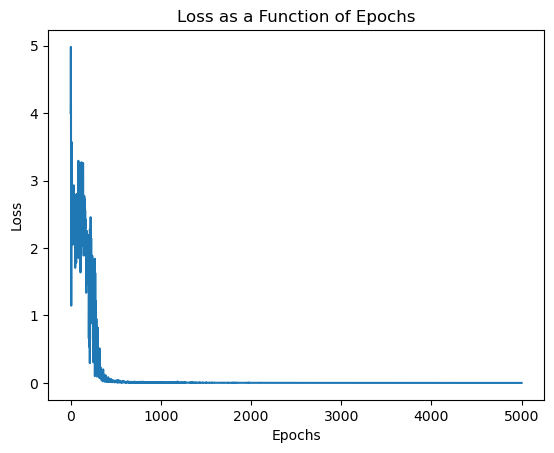

In [21]:
# Plot the loss history
plt.plot(epoch_history, loss_history)
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [22]:
model.summary()

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3200      
_________________________________________________________________
positional_encoding_1 (Posit multiple                  0         
_________________________________________________________________
transformer_layer_4 (Transfo multiple                  74816     
_________________________________________________________________
transformer_layer_5 (Transfo multiple                  74816     
_________________________________________________________________
transformer_layer_6 (Transfo multiple                  74816     
_________________________________________________________________
transformer_layer_7 (Transfo multiple                  74816     
_________________________________________________________________
dense_17 (Dense)             multiple                

In [23]:
# Example test data
test_data = [9]
test_input = tf.constant([test_data])
print(test_input)
print(test_input[:, :-1])


tf.Tensor([[9]], shape=(1, 1), dtype=int32)
tf.Tensor([], shape=(1, 0), dtype=int32)


In [24]:
# Make predictions
predictions = model(src, test_input, training=False)


In [25]:
print (predictions)

tf.Tensor(
[[[-2.2624955  11.836118    0.4695299   0.5529056  -0.04100011
   -0.5373764   0.745598   -0.57046276 -0.5845705   0.81101483
   -0.7880365  -3.1883488  -1.93609    -2.8500643  -1.6409794
   -1.6172678  -3.3672292  -4.0151978  -2.9160228  -3.5033298
   -2.7661638  -3.2303896  -2.7574675  -2.5020072  -3.2357519
   -3.1431348  -2.006488   -2.23047    -2.3833864  -1.9873968
   -2.766085   -2.1571271  -2.739979   -3.1334875  -2.7921782
   -2.595315   -2.4164271  -3.7694635  -3.5468185  -2.08442
   -2.8209429  -2.1045725  -1.3311635  -4.2016788  -2.6937132
   -2.8365445  -2.4383974  -2.4332523  -1.635728   -3.4944568 ]]], shape=(1, 1, 50), dtype=float32)


In [26]:
# Print the predicted values
predicted_values = tf.argmax(predictions[:, -1, :], axis=-1).numpy().tolist()
print (predicted_values)
for i, prediction in enumerate(predicted_values):
    print(f"Predicted class for number is {test_data[i]}: {prediction}")


[1]
Predicted class for number is 9: 1
